## Importing libraries

In [74]:
# Importing necessary libraries for data manipulation, model building, and evaluation
# - pandas and numpy: Basic data manipulation
# - imblearn: For handling imbalanced data with SMOTE
# - statsmodels and sklearn: Feature selection and scaling
# - torch: Building and training the Dense Neural Network model
# - xgboost: Building the XGBoost model
# - seaborn and matplotlib: Visualization of data and model results
# - itertools and time: For generating hyperparameter combinations and measuring run times

import pandas as pd # For most data manipulation and cleaning
import numpy as np # For some data manipulation
from imblearn.over_sampling import SMOTE # For over-sampling
from statsmodels.stats.outliers_influence import variance_inflation_factor # For feature selection
from sklearn.preprocessing import MinMaxScaler, PowerTransformer # Scaling features, Transforming features
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_classif, SelectFromModel # Feature selection
from sklearn.ensemble import RandomForestClassifier # For feature selection using a wrapper
import torch # To build the Dense Neural Network (DNN) model
import torch.nn as nn # To build the Dense Neural Network (DNN) model
import torch.optim as optim # To build the Dense Neural Network (DNN) model
from torch.utils.data import DataLoader, TensorDataset # To use mini batches, to convert to tensors
from sklearn.model_selection import StratifiedKFold, train_test_split # For evaluation and displaying predictions
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix # For evaluation
import xgboost as xgb # Used to create the XGBoost Classifier
from xgboost import XGBClassifier # Used to create the XGBoost Classifier
import seaborn as sns # For visualization
import matplotlib.pyplot as plt # For visualization
import itertools # To create a set of all hyperparameter combinations used in the search grid
from time import time # To get run times

pd.set_option('display.max_columns', None) # Removing column number constraint

## Reading dataframe

In [5]:
telco5_under_fs = pd.read_csv('telco5_under_fs.csv')
telco5_over_fs = pd.read_csv('telco5_over_fs.csv')

telco5_under_fs.head()

Customer ID  Gender  Age Under 30 Senior Citizen Married Dependents  \
0  8779-QRDMV    Male   78       No            Yes      No         No   
1  7495-OOKFY  Female   74       No            Yes     Yes        Yes   
2  1658-BYGOY    Male   71       No            Yes      No        Yes   
3  4598-XLKNJ  Female   78       No            Yes     Yes        Yes   
4  4846-WHAFZ  Female   80       No            Yes     Yes        Yes   

   Number of Dependents        Country       State         City  Zip Code  \
0                     0  United States  California  Los Angeles     90022   
1                     1  United States  California  Los Angeles     90063   
2                     3  United States  California  Los Angeles     90065   
3                     1  United States  California    Inglewood     90303   
4                     1  United States  California     Whittier     90602   

    Latitude   Longitude  Population Quarter Referred a Friend  \
0  34.023810 -118.156582       68701      Q3                No   
1  34.044271 -118.185237       55668      Q3               Yes   
2  34.108833 -118.229715       47534      Q3                No   
3  33.936291 -118.332639       27778      Q3               Yes   
4  33.972119 -118.020188       26265      Q3               Yes   

   Number of Referrals  Tenure in Months    Offer Phone Service  \
0                    0                 1      NaN            No   
1                    1                 8  Offer E           Yes   
2                    0                18  Offer D           Yes   
3                    1                25  Offer C           Yes   
4                    1                37  Offer C           Yes   

   Avg Monthly Long Distance Charges Multiple Lines Internet Service  \
0                               0.00             No              Yes   
1                              48.85            Yes              Yes   
2                              11.33            Yes              Yes   
3                              19.76             No              Yes   
4                               6.33            Yes              Yes   

  Internet Type  Avg Monthly GB Download Online Security Online Backup  \
0           DSL                        8              No            No   
1   Fiber Optic                       17              No           Yes   
2   Fiber Optic                       52              No            No   
3   Fiber Optic                       12              No           Yes   
4   Fiber Optic                       14              No            No   

  Device Protection Plan Premium Tech Support Streaming TV Streaming Movies  \
0                    Yes                   No           No              Yes   
1                     No                   No           No               No   
2                     No                   No          Yes              Yes   
3                    Yes                   No          Yes              Yes   
4                     No                   No           No               No   

  Streaming Music Unlimited Data        Contract Paperless Billing  \
0              No             No  Month-to-Month               Yes   
1              No            Yes  Month-to-Month               Yes   
2             Yes            Yes  Month-to-Month               Yes   
3              No            Yes  Month-to-Month               Yes   
4              No            Yes  Month-to-Month               Yes   

    Payment Method  Monthly Charge  Total Charges  Total Refunds  \
0  Bank Withdrawal           39.65          39.65           0.00   
1      Credit Card           80.65         633.30           0.00   
2  Bank Withdrawal           95.45        1752.55          45.61   
3  Bank Withdrawal           98.50        2514.50          13.43   
4  Bank Withdrawal           76.50        2868.15           0.00   

   Total Extra Data Charges  Total Long Distance Charges  Total Revenue  \
0                        20               

## Training and evaluating models

#### Creating Dense Neural Network (DNN) class

In [56]:
class DNN(nn.Module):
    
    def __init__(self, input_dim, first_layer_neurons=128):
        super(DNN, self).__init__()
        
        # Calculating neurons for each layer
        self.hidden1_neurons = first_layer_neurons
        self.hidden2_neurons = first_layer_neurons // 2
        self.hidden3_neurons = self.hidden2_neurons // 2
        
        # Defining layers with batch normalization
        self.hidden1 = nn.Linear(input_dim, self.hidden1_neurons)
        self.bn1 = nn.BatchNorm1d(self.hidden1_neurons)
        
        self.hidden2 = nn.Linear(self.hidden1_neurons, self.hidden2_neurons)
        self.bn2 = nn.BatchNorm1d(self.hidden2_neurons)
        
        self.hidden3 = nn.Linear(self.hidden2_neurons, self.hidden3_neurons)
        self.bn3 = nn.BatchNorm1d(self.hidden3_neurons)
        
        self.output = nn.Linear(self.hidden3_neurons, 1)

    def forward(self, x):
        
        x = torch.relu(self.bn1(self.hidden1(x)))
        x = torch.relu(self.bn2(self.hidden2(x)))
        x = torch.relu(self.bn3(self.hidden3(x)))
        x = torch.sigmoid(self.output(x))
        
        return x


#### Creating function to evaluate either XGBoost or DNN classifier using Distribution Optimally Balanced Stratified Cross-Validation, which should guarantee balanced distribution for the folds.

In [57]:
def dobscv_evaluation(data, target_col, model_type = 'xgboost', n_splits = 5, random_state = 42,
                      xgb_learning_rate = 0.1, n_estimators = 100, max_depth = 3,
                      epochs = 20, learning_rate = 0.001, batch_size = 32):
    
    # Preparing features and target
    x = data.drop(columns = target_col).values
    y = data[target_col].values

    # Initializing Stratified K-Folds
    skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = random_state)

    # Storing performance metrics for each fold
    accuracies = []
    auc_scores = []
    f1_scores = []
    precisions = []
    recalls = []
    confusion_matrices = []

    # Checking if model_type is xgboost
    if model_type == 'xgboost':
        
        for train_index, test_index in skf.split(x, y):
            
            # Splitting data for a given fold
            x_train, x_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Initializing XGBoost model using logloss for the evaluation metric because the target
            # has been balanced. Otherwise, AUC would be used.
            model = xgb.XGBClassifier(use_label_encoder = False, eval_metric = 'logloss',
                                      eta = xgb_learning_rate, n_estimators = n_estimators, max_depth = max_depth)
            
            model.fit(x_train, y_train)

            # Making predictions and evaluating them
            y_pred = model.predict(x_test)
            y_pred_proba = model.predict_proba(x_test)[:, 1]
            accuracy = accuracy_score(y_test, y_pred)
            auc = roc_auc_score(y_test, y_pred_proba)
            f1 = f1_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            conf_matrix = confusion_matrix(y_test, y_pred)

            # Storing metrics
            accuracies.append(accuracy)
            auc_scores.append(auc)
            f1_scores.append(f1)
            precisions.append(precision)
            recalls.append(recall)
            confusion_matrices.append(conf_matrix)

    # Otherwise, checks if model type is Dense Neural Networks
    elif model_type == 'dnn':
        
        # Runs on GPU if available, and on CPU otherwise
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        for train_index, test_index in skf.split(x, y):
            
            # Splitting data for a given fold
            x_train, x_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Converting to torch tensors
            x_train_tensor = torch.tensor(x_train, dtype = torch.float32).to(device)
            y_train_tensor = torch.tensor(y_train, dtype = torch.float32).view(-1, 1).to(device)
            x_test_tensor = torch.tensor(x_test, dtype = torch.float32).to(device)
            y_test_tensor = torch.tensor(y_test, dtype = torch.float32).view(-1, 1).to(device)

            # Creating DataLoader for mini-batch processing
            train_data = TensorDataset(x_train_tensor, y_train_tensor)
            train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True, drop_last = True)
            
            # Initializing DNN model, loss function, and optimizer
            model = DNN(input_dim = x_train.shape[1]).to(device)
            criterion = nn.BCELoss()
            optimizer = optim.Adam(model.parameters(), lr = learning_rate)

            # Training
            for epoch in range(epochs):
                
                model.train() # Puts model in training mode
                
                for batch_x, batch_y in train_loader:
                
                    batch_x, batch_y = batch_x.to(device), batch_y.to(device) # Creates mini-batches
                    optimizer.zero_grad() # Clears old gradients from the previous training step
                    output = model(batch_x) # Stores output
                    loss = criterion(output, batch_y) # Calculates and stores loss
                    loss.backward() # Backpropagates the error to calculate the gradient of the loss with respect to each parameter.
                    optimizer.step() # Updates the model’s parameters using the gradients calculated in loss.backward()

            # Evaluating
            model.eval() # Puts model in evaluation mode
            with torch.no_grad(): # Disabling gradient calculation to save memory
                y_pred_proba = model(x_test_tensor).cpu().numpy().flatten() # Passes x_test_tensor through the model to get predictions
                y_pred = (y_pred_proba >= 0.5).astype(int) # Converts probabilities greater than or equal to 0.5 to True(1)

            # Calculating metrics
            accuracy = accuracy_score(y_test, y_pred)
            auc = roc_auc_score(y_test, y_pred_proba)
            f1 = f1_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            conf_matrix = confusion_matrix(y_test, y_pred)

            # Storing metrics
            accuracies.append(accuracy)
            auc_scores.append(auc)
            f1_scores.append(f1)
            precisions.append(precision)
            recalls.append(recall)
            confusion_matrices.append(conf_matrix)

    # Aggregating results
    results = {
        'Average Accuracy': np.mean(accuracies),
        'Average AUC': np.mean(auc_scores),
        'Average F1 Score': np.mean(f1_scores),
        'Average Precision': np.mean(precisions),
        'Average Recall': np.mean(recalls),
        'All Accuracies': accuracies,
        'All AUC Scores': auc_scores,
        'All F1 Scores': f1_scores,
        'All Precisions': precisions,
        'All Recalls': recalls,
        'Confusion Matrices': confusion_matrices
    }
    
    # Outputting results
    print('Cross-Validation Results:')
    print(f'Average Accuracy: {results["Average Accuracy"]:.4f}')
    print(f'Average AUC: {results["Average AUC"]:.4f}')
    print(f'Average F1 Score: {results["Average F1 Score"]:.4f}')
    print(f'Average Precision: {results["Average Precision"]:.4f}')
    print(f'Average Recall: {results["Average Recall"]:.4f}')
    print(f'Accuracies per Fold: {results["All Accuracies"]}')
    print(f'AUC Scores per Fold: {results["All AUC Scores"]}')
    print(f'F1 Scores per Fold: {results["All F1 Scores"]}')
    print(f'Precisions per Fold: {results["All Precisions"]}')
    print(f'Recalls per Fold: {results["All Recalls"]}')
    print('Confusion Matrices per Fold:')

    for i, cm in enumerate(results['Confusion Matrices']):
        print(f'Fold {i+1} Confusion Matrix:\n{cm}\n')
    
    return results


#### Creating search grid function. Grid search was chosen both because the dataset is small enough for it, and because this will make the discrepancy between run times for each model more evident, not to mention thorough hyper parameter tuning, of course. While this might not be practical when working with real life dataframes, it helps investigating the advantages and disadvantages of both XGBoost and DNN classifiers when it comes to Customer Churn.

In [58]:
def search_grid(data, target_col, model_type, eval_func, **param_grid):

    # Creating a list to store results and creating all parameter combinations for the grid search
    results = []
    param_combinations = list(itertools.product(*param_grid.values()))

    # Starting a counter to assist with tracking progress for the model
    counter = 0
    
    # For each parameter combination
    for params in param_combinations:
        
        # Creating a dictionary organized with key values for each combination rather than key and all its possible values
        param_dict = dict(zip(param_grid.keys(), params))

        # Ensuring n_splits is handled as part of the parameters
        n_splits = param_dict.get('n_splits', 5)  # Default to 5 if not provided

        if model_type == 'xgboost':
            
            # Getting parameters for the xgb classifier
            xgb_params = {
                'xgb_learning_rate': param_dict.get('xgb_learning_rate'),
                'n_estimators': param_dict.get('n_estimators'),
                'max_depth': param_dict.get('max_depth')
            }
            
            # Printing parameters, calling evaluation function, calculating run time,updating and printing counter
            print(f'Evaluating with parameters: {xgb_params}, n_splits: {n_splits}')
            start_time = time()
            
            result = eval_func(data, target_col, model_type='xgboost', 
                               n_splits=n_splits, **xgb_params)
            end_time = time()
            time_elapsed = end_time - start_time
            results.append((xgb_params, n_splits, time_elapsed, result))
            
            counter += 1
            print(f'{counter}/480 completed.')

        # If model of choice is dnn rather than xgboost
        elif model_type == 'dnn':
            
            # Gets parameters for dnn model
            dnn_params = {
                'epochs': param_dict.get('epochs'),
                'learning_rate': param_dict.get('learning_rate'),
                'batch_size': param_dict.get('batch_size')
            }
            
            # Printing parameters, calling evaluation function, calculating run time,updating and printing counter
            print(f'Evaluating with parameters: {dnn_params}, n_splits: {n_splits}')
            start_time = time()

            result = eval_func(data, target_col, model_type='dnn', 
                               n_splits=n_splits, **dnn_params)
            end_time = time()
            time_elapsed = end_time - start_time
            results.append((dnn_params, n_splits, time_elapsed, result))
            
            counter += 1
            print(f'{counter}/216 completed.')

        # Printing total time taken for a given model
        print(f'Time taken: {time_elapsed:.2f} seconds\n')
        
    # Returning results
    return results


#### Creating search grids for each model.
#### The hyperparameters selected for the search grid allow for a thorough exploration of model performance and training stability. Testing different cv_folds (5–10) provides flexibility in the train-validation split, which impacts evaluation quality. For XGBoost, learning rates from 0.1 to 0.0001 control update speed, with smaller values potentially enhancing stability, while n_estimators (100–500) and max_depth (3–6) tune model complexity to find a balance between accuracy and the risk of overfitting. In the neural network, testing epochs (25–100) explores how training duration affects performance, with lower counts helping to prevent overfitting. Additionally, the range of learning rates (0.001 to 0.00001) supports gradual learning adjustments, and varying batch sizes (64, 32, 16) provides a trade-off between memory usage and model update frequency.

In [181]:
cv_folds = (5, 6, 7, 8, 9, 10)

xgb_learning_rate = (0.1, 0.01, 0.001, 0.0001)
n_estimators = (100, 200, 300, 400, 500)
max_depth = (3, 4, 5, 6)

epochs = (25, 50, 75, 100)
learning_rate = (0.001, 0.0001, 0.00001)
batch_size = (64, 32, 16)


#### Training and evaluating each model and storing their results as well as run times

In [182]:
start_time = time()

results_xgb_under = search_grid(
    data=telco5_under_fs, 
    target_col='Churn Label_Yes', 
    model_type='xgboost', 
    eval_func=dobscv_evaluation,
    n_splits=cv_folds,
    xgb_learning_rate=xgb_learning_rate,
    n_estimators=n_estimators,
    max_depth=max_depth
)

end_time = time()
time_elapsed = end_time - start_time
print(f'Time elapsed for XGBoost Classifier: {time_elapsed}')

Evaluating with parameters: {'xgb_learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 3}, n_splits: 5


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:20:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:20:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:20:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9529
Average AUC: 0.9937
Average F1 Score: 0.9533
Average Precision: 0.9459
Average Recall: 0.9609
Accuracies per Fold: [0.9625668449197861, 0.9518716577540107, 0.9478609625668449, 0.9558232931726908, 0.9464524765729585]
AUC Scores per Fold: [0.9956461437273014, 0.9929902199090623, 0.9936193485658725, 0.994645238061103, 0.9918173216154608]
F1 Scores per Fold: [0.9629629629629629, 0.9530026109660574, 0.9473684210526315, 0.9562913907284768, 0.9466666666666667]
Precisions per Fold: [0.9528795811518325, 0.9311224489795918, 0.9564032697547684, 0.9450261780104712, 0.9441489361702128]
Recalls per Fold: [0.9732620320855615, 0.9759358288770054, 0.9385026737967914, 0.967828418230563, 0.9491978609625669]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[356  18]
 [ 10 364]]

Fold 2 Confusion Matrix:
[[347  27]
 [  9 365]]

Fold 3 Confusion Matrix:
[[358  16]
 [ 23 351]]

Fold 4 Confusion Matrix:
[[353  21]
 [ 12 361]]

Fold 5 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:20:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:20:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:20:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9545
Average AUC: 0.9935
Average F1 Score: 0.9547
Average Precision: 0.9503
Average Recall: 0.9593
Accuracies per Fold: [0.9625668449197861, 0.9558823529411765, 0.9532085561497327, 0.9585006693440429, 0.9424364123159303]
AUC Scores per Fold: [0.99567831507907, 0.9934012982927736, 0.9934084474820556, 0.9944373557368353, 0.9906775530099926]
F1 Scores per Fold: [0.9628647214854111, 0.9567496723460026, 0.9527665317139001, 0.9588313413014609, 0.9422818791946309]
Precisions per Fold: [0.9552631578947368, 0.9383033419023136, 0.9618528610354223, 0.95, 0.9460916442048517]
Recalls per Fold: [0.9705882352941176, 0.9759358288770054, 0.9438502673796791, 0.967828418230563, 0.9385026737967914]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[357  17]
 [ 11 363]]

Fold 2 Confusion Matrix:
[[350  24]
 [  9 365]]

Fold 3 Confusion Matrix:
[[360  14]
 [ 21 353]]

Fold 4 Confusion Matrix:
[[355  19]
 [ 12 361]]

Fold 5 Confusion Matrix:
[[353  20]
 [ 23

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:20:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:20:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:20:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9543
Average AUC: 0.9934
Average F1 Score: 0.9544
Average Precision: 0.9512
Average Recall: 0.9577
Accuracies per Fold: [0.9652406417112299, 0.9545454545454546, 0.9532085561497327, 0.9571619812583668, 0.9410977242302544]
AUC Scores per Fold: [0.9955281821041494, 0.9933727015356459, 0.9927435728788355, 0.9947814368252784, 0.9906811371879973]
F1 Scores per Fold: [0.9655172413793104, 0.9553805774278216, 0.9527665317139001, 0.9572192513368984, 0.9410187667560321]
Precisions per Fold: [0.9578947368421052, 0.9381443298969072, 0.9618528610354223, 0.9546666666666667, 0.9435483870967742]
Recalls per Fold: [0.9732620320855615, 0.9732620320855615, 0.9438502673796791, 0.9597855227882037, 0.9385026737967914]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[358  16]
 [ 10 364]]

Fold 2 Confusion Matrix:
[[350  24]
 [ 10 364]]

Fold 3 Confusion Matrix:
[[360  14]
 [ 21 353]]

Fold 4 Confusion Matrix:
[[357  17]
 [ 15 358]]

Fold 5 Confusion Matrix:

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:20:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:20:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:20:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9534
Average AUC: 0.9931
Average F1 Score: 0.9536
Average Precision: 0.9497
Average Recall: 0.9577
Accuracies per Fold: [0.9652406417112299, 0.9558823529411765, 0.9505347593582888, 0.9558232931726908, 0.9397590361445783]
AUC Scores per Fold: [0.9949741199347995, 0.9933584031570819, 0.9924290085504304, 0.9943728405327521, 0.9901435104873049]
F1 Scores per Fold: [0.9654255319148937, 0.9565217391304348, 0.9500674763832658, 0.9559412550066756, 0.9402390438247012]
Precisions per Fold: [0.9603174603174603, 0.9428571428571428, 0.9591280653950953, 0.9521276595744681, 0.9340369393139841]
Recalls per Fold: [0.9705882352941176, 0.9705882352941176, 0.9411764705882353, 0.9597855227882037, 0.946524064171123]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[359  15]
 [ 11 363]]

Fold 2 Confusion Matrix:
[[352  22]
 [ 11 363]]

Fold 3 Confusion Matrix:
[[359  15]
 [ 22 352]]

Fold 4 Confusion Matrix:
[[356  18]
 [ 15 358]]

Fold 5 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:20:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:20:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:20:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9540
Average AUC: 0.9930
Average F1 Score: 0.9541
Average Precision: 0.9512
Average Recall: 0.9572
Accuracies per Fold: [0.9652406417112299, 0.9572192513368984, 0.9532085561497327, 0.9544846050870147, 0.9397590361445783]
AUC Scores per Fold: [0.9957569561611713, 0.9927364236895536, 0.9924218593611485, 0.9942653151926137, 0.9900216484351478]
F1 Scores per Fold: [0.9653333333333334, 0.9577836411609498, 0.9527665317139001, 0.9547872340425532, 0.9399198931909212]
Precisions per Fold: [0.9627659574468085, 0.9453125, 0.9618528610354223, 0.9472295514511874, 0.9386666666666666]
Recalls per Fold: [0.9679144385026738, 0.9705882352941176, 0.9438502673796791, 0.9624664879356568, 0.9411764705882353]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[360  14]
 [ 12 362]]

Fold 2 Confusion Matrix:
[[353  21]
 [ 11 363]]

Fold 3 Confusion Matrix:
[[360  14]
 [ 21 353]]

Fold 4 Confusion Matrix:
[[354  20]
 [ 14 359]]

Fold 5 Confusion Matrix:
[[350  2

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:20:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:20:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:20:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9524
Average AUC: 0.9926
Average F1 Score: 0.9524
Average Precision: 0.9515
Average Recall: 0.9535
Accuracies per Fold: [0.9612299465240641, 0.9545454545454546, 0.9518716577540107, 0.9544846050870147, 0.9397590361445783]
AUC Scores per Fold: [0.9951028053418742, 0.9925005004432498, 0.9919500128685408, 0.9938997290361429, 0.9895485369385385]
F1 Scores per Fold: [0.9613848202396804, 0.9551451187335093, 0.9512195121951219, 0.9546666666666667, 0.9395973154362416]
Precisions per Fold: [0.9575596816976127, 0.9427083333333334, 0.9642857142857143, 0.9496021220159151, 0.9433962264150944]
Recalls per Fold: [0.9652406417112299, 0.9679144385026738, 0.9385026737967914, 0.9597855227882037, 0.9358288770053476]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[358  16]
 [ 13 361]]

Fold 2 Confusion Matrix:
[[352  22]
 [ 12 362]]

Fold 3 Confusion Matrix:
[[361  13]
 [ 23 351]]

Fold 4 Confusion Matrix:
[[355  19]
 [ 15 358]]

Fold 5 Confusion Matrix:

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:20:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:20:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:20:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9513
Average AUC: 0.9924
Average F1 Score: 0.9513
Average Precision: 0.9524
Average Recall: 0.9502
Accuracies per Fold: [0.9625668449197861, 0.9478609625668449, 0.9532085561497327, 0.9451137884872824, 0.9477911646586346]
AUC Scores per Fold: [0.994895478852698, 0.9924361577397123, 0.9913423317795763, 0.9936990150678843, 0.9897420825507878]
F1 Scores per Fold: [0.9625668449197861, 0.9483443708609272, 0.952638700947226, 0.9449664429530201, 0.9477911646586346]
Precisions per Fold: [0.9625668449197861, 0.9396325459317585, 0.9643835616438357, 0.946236559139785, 0.9490616621983914]
Recalls per Fold: [0.9625668449197861, 0.9572192513368984, 0.9411764705882353, 0.9436997319034852, 0.946524064171123]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[360  14]
 [ 14 360]]

Fold 2 Confusion Matrix:
[[351  23]
 [ 16 358]]

Fold 3 Confusion Matrix:
[[361  13]
 [ 22 352]]

Fold 4 Confusion Matrix:
[[354  20]
 [ 21 352]]

Fold 5 Confusion Matrix:
[[3

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:20:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:20:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:20:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9513
Average AUC: 0.9921
Average F1 Score: 0.9513
Average Precision: 0.9519
Average Recall: 0.9508
Accuracies per Fold: [0.9679144385026738, 0.9505347593582888, 0.9505347593582888, 0.9504685408299867, 0.9370816599732262]
AUC Scores per Fold: [0.9944808258743458, 0.9924576053075582, 0.9908847836655323, 0.993842382188069, 0.9886811658614212]
F1 Scores per Fold: [0.9679144385026738, 0.950863213811421, 0.9499323410013532, 0.9503355704697987, 0.9374167776298269]
Precisions per Fold: [0.9679144385026738, 0.9445910290237467, 0.9616438356164384, 0.9516129032258065, 0.9336870026525199]
Recalls per Fold: [0.9679144385026738, 0.9572192513368984, 0.9385026737967914, 0.9490616621983914, 0.9411764705882353]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[362  12]
 [ 12 362]]

Fold 2 Confusion Matrix:
[[353  21]
 [ 16 358]]

Fold 3 Confusion Matrix:
[[360  14]
 [ 23 351]]

Fold 4 Confusion Matrix:
[[356  18]
 [ 19 354]]

Fold 5 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9524
Average AUC: 0.9925
Average F1 Score: 0.9524
Average Precision: 0.9525
Average Recall: 0.9524
Accuracies per Fold: [0.963903743315508, 0.9572192513368984, 0.9532085561497327, 0.9504685408299867, 0.9370816599732262]
AUC Scores per Fold: [0.9949312247991078, 0.9923360690897652, 0.9917641339472103, 0.9936416682198104, 0.9896632306346862]
F1 Scores per Fold: [0.9639519359145527, 0.9577836411609498, 0.9525101763907734, 0.9506008010680908, 0.9369127516778524]
Precisions per Fold: [0.9626666666666667, 0.9453125, 0.9669421487603306, 0.9468085106382979, 0.9407008086253369]
Recalls per Fold: [0.9652406417112299, 0.9705882352941176, 0.9385026737967914, 0.9544235924932976, 0.9331550802139037]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[360  14]
 [ 13 361]]

Fold 2 Confusion Matrix:
[[353  21]
 [ 11 363]]

Fold 3 Confusion Matrix:
[[362  12]
 [ 23 351]]

Fold 4 Confusion Matrix:
[[354  20]
 [ 17 356]]

Fold 5 Confusion Matrix:
[[351  22

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9513
Average AUC: 0.9919
Average F1 Score: 0.9513
Average Precision: 0.9520
Average Recall: 0.9508
Accuracies per Fold: [0.963903743315508, 0.9518716577540107, 0.9505347593582888, 0.9518072289156626, 0.9384203480589023]
AUC Scores per Fold: [0.9944736766850639, 0.9918284766507478, 0.9911135577225543, 0.9936775099998567, 0.9884446101131167]
F1 Scores per Fold: [0.9639519359145527, 0.9526315789473684, 0.9496598639455782, 0.9518716577540107, 0.9381720430107527]
Precisions per Fold: [0.9626666666666667, 0.9378238341968912, 0.9667590027700831, 0.9493333333333334, 0.9432432432432433]
Recalls per Fold: [0.9652406417112299, 0.9679144385026738, 0.9331550802139037, 0.9544235924932976, 0.9331550802139037]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[360  14]
 [ 13 361]]

Fold 2 Confusion Matrix:
[[350  24]
 [ 12 362]]

Fold 3 Confusion Matrix:
[[362  12]
 [ 25 349]]

Fold 4 Confusion Matrix:
[[355  19]
 [ 17 356]]

Fold 5 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9494
Average AUC: 0.9918
Average F1 Score: 0.9494
Average Precision: 0.9507
Average Recall: 0.9481
Accuracies per Fold: [0.963903743315508, 0.946524064171123, 0.9491978609625669, 0.9464524765729585, 0.9410977242302544]
AUC Scores per Fold: [0.9944379307386543, 0.9920572507077697, 0.9903056993336956, 0.9933764390474689, 0.9886883342174305]
F1 Scores per Fold: [0.9639519359145527, 0.946949602122016, 0.9486486486486486, 0.9460916442048517, 0.9411764705882353]
Precisions per Fold: [0.9626666666666667, 0.9394736842105263, 0.9590163934426229, 0.9512195121951219, 0.9411764705882353]
Recalls per Fold: [0.9652406417112299, 0.9545454545454546, 0.9385026737967914, 0.9410187667560321, 0.9411764705882353]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[360  14]
 [ 13 361]]

Fold 2 Confusion Matrix:
[[351  23]
 [ 17 357]]

Fold 3 Confusion Matrix:
[[359  15]
 [ 23 351]]

Fold 4 Confusion Matrix:
[[356  18]
 [ 22 351]]

Fold 5 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9502
Average AUC: 0.9912
Average F1 Score: 0.9502
Average Precision: 0.9513
Average Recall: 0.9492
Accuracies per Fold: [0.9679144385026738, 0.9478609625668449, 0.9478609625668449, 0.9491298527443106, 0.9384203480589023]
AUC Scores per Fold: [0.9939660842460465, 0.9916997912436729, 0.9900125825731363, 0.9928746541268225, 0.9873048415076486]
F1 Scores per Fold: [0.9679144385026738, 0.9479305740987984, 0.9472259810554804, 0.9491978609625669, 0.9386666666666666]
Precisions per Fold: [0.9679144385026738, 0.9466666666666667, 0.958904109589041, 0.9466666666666667, 0.9361702127659575]
Recalls per Fold: [0.9679144385026738, 0.9491978609625669, 0.9358288770053476, 0.9517426273458445, 0.9411764705882353]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[362  12]
 [ 12 362]]

Fold 2 Confusion Matrix:
[[354  20]
 [ 19 355]]

Fold 3 Confusion Matrix:
[[359  15]
 [ 24 350]]

Fold 4 Confusion Matrix:
[[354  20]
 [ 18 355]]

Fold 5 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9508
Average AUC: 0.9921
Average F1 Score: 0.9507
Average Precision: 0.9509
Average Recall: 0.9508
Accuracies per Fold: [0.9652406417112299, 0.9532085561497327, 0.9478609625668449, 0.9504685408299867, 0.9370816599732262]
AUC Scores per Fold: [0.994688152363522, 0.9920358031399239, 0.9912207955617833, 0.9933979441154965, 0.9889105532537168]
F1 Scores per Fold: [0.9652406417112299, 0.9538866930171278, 0.9469387755102041, 0.9506008010680908, 0.9370816599732262]
Precisions per Fold: [0.9652406417112299, 0.9402597402597402, 0.96398891966759, 0.9468085106382979, 0.938337801608579]
Recalls per Fold: [0.9652406417112299, 0.9679144385026738, 0.93048128342246, 0.9544235924932976, 0.9358288770053476]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[361  13]
 [ 13 361]]

Fold 2 Confusion Matrix:
[[351  23]
 [ 12 362]]

Fold 3 Confusion Matrix:
[[361  13]
 [ 26 348]]

Fold 4 Confusion Matrix:
[[354  20]
 [ 17 356]]

Fold 5 Confusion Matrix:
[[350

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9484
Average AUC: 0.9914
Average F1 Score: 0.9484
Average Precision: 0.9478
Average Recall: 0.9492
Accuracies per Fold: [0.9625668449197861, 0.9491978609625669, 0.9491978609625669, 0.9477911646586346, 0.9330655957161981]
AUC Scores per Fold: [0.9941662615459408, 0.9911135577225543, 0.9903628928479511, 0.9933047554873766, 0.988057518888618]
F1 Scores per Fold: [0.9626666666666667, 0.9498680738786279, 0.948509485094851, 0.9477911646586346, 0.9331550802139037]
Precisions per Fold: [0.9601063829787234, 0.9375, 0.9615384615384616, 0.946524064171123, 0.9331550802139037]
Recalls per Fold: [0.9652406417112299, 0.9625668449197861, 0.9358288770053476, 0.9490616621983914, 0.9331550802139037]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[359  15]
 [ 13 361]]

Fold 2 Confusion Matrix:
[[350  24]
 [ 14 360]]

Fold 3 Confusion Matrix:
[[360  14]
 [ 24 350]]

Fold 4 Confusion Matrix:
[[354  20]
 [ 19 354]]

Fold 5 Confusion Matrix:
[[348  25]
 [ 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9484
Average AUC: 0.9912
Average F1 Score: 0.9482
Average Precision: 0.9516
Average Recall: 0.9449
Accuracies per Fold: [0.9625668449197861, 0.9478609625668449, 0.9451871657754011, 0.9464524765729585, 0.9397590361445783]
AUC Scores per Fold: [0.9940733220852755, 0.9915282107009065, 0.9895693328376561, 0.9927599604306748, 0.9878209631403134]
F1 Scores per Fold: [0.9625668449197861, 0.9479305740987984, 0.9443690637720489, 0.9460916442048517, 0.9399198931909212]
Precisions per Fold: [0.9625668449197861, 0.9466666666666667, 0.9586776859504132, 0.9512195121951219, 0.9386666666666666]
Recalls per Fold: [0.9625668449197861, 0.9491978609625669, 0.93048128342246, 0.9410187667560321, 0.9411764705882353]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[360  14]
 [ 14 360]]

Fold 2 Confusion Matrix:
[[354  20]
 [ 19 355]]

Fold 3 Confusion Matrix:
[[359  15]
 [ 26 348]]

Fold 4 Confusion Matrix:
[[356  18]
 [ 22 351]]

Fold 5 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9489
Average AUC: 0.9906
Average F1 Score: 0.9489
Average Precision: 0.9497
Average Recall: 0.9481
Accuracies per Fold: [0.9679144385026738, 0.9491978609625669, 0.9478609625668449, 0.9451137884872824, 0.9344042838018741]
AUC Scores per Fold: [0.9936515199176413, 0.9910849609654265, 0.9891260831021762, 0.9928173072787487, 0.9864159653625038]
F1 Scores per Fold: [0.9679144385026738, 0.9493333333333334, 0.9473684210526315, 0.9451137884872824, 0.9345794392523364]
Precisions per Fold: [0.9679144385026738, 0.9468085106382979, 0.9564032697547684, 0.9438502673796791, 0.9333333333333333]
Recalls per Fold: [0.9679144385026738, 0.9518716577540107, 0.9385026737967914, 0.9463806970509383, 0.9358288770053476]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[362  12]
 [ 12 362]]

Fold 2 Confusion Matrix:
[[354  20]
 [ 18 356]]

Fold 3 Confusion Matrix:
[[358  16]
 [ 23 351]]

Fold 4 Confusion Matrix:
[[353  21]
 [ 20 353]]

Fold 5 Confusion Matrix:

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9494
Average AUC: 0.9916
Average F1 Score: 0.9494
Average Precision: 0.9503
Average Recall: 0.9486
Accuracies per Fold: [0.963903743315508, 0.9478609625668449, 0.9478609625668449, 0.9504685408299867, 0.9370816599732262]
AUC Scores per Fold: [0.9944236323600903, 0.9915210615116247, 0.9906131144728187, 0.993104041519118, 0.9882367277888489]
F1 Scores per Fold: [0.9639519359145527, 0.9484808454425363, 0.9470827679782904, 0.9504685408299867, 0.9369127516778524]
Precisions per Fold: [0.9626666666666667, 0.9373368146214099, 0.9614325068870524, 0.9491978609625669, 0.9407008086253369]
Recalls per Fold: [0.9652406417112299, 0.9598930481283422, 0.9331550802139037, 0.9517426273458445, 0.9331550802139037]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[360  14]
 [ 13 361]]

Fold 2 Confusion Matrix:
[[350  24]
 [ 15 359]]

Fold 3 Confusion Matrix:
[[360  14]
 [ 25 349]]

Fold 4 Confusion Matrix:
[[355  19]
 [ 18 355]]

Fold 5 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9484
Average AUC: 0.9910
Average F1 Score: 0.9482
Average Precision: 0.9506
Average Recall: 0.9460
Accuracies per Fold: [0.963903743315508, 0.946524064171123, 0.9478609625668449, 0.9477911646586346, 0.9357429718875502]
AUC Scores per Fold: [0.993908890731791, 0.9906917555549201, 0.9899553890588807, 0.9928459807027856, 0.9875915757480179]
F1 Scores per Fold: [0.9639519359145527, 0.9468085106382979, 0.9470827679782904, 0.9476510067114094, 0.935656836461126]
Precisions per Fold: [0.9626666666666667, 0.9417989417989417, 0.9614325068870524, 0.9489247311827957, 0.9381720430107527]
Recalls per Fold: [0.9652406417112299, 0.9518716577540107, 0.9331550802139037, 0.9463806970509383, 0.9331550802139037]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[360  14]
 [ 13 361]]

Fold 2 Confusion Matrix:
[[352  22]
 [ 18 356]]

Fold 3 Confusion Matrix:
[[360  14]
 [ 25 349]]

Fold 4 Confusion Matrix:
[[355  19]
 [ 20 353]]

Fold 5 Confusion Matrix:
[[3

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9494
Average AUC: 0.9906
Average F1 Score: 0.9492
Average Precision: 0.9526
Average Recall: 0.9460
Accuracies per Fold: [0.963903743315508, 0.9505347593582888, 0.9478609625668449, 0.9477911646586346, 0.9370816599732262]
AUC Scores per Fold: [0.9938659955960993, 0.9908990820440962, 0.9887900712059253, 0.9925664148184257, 0.9869249186391593]
F1 Scores per Fold: [0.9639519359145527, 0.9503355704697987, 0.9472259810554804, 0.9476510067114094, 0.9370816599732262]
Precisions per Fold: [0.9626666666666667, 0.954177897574124, 0.958904109589041, 0.9489247311827957, 0.938337801608579]
Recalls per Fold: [0.9652406417112299, 0.946524064171123, 0.9358288770053476, 0.9463806970509383, 0.9358288770053476]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[360  14]
 [ 13 361]]

Fold 2 Confusion Matrix:
[[357  17]
 [ 20 354]]

Fold 3 Confusion Matrix:
[[359  15]
 [ 24 350]]

Fold 4 Confusion Matrix:
[[355  19]
 [ 20 353]]

Fold 5 Confusion Matrix:
[[35

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9500
Average AUC: 0.9903
Average F1 Score: 0.9499
Average Precision: 0.9512
Average Recall: 0.9486
Accuracies per Fold: [0.9665775401069518, 0.9532085561497327, 0.9451871657754011, 0.9477911646586346, 0.9370816599732262]
AUC Scores per Fold: [0.9934155966713375, 0.990806142583431, 0.9886113414738769, 0.9927671287866842, 0.9858353285257558]
F1 Scores per Fold: [0.9666221628838452, 0.9532710280373832, 0.9446693657219973, 0.9476510067114094, 0.9372496662216289]
Precisions per Fold: [0.9653333333333334, 0.952, 0.9536784741144414, 0.9489247311827957, 0.936]
Recalls per Fold: [0.9679144385026738, 0.9545454545454546, 0.9358288770053476, 0.9463806970509383, 0.9385026737967914]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[361  13]
 [ 12 362]]

Fold 2 Confusion Matrix:
[[356  18]
 [ 17 357]]

Fold 3 Confusion Matrix:
[[357  17]
 [ 24 350]]

Fold 4 Confusion Matrix:
[[355  19]
 [ 20 353]]

Fold 5 Confusion Matrix:
[[349  24]
 [ 23 351]]

20

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9221
Average AUC: 0.9854
Average F1 Score: 0.9219
Average Precision: 0.9205
Average Recall: 0.9272
Accuracies per Fold: [0.9425133689839572, 0.9197860962566845, 0.9090909090909091, 0.9076305220883534, 0.9317269076305221]
AUC Scores per Fold: [0.9870706911836198, 0.980296834338986, 0.989040292830793, 0.9836991584350046, 0.9869894338432423]
F1 Scores per Fold: [0.944372574385511, 0.923469387755102, 0.9028571428571428, 0.9042995839112344, 0.9345314505776636]
Precisions per Fold: [0.9147869674185464, 0.8829268292682927, 0.9693251533742331, 0.9367816091954023, 0.8987654320987655]
Recalls per Fold: [0.9759358288770054, 0.9679144385026738, 0.8449197860962567, 0.8739946380697051, 0.9732620320855615]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[340  34]
 [  9 365]]

Fold 2 Confusion Matrix:
[[326  48]
 [ 12 362]]

Fold 3 Confusion Matrix:
[[364  10]
 [ 58 316]]

Fold 4 Confusion Matrix:
[[352  22]
 [ 47 326]]

Fold 5 Confusion Matrix:
[[3

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9441
Average AUC: 0.9907
Average F1 Score: 0.9453
Average Precision: 0.9254
Average Recall: 0.9663
Accuracies per Fold: [0.9491978609625669, 0.9358288770053476, 0.9505347593582888, 0.9451137884872824, 0.9397590361445783]
AUC Scores per Fold: [0.9919249907060539, 0.9869920501015185, 0.9927399982841947, 0.9914230620349529, 0.9906058694499003]
F1 Scores per Fold: [0.95, 0.9376623376623376, 0.950863213811421, 0.9466840052015605, 0.94148244473342]
Precisions per Fold: [0.9352331606217616, 0.9116161616161617, 0.9445910290237467, 0.9191919191919192, 0.9164556962025316]
Recalls per Fold: [0.9652406417112299, 0.9652406417112299, 0.9572192513368984, 0.9758713136729222, 0.9679144385026738]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[349  25]
 [ 13 361]]

Fold 2 Confusion Matrix:
[[339  35]
 [ 13 361]]

Fold 3 Confusion Matrix:
[[353  21]
 [ 16 358]]

Fold 4 Confusion Matrix:
[[342  32]
 [  9 364]]

Fold 5 Confusion Matrix:
[[340  33]
 [ 12

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9476
Average AUC: 0.9911
Average F1 Score: 0.9485
Average Precision: 0.9320
Average Recall: 0.9658
Accuracies per Fold: [0.9545454545454546, 0.9411764705882353, 0.9532085561497327, 0.9451137884872824, 0.9437751004016064]
AUC Scores per Fold: [0.9923825388200977, 0.9877713117332494, 0.9929366009894478, 0.9915879342231653, 0.990795830884145]
F1 Scores per Fold: [0.9553805774278216, 0.9422572178477691, 0.9533954727030626, 0.9464052287581699, 0.9451697127937336]
Precisions per Fold: [0.9381443298969072, 0.9252577319587629, 0.9496021220159151, 0.923469387755102, 0.923469387755102]
Recalls per Fold: [0.9732620320855615, 0.9598930481283422, 0.9572192513368984, 0.9705093833780161, 0.9679144385026738]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[350  24]
 [ 10 364]]

Fold 2 Confusion Matrix:
[[345  29]
 [ 15 359]]

Fold 3 Confusion Matrix:
[[355  19]
 [ 16 358]]

Fold 4 Confusion Matrix:
[[344  30]
 [ 11 362]]

Fold 5 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9502
Average AUC: 0.9926
Average F1 Score: 0.9513
Average Precision: 0.9315
Average Recall: 0.9722
Accuracies per Fold: [0.9598930481283422, 0.9451871657754011, 0.9558823529411765, 0.9491298527443106, 0.9410977242302544]
AUC Scores per Fold: [0.9931975463982384, 0.9919035431382082, 0.9937694815407934, 0.9929965161789795, 0.9913155366948143]
F1 Scores per Fold: [0.9607329842931938, 0.9465449804432855, 0.9561752988047809, 0.9502617801047121, 0.9430051813471503]
Precisions per Fold: [0.941025641025641, 0.9236641221374046, 0.9498680738786279, 0.928388746803069, 0.914572864321608]
Recalls per Fold: [0.9812834224598931, 0.9705882352941176, 0.9625668449197861, 0.9731903485254692, 0.9732620320855615]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[351  23]
 [  7 367]]

Fold 2 Confusion Matrix:
[[344  30]
 [ 11 363]]

Fold 3 Confusion Matrix:
[[355  19]
 [ 14 360]]

Fold 4 Confusion Matrix:
[[346  28]
 [ 10 363]]

Fold 5 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9238
Average AUC: 0.9881
Average F1 Score: 0.9234
Average Precision: 0.9243
Average Recall: 0.9267
Accuracies per Fold: [0.9425133689839572, 0.9197860962566845, 0.9090909090909091, 0.9156626506024096, 0.9317269076305221]
AUC Scores per Fold: [0.9908275901512769, 0.9844183419600218, 0.9904165117675656, 0.9872797522616164, 0.9873191782196671]
F1 Scores per Fold: [0.944372574385511, 0.923469387755102, 0.9028571428571428, 0.9116409537166901, 0.9345314505776636]
Precisions per Fold: [0.9147869674185464, 0.8829268292682927, 0.9693251533742331, 0.9558823529411765, 0.8987654320987655]
Recalls per Fold: [0.9759358288770054, 0.9679144385026738, 0.8449197860962567, 0.871313672922252, 0.9732620320855615]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[340  34]
 [  9 365]]

Fold 2 Confusion Matrix:
[[326  48]
 [ 12 362]]

Fold 3 Confusion Matrix:
[[364  10]
 [ 58 316]]

Fold 4 Confusion Matrix:
[[359  15]
 [ 48 325]]

Fold 5 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9494
Average AUC: 0.9922
Average F1 Score: 0.9503
Average Precision: 0.9351
Average Recall: 0.9663
Accuracies per Fold: [0.9598930481283422, 0.9411764705882353, 0.9505347593582888, 0.9491298527443106, 0.9464524765729585]
AUC Scores per Fold: [0.9936372215390774, 0.9900304555463411, 0.9933834253195688, 0.9924302160542501, 0.9915951025791745]
F1 Scores per Fold: [0.9606299212598425, 0.9425587467362925, 0.9500674763832658, 0.9503916449086162, 0.9477806788511749]
Precisions per Fold: [0.9432989690721649, 0.9209183673469388, 0.9591280653950953, 0.926208651399491, 0.9260204081632653]
Recalls per Fold: [0.9786096256684492, 0.9652406417112299, 0.9411764705882353, 0.9758713136729222, 0.9705882352941176]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[352  22]
 [  8 366]]

Fold 2 Confusion Matrix:
[[343  31]
 [ 13 361]]

Fold 3 Confusion Matrix:
[[359  15]
 [ 22 352]]

Fold 4 Confusion Matrix:
[[345  29]
 [  9 364]]

Fold 5 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9500
Average AUC: 0.9929
Average F1 Score: 0.9506
Average Precision: 0.9383
Average Recall: 0.9636
Accuracies per Fold: [0.9625668449197861, 0.9425133689839572, 0.9478609625668449, 0.9518072289156626, 0.9451137884872824]
AUC Scores per Fold: [0.9941197918156082, 0.9913852269152679, 0.993354828562441, 0.9931255465871457, 0.9924194635202361]
F1 Scores per Fold: [0.963254593175853, 0.9440832249674902, 0.9475100942126514, 0.9522546419098143, 0.9461235216819974]
Precisions per Fold: [0.9458762886597938, 0.9189873417721519, 0.9539295392953929, 0.9422572178477691, 0.9302325581395349]
Recalls per Fold: [0.9812834224598931, 0.9705882352941176, 0.9411764705882353, 0.9624664879356568, 0.9625668449197861]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[353  21]
 [  7 367]]

Fold 2 Confusion Matrix:
[[342  32]
 [ 11 363]]

Fold 3 Confusion Matrix:
[[357  17]
 [ 22 352]]

Fold 4 Confusion Matrix:
[[352  22]
 [ 14 359]]

Fold 5 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9497
Average AUC: 0.9931
Average F1 Score: 0.9506
Average Precision: 0.9351
Average Recall: 0.9668
Accuracies per Fold: [0.9598930481283422, 0.9425133689839572, 0.9491978609625669, 0.9544846050870147, 0.9424364123159303]
AUC Scores per Fold: [0.9940304269495839, 0.9922109582773313, 0.99379450370328, 0.9937384410259351, 0.9916166076472022]
F1 Scores per Fold: [0.9607329842931938, 0.9442282749675746, 0.9489247311827957, 0.9551451187335093, 0.9437908496732026]
Precisions per Fold: [0.941025641025641, 0.9168765743073047, 0.9540540540540541, 0.9402597402597402, 0.9232736572890026]
Recalls per Fold: [0.9812834224598931, 0.9732620320855615, 0.9438502673796791, 0.9705093833780161, 0.9652406417112299]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[351  23]
 [  7 367]]

Fold 2 Confusion Matrix:
[[341  33]
 [ 10 364]]

Fold 3 Confusion Matrix:
[[357  17]
 [ 21 353]]

Fold 4 Confusion Matrix:
[[351  23]
 [ 11 362]]

Fold 5 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9468
Average AUC: 0.9915
Average F1 Score: 0.9472
Average Precision: 0.9408
Average Recall: 0.9540
Accuracies per Fold: [0.9558823529411765, 0.9385026737967914, 0.9505347593582888, 0.9424364123159303, 0.9464524765729585]
AUC Scores per Fold: [0.993697989647974, 0.9896265263519117, 0.9928579599073466, 0.9903442244555634, 0.990806583418159]
F1 Scores per Fold: [0.9558232931726908, 0.9401041666666666, 0.9499323410013532, 0.9431968295904888, 0.946949602122016]
Precisions per Fold: [0.9571045576407506, 0.916243654822335, 0.9616438356164384, 0.9296875, 0.9394736842105263]
Recalls per Fold: [0.9545454545454546, 0.9652406417112299, 0.9385026737967914, 0.9571045576407506, 0.9545454545454546]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[358  16]
 [ 17 357]]

Fold 2 Confusion Matrix:
[[341  33]
 [ 13 361]]

Fold 3 Confusion Matrix:
[[360  14]
 [ 23 351]]

Fold 4 Confusion Matrix:
[[347  27]
 [ 16 357]]

Fold 5 Confusion Matrix:
[[350  23]
 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9500
Average AUC: 0.9928
Average F1 Score: 0.9508
Average Precision: 0.9356
Average Recall: 0.9668
Accuracies per Fold: [0.9625668449197861, 0.9411764705882353, 0.9518716577540107, 0.9491298527443106, 0.9451137884872824]
AUC Scores per Fold: [0.9945022734421917, 0.9914066744831136, 0.9932940604535445, 0.9926596034465456, 0.9921398976358762]
F1 Scores per Fold: [0.963254593175853, 0.9425587467362925, 0.9514824797843666, 0.9503916449086162, 0.9464052287581699]
Precisions per Fold: [0.9458762886597938, 0.9209183673469388, 0.9592391304347826, 0.926208651399491, 0.9258312020460358]
Recalls per Fold: [0.9812834224598931, 0.9652406417112299, 0.9438502673796791, 0.9758713136729222, 0.9679144385026738]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[353  21]
 [  7 367]]

Fold 2 Confusion Matrix:
[[343  31]
 [ 13 361]]

Fold 3 Confusion Matrix:
[[359  15]
 [ 21 353]]

Fold 4 Confusion Matrix:
[[345  29]
 [  9 364]]

Fold 5 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9494
Average AUC: 0.9932
Average F1 Score: 0.9500
Average Precision: 0.9396
Average Recall: 0.9609
Accuracies per Fold: [0.9612299465240641, 0.9411764705882353, 0.9478609625668449, 0.9531459170013387, 0.9437751004016064]
AUC Scores per Fold: [0.9949419485830306, 0.991807029082902, 0.9938266750550488, 0.9936524207538243, 0.9920072830497053]
F1 Scores per Fold: [0.9616908850726552, 0.9427083333333334, 0.9475100942126514, 0.953519256308101, 0.9447368421052632]
Precisions per Fold: [0.9503916449086162, 0.9187817258883249, 0.9539295392953929, 0.9447368421052632, 0.9300518134715026]
Recalls per Fold: [0.9732620320855615, 0.9679144385026738, 0.9411764705882353, 0.9624664879356568, 0.9598930481283422]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[355  19]
 [ 10 364]]

Fold 2 Confusion Matrix:
[[342  32]
 [ 12 362]]

Fold 3 Confusion Matrix:
[[357  17]
 [ 22 352]]

Fold 4 Confusion Matrix:
[[353  21]
 [ 14 359]]

Fold 5 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9521
Average AUC: 0.9933
Average F1 Score: 0.9527
Average Precision: 0.9413
Average Recall: 0.9647
Accuracies per Fold: [0.9652406417112299, 0.9451871657754011, 0.9491978609625669, 0.9585006693440429, 0.9424364123159303]
AUC Scores per Fold: [0.9944379307386542, 0.9924075609825846, 0.9939231891103548, 0.9940466803343322, 0.9917671431233961]
F1 Scores per Fold: [0.9656084656084656, 0.9465449804432855, 0.9489247311827957, 0.9589403973509933, 0.9436435124508519]
Precisions per Fold: [0.9554973821989529, 0.9236641221374046, 0.9540540540540541, 0.9476439790575916, 0.9254498714652957]
Recalls per Fold: [0.9759358288770054, 0.9705882352941176, 0.9438502673796791, 0.9705093833780161, 0.9625668449197861]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[357  17]
 [  9 365]]

Fold 2 Confusion Matrix:
[[344  30]
 [ 11 363]]

Fold 3 Confusion Matrix:
[[357  17]
 [ 21 353]]

Fold 4 Confusion Matrix:
[[354  20]
 [ 11 362]]

Fold 5 Confusion Matrix:

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9513
Average AUC: 0.9927
Average F1 Score: 0.9519
Average Precision: 0.9413
Average Recall: 0.9631
Accuracies per Fold: [0.9612299465240641, 0.9438502673796791, 0.9505347593582888, 0.9558232931726908, 0.9451137884872824]
AUC Scores per Fold: [0.9947703680402642, 0.9911600274528869, 0.9932940604535445, 0.9926201774884947, 0.991899757709567]
F1 Scores per Fold: [0.9617918313570487, 0.9455958549222798, 0.9500674763832658, 0.9559412550066756, 0.9461235216819974]
Precisions per Fold: [0.948051948051948, 0.9170854271356784, 0.9591280653950953, 0.9521276595744681, 0.9302325581395349]
Recalls per Fold: [0.9759358288770054, 0.9759358288770054, 0.9411764705882353, 0.9597855227882037, 0.9625668449197861]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[354  20]
 [  9 365]]

Fold 2 Confusion Matrix:
[[341  33]
 [  9 365]]

Fold 3 Confusion Matrix:
[[359  15]
 [ 22 352]]

Fold 4 Confusion Matrix:
[[356  18]
 [ 15 358]]

Fold 5 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9505
Average AUC: 0.9934
Average F1 Score: 0.9512
Average Precision: 0.9393
Average Recall: 0.9636
Accuracies per Fold: [0.9585561497326203, 0.9438502673796791, 0.9532085561497327, 0.9544846050870147, 0.9424364123159303]
AUC Scores per Fold: [0.9950849323686695, 0.9917426863793646, 0.9937659069461524, 0.9940251752663045, 0.9923047698240886]
F1 Scores per Fold: [0.9590488771466315, 0.9454545454545454, 0.9528936742934051, 0.955026455026455, 0.9434954007884363]
Precisions per Fold: [0.9477806788511749, 0.9191919191919192, 0.959349593495935, 0.9425587467362925, 0.9276485788113695]
Recalls per Fold: [0.9705882352941176, 0.9732620320855615, 0.946524064171123, 0.967828418230563, 0.9598930481283422]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[354  20]
 [ 11 363]]

Fold 2 Confusion Matrix:
[[342  32]
 [ 10 364]]

Fold 3 Confusion Matrix:
[[359  15]
 [ 20 354]]

Fold 4 Confusion Matrix:
[[352  22]
 [ 12 361]]

Fold 5 Confusion Matrix:
[[3

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9513
Average AUC: 0.9933
Average F1 Score: 0.9518
Average Precision: 0.9425
Average Recall: 0.9615
Accuracies per Fold: [0.9598930481283422, 0.9451871657754011, 0.9478609625668449, 0.9558232931726908, 0.9477911646586346]
AUC Scores per Fold: [0.9951206783150791, 0.9921001458434613, 0.9937694815407934, 0.9939678284182305, 0.9917492222333729]
F1 Scores per Fold: [0.9602122015915119, 0.9465449804432855, 0.9475100942126514, 0.9562913907284768, 0.9484808454425363]
Precisions per Fold: [0.9526315789473684, 0.9236641221374046, 0.9539295392953929, 0.9450261780104712, 0.9373368146214099]
Recalls per Fold: [0.9679144385026738, 0.9705882352941176, 0.9411764705882353, 0.967828418230563, 0.9598930481283422]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[356  18]
 [ 12 362]]

Fold 2 Confusion Matrix:
[[344  30]
 [ 11 363]]

Fold 3 Confusion Matrix:
[[357  17]
 [ 22 352]]

Fold 4 Confusion Matrix:
[[353  21]
 [ 12 361]]

Fold 5 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9526
Average AUC: 0.9934
Average F1 Score: 0.9531
Average Precision: 0.9440
Average Recall: 0.9626
Accuracies per Fold: [0.9652406417112299, 0.9478609625668449, 0.9478609625668449, 0.9571619812583668, 0.9451137884872824]
AUC Scores per Fold: [0.9945165718207556, 0.993036689639395, 0.9938195258657668, 0.9943226620406875, 0.9915162506630728]
F1 Scores per Fold: [0.9656084656084656, 0.9490196078431372, 0.9473684210526315, 0.9576719576719577, 0.9458388375165125]
Precisions per Fold: [0.9554973821989529, 0.928388746803069, 0.9564032697547684, 0.9451697127937336, 0.9347258485639687]
Recalls per Fold: [0.9759358288770054, 0.9705882352941176, 0.9385026737967914, 0.9705093833780161, 0.9572192513368984]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[357  17]
 [  9 365]]

Fold 2 Confusion Matrix:
[[346  28]
 [ 11 363]]

Fold 3 Confusion Matrix:
[[358  16]
 [ 23 351]]

Fold 4 Confusion Matrix:
[[353  21]
 [ 11 362]]

Fold 5 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9510
Average AUC: 0.9934
Average F1 Score: 0.9516
Average Precision: 0.9416
Average Recall: 0.9620
Accuracies per Fold: [0.9598930481283422, 0.9451871657754011, 0.9505347593582888, 0.9558232931726908, 0.9437751004016064]
AUC Scores per Fold: [0.9952565129114359, 0.9919071177328492, 0.9938159512711258, 0.9935269745236628, 0.9922832647560609]
F1 Scores per Fold: [0.9602122015915119, 0.9466840052015605, 0.9503355704697987, 0.9560585885486018, 0.9447368421052632]
Precisions per Fold: [0.9526315789473684, 0.9215189873417722, 0.954177897574124, 0.9497354497354498, 0.9300518134715026]
Recalls per Fold: [0.9679144385026738, 0.9732620320855615, 0.946524064171123, 0.9624664879356568, 0.9598930481283422]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[356  18]
 [ 12 362]]

Fold 2 Confusion Matrix:
[[343  31]
 [ 10 364]]

Fold 3 Confusion Matrix:
[[357  17]
 [ 20 354]]

Fold 4 Confusion Matrix:
[[355  19]
 [ 14 359]]

Fold 5 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9502
Average AUC: 0.9935
Average F1 Score: 0.9509
Average Precision: 0.9402
Average Recall: 0.9620
Accuracies per Fold: [0.9612299465240641, 0.9425133689839572, 0.9505347593582888, 0.9544846050870147, 0.9424364123159303]
AUC Scores per Fold: [0.9952743858846408, 0.9918963939489263, 0.9940018301924562, 0.994168542386489, 0.991992946337687]
F1 Scores per Fold: [0.9615894039735099, 0.9440832249674902, 0.9503355704697987, 0.9547872340425532, 0.9434954007884363]
Precisions per Fold: [0.952755905511811, 0.9189873417721519, 0.954177897574124, 0.9472295514511874, 0.9276485788113695]
Recalls per Fold: [0.9705882352941176, 0.9705882352941176, 0.946524064171123, 0.9624664879356568, 0.9598930481283422]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[356  18]
 [ 11 363]]

Fold 2 Confusion Matrix:
[[342  32]
 [ 11 363]]

Fold 3 Confusion Matrix:
[[357  17]
 [ 20 354]]

Fold 4 Confusion Matrix:
[[354  20]
 [ 14 359]]

Fold 5 Confusion Matrix:
[[34

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9516
Average AUC: 0.9935
Average F1 Score: 0.9521
Average Precision: 0.9425
Average Recall: 0.9620
Accuracies per Fold: [0.963903743315508, 0.946524064171123, 0.9478609625668449, 0.9558232931726908, 0.9437751004016064]
AUC Scores per Fold: [0.995249363722154, 0.992689953959221, 0.9939124653264321, 0.9943334145747015, 0.9915485082651145]
F1 Scores per Fold: [0.9642384105960264, 0.9477806788511749, 0.9475100942126514, 0.9564068692206077, 0.9444444444444444]
Precisions per Fold: [0.9553805774278216, 0.9260204081632653, 0.9539295392953929, 0.9427083333333334, 0.9345549738219895]
Recalls per Fold: [0.9732620320855615, 0.9705882352941176, 0.9411764705882353, 0.9705093833780161, 0.9545454545454546]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[357  17]
 [ 10 364]]

Fold 2 Confusion Matrix:
[[345  29]
 [ 11 363]]

Fold 3 Confusion Matrix:
[[357  17]
 [ 22 352]]

Fold 4 Confusion Matrix:
[[352  22]
 [ 11 362]]

Fold 5 Confusion Matrix:
[[3

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9543
Average AUC: 0.9935
Average F1 Score: 0.9546
Average Precision: 0.9474
Average Recall: 0.9620
Accuracies per Fold: [0.9665775401069518, 0.9518716577540107, 0.9491978609625669, 0.9598393574297188, 0.9437751004016064]
AUC Scores per Fold: [0.9946667047956761, 0.9932690382910578, 0.9935693042408991, 0.9945950595690385, 0.9914624879930036]
F1 Scores per Fold: [0.9669749009247027, 0.952755905511811, 0.9487870619946092, 0.9601063829787234, 0.9442970822281167]
Precisions per Fold: [0.9556135770234987, 0.9355670103092784, 0.9565217391304348, 0.9525065963060686, 0.9368421052631579]
Recalls per Fold: [0.9786096256684492, 0.9705882352941176, 0.9411764705882353, 0.967828418230563, 0.9518716577540107]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[357  17]
 [  8 366]]

Fold 2 Confusion Matrix:
[[349  25]
 [ 11 363]]

Fold 3 Confusion Matrix:
[[358  16]
 [ 22 352]]

Fold 4 Confusion Matrix:
[[356  18]
 [ 12 361]]

Fold 5 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8804
Average AUC: 0.9735
Average F1 Score: 0.8871
Average Precision: 0.8477
Average Recall: 0.9481
Accuracies per Fold: [0.8903743315508021, 0.8729946524064172, 0.8810160427807486, 0.8821954484605087, 0.8755020080321285]
AUC Scores per Fold: [0.9748026823758186, 0.9684935228345106, 0.9788026537790615, 0.9729896345572107, 0.9723910768304397]
F1 Scores per Fold: [0.9004854368932039, 0.8870392390011891, 0.8649468892261002, 0.8939759036144578, 0.8888888888888888]
Precisions per Fold: [0.8244444444444444, 0.7987152034261242, 1.0, 0.811816192560175, 0.8034557235421166]
Recalls per Fold: [0.9919786096256684, 0.9973262032085561, 0.7620320855614974, 0.9946380697050938, 0.9946524064171123]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[295  79]
 [  3 371]]

Fold 2 Confusion Matrix:
[[280  94]
 [  1 373]]

Fold 3 Confusion Matrix:
[[374   0]
 [ 89 285]]

Fold 4 Confusion Matrix:
[[288  86]
 [  2 371]]

Fold 5 Confusion Matrix:
[[282  91]
 [  

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9296
Average AUC: 0.9855
Average F1 Score: 0.9323
Average Precision: 0.9003
Average Recall: 0.9674
Accuracies per Fold: [0.9371657754010695, 0.9197860962566845, 0.9398395721925134, 0.9196787148594378, 0.9317269076305221]
AUC Scores per Fold: [0.985376333323801, 0.9834460522176786, 0.987603305785124, 0.9870539490473255, 0.9840826654814985]
F1 Scores per Fold: [0.9390402075226978, 0.923469387755102, 0.9400798934753661, 0.924433249370277, 0.9345314505776636]
Precisions per Fold: [0.9118387909319899, 0.8829268292682927, 0.9363395225464191, 0.8717339667458432, 0.8987654320987655]
Recalls per Fold: [0.9679144385026738, 0.9679144385026738, 0.9438502673796791, 0.9839142091152815, 0.9732620320855615]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[339  35]
 [ 12 362]]

Fold 2 Confusion Matrix:
[[326  48]
 [ 12 362]]

Fold 3 Confusion Matrix:
[[350  24]
 [ 21 353]]

Fold 4 Confusion Matrix:
[[320  54]
 [  6 367]]

Fold 5 Confusion Matrix:
[[3

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9331
Average AUC: 0.9866
Average F1 Score: 0.9355
Average Precision: 0.9051
Average Recall: 0.9684
Accuracies per Fold: [0.9398395721925134, 0.9197860962566845, 0.9398395721925134, 0.9344042838018741, 0.9317269076305221]
AUC Scores per Fold: [0.9884719322828791, 0.9842467614172553, 0.9876319025422517, 0.9871077117173948, 0.9855378417513727]
F1 Scores per Fold: [0.9419354838709677, 0.923469387755102, 0.9400798934753661, 0.9372599231754162, 0.9345314505776636]
Precisions per Fold: [0.9102244389027432, 0.8829268292682927, 0.9363395225464191, 0.8970588235294118, 0.8987654320987655]
Recalls per Fold: [0.9759358288770054, 0.9679144385026738, 0.9438502673796791, 0.9812332439678284, 0.9732620320855615]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[338  36]
 [  9 365]]

Fold 2 Confusion Matrix:
[[326  48]
 [ 12 362]]

Fold 3 Confusion Matrix:
[[350  24]
 [ 21 353]]

Fold 4 Confusion Matrix:
[[332  42]
 [  7 366]]

Fold 5 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9422
Average AUC: 0.9889
Average F1 Score: 0.9441
Average Precision: 0.9160
Average Recall: 0.9743
Accuracies per Fold: [0.9558823529411765, 0.9278074866310161, 0.9505347593582888, 0.9410977242302544, 0.9357429718875502]
AUC Scores per Fold: [0.990702479338843, 0.9865452257713976, 0.9904129371729246, 0.991487577239036, 0.985562930997405]
F1 Scores per Fold: [0.9568627450980393, 0.9307692307692308, 0.9511228533685601, 0.9432989690721649, 0.9384615384615385]
Precisions per Fold: [0.9360613810741688, 0.8940886699507389, 0.9399477806788512, 0.9081885856079405, 0.9014778325123153]
Recalls per Fold: [0.9786096256684492, 0.9705882352941176, 0.9625668449197861, 0.9812332439678284, 0.9786096256684492]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[349  25]
 [  8 366]]

Fold 2 Confusion Matrix:
[[331  43]
 [ 11 363]]

Fold 3 Confusion Matrix:
[[351  23]
 [ 14 360]]

Fold 4 Confusion Matrix:
[[337  37]
 [  7 366]]

Fold 5 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8804
Average AUC: 0.9735
Average F1 Score: 0.8871
Average Precision: 0.8477
Average Recall: 0.9481
Accuracies per Fold: [0.8903743315508021, 0.8729946524064172, 0.8810160427807486, 0.8821954484605087, 0.8755020080321285]
AUC Scores per Fold: [0.9748026823758186, 0.9684935228345106, 0.9788026537790615, 0.9729896345572107, 0.9723910768304397]
F1 Scores per Fold: [0.9004854368932039, 0.8870392390011891, 0.8649468892261002, 0.8939759036144578, 0.8888888888888888]
Precisions per Fold: [0.8244444444444444, 0.7987152034261242, 1.0, 0.811816192560175, 0.8034557235421166]
Recalls per Fold: [0.9919786096256684, 0.9973262032085561, 0.7620320855614974, 0.9946380697050938, 0.9946524064171123]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[295  79]
 [  3 371]]

Fold 2 Confusion Matrix:
[[280  94]
 [  1 373]]

Fold 3 Confusion Matrix:
[[374   0]
 [ 89 285]]

Fold 4 Confusion Matrix:
[[288  86]
 [  2 371]]

Fold 5 Confusion Matrix:
[[282  91]
 [  

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9296
Average AUC: 0.9861
Average F1 Score: 0.9323
Average Precision: 0.9003
Average Recall: 0.9674
Accuracies per Fold: [0.9371657754010695, 0.9197860962566845, 0.9398395721925134, 0.9196787148594378, 0.9317269076305221]
AUC Scores per Fold: [0.985376333323801, 0.9834674997855244, 0.987603305785124, 0.9872976731516394, 0.9865665008386976]
F1 Scores per Fold: [0.9390402075226978, 0.923469387755102, 0.9400798934753661, 0.924433249370277, 0.9345314505776636]
Precisions per Fold: [0.9118387909319899, 0.8829268292682927, 0.9363395225464191, 0.8717339667458432, 0.8987654320987655]
Recalls per Fold: [0.9679144385026738, 0.9679144385026738, 0.9438502673796791, 0.9839142091152815, 0.9732620320855615]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[339  35]
 [ 12 362]]

Fold 2 Confusion Matrix:
[[326  48]
 [ 12 362]]

Fold 3 Confusion Matrix:
[[350  24]
 [ 21 353]]

Fold 4 Confusion Matrix:
[[320  54]
 [  6 367]]

Fold 5 Confusion Matrix:
[[3

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9369
Average AUC: 0.9877
Average F1 Score: 0.9385
Average Precision: 0.9154
Average Recall: 0.9631
Accuracies per Fold: [0.9398395721925134, 0.9318181818181818, 0.9398395721925134, 0.9384203480589023, 0.9344042838018741]
AUC Scores per Fold: [0.9883468214704452, 0.9859697160342017, 0.9894942663501959, 0.9870933750053763, 0.9876166649940502]
F1 Scores per Fold: [0.9419354838709677, 0.9333333333333333, 0.9400798934753661, 0.9401041666666666, 0.9369369369369369]
Precisions per Fold: [0.9102244389027432, 0.9130434782608695, 0.9363395225464191, 0.9139240506329114, 0.9032258064516129]
Recalls per Fold: [0.9759358288770054, 0.9545454545454546, 0.9438502673796791, 0.967828418230563, 0.9732620320855615]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[338  36]
 [  9 365]]

Fold 2 Confusion Matrix:
[[340  34]
 [ 17 357]]

Fold 3 Confusion Matrix:
[[350  24]
 [ 21 353]]

Fold 4 Confusion Matrix:
[[340  34]
 [ 12 361]]

Fold 5 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9460
Average AUC: 0.9910
Average F1 Score: 0.9474
Average Precision: 0.9244
Average Recall: 0.9716
Accuracies per Fold: [0.9558823529411765, 0.9411764705882353, 0.9505347593582888, 0.9464524765729585, 0.9357429718875502]
AUC Scores per Fold: [0.9914996139437788, 0.9890045468843833, 0.9919786096256684, 0.9918603317515161, 0.9907062264340295]
F1 Scores per Fold: [0.9568627450980393, 0.9424083769633508, 0.9511228533685601, 0.9479166666666666, 0.9384615384615385]
Precisions per Fold: [0.9360613810741688, 0.9230769230769231, 0.9399477806788512, 0.9215189873417722, 0.9014778325123153]
Recalls per Fold: [0.9786096256684492, 0.9625668449197861, 0.9625668449197861, 0.9758713136729222, 0.9786096256684492]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[349  25]
 [  8 366]]

Fold 2 Confusion Matrix:
[[344  30]
 [ 14 360]]

Fold 3 Confusion Matrix:
[[351  23]
 [ 14 360]]

Fold 4 Confusion Matrix:
[[343  31]
 [  9 364]]

Fold 5 Confusion Matrix:

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8804
Average AUC: 0.9735
Average F1 Score: 0.8871
Average Precision: 0.8477
Average Recall: 0.9481
Accuracies per Fold: [0.8903743315508021, 0.8729946524064172, 0.8810160427807486, 0.8821954484605087, 0.8755020080321285]
AUC Scores per Fold: [0.9748026823758186, 0.9684935228345106, 0.9788026537790615, 0.9729896345572107, 0.9723910768304397]
F1 Scores per Fold: [0.9004854368932039, 0.8870392390011891, 0.8649468892261002, 0.8939759036144578, 0.8888888888888888]
Precisions per Fold: [0.8244444444444444, 0.7987152034261242, 1.0, 0.811816192560175, 0.8034557235421166]
Recalls per Fold: [0.9919786096256684, 0.9973262032085561, 0.7620320855614974, 0.9946380697050938, 0.9946524064171123]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[295  79]
 [  3 371]]

Fold 2 Confusion Matrix:
[[280  94]
 [  1 373]]

Fold 3 Confusion Matrix:
[[374   0]
 [ 89 285]]

Fold 4 Confusion Matrix:
[[288  86]
 [  2 371]]

Fold 5 Confusion Matrix:
[[282  91]
 [  

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9369
Average AUC: 0.9870
Average F1 Score: 0.9383
Average Precision: 0.9184
Average Recall: 0.9593
Accuracies per Fold: [0.9371657754010695, 0.93048128342246, 0.9398395721925134, 0.9451137884872824, 0.9317269076305221]
AUC Scores per Fold: [0.9879178701135292, 0.9834639251908833, 0.9893977522948898, 0.9874553769838426, 0.9868173932990207]
F1 Scores per Fold: [0.9390402075226978, 0.9313984168865436, 0.9400798934753661, 0.9462647444298821, 0.9345314505776636]
Precisions per Fold: [0.9118387909319899, 0.9192708333333334, 0.9363395225464191, 0.9256410256410257, 0.8987654320987655]
Recalls per Fold: [0.9679144385026738, 0.9438502673796791, 0.9438502673796791, 0.967828418230563, 0.9732620320855615]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[339  35]
 [ 12 362]]

Fold 2 Confusion Matrix:
[[343  31]
 [ 21 353]]

Fold 3 Confusion Matrix:
[[350  24]
 [ 21 353]]

Fold 4 Confusion Matrix:
[[345  29]
 [ 12 361]]

Fold 5 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9414
Average AUC: 0.9894
Average F1 Score: 0.9428
Average Precision: 0.9216
Average Recall: 0.9652
Accuracies per Fold: [0.9478609625668449, 0.9318181818181818, 0.9518716577540107, 0.9384203480589023, 0.9370816599732262]
AUC Scores per Fold: [0.9915139123223426, 0.9871922274014127, 0.9912315193457062, 0.9878603890983642, 0.9891184355779845]
F1 Scores per Fold: [0.9491525423728814, 0.9333333333333333, 0.9521276595744681, 0.9401041666666666, 0.9393548387096774]
Precisions per Fold: [0.926208651399491, 0.9130434782608695, 0.9470899470899471, 0.9139240506329114, 0.9077306733167082]
Recalls per Fold: [0.9732620320855615, 0.9545454545454546, 0.9572192513368984, 0.967828418230563, 0.9732620320855615]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[345  29]
 [ 10 364]]

Fold 2 Confusion Matrix:
[[340  34]
 [ 17 357]]

Fold 3 Confusion Matrix:
[[354  20]
 [ 16 358]]

Fold 4 Confusion Matrix:
[[340  34]
 [ 12 361]]

Fold 5 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9468
Average AUC: 0.9915
Average F1 Score: 0.9481
Average Precision: 0.9254
Average Recall: 0.9722
Accuracies per Fold: [0.9558823529411765, 0.9438502673796791, 0.9505347593582888, 0.9477911646586346, 0.9357429718875502]
AUC Scores per Fold: [0.9924147101718666, 0.9893048128342246, 0.9929401755840888, 0.9919965305156915, 0.9908782669782512]
F1 Scores per Fold: [0.9568627450980393, 0.9451697127937336, 0.9509933774834437, 0.9491525423728814, 0.9384615384615385]
Precisions per Fold: [0.9360613810741688, 0.923469387755102, 0.9422572178477691, 0.9238578680203046, 0.9014778325123153]
Recalls per Fold: [0.9786096256684492, 0.9679144385026738, 0.9598930481283422, 0.9758713136729222, 0.9786096256684492]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[349  25]
 [  8 366]]

Fold 2 Confusion Matrix:
[[344  30]
 [ 12 362]]

Fold 3 Confusion Matrix:
[[352  22]
 [ 15 359]]

Fold 4 Confusion Matrix:
[[344  30]
 [  9 364]]

Fold 5 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8855
Average AUC: 0.9774
Average F1 Score: 0.8910
Average Precision: 0.8557
Average Recall: 0.9460
Accuracies per Fold: [0.8903743315508021, 0.8983957219251337, 0.8810160427807486, 0.8821954484605087, 0.8755020080321285]
AUC Scores per Fold: [0.9748026823758186, 0.974759787240127, 0.985043896022191, 0.9729896345572107, 0.9794841651015755]
F1 Scores per Fold: [0.9004854368932039, 0.9066339066339066, 0.8649468892261002, 0.8939759036144578, 0.8888888888888888]
Precisions per Fold: [0.8244444444444444, 0.8386363636363636, 1.0, 0.811816192560175, 0.8034557235421166]
Recalls per Fold: [0.9919786096256684, 0.9866310160427807, 0.7620320855614974, 0.9946380697050938, 0.9946524064171123]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[295  79]
 [  3 371]]

Fold 2 Confusion Matrix:
[[303  71]
 [  5 369]]

Fold 3 Confusion Matrix:
[[374   0]
 [ 89 285]]

Fold 4 Confusion Matrix:
[[288  86]
 [  2 371]]

Fold 5 Confusion Matrix:
[[282  91]
 [  2 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9369
Average AUC: 0.9870
Average F1 Score: 0.9383
Average Precision: 0.9184
Average Recall: 0.9593
Accuracies per Fold: [0.9371657754010695, 0.93048128342246, 0.9398395721925134, 0.9451137884872824, 0.9317269076305221]
AUC Scores per Fold: [0.9879178701135292, 0.9834639251908833, 0.9893977522948898, 0.9874553769838426, 0.9868173932990207]
F1 Scores per Fold: [0.9390402075226978, 0.9313984168865436, 0.9400798934753661, 0.9462647444298821, 0.9345314505776636]
Precisions per Fold: [0.9118387909319899, 0.9192708333333334, 0.9363395225464191, 0.9256410256410257, 0.8987654320987655]
Recalls per Fold: [0.9679144385026738, 0.9438502673796791, 0.9438502673796791, 0.967828418230563, 0.9732620320855615]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[339  35]
 [ 12 362]]

Fold 2 Confusion Matrix:
[[343  31]
 [ 21 353]]

Fold 3 Confusion Matrix:
[[350  24]
 [ 21 353]]

Fold 4 Confusion Matrix:
[[345  29]
 [ 12 361]]

Fold 5 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9417
Average AUC: 0.9891
Average F1 Score: 0.9431
Average Precision: 0.9216
Average Recall: 0.9658
Accuracies per Fold: [0.9478609625668449, 0.9331550802139037, 0.9518716577540107, 0.9384203480589023, 0.9370816599732262]
AUC Scores per Fold: [0.9906274128513827, 0.9866310160427807, 0.9913995252938317, 0.9877241903341887, 0.9891184355779845]
F1 Scores per Fold: [0.9491525423728814, 0.9347258485639687, 0.9521276595744681, 0.9401041666666666, 0.9393548387096774]
Precisions per Fold: [0.926208651399491, 0.9132653061224489, 0.9470899470899471, 0.9139240506329114, 0.9077306733167082]
Recalls per Fold: [0.9732620320855615, 0.9572192513368984, 0.9572192513368984, 0.967828418230563, 0.9732620320855615]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[345  29]
 [ 10 364]]

Fold 2 Confusion Matrix:
[[340  34]
 [ 16 358]]

Fold 3 Confusion Matrix:
[[354  20]
 [ 16 358]]

Fold 4 Confusion Matrix:
[[340  34]
 [ 12 361]]

Fold 5 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9478
Average AUC: 0.9917
Average F1 Score: 0.9490
Average Precision: 0.9281
Average Recall: 0.9711
Accuracies per Fold: [0.9545454545454546, 0.9438502673796791, 0.9505347593582888, 0.9491298527443106, 0.9410977242302544]
AUC Scores per Fold: [0.9928186393662958, 0.9893119620235065, 0.9931868226143156, 0.9924983154363378, 0.9908639302662327]
F1 Scores per Fold: [0.9556135770234987, 0.9451697127937336, 0.9509933774834437, 0.9502617801047121, 0.9431524547803618]
Precisions per Fold: [0.9336734693877551, 0.923469387755102, 0.9422572178477691, 0.928388746803069, 0.9125]
Recalls per Fold: [0.9786096256684492, 0.9679144385026738, 0.9598930481283422, 0.9731903485254692, 0.9759358288770054]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[348  26]
 [  8 366]]

Fold 2 Confusion Matrix:
[[344  30]
 [ 12 362]]

Fold 3 Confusion Matrix:
[[352  22]
 [ 15 359]]

Fold 4 Confusion Matrix:
[[346  28]
 [ 10 363]]

Fold 5 Confusion Matrix:
[[338  35]
 [

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9069
Average AUC: 0.9807
Average F1 Score: 0.9084
Average Precision: 0.8902
Average Recall: 0.9396
Accuracies per Fold: [0.9344919786096256, 0.8983957219251337, 0.8810160427807486, 0.9116465863453815, 0.9089692101740294]
AUC Scores per Fold: [0.9846578398009666, 0.974759787240127, 0.985043896022191, 0.9796418689337787, 0.9794841651015755]
F1 Scores per Fold: [0.9375796178343949, 0.9066339066339066, 0.8649468892261002, 0.9175, 0.9152119700748129]
Precisions per Fold: [0.8953771289537713, 0.8386363636363636, 1.0, 0.8594847775175644, 0.8574766355140186]
Recalls per Fold: [0.983957219251337, 0.9866310160427807, 0.7620320855614974, 0.9839142091152815, 0.9812834224598931]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[331  43]
 [  6 368]]

Fold 2 Confusion Matrix:
[[303  71]
 [  5 369]]

Fold 3 Confusion Matrix:
[[374   0]
 [ 89 285]]

Fold 4 Confusion Matrix:
[[314  60]
 [  6 367]]

Fold 5 Confusion Matrix:
[[312  61]
 [  7 367]]

57/48

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9385
Average AUC: 0.9871
Average F1 Score: 0.9398
Average Precision: 0.9214
Average Recall: 0.9593
Accuracies per Fold: [0.9371657754010695, 0.93048128342246, 0.9478609625668449, 0.9451137884872824, 0.9317269076305221]
AUC Scores per Fold: [0.9879178701135292, 0.9834639251908833, 0.9897552117589865, 0.9874553769838426, 0.9868173932990207]
F1 Scores per Fold: [0.9390402075226978, 0.9313984168865436, 0.9476510067114094, 0.9462647444298821, 0.9345314505776636]
Precisions per Fold: [0.9118387909319899, 0.9192708333333334, 0.9514824797843666, 0.9256410256410257, 0.8987654320987655]
Recalls per Fold: [0.9679144385026738, 0.9438502673796791, 0.9438502673796791, 0.967828418230563, 0.9732620320855615]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[339  35]
 [ 12 362]]

Fold 2 Confusion Matrix:
[[343  31]
 [ 21 353]]

Fold 3 Confusion Matrix:
[[356  18]
 [ 21 353]]

Fold 4 Confusion Matrix:
[[345  29]
 [ 12 361]]

Fold 5 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9433
Average AUC: 0.9899
Average F1 Score: 0.9445
Average Precision: 0.9249
Average Recall: 0.9652
Accuracies per Fold: [0.9478609625668449, 0.9371657754010695, 0.9532085561497327, 0.9344042838018741, 0.9437751004016064]
AUC Scores per Fold: [0.9916640452972633, 0.9872529955103091, 0.9915353598901885, 0.9897922610428525, 0.9891686140700491]
F1 Scores per Fold: [0.9491525423728814, 0.9384010484927916, 0.9533954727030626, 0.9364461738002594, 0.9453125]
Precisions per Fold: [0.926208651399491, 0.9203084832904884, 0.9496021220159151, 0.907035175879397, 0.9213197969543148]
Recalls per Fold: [0.9732620320855615, 0.9572192513368984, 0.9572192513368984, 0.967828418230563, 0.9705882352941176]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[345  29]
 [ 10 364]]

Fold 2 Confusion Matrix:
[[343  31]
 [ 16 358]]

Fold 3 Confusion Matrix:
[[355  19]
 [ 16 358]]

Fold 4 Confusion Matrix:
[[337  37]
 [ 12 361]]

Fold 5 Confusion Matrix:
[[342  31]


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9484
Average AUC: 0.9920
Average F1 Score: 0.9495
Average Precision: 0.9291
Average Recall: 0.9711
Accuracies per Fold: [0.9545454545454546, 0.9438502673796791, 0.9532085561497327, 0.9491298527443106, 0.9410977242302544]
AUC Scores per Fold: [0.9929187280162429, 0.9903485944693872, 0.9933941491034917, 0.9925950882424625, 0.9908280884861865]
F1 Scores per Fold: [0.9556135770234987, 0.9451697127937336, 0.953519256308101, 0.9502617801047121, 0.9431524547803618]
Precisions per Fold: [0.9336734693877551, 0.923469387755102, 0.9472295514511874, 0.928388746803069, 0.9125]
Recalls per Fold: [0.9786096256684492, 0.9679144385026738, 0.9598930481283422, 0.9731903485254692, 0.9759358288770054]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[348  26]
 [  8 366]]

Fold 2 Confusion Matrix:
[[344  30]
 [ 12 362]]

Fold 3 Confusion Matrix:
[[354  20]
 [ 15 359]]

Fold 4 Confusion Matrix:
[[346  28]
 [ 10 363]]

Fold 5 Confusion Matrix:
[[338  35]
 [ 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8836
Average AUC: 0.9735
Average F1 Score: 0.8850
Average Precision: 0.8870
Average Recall: 0.9059
Accuracies per Fold: [0.8903743315508021, 0.8729946524064172, 0.8810160427807486, 0.8821954484605087, 0.891566265060241]
AUC Scores per Fold: [0.9748026823758186, 0.9684935228345106, 0.9788026537790615, 0.9729896345572107, 0.9723910768304397]
F1 Scores per Fold: [0.9004854368932039, 0.8870392390011891, 0.8649468892261002, 0.8939759036144578, 0.8785607196401799]
Precisions per Fold: [0.8244444444444444, 0.7987152034261242, 1.0, 0.811816192560175, 1.0]
Recalls per Fold: [0.9919786096256684, 0.9973262032085561, 0.7620320855614974, 0.9946380697050938, 0.7834224598930482]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[295  79]
 [  3 371]]

Fold 2 Confusion Matrix:
[[280  94]
 [  1 373]]

Fold 3 Confusion Matrix:
[[374   0]
 [ 89 285]]

Fold 4 Confusion Matrix:
[[288  86]
 [  2 371]]

Fold 5 Confusion Matrix:
[[373   0]
 [ 81 293]]

61/480 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9179
Average AUC: 0.9807
Average F1 Score: 0.9226
Average Precision: 0.8761
Average Recall: 0.9754
Accuracies per Fold: [0.9371657754010695, 0.8983957219251337, 0.9331550802139037, 0.9116465863453815, 0.9089692101740294]
AUC Scores per Fold: [0.985376333323801, 0.9746311018330521, 0.9850689181846779, 0.9793981448294649, 0.9792547777092802]
F1 Scores per Fold: [0.9390402075226978, 0.9066339066339066, 0.9347258485639687, 0.9175, 0.9152119700748129]
Precisions per Fold: [0.9118387909319899, 0.8386363636363636, 0.9132653061224489, 0.8594847775175644, 0.8574766355140186]
Recalls per Fold: [0.9679144385026738, 0.9866310160427807, 0.9572192513368984, 0.9839142091152815, 0.9812834224598931]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[339  35]
 [ 12 362]]

Fold 2 Confusion Matrix:
[[303  71]
 [  5 369]]

Fold 3 Confusion Matrix:
[[340  34]
 [ 16 358]]

Fold 4 Confusion Matrix:
[[314  60]
 [  6 367]]

Fold 5 Confusion Matrix:
[[312  61]
 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9334
Average AUC: 0.9846
Average F1 Score: 0.9357
Average Precision: 0.9055
Average Recall: 0.9684
Accuracies per Fold: [0.9411764705882353, 0.9197860962566845, 0.9398395721925134, 0.9344042838018741, 0.9317269076305221]
AUC Scores per Fold: [0.9859160971145873, 0.9803075581229088, 0.9876319025422517, 0.9847385700563432, 0.9844984301300339]
F1 Scores per Fold: [0.9431524547803618, 0.923469387755102, 0.9400798934753661, 0.9372599231754162, 0.9345314505776636]
Precisions per Fold: [0.9125, 0.8829268292682927, 0.9363395225464191, 0.8970588235294118, 0.8987654320987655]
Recalls per Fold: [0.9759358288770054, 0.9679144385026738, 0.9438502673796791, 0.9812332439678284, 0.9732620320855615]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[339  35]
 [  9 365]]

Fold 2 Confusion Matrix:
[[326  48]
 [ 12 362]]

Fold 3 Confusion Matrix:
[[350  24]
 [ 21 353]]

Fold 4 Confusion Matrix:
[[332  42]
 [  7 366]]

Fold 5 Confusion Matrix:
[[332  41]
 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9419
Average AUC: 0.9864
Average F1 Score: 0.9438
Average Precision: 0.9164
Average Recall: 0.9733
Accuracies per Fold: [0.9532085561497327, 0.9278074866310161, 0.9518716577540107, 0.9410977242302544, 0.9357429718875502]
AUC Scores per Fold: [0.9889008836397952, 0.9826274700448969, 0.9897552117589865, 0.9853407119611188, 0.985562930997405]
F1 Scores per Fold: [0.9541284403669725, 0.9307692307692308, 0.9523809523809523, 0.9432989690721649, 0.9384615384615385]
Precisions per Fold: [0.9357326478149101, 0.8940886699507389, 0.9424083769633508, 0.9081885856079405, 0.9014778325123153]
Recalls per Fold: [0.9732620320855615, 0.9705882352941176, 0.9625668449197861, 0.9812332439678284, 0.9786096256684492]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[349  25]
 [ 10 364]]

Fold 2 Confusion Matrix:
[[331  43]
 [ 11 363]]

Fold 3 Confusion Matrix:
[[352  22]
 [ 14 360]]

Fold 4 Confusion Matrix:
[[337  37]
 [  7 366]]

Fold 5 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8804
Average AUC: 0.9735
Average F1 Score: 0.8871
Average Precision: 0.8477
Average Recall: 0.9481
Accuracies per Fold: [0.8903743315508021, 0.8729946524064172, 0.8810160427807486, 0.8821954484605087, 0.8755020080321285]
AUC Scores per Fold: [0.9748026823758186, 0.9684935228345106, 0.9788026537790615, 0.9729896345572107, 0.9723910768304397]
F1 Scores per Fold: [0.9004854368932039, 0.8870392390011891, 0.8649468892261002, 0.8939759036144578, 0.8888888888888888]
Precisions per Fold: [0.8244444444444444, 0.7987152034261242, 1.0, 0.811816192560175, 0.8034557235421166]
Recalls per Fold: [0.9919786096256684, 0.9973262032085561, 0.7620320855614974, 0.9946380697050938, 0.9946524064171123]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[295  79]
 [  3 371]]

Fold 2 Confusion Matrix:
[[280  94]
 [  1 373]]

Fold 3 Confusion Matrix:
[[374   0]
 [ 89 285]]

Fold 4 Confusion Matrix:
[[288  86]
 [  2 371]]

Fold 5 Confusion Matrix:
[[282  91]
 [  

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9179
Average AUC: 0.9807
Average F1 Score: 0.9226
Average Precision: 0.8761
Average Recall: 0.9754
Accuracies per Fold: [0.9371657754010695, 0.8983957219251337, 0.9331550802139037, 0.9116465863453815, 0.9089692101740294]
AUC Scores per Fold: [0.985376333323801, 0.9746311018330521, 0.9850689181846779, 0.9793981448294649, 0.9792547777092802]
F1 Scores per Fold: [0.9390402075226978, 0.9066339066339066, 0.9347258485639687, 0.9175, 0.9152119700748129]
Precisions per Fold: [0.9118387909319899, 0.8386363636363636, 0.9132653061224489, 0.8594847775175644, 0.8574766355140186]
Recalls per Fold: [0.9679144385026738, 0.9866310160427807, 0.9572192513368984, 0.9839142091152815, 0.9812834224598931]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[339  35]
 [ 12 362]]

Fold 2 Confusion Matrix:
[[303  71]
 [  5 369]]

Fold 3 Confusion Matrix:
[[340  34]
 [ 16 358]]

Fold 4 Confusion Matrix:
[[314  60]
 [  6 367]]

Fold 5 Confusion Matrix:
[[312  61]
 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9334
Average AUC: 0.9846
Average F1 Score: 0.9357
Average Precision: 0.9055
Average Recall: 0.9684
Accuracies per Fold: [0.9411764705882353, 0.9197860962566845, 0.9398395721925134, 0.9344042838018741, 0.9317269076305221]
AUC Scores per Fold: [0.9860090365752523, 0.9803075581229088, 0.9876319025422517, 0.9847385700563432, 0.9844984301300339]
F1 Scores per Fold: [0.9431524547803618, 0.923469387755102, 0.9400798934753661, 0.9372599231754162, 0.9345314505776636]
Precisions per Fold: [0.9125, 0.8829268292682927, 0.9363395225464191, 0.8970588235294118, 0.8987654320987655]
Recalls per Fold: [0.9759358288770054, 0.9679144385026738, 0.9438502673796791, 0.9812332439678284, 0.9732620320855615]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[339  35]
 [  9 365]]

Fold 2 Confusion Matrix:
[[326  48]
 [ 12 362]]

Fold 3 Confusion Matrix:
[[350  24]
 [ 21 353]]

Fold 4 Confusion Matrix:
[[332  42]
 [  7 366]]

Fold 5 Confusion Matrix:
[[332  41]
 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9425
Average AUC: 0.9865
Average F1 Score: 0.9444
Average Precision: 0.9164
Average Recall: 0.9743
Accuracies per Fold: [0.9558823529411765, 0.9278074866310161, 0.9518716577540107, 0.9410977242302544, 0.9357429718875502]
AUC Scores per Fold: [0.9890724641825617, 0.9826274700448969, 0.9897552117589865, 0.9853407119611188, 0.985562930997405]
F1 Scores per Fold: [0.9568627450980393, 0.9307692307692308, 0.9523809523809523, 0.9432989690721649, 0.9384615384615385]
Precisions per Fold: [0.9360613810741688, 0.8940886699507389, 0.9424083769633508, 0.9081885856079405, 0.9014778325123153]
Recalls per Fold: [0.9786096256684492, 0.9705882352941176, 0.9625668449197861, 0.9812332439678284, 0.9786096256684492]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[349  25]
 [  8 366]]

Fold 2 Confusion Matrix:
[[331  43]
 [ 11 363]]

Fold 3 Confusion Matrix:
[[352  22]
 [ 14 360]]

Fold 4 Confusion Matrix:
[[337  37]
 [  7 366]]

Fold 5 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8804
Average AUC: 0.9735
Average F1 Score: 0.8871
Average Precision: 0.8477
Average Recall: 0.9481
Accuracies per Fold: [0.8903743315508021, 0.8729946524064172, 0.8810160427807486, 0.8821954484605087, 0.8755020080321285]
AUC Scores per Fold: [0.9748026823758186, 0.9684935228345106, 0.9788026537790615, 0.9729896345572107, 0.9723910768304397]
F1 Scores per Fold: [0.9004854368932039, 0.8870392390011891, 0.8649468892261002, 0.8939759036144578, 0.8888888888888888]
Precisions per Fold: [0.8244444444444444, 0.7987152034261242, 1.0, 0.811816192560175, 0.8034557235421166]
Recalls per Fold: [0.9919786096256684, 0.9973262032085561, 0.7620320855614974, 0.9946380697050938, 0.9946524064171123]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[295  79]
 [  3 371]]

Fold 2 Confusion Matrix:
[[280  94]
 [  1 373]]

Fold 3 Confusion Matrix:
[[374   0]
 [ 89 285]]

Fold 4 Confusion Matrix:
[[288  86]
 [  2 371]]

Fold 5 Confusion Matrix:
[[282  91]
 [  

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9179
Average AUC: 0.9828
Average F1 Score: 0.9226
Average Precision: 0.8761
Average Recall: 0.9754
Accuracies per Fold: [0.9371657754010695, 0.8983957219251337, 0.9331550802139037, 0.9116465863453815, 0.9089692101740294]
AUC Scores per Fold: [0.985376333323801, 0.9801359775801424, 0.9850689181846779, 0.9793981448294649, 0.9840826654814985]
F1 Scores per Fold: [0.9390402075226978, 0.9066339066339066, 0.9347258485639687, 0.9175, 0.9152119700748129]
Precisions per Fold: [0.9118387909319899, 0.8386363636363636, 0.9132653061224489, 0.8594847775175644, 0.8574766355140186]
Recalls per Fold: [0.9679144385026738, 0.9866310160427807, 0.9572192513368984, 0.9839142091152815, 0.9812834224598931]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[339  35]
 [ 12 362]]

Fold 2 Confusion Matrix:
[[303  71]
 [  5 369]]

Fold 3 Confusion Matrix:
[[340  34]
 [ 16 358]]

Fold 4 Confusion Matrix:
[[314  60]
 [  6 367]]

Fold 5 Confusion Matrix:
[[312  61]
 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9334
Average AUC: 0.9846
Average F1 Score: 0.9357
Average Precision: 0.9055
Average Recall: 0.9684
Accuracies per Fold: [0.9411764705882353, 0.9197860962566845, 0.9398395721925134, 0.9344042838018741, 0.9317269076305221]
AUC Scores per Fold: [0.9860090365752523, 0.9803075581229088, 0.9876319025422517, 0.9847385700563432, 0.9844984301300339]
F1 Scores per Fold: [0.9431524547803618, 0.923469387755102, 0.9400798934753661, 0.9372599231754162, 0.9345314505776636]
Precisions per Fold: [0.9125, 0.8829268292682927, 0.9363395225464191, 0.8970588235294118, 0.8987654320987655]
Recalls per Fold: [0.9759358288770054, 0.9679144385026738, 0.9438502673796791, 0.9812332439678284, 0.9732620320855615]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[339  35]
 [  9 365]]

Fold 2 Confusion Matrix:
[[326  48]
 [ 12 362]]

Fold 3 Confusion Matrix:
[[350  24]
 [ 21 353]]

Fold 4 Confusion Matrix:
[[332  42]
 [  7 366]]

Fold 5 Confusion Matrix:
[[332  41]
 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9425
Average AUC: 0.9866
Average F1 Score: 0.9444
Average Precision: 0.9164
Average Recall: 0.9743
Accuracies per Fold: [0.9558823529411765, 0.9278074866310161, 0.9518716577540107, 0.9410977242302544, 0.9357429718875502]
AUC Scores per Fold: [0.9890796133718436, 0.9826274700448969, 0.9904343847407704, 0.9853407119611188, 0.985562930997405]
F1 Scores per Fold: [0.9568627450980393, 0.9307692307692308, 0.9523809523809523, 0.9432989690721649, 0.9384615384615385]
Precisions per Fold: [0.9360613810741688, 0.8940886699507389, 0.9424083769633508, 0.9081885856079405, 0.9014778325123153]
Recalls per Fold: [0.9786096256684492, 0.9705882352941176, 0.9625668449197861, 0.9812332439678284, 0.9786096256684492]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[349  25]
 [  8 366]]

Fold 2 Confusion Matrix:
[[331  43]
 [ 11 363]]

Fold 3 Confusion Matrix:
[[352  22]
 [ 14 360]]

Fold 4 Confusion Matrix:
[[337  37]
 [  7 366]]

Fold 5 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8804
Average AUC: 0.9735
Average F1 Score: 0.8871
Average Precision: 0.8477
Average Recall: 0.9481
Accuracies per Fold: [0.8903743315508021, 0.8729946524064172, 0.8810160427807486, 0.8821954484605087, 0.8755020080321285]
AUC Scores per Fold: [0.9748026823758186, 0.9684935228345106, 0.9788026537790615, 0.9729896345572107, 0.9723910768304397]
F1 Scores per Fold: [0.9004854368932039, 0.8870392390011891, 0.8649468892261002, 0.8939759036144578, 0.8888888888888888]
Precisions per Fold: [0.8244444444444444, 0.7987152034261242, 1.0, 0.811816192560175, 0.8034557235421166]
Recalls per Fold: [0.9919786096256684, 0.9973262032085561, 0.7620320855614974, 0.9946380697050938, 0.9946524064171123]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[295  79]
 [  3 371]]

Fold 2 Confusion Matrix:
[[280  94]
 [  1 373]]

Fold 3 Confusion Matrix:
[[374   0]
 [ 89 285]]

Fold 4 Confusion Matrix:
[[288  86]
 [  2 371]]

Fold 5 Confusion Matrix:
[[282  91]
 [  

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9179
Average AUC: 0.9833
Average F1 Score: 0.9226
Average Precision: 0.8761
Average Recall: 0.9754
Accuracies per Fold: [0.9371657754010695, 0.8983957219251337, 0.9331550802139037, 0.9116465863453815, 0.9089692101740294]
AUC Scores per Fold: [0.985376333323801, 0.9801359775801424, 0.987603305785124, 0.9793981448294649, 0.9840826654814985]
F1 Scores per Fold: [0.9390402075226978, 0.9066339066339066, 0.9347258485639687, 0.9175, 0.9152119700748129]
Precisions per Fold: [0.9118387909319899, 0.8386363636363636, 0.9132653061224489, 0.8594847775175644, 0.8574766355140186]
Recalls per Fold: [0.9679144385026738, 0.9866310160427807, 0.9572192513368984, 0.9839142091152815, 0.9812834224598931]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[339  35]
 [ 12 362]]

Fold 2 Confusion Matrix:
[[303  71]
 [  5 369]]

Fold 3 Confusion Matrix:
[[340  34]
 [ 16 358]]

Fold 4 Confusion Matrix:
[[314  60]
 [  6 367]]

Fold 5 Confusion Matrix:
[[312  61]
 [

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9334
Average AUC: 0.9846
Average F1 Score: 0.9357
Average Precision: 0.9055
Average Recall: 0.9684
Accuracies per Fold: [0.9411764705882353, 0.9197860962566845, 0.9398395721925134, 0.9344042838018741, 0.9317269076305221]
AUC Scores per Fold: [0.9860090365752523, 0.9803075581229088, 0.9876319025422517, 0.9847385700563432, 0.9844984301300339]
F1 Scores per Fold: [0.9431524547803618, 0.923469387755102, 0.9400798934753661, 0.9372599231754162, 0.9345314505776636]
Precisions per Fold: [0.9125, 0.8829268292682927, 0.9363395225464191, 0.8970588235294118, 0.8987654320987655]
Recalls per Fold: [0.9759358288770054, 0.9679144385026738, 0.9438502673796791, 0.9812332439678284, 0.9732620320855615]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[339  35]
 [  9 365]]

Fold 2 Confusion Matrix:
[[326  48]
 [ 12 362]]

Fold 3 Confusion Matrix:
[[350  24]
 [ 21 353]]

Fold 4 Confusion Matrix:
[[332  42]
 [  7 366]]

Fold 5 Confusion Matrix:
[[332  41]
 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9425
Average AUC: 0.9871
Average F1 Score: 0.9444
Average Precision: 0.9164
Average Recall: 0.9743
Accuracies per Fold: [0.9558823529411765, 0.9278074866310161, 0.9518716577540107, 0.9410977242302544, 0.9357429718875502]
AUC Scores per Fold: [0.9890581658039979, 0.9826274700448969, 0.9904343847407704, 0.9877994580722858, 0.985562930997405]
F1 Scores per Fold: [0.9568627450980393, 0.9307692307692308, 0.9523809523809523, 0.9432989690721649, 0.9384615384615385]
Precisions per Fold: [0.9360613810741688, 0.8940886699507389, 0.9424083769633508, 0.9081885856079405, 0.9014778325123153]
Recalls per Fold: [0.9786096256684492, 0.9705882352941176, 0.9625668449197861, 0.9812332439678284, 0.9786096256684492]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[349  25]
 [  8 366]]

Fold 2 Confusion Matrix:
[[331  43]
 [ 11 363]]

Fold 3 Confusion Matrix:
[[352  22]
 [ 14 360]]

Fold 4 Confusion Matrix:
[[337  37]
 [  7 366]]

Fold 5 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8804
Average AUC: 0.9735
Average F1 Score: 0.8871
Average Precision: 0.8477
Average Recall: 0.9481
Accuracies per Fold: [0.8903743315508021, 0.8729946524064172, 0.8810160427807486, 0.8821954484605087, 0.8755020080321285]
AUC Scores per Fold: [0.9748026823758186, 0.9684935228345106, 0.9788026537790615, 0.9729896345572107, 0.9723910768304397]
F1 Scores per Fold: [0.9004854368932039, 0.8870392390011891, 0.8649468892261002, 0.8939759036144578, 0.8888888888888888]
Precisions per Fold: [0.8244444444444444, 0.7987152034261242, 1.0, 0.811816192560175, 0.8034557235421166]
Recalls per Fold: [0.9919786096256684, 0.9973262032085561, 0.7620320855614974, 0.9946380697050938, 0.9946524064171123]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[295  79]
 [  3 371]]

Fold 2 Confusion Matrix:
[[280  94]
 [  1 373]]

Fold 3 Confusion Matrix:
[[374   0]
 [ 89 285]]

Fold 4 Confusion Matrix:
[[288  86]
 [  2 371]]

Fold 5 Confusion Matrix:
[[282  91]
 [  

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9235
Average AUC: 0.9840
Average F1 Score: 0.9272
Average Precision: 0.8869
Average Recall: 0.9722
Accuracies per Fold: [0.9371657754010695, 0.9037433155080213, 0.9331550802139037, 0.9116465863453815, 0.9317269076305221]
AUC Scores per Fold: [0.985376333323801, 0.9834460522176786, 0.987603305785124, 0.9793981448294649, 0.9840826654814985]
F1 Scores per Fold: [0.9390402075226978, 0.9104477611940298, 0.9347258485639687, 0.9175, 0.9345314505776636]
Precisions per Fold: [0.9118387909319899, 0.8511627906976744, 0.9132653061224489, 0.8594847775175644, 0.8987654320987655]
Recalls per Fold: [0.9679144385026738, 0.9786096256684492, 0.9572192513368984, 0.9839142091152815, 0.9732620320855615]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[339  35]
 [ 12 362]]

Fold 2 Confusion Matrix:
[[310  64]
 [  8 366]]

Fold 3 Confusion Matrix:
[[340  34]
 [ 16 358]]

Fold 4 Confusion Matrix:
[[314  60]
 [  6 367]]

Fold 5 Confusion Matrix:
[[332  41]
 [

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9334
Average AUC: 0.9854
Average F1 Score: 0.9357
Average Precision: 0.9055
Average Recall: 0.9684
Accuracies per Fold: [0.9411764705882353, 0.9197860962566845, 0.9398395721925134, 0.9344042838018741, 0.9317269076305221]
AUC Scores per Fold: [0.9860090365752523, 0.984168120335154, 0.9876319025422517, 0.9847385700563432, 0.9844984301300339]
F1 Scores per Fold: [0.9431524547803618, 0.923469387755102, 0.9400798934753661, 0.9372599231754162, 0.9345314505776636]
Precisions per Fold: [0.9125, 0.8829268292682927, 0.9363395225464191, 0.8970588235294118, 0.8987654320987655]
Recalls per Fold: [0.9759358288770054, 0.9679144385026738, 0.9438502673796791, 0.9812332439678284, 0.9732620320855615]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[339  35]
 [  9 365]]

Fold 2 Confusion Matrix:
[[326  48]
 [ 12 362]]

Fold 3 Confusion Matrix:
[[350  24]
 [ 21 353]]

Fold 4 Confusion Matrix:
[[332  42]
 [  7 366]]

Fold 5 Confusion Matrix:
[[332  41]
 [

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9425
Average AUC: 0.9871
Average F1 Score: 0.9444
Average Precision: 0.9164
Average Recall: 0.9743
Accuracies per Fold: [0.9558823529411765, 0.9278074866310161, 0.9518716577540107, 0.9410977242302544, 0.9357429718875502]
AUC Scores per Fold: [0.9890581658039979, 0.9826274700448969, 0.9904129371729246, 0.9876704276641195, 0.985562930997405]
F1 Scores per Fold: [0.9568627450980393, 0.9307692307692308, 0.9523809523809523, 0.9432989690721649, 0.9384615384615385]
Precisions per Fold: [0.9360613810741688, 0.8940886699507389, 0.9424083769633508, 0.9081885856079405, 0.9014778325123153]
Recalls per Fold: [0.9786096256684492, 0.9705882352941176, 0.9625668449197861, 0.9812332439678284, 0.9786096256684492]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[349  25]
 [  8 366]]

Fold 2 Confusion Matrix:
[[331  43]
 [ 11 363]]

Fold 3 Confusion Matrix:
[[352  22]
 [ 14 360]]

Fold 4 Confusion Matrix:
[[337  37]
 [  7 366]]

Fold 5 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9526
Average AUC: 0.9937
Average F1 Score: 0.9530
Average Precision: 0.9453
Average Recall: 0.9609
Accuracies per Fold: [0.9630818619582665, 0.9470304975922953, 0.9438202247191011, 0.956661316211878, 0.9630818619582665, 0.942215088282504]
AUC Scores per Fold: [0.9955839310742848, 0.9936258141643993, 0.9927807321296067, 0.9946512490724709, 0.9949398136697173, 0.9904516035946904]
F1 Scores per Fold: [0.9635499207606973, 0.9478672985781991, 0.944, 0.956661316211878, 0.9634340222575517, 0.9426751592356688]
Precisions per Fold: [0.95, 0.9316770186335404, 0.9394904458598726, 0.9581993569131833, 0.9558359621451105, 0.9367088607594937]
Recalls per Fold: [0.977491961414791, 0.9646302250803859, 0.9485530546623794, 0.9551282051282052, 0.9711538461538461, 0.9487179487179487]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[296  16]
 [  7 304]]

Fold 2 Confusion Matrix:
[[290  22]
 [ 11 300]]

Fold 3 Confusion Matrix:
[[293  19]
 [ 16 295]]

Fold

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9548
Average AUC: 0.9935
Average F1 Score: 0.9549
Average Precision: 0.9512
Average Recall: 0.9588
Accuracies per Fold: [0.9614767255216693, 0.956661316211878, 0.9502407704654896, 0.9598715890850722, 0.9646869983948636, 0.9357945425361156]
AUC Scores per Fold: [0.9952747547200923, 0.9932857201747876, 0.9930692967268531, 0.9947336961002556, 0.9950840959683404, 0.9897456509192843]
F1 Scores per Fold: [0.9619047619047619, 0.9570747217806042, 0.9502407704654896, 0.9598715890850722, 0.9648562300319489, 0.9356913183279743]
Precisions per Fold: [0.9498432601880877, 0.9465408805031447, 0.9487179487179487, 0.9614147909967846, 0.9617834394904459, 0.9387096774193548]
Recalls per Fold: [0.9742765273311897, 0.9678456591639871, 0.9517684887459807, 0.9583333333333334, 0.967948717948718, 0.9326923076923077]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[296  16]
 [  8 303]]

Fold 2 Confusion Matrix:
[[295  17]
 [ 10 301]]

Fold 3 Confusion Matrix:

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9516
Average AUC: 0.9932
Average F1 Score: 0.9517
Average Precision: 0.9495
Average Recall: 0.9540
Accuracies per Fold: [0.9614767255216693, 0.9550561797752809, 0.9486356340288925, 0.9534510433386838, 0.9534510433386838, 0.9373996789727127]
AUC Scores per Fold: [0.99509955478605, 0.9934454612911204, 0.9926931321625856, 0.9941153433918707, 0.9947543078572019, 0.9890242394261686]
F1 Scores per Fold: [0.9619047619047619, 0.9554140127388535, 0.9485530546623794, 0.9529983792544571, 0.9536, 0.9376]
Precisions per Fold: [0.9498432601880877, 0.9463722397476341, 0.9485530546623794, 0.9639344262295082, 0.952076677316294, 0.9361022364217252]
Recalls per Fold: [0.9742765273311897, 0.9646302250803859, 0.9485530546623794, 0.9423076923076923, 0.9551282051282052, 0.9391025641025641]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[296  16]
 [  8 303]]

Fold 2 Confusion Matrix:
[[295  17]
 [ 11 300]]

Fold 3 Confusion Matrix:
[[296  16]
 [ 16 295]]



C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9521
Average AUC: 0.9929
Average F1 Score: 0.9521
Average Precision: 0.9514
Average Recall: 0.9529
Accuracies per Fold: [0.9598715890850722, 0.9534510433386838, 0.9486356340288925, 0.9550561797752809, 0.9582664526484751, 0.9373996789727127]
AUC Scores per Fold: [0.9948470607634594, 0.9932393437216589, 0.9915697914090196, 0.9938576964300437, 0.9947130843433094, 0.989055157061588]
F1 Scores per Fold: [0.9602543720190779, 0.9538950715421304, 0.9483870967741935, 0.9546925566343042, 0.9583333333333334, 0.9371980676328503]
Precisions per Fold: [0.949685534591195, 0.9433962264150944, 0.9514563106796117, 0.9640522875816994, 0.9583333333333334, 0.941747572815534]
Recalls per Fold: [0.9710610932475884, 0.9646302250803859, 0.9453376205787781, 0.9455128205128205, 0.9583333333333334, 0.9326923076923077]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[296  16]
 [  9 302]]

Fold 2 Confusion Matrix:
[[294  18]
 [ 11 300]]

Fold 3 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9521
Average AUC: 0.9930
Average F1 Score: 0.9521
Average Precision: 0.9514
Average Recall: 0.9529
Accuracies per Fold: [0.9598715890850722, 0.9582664526484751, 0.9502407704654896, 0.9534510433386838, 0.956661316211878, 0.9341894060995185]
AUC Scores per Fold: [0.9952438370846731, 0.9933733201418089, 0.9923530381729739, 0.994032896364086, 0.9948779783988787, 0.9883440514469454]
F1 Scores per Fold: [0.9602543720190779, 0.9584664536741214, 0.9502407704654896, 0.9531502423263328, 0.9568, 0.9337641357027464]
Precisions per Fold: [0.949685534591195, 0.9523809523809523, 0.9487179487179487, 0.9609120521172638, 0.9552715654952076, 0.9413680781758957]
Recalls per Fold: [0.9710610932475884, 0.9646302250803859, 0.9517684887459807, 0.9455128205128205, 0.9583333333333334, 0.9262820512820513]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[296  16]
 [  9 302]]

Fold 2 Confusion Matrix:
[[297  15]
 [ 11 300]]

Fold 3 Confusion Matrix:
[[296  16]
 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9521
Average AUC: 0.9928
Average F1 Score: 0.9520
Average Precision: 0.9549
Average Recall: 0.9492
Accuracies per Fold: [0.9598715890850722, 0.9582664526484751, 0.9454253611556982, 0.9550561797752809, 0.9534510433386838, 0.9406099518459069]
AUC Scores per Fold: [0.9947440019787286, 0.9932702613570781, 0.9915904031659659, 0.9937958611592053, 0.9942390139335477, 0.9889005688844916]
F1 Scores per Fold: [0.96, 0.9584664536741214, 0.9453376205787781, 0.9543973941368078, 0.9533011272141707, 0.9402261712439418]
Precisions per Fold: [0.9554140127388535, 0.9523809523809523, 0.9453376205787781, 0.9701986754966887, 0.9579288025889967, 0.9478827361563518]
Recalls per Fold: [0.9646302250803859, 0.9646302250803859, 0.9453376205787781, 0.9391025641025641, 0.9487179487179487, 0.9326923076923077]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[298  14]
 [ 11 300]]

Fold 2 Confusion Matrix:
[[297  15]
 [ 11 300]]

Fold 3 Confusion Matrix:
[[295  17]


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9535
Average AUC: 0.9923
Average F1 Score: 0.9534
Average Precision: 0.9550
Average Recall: 0.9519
Accuracies per Fold: [0.9646869983948636, 0.9550561797752809, 0.9534510433386838, 0.9550561797752809, 0.956661316211878, 0.9357945425361156]
AUC Scores per Fold: [0.9948367548849864, 0.9929404732459395, 0.9904876741693461, 0.9935588259543243, 0.9943111550828592, 0.9877772281309258]
F1 Scores per Fold: [0.964968152866242, 0.9551282051282052, 0.9534510433386838, 0.9545454545454546, 0.9563812600969306, 0.9356913183279743]
Precisions per Fold: [0.9558359621451105, 0.952076677316294, 0.9519230769230769, 0.9671052631578947, 0.9641693811074918, 0.9387096774193548]
Recalls per Fold: [0.9742765273311897, 0.9581993569131833, 0.954983922829582, 0.9423076923076923, 0.9487179487179487, 0.9326923076923077]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[298  14]
 [  8 303]]

Fold 2 Confusion Matrix:
[[297  15]
 [ 13 298]]

Fold 3 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9516
Average AUC: 0.9918
Average F1 Score: 0.9514
Average Precision: 0.9538
Average Recall: 0.9492
Accuracies per Fold: [0.9646869983948636, 0.9518459069020867, 0.9470304975922953, 0.9550561797752809, 0.956661316211878, 0.9341894060995185]
AUC Scores per Fold: [0.9943317668398055, 0.991744991343062, 0.9899620743672191, 0.993527908318905, 0.994156566905763, 0.9872619342072718]
F1 Scores per Fold: [0.9648562300319489, 0.9519230769230769, 0.9466882067851373, 0.9545454545454546, 0.956661316211878, 0.9339774557165862]
Precisions per Fold: [0.9587301587301588, 0.9488817891373802, 0.9512987012987013, 0.9671052631578947, 0.9581993569131833, 0.9385113268608414]
Recalls per Fold: [0.9710610932475884, 0.954983922829582, 0.9421221864951769, 0.9423076923076923, 0.9551282051282052, 0.9294871794871795]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[299  13]
 [  9 302]]

Fold 2 Confusion Matrix:
[[296  16]
 [ 14 297]]

Fold 3 Confusion Matrix:
[[2

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9535
Average AUC: 0.9924
Average F1 Score: 0.9533
Average Precision: 0.9560
Average Recall: 0.9508
Accuracies per Fold: [0.9630818619582665, 0.9550561797752809, 0.9502407704654896, 0.9582664526484751, 0.9518459069020867, 0.942215088282504]
AUC Scores per Fold: [0.9949192019127711, 0.9926519086486932, 0.9910544974853657, 0.9932187319647127, 0.9944760491384286, 0.9879215104295489]
F1 Scores per Fold: [0.9633173843700159, 0.954983922829582, 0.9500805152979066, 0.9576547231270358, 0.9519230769230769, 0.9419354838709677]
Precisions per Fold: [0.9556962025316456, 0.954983922829582, 0.9516129032258065, 0.9735099337748344, 0.9519230769230769, 0.948051948051948]
Recalls per Fold: [0.9710610932475884, 0.954983922829582, 0.9485530546623794, 0.9423076923076923, 0.9519230769230769, 0.9358974358974359]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[298  14]
 [  9 302]]

Fold 2 Confusion Matrix:
[[298  14]
 [ 14 297]]

Fold 3 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9502
Average AUC: 0.9921
Average F1 Score: 0.9501
Average Precision: 0.9517
Average Recall: 0.9487
Accuracies per Fold: [0.9630818619582665, 0.9550561797752809, 0.9406099518459069, 0.9534510433386838, 0.9486356340288925, 0.9406099518459069]
AUC Scores per Fold: [0.9948058372495672, 0.9927137439195316, 0.9899929920026384, 0.993383626020282, 0.9936928023744744, 0.9880967103635914]
F1 Scores per Fold: [0.9633173843700159, 0.9552715654952076, 0.9406099518459069, 0.9529983792544571, 0.9483870967741935, 0.9402261712439418]
Precisions per Fold: [0.9556962025316456, 0.9492063492063492, 0.9391025641025641, 0.9639344262295082, 0.9545454545454546, 0.9478827361563518]
Recalls per Fold: [0.9710610932475884, 0.9614147909967846, 0.9421221864951769, 0.9423076923076923, 0.9423076923076923, 0.9326923076923077]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[298  14]
 [  9 302]]

Fold 2 Confusion Matrix:
[[296  16]
 [ 12 299]]

Fold 3 Confusion Matrix

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9516
Average AUC: 0.9915
Average F1 Score: 0.9515
Average Precision: 0.9534
Average Recall: 0.9497
Accuracies per Fold: [0.9678972712680578, 0.9534510433386838, 0.9470304975922953, 0.9534510433386838, 0.9534510433386838, 0.9341894060995185]
AUC Scores per Fold: [0.9945378844092669, 0.9921778382389315, 0.9887562865858687, 0.9933011789924973, 0.9936103553466897, 0.9866641932558331]
F1 Scores per Fold: [0.9680511182108626, 0.9534510433386838, 0.9473684210526315, 0.9528455284552846, 0.9529983792544571, 0.9341894060995185]
Precisions per Fold: [0.9619047619047619, 0.9519230769230769, 0.939873417721519, 0.966996699669967, 0.9639344262295082, 0.9356913183279743]
Recalls per Fold: [0.9742765273311897, 0.954983922829582, 0.954983922829582, 0.9391025641025641, 0.9423076923076923, 0.9326923076923077]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[300  12]
 [  8 303]]

Fold 2 Confusion Matrix:
[[297  15]
 [ 14 297]]

Fold 3 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9529
Average AUC: 0.9911
Average F1 Score: 0.9528
Average Precision: 0.9544
Average Recall: 0.9513
Accuracies per Fold: [0.9662921348314607, 0.9550561797752809, 0.9454253611556982, 0.9582664526484751, 0.9582664526484751, 0.9341894060995185]
AUC Scores per Fold: [0.9937340258883667, 0.9913842855965043, 0.988921180641438, 0.9929507791244125, 0.993641272982109, 0.9859324758842444]
F1 Scores per Fold: [0.9664, 0.9551282051282052, 0.9453376205787781, 0.9577922077922078, 0.9581993569131833, 0.9341894060995185]
Precisions per Fold: [0.9617834394904459, 0.952076677316294, 0.9453376205787781, 0.9703947368421053, 0.9612903225806452, 0.9356913183279743]
Recalls per Fold: [0.9710610932475884, 0.9581993569131833, 0.9453376205787781, 0.9455128205128205, 0.9551282051282052, 0.9326923076923077]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[300  12]
 [  9 302]]

Fold 2 Confusion Matrix:
[[297  15]
 [ 13 298]]

Fold 3 Confusion Matrix:
[[295  17]
 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9513
Average AUC: 0.9919
Average F1 Score: 0.9511
Average Precision: 0.9543
Average Recall: 0.9481
Accuracies per Fold: [0.9614767255216693, 0.9550561797752809, 0.9486356340288925, 0.956661316211878, 0.9518459069020867, 0.9341894060995185]
AUC Scores per Fold: [0.9945791079231594, 0.9923118146590816, 0.9904876741693462, 0.9926416027702201, 0.993775249402259, 0.9873443812350565]
F1 Scores per Fold: [0.9616613418530351, 0.954983922829582, 0.9483870967741935, 0.9560975609756097, 0.9519230769230769, 0.9337641357027464]
Precisions per Fold: [0.9555555555555556, 0.954983922829582, 0.9514563106796117, 0.9702970297029703, 0.9519230769230769, 0.9413680781758957]
Recalls per Fold: [0.9678456591639871, 0.954983922829582, 0.9453376205787781, 0.9423076923076923, 0.9519230769230769, 0.9262820512820513]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[298  14]
 [ 10 301]]

Fold 2 Confusion Matrix:
[[298  14]
 [ 14 297]]

Fold 3 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9510
Average AUC: 0.9915
Average F1 Score: 0.9509
Average Precision: 0.9542
Average Recall: 0.9476
Accuracies per Fold: [0.9662921348314607, 0.9518459069020867, 0.942215088282504, 0.9582664526484751, 0.9470304975922953, 0.9406099518459069]
AUC Scores per Fold: [0.9946203314370516, 0.9922602852667162, 0.989065462940061, 0.9925694616209086, 0.9933011789924974, 0.9872825459642179]
F1 Scores per Fold: [0.9664, 0.9519230769230769, 0.9421221864951769, 0.9577922077922078, 0.9466882067851373, 0.9402261712439418]
Precisions per Fold: [0.9617834394904459, 0.9488817891373802, 0.9421221864951769, 0.9703947368421053, 0.9543973941368078, 0.9478827361563518]
Recalls per Fold: [0.9710610932475884, 0.954983922829582, 0.9421221864951769, 0.9455128205128205, 0.9391025641025641, 0.9326923076923077]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[300  12]
 [  9 302]]

Fold 2 Confusion Matrix:
[[296  16]
 [ 14 297]]

Fold 3 Confusion Matrix:
[[294  18]
 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9510
Average AUC: 0.9910
Average F1 Score: 0.9509
Average Precision: 0.9528
Average Recall: 0.9492
Accuracies per Fold: [0.9695024077046549, 0.9518459069020867, 0.9454253611556982, 0.9518459069020867, 0.9502407704654896, 0.9373996789727127]
AUC Scores per Fold: [0.9942596256904939, 0.9917243795861159, 0.988055486849699, 0.9927961909473164, 0.9932908731140242, 0.9857778877071482]
F1 Scores per Fold: [0.9696, 0.952076677316294, 0.9455128205128205, 0.9511400651465798, 0.9499192245557351, 0.9373996789727127]
Precisions per Fold: [0.964968152866242, 0.946031746031746, 0.9424920127795527, 0.9668874172185431, 0.9576547231270358, 0.9389067524115756]
Recalls per Fold: [0.9742765273311897, 0.9581993569131833, 0.9485530546623794, 0.9358974358974359, 0.9423076923076923, 0.9358974358974359]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[301  11]
 [  8 303]]

Fold 2 Confusion Matrix:
[[295  17]
 [ 13 298]]

Fold 3 Confusion Matrix:
[[294  18]
 [

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9529
Average AUC: 0.9904
Average F1 Score: 0.9528
Average Precision: 0.9554
Average Recall: 0.9503
Accuracies per Fold: [0.9646869983948636, 0.9518459069020867, 0.9470304975922953, 0.9614767255216693, 0.956661316211878, 0.9357945425361156]
AUC Scores per Fold: [0.9934866848050128, 0.9908483799159041, 0.9879421221864952, 0.9922705911451892, 0.9931672025723473, 0.9848400527660978]
F1 Scores per Fold: [0.9647435897435898, 0.9519230769230769, 0.9470304975922953, 0.961038961038961, 0.9565217391304348, 0.9354838709677419]
Precisions per Fold: [0.9616613418530351, 0.9488817891373802, 0.9455128205128205, 0.9736842105263158, 0.9611650485436893, 0.9415584415584416]
Recalls per Fold: [0.9678456591639871, 0.954983922829582, 0.9485530546623794, 0.9487179487179487, 0.9519230769230769, 0.9294871794871795]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[300  12]
 [ 10 301]]

Fold 2 Confusion Matrix:
[[296  16]
 [ 14 297]]

Fold 3 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9510
Average AUC: 0.9914
Average F1 Score: 0.9509
Average Precision: 0.9538
Average Recall: 0.9481
Accuracies per Fold: [0.9662921348314607, 0.9502407704654896, 0.9486356340288925, 0.9582664526484751, 0.9486356340288925, 0.9341894060995185]
AUC Scores per Fold: [0.9946100255585787, 0.9918892736416852, 0.9900651331519499, 0.9920026383048891, 0.993125979058455, 0.9867672520405639]
F1 Scores per Fold: [0.9664, 0.9504, 0.9483870967741935, 0.9576547231270358, 0.9487179487179487, 0.9337641357027464]
Precisions per Fold: [0.9617834394904459, 0.945859872611465, 0.9514563106796117, 0.9735099337748344, 0.9487179487179487, 0.9413680781758957]
Recalls per Fold: [0.9710610932475884, 0.954983922829582, 0.9453376205787781, 0.9423076923076923, 0.9487179487179487, 0.9262820512820513]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[300  12]
 [  9 302]]

Fold 2 Confusion Matrix:
[[295  17]
 [ 14 297]]

Fold 3 Confusion Matrix:
[[297  15]
 [ 17 294]]



C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9502
Average AUC: 0.9911
Average F1 Score: 0.9501
Average Precision: 0.9532
Average Recall: 0.9470
Accuracies per Fold: [0.9646869983948636, 0.9550561797752809, 0.9406099518459069, 0.956661316211878, 0.9486356340288925, 0.9357945425361156]
AUC Scores per Fold: [0.9943936021106439, 0.9917243795861159, 0.9886944513150301, 0.9920541676972545, 0.9929816967598318, 0.9864992992002637]
F1 Scores per Fold: [0.9648562300319489, 0.9552715654952076, 0.9404186795491143, 0.9560975609756097, 0.948220064724919, 0.9354838709677419]
Precisions per Fold: [0.9587301587301588, 0.9492063492063492, 0.9419354838709677, 0.9702970297029703, 0.9575163398692811, 0.9415584415584416]
Recalls per Fold: [0.9710610932475884, 0.9614147909967846, 0.9389067524115756, 0.9423076923076923, 0.9391025641025641, 0.9294871794871795]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[299  13]
 [  9 302]]

Fold 2 Confusion Matrix:
[[296  16]
 [ 12 299]]

Fold 3 Confusion Matrix:

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9497
Average AUC: 0.9905
Average F1 Score: 0.9496
Average Precision: 0.9522
Average Recall: 0.9471
Accuracies per Fold: [0.9662921348314607, 0.9518459069020867, 0.9454253611556982, 0.9502407704654896, 0.9486356340288925, 0.9357945425361156]
AUC Scores per Fold: [0.9940432022425592, 0.9912915326902465, 0.9873959106274219, 0.9922808970236623, 0.9927240497980048, 0.9850461703355594]
F1 Scores per Fold: [0.9664, 0.952076677316294, 0.9455128205128205, 0.9494290375203915, 0.948220064724919, 0.9356913183279743]
Precisions per Fold: [0.9617834394904459, 0.946031746031746, 0.9424920127795527, 0.9667774086378738, 0.9575163398692811, 0.9387096774193548]
Recalls per Fold: [0.9710610932475884, 0.9581993569131833, 0.9485530546623794, 0.9326923076923077, 0.9391025641025641, 0.9326923076923077]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[300  12]
 [  9 302]]

Fold 2 Confusion Matrix:
[[295  17]
 [ 13 298]]

Fold 3 Confusion Matrix:
[[294  18]
 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9513
Average AUC: 0.9901
Average F1 Score: 0.9511
Average Precision: 0.9543
Average Recall: 0.9481
Accuracies per Fold: [0.9662921348314607, 0.9486356340288925, 0.9470304975922953, 0.9582664526484751, 0.9550561797752809, 0.9325842696629213]
AUC Scores per Fold: [0.9933527083848627, 0.9905701211971308, 0.9874268282628412, 0.9917862148569544, 0.9926828262841125, 0.9845205705334322]
F1 Scores per Fold: [0.9664, 0.9488817891373802, 0.9470304975922953, 0.9576547231270358, 0.9548387096774194, 0.9320388349514563]
Precisions per Fold: [0.9617834394904459, 0.9428571428571428, 0.9455128205128205, 0.9735099337748344, 0.961038961038961, 0.9411764705882353]
Recalls per Fold: [0.9710610932475884, 0.954983922829582, 0.9485530546623794, 0.9423076923076923, 0.9487179487179487, 0.9230769230769231]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[300  12]
 [  9 302]]

Fold 2 Confusion Matrix:
[[294  18]
 [ 14 297]]

Fold 3 Confusion Matrix:
[[295  17]


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9238
Average AUC: 0.9844
Average F1 Score: 0.9240
Average Precision: 0.9163
Average Recall: 0.9353
Accuracies per Fold: [0.9390048154093098, 0.9309791332263242, 0.9309791332263242, 0.9213483146067416, 0.8956661316211878, 0.9245585874799358]
AUC Scores per Fold: [0.9857881935856213, 0.984031041305961, 0.9828716299777392, 0.9901063566658421, 0.9819801714898178, 0.9819183362189794]
F1 Scores per Fold: [0.9411764705882353, 0.9335394126738794, 0.9335394126738794, 0.9179229480737019, 0.8900169204737732, 0.9280245022970903]
Precisions per Fold: [0.9074626865671642, 0.8988095238095238, 0.8988095238095238, 0.9614035087719298, 0.942652329749104, 0.8885630498533724]
Recalls per Fold: [0.977491961414791, 0.9710610932475884, 0.9710610932475884, 0.8782051282051282, 0.842948717948718, 0.9711538461538461]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[281  31]
 [  7 304]]

Fold 2 Confusion Matrix:
[[278  34]
 [  9 302]]

Fold 3 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9462
Average AUC: 0.9906
Average F1 Score: 0.9472
Average Precision: 0.9300
Average Recall: 0.9652
Accuracies per Fold: [0.9470304975922953, 0.9438202247191011, 0.942215088282504, 0.9534510433386838, 0.9550561797752809, 0.9357945425361156]
AUC Scores per Fold: [0.9913121444471927, 0.9898384038255421, 0.988359510264655, 0.9940638139995053, 0.9911420974523869, 0.9888129689174706]
F1 Scores per Fold: [0.9480314960629921, 0.945054945054945, 0.9426751592356688, 0.9540412044374009, 0.9559748427672956, 0.9376947040498442]
Precisions per Fold: [0.9290123456790124, 0.9233128834355828, 0.9337539432176656, 0.9435736677115988, 0.9382716049382716, 0.9121212121212121]
Recalls per Fold: [0.9678456591639871, 0.9678456591639871, 0.9517684887459807, 0.9647435897435898, 0.9743589743589743, 0.9647435897435898]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[289  23]
 [ 10 301]]

Fold 2 Confusion Matrix:
[[287  25]
 [ 10 301]]

Fold 3 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9502
Average AUC: 0.9914
Average F1 Score: 0.9512
Average Precision: 0.9333
Average Recall: 0.9700
Accuracies per Fold: [0.9550561797752809, 0.9486356340288925, 0.9534510433386838, 0.9534510433386838, 0.9550561797752809, 0.9357945425361156]
AUC Scores per Fold: [0.992162379421222, 0.9902918624783577, 0.9905958858933135, 0.9938370846730975, 0.9919408030340506, 0.9894983098359306]
F1 Scores per Fold: [0.9561128526645768, 0.9495268138801262, 0.9544740973312402, 0.9534510433386838, 0.9559748427672956, 0.937888198757764]
Precisions per Fold: [0.9327217125382263, 0.9318885448916409, 0.9325153374233128, 0.954983922829582, 0.9382716049382716, 0.9096385542168675]
Recalls per Fold: [0.9807073954983923, 0.9678456591639871, 0.977491961414791, 0.9519230769230769, 0.9743589743589743, 0.967948717948718]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[290  22]
 [  6 305]]

Fold 2 Confusion Matrix:
[[290  22]
 [ 10 301]]

Fold 3 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9513
Average AUC: 0.9928
Average F1 Score: 0.9524
Average Precision: 0.9330
Average Recall: 0.9727
Accuracies per Fold: [0.9582664526484751, 0.9470304975922953, 0.9550561797752809, 0.9550561797752809, 0.9550561797752809, 0.9373996789727127]
AUC Scores per Fold: [0.9938731552477535, 0.992116002968093, 0.9923118146590815, 0.9945172726523208, 0.9935433671366147, 0.9901424272404982]
F1 Scores per Fold: [0.9592476489028213, 0.9480314960629921, 0.9561128526645768, 0.9552715654952076, 0.9559748427672956, 0.9395348837209302]
Precisions per Fold: [0.9357798165137615, 0.9290123456790124, 0.9327217125382263, 0.9522292993630573, 0.9382716049382716, 0.9099099099099099]
Recalls per Fold: [0.9839228295819936, 0.9678456591639871, 0.9807073954983923, 0.9583333333333334, 0.9743589743589743, 0.9711538461538461]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[291  21]
 [  5 306]]

Fold 2 Confusion Matrix:
[[289  23]
 [ 10 301]]

Fold 3 Confusion Matrix

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9259
Average AUC: 0.9878
Average F1 Score: 0.9265
Average Precision: 0.9171
Average Recall: 0.9391
Accuracies per Fold: [0.9390048154093098, 0.9309791332263242, 0.9309791332263242, 0.9213483146067416, 0.9085072231139647, 0.9245585874799358]
AUC Scores per Fold: [0.9890603100008245, 0.9885244043202243, 0.9869372990353698, 0.9911730150878061, 0.9864735345040812, 0.9848915821584632]
F1 Scores per Fold: [0.9411764705882353, 0.9335394126738794, 0.9335394126738794, 0.9179229480737019, 0.9045226130653267, 0.9280245022970903]
Precisions per Fold: [0.9074626865671642, 0.8988095238095238, 0.8988095238095238, 0.9614035087719298, 0.9473684210526315, 0.8885630498533724]
Recalls per Fold: [0.977491961414791, 0.9710610932475884, 0.9710610932475884, 0.8782051282051282, 0.8653846153846154, 0.9711538461538461]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[281  31]
 [  7 304]]

Fold 2 Confusion Matrix:
[[278  34]
 [  9 302]]

Fold 3 Confusion Matrix

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9513
Average AUC: 0.9919
Average F1 Score: 0.9522
Average Precision: 0.9356
Average Recall: 0.9695
Accuracies per Fold: [0.956661316211878, 0.9502407704654896, 0.9502407704654896, 0.9534510433386838, 0.956661316211878, 0.9406099518459069]
AUC Scores per Fold: [0.9935588259543244, 0.9910802621815483, 0.9907659328881193, 0.9940174375463764, 0.9920799323934371, 0.9897662626762306]
F1 Scores per Fold: [0.9574803149606299, 0.9511811023622048, 0.9511811023622048, 0.9540412044374009, 0.9570747217806042, 0.9422776911076443]
Precisions per Fold: [0.9382716049382716, 0.9320987654320988, 0.9320987654320988, 0.9435736677115988, 0.9495268138801262, 0.9179331306990881]
Recalls per Fold: [0.977491961414791, 0.9710610932475884, 0.9710610932475884, 0.9647435897435898, 0.9647435897435898, 0.967948717948718]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[292  20]
 [  7 304]]

Fold 2 Confusion Matrix:
[[290  22]
 [  9 302]]

Fold 3 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9513
Average AUC: 0.9929
Average F1 Score: 0.9520
Average Precision: 0.9383
Average Recall: 0.9663
Accuracies per Fold: [0.9614767255216693, 0.9486356340288925, 0.9502407704654896, 0.9518459069020867, 0.956661316211878, 0.9390048154093098]
AUC Scores per Fold: [0.9937185670706572, 0.9927910380080798, 0.9920438618187815, 0.9944193668068266, 0.9935691318327974, 0.9911163327562043]
F1 Scores per Fold: [0.9622641509433962, 0.9495268138801262, 0.9507154213036566, 0.952076677316294, 0.9570747217806042, 0.940625]
Precisions per Fold: [0.9415384615384615, 0.9318885448916409, 0.940251572327044, 0.9490445859872612, 0.9495268138801262, 0.9176829268292683]
Recalls per Fold: [0.9839228295819936, 0.9678456591639871, 0.9614147909967846, 0.9551282051282052, 0.9647435897435898, 0.9647435897435898]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[293  19]
 [  5 306]]

Fold 2 Confusion Matrix:
[[290  22]
 [ 10 301]]

Fold 3 Confusion Matrix:
[[293  19]

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9524
Average AUC: 0.9930
Average F1 Score: 0.9531
Average Precision: 0.9389
Average Recall: 0.9679
Accuracies per Fold: [0.9598715890850722, 0.9470304975922953, 0.9534510433386838, 0.9534510433386838, 0.9582664526484751, 0.942215088282504]
AUC Scores per Fold: [0.9934351554126474, 0.9925488498639624, 0.9924509440184681, 0.9947079314040728, 0.9937494847060763, 0.9909359798829253]
F1 Scores per Fold: [0.9607535321821036, 0.9480314960629921, 0.9541864139020537, 0.9534510433386838, 0.9587301587301588, 0.9435736677115988]
Precisions per Fold: [0.9386503067484663, 0.9290123456790124, 0.937888198757764, 0.954983922829582, 0.949685534591195, 0.9233128834355828]
Recalls per Fold: [0.9839228295819936, 0.9678456591639871, 0.9710610932475884, 0.9519230769230769, 0.967948717948718, 0.9647435897435898]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[292  20]
 [  5 306]]

Fold 2 Confusion Matrix:
[[289  23]
 [ 10 301]]

Fold 3 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9465
Average AUC: 0.9912
Average F1 Score: 0.9471
Average Precision: 0.9386
Average Recall: 0.9561
Accuracies per Fold: [0.956661316211878, 0.9502407704654896, 0.9390048154093098, 0.9550561797752809, 0.9438202247191011, 0.9341894060995185]
AUC Scores per Fold: [0.993249649600132, 0.9915904031659658, 0.9903846153846153, 0.9936052024074531, 0.9883749690823646, 0.9900290625772941]
F1 Scores per Fold: [0.9574803149606299, 0.9499192245557351, 0.9391025641025641, 0.9545454545454546, 0.945054945054945, 0.9362363919129082]
Precisions per Fold: [0.9382716049382716, 0.9545454545454546, 0.9361022364217252, 0.9671052631578947, 0.9261538461538461, 0.9093655589123867]
Recalls per Fold: [0.977491961414791, 0.9453376205787781, 0.9421221864951769, 0.9423076923076923, 0.9647435897435898, 0.9647435897435898]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[292  20]
 [  7 304]]

Fold 2 Confusion Matrix:
[[298  14]
 [ 17 294]]

Fold 3 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9510
Average AUC: 0.9927
Average F1 Score: 0.9517
Average Precision: 0.9393
Average Recall: 0.9647
Accuracies per Fold: [0.9598715890850722, 0.9502407704654896, 0.942215088282504, 0.9582664526484751, 0.9550561797752809, 0.9406099518459069]
AUC Scores per Fold: [0.9946306373155248, 0.9923169675983181, 0.9917295325253523, 0.9942647786297303, 0.992955932063649, 0.9905649682578943]
F1 Scores per Fold: [0.9606299212598425, 0.9511811023622048, 0.9424920127795527, 0.9581993569131833, 0.9555555555555556, 0.9422776911076443]
Precisions per Fold: [0.941358024691358, 0.9320987654320988, 0.9365079365079365, 0.9612903225806452, 0.9465408805031447, 0.9179331306990881]
Recalls per Fold: [0.9807073954983923, 0.9710610932475884, 0.9485530546623794, 0.9551282051282052, 0.9647435897435898, 0.967948717948718]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[293  19]
 [  6 305]]

Fold 2 Confusion Matrix:
[[290  22]
 [  9 302]]

Fold 3 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9510
Average AUC: 0.9933
Average F1 Score: 0.9517
Average Precision: 0.9391
Average Recall: 0.9647
Accuracies per Fold: [0.9614767255216693, 0.9502407704654896, 0.9438202247191011, 0.956661316211878, 0.956661316211878, 0.9373996789727127]
AUC Scores per Fold: [0.9948109901888038, 0.9930589908483799, 0.9922139088135872, 0.9945894138016325, 0.9940895786956879, 0.9911214856954407]
F1 Scores per Fold: [0.9622641509433962, 0.9510268562401264, 0.9443561208267091, 0.9569377990430622, 0.9570747217806042, 0.9385826771653544]
Precisions per Fold: [0.9415384615384615, 0.9347826086956522, 0.9339622641509434, 0.9523809523809523, 0.9495268138801262, 0.9226006191950464]
Recalls per Fold: [0.9839228295819936, 0.9678456591639871, 0.954983922829582, 0.9615384615384616, 0.9647435897435898, 0.9551282051282052]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[293  19]
 [  5 306]]

Fold 2 Confusion Matrix:
[[291  21]
 [ 10 301]]

Fold 3 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9521
Average AUC: 0.9933
Average F1 Score: 0.9527
Average Precision: 0.9426
Average Recall: 0.9631
Accuracies per Fold: [0.9630818619582665, 0.9470304975922953, 0.9454253611556982, 0.9550561797752809, 0.9614767255216693, 0.9406099518459069]
AUC Scores per Fold: [0.9944863550169016, 0.9929095556105203, 0.9923530381729738, 0.9943369197790419, 0.9940483551817957, 0.9914873443812351]
F1 Scores per Fold: [0.9635499207606973, 0.9478672985781991, 0.9456869009584664, 0.954983922829582, 0.9617834394904459, 0.9420970266040689]
Precisions per Fold: [0.95, 0.9316770186335404, 0.9396825396825397, 0.9580645161290322, 0.9556962025316456, 0.9204892966360856]
Recalls per Fold: [0.977491961414791, 0.9646302250803859, 0.9517684887459807, 0.9519230769230769, 0.967948717948718, 0.9647435897435898]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[296  16]
 [  7 304]]

Fold 2 Confusion Matrix:
[[290  22]
 [ 11 300]]

Fold 3 Confusion Matrix:
[[293  19]
 [ 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9508
Average AUC: 0.9929
Average F1 Score: 0.9515
Average Precision: 0.9393
Average Recall: 0.9642
Accuracies per Fold: [0.9614767255216693, 0.9486356340288925, 0.9438202247191011, 0.956661316211878, 0.956661316211878, 0.9373996789727127]
AUC Scores per Fold: [0.9951459312391788, 0.9928168027042625, 0.9915852502267293, 0.9942338609943111, 0.9927034380410584, 0.9906268035287327]
F1 Scores per Fold: [0.9622641509433962, 0.9495268138801262, 0.9443561208267091, 0.9565217391304348, 0.9570747217806042, 0.9389671361502347]
Precisions per Fold: [0.9415384615384615, 0.9318885448916409, 0.9339622641509434, 0.9611650485436893, 0.9495268138801262, 0.9174311926605505]
Recalls per Fold: [0.9839228295819936, 0.9678456591639871, 0.954983922829582, 0.9519230769230769, 0.9647435897435898, 0.9615384615384616]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[293  19]
 [  5 306]]

Fold 2 Confusion Matrix:
[[290  22]
 [ 10 301]]

Fold 3 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9510
Average AUC: 0.9932
Average F1 Score: 0.9517
Average Precision: 0.9401
Average Recall: 0.9636
Accuracies per Fold: [0.9582664526484751, 0.9486356340288925, 0.9470304975922953, 0.956661316211878, 0.956661316211878, 0.9390048154093098]
AUC Scores per Fold: [0.9950634842113942, 0.9926467557094566, 0.9920902382719103, 0.9946460961332344, 0.9938267787946243, 0.9910905680600214]
F1 Scores per Fold: [0.9588607594936709, 0.9495268138801262, 0.9473684210526315, 0.9568, 0.9572107765451664, 0.940251572327044]
Precisions per Fold: [0.9439252336448598, 0.9318885448916409, 0.939873417721519, 0.9552715654952076, 0.9467084639498433, 0.9228395061728395]
Recalls per Fold: [0.9742765273311897, 0.9678456591639871, 0.954983922829582, 0.9583333333333334, 0.967948717948718, 0.9583333333333334]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[294  18]
 [  8 303]]

Fold 2 Confusion Matrix:
[[290  22]
 [ 10 301]]

Fold 3 Confusion Matrix:
[[293  19]
 [ 1

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9513
Average AUC: 0.9934
Average F1 Score: 0.9519
Average Precision: 0.9415
Average Recall: 0.9626
Accuracies per Fold: [0.9630818619582665, 0.9454253611556982, 0.9454253611556982, 0.956661316211878, 0.9614767255216693, 0.9357945425361156]
AUC Scores per Fold: [0.995089248907577, 0.9930383790914337, 0.9922757440844256, 0.9947336961002555, 0.9943832962321707, 0.9907092505565176]
F1 Scores per Fold: [0.9635499207606973, 0.9462025316455697, 0.945859872611465, 0.9568, 0.9617834394904459, 0.9371069182389937]
Precisions per Fold: [0.95, 0.9314641744548287, 0.9369085173501577, 0.9552715654952076, 0.9556962025316456, 0.9197530864197531]
Recalls per Fold: [0.977491961414791, 0.9614147909967846, 0.954983922829582, 0.9583333333333334, 0.967948717948718, 0.9551282051282052]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[296  16]
 [  7 304]]

Fold 2 Confusion Matrix:
[[290  22]
 [ 12 299]]

Fold 3 Confusion Matrix:
[[292  20]
 [ 14 297]]

Fold 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9516
Average AUC: 0.9933
Average F1 Score: 0.9520
Average Precision: 0.9439
Average Recall: 0.9604
Accuracies per Fold: [0.9630818619582665, 0.9454253611556982, 0.9454253611556982, 0.9582664526484751, 0.9598715890850722, 0.9373996789727127]
AUC Scores per Fold: [0.9946151784978152, 0.9929713908813587, 0.9927755791903701, 0.994491507956138, 0.9944605903207189, 0.9904052271415615]
F1 Scores per Fold: [0.9634340222575517, 0.9462025316455697, 0.945859872611465, 0.9581993569131833, 0.960127591706539, 0.9383886255924171]
Precisions per Fold: [0.9528301886792453, 0.9314641744548287, 0.9369085173501577, 0.9612903225806452, 0.9555555555555556, 0.9252336448598131]
Recalls per Fold: [0.9742765273311897, 0.9614147909967846, 0.954983922829582, 0.9551282051282052, 0.9647435897435898, 0.9519230769230769]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[297  15]
 [  8 303]]

Fold 2 Confusion Matrix:
[[290  22]
 [ 12 299]]

Fold 3 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9510
Average AUC: 0.9934
Average F1 Score: 0.9516
Average Precision: 0.9415
Average Recall: 0.9620
Accuracies per Fold: [0.9614767255216693, 0.9486356340288925, 0.9454253611556982, 0.9534510433386838, 0.9582664526484751, 0.9390048154093098]
AUC Scores per Fold: [0.9954035782010058, 0.9930744496660895, 0.992049014758018, 0.9944348256245362, 0.993842237612334, 0.9913636738395581]
F1 Scores per Fold: [0.9621451104100947, 0.9493670886075949, 0.945859872611465, 0.9533011272141707, 0.9585987261146497, 0.940251572327044]
Precisions per Fold: [0.9442724458204335, 0.9345794392523364, 0.9369085173501577, 0.9579288025889967, 0.9525316455696202, 0.9228395061728395]
Recalls per Fold: [0.9807073954983923, 0.9646302250803859, 0.954983922829582, 0.9487179487179487, 0.9647435897435898, 0.9583333333333334]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[294  18]
 [  6 305]]

Fold 2 Confusion Matrix:
[[291  21]
 [ 11 300]]

Fold 3 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9510
Average AUC: 0.9934
Average F1 Score: 0.9515
Average Precision: 0.9429
Average Recall: 0.9604
Accuracies per Fold: [0.9582664526484751, 0.9518459069020867, 0.9470304975922953, 0.9550561797752809, 0.9582664526484751, 0.9357945425361156]
AUC Scores per Fold: [0.9952180723884905, 0.9926055321955644, 0.9922190617528237, 0.9947955313710941, 0.9944812020776651, 0.9908535328551407]
F1 Scores per Fold: [0.9588607594936709, 0.9522292993630573, 0.9473684210526315, 0.954983922829582, 0.9585987261146497, 0.9371069182389937]
Precisions per Fold: [0.9439252336448598, 0.943217665615142, 0.939873417721519, 0.9580645161290322, 0.9525316455696202, 0.9197530864197531]
Recalls per Fold: [0.9742765273311897, 0.9614147909967846, 0.954983922829582, 0.9519230769230769, 0.9647435897435898, 0.9551282051282052]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[294  18]
 [  8 303]]

Fold 2 Confusion Matrix:
[[294  18]
 [ 12 299]]

Fold 3 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9513
Average AUC: 0.9933
Average F1 Score: 0.9518
Average Precision: 0.9428
Average Recall: 0.9609
Accuracies per Fold: [0.9630818619582665, 0.9470304975922953, 0.9470304975922953, 0.9534510433386838, 0.9630818619582665, 0.9341894060995185]
AUC Scores per Fold: [0.9949398136697172, 0.9931465908154011, 0.9923478852337374, 0.9943729903536977, 0.9944554373814823, 0.9902660977821749]
F1 Scores per Fold: [0.9635499207606973, 0.9477020602218701, 0.9475357710651828, 0.9534510433386838, 0.9634340222575517, 0.9350237717908082]
Precisions per Fold: [0.95, 0.934375, 0.9371069182389937, 0.954983922829582, 0.9558359621451105, 0.9247648902821317]
Recalls per Fold: [0.977491961414791, 0.9614147909967846, 0.9581993569131833, 0.9519230769230769, 0.9711538461538461, 0.9455128205128205]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[296  16]
 [  7 304]]

Fold 2 Confusion Matrix:
[[291  21]
 [ 12 299]]

Fold 3 Confusion Matrix:
[[292  20]
 [ 13 298]]


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9526
Average AUC: 0.9934
Average F1 Score: 0.9529
Average Precision: 0.9481
Average Recall: 0.9577
Accuracies per Fold: [0.9630818619582665, 0.9502407704654896, 0.9502407704654896, 0.9550561797752809, 0.9614767255216693, 0.9357945425361156]
AUC Scores per Fold: [0.9946100255585787, 0.9931105202407453, 0.9928013438865528, 0.9944399785637728, 0.9947543078572016, 0.9903949212630885]
F1 Scores per Fold: [0.9634340222575517, 0.9507154213036566, 0.9502407704654896, 0.954983922829582, 0.9617834394904459, 0.9361022364217252]
Precisions per Fold: [0.9528301886792453, 0.940251572327044, 0.9487179487179487, 0.9580645161290322, 0.9556962025316456, 0.9331210191082803]
Recalls per Fold: [0.9742765273311897, 0.9614147909967846, 0.9517684887459807, 0.9519230769230769, 0.967948717948718, 0.9391025641025641]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[297  15]
 [  8 303]]

Fold 2 Confusion Matrix:
[[293  19]
 [ 12 299]]

Fold 3 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8828
Average AUC: 0.9734
Average F1 Score: 0.8864
Average Precision: 0.8728
Average Recall: 0.9219
Accuracies per Fold: [0.8796147672552167, 0.8796147672552167, 0.884430176565008, 0.898876404494382, 0.884430176565008, 0.869983948635634]
AUC Scores per Fold: [0.9721895869403908, 0.9737869981037184, 0.9707828345288152, 0.9814957952015829, 0.9719680105532195, 0.9700614230356996]
F1 Scores per Fold: [0.8914616497829233, 0.8628884826325411, 0.8959537572254336, 0.8877005347593583, 0.8959537572254336, 0.884450784593438]
Precisions per Fold: [0.8105263157894737, 1.0, 0.8136482939632546, 1.0, 0.8157894736842105, 0.7969151670951157]
Recalls per Fold: [0.9903536977491961, 0.7588424437299035, 0.9967845659163987, 0.7980769230769231, 0.9935897435897436, 0.9935897435897436]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[240  72]
 [  3 308]]

Fold 2 Confusion Matrix:
[[312   0]
 [ 75 236]]

Fold 3 Confusion Matrix:
[[241  71]
 [  1 310]]

Fold 4 C

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9320
Average AUC: 0.9850
Average F1 Score: 0.9341
Average Precision: 0.9075
Average Recall: 0.9625
Accuracies per Fold: [0.9341894060995185, 0.92776886035313, 0.9229534510433387, 0.942215088282504, 0.9406099518459069, 0.9245585874799358]
AUC Scores per Fold: [0.9837733943441339, 0.9851749938164729, 0.9853141231758595, 0.9892921922664687, 0.9850513232747959, 0.9815782422293677]
F1 Scores per Fold: [0.9364341085271318, 0.9291338582677166, 0.9252336448598131, 0.9426751592356688, 0.9429892141756548, 0.9280245022970903]
Precisions per Fold: [0.9041916167664671, 0.9104938271604939, 0.8972809667673716, 0.9367088607594937, 0.9080118694362018, 0.8885630498533724]
Recalls per Fold: [0.9710610932475884, 0.9485530546623794, 0.954983922829582, 0.9487179487179487, 0.9807692307692307, 0.9711538461538461]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[280  32]
 [  9 302]]

Fold 2 Confusion Matrix:
[[283  29]
 [ 16 295]]

Fold 3 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9369
Average AUC: 0.9873
Average F1 Score: 0.9389
Average Precision: 0.9108
Average Recall: 0.9690
Accuracies per Fold: [0.9373996789727127, 0.9325842696629213, 0.9454253611556982, 0.9406099518459069, 0.9406099518459069, 0.9245585874799358]
AUC Scores per Fold: [0.9874165223843681, 0.9861282875752329, 0.9883492043861819, 0.990343391870723, 0.9867466402836178, 0.9848658174622805]
F1 Scores per Fold: [0.9399075500770416, 0.9341692789968652, 0.9467084639498433, 0.9413629160063391, 0.9429892141756548, 0.9280245022970903]
Precisions per Fold: [0.9023668639053254, 0.9113149847094801, 0.9235474006116208, 0.9310344827586207, 0.9080118694362018, 0.8885630498533724]
Recalls per Fold: [0.9807073954983923, 0.9581993569131833, 0.9710610932475884, 0.9519230769230769, 0.9807692307692307, 0.9711538461538461]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[279  33]
 [  6 305]]

Fold 2 Confusion Matrix:
[[283  29]
 [ 13 298]]

Fold 3 Confusion Matrix

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9446
Average AUC: 0.9882
Average F1 Score: 0.9460
Average Precision: 0.9245
Average Recall: 0.9690
Accuracies per Fold: [0.9518459069020867, 0.9390048154093098, 0.9534510433386838, 0.9486356340288925, 0.9470304975922953, 0.92776886035313]
AUC Scores per Fold: [0.9882976749938165, 0.9864323109901888, 0.9915697914090196, 0.9910905680600214, 0.9889469453376205, 0.9831086651826202]
F1 Scores per Fold: [0.9529780564263323, 0.939873417721519, 0.9543307086614173, 0.9487179487179487, 0.9488372093023256, 0.9312977099236641]
Precisions per Fold: [0.9296636085626911, 0.9252336448598131, 0.9351851851851852, 0.9487179487179487, 0.918918918918919, 0.8892128279883382]
Recalls per Fold: [0.977491961414791, 0.954983922829582, 0.9742765273311897, 0.9487179487179487, 0.9807692307692307, 0.9775641025641025]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[289  23]
 [  7 304]]

Fold 2 Confusion Matrix:
[[288  24]
 [ 14 297]]

Fold 3 Confusion Matrix:
[[2

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8828
Average AUC: 0.9734
Average F1 Score: 0.8864
Average Precision: 0.8728
Average Recall: 0.9219
Accuracies per Fold: [0.8796147672552167, 0.8796147672552167, 0.884430176565008, 0.898876404494382, 0.884430176565008, 0.869983948635634]
AUC Scores per Fold: [0.9721895869403908, 0.9737869981037184, 0.9707828345288152, 0.9814957952015829, 0.9719680105532195, 0.9700614230356996]
F1 Scores per Fold: [0.8914616497829233, 0.8628884826325411, 0.8959537572254336, 0.8877005347593583, 0.8959537572254336, 0.884450784593438]
Precisions per Fold: [0.8105263157894737, 1.0, 0.8136482939632546, 1.0, 0.8157894736842105, 0.7969151670951157]
Recalls per Fold: [0.9903536977491961, 0.7588424437299035, 0.9967845659163987, 0.7980769230769231, 0.9935897435897436, 0.9935897435897436]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[240  72]
 [  3 308]]

Fold 2 Confusion Matrix:
[[312   0]
 [ 75 236]]

Fold 3 Confusion Matrix:
[[241  71]
 [  1 310]]

Fold 4 C

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9320
Average AUC: 0.9867
Average F1 Score: 0.9341
Average Precision: 0.9075
Average Recall: 0.9625
Accuracies per Fold: [0.9341894060995185, 0.92776886035313, 0.9229534510433387, 0.942215088282504, 0.9406099518459069, 0.9245585874799358]
AUC Scores per Fold: [0.9867569461620909, 0.9851749938164729, 0.9853141231758595, 0.9906834858603346, 0.9880606397889355, 0.9844329705664111]
F1 Scores per Fold: [0.9364341085271318, 0.9291338582677166, 0.9252336448598131, 0.9426751592356688, 0.9429892141756548, 0.9280245022970903]
Precisions per Fold: [0.9041916167664671, 0.9104938271604939, 0.8972809667673716, 0.9367088607594937, 0.9080118694362018, 0.8885630498533724]
Recalls per Fold: [0.9710610932475884, 0.9485530546623794, 0.954983922829582, 0.9487179487179487, 0.9807692307692307, 0.9711538461538461]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[280  32]
 [  9 302]]

Fold 2 Confusion Matrix:
[[283  29]
 [ 16 295]]

Fold 3 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9385
Average AUC: 0.9877
Average F1 Score: 0.9402
Average Precision: 0.9149
Average Recall: 0.9674
Accuracies per Fold: [0.9373996789727127, 0.9373996789727127, 0.9454253611556982, 0.9438202247191011, 0.9406099518459069, 0.9261637239165329]
AUC Scores per Fold: [0.9873289224173469, 0.9861334405144695, 0.9884728749278587, 0.9908277681589578, 0.9878751339764201, 0.9856181465908155]
F1 Scores per Fold: [0.9399075500770416, 0.9387755102040817, 0.9465408805031447, 0.9441786283891547, 0.9426356589147287, 0.9294478527607362]
Precisions per Fold: [0.9023668639053254, 0.9171779141104295, 0.9261538461538461, 0.9396825396825397, 0.9129129129129129, 0.8911764705882353]
Recalls per Fold: [0.9807073954983923, 0.9614147909967846, 0.9678456591639871, 0.9487179487179487, 0.9743589743589743, 0.9711538461538461]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[279  33]
 [  6 305]]

Fold 2 Confusion Matrix:
[[285  27]
 [ 12 299]]

Fold 3 Confusion Matri

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9457
Average AUC: 0.9907
Average F1 Score: 0.9469
Average Precision: 0.9272
Average Recall: 0.9679
Accuracies per Fold: [0.9518459069020867, 0.9390048154093098, 0.9550561797752809, 0.9486356340288925, 0.9518459069020867, 0.92776886035313]
AUC Scores per Fold: [0.9909205210652157, 0.989132451150136, 0.9915079561381812, 0.9924354852007584, 0.9921469206035122, 0.9882719102976338]
F1 Scores per Fold: [0.9529780564263323, 0.939873417721519, 0.9558359621451105, 0.9487179487179487, 0.9529780564263323, 0.9312977099236641]
Precisions per Fold: [0.9296636085626911, 0.9252336448598131, 0.9380804953560371, 0.9487179487179487, 0.9325153374233128, 0.8892128279883382]
Recalls per Fold: [0.977491961414791, 0.954983922829582, 0.9742765273311897, 0.9487179487179487, 0.9743589743589743, 0.9775641025641025]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[289  23]
 [  7 304]]

Fold 2 Confusion Matrix:
[[288  24]
 [ 14 297]]

Fold 3 Confusion Matrix:
[[2

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8812
Average AUC: 0.9734
Average F1 Score: 0.8798
Average Precision: 0.9039
Average Recall: 0.8806
Accuracies per Fold: [0.8796147672552167, 0.8796147672552167, 0.8747993579454254, 0.898876404494382, 0.884430176565008, 0.869983948635634]
AUC Scores per Fold: [0.9721895869403908, 0.9737869981037184, 0.9707828345288152, 0.9814957952015829, 0.9719680105532195, 0.9700614230356996]
F1 Scores per Fold: [0.8914616497829233, 0.8628884826325411, 0.8566176470588235, 0.8877005347593583, 0.8959537572254336, 0.884450784593438]
Precisions per Fold: [0.8105263157894737, 1.0, 1.0, 1.0, 0.8157894736842105, 0.7969151670951157]
Recalls per Fold: [0.9903536977491961, 0.7588424437299035, 0.7491961414790996, 0.7980769230769231, 0.9935897435897436, 0.9935897435897436]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[240  72]
 [  3 308]]

Fold 2 Confusion Matrix:
[[312   0]
 [ 75 236]]

Fold 3 Confusion Matrix:
[[312   0]
 [ 78 233]]

Fold 4 Confusion Matri

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9371
Average AUC: 0.9869
Average F1 Score: 0.9387
Average Precision: 0.9179
Average Recall: 0.9609
Accuracies per Fold: [0.9341894060995185, 0.9341894060995185, 0.942215088282504, 0.9470304975922953, 0.9406099518459069, 0.9245585874799358]
AUC Scores per Fold: [0.9867569461620909, 0.9854017231428807, 0.9853141231758595, 0.9911678621485696, 0.9880606397889355, 0.9846390881358728]
F1 Scores per Fold: [0.9364341085271318, 0.9348171701112877, 0.9426751592356688, 0.9470304975922953, 0.9429892141756548, 0.9280245022970903]
Precisions per Fold: [0.9041916167664671, 0.9245283018867925, 0.9337539432176656, 0.9485530546623794, 0.9080118694362018, 0.8885630498533724]
Recalls per Fold: [0.9710610932475884, 0.9453376205787781, 0.9517684887459807, 0.9455128205128205, 0.9807692307692307, 0.9711538461538461]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[280  32]
 [  9 302]]

Fold 2 Confusion Matrix:
[[288  24]
 [ 17 294]]

Fold 3 Confusion Matrix

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9417
Average AUC: 0.9886
Average F1 Score: 0.9431
Average Precision: 0.9212
Average Recall: 0.9663
Accuracies per Fold: [0.9454253611556982, 0.9373996789727127, 0.9502407704654896, 0.9438202247191011, 0.9438202247191011, 0.9293739967897271]
AUC Scores per Fold: [0.989951768488746, 0.9885553219556436, 0.9889469453376205, 0.9908071564020117, 0.9879060516118393, 0.9856181465908155]
F1 Scores per Fold: [0.9470404984423676, 0.9387755102040817, 0.9510268562401264, 0.9441786283891547, 0.9453978159126365, 0.9323076923076923]
Precisions per Fold: [0.918429003021148, 0.9171779141104295, 0.9347826086956522, 0.9396825396825397, 0.9209726443768997, 0.8964497041420119]
Recalls per Fold: [0.977491961414791, 0.9614147909967846, 0.9678456591639871, 0.9487179487179487, 0.9711538461538461, 0.9711538461538461]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[285  27]
 [  7 304]]

Fold 2 Confusion Matrix:
[[285  27]
 [ 12 299]]

Fold 3 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9468
Average AUC: 0.9914
Average F1 Score: 0.9480
Average Precision: 0.9279
Average Recall: 0.9695
Accuracies per Fold: [0.9518459069020867, 0.9438202247191011, 0.9550561797752809, 0.9502407704654896, 0.9518459069020867, 0.92776886035313]
AUC Scores per Fold: [0.9919871794871795, 0.9895395333498227, 0.9923942616868662, 0.992620991013274, 0.9922448264490065, 0.9894107098689093]
F1 Scores per Fold: [0.9529780564263323, 0.9448818897637795, 0.9558359621451105, 0.9502407704654896, 0.9529780564263323, 0.9312977099236641]
Precisions per Fold: [0.9296636085626911, 0.9259259259259259, 0.9380804953560371, 0.9517684887459807, 0.9325153374233128, 0.8892128279883382]
Recalls per Fold: [0.977491961414791, 0.9646302250803859, 0.9742765273311897, 0.9487179487179487, 0.9743589743589743, 0.9775641025641025]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[289  23]
 [  7 304]]

Fold 2 Confusion Matrix:
[[288  24]
 [ 11 300]]

Fold 3 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8812
Average AUC: 0.9775
Average F1 Score: 0.8798
Average Precision: 0.9039
Average Recall: 0.8806
Accuracies per Fold: [0.8796147672552167, 0.8796147672552167, 0.8747993579454254, 0.898876404494382, 0.884430176565008, 0.869983948635634]
AUC Scores per Fold: [0.9721895869403908, 0.9805270426251134, 0.9769921263088466, 0.9864271580509523, 0.9719680105532195, 0.977043655701212]
F1 Scores per Fold: [0.8914616497829233, 0.8628884826325411, 0.8566176470588235, 0.8877005347593583, 0.8959537572254336, 0.884450784593438]
Precisions per Fold: [0.8105263157894737, 1.0, 1.0, 1.0, 0.8157894736842105, 0.7969151670951157]
Recalls per Fold: [0.9903536977491961, 0.7588424437299035, 0.7491961414790996, 0.7980769230769231, 0.9935897435897436, 0.9935897435897436]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[240  72]
 [  3 308]]

Fold 2 Confusion Matrix:
[[312   0]
 [ 75 236]]

Fold 3 Confusion Matrix:
[[312   0]
 [ 78 233]]

Fold 4 Confusion Matrix

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9371
Average AUC: 0.9872
Average F1 Score: 0.9387
Average Precision: 0.9179
Average Recall: 0.9609
Accuracies per Fold: [0.9341894060995185, 0.9341894060995185, 0.942215088282504, 0.9470304975922953, 0.9406099518459069, 0.9245585874799358]
AUC Scores per Fold: [0.9867569461620909, 0.9854017231428807, 0.9853141231758595, 0.9911678621485696, 0.9897147332838651, 0.9846390881358728]
F1 Scores per Fold: [0.9364341085271318, 0.9348171701112877, 0.9426751592356688, 0.9470304975922953, 0.9429892141756548, 0.9280245022970903]
Precisions per Fold: [0.9041916167664671, 0.9245283018867925, 0.9337539432176656, 0.9485530546623794, 0.9080118694362018, 0.8885630498533724]
Recalls per Fold: [0.9710610932475884, 0.9453376205787781, 0.9517684887459807, 0.9455128205128205, 0.9807692307692307, 0.9711538461538461]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[280  32]
 [  9 302]]

Fold 2 Confusion Matrix:
[[288  24]
 [ 17 294]]

Fold 3 Confusion Matrix

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9411
Average AUC: 0.9894
Average F1 Score: 0.9426
Average Precision: 0.9208
Average Recall: 0.9658
Accuracies per Fold: [0.9454253611556982, 0.9390048154093098, 0.9502407704654896, 0.9438202247191011, 0.9390048154093098, 0.9293739967897271]
AUC Scores per Fold: [0.9900445213950038, 0.9884110396570204, 0.9898126391293594, 0.9908071564020117, 0.9901321213620249, 0.9874886635336797]
F1 Scores per Fold: [0.9470404984423676, 0.9400630914826499, 0.9510268562401264, 0.9441786283891547, 0.9409937888198758, 0.9323076923076923]
Precisions per Fold: [0.918429003021148, 0.9226006191950464, 0.9347826086956522, 0.9396825396825397, 0.9126506024096386, 0.8964497041420119]
Recalls per Fold: [0.977491961414791, 0.9581993569131833, 0.9678456591639871, 0.9487179487179487, 0.9711538461538461, 0.9711538461538461]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[285  27]
 [  7 304]]

Fold 2 Confusion Matrix:
[[287  25]
 [ 13 298]]

Fold 3 Confusion Matrix:

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9492
Average AUC: 0.9916
Average F1 Score: 0.9503
Average Precision: 0.9301
Average Recall: 0.9716
Accuracies per Fold: [0.9534510433386838, 0.9454253611556982, 0.9534510433386838, 0.9518459069020867, 0.9550561797752809, 0.9357945425361156]
AUC Scores per Fold: [0.9920593206364912, 0.9897765685547036, 0.9919098853986313, 0.993661884739055, 0.9924767087146509, 0.9894158628081458]
F1 Scores per Fold: [0.9544740973312402, 0.9465408805031447, 0.9544740973312402, 0.952076677316294, 0.9561128526645768, 0.9382716049382716]
Precisions per Fold: [0.9325153374233128, 0.9261538461538461, 0.9325153374233128, 0.9490445859872612, 0.9355828220858896, 0.9047619047619048]
Recalls per Fold: [0.977491961414791, 0.9678456591639871, 0.977491961414791, 0.9551282051282052, 0.9775641025641025, 0.9743589743589743]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[290  22]
 [  7 304]]

Fold 2 Confusion Matrix:
[[288  24]
 [ 10 301]]

Fold 3 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8884
Average AUC: 0.9788
Average F1 Score: 0.8830
Average Precision: 0.9338
Average Recall: 0.8528
Accuracies per Fold: [0.8796147672552167, 0.8796147672552167, 0.8747993579454254, 0.898876404494382, 0.8956661316211878, 0.9020866773675762]
AUC Scores per Fold: [0.9721895869403908, 0.9805270426251134, 0.9769921263088466, 0.9864271580509523, 0.9797850193750515, 0.977043655701212]
F1 Scores per Fold: [0.8914616497829233, 0.8628884826325411, 0.8566176470588235, 0.8877005347593583, 0.8900169204737732, 0.9090909090909091]
Precisions per Fold: [0.8105263157894737, 1.0, 1.0, 1.0, 0.942652329749104, 0.8495821727019499]
Recalls per Fold: [0.9903536977491961, 0.7588424437299035, 0.7491961414790996, 0.7980769230769231, 0.842948717948718, 0.9775641025641025]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[240  72]
 [  3 308]]

Fold 2 Confusion Matrix:
[[312   0]
 [ 75 236]]

Fold 3 Confusion Matrix:
[[312   0]
 [ 78 233]]

Fold 4 Confusion Matri

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9374
Average AUC: 0.9872
Average F1 Score: 0.9388
Average Precision: 0.9192
Average Recall: 0.9599
Accuracies per Fold: [0.9341894060995185, 0.9341894060995185, 0.942215088282504, 0.9470304975922953, 0.942215088282504, 0.9245585874799358]
AUC Scores per Fold: [0.9867569461620909, 0.9854017231428807, 0.9853141231758595, 0.9911678621485696, 0.9897147332838651, 0.9846390881358728]
F1 Scores per Fold: [0.9364341085271318, 0.9348171701112877, 0.9426751592356688, 0.9470304975922953, 0.9440993788819876, 0.9280245022970903]
Precisions per Fold: [0.9041916167664671, 0.9245283018867925, 0.9337539432176656, 0.9485530546623794, 0.9156626506024096, 0.8885630498533724]
Recalls per Fold: [0.9710610932475884, 0.9453376205787781, 0.9517684887459807, 0.9455128205128205, 0.9743589743589743, 0.9711538461538461]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[280  32]
 [  9 302]]

Fold 2 Confusion Matrix:
[[288  24]
 [ 17 294]]

Fold 3 Confusion Matrix:

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9422
Average AUC: 0.9903
Average F1 Score: 0.9437
Average Precision: 0.9214
Average Recall: 0.9674
Accuracies per Fold: [0.9470304975922953, 0.9438202247191011, 0.9502407704654896, 0.9438202247191011, 0.9390048154093098, 0.9293739967897271]
AUC Scores per Fold: [0.9911730150878062, 0.9891427570286091, 0.9900599802127134, 0.9916934619506965, 0.9902815565998846, 0.989256121691813]
F1 Scores per Fold: [0.9486780715396579, 0.9448818897637795, 0.9510268562401264, 0.9441786283891547, 0.9409937888198758, 0.9323076923076923]
Precisions per Fold: [0.9186746987951807, 0.9259259259259259, 0.9347826086956522, 0.9396825396825397, 0.9126506024096386, 0.8964497041420119]
Recalls per Fold: [0.9807073954983923, 0.9646302250803859, 0.9678456591639871, 0.9487179487179487, 0.9711538461538461, 0.9711538461538461]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[285  27]
 [  6 305]]

Fold 2 Confusion Matrix:
[[288  24]
 [ 11 300]]

Fold 3 Confusion Matrix

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9505
Average AUC: 0.9919
Average F1 Score: 0.9516
Average Precision: 0.9316
Average Recall: 0.9727
Accuracies per Fold: [0.9582664526484751, 0.9470304975922953, 0.9550561797752809, 0.9534510433386838, 0.9534510433386838, 0.9357945425361156]
AUC Scores per Fold: [0.9921417676642758, 0.9907247093742271, 0.9918995795201582, 0.9939246846401186, 0.9930486849699067, 0.98951376865364]
F1 Scores per Fold: [0.9592476489028213, 0.9480314960629921, 0.9561128526645768, 0.9536, 0.9544740973312402, 0.9382716049382716]
Precisions per Fold: [0.9357798165137615, 0.9290123456790124, 0.9327217125382263, 0.952076677316294, 0.9353846153846154, 0.9047619047619048]
Recalls per Fold: [0.9839228295819936, 0.9678456591639871, 0.9807073954983923, 0.9551282051282052, 0.9743589743589743, 0.9743589743589743]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[291  21]
 [  5 306]]

Fold 2 Confusion Matrix:
[[289  23]
 [ 10 301]]

Fold 3 Confusion Matrix:
[[290  22]
 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8874
Average AUC: 0.9734
Average F1 Score: 0.8861
Average Precision: 0.9081
Average Recall: 0.8867
Accuracies per Fold: [0.8796147672552167, 0.8924558587479936, 0.884430176565008, 0.898876404494382, 0.8812199036918138, 0.8876404494382022]
AUC Scores per Fold: [0.9721895869403908, 0.9737869981037184, 0.9707828345288152, 0.9814957952015829, 0.9719680105532195, 0.9700614230356996]
F1 Scores per Fold: [0.8914616497829233, 0.9024745269286754, 0.8959537572254336, 0.8877005347593583, 0.8654545454545455, 0.8736462093862816]
Precisions per Fold: [0.8105263157894737, 0.824468085106383, 0.8136482939632546, 1.0, 1.0, 1.0]
Recalls per Fold: [0.9903536977491961, 0.9967845659163987, 0.9967845659163987, 0.7980769230769231, 0.7628205128205128, 0.7756410256410257]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[240  72]
 [  3 308]]

Fold 2 Confusion Matrix:
[[246  66]
 [  1 310]]

Fold 3 Confusion Matrix:
[[241  71]
 [  1 310]]

Fold 4 Confusion Matr

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9187
Average AUC: 0.9812
Average F1 Score: 0.9229
Average Precision: 0.8783
Average Recall: 0.9727
Accuracies per Fold: [0.9213483146067416, 0.9165329052969502, 0.9229534510433387, 0.9309791332263242, 0.9181380417335474, 0.9020866773675762]
AUC Scores per Fold: [0.9837733943441339, 0.9797541017396323, 0.980990807156402, 0.9863498639624041, 0.979790172314288, 0.9767860087393849]
F1 Scores per Fold: [0.9251908396946565, 0.9212121212121213, 0.9252336448598131, 0.9335394126738794, 0.9233082706766917, 0.9090909090909091]
Precisions per Fold: [0.8808139534883721, 0.8710601719197708, 0.8972809667673716, 0.9014925373134328, 0.8696883852691218, 0.8495821727019499]
Recalls per Fold: [0.9742765273311897, 0.977491961414791, 0.954983922829582, 0.967948717948718, 0.9839743589743589, 0.9775641025641025]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[271  41]
 [  8 303]]

Fold 2 Confusion Matrix:
[[267  45]
 [  7 304]]

Fold 3 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9353
Average AUC: 0.9852
Average F1 Score: 0.9373
Average Precision: 0.9097
Average Recall: 0.9668
Accuracies per Fold: [0.9373996789727127, 0.9325842696629213, 0.9357945425361156, 0.9406099518459069, 0.9406099518459069, 0.9245585874799358]
AUC Scores per Fold: [0.9842165471184764, 0.9840928765767994, 0.9869063813999505, 0.9889108747629647, 0.9851389232418171, 0.9821193008492044]
F1 Scores per Fold: [0.9399075500770416, 0.9341692789968652, 0.9371069182389937, 0.9413629160063391, 0.9429892141756548, 0.9280245022970903]
Precisions per Fold: [0.9023668639053254, 0.9113149847094801, 0.916923076923077, 0.9310344827586207, 0.9080118694362018, 0.8885630498533724]
Recalls per Fold: [0.9807073954983923, 0.9581993569131833, 0.9581993569131833, 0.9519230769230769, 0.9807692307692307, 0.9711538461538461]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[279  33]
 [  6 305]]

Fold 2 Confusion Matrix:
[[283  29]
 [ 13 298]]

Fold 3 Confusion Matrix

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9438
Average AUC: 0.9872
Average F1 Score: 0.9452
Average Precision: 0.9240
Average Recall: 0.9679
Accuracies per Fold: [0.9518459069020867, 0.9390048154093098, 0.9454253611556982, 0.9486356340288925, 0.9502407704654896, 0.92776886035313]
AUC Scores per Fold: [0.9882976749938165, 0.9864477698078984, 0.9877463104955065, 0.9907350152527001, 0.9869372990353698, 0.9831086651826202]
F1 Scores per Fold: [0.9529780564263323, 0.939873417721519, 0.9473684210526315, 0.9487179487179487, 0.9510268562401264, 0.9312977099236641]
Precisions per Fold: [0.9296636085626911, 0.9252336448598131, 0.9134328358208955, 0.9487179487179487, 0.9376947040498442, 0.8892128279883382]
Recalls per Fold: [0.977491961414791, 0.954983922829582, 0.9839228295819936, 0.9487179487179487, 0.9647435897435898, 0.9775641025641025]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[289  23]
 [  7 304]]

Fold 2 Confusion Matrix:
[[288  24]
 [ 14 297]]

Fold 3 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8844
Average AUC: 0.9734
Average F1 Score: 0.8879
Average Precision: 0.8743
Average Recall: 0.9231
Accuracies per Fold: [0.8796147672552167, 0.8924558587479936, 0.884430176565008, 0.898876404494382, 0.8812199036918138, 0.869983948635634]
AUC Scores per Fold: [0.9721895869403908, 0.9737869981037184, 0.9707828345288152, 0.9814957952015829, 0.9719680105532195, 0.9700614230356996]
F1 Scores per Fold: [0.8914616497829233, 0.9024745269286754, 0.8959537572254336, 0.8877005347593583, 0.8654545454545455, 0.884450784593438]
Precisions per Fold: [0.8105263157894737, 0.824468085106383, 0.8136482939632546, 1.0, 1.0, 0.7969151670951157]
Recalls per Fold: [0.9903536977491961, 0.9967845659163987, 0.9967845659163987, 0.7980769230769231, 0.7628205128205128, 0.9935897435897436]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[240  72]
 [  3 308]]

Fold 2 Confusion Matrix:
[[246  66]
 [  1 310]]

Fold 3 Confusion Matrix:
[[241  71]
 [  1 310]]

Fold 4 C

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9208
Average AUC: 0.9820
Average F1 Score: 0.9248
Average Precision: 0.8822
Average Recall: 0.9722
Accuracies per Fold: [0.9341894060995185, 0.9165329052969502, 0.9229534510433387, 0.9309791332263242, 0.9181380417335474, 0.9020866773675762]
AUC Scores per Fold: [0.9837733943441339, 0.9797541017396323, 0.980990807156402, 0.9863498639624041, 0.979790172314288, 0.9815782422293677]
F1 Scores per Fold: [0.9364341085271318, 0.9212121212121213, 0.9252336448598131, 0.9335394126738794, 0.9233082706766917, 0.9090909090909091]
Precisions per Fold: [0.9041916167664671, 0.8710601719197708, 0.8972809667673716, 0.9014925373134328, 0.8696883852691218, 0.8495821727019499]
Recalls per Fold: [0.9710610932475884, 0.977491961414791, 0.954983922829582, 0.967948717948718, 0.9839743589743589, 0.9775641025641025]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[280  32]
 [  9 302]]

Fold 2 Confusion Matrix:
[[267  45]
 [  7 304]]

Fold 3 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9363
Average AUC: 0.9852
Average F1 Score: 0.9384
Average Precision: 0.9094
Average Recall: 0.9695
Accuracies per Fold: [0.9373996789727127, 0.9325842696629213, 0.942215088282504, 0.9406099518459069, 0.9406099518459069, 0.9245585874799358]
AUC Scores per Fold: [0.9842165471184764, 0.9840928765767994, 0.9869372990353698, 0.9889108747629647, 0.9851389232418171, 0.9821193008492044]
F1 Scores per Fold: [0.9399075500770416, 0.9341692789968652, 0.9439252336448598, 0.9413629160063391, 0.9429892141756548, 0.9280245022970903]
Precisions per Fold: [0.9023668639053254, 0.9113149847094801, 0.9154078549848943, 0.9310344827586207, 0.9080118694362018, 0.8885630498533724]
Recalls per Fold: [0.9807073954983923, 0.9581993569131833, 0.9742765273311897, 0.9519230769230769, 0.9807692307692307, 0.9711538461538461]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[279  33]
 [  6 305]]

Fold 2 Confusion Matrix:
[[283  29]
 [ 13 298]]

Fold 3 Confusion Matrix

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9433
Average AUC: 0.9873
Average F1 Score: 0.9448
Average Precision: 0.9213
Average Recall: 0.9700
Accuracies per Fold: [0.9518459069020867, 0.9390048154093098, 0.9454253611556982, 0.9486356340288925, 0.9470304975922953, 0.92776886035313]
AUC Scores per Fold: [0.9882976749938165, 0.9864323109901888, 0.9881997691483222, 0.9907350152527001, 0.9870197460631543, 0.9831086651826202]
F1 Scores per Fold: [0.9529780564263323, 0.939873417721519, 0.9472049689440993, 0.9487179487179487, 0.9488372093023256, 0.9312977099236641]
Precisions per Fold: [0.9296636085626911, 0.9252336448598131, 0.9159159159159159, 0.9487179487179487, 0.918918918918919, 0.8892128279883382]
Recalls per Fold: [0.977491961414791, 0.954983922829582, 0.9807073954983923, 0.9487179487179487, 0.9807692307692307, 0.9775641025641025]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[289  23]
 [  7 304]]

Fold 2 Confusion Matrix:
[[288  24]
 [ 14 297]]

Fold 3 Confusion Matrix:
[[2

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8844
Average AUC: 0.9734
Average F1 Score: 0.8879
Average Precision: 0.8743
Average Recall: 0.9231
Accuracies per Fold: [0.8796147672552167, 0.8924558587479936, 0.884430176565008, 0.898876404494382, 0.8812199036918138, 0.869983948635634]
AUC Scores per Fold: [0.9721895869403908, 0.9737869981037184, 0.9707828345288152, 0.9814957952015829, 0.9719680105532195, 0.9700614230356996]
F1 Scores per Fold: [0.8914616497829233, 0.9024745269286754, 0.8959537572254336, 0.8877005347593583, 0.8654545454545455, 0.884450784593438]
Precisions per Fold: [0.8105263157894737, 0.824468085106383, 0.8136482939632546, 1.0, 1.0, 0.7969151670951157]
Recalls per Fold: [0.9903536977491961, 0.9967845659163987, 0.9967845659163987, 0.7980769230769231, 0.7628205128205128, 0.9935897435897436]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[240  72]
 [  3 308]]

Fold 2 Confusion Matrix:
[[246  66]
 [  1 310]]

Fold 3 Confusion Matrix:
[[241  71]
 [  1 310]]

Fold 4 C

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9246
Average AUC: 0.9832
Average F1 Score: 0.9280
Average Precision: 0.8887
Average Recall: 0.9711
Accuracies per Fold: [0.9341894060995185, 0.9165329052969502, 0.9229534510433387, 0.9309791332263242, 0.9181380417335474, 0.9245585874799358]
AUC Scores per Fold: [0.9837733943441339, 0.9835672767746723, 0.980990807156402, 0.9892921922664687, 0.979790172314288, 0.9815782422293677]
F1 Scores per Fold: [0.9364341085271318, 0.9212121212121213, 0.9252336448598131, 0.9335394126738794, 0.9233082706766917, 0.9280245022970903]
Precisions per Fold: [0.9041916167664671, 0.8710601719197708, 0.8972809667673716, 0.9014925373134328, 0.8696883852691218, 0.8885630498533724]
Recalls per Fold: [0.9710610932475884, 0.977491961414791, 0.954983922829582, 0.967948717948718, 0.9839743589743589, 0.9711538461538461]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[280  32]
 [  9 302]]

Fold 2 Confusion Matrix:
[[267  45]
 [  7 304]]

Fold 3 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9363
Average AUC: 0.9855
Average F1 Score: 0.9384
Average Precision: 0.9094
Average Recall: 0.9695
Accuracies per Fold: [0.9373996789727127, 0.9325842696629213, 0.942215088282504, 0.9406099518459069, 0.9406099518459069, 0.9245585874799358]
AUC Scores per Fold: [0.9842165471184764, 0.985813958281804, 0.9870197460631543, 0.9889108747629647, 0.9851389232418171, 0.9821193008492044]
F1 Scores per Fold: [0.9399075500770416, 0.9341692789968652, 0.9439252336448598, 0.9413629160063391, 0.9429892141756548, 0.9280245022970903]
Precisions per Fold: [0.9023668639053254, 0.9113149847094801, 0.9154078549848943, 0.9310344827586207, 0.9080118694362018, 0.8885630498533724]
Recalls per Fold: [0.9807073954983923, 0.9581993569131833, 0.9742765273311897, 0.9519230769230769, 0.9807692307692307, 0.9711538461538461]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[279  33]
 [  6 305]]

Fold 2 Confusion Matrix:
[[283  29]
 [ 13 298]]

Fold 3 Confusion Matrix:

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9438
Average AUC: 0.9874
Average F1 Score: 0.9453
Average Precision: 0.9226
Average Recall: 0.9695
Accuracies per Fold: [0.9518459069020867, 0.9390048154093098, 0.9486356340288925, 0.9486356340288925, 0.9470304975922953, 0.92776886035313]
AUC Scores per Fold: [0.9882976749938165, 0.9864323109901888, 0.9885192513809876, 0.9907350152527001, 0.9870197460631543, 0.9831086651826202]
F1 Scores per Fold: [0.9529780564263323, 0.939873417721519, 0.95, 0.9487179487179487, 0.9488372093023256, 0.9312977099236641]
Precisions per Fold: [0.9296636085626911, 0.9252336448598131, 0.9240121580547113, 0.9487179487179487, 0.918918918918919, 0.8892128279883382]
Recalls per Fold: [0.977491961414791, 0.954983922829582, 0.977491961414791, 0.9487179487179487, 0.9807692307692307, 0.9775641025641025]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[289  23]
 [  7 304]]

Fold 2 Confusion Matrix:
[[288  24]
 [ 14 297]]

Fold 3 Confusion Matrix:
[[287  25]
 [  7 3

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8844
Average AUC: 0.9734
Average F1 Score: 0.8879
Average Precision: 0.8743
Average Recall: 0.9231
Accuracies per Fold: [0.8796147672552167, 0.8924558587479936, 0.884430176565008, 0.898876404494382, 0.8812199036918138, 0.869983948635634]
AUC Scores per Fold: [0.9721895869403908, 0.9737869981037184, 0.9707828345288152, 0.9814957952015829, 0.9719680105532195, 0.9700614230356996]
F1 Scores per Fold: [0.8914616497829233, 0.9024745269286754, 0.8959537572254336, 0.8877005347593583, 0.8654545454545455, 0.884450784593438]
Precisions per Fold: [0.8105263157894737, 0.824468085106383, 0.8136482939632546, 1.0, 1.0, 0.7969151670951157]
Recalls per Fold: [0.9903536977491961, 0.9967845659163987, 0.9967845659163987, 0.7980769230769231, 0.7628205128205128, 0.9935897435897436]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[240  72]
 [  3 308]]

Fold 2 Confusion Matrix:
[[246  66]
 [  1 310]]

Fold 3 Confusion Matrix:
[[241  71]
 [  1 310]]

Fold 4 C

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9246
Average AUC: 0.9832
Average F1 Score: 0.9280
Average Precision: 0.8887
Average Recall: 0.9711
Accuracies per Fold: [0.9341894060995185, 0.9165329052969502, 0.9229534510433387, 0.9309791332263242, 0.9181380417335474, 0.9245585874799358]
AUC Scores per Fold: [0.9837733943441339, 0.9835672767746723, 0.980990807156402, 0.9892921922664687, 0.979790172314288, 0.9815782422293677]
F1 Scores per Fold: [0.9364341085271318, 0.9212121212121213, 0.9252336448598131, 0.9335394126738794, 0.9233082706766917, 0.9280245022970903]
Precisions per Fold: [0.9041916167664671, 0.8710601719197708, 0.8972809667673716, 0.9014925373134328, 0.8696883852691218, 0.8885630498533724]
Recalls per Fold: [0.9710610932475884, 0.977491961414791, 0.954983922829582, 0.967948717948718, 0.9839743589743589, 0.9711538461538461]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[280  32]
 [  9 302]]

Fold 2 Confusion Matrix:
[[267  45]
 [  7 304]]

Fold 3 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9369
Average AUC: 0.9860
Average F1 Score: 0.9389
Average Precision: 0.9108
Average Recall: 0.9690
Accuracies per Fold: [0.9373996789727127, 0.9325842696629213, 0.9454253611556982, 0.9406099518459069, 0.9406099518459069, 0.9245585874799358]
AUC Scores per Fold: [0.9870558166378103, 0.985813958281804, 0.9870094401846813, 0.9889108747629647, 0.9851389232418171, 0.9821193008492044]
F1 Scores per Fold: [0.9399075500770416, 0.9341692789968652, 0.9467084639498433, 0.9413629160063391, 0.9429892141756548, 0.9280245022970903]
Precisions per Fold: [0.9023668639053254, 0.9113149847094801, 0.9235474006116208, 0.9310344827586207, 0.9080118694362018, 0.8885630498533724]
Recalls per Fold: [0.9807073954983923, 0.9581993569131833, 0.9710610932475884, 0.9519230769230769, 0.9807692307692307, 0.9711538461538461]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[279  33]
 [  6 305]]

Fold 2 Confusion Matrix:
[[283  29]
 [ 13 298]]

Fold 3 Confusion Matrix

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9446
Average AUC: 0.9876
Average F1 Score: 0.9460
Average Precision: 0.9245
Average Recall: 0.9690
Accuracies per Fold: [0.9518459069020867, 0.9390048154093098, 0.9534510433386838, 0.9486356340288925, 0.9470304975922953, 0.92776886035313]
AUC Scores per Fold: [0.9882976749938165, 0.9864323109901888, 0.9899826861241652, 0.9907350152527001, 0.9870197460631543, 0.9831086651826202]
F1 Scores per Fold: [0.9529780564263323, 0.939873417721519, 0.9543307086614173, 0.9487179487179487, 0.9488372093023256, 0.9312977099236641]
Precisions per Fold: [0.9296636085626911, 0.9252336448598131, 0.9351851851851852, 0.9487179487179487, 0.918918918918919, 0.8892128279883382]
Recalls per Fold: [0.977491961414791, 0.954983922829582, 0.9742765273311897, 0.9487179487179487, 0.9807692307692307, 0.9775641025641025]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[289  23]
 [  7 304]]

Fold 2 Confusion Matrix:
[[288  24]
 [ 14 297]]

Fold 3 Confusion Matrix:
[[2

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8844
Average AUC: 0.9734
Average F1 Score: 0.8879
Average Precision: 0.8743
Average Recall: 0.9231
Accuracies per Fold: [0.8796147672552167, 0.8924558587479936, 0.884430176565008, 0.898876404494382, 0.8812199036918138, 0.869983948635634]
AUC Scores per Fold: [0.9721895869403908, 0.9737869981037184, 0.9707828345288152, 0.9814957952015829, 0.9719680105532195, 0.9700614230356996]
F1 Scores per Fold: [0.8914616497829233, 0.9024745269286754, 0.8959537572254336, 0.8877005347593583, 0.8654545454545455, 0.884450784593438]
Precisions per Fold: [0.8105263157894737, 0.824468085106383, 0.8136482939632546, 1.0, 1.0, 0.7969151670951157]
Recalls per Fold: [0.9903536977491961, 0.9967845659163987, 0.9967845659163987, 0.7980769230769231, 0.7628205128205128, 0.9935897435897436]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[240  72]
 [  3 308]]

Fold 2 Confusion Matrix:
[[246  66]
 [  1 310]]

Fold 3 Confusion Matrix:
[[241  71]
 [  1 310]]

Fold 4 C

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9283
Average AUC: 0.9832
Average F1 Score: 0.9308
Average Precision: 0.9012
Average Recall: 0.9631
Accuracies per Fold: [0.9341894060995185, 0.92776886035313, 0.9229534510433387, 0.942215088282504, 0.9181380417335474, 0.9245585874799358]
AUC Scores per Fold: [0.9837733943441339, 0.9835672767746723, 0.980990807156402, 0.9892921922664687, 0.979790172314288, 0.9815782422293677]
F1 Scores per Fold: [0.9364341085271318, 0.9291338582677166, 0.9252336448598131, 0.9426751592356688, 0.9233082706766917, 0.9280245022970903]
Precisions per Fold: [0.9041916167664671, 0.9104938271604939, 0.8972809667673716, 0.9367088607594937, 0.8696883852691218, 0.8885630498533724]
Recalls per Fold: [0.9710610932475884, 0.9485530546623794, 0.954983922829582, 0.9487179487179487, 0.9839743589743589, 0.9711538461538461]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[280  32]
 [  9 302]]

Fold 2 Confusion Matrix:
[[283  29]
 [ 16 295]]

Fold 3 Confusion Matrix:
[[2

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9369
Average AUC: 0.9860
Average F1 Score: 0.9389
Average Precision: 0.9108
Average Recall: 0.9690
Accuracies per Fold: [0.9373996789727127, 0.9325842696629213, 0.9454253611556982, 0.9406099518459069, 0.9406099518459069, 0.9245585874799358]
AUC Scores per Fold: [0.9870558166378103, 0.985813958281804, 0.9869372990353698, 0.9889108747629647, 0.9851389232418171, 0.9821193008492044]
F1 Scores per Fold: [0.9399075500770416, 0.9341692789968652, 0.9467084639498433, 0.9413629160063391, 0.9429892141756548, 0.9280245022970903]
Precisions per Fold: [0.9023668639053254, 0.9113149847094801, 0.9235474006116208, 0.9310344827586207, 0.9080118694362018, 0.8885630498533724]
Recalls per Fold: [0.9807073954983923, 0.9581993569131833, 0.9710610932475884, 0.9519230769230769, 0.9807692307692307, 0.9711538461538461]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[279  33]
 [  6 305]]

Fold 2 Confusion Matrix:
[[283  29]
 [ 13 298]]

Fold 3 Confusion Matrix

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9446
Average AUC: 0.9877
Average F1 Score: 0.9460
Average Precision: 0.9245
Average Recall: 0.9690
Accuracies per Fold: [0.9518459069020867, 0.9390048154093098, 0.9534510433386838, 0.9486356340288925, 0.9470304975922953, 0.92776886035313]
AUC Scores per Fold: [0.9882976749938165, 0.9864323109901888, 0.9899826861241652, 0.9911111798169675, 0.9870197460631543, 0.9831086651826202]
F1 Scores per Fold: [0.9529780564263323, 0.939873417721519, 0.9543307086614173, 0.9487179487179487, 0.9488372093023256, 0.9312977099236641]
Precisions per Fold: [0.9296636085626911, 0.9252336448598131, 0.9351851851851852, 0.9487179487179487, 0.918918918918919, 0.8892128279883382]
Recalls per Fold: [0.977491961414791, 0.954983922829582, 0.9742765273311897, 0.9487179487179487, 0.9807692307692307, 0.9775641025641025]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[289  23]
 [  7 304]]

Fold 2 Confusion Matrix:
[[288  24]
 [ 14 297]]

Fold 3 Confusion Matrix:
[[2

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9532
Average AUC: 0.9939
Average F1 Score: 0.9535
Average Precision: 0.9472
Average Recall: 0.9599
Accuracies per Fold: [0.9569288389513109, 0.9569288389513109, 0.949438202247191, 0.9550561797752809, 0.949438202247191, 0.9625468164794008, 0.9419475655430711]
AUC Scores per Fold: [0.994171611328536, 0.9942487620811065, 0.9923199932668434, 0.9956865715608298, 0.993715720517892, 0.9957005989703882, 0.9911767593878439]
F1 Scores per Fold: [0.9576427255985267, 0.957169459962756, 0.9497206703910615, 0.9553903345724907, 0.9495327102803738, 0.9626865671641791, 0.9422718808193669]
Precisions per Fold: [0.9420289855072463, 0.9518518518518518, 0.9444444444444444, 0.948339483394834, 0.9477611940298507, 0.9591078066914498, 0.937037037037037]
Recalls per Fold: [0.9737827715355806, 0.9625468164794008, 0.9550561797752809, 0.9625468164794008, 0.951310861423221, 0.9662921348314607, 0.947565543071161]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[25

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9556
Average AUC: 0.9936
Average F1 Score: 0.9557
Average Precision: 0.9522
Average Recall: 0.9593
Accuracies per Fold: [0.9569288389513109, 0.9588014981273408, 0.9569288389513109, 0.9588014981273408, 0.951310861423221, 0.9625468164794008, 0.9438202247191011]
AUC Scores per Fold: [0.9944170909958058, 0.9944942417483763, 0.9924322125433096, 0.9953849822553269, 0.993210733773794, 0.9955252563509097, 0.989409305783501]
F1 Scores per Fold: [0.9574861367837338, 0.9591078066914498, 0.957169459962756, 0.9588014981273408, 0.951310861423221, 0.9625468164794008, 0.9438202247191011]
Precisions per Fold: [0.9452554744525548, 0.9520295202952029, 0.9518518518518518, 0.9588014981273408, 0.951310861423221, 0.9625468164794008, 0.9438202247191011]
Recalls per Fold: [0.9700374531835206, 0.9662921348314607, 0.9625468164794008, 0.9588014981273408, 0.951310861423221, 0.9625468164794008, 0.9438202247191011]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9521
Average AUC: 0.9933
Average F1 Score: 0.9522
Average Precision: 0.9515
Average Recall: 0.9529
Accuracies per Fold: [0.9531835205992509, 0.9569288389513109, 0.949438202247191, 0.9550561797752809, 0.9531835205992509, 0.9606741573033708, 0.9363295880149812]
AUC Scores per Fold: [0.9939050905469287, 0.9945012554531554, 0.9913801568264389, 0.9954481055983392, 0.993365035278935, 0.99544109189356, 0.9889884834967526]
F1 Scores per Fold: [0.9537892791127541, 0.9570093457943926, 0.9499072356215214, 0.9547169811320755, 0.9530956848030019, 0.96045197740113, 0.9360902255639098]
Precisions per Fold: [0.9416058394160584, 0.9552238805970149, 0.9411764705882353, 0.9619771863117871, 0.9548872180451128, 0.9659090909090909, 0.939622641509434]
Recalls per Fold: [0.9662921348314607, 0.9588014981273408, 0.9588014981273408, 0.947565543071161, 0.951310861423221, 0.9550561797752809, 0.9325842696629213]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[25

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9516
Average AUC: 0.9929
Average F1 Score: 0.9516
Average Precision: 0.9499
Average Recall: 0.9535
Accuracies per Fold: [0.9569288389513109, 0.9625468164794008, 0.947565543071161, 0.949438202247191, 0.9531835205992509, 0.9588014981273408, 0.9325842696629213]
AUC Scores per Fold: [0.9933229530502602, 0.9939962687090574, 0.9916536913128253, 0.9946976391869713, 0.9931405967260025, 0.9956374756273759, 0.9881608663328143]
F1 Scores per Fold: [0.9574861367837338, 0.9629629629629629, 0.9479553903345725, 0.9491525423728814, 0.9529190207156308, 0.9586466165413534, 0.9323308270676691]
Precisions per Fold: [0.9452554744525548, 0.9523809523809523, 0.940959409594096, 0.9545454545454546, 0.9583333333333334, 0.9622641509433962, 0.9358490566037736]
Recalls per Fold: [0.9700374531835206, 0.9737827715355806, 0.9550561797752809, 0.9438202247191011, 0.947565543071161, 0.9550561797752809, 0.9288389513108615]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9537
Average AUC: 0.9931
Average F1 Score: 0.9537
Average Precision: 0.9535
Average Recall: 0.9540
Accuracies per Fold: [0.9550561797752809, 0.9606741573033708, 0.951310861423221, 0.9569288389513109, 0.9550561797752809, 0.9625468164794008, 0.9344569288389513]
AUC Scores per Fold: [0.9938349534991373, 0.9946695843678548, 0.991232869026077, 0.994879995511229, 0.9929442129921868, 0.9953288726170938, 0.9885957160291208]
F1 Scores per Fold: [0.9553903345724907, 0.961038961038961, 0.951310861423221, 0.9566854990583804, 0.9548872180451128, 0.9625468164794008, 0.9340866290018832]
Precisions per Fold: [0.948339483394834, 0.9522058823529411, 0.951310861423221, 0.9621212121212122, 0.9584905660377359, 0.9625468164794008, 0.9393939393939394]
Recalls per Fold: [0.9625468164794008, 0.9700374531835206, 0.951310861423221, 0.951310861423221, 0.951310861423221, 0.9625468164794008, 0.9288389513108615]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[253

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9516
Average AUC: 0.9926
Average F1 Score: 0.9516
Average Precision: 0.9509
Average Recall: 0.9524
Accuracies per Fold: [0.9550561797752809, 0.9606741573033708, 0.947565543071161, 0.9531835205992509, 0.951310861423221, 0.9569288389513109, 0.9363295880149812]
AUC Scores per Fold: [0.9942768169002231, 0.9944591732244807, 0.9906858000533042, 0.9940804331664072, 0.9929442129921867, 0.9947958310538794, 0.9871508928446184]
F1 Scores per Fold: [0.9555555555555556, 0.961038961038961, 0.9477611940298507, 0.9527410207939508, 0.9511278195488722, 0.9568480300187617, 0.9360902255639098]
Precisions per Fold: [0.945054945054945, 0.9522058823529411, 0.9442379182156134, 0.9618320610687023, 0.9547169811320755, 0.9586466165413534, 0.939622641509434]
Recalls per Fold: [0.9662921348314607, 0.9700374531835206, 0.951310861423221, 0.9438202247191011, 0.947565543071161, 0.9550561797752809, 0.9325842696629213]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9532
Average AUC: 0.9923
Average F1 Score: 0.9530
Average Precision: 0.9559
Average Recall: 0.9502
Accuracies per Fold: [0.9588014981273408, 0.9625468164794008, 0.949438202247191, 0.9531835205992509, 0.9588014981273408, 0.9531835205992509, 0.9363295880149812]
AUC Scores per Fold: [0.9935333641936342, 0.9942908443097813, 0.9906156630055127, 0.993519336784076, 0.9926917196201377, 0.9947537488252044, 0.9866459061005204]
F1 Scores per Fold: [0.9591078066914498, 0.9628252788104089, 0.949343339587242, 0.9527410207939508, 0.9584905660377359, 0.9527410207939508, 0.9358490566037736]
Precisions per Fold: [0.9520295202952029, 0.955719557195572, 0.9511278195488722, 0.9618320610687023, 0.9657794676806084, 0.9618320610687023, 0.9429657794676806]
Recalls per Fold: [0.9662921348314607, 0.9700374531835206, 0.947565543071161, 0.9438202247191011, 0.951310861423221, 0.9438202247191011, 0.9288389513108615]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9532
Average AUC: 0.9921
Average F1 Score: 0.9531
Average Precision: 0.9555
Average Recall: 0.9508
Accuracies per Fold: [0.9569288389513109, 0.9681647940074907, 0.9456928838951311, 0.951310861423221, 0.9588014981273408, 0.9531835205992509, 0.9382022471910112]
AUC Scores per Fold: [0.9930844870877695, 0.9944030635862475, 0.9903351148143473, 0.9931265693164444, 0.9926776922105794, 0.9949501325590203, 0.986168974175539]
F1 Scores per Fold: [0.9573283858998145, 0.9682242990654205, 0.9457943925233645, 0.9509433962264151, 0.9581749049429658, 0.9529190207156308, 0.9380863039399625]
Precisions per Fold: [0.9485294117647058, 0.9664179104477612, 0.9440298507462687, 0.9581749049429658, 0.972972972972973, 0.9583333333333334, 0.9398496240601504]
Recalls per Fold: [0.9662921348314607, 0.9700374531835206, 0.947565543071161, 0.9438202247191011, 0.9438202247191011, 0.947565543071161, 0.9363295880149812]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9505
Average AUC: 0.9926
Average F1 Score: 0.9505
Average Precision: 0.9503
Average Recall: 0.9508
Accuracies per Fold: [0.949438202247191, 0.9606741573033708, 0.9438202247191011, 0.949438202247191, 0.9569288389513109, 0.9569288389513109, 0.9363295880149812]
AUC Scores per Fold: [0.9938139123847999, 0.9946134747296217, 0.9906016355959546, 0.9941505702141985, 0.9925654729341133, 0.9948799955112289, 0.9877680988651826]
F1 Scores per Fold: [0.9500924214417745, 0.9608938547486033, 0.9440298507462687, 0.9489603024574669, 0.9568480300187617, 0.9566854990583804, 0.9360902255639098]
Precisions per Fold: [0.9379562043795621, 0.9555555555555556, 0.9405204460966543, 0.9580152671755725, 0.9586466165413534, 0.9621212121212122, 0.939622641509434]
Recalls per Fold: [0.9625468164794008, 0.9662921348314607, 0.947565543071161, 0.9400749063670412, 0.9550561797752809, 0.951310861423221, 0.9325842696629213]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9518
Average AUC: 0.9920
Average F1 Score: 0.9517
Average Precision: 0.9534
Average Recall: 0.9502
Accuracies per Fold: [0.9569288389513109, 0.9662921348314607, 0.947565543071161, 0.947565543071161, 0.9569288389513109, 0.949438202247191, 0.9382022471910112]
AUC Scores per Fold: [0.9941645976237568, 0.9940664057568488, 0.9897880458415744, 0.9932387885929106, 0.992200760285598, 0.9943329265384562, 0.9863513304997966]
F1 Scores per Fold: [0.9574861367837338, 0.9664179104477612, 0.9477611940298507, 0.9471698113207547, 0.9565217391304348, 0.9491525423728814, 0.9376181474480151]
Precisions per Fold: [0.9452554744525548, 0.9628252788104089, 0.9442379182156134, 0.9543726235741445, 0.9656488549618321, 0.9545454545454546, 0.9465648854961832]
Recalls per Fold: [0.9700374531835206, 0.9700374531835206, 0.951310861423221, 0.9400749063670412, 0.947565543071161, 0.9438202247191011, 0.9288389513108615]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9540
Average AUC: 0.9917
Average F1 Score: 0.9538
Average Precision: 0.9569
Average Recall: 0.9508
Accuracies per Fold: [0.9588014981273408, 0.9662921348314607, 0.9531835205992509, 0.949438202247191, 0.9606741573033708, 0.9531835205992509, 0.9363295880149812]
AUC Scores per Fold: [0.993210733773794, 0.9939962687090574, 0.9897459636128996, 0.9929301855826285, 0.9922568699238312, 0.9945854199105051, 0.9853974666498337]
F1 Scores per Fold: [0.9589552238805971, 0.9664179104477612, 0.9532710280373832, 0.9491525423728814, 0.9603024574669187, 0.9527410207939508, 0.9358490566037736]
Precisions per Fold: [0.9553903345724907, 0.9628252788104089, 0.9514925373134329, 0.9545454545454546, 0.9694656488549618, 0.9618320610687023, 0.9429657794676806]
Recalls per Fold: [0.9625468164794008, 0.9700374531835206, 0.9550561797752809, 0.9438202247191011, 0.951310861423221, 0.9438202247191011, 0.9288389513108615]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9524
Average AUC: 0.9915
Average F1 Score: 0.9523
Average Precision: 0.9544
Average Recall: 0.9502
Accuracies per Fold: [0.9550561797752809, 0.9662921348314607, 0.9419475655430711, 0.9531835205992509, 0.9606741573033708, 0.9550561797752809, 0.9344569288389513]
AUC Scores per Fold: [0.9928460211252788, 0.9940804331664072, 0.989156812411452, 0.9925935277532298, 0.991990349142224, 0.9948940229207872, 0.9849766443630854]
F1 Scores per Fold: [0.9555555555555556, 0.9664179104477612, 0.9416195856873822, 0.9529190207156308, 0.9601518026565465, 0.9547169811320755, 0.9345794392523364]
Precisions per Fold: [0.945054945054945, 0.9628252788104089, 0.946969696969697, 0.9583333333333334, 0.9730769230769231, 0.9619771863117871, 0.9328358208955224]
Recalls per Fold: [0.9662921348314607, 0.9700374531835206, 0.9363295880149812, 0.947565543071161, 0.947565543071161, 0.947565543071161, 0.9363295880149812]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9513
Average AUC: 0.9921
Average F1 Score: 0.9512
Average Precision: 0.9523
Average Recall: 0.9502
Accuracies per Fold: [0.9531835205992509, 0.9625468164794008, 0.9456928838951311, 0.949438202247191, 0.9550561797752809, 0.9550561797752809, 0.9382022471910112]
AUC Scores per Fold: [0.9932948982311436, 0.9945433376818302, 0.9899704021658321, 0.9935894738318676, 0.9922147876951564, 0.9942908443097813, 0.9870667283872687]
F1 Scores per Fold: [0.9536178107606679, 0.9628252788104089, 0.9457943925233645, 0.9491525423728814, 0.9547169811320755, 0.9548872180451128, 0.9376181474480151]
Precisions per Fold: [0.9448529411764706, 0.955719557195572, 0.9440298507462687, 0.9545454545454546, 0.9619771863117871, 0.9584905660377359, 0.9465648854961832]
Recalls per Fold: [0.9625468164794008, 0.9700374531835206, 0.947565543071161, 0.9438202247191011, 0.947565543071161, 0.951310861423221, 0.9288389513108615]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9535
Average AUC: 0.9917
Average F1 Score: 0.9533
Average Precision: 0.9550
Average Recall: 0.9518
Accuracies per Fold: [0.9606741573033708, 0.9700374531835206, 0.947565543071161, 0.947565543071161, 0.9588014981273408, 0.951310861423221, 0.9382022471910112]
AUC Scores per Fold: [0.9936876656987753, 0.9940804331664072, 0.9892129220496851, 0.9928881033539536, 0.9920885410091318, 0.9942768169002231, 0.9857902341174655]
F1 Scores per Fold: [0.961038961038961, 0.9701492537313433, 0.9479553903345725, 0.9473684210526315, 0.9584905660377359, 0.9507575757575758, 0.9376181474480151]
Precisions per Fold: [0.9522058823529411, 0.966542750929368, 0.940959409594096, 0.9509433962264151, 0.9657794676806084, 0.9616858237547893, 0.9465648854961832]
Recalls per Fold: [0.9700374531835206, 0.9737827715355806, 0.9550561797752809, 0.9438202247191011, 0.951310861423221, 0.9400749063670412, 0.9288389513108615]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9540
Average AUC: 0.9912
Average F1 Score: 0.9538
Average Precision: 0.9579
Average Recall: 0.9497
Accuracies per Fold: [0.9588014981273408, 0.9681647940074907, 0.9456928838951311, 0.951310861423221, 0.9644194756554307, 0.9550561797752809, 0.9344569288389513]
AUC Scores per Fold: [0.9928179663061623, 0.9933369804598186, 0.989002510906311, 0.9924111714289722, 0.9919482669135491, 0.9943750087671309, 0.984345410932963]
F1 Scores per Fold: [0.9589552238805971, 0.9682242990654205, 0.9455909943714822, 0.9509433962264151, 0.9640831758034026, 0.9545454545454546, 0.9340866290018832]
Precisions per Fold: [0.9553903345724907, 0.9664179104477612, 0.9473684210526315, 0.9581749049429658, 0.9732824427480916, 0.9655172413793104, 0.9393939393939394]
Recalls per Fold: [0.9625468164794008, 0.9700374531835206, 0.9438202247191011, 0.9438202247191011, 0.9550561797752809, 0.9438202247191011, 0.9288389513108615]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9510
Average AUC: 0.9909
Average F1 Score: 0.9509
Average Precision: 0.9533
Average Recall: 0.9486
Accuracies per Fold: [0.9550561797752809, 0.9625468164794008, 0.9419475655430711, 0.949438202247191, 0.9569288389513109, 0.9569288389513109, 0.9344569288389513]
AUC Scores per Fold: [0.9927057470296959, 0.9933650352789349, 0.9884554419335381, 0.9922708973333894, 0.9915134172172426, 0.9945854199105051, 0.9836019582263743]
F1 Scores per Fold: [0.9555555555555556, 0.9628252788104089, 0.9416195856873822, 0.9491525423728814, 0.9563567362428842, 0.9565217391304348, 0.9343339587242027]
Precisions per Fold: [0.945054945054945, 0.955719557195572, 0.946969696969697, 0.9545454545454546, 0.9692307692307692, 0.9656488549618321, 0.9360902255639098]
Recalls per Fold: [0.9662921348314607, 0.9700374531835206, 0.9363295880149812, 0.9438202247191011, 0.9438202247191011, 0.947565543071161, 0.9325842696629213]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9502
Average AUC: 0.9918
Average F1 Score: 0.9501
Average Precision: 0.9532
Average Recall: 0.9470
Accuracies per Fold: [0.9531835205992509, 0.9606741573033708, 0.9363295880149812, 0.949438202247191, 0.9625468164794008, 0.9531835205992509, 0.9363295880149812]
AUC Scores per Fold: [0.9932387885929105, 0.9941786250333151, 0.9892970865070347, 0.993463227145843, 0.9919622943231073, 0.9942908443097813, 0.9864495223667045]
F1 Scores per Fold: [0.9534450651769087, 0.9608938547486033, 0.9360902255639098, 0.9495327102803738, 0.9621212121212122, 0.9527410207939508, 0.9356060606060606]
Precisions per Fold: [0.9481481481481482, 0.9555555555555556, 0.939622641509434, 0.9477611940298507, 0.9731800766283525, 0.9618320610687023, 0.946360153256705]
Recalls per Fold: [0.9588014981273408, 0.9662921348314607, 0.9325842696629213, 0.951310861423221, 0.951310861423221, 0.9438202247191011, 0.9250936329588015]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9532
Average AUC: 0.9914
Average F1 Score: 0.9532
Average Precision: 0.9535
Average Recall: 0.9529
Accuracies per Fold: [0.9550561797752809, 0.9719101123595506, 0.9438202247191011, 0.9456928838951311, 0.9606741573033708, 0.9531835205992509, 0.9419475655430711]
AUC Scores per Fold: [0.9933510078693767, 0.9937437753370084, 0.9886798804864705, 0.9926776922105794, 0.9916256364937087, 0.9942487620811065, 0.9855798229740914]
F1 Scores per Fold: [0.955719557195572, 0.9720670391061452, 0.9442379182156134, 0.9453860640301318, 0.9603024574669187, 0.9527410207939508, 0.9416195856873822]
Precisions per Fold: [0.9418181818181818, 0.9666666666666667, 0.9372693726937269, 0.9507575757575758, 0.9694656488549618, 0.9618320610687023, 0.946969696969697]
Recalls per Fold: [0.9700374531835206, 0.9775280898876404, 0.951310861423221, 0.9400749063670412, 0.951310861423221, 0.9438202247191011, 0.9363295880149812]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9540
Average AUC: 0.9908
Average F1 Score: 0.9538
Average Precision: 0.9584
Average Recall: 0.9492
Accuracies per Fold: [0.9588014981273408, 0.9681647940074907, 0.9456928838951311, 0.949438202247191, 0.9644194756554307, 0.9550561797752809, 0.9363295880149812]
AUC Scores per Fold: [0.9927478292583709, 0.9930003226304198, 0.9885957160291209, 0.9919202120944326, 0.9917238283606167, 0.9940804331664073, 0.9834055744925585]
F1 Scores per Fold: [0.9589552238805971, 0.9681050656660413, 0.9455909943714822, 0.9491525423728814, 0.9640831758034026, 0.9545454545454546, 0.9358490566037736]
Precisions per Fold: [0.9553903345724907, 0.9699248120300752, 0.9473684210526315, 0.9545454545454546, 0.9732824427480916, 0.9655172413793104, 0.9429657794676806]
Recalls per Fold: [0.9625468164794008, 0.9662921348314607, 0.9438202247191011, 0.9438202247191011, 0.9550561797752809, 0.9438202247191011, 0.9288389513108615]
Confusion Matrices per Fold:
Fold 1 Confusion Matr

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9510
Average AUC: 0.9905
Average F1 Score: 0.9508
Average Precision: 0.9552
Average Recall: 0.9465
Accuracies per Fold: [0.9569288389513109, 0.9662921348314607, 0.9363295880149812, 0.9531835205992509, 0.9569288389513109, 0.9550561797752809, 0.9325842696629213]
AUC Scores per Fold: [0.992453253657647, 0.9929021307635119, 0.9878803181416488, 0.991793965408408, 0.9911627319782856, 0.9944170909958059, 0.983026834434485]
F1 Scores per Fold: [0.9573283858998145, 0.9664179104477612, 0.9356060606060606, 0.9529190207156308, 0.9563567362428842, 0.9545454545454546, 0.9323308270676691]
Precisions per Fold: [0.9485294117647058, 0.9628252788104089, 0.946360153256705, 0.9583333333333334, 0.9692307692307692, 0.9655172413793104, 0.9358490566037736]
Recalls per Fold: [0.9662921348314607, 0.9700374531835206, 0.9250936329588015, 0.947565543071161, 0.9438202247191011, 0.9438202247191011, 0.9288389513108615]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9278
Average AUC: 0.9846
Average F1 Score: 0.9288
Average Precision: 0.9090
Average Recall: 0.9518
Accuracies per Fold: [0.9400749063670412, 0.9344569288389513, 0.9194756554307116, 0.951310861423221, 0.9382022471910112, 0.8876404494382022, 0.9232209737827716]
AUC Scores per Fold: [0.9853834392402755, 0.9847662332197114, 0.9800179550842345, 0.9899774158706112, 0.9884414145239799, 0.982570943623841, 0.9809437641150809]
F1 Scores per Fold: [0.9422382671480144, 0.9369369369369369, 0.9225225225225225, 0.9528985507246377, 0.9401088929219601, 0.8804780876494024, 0.9266547406082289]
Precisions per Fold: [0.9094076655052264, 0.9027777777777778, 0.8888888888888888, 0.9228070175438596, 0.9119718309859155, 0.9404255319148936, 0.886986301369863]
Recalls per Fold: [0.9775280898876404, 0.9737827715355806, 0.9588014981273408, 0.9850187265917603, 0.9700374531835206, 0.8277153558052435, 0.9700374531835206]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9444
Average AUC: 0.9907
Average F1 Score: 0.9455
Average Precision: 0.9271
Average Recall: 0.9647
Accuracies per Fold: [0.9438202247191011, 0.9363295880149812, 0.9419475655430711, 0.9606741573033708, 0.9400749063670412, 0.9531835205992509, 0.9344569288389513]
AUC Scores per Fold: [0.9903631696334638, 0.9897670047272371, 0.9876208110648207, 0.9941645976237568, 0.9920955547139109, 0.991387170531218, 0.9898020732511328]
F1 Scores per Fold: [0.9454545454545454, 0.9365671641791045, 0.9429097605893186, 0.9613259668508287, 0.9411764705882353, 0.9542961608775137, 0.9364791288566243]
Precisions per Fold: [0.9187279151943463, 0.9330855018587361, 0.927536231884058, 0.9456521739130435, 0.924187725631769, 0.9321428571428572, 0.9084507042253521]
Recalls per Fold: [0.9737827715355806, 0.9400749063670412, 0.9588014981273408, 0.9775280898876404, 0.9588014981273408, 0.9775280898876404, 0.9662921348314607]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9481
Average AUC: 0.9912
Average F1 Score: 0.9491
Average Precision: 0.9320
Average Recall: 0.9668
Accuracies per Fold: [0.951310861423221, 0.951310861423221, 0.9438202247191011, 0.9606741573033708, 0.9400749063670412, 0.951310861423221, 0.9382022471910112]
AUC Scores per Fold: [0.9913801568264389, 0.9905876081863962, 0.9894724291265132, 0.9944241047005848, 0.9915765405602548, 0.9920534724852361, 0.9890516068397649]
F1 Scores per Fold: [0.9527272727272728, 0.9518518518518518, 0.9448529411764706, 0.9611829944547134, 0.9405204460966543, 0.9523809523809523, 0.9398907103825137]
Precisions per Fold: [0.9257950530035336, 0.9413919413919414, 0.927797833935018, 0.948905109489051, 0.933579335793358, 0.931899641577061, 0.9148936170212766]
Recalls per Fold: [0.9812734082397003, 0.9625468164794008, 0.9625468164794008, 0.9737827715355806, 0.947565543071161, 0.9737827715355806, 0.9662921348314607]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[2

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9510
Average AUC: 0.9926
Average F1 Score: 0.9519
Average Precision: 0.9352
Average Recall: 0.9695
Accuracies per Fold: [0.9550561797752809, 0.951310861423221, 0.949438202247191, 0.9644194756554307, 0.9419475655430711, 0.9569288389513109, 0.9382022471910112]
AUC Scores per Fold: [0.9926426236866838, 0.9921025684186902, 0.9911767593878438, 0.9951465162928362, 0.9926917196201377, 0.994227720966769, 0.990426292976476]
F1 Scores per Fold: [0.9562043795620438, 0.9520295202952029, 0.9506398537477148, 0.9650092081031307, 0.9424860853432282, 0.957169459962756, 0.9401088929219601]
Precisions per Fold: [0.9323843416370107, 0.9381818181818182, 0.9285714285714286, 0.9492753623188406, 0.9338235294117647, 0.9518518518518518, 0.9119718309859155]
Recalls per Fold: [0.9812734082397003, 0.9662921348314607, 0.9737827715355806, 0.9812734082397003, 0.951310861423221, 0.9625468164794008, 0.9700374531835206]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9307
Average AUC: 0.9883
Average F1 Score: 0.9320
Average Precision: 0.9115
Average Recall: 0.9556
Accuracies per Fold: [0.9400749063670412, 0.9344569288389513, 0.9194756554307116, 0.951310861423221, 0.9382022471910112, 0.9082397003745318, 0.9232209737827716]
AUC Scores per Fold: [0.9897740184320162, 0.990271991471335, 0.9826971903098655, 0.9921236095330275, 0.9897038813842247, 0.9870036050442564, 0.9867440979674283]
F1 Scores per Fold: [0.9422382671480144, 0.9369369369369369, 0.9225225225225225, 0.9528985507246377, 0.9401088929219601, 0.902970297029703, 0.9266547406082289]
Precisions per Fold: [0.9094076655052264, 0.9027777777777778, 0.8888888888888888, 0.9228070175438596, 0.9119718309859155, 0.957983193277311, 0.886986301369863]
Recalls per Fold: [0.9775280898876404, 0.9737827715355806, 0.9588014981273408, 0.9850187265917603, 0.9700374531835206, 0.8539325842696629, 0.9700374531835206]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9505
Average AUC: 0.9919
Average F1 Score: 0.9514
Average Precision: 0.9351
Average Recall: 0.9684
Accuracies per Fold: [0.9531835205992509, 0.9531835205992509, 0.9456928838951311, 0.9644194756554307, 0.9438202247191011, 0.9550561797752809, 0.9382022471910112]
AUC Scores per Fold: [0.9928390074204997, 0.9912539101404144, 0.9899493610514947, 0.994676598072634, 0.992144650647365, 0.9922358288094937, 0.9899283199371571]
F1 Scores per Fold: [0.9544626593806922, 0.9537892791127541, 0.9465930018416207, 0.9651376146788991, 0.9446494464944649, 0.9552238805970149, 0.9398907103825137]
Precisions per Fold: [0.9290780141843972, 0.9416058394160584, 0.9311594202898551, 0.9460431654676259, 0.9309090909090909, 0.9516728624535316, 0.9148936170212766]
Recalls per Fold: [0.9812734082397003, 0.9662921348314607, 0.9625468164794008, 0.9850187265917603, 0.9588014981273408, 0.9588014981273408, 0.9662921348314607]
Confusion Matrices per Fold:
Fold 1 Confusion Matri

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9518
Average AUC: 0.9928
Average F1 Score: 0.9527
Average Precision: 0.9370
Average Recall: 0.9690
Accuracies per Fold: [0.9550561797752809, 0.9550561797752809, 0.947565543071161, 0.9625468164794008, 0.9438202247191011, 0.9588014981273408, 0.9400749063670412]
AUC Scores per Fold: [0.9932387885929106, 0.9924813084767636, 0.9911767593878438, 0.995188598521511, 0.9929161581730701, 0.9932878845263645, 0.9911416908639481]
F1 Scores per Fold: [0.9562043795620438, 0.955719557195572, 0.9485294117647058, 0.9632352941176471, 0.9442379182156134, 0.9591078066914498, 0.9416058394160584]
Precisions per Fold: [0.9323843416370107, 0.9418181818181818, 0.9314079422382672, 0.9458483754512635, 0.9372693726937269, 0.9520295202952029, 0.9181494661921709]
Recalls per Fold: [0.9812734082397003, 0.9700374531835206, 0.9662921348314607, 0.9812734082397003, 0.951310861423221, 0.9662921348314607, 0.9662921348314607]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9516
Average AUC: 0.9928
Average F1 Score: 0.9523
Average Precision: 0.9388
Average Recall: 0.9663
Accuracies per Fold: [0.9569288389513109, 0.9531835205992509, 0.9419475655430711, 0.9625468164794008, 0.9456928838951311, 0.9588014981273408, 0.9419475655430711]
AUC Scores per Fold: [0.9921095821234692, 0.9927267881440335, 0.9912398827308562, 0.9956094208082593, 0.9929301855826285, 0.9949150640351246, 0.9903701833382429]
F1 Scores per Fold: [0.9579524680073126, 0.9539594843462247, 0.9431192660550459, 0.9628252788104089, 0.9457943925233645, 0.9592592592592593, 0.9431192660550459]
Precisions per Fold: [0.9357142857142857, 0.9384057971014492, 0.9244604316546763, 0.955719557195572, 0.9440298507462687, 0.9487179487179487, 0.9244604316546763]
Recalls per Fold: [0.9812734082397003, 0.9700374531835206, 0.9625468164794008, 0.9700374531835206, 0.947565543071161, 0.9700374531835206, 0.9625468164794008]
Confusion Matrices per Fold:
Fold 1 Confusion Matri

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9462
Average AUC: 0.9913
Average F1 Score: 0.9467
Average Precision: 0.9394
Average Recall: 0.9545
Accuracies per Fold: [0.951310861423221, 0.951310861423221, 0.9363295880149812, 0.9606741573033708, 0.949438202247191, 0.9400749063670412, 0.9344569288389513]
AUC Scores per Fold: [0.9927688703727083, 0.9921095821234693, 0.9881257978089187, 0.9947607625299837, 0.9917098009510584, 0.9894934702408507, 0.9899142925275989]
F1 Scores per Fold: [0.9525547445255474, 0.9507575757575758, 0.9363295880149812, 0.9607476635514018, 0.949343339587242, 0.940959409594096, 0.936247723132969]
Precisions per Fold: [0.9288256227758007, 0.9616858237547893, 0.9363295880149812, 0.9589552238805971, 0.9511278195488722, 0.9272727272727272, 0.9113475177304965]
Recalls per Fold: [0.9775280898876404, 0.9400749063670412, 0.9363295880149812, 0.9625468164794008, 0.947565543071161, 0.9550561797752809, 0.9625468164794008]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9510
Average AUC: 0.9927
Average F1 Score: 0.9519
Average Precision: 0.9359
Average Recall: 0.9684
Accuracies per Fold: [0.9550561797752809, 0.9550561797752809, 0.9438202247191011, 0.9625468164794008, 0.9456928838951311, 0.9550561797752809, 0.9400749063670412]
AUC Scores per Fold: [0.9940032824138367, 0.9922919384477269, 0.9907629508058746, 0.9953639411409895, 0.9927338018488125, 0.9936946794035546, 0.9903631696334638]
F1 Scores per Fold: [0.9562043795620438, 0.955719557195572, 0.9446494464944649, 0.9630996309963099, 0.9463955637707948, 0.955719557195572, 0.9413919413919414]
Precisions per Fold: [0.9323843416370107, 0.9418181818181818, 0.9309090909090909, 0.9490909090909091, 0.9343065693430657, 0.9418181818181818, 0.921146953405018]
Recalls per Fold: [0.9812734082397003, 0.9700374531835206, 0.9588014981273408, 0.9775280898876404, 0.9588014981273408, 0.9700374531835206, 0.9625468164794008]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9505
Average AUC: 0.9931
Average F1 Score: 0.9511
Average Precision: 0.9391
Average Recall: 0.9636
Accuracies per Fold: [0.9550561797752809, 0.951310861423221, 0.9419475655430711, 0.9625468164794008, 0.949438202247191, 0.9531835205992509, 0.9400749063670412]
AUC Scores per Fold: [0.993870022023033, 0.9935473916031927, 0.99063670411985, 0.9954060233696643, 0.993365035278935, 0.9938980768421496, 0.9909803756540279]
F1 Scores per Fold: [0.9562043795620438, 0.9518518518518518, 0.9422718808193669, 0.9630996309963099, 0.9499072356215214, 0.9534450651769087, 0.9411764705882353]
Precisions per Fold: [0.9323843416370107, 0.9413919413919414, 0.937037037037037, 0.9490909090909091, 0.9411764705882353, 0.9481481481481482, 0.924187725631769]
Recalls per Fold: [0.9812734082397003, 0.9625468164794008, 0.947565543071161, 0.9775280898876404, 0.9588014981273408, 0.9588014981273408, 0.9588014981273408]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[24

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9524
Average AUC: 0.9932
Average F1 Score: 0.9528
Average Precision: 0.9453
Average Recall: 0.9604
Accuracies per Fold: [0.9569288389513109, 0.9531835205992509, 0.9419475655430711, 0.9588014981273408, 0.949438202247191, 0.9606741573033708, 0.9456928838951311]
AUC Scores per Fold: [0.992902130763512, 0.9931195556116652, 0.9918711161609786, 0.9955883796939219, 0.9932387885929106, 0.9951956122262902, 0.9907910056249912]
F1 Scores per Fold: [0.9576427255985267, 0.9532710280373832, 0.9422718808193669, 0.9589552238805971, 0.9497206703910615, 0.9608938547486033, 0.9465930018416207]
Precisions per Fold: [0.9420289855072463, 0.9514925373134329, 0.937037037037037, 0.9553903345724907, 0.9444444444444444, 0.9555555555555556, 0.9311594202898551]
Recalls per Fold: [0.9737827715355806, 0.9550561797752809, 0.947565543071161, 0.9625468164794008, 0.9550561797752809, 0.9662921348314607, 0.9625468164794008]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9516
Average AUC: 0.9928
Average F1 Score: 0.9520
Average Precision: 0.9440
Average Recall: 0.9604
Accuracies per Fold: [0.9550561797752809, 0.9588014981273408, 0.9438202247191011, 0.9588014981273408, 0.951310861423221, 0.9550561797752809, 0.9382022471910112]
AUC Scores per Fold: [0.9941645976237568, 0.9931967063642357, 0.9899914432801695, 0.9950342970163699, 0.9927618566679292, 0.9934001038028307, 0.9907839919202122]
F1 Scores per Fold: [0.9562043795620438, 0.9586466165413534, 0.9440298507462687, 0.9591078066914498, 0.951310861423221, 0.9552238805970149, 0.9396709323583181]
Precisions per Fold: [0.9323843416370107, 0.9622641509433962, 0.9405204460966543, 0.9520295202952029, 0.951310861423221, 0.9516728624535316, 0.9178571428571428]
Recalls per Fold: [0.9812734082397003, 0.9550561797752809, 0.947565543071161, 0.9662921348314607, 0.951310861423221, 0.9588014981273408, 0.9625468164794008]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9505
Average AUC: 0.9933
Average F1 Score: 0.9511
Average Precision: 0.9405
Average Recall: 0.9620
Accuracies per Fold: [0.951310861423221, 0.9531835205992509, 0.9438202247191011, 0.9606741573033708, 0.949438202247191, 0.9550561797752809, 0.9400749063670412]
AUC Scores per Fold: [0.9943679950623519, 0.9928530348300579, 0.9909944030635862, 0.9956585167417132, 0.9934562134410639, 0.9946204884344009, 0.9910084304731446]
F1 Scores per Fold: [0.9522058823529411, 0.9532710280373832, 0.9442379182156134, 0.961038961038961, 0.9499072356215214, 0.955719557195572, 0.9411764705882353]
Precisions per Fold: [0.9350180505415162, 0.9514925373134329, 0.9372693726937269, 0.9522058823529411, 0.9411764705882353, 0.9418181818181818, 0.924187725631769]
Recalls per Fold: [0.9700374531835206, 0.9550561797752809, 0.951310861423221, 0.9700374531835206, 0.9588014981273408, 0.9700374531835206, 0.9588014981273408]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9508
Average AUC: 0.9933
Average F1 Score: 0.9513
Average Precision: 0.9414
Average Recall: 0.9615
Accuracies per Fold: [0.9569288389513109, 0.951310861423221, 0.9419475655430711, 0.9606741573033708, 0.951310861423221, 0.9531835205992509, 0.9400749063670412]
AUC Scores per Fold: [0.994024323528174, 0.9936525971748797, 0.9914993898076842, 0.9954130370744434, 0.9931967063642357, 0.9944170909958058, 0.9907629508058746]
F1 Scores per Fold: [0.9576427255985267, 0.9518518518518518, 0.9422718808193669, 0.9611829944547134, 0.951310861423221, 0.9536178107606679, 0.9411764705882353]
Precisions per Fold: [0.9420289855072463, 0.9413919413919414, 0.937037037037037, 0.948905109489051, 0.951310861423221, 0.9448529411764706, 0.924187725631769]
Recalls per Fold: [0.9737827715355806, 0.9625468164794008, 0.947565543071161, 0.9737827715355806, 0.951310861423221, 0.9625468164794008, 0.9588014981273408]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[251

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9521
Average AUC: 0.9934
Average F1 Score: 0.9524
Average Precision: 0.9471
Average Recall: 0.9577
Accuracies per Fold: [0.9569288389513109, 0.9550561797752809, 0.9456928838951311, 0.9625468164794008, 0.947565543071161, 0.9569288389513109, 0.9400749063670412]
AUC Scores per Fold: [0.9929021307635119, 0.9938489809086957, 0.9921586780569233, 0.9956304619225967, 0.9931826789546775, 0.9956094208082593, 0.9901878270139853]
F1 Scores per Fold: [0.9574861367837338, 0.9552238805970149, 0.9457943925233645, 0.9626865671641791, 0.9477611940298507, 0.9570093457943926, 0.9407407407407408]
Precisions per Fold: [0.9452554744525548, 0.9516728624535316, 0.9440298507462687, 0.9591078066914498, 0.9442379182156134, 0.9552238805970149, 0.9304029304029304]
Recalls per Fold: [0.9700374531835206, 0.9588014981273408, 0.947565543071161, 0.9662921348314607, 0.951310861423221, 0.9588014981273408, 0.951310861423221]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9508
Average AUC: 0.9933
Average F1 Score: 0.9512
Average Precision: 0.9424
Average Recall: 0.9604
Accuracies per Fold: [0.9550561797752809, 0.9531835205992509, 0.9419475655430711, 0.9588014981273408, 0.951310861423221, 0.9550561797752809, 0.9400749063670412]
AUC Scores per Fold: [0.9945924336152843, 0.9933299667550394, 0.9905174711386049, 0.9954481055983392, 0.9933159393454811, 0.9946415295487382, 0.9912048142069603]
F1 Scores per Fold: [0.9560439560439561, 0.9534450651769087, 0.9422718808193669, 0.9591078066914498, 0.951310861423221, 0.9553903345724907, 0.9411764705882353]
Precisions per Fold: [0.9354838709677419, 0.9481481481481482, 0.937037037037037, 0.9520295202952029, 0.951310861423221, 0.948339483394834, 0.924187725631769]
Recalls per Fold: [0.9775280898876404, 0.9588014981273408, 0.947565543071161, 0.9662921348314607, 0.951310861423221, 0.9625468164794008, 0.9588014981273408]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[2

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9500
Average AUC: 0.9935
Average F1 Score: 0.9504
Average Precision: 0.9427
Average Recall: 0.9583
Accuracies per Fold: [0.9531835205992509, 0.949438202247191, 0.9456928838951311, 0.9588014981273408, 0.947565543071161, 0.9550561797752809, 0.9400749063670412]
AUC Scores per Fold: [0.9943188991288978, 0.9931055282021068, 0.9919552806183283, 0.9956795578560508, 0.9935263504888552, 0.9947467351204253, 0.9909944030635862]
F1 Scores per Fold: [0.9539594843462247, 0.949343339587242, 0.9459962756052142, 0.9591078066914498, 0.9477611940298507, 0.9553903345724907, 0.9411764705882353]
Precisions per Fold: [0.9384057971014492, 0.9511278195488722, 0.9407407407407408, 0.9520295202952029, 0.9442379182156134, 0.948339483394834, 0.924187725631769]
Recalls per Fold: [0.9700374531835206, 0.947565543071161, 0.951310861423221, 0.9662921348314607, 0.951310861423221, 0.9625468164794008, 0.9588014981273408]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[2

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9521
Average AUC: 0.9933
Average F1 Score: 0.9526
Average Precision: 0.9434
Average Recall: 0.9620
Accuracies per Fold: [0.9569288389513109, 0.9531835205992509, 0.9438202247191011, 0.9625468164794008, 0.949438202247191, 0.9550561797752809, 0.9438202247191011]
AUC Scores per Fold: [0.9941155016903028, 0.9937507890417876, 0.991485362398126, 0.9954761604174558, 0.993315939345481, 0.9947046528917505, 0.990573580776838]
F1 Scores per Fold: [0.9576427255985267, 0.9536178107606679, 0.9444444444444444, 0.9629629629629629, 0.949343339587242, 0.9553903345724907, 0.9446494464944649]
Precisions per Fold: [0.9420289855072463, 0.9448529411764706, 0.9340659340659341, 0.9523809523809523, 0.9511278195488722, 0.948339483394834, 0.9309090909090909]
Recalls per Fold: [0.9737827715355806, 0.9625468164794008, 0.9550561797752809, 0.9737827715355806, 0.947565543071161, 0.9625468164794008, 0.9588014981273408]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9537
Average AUC: 0.9934
Average F1 Score: 0.9539
Average Precision: 0.9502
Average Recall: 0.9577
Accuracies per Fold: [0.9550561797752809, 0.9588014981273408, 0.947565543071161, 0.9606741573033708, 0.951310861423221, 0.9588014981273408, 0.9438202247191011]
AUC Scores per Fold: [0.9929301855826285, 0.9941856387380943, 0.9923270069716226, 0.9953499137314312, 0.993210733773794, 0.996044270504566, 0.9899914432801695]
F1 Scores per Fold: [0.955719557195572, 0.9589552238805971, 0.947565543071161, 0.9607476635514018, 0.9516728624535316, 0.9586466165413534, 0.9440298507462687]
Precisions per Fold: [0.9418181818181818, 0.9553903345724907, 0.947565543071161, 0.9589552238805971, 0.9446494464944649, 0.9622641509433962, 0.9405204460966543]
Recalls per Fold: [0.9700374531835206, 0.9625468164794008, 0.947565543071161, 0.9625468164794008, 0.9588014981273408, 0.9550561797752809, 0.947565543071161]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[25

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8807
Average AUC: 0.9734
Average F1 Score: 0.8809
Average Precision: 0.8911
Average Recall: 0.8951
Accuracies per Fold: [0.8801498127340824, 0.8782771535580525, 0.8820224719101124, 0.8913857677902621, 0.8876404494382022, 0.8764044943820225, 0.8689138576779026]
AUC Scores per Fold: [0.9713139474533238, 0.9727447432282681, 0.9700935628217537, 0.9804738458948786, 0.9785591044901738, 0.9719171260643297, 0.9687609589137174]
F1 Scores per Fold: [0.8918918918918919, 0.8614072494669509, 0.8941176470588236, 0.8781512605042017, 0.8986486486486487, 0.8589743589743589, 0.8833333333333333]
Precisions per Fold: [0.8123076923076923, 1.0, 0.8109756097560976, 1.0, 0.8184615384615385, 1.0, 0.7957957957957958]
Recalls per Fold: [0.9887640449438202, 0.7565543071161048, 0.9962546816479401, 0.7827715355805244, 0.9962546816479401, 0.7528089887640449, 0.9925093632958801]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[206  61]
 [  3 264]]

Fold 2 Confusion

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9259
Average AUC: 0.9848
Average F1 Score: 0.9291
Average Precision: 0.8936
Average Recall: 0.9684
Accuracies per Fold: [0.9307116104868914, 0.9269662921348315, 0.898876404494382, 0.947565543071161, 0.9119850187265918, 0.9419475655430711, 0.9232209737827716]
AUC Scores per Fold: [0.9824376832330374, 0.9832582866921966, 0.9798075439408604, 0.9916256364937087, 0.9873613039879925, 0.9883151678379554, 0.9805790514665657]
F1 Scores per Fold: [0.9338103756708408, 0.9279112754158965, 0.90625, 0.9481481481481482, 0.9168141592920354, 0.9443447037701975, 0.9266547406082289]
Precisions per Fold: [0.8938356164383562, 0.916058394160584, 0.8446601941747572, 0.9377289377289377, 0.8691275167785235, 0.906896551724138, 0.886986301369863]
Recalls per Fold: [0.9775280898876404, 0.9400749063670412, 0.9775280898876404, 0.9588014981273408, 0.9700374531835206, 0.9850187265917603, 0.9700374531835206]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[236  31]


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9334
Average AUC: 0.9854
Average F1 Score: 0.9357
Average Precision: 0.9054
Average Recall: 0.9684
Accuracies per Fold: [0.9325842696629213, 0.9325842696629213, 0.9194756554307116, 0.9588014981273408, 0.9250936329588015, 0.9419475655430711, 0.9232209737827716]
AUC Scores per Fold: [0.9825288613951662, 0.9864144538428089, 0.9799969139698972, 0.9919693080278865, 0.9857341244792324, 0.989970402165832, 0.9808806407720686]
F1 Scores per Fold: [0.9357142857142857, 0.9338235294117647, 0.9225225225225225, 0.959409594095941, 0.927536231884058, 0.9443447037701975, 0.9266547406082289]
Precisions per Fold: [0.89419795221843, 0.9169675090252708, 0.8888888888888888, 0.9454545454545454, 0.8982456140350877, 0.906896551724138, 0.886986301369863]
Recalls per Fold: [0.9812734082397003, 0.951310861423221, 0.9588014981273408, 0.9737827715355806, 0.9588014981273408, 0.9850187265917603, 0.9700374531835206]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[2

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9428
Average AUC: 0.9876
Average F1 Score: 0.9442
Average Precision: 0.9215
Average Recall: 0.9684
Accuracies per Fold: [0.9456928838951311, 0.9456928838951311, 0.9307116104868914, 0.9606741573033708, 0.9382022471910112, 0.951310861423221, 0.9269662921348315]
AUC Scores per Fold: [0.9861409193564225, 0.9882310033806058, 0.9825639299190618, 0.9924111714289722, 0.989156812411452, 0.9929652541065241, 0.982065956879743]
F1 Scores per Fold: [0.9473684210526315, 0.9465930018416207, 0.9328493647912885, 0.9611829944547134, 0.9387755102040817, 0.9527272727272728, 0.9302325581395349]
Precisions per Fold: [0.9190140845070423, 0.9311594202898551, 0.9049295774647887, 0.948905109489051, 0.9301470588235294, 0.9257950530035336, 0.8904109589041096]
Recalls per Fold: [0.9775280898876404, 0.9625468164794008, 0.9625468164794008, 0.9737827715355806, 0.947565543071161, 0.9812734082397003, 0.9737827715355806]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8807
Average AUC: 0.9734
Average F1 Score: 0.8809
Average Precision: 0.8911
Average Recall: 0.8951
Accuracies per Fold: [0.8801498127340824, 0.8782771535580525, 0.8820224719101124, 0.8913857677902621, 0.8876404494382022, 0.8764044943820225, 0.8689138576779026]
AUC Scores per Fold: [0.9713139474533238, 0.9727447432282681, 0.9700935628217537, 0.9804738458948786, 0.9785591044901738, 0.9719171260643297, 0.9687609589137174]
F1 Scores per Fold: [0.8918918918918919, 0.8614072494669509, 0.8941176470588236, 0.8781512605042017, 0.8986486486486487, 0.8589743589743589, 0.8833333333333333]
Precisions per Fold: [0.8123076923076923, 1.0, 0.8109756097560976, 1.0, 0.8184615384615385, 1.0, 0.7957957957957958]
Recalls per Fold: [0.9887640449438202, 0.7565543071161048, 0.9962546816479401, 0.7827715355805244, 0.9962546816479401, 0.7528089887640449, 0.9925093632958801]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[206  61]
 [  3 264]]

Fold 2 Confusion

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9320
Average AUC: 0.9864
Average F1 Score: 0.9342
Average Precision: 0.9069
Average Recall: 0.9636
Accuracies per Fold: [0.9307116104868914, 0.9269662921348315, 0.9194756554307116, 0.9531835205992509, 0.9288389513108615, 0.9419475655430711, 0.9232209737827716]
AUC Scores per Fold: [0.9853413570116006, 0.9832582866921966, 0.984801301743607, 0.9916256364937087, 0.9873613039879925, 0.9884133597048633, 0.9842331916564968]
F1 Scores per Fold: [0.9338103756708408, 0.9279112754158965, 0.9225225225225225, 0.9534450651769087, 0.9306569343065694, 0.9443447037701975, 0.9266547406082289]
Precisions per Fold: [0.8938356164383562, 0.916058394160584, 0.8888888888888888, 0.9481481481481482, 0.9074733096085409, 0.906896551724138, 0.886986301369863]
Recalls per Fold: [0.9775280898876404, 0.9400749063670412, 0.9588014981273408, 0.9588014981273408, 0.9550561797752809, 0.9850187265917603, 0.9700374531835206]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9339
Average AUC: 0.9879
Average F1 Score: 0.9361
Average Precision: 0.9075
Average Recall: 0.9668
Accuracies per Fold: [0.9325842696629213, 0.9325842696629213, 0.9194756554307116, 0.9588014981273408, 0.9288389513108615, 0.9419475655430711, 0.9232209737827716]
AUC Scores per Fold: [0.9853834392402755, 0.9876769207030538, 0.9854185077641712, 0.9930704596782112, 0.9875226191979127, 0.9885185652765504, 0.9880346196467898]
F1 Scores per Fold: [0.9357142857142857, 0.9338235294117647, 0.9225225225225225, 0.959409594095941, 0.9309090909090909, 0.9437386569872959, 0.9266547406082289]
Precisions per Fold: [0.89419795221843, 0.9169675090252708, 0.8888888888888888, 0.9454545454545454, 0.9045936395759717, 0.9154929577464789, 0.886986301369863]
Recalls per Fold: [0.9812734082397003, 0.951310861423221, 0.9588014981273408, 0.9737827715355806, 0.9588014981273408, 0.9737827715355806, 0.9700374531835206]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9425
Average AUC: 0.9900
Average F1 Score: 0.9440
Average Precision: 0.9214
Average Recall: 0.9679
Accuracies per Fold: [0.9456928838951311, 0.947565543071161, 0.9307116104868914, 0.9606741573033708, 0.9363295880149812, 0.949438202247191, 0.9269662921348315]
AUC Scores per Fold: [0.9887149490103663, 0.9888622368107283, 0.9881117703993604, 0.9938139123847999, 0.9893041002118139, 0.9929933089256407, 0.9881257978089186]
F1 Scores per Fold: [0.9473684210526315, 0.948339483394834, 0.9328493647912885, 0.9611829944547134, 0.937037037037037, 0.9508196721311475, 0.9302325581395349]
Precisions per Fold: [0.9190140845070423, 0.9345454545454546, 0.9049295774647887, 0.948905109489051, 0.9267399267399268, 0.925531914893617, 0.8904109589041096]
Recalls per Fold: [0.9775280898876404, 0.9625468164794008, 0.9625468164794008, 0.9737827715355806, 0.947565543071161, 0.9775280898876404, 0.9737827715355806]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8807
Average AUC: 0.9734
Average F1 Score: 0.8809
Average Precision: 0.8911
Average Recall: 0.8951
Accuracies per Fold: [0.8801498127340824, 0.8782771535580525, 0.8820224719101124, 0.8913857677902621, 0.8876404494382022, 0.8764044943820225, 0.8689138576779026]
AUC Scores per Fold: [0.9713139474533238, 0.9727447432282681, 0.9700935628217537, 0.9804738458948786, 0.9785591044901738, 0.9719171260643297, 0.9687609589137174]
F1 Scores per Fold: [0.8918918918918919, 0.8614072494669509, 0.8941176470588236, 0.8781512605042017, 0.8986486486486487, 0.8589743589743589, 0.8833333333333333]
Precisions per Fold: [0.8123076923076923, 1.0, 0.8109756097560976, 1.0, 0.8184615384615385, 1.0, 0.7957957957957958]
Recalls per Fold: [0.9887640449438202, 0.7565543071161048, 0.9962546816479401, 0.7827715355805244, 0.9962546816479401, 0.7528089887640449, 0.9925093632958801]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[206  61]
 [  3 264]]

Fold 2 Confusion

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9331
Average AUC: 0.9868
Average F1 Score: 0.9351
Average Precision: 0.9101
Average Recall: 0.9620
Accuracies per Fold: [0.9307116104868914, 0.9269662921348315, 0.9194756554307116, 0.9531835205992509, 0.9363295880149812, 0.9419475655430711, 0.9232209737827716]
AUC Scores per Fold: [0.9853834392402755, 0.9854746174024044, 0.9847802606292696, 0.9916256364937087, 0.9876488658839372, 0.9884133597048633, 0.9843734657520795]
F1 Scores per Fold: [0.9338103756708408, 0.9279112754158965, 0.9225225225225225, 0.9534450651769087, 0.9368029739776952, 0.9443447037701975, 0.9266547406082289]
Precisions per Fold: [0.8938356164383562, 0.916058394160584, 0.8888888888888888, 0.9481481481481482, 0.9298892988929889, 0.906896551724138, 0.886986301369863]
Recalls per Fold: [0.9775280898876404, 0.9400749063670412, 0.9588014981273408, 0.9588014981273408, 0.9438202247191011, 0.9850187265917603, 0.9700374531835206]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9371
Average AUC: 0.9894
Average F1 Score: 0.9390
Average Precision: 0.9134
Average Recall: 0.9663
Accuracies per Fold: [0.9419475655430711, 0.9456928838951311, 0.9194756554307116, 0.9588014981273408, 0.9288389513108615, 0.9419475655430711, 0.9232209737827716]
AUC Scores per Fold: [0.990019498099286, 0.9880977429898021, 0.9877119892269495, 0.9931546241355609, 0.988245030790164, 0.990776978215433, 0.9881047566945811]
F1 Scores per Fold: [0.9439421338155516, 0.9465930018416207, 0.9225225225225225, 0.959409594095941, 0.9301470588235294, 0.9437386569872959, 0.9266547406082289]
Precisions per Fold: [0.9125874125874126, 0.9311594202898551, 0.8888888888888888, 0.9454545454545454, 0.9133574007220217, 0.9154929577464789, 0.886986301369863]
Recalls per Fold: [0.9775280898876404, 0.9625468164794008, 0.9588014981273408, 0.9737827715355806, 0.947565543071161, 0.9737827715355806, 0.9700374531835206]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9430
Average AUC: 0.9909
Average F1 Score: 0.9445
Average Precision: 0.9224
Average Recall: 0.9679
Accuracies per Fold: [0.9456928838951311, 0.947565543071161, 0.9307116104868914, 0.9606741573033708, 0.9400749063670412, 0.949438202247191, 0.9269662921348315]
AUC Scores per Fold: [0.9894022920787218, 0.9898722102989241, 0.9890656342493231, 0.9949220777399037, 0.9904543477955926, 0.9932177474785732, 0.9891778535257894]
F1 Scores per Fold: [0.9473684210526315, 0.948339483394834, 0.9328493647912885, 0.9611829944547134, 0.9405204460966543, 0.9508196721311475, 0.9302325581395349]
Precisions per Fold: [0.9190140845070423, 0.9345454545454546, 0.9049295774647887, 0.948905109489051, 0.933579335793358, 0.925531914893617, 0.8904109589041096]
Recalls per Fold: [0.9775280898876404, 0.9625468164794008, 0.9625468164794008, 0.9737827715355806, 0.947565543071161, 0.9775280898876404, 0.9737827715355806]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8810
Average AUC: 0.9769
Average F1 Score: 0.8784
Average Precision: 0.9090
Average Recall: 0.8705
Accuracies per Fold: [0.8801498127340824, 0.8782771535580525, 0.8745318352059925, 0.8913857677902621, 0.8876404494382022, 0.8857677902621723, 0.8689138576779026]
AUC Scores per Fold: [0.9713139474533238, 0.9727447432282681, 0.974568306470844, 0.9862391112233304, 0.983987711989227, 0.9733198670201574, 0.976335760075187]
F1 Scores per Fold: [0.8918918918918919, 0.8614072494669509, 0.8565310492505354, 0.8781512605042017, 0.8986486486486487, 0.878727634194831, 0.8833333333333333]
Precisions per Fold: [0.8123076923076923, 1.0, 1.0, 1.0, 0.8184615384615385, 0.9364406779661016, 0.7957957957957958]
Recalls per Fold: [0.9887640449438202, 0.7565543071161048, 0.7490636704119851, 0.7827715355805244, 0.9962546816479401, 0.8277153558052435, 0.9925093632958801]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[206  61]
 [  3 264]]

Fold 2 Confusion Mat

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9326
Average AUC: 0.9871
Average F1 Score: 0.9345
Average Precision: 0.9104
Average Recall: 0.9604
Accuracies per Fold: [0.9307116104868914, 0.9269662921348315, 0.9194756554307116, 0.9531835205992509, 0.9363295880149812, 0.9382022471910112, 0.9232209737827716]
AUC Scores per Fold: [0.9854676036976251, 0.985713083364895, 0.9847802606292696, 0.9919202120944325, 0.9876488658839372, 0.9899002651180406, 0.9843734657520795]
F1 Scores per Fold: [0.9338103756708408, 0.9279112754158965, 0.9225225225225225, 0.9534450651769087, 0.9368029739776952, 0.9403254972875226, 0.9266547406082289]
Precisions per Fold: [0.8938356164383562, 0.916058394160584, 0.8888888888888888, 0.9481481481481482, 0.9298892988929889, 0.9090909090909091, 0.886986301369863]
Recalls per Fold: [0.9775280898876404, 0.9400749063670412, 0.9588014981273408, 0.9588014981273408, 0.9438202247191011, 0.9737827715355806, 0.9700374531835206]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9374
Average AUC: 0.9898
Average F1 Score: 0.9393
Average Precision: 0.9139
Average Recall: 0.9663
Accuracies per Fold: [0.9419475655430711, 0.9456928838951311, 0.9194756554307116, 0.9606741573033708, 0.9288389513108615, 0.9419475655430711, 0.9232209737827716]
AUC Scores per Fold: [0.9901948407187644, 0.9891287575923354, 0.9877540714556243, 0.9934562134410639, 0.9887780723533786, 0.9914082116455555, 0.9881889211519308]
F1 Scores per Fold: [0.9439421338155516, 0.9465930018416207, 0.9225225225225225, 0.9611829944547134, 0.9301470588235294, 0.9437386569872959, 0.9266547406082289]
Precisions per Fold: [0.9125874125874126, 0.9311594202898551, 0.8888888888888888, 0.948905109489051, 0.9133574007220217, 0.9154929577464789, 0.886986301369863]
Recalls per Fold: [0.9775280898876404, 0.9625468164794008, 0.9588014981273408, 0.9737827715355806, 0.947565543071161, 0.9737827715355806, 0.9700374531835206]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9454
Average AUC: 0.9914
Average F1 Score: 0.9468
Average Precision: 0.9253
Average Recall: 0.9695
Accuracies per Fold: [0.947565543071161, 0.947565543071161, 0.9400749063670412, 0.9606741573033708, 0.9419475655430711, 0.9531835205992509, 0.9269662921348315]
AUC Scores per Fold: [0.9907068411676416, 0.9911487045687274, 0.9890235520206483, 0.9949220777399038, 0.9916186227889295, 0.9933019119359228, 0.9891848672305685]
F1 Scores per Fold: [0.9492753623188406, 0.948339483394834, 0.9413919413919414, 0.9611829944547134, 0.9424860853432282, 0.9544626593806922, 0.9302325581395349]
Precisions per Fold: [0.9192982456140351, 0.9345454545454546, 0.921146953405018, 0.948905109489051, 0.9338235294117647, 0.9290780141843972, 0.8904109589041096]
Recalls per Fold: [0.9812734082397003, 0.9625468164794008, 0.9625468164794008, 0.9737827715355806, 0.951310861423221, 0.9812734082397003, 0.9737827715355806]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8900
Average AUC: 0.9805
Average F1 Score: 0.8855
Average Precision: 0.9242
Average Recall: 0.8662
Accuracies per Fold: [0.8801498127340824, 0.8782771535580525, 0.8745318352059925, 0.8913857677902621, 0.9176029962546817, 0.8857677902621723, 0.9026217228464419]
AUC Scores per Fold: [0.9820729705845221, 0.9819467238984978, 0.974568306470844, 0.9862391112233304, 0.983987711989227, 0.9783837618706953, 0.976335760075187]
F1 Scores per Fold: [0.8918918918918919, 0.8614072494669509, 0.8565310492505354, 0.8781512605042017, 0.9228070175438596, 0.878727634194831, 0.9090909090909091]
Precisions per Fold: [0.8123076923076923, 1.0, 1.0, 1.0, 0.8679867986798679, 0.9364406779661016, 0.8524590163934426]
Recalls per Fold: [0.9887640449438202, 0.7565543071161048, 0.7490636704119851, 0.7827715355805244, 0.9850187265917603, 0.8277153558052435, 0.9737827715355806]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[206  61]
 [  3 264]]

Fold 2 Confusion Mat

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9345
Average AUC: 0.9871
Average F1 Score: 0.9362
Average Precision: 0.9140
Average Recall: 0.9599
Accuracies per Fold: [0.9438202247191011, 0.9269662921348315, 0.9194756554307116, 0.9531835205992509, 0.9363295880149812, 0.9382022471910112, 0.9232209737827716]
AUC Scores per Fold: [0.9854676036976251, 0.985706069660116, 0.9847381784005947, 0.9919202120944325, 0.9876488658839373, 0.9898932514132615, 0.9843734657520795]
F1 Scores per Fold: [0.9454545454545454, 0.9279112754158965, 0.9225225225225225, 0.9534450651769087, 0.9368029739776952, 0.9403254972875226, 0.9266547406082289]
Precisions per Fold: [0.9187279151943463, 0.916058394160584, 0.8888888888888888, 0.9481481481481482, 0.9298892988929889, 0.9090909090909091, 0.886986301369863]
Recalls per Fold: [0.9737827715355806, 0.9400749063670412, 0.9588014981273408, 0.9588014981273408, 0.9438202247191011, 0.9737827715355806, 0.9700374531835206]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9409
Average AUC: 0.9902
Average F1 Score: 0.9424
Average Precision: 0.9199
Average Recall: 0.9663
Accuracies per Fold: [0.9419475655430711, 0.947565543071161, 0.9400749063670412, 0.9606741573033708, 0.9288389513108615, 0.9419475655430711, 0.9250936329588015]
AUC Scores per Fold: [0.9902790051761141, 0.9891778535257895, 0.987992537418115, 0.9937367616322293, 0.9887780723533786, 0.9923550617907391, 0.9892269494592434]
F1 Scores per Fold: [0.9439421338155516, 0.948339483394834, 0.9411764705882353, 0.9611829944547134, 0.9301470588235294, 0.9437386569872959, 0.9283154121863799]
Precisions per Fold: [0.9125874125874126, 0.9345454545454546, 0.924187725631769, 0.948905109489051, 0.9133574007220217, 0.9154929577464789, 0.8900343642611683]
Recalls per Fold: [0.9775280898876404, 0.9625468164794008, 0.9588014981273408, 0.9737827715355806, 0.947565543071161, 0.9737827715355806, 0.9700374531835206]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9478
Average AUC: 0.9917
Average F1 Score: 0.9490
Average Precision: 0.9294
Average Recall: 0.9695
Accuracies per Fold: [0.949438202247191, 0.949438202247191, 0.9438202247191011, 0.9606741573033708, 0.9419475655430711, 0.9531835205992509, 0.9363295880149812]
AUC Scores per Fold: [0.9915975816745921, 0.9911416908639482, 0.9894724291265132, 0.994985201082916, 0.9920815273043527, 0.9935473916031926, 0.9892830590974764]
F1 Scores per Fold: [0.9509981851179673, 0.9500924214417745, 0.945054945054945, 0.9611829944547134, 0.9424860853432282, 0.9544626593806922, 0.9384057971014492]
Precisions per Fold: [0.9225352112676056, 0.9379562043795621, 0.9247311827956989, 0.948905109489051, 0.9338235294117647, 0.9290780141843972, 0.9087719298245615]
Recalls per Fold: [0.9812734082397003, 0.9625468164794008, 0.9662921348314607, 0.9737827715355806, 0.951310861423221, 0.9812734082397003, 0.9700374531835206]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8807
Average AUC: 0.9734
Average F1 Score: 0.8809
Average Precision: 0.8911
Average Recall: 0.8951
Accuracies per Fold: [0.8801498127340824, 0.8782771535580525, 0.8820224719101124, 0.8913857677902621, 0.8876404494382022, 0.8764044943820225, 0.8689138576779026]
AUC Scores per Fold: [0.9713139474533238, 0.9727447432282681, 0.9700935628217537, 0.9804738458948786, 0.9785591044901738, 0.9719171260643297, 0.9687609589137174]
F1 Scores per Fold: [0.8918918918918919, 0.8614072494669509, 0.8941176470588236, 0.8781512605042017, 0.8986486486486487, 0.8589743589743589, 0.8833333333333333]
Precisions per Fold: [0.8123076923076923, 1.0, 0.8109756097560976, 1.0, 0.8184615384615385, 1.0, 0.7957957957957958]
Recalls per Fold: [0.9887640449438202, 0.7565543071161048, 0.9962546816479401, 0.7827715355805244, 0.9962546816479401, 0.7528089887640449, 0.9925093632958801]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[206  61]
 [  3 264]]

Fold 2 Confusion

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9136
Average AUC: 0.9800
Average F1 Score: 0.9190
Average Precision: 0.8651
Average Recall: 0.9802
Accuracies per Fold: [0.9157303370786517, 0.9138576779026217, 0.898876404494382, 0.9344569288389513, 0.9119850187265918, 0.9176029962546817, 0.9026217228464419]
AUC Scores per Fold: [0.9790009678912595, 0.9787905567478854, 0.9743999775561447, 0.9901527584900897, 0.9825358750999453, 0.9792534612633085, 0.9760552118840213]
F1 Scores per Fold: [0.9209138840070299, 0.9190140845070423, 0.90625, 0.9378330373001776, 0.9168141592920354, 0.9233449477351916, 0.9090909090909091]
Precisions per Fold: [0.8675496688741722, 0.867109634551495, 0.8446601941747572, 0.8918918918918919, 0.8691275167785235, 0.8631921824104235, 0.8524590163934426]
Recalls per Fold: [0.9812734082397003, 0.9775280898876404, 0.9775280898876404, 0.9887640449438202, 0.9700374531835206, 0.9925093632958801, 0.9737827715355806]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[227  4

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9318
Average AUC: 0.9841
Average F1 Score: 0.9341
Average Precision: 0.9043
Average Recall: 0.9663
Accuracies per Fold: [0.9325842696629213, 0.9325842696629213, 0.9194756554307116, 0.947565543071161, 0.9250936329588015, 0.9419475655430711, 0.9232209737827716]
AUC Scores per Fold: [0.9825288613951662, 0.9841139586752514, 0.9799969139698972, 0.9899633884610529, 0.9852782336685884, 0.9856920422505576, 0.9808806407720686]
F1 Scores per Fold: [0.9357142857142857, 0.9338235294117647, 0.9225225225225225, 0.9481481481481482, 0.927536231884058, 0.9443447037701975, 0.9266547406082289]
Precisions per Fold: [0.89419795221843, 0.9169675090252708, 0.8888888888888888, 0.9377289377289377, 0.8982456140350877, 0.906896551724138, 0.886986301369863]
Recalls per Fold: [0.9812734082397003, 0.951310861423221, 0.9588014981273408, 0.9588014981273408, 0.9588014981273408, 0.9850187265917603, 0.9700374531835206]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9401
Average AUC: 0.9866
Average F1 Score: 0.9415
Average Precision: 0.9207
Average Recall: 0.9636
Accuracies per Fold: [0.9456928838951311, 0.9456928838951311, 0.9307116104868914, 0.9531835205992509, 0.9382022471910112, 0.9400749063670412, 0.9269662921348315]
AUC Scores per Fold: [0.9861549467659807, 0.9866248649861831, 0.9824026147091417, 0.9919202120944326, 0.9881398252184769, 0.9893111139165931, 0.9819397101937185]
F1 Scores per Fold: [0.9473684210526315, 0.9465930018416207, 0.9328493647912885, 0.9534450651769087, 0.9387755102040817, 0.9413919413919414, 0.9302325581395349]
Precisions per Fold: [0.9190140845070423, 0.9311594202898551, 0.9049295774647887, 0.9481481481481482, 0.9301470588235294, 0.921146953405018, 0.8904109589041096]
Recalls per Fold: [0.9775280898876404, 0.9625468164794008, 0.9625468164794008, 0.9588014981273408, 0.947565543071161, 0.9625468164794008, 0.9737827715355806]
Confusion Matrices per Fold:
Fold 1 Confusion Matri

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8807
Average AUC: 0.9734
Average F1 Score: 0.8809
Average Precision: 0.8911
Average Recall: 0.8951
Accuracies per Fold: [0.8801498127340824, 0.8782771535580525, 0.8820224719101124, 0.8913857677902621, 0.8876404494382022, 0.8764044943820225, 0.8689138576779026]
AUC Scores per Fold: [0.9713139474533238, 0.9727447432282681, 0.9700935628217537, 0.9804738458948786, 0.9785591044901738, 0.9719171260643297, 0.9687609589137174]
F1 Scores per Fold: [0.8918918918918919, 0.8614072494669509, 0.8941176470588236, 0.8781512605042017, 0.8986486486486487, 0.8589743589743589, 0.8833333333333333]
Precisions per Fold: [0.8123076923076923, 1.0, 0.8109756097560976, 1.0, 0.8184615384615385, 1.0, 0.7957957957957958]
Recalls per Fold: [0.9887640449438202, 0.7565543071161048, 0.9962546816479401, 0.7827715355805244, 0.9962546816479401, 0.7528089887640449, 0.9925093632958801]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[206  61]
 [  3 264]]

Fold 2 Confusion

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9184
Average AUC: 0.9807
Average F1 Score: 0.9230
Average Precision: 0.8766
Average Recall: 0.9754
Accuracies per Fold: [0.9157303370786517, 0.9138576779026217, 0.898876404494382, 0.947565543071161, 0.9119850187265918, 0.9176029962546817, 0.9232209737827716]
AUC Scores per Fold: [0.9790009678912595, 0.9787905567478854, 0.9743999775561447, 0.9901527584900897, 0.9825358750999453, 0.9792534612633085, 0.9805790514665657]
F1 Scores per Fold: [0.9209138840070299, 0.9190140845070423, 0.90625, 0.9481481481481482, 0.9168141592920354, 0.9233449477351916, 0.9266547406082289]
Precisions per Fold: [0.8675496688741722, 0.867109634551495, 0.8446601941747572, 0.9377289377289377, 0.8691275167785235, 0.8631921824104235, 0.886986301369863]
Recalls per Fold: [0.9812734082397003, 0.9775280898876404, 0.9775280898876404, 0.9588014981273408, 0.9700374531835206, 0.9925093632958801, 0.9700374531835206]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[227  40]

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9318
Average AUC: 0.9842
Average F1 Score: 0.9341
Average Precision: 0.9043
Average Recall: 0.9663
Accuracies per Fold: [0.9325842696629213, 0.9325842696629213, 0.9194756554307116, 0.947565543071161, 0.9250936329588015, 0.9419475655430711, 0.9232209737827716]
AUC Scores per Fold: [0.9825288613951662, 0.9841139586752514, 0.9799969139698972, 0.9912398827308561, 0.9852782336685884, 0.9856920422505576, 0.9808806407720686]
F1 Scores per Fold: [0.9357142857142857, 0.9338235294117647, 0.9225225225225225, 0.9481481481481482, 0.927536231884058, 0.9443447037701975, 0.9266547406082289]
Precisions per Fold: [0.89419795221843, 0.9169675090252708, 0.8888888888888888, 0.9377289377289377, 0.8982456140350877, 0.906896551724138, 0.886986301369863]
Recalls per Fold: [0.9812734082397003, 0.951310861423221, 0.9588014981273408, 0.9588014981273408, 0.9588014981273408, 0.9850187265917603, 0.9700374531835206]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9419
Average AUC: 0.9867
Average F1 Score: 0.9434
Average Precision: 0.9210
Average Recall: 0.9674
Accuracies per Fold: [0.9456928838951311, 0.9456928838951311, 0.9307116104868914, 0.9531835205992509, 0.9382022471910112, 0.9531835205992509, 0.9269662921348315]
AUC Scores per Fold: [0.9861549467659807, 0.9866248649861831, 0.9824026147091417, 0.9919202120944326, 0.9881398252184769, 0.9899984569849486, 0.9819397101937185]
F1 Scores per Fold: [0.9473684210526315, 0.9465930018416207, 0.9328493647912885, 0.9534450651769087, 0.9387755102040817, 0.9547920433996383, 0.9302325581395349]
Precisions per Fold: [0.9190140845070423, 0.9311594202898551, 0.9049295774647887, 0.9481481481481482, 0.9301470588235294, 0.9230769230769231, 0.8904109589041096]
Recalls per Fold: [0.9775280898876404, 0.9625468164794008, 0.9625468164794008, 0.9588014981273408, 0.947565543071161, 0.9887640449438202, 0.9737827715355806]
Confusion Matrices per Fold:
Fold 1 Confusion Matr

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8807
Average AUC: 0.9734
Average F1 Score: 0.8809
Average Precision: 0.8911
Average Recall: 0.8951
Accuracies per Fold: [0.8801498127340824, 0.8782771535580525, 0.8820224719101124, 0.8913857677902621, 0.8876404494382022, 0.8764044943820225, 0.8689138576779026]
AUC Scores per Fold: [0.9713139474533238, 0.9727447432282681, 0.9700935628217537, 0.9804738458948786, 0.9785591044901738, 0.9719171260643297, 0.9687609589137174]
F1 Scores per Fold: [0.8918918918918919, 0.8614072494669509, 0.8941176470588236, 0.8781512605042017, 0.8986486486486487, 0.8589743589743589, 0.8833333333333333]
Precisions per Fold: [0.8123076923076923, 1.0, 0.8109756097560976, 1.0, 0.8184615384615385, 1.0, 0.7957957957957958]
Recalls per Fold: [0.9887640449438202, 0.7565543071161048, 0.9962546816479401, 0.7827715355805244, 0.9962546816479401, 0.7528089887640449, 0.9925093632958801]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[206  61]
 [  3 264]]

Fold 2 Confusion

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9184
Average AUC: 0.9813
Average F1 Score: 0.9230
Average Precision: 0.8766
Average Recall: 0.9754
Accuracies per Fold: [0.9157303370786517, 0.9138576779026217, 0.898876404494382, 0.947565543071161, 0.9119850187265918, 0.9176029962546817, 0.9232209737827716]
AUC Scores per Fold: [0.9790009678912595, 0.9832582866921966, 0.9743999775561447, 0.9901527584900897, 0.9825358750999453, 0.9792534612633085, 0.9805790514665657]
F1 Scores per Fold: [0.9209138840070299, 0.9190140845070423, 0.90625, 0.9481481481481482, 0.9168141592920354, 0.9233449477351916, 0.9266547406082289]
Precisions per Fold: [0.8675496688741722, 0.867109634551495, 0.8446601941747572, 0.9377289377289377, 0.8691275167785235, 0.8631921824104235, 0.886986301369863]
Recalls per Fold: [0.9812734082397003, 0.9775280898876404, 0.9775280898876404, 0.9588014981273408, 0.9700374531835206, 0.9925093632958801, 0.9700374531835206]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[227  40]

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9318
Average AUC: 0.9843
Average F1 Score: 0.9341
Average Precision: 0.9043
Average Recall: 0.9663
Accuracies per Fold: [0.9325842696629213, 0.9325842696629213, 0.9194756554307116, 0.947565543071161, 0.9250936329588015, 0.9419475655430711, 0.9232209737827716]
AUC Scores per Fold: [0.9825288613951662, 0.9841139586752514, 0.9799969139698972, 0.9916045953793713, 0.9852782336685884, 0.9856920422505576, 0.9808806407720686]
F1 Scores per Fold: [0.9357142857142857, 0.9338235294117647, 0.9225225225225225, 0.9481481481481482, 0.927536231884058, 0.9443447037701975, 0.9266547406082289]
Precisions per Fold: [0.89419795221843, 0.9169675090252708, 0.8888888888888888, 0.9377289377289377, 0.8982456140350877, 0.906896551724138, 0.886986301369863]
Recalls per Fold: [0.9812734082397003, 0.951310861423221, 0.9588014981273408, 0.9588014981273408, 0.9588014981273408, 0.9850187265917603, 0.9700374531835206]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9419
Average AUC: 0.9867
Average F1 Score: 0.9434
Average Precision: 0.9210
Average Recall: 0.9674
Accuracies per Fold: [0.9456928838951311, 0.9456928838951311, 0.9307116104868914, 0.9531835205992509, 0.9382022471910112, 0.9531835205992509, 0.9269662921348315]
AUC Scores per Fold: [0.9861549467659807, 0.9866248649861831, 0.9824026147091417, 0.9919202120944326, 0.9881398252184769, 0.9899984569849486, 0.9819397101937185]
F1 Scores per Fold: [0.9473684210526315, 0.9465930018416207, 0.9328493647912885, 0.9534450651769087, 0.9387755102040817, 0.9547920433996383, 0.9302325581395349]
Precisions per Fold: [0.9190140845070423, 0.9311594202898551, 0.9049295774647887, 0.9481481481481482, 0.9301470588235294, 0.9230769230769231, 0.8904109589041096]
Recalls per Fold: [0.9775280898876404, 0.9625468164794008, 0.9625468164794008, 0.9588014981273408, 0.947565543071161, 0.9887640449438202, 0.9737827715355806]
Confusion Matrices per Fold:
Fold 1 Confusion Matr

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8807
Average AUC: 0.9734
Average F1 Score: 0.8809
Average Precision: 0.8911
Average Recall: 0.8951
Accuracies per Fold: [0.8801498127340824, 0.8782771535580525, 0.8820224719101124, 0.8913857677902621, 0.8876404494382022, 0.8764044943820225, 0.8689138576779026]
AUC Scores per Fold: [0.9713139474533238, 0.9727447432282681, 0.9700935628217537, 0.9804738458948786, 0.9785591044901738, 0.9719171260643297, 0.9687609589137174]
F1 Scores per Fold: [0.8918918918918919, 0.8614072494669509, 0.8941176470588236, 0.8781512605042017, 0.8986486486486487, 0.8589743589743589, 0.8833333333333333]
Precisions per Fold: [0.8123076923076923, 1.0, 0.8109756097560976, 1.0, 0.8184615384615385, 1.0, 0.7957957957957958]
Recalls per Fold: [0.9887640449438202, 0.7565543071161048, 0.9962546816479401, 0.7827715355805244, 0.9962546816479401, 0.7528089887640449, 0.9925093632958801]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[206  61]
 [  3 264]]

Fold 2 Confusion

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9184
Average AUC: 0.9827
Average F1 Score: 0.9230
Average Precision: 0.8766
Average Recall: 0.9754
Accuracies per Fold: [0.9157303370786517, 0.9138576779026217, 0.898876404494382, 0.947565543071161, 0.9119850187265918, 0.9176029962546817, 0.9232209737827716]
AUC Scores per Fold: [0.9824376832330374, 0.9832582866921966, 0.9743999775561447, 0.9901527584900897, 0.9825358750999453, 0.985453576288067, 0.9805790514665657]
F1 Scores per Fold: [0.9209138840070299, 0.9190140845070423, 0.90625, 0.9481481481481482, 0.9168141592920354, 0.9233449477351916, 0.9266547406082289]
Precisions per Fold: [0.8675496688741722, 0.867109634551495, 0.8446601941747572, 0.9377289377289377, 0.8691275167785235, 0.8631921824104235, 0.886986301369863]
Recalls per Fold: [0.9812734082397003, 0.9775280898876404, 0.9775280898876404, 0.9588014981273408, 0.9700374531835206, 0.9925093632958801, 0.9700374531835206]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[227  40]


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9318
Average AUC: 0.9843
Average F1 Score: 0.9341
Average Precision: 0.9043
Average Recall: 0.9663
Accuracies per Fold: [0.9325842696629213, 0.9325842696629213, 0.9194756554307116, 0.947565543071161, 0.9250936329588015, 0.9419475655430711, 0.9232209737827716]
AUC Scores per Fold: [0.9825288613951662, 0.9841139586752514, 0.9799969139698972, 0.9916045953793713, 0.9852782336685884, 0.9856920422505576, 0.9808806407720686]
F1 Scores per Fold: [0.9357142857142857, 0.9338235294117647, 0.9225225225225225, 0.9481481481481482, 0.927536231884058, 0.9443447037701975, 0.9266547406082289]
Precisions per Fold: [0.89419795221843, 0.9169675090252708, 0.8888888888888888, 0.9377289377289377, 0.8982456140350877, 0.906896551724138, 0.886986301369863]
Recalls per Fold: [0.9812734082397003, 0.951310861423221, 0.9588014981273408, 0.9588014981273408, 0.9588014981273408, 0.9850187265917603, 0.9700374531835206]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9419
Average AUC: 0.9868
Average F1 Score: 0.9434
Average Precision: 0.9210
Average Recall: 0.9674
Accuracies per Fold: [0.9456928838951311, 0.9456928838951311, 0.9307116104868914, 0.9531835205992509, 0.9382022471910112, 0.9531835205992509, 0.9269662921348315]
AUC Scores per Fold: [0.9861409193564225, 0.9866248649861831, 0.9824026147091417, 0.9919202120944326, 0.9886868941912497, 0.9899984569849486, 0.9819397101937185]
F1 Scores per Fold: [0.9473684210526315, 0.9465930018416207, 0.9328493647912885, 0.9534450651769087, 0.9387755102040817, 0.9547920433996383, 0.9302325581395349]
Precisions per Fold: [0.9190140845070423, 0.9311594202898551, 0.9049295774647887, 0.9481481481481482, 0.9301470588235294, 0.9230769230769231, 0.8904109589041096]
Recalls per Fold: [0.9775280898876404, 0.9625468164794008, 0.9625468164794008, 0.9588014981273408, 0.947565543071161, 0.9887640449438202, 0.9737827715355806]
Confusion Matrices per Fold:
Fold 1 Confusion Matr

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8807
Average AUC: 0.9734
Average F1 Score: 0.8809
Average Precision: 0.8911
Average Recall: 0.8951
Accuracies per Fold: [0.8801498127340824, 0.8782771535580525, 0.8820224719101124, 0.8913857677902621, 0.8876404494382022, 0.8764044943820225, 0.8689138576779026]
AUC Scores per Fold: [0.9713139474533238, 0.9727447432282681, 0.9700935628217537, 0.9804738458948786, 0.9785591044901738, 0.9719171260643297, 0.9687609589137174]
F1 Scores per Fold: [0.8918918918918919, 0.8614072494669509, 0.8941176470588236, 0.8781512605042017, 0.8986486486486487, 0.8589743589743589, 0.8833333333333333]
Precisions per Fold: [0.8123076923076923, 1.0, 0.8109756097560976, 1.0, 0.8184615384615385, 1.0, 0.7957957957957958]
Recalls per Fold: [0.9887640449438202, 0.7565543071161048, 0.9962546816479401, 0.7827715355805244, 0.9962546816479401, 0.7528089887640449, 0.9925093632958801]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[206  61]
 [  3 264]]

Fold 2 Confusion

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9203
Average AUC: 0.9827
Average F1 Score: 0.9243
Average Precision: 0.8836
Average Recall: 0.9700
Accuracies per Fold: [0.9157303370786517, 0.9269662921348315, 0.898876404494382, 0.947565543071161, 0.9119850187265918, 0.9176029962546817, 0.9232209737827716]
AUC Scores per Fold: [0.9824376832330374, 0.9832582866921966, 0.9743999775561447, 0.9901527584900897, 0.9825358750999453, 0.985453576288067, 0.9805790514665657]
F1 Scores per Fold: [0.9209138840070299, 0.9279112754158965, 0.90625, 0.9481481481481482, 0.9168141592920354, 0.9233449477351916, 0.9266547406082289]
Precisions per Fold: [0.8675496688741722, 0.916058394160584, 0.8446601941747572, 0.9377289377289377, 0.8691275167785235, 0.8631921824104235, 0.886986301369863]
Recalls per Fold: [0.9812734082397003, 0.9400749063670412, 0.9775280898876404, 0.9588014981273408, 0.9700374531835206, 0.9925093632958801, 0.9700374531835206]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[227  40]


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9318
Average AUC: 0.9843
Average F1 Score: 0.9341
Average Precision: 0.9043
Average Recall: 0.9663
Accuracies per Fold: [0.9325842696629213, 0.9325842696629213, 0.9194756554307116, 0.947565543071161, 0.9250936329588015, 0.9419475655430711, 0.9232209737827716]
AUC Scores per Fold: [0.9825288613951662, 0.9841139586752514, 0.9799969139698972, 0.9916045953793713, 0.9852782336685884, 0.9856920422505576, 0.9808806407720686]
F1 Scores per Fold: [0.9357142857142857, 0.9338235294117647, 0.9225225225225225, 0.9481481481481482, 0.927536231884058, 0.9443447037701975, 0.9266547406082289]
Precisions per Fold: [0.89419795221843, 0.9169675090252708, 0.8888888888888888, 0.9377289377289377, 0.8982456140350877, 0.906896551724138, 0.886986301369863]
Recalls per Fold: [0.9812734082397003, 0.951310861423221, 0.9588014981273408, 0.9588014981273408, 0.9588014981273408, 0.9850187265917603, 0.9700374531835206]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9419
Average AUC: 0.9870
Average F1 Score: 0.9434
Average Precision: 0.9210
Average Recall: 0.9674
Accuracies per Fold: [0.9456928838951311, 0.9456928838951311, 0.9307116104868914, 0.9531835205992509, 0.9382022471910112, 0.9531835205992509, 0.9269662921348315]
AUC Scores per Fold: [0.9861409193564225, 0.9876137973600416, 0.9824026147091417, 0.9919202120944326, 0.9886868941912497, 0.9899984569849486, 0.982065956879743]
F1 Scores per Fold: [0.9473684210526315, 0.9465930018416207, 0.9328493647912885, 0.9534450651769087, 0.9387755102040817, 0.9547920433996383, 0.9302325581395349]
Precisions per Fold: [0.9190140845070423, 0.9311594202898551, 0.9049295774647887, 0.9481481481481482, 0.9301470588235294, 0.9230769230769231, 0.8904109589041096]
Recalls per Fold: [0.9775280898876404, 0.9625468164794008, 0.9625468164794008, 0.9588014981273408, 0.947565543071161, 0.9887640449438202, 0.9737827715355806]
Confusion Matrices per Fold:
Fold 1 Confusion Matri

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9529
Average AUC: 0.9939
Average F1 Score: 0.9533
Average Precision: 0.9444
Average Recall: 0.9625
Accuracies per Fold: [0.9529914529914529, 0.967948717948718, 0.9486081370449678, 0.9528907922912205, 0.9507494646680942, 0.9635974304068522, 0.9486081370449678, 0.9379014989293362]
AUC Scores per Fold: [0.9936262692672949, 0.996785740375484, 0.9917281097538607, 0.9944334397124097, 0.9942133450717142, 0.9956898132863797, 0.9944059278823227, 0.9906276365503833]
F1 Scores per Fold: [0.9537815126050421, 0.9682875264270613, 0.9495798319327731, 0.9531914893617022, 0.9503239740820735, 0.9642105263157895, 0.9493670886075949, 0.9379014989293362]
Precisions per Fold: [0.9380165289256198, 0.9581589958158996, 0.9300411522633745, 0.9451476793248945, 0.9565217391304348, 0.950207468879668, 0.9375, 0.9399141630901288]
Recalls per Fold: [0.9700854700854701, 0.9786324786324786, 0.9699570815450643, 0.9613733905579399, 0.944206008583691, 0.9786324786324786, 0.961

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9569
Average AUC: 0.9940
Average F1 Score: 0.9571
Average Precision: 0.9520
Average Recall: 0.9625
Accuracies per Fold: [0.9529914529914529, 0.9722222222222222, 0.9550321199143469, 0.961456102783726, 0.9550321199143469, 0.9657387580299786, 0.9528907922912205, 0.9400428265524625]
AUC Scores per Fold: [0.9934345094601504, 0.9967492146979327, 0.9927552180771064, 0.9946810461831921, 0.9942408569018011, 0.9957998606067275, 0.9944059278823228, 0.9896188694471956]
F1 Scores per Fold: [0.9537815126050421, 0.9723991507430998, 0.9559748427672956, 0.9613733905579399, 0.9544468546637744, 0.9661016949152542, 0.9531914893617022, 0.9399141630901288]
Precisions per Fold: [0.9380165289256198, 0.9662447257383966, 0.9344262295081968, 0.9613733905579399, 0.9649122807017544, 0.957983193277311, 0.9491525423728814, 0.9439655172413793]
Recalls per Fold: [0.9700854700854701, 0.9786324786324786, 0.9785407725321889, 0.9613733905579399, 0.944206008583691, 0.9743589743

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9529
Average AUC: 0.9937
Average F1 Score: 0.9530
Average Precision: 0.9512
Average Recall: 0.9551
Accuracies per Fold: [0.9465811965811965, 0.967948717948718, 0.9507494646680942, 0.9593147751605996, 0.961456102783726, 0.9571734475374732, 0.9464668094218416, 0.9336188436830836]
AUC Scores per Fold: [0.9931605668785155, 0.9968222660530353, 0.9924250761160632, 0.9946810461831921, 0.9940574447012216, 0.9955064010858004, 0.9940024210410476, 0.9892887274861524]
F1 Scores per Fold: [0.9471458773784355, 0.9680170575692963, 0.9515789473684211, 0.9591397849462365, 0.9608695652173913, 0.9574468085106383, 0.9466950959488273, 0.9333333333333333]
Precisions per Fold: [0.9372384937238494, 0.9659574468085106, 0.9338842975206612, 0.9612068965517241, 0.973568281938326, 0.9533898305084746, 0.9446808510638298, 0.9393939393939394]
Recalls per Fold: [0.9572649572649573, 0.9700854700854701, 0.9699570815450643, 0.9570815450643777, 0.9484978540772532, 0.9615384615

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9548
Average AUC: 0.9933
Average F1 Score: 0.9549
Average Precision: 0.9522
Average Recall: 0.9577
Accuracies per Fold: [0.9551282051282052, 0.9764957264957265, 0.9486081370449678, 0.961456102783726, 0.9550321199143469, 0.9593147751605996, 0.9486081370449678, 0.9336188436830836]
AUC Scores per Fold: [0.9925396303601431, 0.9968770545693623, 0.9915630387733392, 0.9948277759436558, 0.9934705256593669, 0.9947910935035398, 0.9943692454422068, 0.9880598657422692]
F1 Scores per Fold: [0.9557894736842105, 0.976545842217484, 0.9491525423728814, 0.9613733905579399, 0.9544468546637744, 0.9594882729211087, 0.9491525423728814, 0.9333333333333333]
Precisions per Fold: [0.941908713692946, 0.9744680851063829, 0.9372384937238494, 0.9613733905579399, 0.9649122807017544, 0.9574468085106383, 0.9411764705882353, 0.9393939393939394]
Recalls per Fold: [0.9700854700854701, 0.9786324786324786, 0.9613733905579399, 0.9613733905579399, 0.944206008583691, 0.96153846153

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9526
Average AUC: 0.9934
Average F1 Score: 0.9528
Average Precision: 0.9507
Average Recall: 0.9551
Accuracies per Fold: [0.9551282051282052, 0.9743589743589743, 0.9443254817987152, 0.9571734475374732, 0.9528907922912205, 0.9571734475374732, 0.9443254817987152, 0.9357601713062098]
AUC Scores per Fold: [0.9932518810723939, 0.9970779457958945, 0.9910861670518323, 0.9939657386009317, 0.9937089615201203, 0.9953780125453946, 0.9937456439602361, 0.9888118557646455]
F1 Scores per Fold: [0.9556025369978859, 0.9743589743589743, 0.9453781512605042, 0.9568965517241379, 0.9523809523809523, 0.9574468085106383, 0.9449152542372882, 0.935064935064935]
Precisions per Fold: [0.9456066945606695, 0.9743589743589743, 0.9259259259259259, 0.961038961038961, 0.9606986899563319, 0.9533898305084746, 0.9369747899159664, 0.9473684210526315]
Recalls per Fold: [0.9658119658119658, 0.9743589743589743, 0.9656652360515021, 0.9527896995708155, 0.944206008583691, 0.9615384615

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9526
Average AUC: 0.9930
Average F1 Score: 0.9527
Average Precision: 0.9526
Average Recall: 0.9529
Accuracies per Fold: [0.9508547008547008, 0.9700854700854701, 0.9421841541755889, 0.961456102783726, 0.9550321199143469, 0.9571734475374732, 0.9507494646680942, 0.9336188436830836]
AUC Scores per Fold: [0.9932610124917818, 0.9971144714734458, 0.9902057884890504, 0.9940757859212794, 0.992975312717802, 0.995194600344815, 0.9934338432192509, 0.9873445581600088]
F1 Scores per Fold: [0.9513742071881607, 0.9700854700854701, 0.9431578947368421, 0.9612068965517241, 0.954248366013072, 0.9574468085106383, 0.9509594882729211, 0.9327548806941431]
Precisions per Fold: [0.9414225941422594, 0.9700854700854701, 0.9256198347107438, 0.9653679653679653, 0.9690265486725663, 0.9533898305084746, 0.948936170212766, 0.947136563876652]
Recalls per Fold: [0.9615384615384616, 0.9700854700854701, 0.9613733905579399, 0.9570815450643777, 0.9399141630901288, 0.9615384615384

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9510
Average AUC: 0.9925
Average F1 Score: 0.9510
Average Precision: 0.9509
Average Recall: 0.9513
Accuracies per Fold: [0.9508547008547008, 0.9722222222222222, 0.9400428265524625, 0.9571734475374732, 0.9528907922912205, 0.9571734475374732, 0.9421841541755889, 0.9357601713062098]
AUC Scores per Fold: [0.9926218131346337, 0.9969683687632406, 0.9896005282271377, 0.993855691280584, 0.992553464656469, 0.995176259124757, 0.992975312717802, 0.9863357910568211]
F1 Scores per Fold: [0.9513742071881607, 0.9723991507430998, 0.9404255319148936, 0.9568965517241379, 0.9521739130434783, 0.9572649572649573, 0.9424307036247335, 0.9353448275862069]
Precisions per Fold: [0.9414225941422594, 0.9662447257383966, 0.9324894514767933, 0.961038961038961, 0.9647577092511013, 0.9572649572649573, 0.9404255319148936, 0.9434782608695652]
Recalls per Fold: [0.9615384615384616, 0.9786324786324786, 0.9484978540772532, 0.9527896995708155, 0.9399141630901288, 0.957264957264

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9534
Average AUC: 0.9923
Average F1 Score: 0.9535
Average Precision: 0.9536
Average Recall: 0.9534
Accuracies per Fold: [0.9572649572649573, 0.9850427350427351, 0.9271948608137045, 0.9593147751605996, 0.9528907922912205, 0.9593147751605996, 0.9486081370449678, 0.9379014989293362]
AUC Scores per Fold: [0.9921287164876909, 0.997424939732632, 0.9894904809067899, 0.9936355966398884, 0.9918748395143244, 0.9945526576427864, 0.9937273027401783, 0.985932284215546]
F1 Scores per Fold: [0.9576271186440678, 0.9850107066381156, 0.9279661016949152, 0.9591397849462365, 0.9521739130434783, 0.9594882729211087, 0.9487179487179487, 0.9376344086021505]
Precisions per Fold: [0.9495798319327731, 0.9871244635193133, 0.9163179916317992, 0.9612068965517241, 0.9647577092511013, 0.9574468085106383, 0.9487179487179487, 0.9437229437229437]
Recalls per Fold: [0.9658119658119658, 0.9829059829059829, 0.9399141630901288, 0.9570815450643777, 0.9399141630901288, 0.961538461

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9516
Average AUC: 0.9925
Average F1 Score: 0.9516
Average Precision: 0.9505
Average Recall: 0.9529
Accuracies per Fold: [0.9572649572649573, 0.9700854700854701, 0.9443254817987152, 0.9550321199143469, 0.9528907922912205, 0.9528907922912205, 0.9464668094218416, 0.9336188436830836]
AUC Scores per Fold: [0.9927131273285119, 0.9971692599897728, 0.9896738931073694, 0.9930853600381497, 0.9922600051355416, 0.9950845530244672, 0.9936172554198306, 0.98679432155827]
F1 Scores per Fold: [0.9576271186440678, 0.9700854700854701, 0.9449152542372882, 0.9548387096774194, 0.9521739130434783, 0.9533898305084746, 0.9469214437367304, 0.9330453563714903]
Precisions per Fold: [0.9495798319327731, 0.9700854700854701, 0.9330543933054394, 0.9568965517241379, 0.9647577092511013, 0.9453781512605042, 0.9409282700421941, 0.9432314410480349]
Recalls per Fold: [0.9658119658119658, 0.9700854700854701, 0.9570815450643777, 0.9527896995708155, 0.9399141630901288, 0.961538461

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9510
Average AUC: 0.9922
Average F1 Score: 0.9510
Average Precision: 0.9509
Average Recall: 0.9513
Accuracies per Fold: [0.9508547008547008, 0.9722222222222222, 0.9379014989293362, 0.9593147751605996, 0.9550321199143469, 0.9550321199143469, 0.9443254817987152, 0.9336188436830836]
AUC Scores per Fold: [0.9928957557162685, 0.9971509971509971, 0.9884450313634863, 0.9936722790800044, 0.9913979677928175, 0.9949928469241773, 0.9930303363779759, 0.9856938483547926]
F1 Scores per Fold: [0.9513742071881607, 0.9722814498933902, 0.9384288747346072, 0.9591397849462365, 0.9544468546637744, 0.9554140127388535, 0.944206008583691, 0.9330453563714903]
Precisions per Fold: [0.9414225941422594, 0.9702127659574468, 0.9285714285714286, 0.9612068965517241, 0.9649122807017544, 0.9493670886075949, 0.9482758620689655, 0.9432314410480349]
Recalls per Fold: [0.9615384615384616, 0.9743589743589743, 0.9484978540772532, 0.9570815450643777, 0.944206008583691, 0.961538461

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9505
Average AUC: 0.9920
Average F1 Score: 0.9505
Average Precision: 0.9509
Average Recall: 0.9502
Accuracies per Fold: [0.9551282051282052, 0.9764957264957265, 0.9379014989293362, 0.9550321199143469, 0.9507494646680942, 0.9550321199143469, 0.9421841541755889, 0.9314775160599572]
AUC Scores per Fold: [0.9921469793264666, 0.9967492146979327, 0.9887384908844137, 0.9935805729797146, 0.9912695792524118, 0.9946993874032499, 0.993397160779135, 0.9850885880928799]
F1 Scores per Fold: [0.9556025369978859, 0.9764453961456103, 0.9386892177589852, 0.9550321199143469, 0.9501084598698482, 0.9550321199143469, 0.9419354838709677, 0.9310344827586207]
Precisions per Fold: [0.9456066945606695, 0.9785407725321889, 0.925, 0.9529914529914529, 0.9605263157894737, 0.9570815450643777, 0.948051948051948, 0.9391304347826087]
Recalls per Fold: [0.9658119658119658, 0.9743589743589743, 0.9527896995708155, 0.9570815450643777, 0.9399141630901288, 0.9529914529914529, 0.93

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9518
Average AUC: 0.9917
Average F1 Score: 0.9519
Average Precision: 0.9515
Average Recall: 0.9524
Accuracies per Fold: [0.9594017094017094, 0.9829059829059829, 0.9271948608137045, 0.9550321199143469, 0.9507494646680942, 0.9571734475374732, 0.9464668094218416, 0.9357601713062098]
AUC Scores per Fold: [0.9910877346774783, 0.9973884140550807, 0.9882799603829646, 0.9931220424782656, 0.9909761197314846, 0.9945526576427863, 0.9936722790800043, 0.9842265507501559]
F1 Scores per Fold: [0.9596602972399151, 0.9829059829059829, 0.9279661016949152, 0.9550321199143469, 0.9501084598698482, 0.9572649572649573, 0.9464668094218416, 0.9356223175965666]
Precisions per Fold: [0.9535864978902954, 0.9829059829059829, 0.9163179916317992, 0.9529914529914529, 0.9605263157894737, 0.9572649572649573, 0.9484978540772532, 0.9396551724137931]
Recalls per Fold: [0.9658119658119658, 0.9829059829059829, 0.9399141630901288, 0.9570815450643777, 0.9399141630901288, 0.9572649

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9500
Average AUC: 0.9920
Average F1 Score: 0.9500
Average Precision: 0.9494
Average Recall: 0.9508
Accuracies per Fold: [0.9551282051282052, 0.9700854700854701, 0.9379014989293362, 0.9528907922912205, 0.9507494646680942, 0.9550321199143469, 0.9443254817987152, 0.9336188436830836]
AUC Scores per Fold: [0.9926035502958579, 0.9971144714734458, 0.9884450313634863, 0.9926268295367007, 0.9911228494919483, 0.9950662118044091, 0.9930853600381498, 0.9855654598143868]
F1 Scores per Fold: [0.9557894736842105, 0.9700854700854701, 0.9381663113006397, 0.9527896995708155, 0.9498910675381264, 0.9554140127388535, 0.9446808510638298, 0.9330453563714903]
Precisions per Fold: [0.941908713692946, 0.9700854700854701, 0.9322033898305084, 0.9527896995708155, 0.9646017699115044, 0.9493670886075949, 0.940677966101695, 0.9432314410480349]
Recalls per Fold: [0.9700854700854701, 0.9700854700854701, 0.944206008583691, 0.9527896995708155, 0.9356223175965666, 0.9615384615

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9502
Average AUC: 0.9917
Average F1 Score: 0.9502
Average Precision: 0.9503
Average Recall: 0.9502
Accuracies per Fold: [0.9529914529914529, 0.9743589743589743, 0.9271948608137045, 0.9550321199143469, 0.9550321199143469, 0.9593147751605996, 0.9421841541755889, 0.9357601713062098]
AUC Scores per Fold: [0.9923478705529988, 0.9971692599897728, 0.9874179230402406, 0.993470525659367, 0.9908844136311947, 0.9948094347235978, 0.9926084883166428, 0.9846300575914311]
F1 Scores per Fold: [0.9533898305084746, 0.9744680851063829, 0.9276595744680851, 0.9550321199143469, 0.9544468546637744, 0.9594882729211087, 0.9419354838709677, 0.9353448275862069]
Precisions per Fold: [0.9453781512605042, 0.9703389830508474, 0.919831223628692, 0.9529914529914529, 0.9649122807017544, 0.9574468085106383, 0.948051948051948, 0.9434782608695652]
Recalls per Fold: [0.9615384615384616, 0.9786324786324786, 0.9356223175965666, 0.9570815450643777, 0.944206008583691, 0.96153846153

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9513
Average AUC: 0.9914
Average F1 Score: 0.9513
Average Precision: 0.9519
Average Recall: 0.9508
Accuracies per Fold: [0.9572649572649573, 0.9764957264957265, 0.9357601713062098, 0.9528907922912205, 0.9507494646680942, 0.9571734475374732, 0.9464668094218416, 0.9336188436830836]
AUC Scores per Fold: [0.9917817225509533, 0.9962561180509899, 0.9874546054803566, 0.9931587249183815, 0.9906643189904992, 0.9946443637430762, 0.9931403836983236, 0.9838597263489968]
F1 Scores per Fold: [0.9576271186440678, 0.9764453961456103, 0.9364406779661016, 0.9527896995708155, 0.9498910675381264, 0.9574468085106383, 0.9464668094218416, 0.9330453563714903]
Precisions per Fold: [0.9495798319327731, 0.9785407725321889, 0.9246861924686193, 0.9527896995708155, 0.9646017699115044, 0.9533898305084746, 0.9484978540772532, 0.9432314410480349]
Recalls per Fold: [0.9658119658119658, 0.9743589743589743, 0.9484978540772532, 0.9527896995708155, 0.9356223175965666, 0.9615384

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9516
Average AUC: 0.9911
Average F1 Score: 0.9515
Average Precision: 0.9524
Average Recall: 0.9508
Accuracies per Fold: [0.9572649572649573, 0.9829059829059829, 0.9293361884368309, 0.9528907922912205, 0.9486081370449678, 0.9571734475374732, 0.9528907922912205, 0.9314775160599572]
AUC Scores per Fold: [0.9905763751917598, 0.9972240485060998, 0.9871978283995452, 0.9926818531968746, 0.9904992480099777, 0.9941674920215693, 0.9937823264003522, 0.9826858882652875]
F1 Scores per Fold: [0.9576271186440678, 0.9829059829059829, 0.929637526652452, 0.9527896995708155, 0.9478260869565217, 0.9572649572649573, 0.9527896995708155, 0.9313304721030042]
Precisions per Fold: [0.9495798319327731, 0.9829059829059829, 0.923728813559322, 0.9527896995708155, 0.960352422907489, 0.9572649572649573, 0.9568965517241379, 0.9353448275862069]
Recalls per Fold: [0.9658119658119658, 0.9829059829059829, 0.9356223175965666, 0.9527896995708155, 0.9356223175965666, 0.9572649572

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9500
Average AUC: 0.9917
Average F1 Score: 0.9499
Average Precision: 0.9503
Average Recall: 0.9497
Accuracies per Fold: [0.9572649572649573, 0.9743589743589743, 0.9336188436830836, 0.9528907922912205, 0.9507494646680942, 0.9528907922912205, 0.9443254817987152, 0.9336188436830836]
AUC Scores per Fold: [0.9924574475856527, 0.9973518883775294, 0.9879314772018635, 0.992553464656469, 0.9906826602105572, 0.994754411063424, 0.9931037012582077, 0.9849418583324162]
F1 Scores per Fold: [0.9578059071729957, 0.9743589743589743, 0.9339019189765458, 0.9527896995708155, 0.9498910675381264, 0.9533898305084746, 0.9444444444444444, 0.9327548806941431]
Precisions per Fold: [0.9458333333333333, 0.9743589743589743, 0.9279661016949152, 0.9527896995708155, 0.9646017699115044, 0.9453781512605042, 0.9444444444444444, 0.947136563876652]
Recalls per Fold: [0.9700854700854701, 0.9743589743589743, 0.9399141630901288, 0.9527896995708155, 0.9356223175965666, 0.9615384615

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9510
Average AUC: 0.9913
Average F1 Score: 0.9510
Average Precision: 0.9518
Average Recall: 0.9502
Accuracies per Fold: [0.9529914529914529, 0.9786324786324786, 0.9314775160599572, 0.9571734475374732, 0.9528907922912205, 0.9593147751605996, 0.9400428265524625, 0.9357601713062098]
AUC Scores per Fold: [0.9919826137774856, 0.9971875228285484, 0.9862440849565314, 0.9930670188180919, 0.9901140823887604, 0.9946810461831921, 0.9928102417372804, 0.9840064561094604]
F1 Scores per Fold: [0.9533898305084746, 0.9786324786324786, 0.9319148936170213, 0.9570815450643777, 0.9521739130434783, 0.9594882729211087, 0.9399141630901288, 0.9353448275862069]
Precisions per Fold: [0.9453781512605042, 0.9786324786324786, 0.9240506329113924, 0.9570815450643777, 0.9647577092511013, 0.9574468085106383, 0.9439655172413793, 0.9434782608695652]
Recalls per Fold: [0.9615384615384616, 0.9786324786324786, 0.9399141630901288, 0.9570815450643777, 0.9399141630901288, 0.9615384

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9518
Average AUC: 0.9910
Average F1 Score: 0.9518
Average Precision: 0.9529
Average Recall: 0.9508
Accuracies per Fold: [0.9572649572649573, 0.9764957264957265, 0.9357601713062098, 0.9528907922912205, 0.9486081370449678, 0.961456102783726, 0.9464668094218416, 0.9357601713062098]
AUC Scores per Fold: [0.9915077799693185, 0.996457009277522, 0.9871244635193133, 0.9927552180771065, 0.9899306701881809, 0.9942591981218591, 0.99290194783757, 0.982850959245809]
F1 Scores per Fold: [0.9576271186440678, 0.9764453961456103, 0.9361702127659575, 0.9527896995708155, 0.9478260869565217, 0.9615384615384616, 0.9464668094218416, 0.9353448275862069]
Precisions per Fold: [0.9495798319327731, 0.9785407725321889, 0.9282700421940928, 0.9527896995708155, 0.960352422907489, 0.9615384615384616, 0.9484978540772532, 0.9434782608695652]
Recalls per Fold: [0.9658119658119658, 0.9743589743589743, 0.944206008583691, 0.9527896995708155, 0.9356223175965666, 0.96153846153846

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9513
Average AUC: 0.9908
Average F1 Score: 0.9513
Average Precision: 0.9519
Average Recall: 0.9508
Accuracies per Fold: [0.9572649572649573, 0.9829059829059829, 0.9186295503211992, 0.9528907922912205, 0.9507494646680942, 0.9571734475374732, 0.9528907922912205, 0.9379014989293362]
AUC Scores per Fold: [0.990192855577471, 0.9971875228285485, 0.9865008620373428, 0.9922049814753677, 0.9897105755474853, 0.9943509042221489, 0.993874032500642, 0.9821173104434907]
F1 Scores per Fold: [0.9576271186440678, 0.9829059829059829, 0.9191489361702128, 0.9527896995708155, 0.9501084598698482, 0.9572649572649573, 0.9527896995708155, 0.9376344086021505]
Precisions per Fold: [0.9495798319327731, 0.9829059829059829, 0.9113924050632911, 0.9527896995708155, 0.9605263157894737, 0.9572649572649573, 0.9568965517241379, 0.9437229437229437]
Recalls per Fold: [0.9658119658119658, 0.9829059829059829, 0.927038626609442, 0.9527896995708155, 0.9399141630901288, 0.9572649572

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9160
Average AUC: 0.9844
Average F1 Score: 0.9144
Average Precision: 0.9233
Average Recall: 0.9128
Accuracies per Fold: [0.9337606837606838, 0.8867521367521367, 0.9100642398286938, 0.9400428265524625, 0.9057815845824411, 0.9357601713062098, 0.8907922912205567, 0.9250535331905781]
AUC Scores per Fold: [0.9839287018774199, 0.9901563298999196, 0.9751843292615825, 0.986372473496937, 0.9896647224973405, 0.9868493452184439, 0.9823190638641283, 0.9808150838193757]
F1 Scores per Fold: [0.9363449691991786, 0.8722891566265061, 0.9142857142857143, 0.9421487603305785, 0.8995433789954338, 0.9382716049382716, 0.8838268792710706, 0.9281314168377823]
Precisions per Fold: [0.9011857707509882, 1.0, 0.8715953307392996, 0.9083665338645418, 0.9609756097560975, 0.9047619047619048, 0.9463414634146341, 0.8932806324110671]
Recalls per Fold: [0.9743589743589743, 0.7735042735042735, 0.9613733905579399, 0.9785407725321889, 0.8454935622317596, 0.9743589743589743, 0.829

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9457
Average AUC: 0.9908
Average F1 Score: 0.9469
Average Precision: 0.9284
Average Recall: 0.9663
Accuracies per Fold: [0.938034188034188, 0.9594017094017094, 0.9293361884368309, 0.9486081370449678, 0.9593147751605996, 0.9464668094218416, 0.9486081370449678, 0.9357601713062098]
AUC Scores per Fold: [0.9898367302213456, 0.9937541091387245, 0.9844191335607645, 0.9922966875756576, 0.9942133450717141, 0.993406331389164, 0.9898297934778622, 0.9886651260041818]
F1 Scores per Fold: [0.9399585921325052, 0.9596602972399151, 0.9313929313929314, 0.9491525423728814, 0.9593147751605996, 0.9480249480249481, 0.95, 0.9375]
Precisions per Fold: [0.9116465863453815, 0.9535864978902954, 0.9032258064516129, 0.9372384937238494, 0.9572649572649573, 0.9230769230769231, 0.926829268292683, 0.9146341463414634]
Recalls per Fold: [0.9700854700854701, 0.9658119658119658, 0.9613733905579399, 0.9613733905579399, 0.9613733905579399, 0.9743589743589743, 0.9743589743589743

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9486
Average AUC: 0.9914
Average F1 Score: 0.9497
Average Precision: 0.9314
Average Recall: 0.9690
Accuracies per Fold: [0.9465811965811965, 0.967948717948718, 0.9379014989293362, 0.9550321199143469, 0.9550321199143469, 0.9464668094218416, 0.9379014989293362, 0.9421841541755889]
AUC Scores per Fold: [0.9902019869968588, 0.9947950909489373, 0.9871611459594292, 0.9925626352664979, 0.9936814496900334, 0.9931770661384396, 0.9905451010601226, 0.9887384908844137]
F1 Scores per Fold: [0.94824016563147, 0.9682875264270613, 0.9389473684210526, 0.9559748427672956, 0.9548387096774194, 0.9478079331941545, 0.9402061855670103, 0.9433962264150944]
Precisions per Fold: [0.9196787148594378, 0.9581589958158996, 0.9214876033057852, 0.9344262295081968, 0.9568965517241379, 0.926530612244898, 0.9083665338645418, 0.9259259259259259]
Recalls per Fold: [0.9786324786324786, 0.9786324786324786, 0.9570815450643777, 0.9785407725321889, 0.9527896995708155, 0.97008547008

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9494
Average AUC: 0.9927
Average F1 Score: 0.9506
Average Precision: 0.9307
Average Recall: 0.9716
Accuracies per Fold: [0.9487179487179487, 0.9658119658119658, 0.9421841541755889, 0.9550321199143469, 0.9550321199143469, 0.9464668094218416, 0.9379014989293362, 0.9443254817987152]
AUC Scores per Fold: [0.9914986485499306, 0.9960826210826211, 0.9906459777704413, 0.9936631084699754, 0.9943784160522358, 0.9940666153112505, 0.9917189391438318, 0.9898481346979202]
F1 Scores per Fold: [0.950207468879668, 0.9662447257383966, 0.9436325678496869, 0.9559748427672956, 0.9548387096774194, 0.9480249480249481, 0.9402061855670103, 0.9456066945606695]
Precisions per Fold: [0.9233870967741935, 0.9541666666666667, 0.9186991869918699, 0.9344262295081968, 0.9568965517241379, 0.9230769230769231, 0.9083665338645418, 0.9262295081967213]
Recalls per Fold: [0.9786324786324786, 0.9786324786324786, 0.9699570815450643, 0.9785407725321889, 0.9527896995708155, 0.97435897

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9272
Average AUC: 0.9882
Average F1 Score: 0.9280
Average Precision: 0.9151
Average Recall: 0.9443
Accuracies per Fold: [0.9337606837606838, 0.9508547008547008, 0.9100642398286938, 0.9400428265524625, 0.9122055674518201, 0.9357601713062098, 0.9100642398286938, 0.9250535331905781]
AUC Scores per Fold: [0.9885218058294982, 0.9930966469428008, 0.9812002494405928, 0.9897655992076593, 0.9907376838707311, 0.9895179927368768, 0.9863174498367632, 0.9863357910568211]
F1 Scores per Fold: [0.9363449691991786, 0.9521829521829522, 0.9142857142857143, 0.9421487603305785, 0.90744920993228, 0.9382716049382716, 0.9054054054054054, 0.9281314168377823]
Precisions per Fold: [0.9011857707509882, 0.9271255060728745, 0.8715953307392996, 0.9083665338645418, 0.9571428571428572, 0.9047619047619048, 0.9571428571428572, 0.8932806324110671]
Recalls per Fold: [0.9743589743589743, 0.9786324786324786, 0.9613733905579399, 0.9785407725321889, 0.8626609442060086, 0.974358974

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9508
Average AUC: 0.9919
Average F1 Score: 0.9517
Average Precision: 0.9349
Average Recall: 0.9695
Accuracies per Fold: [0.9487179487179487, 0.9636752136752137, 0.9421841541755889, 0.9550321199143469, 0.9571734475374732, 0.9486081370449678, 0.9486081370449678, 0.9421841541755889]
AUC Scores per Fold: [0.9917086711958507, 0.9945485426254658, 0.9877755768313708, 0.9929202890576281, 0.9936447672499173, 0.9936722790800043, 0.9909669491214557, 0.9896647224973405]
F1 Scores per Fold: [0.950207468879668, 0.9639065817409767, 0.9433962264150944, 0.9559748427672956, 0.9567099567099567, 0.950207468879668, 0.95, 0.9433962264150944]
Precisions per Fold: [0.9233870967741935, 0.9578059071729957, 0.9221311475409836, 0.9344262295081968, 0.9650655021834061, 0.9233870967741935, 0.926829268292683, 0.9259259259259259]
Recalls per Fold: [0.9786324786324786, 0.9700854700854701, 0.9656652360515021, 0.9785407725321889, 0.9484978540772532, 0.9786324786324786, 0.9743

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9518
Average AUC: 0.9929
Average F1 Score: 0.9527
Average Precision: 0.9371
Average Recall: 0.9690
Accuracies per Fold: [0.9508547008547008, 0.9700854700854701, 0.9421841541755889, 0.9550321199143469, 0.9507494646680942, 0.9507494646680942, 0.9507494646680942, 0.9443254817987152]
AUC Scores per Fold: [0.9924665790050405, 0.9960004383081307, 0.9899856938483548, 0.9937364733502072, 0.9941216389714242, 0.9945985106929311, 0.9921866402553098, 0.9904625655698618]
F1 Scores per Fold: [0.9521829521829522, 0.9704641350210971, 0.9433962264150944, 0.9559748427672956, 0.9503239740820735, 0.9521829521829522, 0.9513742071881607, 0.9453781512605042]
Precisions per Fold: [0.9271255060728745, 0.9583333333333334, 0.9221311475409836, 0.9344262295081968, 0.9565217391304348, 0.9271255060728745, 0.9414225941422594, 0.9297520661157025]
Recalls per Fold: [0.9786324786324786, 0.9829059829059829, 0.9656652360515021, 0.9785407725321889, 0.944206008583691, 0.97863247

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9508
Average AUC: 0.9931
Average F1 Score: 0.9516
Average Precision: 0.9361
Average Recall: 0.9679
Accuracies per Fold: [0.9508547008547008, 0.9700854700854701, 0.9443254817987152, 0.9507494646680942, 0.9507494646680942, 0.9528907922912205, 0.9443254817987152, 0.9421841541755889]
AUC Scores per Fold: [0.9910694718387026, 0.9963383008254804, 0.9909486079013976, 0.9944059278823227, 0.9946443637430762, 0.9946443637430762, 0.9929019478375702, 0.989866475917978]
F1 Scores per Fold: [0.9521829521829522, 0.9704641350210971, 0.9458333333333333, 0.9513742071881607, 0.9503239740820735, 0.9541666666666667, 0.9453781512605042, 0.9431578947368421]
Precisions per Fold: [0.9271255060728745, 0.9583333333333334, 0.9190283400809717, 0.9375, 0.9565217391304348, 0.9308943089430894, 0.9297520661157025, 0.9294605809128631]
Recalls per Fold: [0.9786324786324786, 0.9829059829059829, 0.9742489270386266, 0.9656652360515021, 0.944206008583691, 0.9786324786324786, 0.9

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9476
Average AUC: 0.9916
Average F1 Score: 0.9480
Average Precision: 0.9425
Average Recall: 0.9540
Accuracies per Fold: [0.9465811965811965, 0.9615384615384616, 0.9336188436830836, 0.9464668094218416, 0.9550321199143469, 0.9593147751605996, 0.9336188436830836, 0.9443254817987152]
AUC Scores per Fold: [0.9914621228723793, 0.9950872963693477, 0.9881148894024431, 0.9927552180771065, 0.9933329665089321, 0.9930119951579179, 0.9894354572466161, 0.9893804335864421]
F1 Scores per Fold: [0.9480249480249481, 0.961038961038961, 0.9352818371607515, 0.9464668094218416, 0.9544468546637744, 0.9593147751605996, 0.9350104821802935, 0.9444444444444444]
Precisions per Fold: [0.9230769230769231, 0.9736842105263158, 0.9105691056910569, 0.9444444444444444, 0.9649122807017544, 0.9613733905579399, 0.9176954732510288, 0.9444444444444444]
Recalls per Fold: [0.9743589743589743, 0.9487179487179487, 0.9613733905579399, 0.9484978540772532, 0.944206008583691, 0.957264957

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9497
Average AUC: 0.9928
Average F1 Score: 0.9505
Average Precision: 0.9370
Average Recall: 0.9647
Accuracies per Fold: [0.9508547008547008, 0.9594017094017094, 0.9421841541755889, 0.9507494646680942, 0.9593147751605996, 0.9486081370449678, 0.9464668094218416, 0.9400428265524625]
AUC Scores per Fold: [0.9932244868142304, 0.9952607933377164, 0.9901140823887605, 0.9931312130882947, 0.9941308095814534, 0.9936631084699754, 0.9928010711272514, 0.9900773999486445]
F1 Scores per Fold: [0.9521829521829522, 0.9593147751605996, 0.9433962264150944, 0.9515789473684211, 0.958963282937365, 0.950207468879668, 0.9471458773784355, 0.9411764705882353]
Precisions per Fold: [0.9271255060728745, 0.9613733905579399, 0.9221311475409836, 0.9338842975206612, 0.9652173913043478, 0.9233870967741935, 0.9372384937238494, 0.9256198347107438]
Recalls per Fold: [0.9786324786324786, 0.9572649572649573, 0.9656652360515021, 0.9699570815450643, 0.9527896995708155, 0.978632478

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9505
Average AUC: 0.9933
Average F1 Score: 0.9512
Average Precision: 0.9392
Average Recall: 0.9636
Accuracies per Fold: [0.9508547008547008, 0.9700854700854701, 0.9400428265524625, 0.9486081370449678, 0.9507494646680942, 0.9571734475374732, 0.9464668094218416, 0.9400428265524625]
AUC Scores per Fold: [0.9931788297172913, 0.9963383008254804, 0.9906918308205861, 0.9939840798209897, 0.9945618282528152, 0.9945893400829022, 0.9933513077289902, 0.9900223762884707]
F1 Scores per Fold: [0.9519832985386222, 0.9702127659574468, 0.9414225941422594, 0.948936170212766, 0.9503239740820735, 0.9581589958158996, 0.9471458773784355, 0.9411764705882353]
Precisions per Fold: [0.9306122448979591, 0.9661016949152542, 0.9183673469387755, 0.9409282700421941, 0.9565217391304348, 0.9385245901639344, 0.9372384937238494, 0.9256198347107438]
Recalls per Fold: [0.9743589743589743, 0.9743589743589743, 0.9656652360515021, 0.9570815450643777, 0.944206008583691, 0.978632478

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9542
Average AUC: 0.9935
Average F1 Score: 0.9547
Average Precision: 0.9446
Average Recall: 0.9652
Accuracies per Fold: [0.9529914529914529, 0.9722222222222222, 0.9507494646680942, 0.9507494646680942, 0.9507494646680942, 0.9657387580299786, 0.9486081370449678, 0.9421841541755889]
AUC Scores per Fold: [0.9921561107458543, 0.9964935349550734, 0.9915355269432522, 0.9944426103224386, 0.994305051172004, 0.9948827996038296, 0.9934613550493379, 0.9905084186200066]
F1 Scores per Fold: [0.9537815126050421, 0.9723991507430998, 0.9517819706498952, 0.9509594882729211, 0.9503239740820735, 0.9663865546218487, 0.9491525423728814, 0.9431578947368421]
Precisions per Fold: [0.9380165289256198, 0.9662447257383966, 0.930327868852459, 0.9449152542372882, 0.9565217391304348, 0.9504132231404959, 0.9411764705882353, 0.9294605809128631]
Recalls per Fold: [0.9700854700854701, 0.9786324786324786, 0.9742489270386266, 0.9570815450643777, 0.944206008583691, 0.9829059829

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9502
Average AUC: 0.9929
Average F1 Score: 0.9510
Average Precision: 0.9379
Average Recall: 0.9647
Accuracies per Fold: [0.9508547008547008, 0.9700854700854701, 0.9443254817987152, 0.9464668094218416, 0.9507494646680942, 0.9486081370449678, 0.9507494646680942, 0.9400428265524625]
AUC Scores per Fold: [0.9932336182336182, 0.9956717072101688, 0.9900957411687026, 0.9933513077289902, 0.993819008840468, 0.9936722790800044, 0.9931037012582077, 0.9902699827592532]
F1 Scores per Fold: [0.9521829521829522, 0.9702127659574468, 0.9458333333333333, 0.9466950959488273, 0.9503239740820735, 0.95, 0.9513742071881607, 0.9411764705882353]
Precisions per Fold: [0.9271255060728745, 0.9661016949152542, 0.9190283400809717, 0.940677966101695, 0.9565217391304348, 0.926829268292683, 0.9414225941422594, 0.9256198347107438]
Recalls per Fold: [0.9786324786324786, 0.9743589743589743, 0.9742489270386266, 0.9527896995708155, 0.944206008583691, 0.9743589743589743, 0.96153

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9502
Average AUC: 0.9934
Average F1 Score: 0.9509
Average Precision: 0.9388
Average Recall: 0.9636
Accuracies per Fold: [0.9465811965811965, 0.9658119658119658, 0.9443254817987152, 0.9464668094218416, 0.9571734475374732, 0.9550321199143469, 0.9464668094218416, 0.9400428265524625]
AUC Scores per Fold: [0.9934801665570896, 0.9957995470815985, 0.9913521147426728, 0.9935622317596567, 0.9950020175342064, 0.993864861890613, 0.9935163787095117, 0.9906368071604124]
F1 Scores per Fold: [0.9475890985324947, 0.9661016949152542, 0.9458333333333333, 0.9469214437367304, 0.9567099567099567, 0.9559748427672956, 0.9471458773784355, 0.9411764705882353]
Precisions per Fold: [0.9300411522633745, 0.957983193277311, 0.9190283400809717, 0.9369747899159664, 0.9650655021834061, 0.9382716049382716, 0.9372384937238494, 0.9256198347107438]
Recalls per Fold: [0.9658119658119658, 0.9743589743589743, 0.9742489270386266, 0.9570815450643777, 0.9484978540772532, 0.974358974

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9529
Average AUC: 0.9934
Average F1 Score: 0.9534
Average Precision: 0.9431
Average Recall: 0.9641
Accuracies per Fold: [0.9551282051282052, 0.9743589743589743, 0.9443254817987152, 0.9507494646680942, 0.9507494646680942, 0.961456102783726, 0.9464668094218416, 0.9400428265524625]
AUC Scores per Fold: [0.9932610124917818, 0.9963656950836439, 0.9910311433916583, 0.993874032500642, 0.9946260225230181, 0.9947727522834819, 0.9934980374894538, 0.9897380873775723]
F1 Scores per Fold: [0.9559748427672956, 0.9744680851063829, 0.9453781512605042, 0.9511677282377919, 0.9503239740820735, 0.9621848739495799, 0.9471458773784355, 0.9409282700421941]
Precisions per Fold: [0.9382716049382716, 0.9703389830508474, 0.9259259259259259, 0.9411764705882353, 0.9565217391304348, 0.9462809917355371, 0.9372384937238494, 0.9291666666666667]
Recalls per Fold: [0.9743589743589743, 0.9786324786324786, 0.9656652360515021, 0.9613733905579399, 0.944206008583691, 0.9786324786

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9534
Average AUC: 0.9936
Average F1 Score: 0.9539
Average Precision: 0.9436
Average Recall: 0.9647
Accuracies per Fold: [0.9551282051282052, 0.9700854700854701, 0.9507494646680942, 0.9486081370449678, 0.9528907922912205, 0.9657387580299786, 0.9486081370449678, 0.9357601713062098]
AUC Scores per Fold: [0.9922565563591205, 0.9965848491489517, 0.9922049814753677, 0.9946351931330473, 0.9941674920215693, 0.9949286526539746, 0.9944609515424967, 0.9897747698176883]
F1 Scores per Fold: [0.9559748427672956, 0.9703389830508474, 0.9517819706498952, 0.948936170212766, 0.9525862068965517, 0.9663865546218487, 0.9491525423728814, 0.9364406779661016]
Precisions per Fold: [0.9382716049382716, 0.9621848739495799, 0.930327868852459, 0.9409282700421941, 0.9567099567099567, 0.9504132231404959, 0.9411764705882353, 0.9285714285714286]
Recalls per Fold: [0.9743589743589743, 0.9786324786324786, 0.9742489270386266, 0.9570815450643777, 0.9484978540772532, 0.982905982

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9516
Average AUC: 0.9934
Average F1 Score: 0.9522
Average Precision: 0.9398
Average Recall: 0.9652
Accuracies per Fold: [0.9508547008547008, 0.9700854700854701, 0.9464668094218416, 0.9464668094218416, 0.9507494646680942, 0.9571734475374732, 0.9507494646680942, 0.9400428265524625]
AUC Scores per Fold: [0.9937541091387245, 0.9962195923734385, 0.9909669491214556, 0.993837350060526, 0.9944242691023807, 0.9939840798209897, 0.9935714023696857, 0.9908385605810498]
F1 Scores per Fold: [0.9521829521829522, 0.9702127659574468, 0.9478079331941545, 0.9466950959488273, 0.9503239740820735, 0.9581589958158996, 0.9513742071881607, 0.9411764705882353]
Precisions per Fold: [0.9271255060728745, 0.9661016949152542, 0.9227642276422764, 0.940677966101695, 0.9565217391304348, 0.9385245901639344, 0.9414225941422594, 0.9256198347107438]
Recalls per Fold: [0.9786324786324786, 0.9743589743589743, 0.9742489270386266, 0.9527896995708155, 0.944206008583691, 0.9786324786

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9508
Average AUC: 0.9936
Average F1 Score: 0.9514
Average Precision: 0.9405
Average Recall: 0.9625
Accuracies per Fold: [0.9487179487179487, 0.9658119658119658, 0.9443254817987152, 0.9507494646680942, 0.9507494646680942, 0.9571734475374732, 0.9486081370449678, 0.9400428265524625]
AUC Scores per Fold: [0.993507560815253, 0.9959730440499671, 0.9914621620630204, 0.9939840798209897, 0.9950845530244672, 0.9945893400829022, 0.9937089615201202, 0.9906459777704413]
F1 Scores per Fold: [0.9495798319327731, 0.9661016949152542, 0.9451476793248945, 0.9511677282377919, 0.9503239740820735, 0.957983193277311, 0.9493670886075949, 0.9411764705882353]
Precisions per Fold: [0.9338842975206612, 0.957983193277311, 0.9294605809128631, 0.9411764705882353, 0.9565217391304348, 0.9421487603305785, 0.9375, 0.9256198347107438]
Recalls per Fold: [0.9658119658119658, 0.9743589743589743, 0.9613733905579399, 0.9613733905579399, 0.944206008583691, 0.9743589743589743, 0.961

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9534
Average AUC: 0.9935
Average F1 Score: 0.9540
Average Precision: 0.9437
Average Recall: 0.9647
Accuracies per Fold: [0.9551282051282052, 0.9722222222222222, 0.9486081370449678, 0.9507494646680942, 0.9507494646680942, 0.9657387580299786, 0.9443254817987152, 0.9400428265524625]
AUC Scores per Fold: [0.993297538169333, 0.9964387464387464, 0.9915080151131653, 0.9940666153112505, 0.9943600748321778, 0.9949194820439455, 0.993837350060526, 0.9896005282271377]
F1 Scores per Fold: [0.9559748427672956, 0.9722814498933902, 0.9497907949790795, 0.9511677282377919, 0.9503239740820735, 0.9662447257383966, 0.9451476793248945, 0.9409282700421941]
Precisions per Fold: [0.9382716049382716, 0.9702127659574468, 0.926530612244898, 0.9411764705882353, 0.9565217391304348, 0.9541666666666667, 0.9333333333333333, 0.9291666666666667]
Recalls per Fold: [0.9743589743589743, 0.9743589743589743, 0.9742489270386266, 0.9613733905579399, 0.944206008583691, 0.97863247863

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9548
Average AUC: 0.9937
Average F1 Score: 0.9551
Average Precision: 0.9475
Average Recall: 0.9631
Accuracies per Fold: [0.9551282051282052, 0.967948717948718, 0.9507494646680942, 0.9550321199143469, 0.9528907922912205, 0.9657387580299786, 0.9486081370449678, 0.9421841541755889]
AUC Scores per Fold: [0.9923113448754475, 0.99667616334283, 0.9922049814753677, 0.9948277759436558, 0.9939107149407579, 0.9951304060746121, 0.99469938740325, 0.9897747698176883]
F1 Scores per Fold: [0.9559748427672956, 0.9681528662420382, 0.9517819706498952, 0.9550321199143469, 0.9523809523809523, 0.9663865546218487, 0.9491525423728814, 0.9421841541755889]
Precisions per Fold: [0.9382716049382716, 0.9620253164556962, 0.930327868852459, 0.9529914529914529, 0.9606986899563319, 0.9504132231404959, 0.9411764705882353, 0.944206008583691]
Recalls per Fold: [0.9743589743589743, 0.9743589743589743, 0.9742489270386266, 0.9570815450643777, 0.944206008583691, 0.982905982905982

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8804
Average AUC: 0.9733
Average F1 Score: 0.8865
Average Precision: 0.8551
Average Recall: 0.9395
Accuracies per Fold: [0.8717948717948718, 0.8867521367521367, 0.860813704496788, 0.8972162740899358, 0.8907922912205567, 0.8843683083511777, 0.8736616702355461, 0.8779443254817987]
AUC Scores per Fold: [0.9699758930528162, 0.9801574256702462, 0.9614284142181138, 0.9762297788048862, 0.9812919555408826, 0.9772568871281317, 0.9703147353361945, 0.9693976743332966]
F1 Scores per Fold: [0.8850574712643678, 0.8722891566265061, 0.8771266540642723, 0.90625, 0.8771084337349397, 0.8961538461538462, 0.8876190476190476, 0.8905950095969289]
Precisions per Fold: [0.8020833333333334, 1.0, 0.7837837837837838, 0.8315412186379928, 1.0, 0.8146853146853147, 0.8006872852233677, 0.8083623693379791]
Recalls per Fold: [0.9871794871794872, 0.7735042735042735, 0.9957081545064378, 0.9957081545064378, 0.7811158798283262, 0.9957264957264957, 0.9957264957264957, 0.991452991

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9291
Average AUC: 0.9854
Average F1 Score: 0.9319
Average Precision: 0.9023
Average Recall: 0.9647
Accuracies per Fold: [0.9252136752136753, 0.9444444444444444, 0.8907922912205567, 0.9486081370449678, 0.9443254817987152, 0.9271948608137045, 0.9271948608137045, 0.9250535331905781]
AUC Scores per Fold: [0.9811984074804587, 0.9891062166703193, 0.9790176442536958, 0.9880782069623272, 0.9900223762884707, 0.9887018084442977, 0.9863082792267341, 0.9803748945379847]
F1 Scores per Fold: [0.9287169042769857, 0.9449152542372882, 0.899009900990099, 0.9491525423728814, 0.9439655172413793, 0.9308943089430894, 0.930327868852459, 0.9281314168377823]
Precisions per Fold: [0.8871595330739299, 0.9369747899159664, 0.8345588235294118, 0.9372384937238494, 0.948051948051948, 0.8875968992248062, 0.8937007874015748, 0.8932806324110671]
Recalls per Fold: [0.9743589743589743, 0.9529914529914529, 0.9742489270386266, 0.9613733905579399, 0.9399141630901288, 0.9786324786

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9347
Average AUC: 0.9868
Average F1 Score: 0.9369
Average Precision: 0.9088
Average Recall: 0.9674
Accuracies per Fold: [0.9273504273504274, 0.9508547008547008, 0.9100642398286938, 0.9571734475374732, 0.9421841541755889, 0.9314775160599572, 0.9336188436830836, 0.9250535331905781]
AUC Scores per Fold: [0.983919570458032, 0.992229162100957, 0.9808150838193757, 0.9891511683357177, 0.9914071384028464, 0.9900773999486445, 0.9861523788562415, 0.9807967425993177]
F1 Scores per Fold: [0.9308943089430894, 0.9515789473684211, 0.9142857142857143, 0.957983193277311, 0.9421841541755889, 0.9344262295081968, 0.9360824742268041, 0.9281314168377823]
Precisions per Fold: [0.8875968992248062, 0.9377593360995851, 0.8715953307392996, 0.9382716049382716, 0.9401709401709402, 0.8976377952755905, 0.9043824701195219, 0.8932806324110671]
Recalls per Fold: [0.9786324786324786, 0.9658119658119658, 0.9613733905579399, 0.9785407725321889, 0.944206008583691, 0.97435897435

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9422
Average AUC: 0.9882
Average F1 Score: 0.9438
Average Precision: 0.9214
Average Recall: 0.9679
Accuracies per Fold: [0.9401709401709402, 0.9594017094017094, 0.9207708779443254, 0.9571734475374732, 0.9528907922912205, 0.9421841541755889, 0.9336188436830836, 0.9314775160599572]
AUC Scores per Fold: [0.9848509752355906, 0.9938636861713785, 0.9832819779171711, 0.9909669491214556, 0.9917281097538606, 0.9921132753750779, 0.9869593925387916, 0.9821081398334617]
F1 Scores per Fold: [0.9421487603305785, 0.9596602972399151, 0.9240246406570842, 0.957983193277311, 0.9523809523809523, 0.9440993788819876, 0.9360824742268041, 0.934156378600823]
Precisions per Fold: [0.912, 0.9535864978902954, 0.8858267716535433, 0.9382716049382716, 0.9606986899563319, 0.9156626506024096, 0.9043824701195219, 0.9007936507936508]
Recalls per Fold: [0.9743589743589743, 0.9658119658119658, 0.9656652360515021, 0.9785407725321889, 0.944206008583691, 0.9743589743589743, 0.970

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8804
Average AUC: 0.9733
Average F1 Score: 0.8865
Average Precision: 0.8551
Average Recall: 0.9395
Accuracies per Fold: [0.8717948717948718, 0.8867521367521367, 0.860813704496788, 0.8972162740899358, 0.8907922912205567, 0.8843683083511777, 0.8736616702355461, 0.8779443254817987]
AUC Scores per Fold: [0.9699758930528162, 0.9801574256702462, 0.9614284142181138, 0.9762297788048862, 0.9812919555408826, 0.9772568871281317, 0.9703147353361945, 0.9693976743332966]
F1 Scores per Fold: [0.8850574712643678, 0.8722891566265061, 0.8771266540642723, 0.90625, 0.8771084337349397, 0.8961538461538462, 0.8876190476190476, 0.8905950095969289]
Precisions per Fold: [0.8020833333333334, 1.0, 0.7837837837837838, 0.8315412186379928, 1.0, 0.8146853146853147, 0.8006872852233677, 0.8083623693379791]
Recalls per Fold: [0.9871794871794872, 0.7735042735042735, 0.9957081545064378, 0.9957081545064378, 0.7811158798283262, 0.9957264957264957, 0.9957264957264957, 0.991452991

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9334
Average AUC: 0.9861
Average F1 Score: 0.9355
Average Precision: 0.9105
Average Recall: 0.9625
Accuracies per Fold: [0.9252136752136753, 0.9444444444444444, 0.9100642398286938, 0.9486081370449678, 0.9443254817987152, 0.9271948608137045, 0.9421841541755889, 0.9250535331905781]
AUC Scores per Fold: [0.9839469647161955, 0.9891062166703193, 0.9796229045156084, 0.9884633725835443, 0.9920857635449909, 0.9887018084442977, 0.9864916914273137, 0.9803748945379847]
F1 Scores per Fold: [0.9287169042769857, 0.9449152542372882, 0.9142857142857143, 0.9491525423728814, 0.9439655172413793, 0.9308943089430894, 0.9436325678496869, 0.9281314168377823]
Precisions per Fold: [0.8871595330739299, 0.9369747899159664, 0.8715953307392996, 0.9372384937238494, 0.948051948051948, 0.8875968992248062, 0.9224489795918367, 0.8932806324110671]
Recalls per Fold: [0.9743589743589743, 0.9529914529914529, 0.9613733905579399, 0.9613733905579399, 0.9399141630901288, 0.97863247

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9377
Average AUC: 0.9883
Average F1 Score: 0.9397
Average Precision: 0.9135
Average Recall: 0.9679
Accuracies per Fold: [0.9358974358974359, 0.9615384615384616, 0.9100642398286938, 0.9571734475374732, 0.9421841541755889, 0.9421841541755889, 0.9271948608137045, 0.9250535331905781]
AUC Scores per Fold: [0.9839560961355833, 0.9932427496530061, 0.983300319137229, 0.9895546751769928, 0.991223726202267, 0.9900315468984996, 0.9873628993800667, 0.9876471882909651]
F1 Scores per Fold: [0.9382716049382716, 0.9620253164556962, 0.9142857142857143, 0.957983193277311, 0.9421841541755889, 0.9438669438669439, 0.9306122448979591, 0.9281314168377823]
Precisions per Fold: [0.9047619047619048, 0.95, 0.8715953307392996, 0.9382716049382716, 0.9401709401709402, 0.9190283400809717, 0.890625, 0.8932806324110671]
Recalls per Fold: [0.9743589743589743, 0.9743589743589743, 0.9613733905579399, 0.9785407725321889, 0.944206008583691, 0.9700854700854701, 0.974358974358974

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9427
Average AUC: 0.9897
Average F1 Score: 0.9444
Average Precision: 0.9206
Average Recall: 0.9700
Accuracies per Fold: [0.9401709401709402, 0.9636752136752137, 0.9229122055674518, 0.9571734475374732, 0.9507494646680942, 0.9421841541755889, 0.9336188436830836, 0.9314775160599572]
AUC Scores per Fold: [0.9874351669223465, 0.9939002118489298, 0.9863541322768791, 0.9937273027401783, 0.9921499578151938, 0.992113275375078, 0.9893529217563553, 0.9822732108139833]
F1 Scores per Fold: [0.9421487603305785, 0.9640591966173362, 0.9262295081967213, 0.957983193277311, 0.9503239740820735, 0.9440993788819876, 0.9363449691991786, 0.934156378600823]
Precisions per Fold: [0.912, 0.9539748953974896, 0.8862745098039215, 0.9382716049382716, 0.9565217391304348, 0.9156626506024096, 0.9011857707509882, 0.9007936507936508]
Recalls per Fold: [0.9743589743589743, 0.9743589743589743, 0.9699570815450643, 0.9785407725321889, 0.944206008583691, 0.9743589743589743, 0.9743

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8804
Average AUC: 0.9733
Average F1 Score: 0.8865
Average Precision: 0.8551
Average Recall: 0.9395
Accuracies per Fold: [0.8717948717948718, 0.8867521367521367, 0.860813704496788, 0.8972162740899358, 0.8907922912205567, 0.8843683083511777, 0.8736616702355461, 0.8779443254817987]
AUC Scores per Fold: [0.9699758930528162, 0.9801574256702462, 0.9614284142181138, 0.9762297788048862, 0.9812919555408826, 0.9772568871281317, 0.9703147353361945, 0.9693976743332966]
F1 Scores per Fold: [0.8850574712643678, 0.8722891566265061, 0.8771266540642723, 0.90625, 0.8771084337349397, 0.8961538461538462, 0.8876190476190476, 0.8905950095969289]
Precisions per Fold: [0.8020833333333334, 1.0, 0.7837837837837838, 0.8315412186379928, 1.0, 0.8146853146853147, 0.8006872852233677, 0.8083623693379791]
Recalls per Fold: [0.9871794871794872, 0.7735042735042735, 0.9957081545064378, 0.9957081545064378, 0.7811158798283262, 0.9957264957264957, 0.9957264957264957, 0.991452991

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9377
Average AUC: 0.9868
Average F1 Score: 0.9390
Average Precision: 0.9210
Average Recall: 0.9582
Accuracies per Fold: [0.9252136752136753, 0.9444444444444444, 0.9250535331905781, 0.9486081370449678, 0.9443254817987152, 0.9464668094218416, 0.9421841541755889, 0.9250535331905781]
AUC Scores per Fold: [0.9839469647161955, 0.9910694718387026, 0.9796962693958402, 0.9886834672242397, 0.9920857635449909, 0.9888485382047614, 0.9864916914273137, 0.9839055793991417]
F1 Scores per Fold: [0.9287169042769857, 0.9449152542372882, 0.9256900212314225, 0.9491525423728814, 0.9439655172413793, 0.9478079331941545, 0.9436325678496869, 0.9281314168377823]
Precisions per Fold: [0.8871595330739299, 0.9369747899159664, 0.9159663865546218, 0.9372384937238494, 0.948051948051948, 0.926530612244898, 0.9224489795918367, 0.8932806324110671]
Recalls per Fold: [0.9743589743589743, 0.9529914529914529, 0.9356223175965666, 0.9613733905579399, 0.9399141630901288, 0.970085470

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9406
Average AUC: 0.9894
Average F1 Score: 0.9422
Average Precision: 0.9197
Average Recall: 0.9663
Accuracies per Fold: [0.9358974358974359, 0.9615384615384616, 0.9293361884368309, 0.9571734475374732, 0.9464668094218416, 0.9421841541755889, 0.9271948608137045, 0.9250535331905781]
AUC Scores per Fold: [0.9888322740886843, 0.993516692234641, 0.9839789442793735, 0.9919298631744984, 0.9913704559627305, 0.9904442243498037, 0.987252852059719, 0.988160742452588]
F1 Scores per Fold: [0.9382716049382716, 0.9620253164556962, 0.9305263157894736, 0.957983193277311, 0.946236559139785, 0.9438669438669439, 0.9306122448979591, 0.9281314168377823]
Precisions per Fold: [0.9047619047619048, 0.95, 0.9132231404958677, 0.9382716049382716, 0.9482758620689655, 0.9190283400809717, 0.890625, 0.8932806324110671]
Recalls per Fold: [0.9743589743589743, 0.9743589743589743, 0.9484978540772532, 0.9785407725321889, 0.944206008583691, 0.9700854700854701, 0.9743589743589743,

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9457
Average AUC: 0.9911
Average F1 Score: 0.9471
Average Precision: 0.9256
Average Recall: 0.9700
Accuracies per Fold: [0.9401709401709402, 0.9636752136752137, 0.9400428265524625, 0.9528907922912205, 0.9507494646680942, 0.9507494646680942, 0.9357601713062098, 0.9314775160599572]
AUC Scores per Fold: [0.9881748118927607, 0.9949046679815912, 0.9879406478118925, 0.9935622317596566, 0.9926084883166427, 0.9920399104948461, 0.9906001247202962, 0.98904112101537]
F1 Scores per Fold: [0.9421487603305785, 0.9640591966173362, 0.941908713692946, 0.9539748953974896, 0.9503239740820735, 0.9517819706498952, 0.9382716049382716, 0.934156378600823]
Precisions per Fold: [0.912, 0.9539748953974896, 0.9116465863453815, 0.9306122448979591, 0.9565217391304348, 0.934156378600823, 0.9047619047619048, 0.9007936507936508]
Recalls per Fold: [0.9743589743589743, 0.9743589743589743, 0.9742489270386266, 0.9785407725321889, 0.944206008583691, 0.9700854700854701, 0.974358

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8895
Average AUC: 0.9771
Average F1 Score: 0.8935
Average Precision: 0.8708
Average Recall: 0.9342
Accuracies per Fold: [0.8717948717948718, 0.8867521367521367, 0.8822269807280514, 0.9229122055674518, 0.8907922912205567, 0.8843683083511777, 0.8736616702355461, 0.9036402569593148]
AUC Scores per Fold: [0.9699758930528162, 0.9801574256702462, 0.9673801401269213, 0.9822732108139833, 0.9874729467004144, 0.9820347749532299, 0.9713968673196142, 0.9757804189134661]
F1 Scores per Fold: [0.8850574712643678, 0.8722891566265061, 0.8927875243664717, 0.9274193548387096, 0.8771084337349397, 0.8961538461538462, 0.8876190476190476, 0.9098196392785571]
Precisions per Fold: [0.8020833333333334, 1.0, 0.8178571428571428, 0.8745247148288974, 1.0, 0.8146853146853147, 0.8006872852233677, 0.8566037735849057]
Recalls per Fold: [0.9871794871794872, 0.7735042735042735, 0.9828326180257511, 0.9871244635193133, 0.7811158798283262, 0.9957264957264957, 0.9957264957264957,

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9401
Average AUC: 0.9869
Average F1 Score: 0.9412
Average Precision: 0.9256
Average Recall: 0.9577
Accuracies per Fold: [0.938034188034188, 0.9444444444444444, 0.9250535331905781, 0.9486081370449678, 0.9507494646680942, 0.9464668094218416, 0.9421841541755889, 0.9250535331905781]
AUC Scores per Fold: [0.9840382789100738, 0.9910694718387026, 0.9796962693958402, 0.9886834672242397, 0.9920857635449909, 0.9888485382047614, 0.9869502219287627, 0.9839055793991417]
F1 Scores per Fold: [0.9399585921325052, 0.9449152542372882, 0.9256900212314225, 0.9491525423728814, 0.9501084598698482, 0.9478079331941545, 0.9436325678496869, 0.9281314168377823]
Precisions per Fold: [0.9116465863453815, 0.9369747899159664, 0.9159663865546218, 0.9372384937238494, 0.9605263157894737, 0.926530612244898, 0.9224489795918367, 0.8932806324110671]
Recalls per Fold: [0.9700854700854701, 0.9529914529914529, 0.9356223175965666, 0.9613733905579399, 0.9399141630901288, 0.970085470

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9419
Average AUC: 0.9899
Average F1 Score: 0.9434
Average Precision: 0.9220
Average Recall: 0.9663
Accuracies per Fold: [0.9358974358974359, 0.9615384615384616, 0.9293361884368309, 0.9571734475374732, 0.9486081370449678, 0.9421841541755889, 0.9357601713062098, 0.9250535331905781]
AUC Scores per Fold: [0.9889966396376653, 0.9936536635254585, 0.9849693701625032, 0.9918198158541507, 0.9913704559627305, 0.9905175892300356, 0.9895638457870217, 0.9881974248927039]
F1 Scores per Fold: [0.9382716049382716, 0.9620253164556962, 0.9305263157894736, 0.957983193277311, 0.9482758620689655, 0.9438669438669439, 0.9382716049382716, 0.9281314168377823]
Precisions per Fold: [0.9047619047619048, 0.95, 0.9132231404958677, 0.9382716049382716, 0.9523809523809523, 0.9190283400809717, 0.9047619047619048, 0.8932806324110671]
Recalls per Fold: [0.9743589743589743, 0.9743589743589743, 0.9484978540772532, 0.9785407725321889, 0.944206008583691, 0.9700854700854701, 0.974

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9468
Average AUC: 0.9916
Average F1 Score: 0.9482
Average Precision: 0.9263
Average Recall: 0.9716
Accuracies per Fold: [0.9423076923076923, 0.9658119658119658, 0.9400428265524625, 0.9550321199143469, 0.9550321199143469, 0.9507494646680942, 0.9336188436830836, 0.9314775160599572]
AUC Scores per Fold: [0.989599313317262, 0.9949046679815912, 0.9879773302520084, 0.9936539378599465, 0.9931587249183815, 0.9937273027401783, 0.990334177029456, 0.9891695095557757]
F1 Scores per Fold: [0.9443298969072165, 0.9662447257383966, 0.941908713692946, 0.9559748427672956, 0.9544468546637744, 0.9519832985386222, 0.9363449691991786, 0.934156378600823]
Precisions per Fold: [0.9123505976095617, 0.9541666666666667, 0.9116465863453815, 0.9344262295081968, 0.9649122807017544, 0.9306122448979591, 0.9011857707509882, 0.9007936507936508]
Recalls per Fold: [0.9786324786324786, 0.9786324786324786, 0.9742489270386266, 0.9785407725321889, 0.944206008583691, 0.974358974358

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8898
Average AUC: 0.9803
Average F1 Score: 0.8881
Average Precision: 0.9090
Average Recall: 0.8849
Accuracies per Fold: [0.8717948717948718, 0.8867521367521367, 0.8822269807280514, 0.8865096359743041, 0.8907922912205567, 0.9100642398286938, 0.8865096359743041, 0.9036402569593148]
AUC Scores per Fold: [0.980330922638615, 0.9889783767988897, 0.9673801401269213, 0.9822732108139833, 0.9874729467004144, 0.9820347749532299, 0.9778988298301603, 0.9757804189134661]
F1 Scores per Fold: [0.8850574712643678, 0.8722891566265061, 0.8927875243664717, 0.8716707021791767, 0.8771084337349397, 0.9163346613545816, 0.8798185941043084, 0.9098196392785571]
Precisions per Fold: [0.8020833333333334, 1.0, 0.8178571428571428, 1.0, 1.0, 0.8582089552238806, 0.9371980676328503, 0.8566037735849057]
Recalls per Fold: [0.9871794871794872, 0.7735042735042735, 0.9828326180257511, 0.7725321888412017, 0.7811158798283262, 0.9829059829059829, 0.8290598290598291, 0.9700854700854

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9401
Average AUC: 0.9870
Average F1 Score: 0.9412
Average Precision: 0.9256
Average Recall: 0.9577
Accuracies per Fold: [0.938034188034188, 0.9444444444444444, 0.9250535331905781, 0.9486081370449678, 0.9507494646680942, 0.9464668094218416, 0.9421841541755889, 0.9250535331905781]
AUC Scores per Fold: [0.9840382789100738, 0.9912521002264593, 0.9796962693958402, 0.9886834672242397, 0.9920857635449909, 0.9888485382047614, 0.9876930413411099, 0.9840889915997213]
F1 Scores per Fold: [0.9399585921325052, 0.9449152542372882, 0.9256900212314225, 0.9491525423728814, 0.9501084598698482, 0.9478079331941545, 0.9436325678496869, 0.9281314168377823]
Precisions per Fold: [0.9116465863453815, 0.9369747899159664, 0.9159663865546218, 0.9372384937238494, 0.9605263157894737, 0.926530612244898, 0.9224489795918367, 0.8932806324110671]
Recalls per Fold: [0.9700854700854701, 0.9529914529914529, 0.9356223175965666, 0.9613733905579399, 0.9399141630901288, 0.970085470

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9422
Average AUC: 0.9902
Average F1 Score: 0.9437
Average Precision: 0.9225
Average Recall: 0.9663
Accuracies per Fold: [0.9358974358974359, 0.9636752136752137, 0.9293361884368309, 0.9571734475374732, 0.9486081370449678, 0.9421841541755889, 0.9336188436830836, 0.9271948608137045]
AUC Scores per Fold: [0.9890879538315436, 0.9933249324274966, 0.9857947250651113, 0.9919298631744984, 0.9921866402553097, 0.991214555592238, 0.9897655992076594, 0.9882707897729357]
F1 Scores per Fold: [0.9382716049382716, 0.9640591966173362, 0.9305263157894736, 0.957983193277311, 0.9482758620689655, 0.9438669438669439, 0.9363449691991786, 0.9300411522633745]
Precisions per Fold: [0.9047619047619048, 0.9539748953974896, 0.9132231404958677, 0.9382716049382716, 0.9523809523809523, 0.9190283400809717, 0.9011857707509882, 0.8968253968253969]
Recalls per Fold: [0.9743589743589743, 0.9743589743589743, 0.9484978540772532, 0.9785407725321889, 0.944206008583691, 0.9700854700

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9486
Average AUC: 0.9919
Average F1 Score: 0.9498
Average Precision: 0.9299
Average Recall: 0.9711
Accuracies per Fold: [0.9444444444444444, 0.9658119658119658, 0.9400428265524625, 0.9550321199143469, 0.9550321199143469, 0.9507494646680942, 0.9357601713062098, 0.9421841541755889]
AUC Scores per Fold: [0.9903663525458397, 0.9957082328877201, 0.988160742452588, 0.9936539378599465, 0.9937456439602361, 0.9937273027401783, 0.9904258831297458, 0.9892061919958915]
F1 Scores per Fold: [0.9462809917355371, 0.9662447257383966, 0.941908713692946, 0.9559748427672956, 0.9544468546637744, 0.9519832985386222, 0.9382716049382716, 0.9436325678496869]
Precisions per Fold: [0.916, 0.9541666666666667, 0.9116465863453815, 0.9344262295081968, 0.9649122807017544, 0.9306122448979591, 0.9047619047619048, 0.9224489795918367]
Recalls per Fold: [0.9786324786324786, 0.9786324786324786, 0.9742489270386266, 0.9785407725321889, 0.944206008583691, 0.9743589743589743, 0.974

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8871
Average AUC: 0.9733
Average F1 Score: 0.8858
Average Precision: 0.9089
Average Recall: 0.8857
Accuracies per Fold: [0.8717948717948718, 0.8867521367521367, 0.860813704496788, 0.8972162740899358, 0.9143468950749465, 0.9036402569593148, 0.8843683083511777, 0.8779443254817987]
AUC Scores per Fold: [0.9699758930528162, 0.9801574256702462, 0.9614284142181138, 0.9762297788048862, 0.9812919555408826, 0.9772568871281317, 0.9703147353361945, 0.9693976743332966]
F1 Scores per Fold: [0.8850574712643678, 0.8722891566265061, 0.8771266540642723, 0.90625, 0.9209486166007905, 0.8936170212765957, 0.8695652173913043, 0.8613138686131386]
Precisions per Fold: [0.8020833333333334, 1.0, 0.7837837837837838, 0.8315412186379928, 0.8534798534798534, 1.0, 1.0, 1.0]
Recalls per Fold: [0.9871794871794872, 0.7735042735042735, 0.9957081545064378, 0.9957081545064378, 1.0, 0.8076923076923077, 0.7692307692307693, 0.7564102564102564]
Confusion Matrices per Fold:
Fold 1 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9139
Average AUC: 0.9795
Average F1 Score: 0.9192
Average Precision: 0.8690
Average Recall: 0.9764
Accuracies per Fold: [0.9102564102564102, 0.9316239316239316, 0.8822269807280514, 0.9250535331905781, 0.9379014989293362, 0.9100642398286938, 0.9100642398286938, 0.9036402569593148]
AUC Scores per Fold: [0.9778837022426766, 0.9849514208488568, 0.9671783867062838, 0.9827042294853454, 0.9874454348703275, 0.9818513627526503, 0.978485748872015, 0.9754502769524229]
F1 Scores per Fold: [0.916, 0.9349593495934959, 0.8927875243664717, 0.9281314168377823, 0.9389473684210526, 0.9163346613545816, 0.9166666666666666, 0.9098196392785571]
Precisions per Fold: [0.8609022556390977, 0.8914728682170543, 0.8178571428571428, 0.889763779527559, 0.9214876033057852, 0.8582089552238806, 0.8555555555555555, 0.8566037735849057]
Recalls per Fold: [0.9786324786324786, 0.9829059829059829, 0.9828326180257511, 0.9699570815450643, 0.9570815450643777, 0.9829059829059829, 0.98

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9315
Average AUC: 0.9840
Average F1 Score: 0.9339
Average Precision: 0.9046
Average Recall: 0.9657
Accuracies per Fold: [0.9273504273504274, 0.9508547008547008, 0.9100642398286938, 0.9400428265524625, 0.9421841541755889, 0.9314775160599572, 0.9250535331905781, 0.9250535331905781]
AUC Scores per Fold: [0.9813079845131127, 0.9900467528672657, 0.9752852059719013, 0.9870602692491105, 0.9893712629764131, 0.9862899380066762, 0.9817138036022156, 0.9807967425993177]
F1 Scores per Fold: [0.9308943089430894, 0.9515789473684211, 0.9142857142857143, 0.9414225941422594, 0.9421841541755889, 0.9344262295081968, 0.9284253578732107, 0.9281314168377823]
Precisions per Fold: [0.8875968992248062, 0.9377593360995851, 0.8715953307392996, 0.9183673469387755, 0.9401709401709402, 0.8976377952755905, 0.8901960784313725, 0.8932806324110671]
Recalls per Fold: [0.9786324786324786, 0.9658119658119658, 0.9613733905579399, 0.9656652360515021, 0.944206008583691, 0.97435897

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9390
Average AUC: 0.9865
Average F1 Score: 0.9409
Average Precision: 0.9156
Average Recall: 0.9684
Accuracies per Fold: [0.9401709401709402, 0.9594017094017094, 0.9207708779443254, 0.9507494646680942, 0.9528907922912205, 0.9379014989293362, 0.9186295503211992, 0.9314775160599572]
AUC Scores per Fold: [0.9848783694937542, 0.9929414128132077, 0.978504090092073, 0.9896738931073695, 0.9910311433916583, 0.9876380176809362, 0.9853912182238362, 0.9821081398334617]
F1 Scores per Fold: [0.9421487603305785, 0.9596602972399151, 0.9240246406570842, 0.9521829521829522, 0.9523809523809523, 0.9402061855670103, 0.9227642276422764, 0.934156378600823]
Precisions per Fold: [0.912, 0.9535864978902954, 0.8858267716535433, 0.9233870967741935, 0.9606986899563319, 0.9083665338645418, 0.8798449612403101, 0.9007936507936508]
Recalls per Fold: [0.9743589743589743, 0.9658119658119658, 0.9656652360515021, 0.9828326180257511, 0.944206008583691, 0.9743589743589743, 0.970

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8847
Average AUC: 0.9733
Average F1 Score: 0.8861
Average Precision: 0.8857
Average Recall: 0.9092
Accuracies per Fold: [0.8717948717948718, 0.8867521367521367, 0.860813704496788, 0.8972162740899358, 0.9143468950749465, 0.8843683083511777, 0.8843683083511777, 0.8779443254817987]
AUC Scores per Fold: [0.9699758930528162, 0.9801574256702462, 0.9614284142181138, 0.9762297788048862, 0.9812919555408826, 0.9772568871281317, 0.9703147353361945, 0.9693976743332966]
F1 Scores per Fold: [0.8850574712643678, 0.8722891566265061, 0.8771266540642723, 0.90625, 0.9209486166007905, 0.8961538461538462, 0.8695652173913043, 0.8613138686131386]
Precisions per Fold: [0.8020833333333334, 1.0, 0.7837837837837838, 0.8315412186379928, 0.8534798534798534, 0.8146853146853147, 1.0, 1.0]
Recalls per Fold: [0.9871794871794872, 0.7735042735042735, 0.9957081545064378, 0.9957081545064378, 1.0, 0.9957264957264957, 0.7692307692307693, 0.7564102564102564]
Confusion Matrices pe

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9139
Average AUC: 0.9808
Average F1 Score: 0.9192
Average Precision: 0.8690
Average Recall: 0.9764
Accuracies per Fold: [0.9102564102564102, 0.9316239316239316, 0.8822269807280514, 0.9250535331905781, 0.9379014989293362, 0.9100642398286938, 0.9100642398286938, 0.9036402569593148]
AUC Scores per Fold: [0.9778837022426766, 0.9849514208488568, 0.9671783867062838, 0.985978137265691, 0.9900223762884707, 0.9818513627526503, 0.982905982905983, 0.9754502769524229]
F1 Scores per Fold: [0.916, 0.9349593495934959, 0.8927875243664717, 0.9281314168377823, 0.9389473684210526, 0.9163346613545816, 0.9166666666666666, 0.9098196392785571]
Precisions per Fold: [0.8609022556390977, 0.8914728682170543, 0.8178571428571428, 0.889763779527559, 0.9214876033057852, 0.8582089552238806, 0.8555555555555555, 0.8566037735849057]
Recalls per Fold: [0.9786324786324786, 0.9829059829059829, 0.9828326180257511, 0.9699570815450643, 0.9570815450643777, 0.9829059829059829, 0.987

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9315
Average AUC: 0.9840
Average F1 Score: 0.9339
Average Precision: 0.9046
Average Recall: 0.9657
Accuracies per Fold: [0.9273504273504274, 0.9508547008547008, 0.9100642398286938, 0.9400428265524625, 0.9421841541755889, 0.9314775160599572, 0.9250535331905781, 0.9250535331905781]
AUC Scores per Fold: [0.9813079845131127, 0.9900467528672657, 0.9752852059719013, 0.9870602692491105, 0.9893712629764131, 0.9862899380066762, 0.9817138036022156, 0.9807967425993177]
F1 Scores per Fold: [0.9308943089430894, 0.9515789473684211, 0.9142857142857143, 0.9414225941422594, 0.9421841541755889, 0.9344262295081968, 0.9284253578732107, 0.9281314168377823]
Precisions per Fold: [0.8875968992248062, 0.9377593360995851, 0.8715953307392996, 0.9183673469387755, 0.9401709401709402, 0.8976377952755905, 0.8901960784313725, 0.8932806324110671]
Recalls per Fold: [0.9786324786324786, 0.9658119658119658, 0.9613733905579399, 0.9656652360515021, 0.944206008583691, 0.97435897

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9377
Average AUC: 0.9865
Average F1 Score: 0.9398
Average Precision: 0.9131
Average Recall: 0.9690
Accuracies per Fold: [0.9401709401709402, 0.9594017094017094, 0.9207708779443254, 0.9507494646680942, 0.9528907922912205, 0.9379014989293362, 0.9079229122055674, 0.9314775160599572]
AUC Scores per Fold: [0.9848783694937542, 0.9929414128132077, 0.978504090092073, 0.9896738931073695, 0.9910311433916583, 0.9876380176809362, 0.9853545357837203, 0.9821081398334617]
F1 Scores per Fold: [0.9421487603305785, 0.9596602972399151, 0.9240246406570842, 0.9521829521829522, 0.9523809523809523, 0.9402061855670103, 0.9138276553106213, 0.934156378600823]
Precisions per Fold: [0.912, 0.9535864978902954, 0.8858267716535433, 0.9233870967741935, 0.9606986899563319, 0.9083665338645418, 0.8603773584905661, 0.9007936507936508]
Recalls per Fold: [0.9743589743589743, 0.9658119658119658, 0.9656652360515021, 0.9828326180257511, 0.944206008583691, 0.9743589743589743, 0.974

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8834
Average AUC: 0.9733
Average F1 Score: 0.8883
Average Precision: 0.8608
Average Recall: 0.9375
Accuracies per Fold: [0.8717948717948718, 0.8867521367521367, 0.860813704496788, 0.8972162740899358, 0.9143468950749465, 0.8843683083511777, 0.8736616702355461, 0.8779443254817987]
AUC Scores per Fold: [0.9699758930528162, 0.9801574256702462, 0.9614284142181138, 0.9762297788048862, 0.9812919555408826, 0.9772568871281317, 0.9703147353361945, 0.9693976743332966]
F1 Scores per Fold: [0.8850574712643678, 0.8722891566265061, 0.8771266540642723, 0.90625, 0.9209486166007905, 0.8961538461538462, 0.8876190476190476, 0.8613138686131386]
Precisions per Fold: [0.8020833333333334, 1.0, 0.7837837837837838, 0.8315412186379928, 0.8534798534798534, 0.8146853146853147, 0.8006872852233677, 1.0]
Recalls per Fold: [0.9871794871794872, 0.7735042735042735, 0.9957081545064378, 0.9957081545064378, 1.0, 0.9957264957264957, 0.9957264957264957, 0.7564102564102564]
Confus

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9165
Average AUC: 0.9817
Average F1 Score: 0.9215
Average Precision: 0.8759
Average Recall: 0.9738
Accuracies per Fold: [0.9102564102564102, 0.9316239316239316, 0.8822269807280514, 0.9400428265524625, 0.9443254817987152, 0.9100642398286938, 0.9100642398286938, 0.9036402569593148]
AUC Scores per Fold: [0.9811984074804587, 0.9891062166703193, 0.9671783867062838, 0.985978137265691, 0.9900223762884707, 0.9818513627526503, 0.982905982905983, 0.9754502769524229]
F1 Scores per Fold: [0.916, 0.9349593495934959, 0.8927875243664717, 0.9414225941422594, 0.9439655172413793, 0.9163346613545816, 0.9166666666666666, 0.9098196392785571]
Precisions per Fold: [0.8609022556390977, 0.8914728682170543, 0.8178571428571428, 0.9183673469387755, 0.948051948051948, 0.8582089552238806, 0.8555555555555555, 0.8566037735849057]
Recalls per Fold: [0.9786324786324786, 0.9829059829059829, 0.9828326180257511, 0.9656652360515021, 0.9399141630901288, 0.9829059829059829, 0.987

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9315
Average AUC: 0.9842
Average F1 Score: 0.9339
Average Precision: 0.9046
Average Recall: 0.9657
Accuracies per Fold: [0.9273504273504274, 0.9508547008547008, 0.9100642398286938, 0.9400428265524625, 0.9421841541755889, 0.9314775160599572, 0.9250535331905781, 0.9250535331905781]
AUC Scores per Fold: [0.9813079845131127, 0.9900467528672657, 0.9752852059719013, 0.9888760500348484, 0.9893712629764131, 0.9862899380066762, 0.9817138036022156, 0.9807967425993177]
F1 Scores per Fold: [0.9308943089430894, 0.9515789473684211, 0.9142857142857143, 0.9414225941422594, 0.9421841541755889, 0.9344262295081968, 0.9284253578732107, 0.9281314168377823]
Precisions per Fold: [0.8875968992248062, 0.9377593360995851, 0.8715953307392996, 0.9183673469387755, 0.9401709401709402, 0.8976377952755905, 0.8901960784313725, 0.8932806324110671]
Recalls per Fold: [0.9786324786324786, 0.9658119658119658, 0.9613733905579399, 0.9656652360515021, 0.944206008583691, 0.97435897

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9393
Average AUC: 0.9866
Average F1 Score: 0.9412
Average Precision: 0.9160
Average Recall: 0.9684
Accuracies per Fold: [0.9401709401709402, 0.9594017094017094, 0.9207708779443254, 0.9507494646680942, 0.9528907922912205, 0.9379014989293362, 0.9207708779443254, 0.9314775160599572]
AUC Scores per Fold: [0.9848783694937542, 0.9934801665570897, 0.9787333553427974, 0.9896738931073695, 0.9910311433916583, 0.9876380176809362, 0.9853545357837203, 0.9821081398334617]
F1 Scores per Fold: [0.9421487603305785, 0.9596602972399151, 0.9240246406570842, 0.9521829521829522, 0.9523809523809523, 0.9402061855670103, 0.924643584521385, 0.934156378600823]
Precisions per Fold: [0.912, 0.9535864978902954, 0.8858267716535433, 0.9233870967741935, 0.9606986899563319, 0.9083665338645418, 0.8832684824902723, 0.9007936507936508]
Recalls per Fold: [0.9743589743589743, 0.9658119658119658, 0.9656652360515021, 0.9828326180257511, 0.944206008583691, 0.9743589743589743, 0.970

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8804
Average AUC: 0.9733
Average F1 Score: 0.8829
Average Precision: 0.8791
Average Recall: 0.9101
Accuracies per Fold: [0.8717948717948718, 0.8867521367521367, 0.860813704496788, 0.8972162740899358, 0.8907922912205567, 0.8843683083511777, 0.8736616702355461, 0.8779443254817987]
AUC Scores per Fold: [0.9699758930528162, 0.9801574256702462, 0.9614284142181138, 0.9762297788048862, 0.9812919555408826, 0.9772568871281317, 0.9703147353361945, 0.9693976743332966]
F1 Scores per Fold: [0.8850574712643678, 0.8722891566265061, 0.8771266540642723, 0.90625, 0.8771084337349397, 0.8961538461538462, 0.8876190476190476, 0.8613138686131386]
Precisions per Fold: [0.8020833333333334, 1.0, 0.7837837837837838, 0.8315412186379928, 1.0, 0.8146853146853147, 0.8006872852233677, 1.0]
Recalls per Fold: [0.9871794871794872, 0.7735042735042735, 0.9957081545064378, 0.9957081545064378, 0.7811158798283262, 0.9957264957264957, 0.9957264957264957, 0.7564102564102564]
Confus

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9187
Average AUC: 0.9824
Average F1 Score: 0.9232
Average Precision: 0.8806
Average Recall: 0.9716
Accuracies per Fold: [0.9102564102564102, 0.9316239316239316, 0.8822269807280514, 0.9400428265524625, 0.9443254817987152, 0.9100642398286938, 0.9271948608137045, 0.9036402569593148]
AUC Scores per Fold: [0.9811984074804587, 0.9891062166703193, 0.9671783867062838, 0.9880048420820953, 0.9900223762884707, 0.9851069293129379, 0.982905982905983, 0.9754502769524229]
F1 Scores per Fold: [0.916, 0.9349593495934959, 0.8927875243664717, 0.9414225941422594, 0.9439655172413793, 0.9163346613545816, 0.930327868852459, 0.9098196392785571]
Precisions per Fold: [0.8609022556390977, 0.8914728682170543, 0.8178571428571428, 0.9183673469387755, 0.948051948051948, 0.8582089552238806, 0.8937007874015748, 0.8566037735849057]
Recalls per Fold: [0.9786324786324786, 0.9829059829059829, 0.9828326180257511, 0.9656652360515021, 0.9399141630901288, 0.9829059829059829, 0.970

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9315
Average AUC: 0.9845
Average F1 Score: 0.9339
Average Precision: 0.9046
Average Recall: 0.9657
Accuracies per Fold: [0.9273504273504274, 0.9508547008547008, 0.9100642398286938, 0.9400428265524625, 0.9421841541755889, 0.9314775160599572, 0.9250535331905781, 0.9250535331905781]
AUC Scores per Fold: [0.9813079845131127, 0.9920647965519761, 0.9752852059719013, 0.9888760500348484, 0.9893712629764131, 0.9862899380066762, 0.9817138036022156, 0.9807967425993177]
F1 Scores per Fold: [0.9308943089430894, 0.9515789473684211, 0.9142857142857143, 0.9414225941422594, 0.9421841541755889, 0.9344262295081968, 0.9284253578732107, 0.9281314168377823]
Precisions per Fold: [0.8875968992248062, 0.9377593360995851, 0.8715953307392996, 0.9183673469387755, 0.9401709401709402, 0.8976377952755905, 0.8901960784313725, 0.8932806324110671]
Recalls per Fold: [0.9786324786324786, 0.9658119658119658, 0.9613733905579399, 0.9656652360515021, 0.944206008583691, 0.97435897

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9393
Average AUC: 0.9867
Average F1 Score: 0.9412
Average Precision: 0.9160
Average Recall: 0.9684
Accuracies per Fold: [0.9401709401709402, 0.9594017094017094, 0.9207708779443254, 0.9507494646680942, 0.9528907922912205, 0.9379014989293362, 0.9207708779443254, 0.9314775160599572]
AUC Scores per Fold: [0.9848783694937542, 0.9934801665570897, 0.9787333553427974, 0.9897931110377463, 0.9912145555922379, 0.9876380176809362, 0.9853545357837203, 0.9821081398334617]
F1 Scores per Fold: [0.9421487603305785, 0.9596602972399151, 0.9240246406570842, 0.9521829521829522, 0.9523809523809523, 0.9402061855670103, 0.924643584521385, 0.934156378600823]
Precisions per Fold: [0.912, 0.9535864978902954, 0.8858267716535433, 0.9233870967741935, 0.9606986899563319, 0.9083665338645418, 0.8832684824902723, 0.9007936507936508]
Recalls per Fold: [0.9743589743589743, 0.9658119658119658, 0.9656652360515021, 0.9828326180257511, 0.944206008583691, 0.9743589743589743, 0.970

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8804
Average AUC: 0.9733
Average F1 Score: 0.8865
Average Precision: 0.8551
Average Recall: 0.9395
Accuracies per Fold: [0.8717948717948718, 0.8867521367521367, 0.860813704496788, 0.8972162740899358, 0.8907922912205567, 0.8843683083511777, 0.8736616702355461, 0.8779443254817987]
AUC Scores per Fold: [0.9699758930528162, 0.9801574256702462, 0.9614284142181138, 0.9762297788048862, 0.9812919555408826, 0.9772568871281317, 0.9703147353361945, 0.9693976743332966]
F1 Scores per Fold: [0.8850574712643678, 0.8722891566265061, 0.8771266540642723, 0.90625, 0.8771084337349397, 0.8961538461538462, 0.8876190476190476, 0.8905950095969289]
Precisions per Fold: [0.8020833333333334, 1.0, 0.7837837837837838, 0.8315412186379928, 1.0, 0.8146853146853147, 0.8006872852233677, 0.8083623693379791]
Recalls per Fold: [0.9871794871794872, 0.7735042735042735, 0.9957081545064378, 0.9957081545064378, 0.7811158798283262, 0.9957264957264957, 0.9957264957264957, 0.991452991

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9203
Average AUC: 0.9830
Average F1 Score: 0.9244
Average Precision: 0.8863
Average Recall: 0.9679
Accuracies per Fold: [0.9102564102564102, 0.9444444444444444, 0.8822269807280514, 0.9400428265524625, 0.9443254817987152, 0.9100642398286938, 0.9271948608137045, 0.9036402569593148]
AUC Scores per Fold: [0.9811984074804587, 0.9891062166703193, 0.9671783867062838, 0.9880048420820953, 0.9900223762884707, 0.9851069293129379, 0.982905982905983, 0.9803748945379847]
F1 Scores per Fold: [0.916, 0.9449152542372882, 0.8927875243664717, 0.9414225941422594, 0.9439655172413793, 0.9163346613545816, 0.930327868852459, 0.9098196392785571]
Precisions per Fold: [0.8609022556390977, 0.9369747899159664, 0.8178571428571428, 0.9183673469387755, 0.948051948051948, 0.8582089552238806, 0.8937007874015748, 0.8566037735849057]
Recalls per Fold: [0.9786324786324786, 0.9529914529914529, 0.9828326180257511, 0.9656652360515021, 0.9399141630901288, 0.9829059829059829, 0.970

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9315
Average AUC: 0.9853
Average F1 Score: 0.9339
Average Precision: 0.9046
Average Recall: 0.9657
Accuracies per Fold: [0.9273504273504274, 0.9508547008547008, 0.9100642398286938, 0.9400428265524625, 0.9421841541755889, 0.9314775160599572, 0.9250535331905781, 0.9250535331905781]
AUC Scores per Fold: [0.9813079845131127, 0.9926674702315729, 0.9752852059719013, 0.9889494149150801, 0.9893712629764131, 0.988573419903892, 0.9852628296834305, 0.9807967425993177]
F1 Scores per Fold: [0.9308943089430894, 0.9515789473684211, 0.9142857142857143, 0.9414225941422594, 0.9421841541755889, 0.9344262295081968, 0.9284253578732107, 0.9281314168377823]
Precisions per Fold: [0.8875968992248062, 0.9377593360995851, 0.8715953307392996, 0.9183673469387755, 0.9401709401709402, 0.8976377952755905, 0.8901960784313725, 0.8932806324110671]
Recalls per Fold: [0.9786324786324786, 0.9658119658119658, 0.9613733905579399, 0.9656652360515021, 0.944206008583691, 0.974358974

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9393
Average AUC: 0.9867
Average F1 Score: 0.9412
Average Precision: 0.9160
Average Recall: 0.9684
Accuracies per Fold: [0.9401709401709402, 0.9594017094017094, 0.9207708779443254, 0.9507494646680942, 0.9528907922912205, 0.9379014989293362, 0.9207708779443254, 0.9314775160599572]
AUC Scores per Fold: [0.9848783694937542, 0.9934801665570897, 0.9787333553427974, 0.9897931110377463, 0.9911411907120061, 0.9876380176809362, 0.9857580426249954, 0.9821081398334617]
F1 Scores per Fold: [0.9421487603305785, 0.9596602972399151, 0.9240246406570842, 0.9521829521829522, 0.9523809523809523, 0.9402061855670103, 0.924643584521385, 0.934156378600823]
Precisions per Fold: [0.912, 0.9535864978902954, 0.8858267716535433, 0.9233870967741935, 0.9606986899563319, 0.9083665338645418, 0.8832684824902723, 0.9007936507936508]
Recalls per Fold: [0.9743589743589743, 0.9658119658119658, 0.9656652360515021, 0.9828326180257511, 0.944206008583691, 0.9743589743589743, 0.970

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9526
Average AUC: 0.9938
Average F1 Score: 0.9530
Average Precision: 0.9458
Average Recall: 0.9604
Accuracies per Fold: [0.9519230769230769, 0.9639423076923077, 0.9495192307692307, 0.9397590361445783, 0.9614457831325302, 0.9566265060240964, 0.9566265060240964, 0.944578313253012, 0.9493975903614458]
AUC Scores per Fold: [0.9936552329881656, 0.996844951923077, 0.9929271449704141, 0.9913252508361203, 0.9958542363433668, 0.9946813452248234, 0.9941239316239316, 0.9934968413229283, 0.9912323485693051]
F1 Scores per Fold: [0.9523809523809523, 0.9647058823529412, 0.9501187648456056, 0.9400479616306955, 0.9615384615384616, 0.9565217391304348, 0.9571428571428572, 0.944578313253012, 0.9498806682577565]
Precisions per Fold: [0.9433962264150944, 0.9447004608294931, 0.9389671361502347, 0.9333333333333333, 0.9569377990430622, 0.9565217391304348, 0.9481132075471698, 0.9468599033816425, 0.943127962085308]
Recalls per Fold: [0.9615384615384616, 0.98557692307

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9559
Average AUC: 0.9937
Average F1 Score: 0.9560
Average Precision: 0.9527
Average Recall: 0.9593
Accuracies per Fold: [0.9519230769230769, 0.9663461538461539, 0.9543269230769231, 0.946987951807229, 0.9590361445783132, 0.963855421686747, 0.963855421686747, 0.9493975903614458, 0.946987951807229]
AUC Scores per Fold: [0.9937823594674555, 0.9969489644970414, 0.9932854105029586, 0.9909536417688593, 0.9956684318097362, 0.994611668524712, 0.9941239316239316, 0.9929162021553326, 0.9906400966183575]
F1 Scores per Fold: [0.9521531100478469, 0.966824644549763, 0.9548693586698337, 0.9468599033816425, 0.9588377723970944, 0.9636803874092009, 0.964200477326969, 0.9493975903614458, 0.9471153846153846]
Precisions per Fold: [0.9476190476190476, 0.9532710280373832, 0.9436619718309859, 0.9468599033816425, 0.9611650485436893, 0.9660194174757282, 0.957345971563981, 0.9516908212560387, 0.9471153846153846]
Recalls per Fold: [0.9567307692307693, 0.980769230769230

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9534
Average AUC: 0.9935
Average F1 Score: 0.9534
Average Precision: 0.9535
Average Recall: 0.9534
Accuracies per Fold: [0.9519230769230769, 0.9711538461538461, 0.9543269230769231, 0.9493975903614458, 0.9518072289156626, 0.9566265060240964, 0.9590361445783132, 0.946987951807229, 0.9397590361445783]
AUC Scores per Fold: [0.9931004992603549, 0.996925850591716, 0.9931698409763313, 0.9913368636194723, 0.9954245633593459, 0.9947742474916388, 0.9940542549238202, 0.9930323299888517, 0.9896413972500929]
F1 Scores per Fold: [0.9521531100478469, 0.9714285714285714, 0.9548693586698337, 0.9491525423728814, 0.9514563106796117, 0.9558823529411765, 0.9594272076372315, 0.9466019417475728, 0.9397590361445783]
Precisions per Fold: [0.9476190476190476, 0.9622641509433962, 0.9436619718309859, 0.9514563106796117, 0.9560975609756097, 0.9701492537313433, 0.95260663507109, 0.9558823529411765, 0.9420289855072463]
Recalls per Fold: [0.9567307692307693, 0.98076923076

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9529
Average AUC: 0.9929
Average F1 Score: 0.9530
Average Precision: 0.9515
Average Recall: 0.9545
Accuracies per Fold: [0.9495192307692307, 0.9759615384615384, 0.9591346153846154, 0.9518072289156626, 0.9518072289156626, 0.9518072289156626, 0.9518072289156626, 0.946987951807229, 0.9373493975903614]
AUC Scores per Fold: [0.9927884615384616, 0.996509800295858, 0.9918639053254438, 0.990036231884058, 0.9946813452248235, 0.9939613526570048, 0.9940774804905239, 0.9934039390561129, 0.9891536603493125]
F1 Scores per Fold: [0.9496402877697842, 0.9760765550239234, 0.9596199524940617, 0.9514563106796117, 0.9514563106796117, 0.9512195121951219, 0.9521531100478469, 0.9473684210526315, 0.937799043062201]
Precisions per Fold: [0.9473684210526315, 0.9714285714285714, 0.9483568075117371, 0.9560975609756097, 0.9560975609756097, 0.9605911330049262, 0.9476190476190476, 0.9428571428571428, 0.9333333333333333]
Recalls per Fold: [0.9519230769230769, 0.98076923076

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9518
Average AUC: 0.9932
Average F1 Score: 0.9518
Average Precision: 0.9519
Average Recall: 0.9518
Accuracies per Fold: [0.9519230769230769, 0.96875, 0.9519230769230769, 0.946987951807229, 0.9518072289156626, 0.9590361445783132, 0.9542168674698795, 0.944578313253012, 0.9373493975903614]
AUC Scores per Fold: [0.9930427144970414, 0.9966022559171598, 0.9920950443786982, 0.991116220735786, 0.9953548866592346, 0.9944258639910815, 0.9941471571906355, 0.9927536231884058, 0.9894555927164623]
F1 Scores per Fold: [0.9521531100478469, 0.9689737470167065, 0.9523809523809523, 0.9466019417475728, 0.9514563106796117, 0.9586374695863747, 0.954653937947494, 0.944578313253012, 0.9368932038834952]
Precisions per Fold: [0.9476190476190476, 0.9620853080568721, 0.9433962264150944, 0.9512195121951219, 0.9560975609756097, 0.9656862745098039, 0.9478672985781991, 0.9468599033816425, 0.946078431372549]
Recalls per Fold: [0.9567307692307693, 0.9759615384615384, 0.9615

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9537
Average AUC: 0.9926
Average F1 Score: 0.9537
Average Precision: 0.9540
Average Recall: 0.9534
Accuracies per Fold: [0.9543269230769231, 0.9711538461538461, 0.9543269230769231, 0.9518072289156626, 0.9590361445783132, 0.9566265060240964, 0.9518072289156626, 0.946987951807229, 0.9373493975903614]
AUC Scores per Fold: [0.9928346893491125, 0.9964866863905326, 0.9915403106508875, 0.989780750650316, 0.9946813452248235, 0.9938916759568933, 0.9936129691564474, 0.9920568561872909, 0.9881317354143441]
F1 Scores per Fold: [0.9544364508393285, 0.9712918660287081, 0.9548693586698337, 0.9514563106796117, 0.9588377723970944, 0.9560975609756097, 0.9523809523809523, 0.9466019417475728, 0.9371980676328503]
Precisions per Fold: [0.9521531100478469, 0.9666666666666667, 0.9436619718309859, 0.9560975609756097, 0.9611650485436893, 0.9655172413793104, 0.9433962264150944, 0.9558823529411765, 0.941747572815534]
Recalls per Fold: [0.9567307692307693, 0.9759615384

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9513
Average AUC: 0.9921
Average F1 Score: 0.9513
Average Precision: 0.9524
Average Recall: 0.9502
Accuracies per Fold: [0.9591346153846154, 0.9783653846153846, 0.9423076923076923, 0.9493975903614458, 0.9542168674698795, 0.9566265060240964, 0.946987951807229, 0.9397590361445783, 0.9349397590361446]
AUC Scores per Fold: [0.9919794748520709, 0.9967871671597632, 0.9909393491124261, 0.9888517279821627, 0.9939381270903009, 0.9941007060572278, 0.9932413600891862, 0.9922194351542177, 0.9864594946116686]
F1 Scores per Fold: [0.9592326139088729, 0.9784172661870504, 0.9425837320574163, 0.9491525423728814, 0.9539951573849879, 0.9558823529411765, 0.9476190476190476, 0.9394673123486683, 0.9349397590361446]
Precisions per Fold: [0.9569377990430622, 0.9760765550239234, 0.9380952380952381, 0.9514563106796117, 0.9563106796116505, 0.9701492537313433, 0.9386792452830188, 0.9463414634146341, 0.9371980676328503]
Recalls per Fold: [0.9615384615384616, 0.98076923

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9508
Average AUC: 0.9917
Average F1 Score: 0.9507
Average Precision: 0.9519
Average Recall: 0.9497
Accuracies per Fold: [0.9543269230769231, 0.9759615384615384, 0.9471153846153846, 0.9518072289156626, 0.9518072289156626, 0.9542168674698795, 0.9518072289156626, 0.9325301204819277, 0.9373493975903614]
AUC Scores per Fold: [0.9917483357988166, 0.9966947115384616, 0.989737426035503, 0.9872491638795986, 0.9934039390561129, 0.9932181345224823, 0.9935665180230397, 0.9924981419546637, 0.9869240059457451]
F1 Scores per Fold: [0.954653937947494, 0.9760765550239234, 0.9478672985781991, 0.9512195121951219, 0.9514563106796117, 0.9530864197530864, 0.9521531100478469, 0.9320388349514563, 0.937799043062201]
Precisions per Fold: [0.9478672985781991, 0.9714285714285714, 0.9345794392523364, 0.9605911330049262, 0.9560975609756097, 0.9747474747474747, 0.9476190476190476, 0.9411764705882353, 0.9333333333333333]
Recalls per Fold: [0.9615384615384616, 0.9807692307

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9497
Average AUC: 0.9923
Average F1 Score: 0.9497
Average Precision: 0.9498
Average Recall: 0.9497
Accuracies per Fold: [0.9519230769230769, 0.9735576923076923, 0.9447115384615384, 0.946987951807229, 0.9518072289156626, 0.9614457831325302, 0.946987951807229, 0.9373493975903614, 0.9325301204819277]
AUC Scores per Fold: [0.9923492973372781, 0.9967871671597632, 0.9899916789940829, 0.9897575250836119, 0.9947974730583427, 0.9940078037904125, 0.9936129691564475, 0.991778149386845, 0.9876439985135638]
F1 Scores per Fold: [0.9521531100478469, 0.973621103117506, 0.9451073985680191, 0.9466019417475728, 0.9514563106796117, 0.9609756097560975, 0.9476190476190476, 0.9375, 0.9323671497584541]
Precisions per Fold: [0.9476190476190476, 0.9712918660287081, 0.9383886255924171, 0.9512195121951219, 0.9560975609756097, 0.9704433497536946, 0.9386792452830188, 0.9375, 0.9368932038834952]
Recalls per Fold: [0.9567307692307693, 0.9759615384615384, 0.951923076923076

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9516
Average AUC: 0.9919
Average F1 Score: 0.9515
Average Precision: 0.9524
Average Recall: 0.9508
Accuracies per Fold: [0.9543269230769231, 0.96875, 0.9447115384615384, 0.9518072289156626, 0.9566265060240964, 0.963855421686747, 0.9518072289156626, 0.9397590361445783, 0.9325301204819277]
AUC Scores per Fold: [0.9923492973372781, 0.9963248890532544, 0.9903615014792899, 0.9890607580824972, 0.993659420289855, 0.993380713489409, 0.9931484578223709, 0.991662021553326, 0.9867382014121144]
F1 Scores per Fold: [0.9544364508393285, 0.9689737470167065, 0.9453681710213777, 0.9514563106796117, 0.9565217391304348, 0.9633251833740831, 0.9521531100478469, 0.9391727493917275, 0.9323671497584541]
Precisions per Fold: [0.9521531100478469, 0.9620853080568721, 0.9342723004694836, 0.9560975609756097, 0.9565217391304348, 0.9752475247524752, 0.9476190476190476, 0.9507389162561576, 0.9368932038834952]
Recalls per Fold: [0.9567307692307693, 0.9759615384615384, 0.95

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9510
Average AUC: 0.9913
Average F1 Score: 0.9510
Average Precision: 0.9519
Average Recall: 0.9502
Accuracies per Fold: [0.9543269230769231, 0.9759615384615384, 0.9423076923076923, 0.9542168674698795, 0.9542168674698795, 0.9542168674698795, 0.944578313253012, 0.9397590361445783, 0.9397590361445783]
AUC Scores per Fold: [0.9915865384615385, 0.9966715976331361, 0.9895062869822485, 0.9868775548123375, 0.993009104422148, 0.9937523225566705, 0.9928465254552212, 0.9921497584541062, 0.9851588628762541]
F1 Scores per Fold: [0.954653937947494, 0.9759615384615384, 0.9425837320574163, 0.9539951573849879, 0.9539951573849879, 0.9535452322738386, 0.9451073985680191, 0.9391727493917275, 0.9400479616306955]
Precisions per Fold: [0.9478672985781991, 0.9759615384615384, 0.9380952380952381, 0.9563106796116505, 0.9563106796116505, 0.9653465346534653, 0.9383886255924171, 0.9507389162561576, 0.937799043062201]
Recalls per Fold: [0.9615384615384616, 0.97596153846

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9492
Average AUC: 0.9909
Average F1 Score: 0.9490
Average Precision: 0.9527
Average Recall: 0.9454
Accuracies per Fold: [0.9543269230769231, 0.9759615384615384, 0.9399038461538461, 0.9493975903614458, 0.9542168674698795, 0.9542168674698795, 0.944578313253012, 0.9349397590361446, 0.9349397590361446]
AUC Scores per Fold: [0.9911011464497042, 0.9964866863905326, 0.9887666420118344, 0.9865988480118913, 0.9926839464882944, 0.992335562987737, 0.9929858788554441, 0.9923587885544407, 0.984787253808993]
F1 Scores per Fold: [0.954653937947494, 0.9760765550239234, 0.9403341288782816, 0.9486552567237164, 0.9539951573849879, 0.9530864197530864, 0.9448441247002398, 0.9339853300733496, 0.9349397590361446]
Precisions per Fold: [0.9478672985781991, 0.9714285714285714, 0.933649289099526, 0.9603960396039604, 0.9563106796116505, 0.9747474747474747, 0.9425837320574163, 0.9502487562189055, 0.9371980676328503]
Recalls per Fold: [0.9615384615384616, 0.980769230769

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9476
Average AUC: 0.9916
Average F1 Score: 0.9476
Average Precision: 0.9482
Average Recall: 0.9470
Accuracies per Fold: [0.9495192307692307, 0.9711538461538461, 0.9399038461538461, 0.9493975903614458, 0.9518072289156626, 0.9566265060240964, 0.944578313253012, 0.9301204819277108, 0.9349397590361446]
AUC Scores per Fold: [0.9921643860946745, 0.9968796227810651, 0.9889515532544378, 0.988689149015236, 0.9941239316239316, 0.9932413600891862, 0.9932181345224824, 0.9910349312523226, 0.9864594946116685]
F1 Scores per Fold: [0.9496402877697842, 0.9711538461538461, 0.9406175771971497, 0.948905109489051, 0.9516908212560387, 0.9558823529411765, 0.9453681710213777, 0.9297820823244553, 0.9349397590361446]
Precisions per Fold: [0.9473684210526315, 0.9711538461538461, 0.9295774647887324, 0.9558823529411765, 0.9516908212560387, 0.9701492537313433, 0.9342723004694836, 0.9365853658536586, 0.9371980676328503]
Recalls per Fold: [0.9519230769230769, 0.9711538461

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9510
Average AUC: 0.9914
Average F1 Score: 0.9510
Average Precision: 0.9519
Average Recall: 0.9502
Accuracies per Fold: [0.9591346153846154, 0.9735576923076923, 0.9447115384615384, 0.9542168674698795, 0.9518072289156626, 0.9614457831325302, 0.946987951807229, 0.9349397590361446, 0.9325301204819277]
AUC Scores per Fold: [0.9921181582840237, 0.9962093195266272, 0.9892982618343196, 0.9880620587142326, 0.9932181345224823, 0.9929626532887403, 0.9928000743218135, 0.9915691192865106, 0.9859485321441843]
F1 Scores per Fold: [0.9592326139088729, 0.9737470167064439, 0.9453681710213777, 0.9537712895377128, 0.9516908212560387, 0.9609756097560975, 0.9473684210526315, 0.9339853300733496, 0.9326923076923077]
Precisions per Fold: [0.9569377990430622, 0.966824644549763, 0.9342723004694836, 0.9607843137254902, 0.9516908212560387, 0.9704433497536946, 0.9428571428571428, 0.9502487562189055, 0.9326923076923077]
Recalls per Fold: [0.9615384615384616, 0.980769230

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9486
Average AUC: 0.9907
Average F1 Score: 0.9486
Average Precision: 0.9497
Average Recall: 0.9476
Accuracies per Fold: [0.9543269230769231, 0.9759615384615384, 0.9375, 0.9566265060240964, 0.9493975903614458, 0.9542168674698795, 0.9397590361445783, 0.9349397590361446, 0.9349397590361446]
AUC Scores per Fold: [0.9912398298816568, 0.9966022559171597, 0.9889977810650887, 0.9865059457450762, 0.9918246005202528, 0.9932181345224824, 0.9923355629877368, 0.9918478260869565, 0.9834866220735785]
F1 Scores per Fold: [0.954653937947494, 0.9760765550239234, 0.9375, 0.9563106796116505, 0.9493975903614458, 0.9535452322738386, 0.9400479616306955, 0.9343065693430657, 0.935251798561151]
Precisions per Fold: [0.9478672985781991, 0.9714285714285714, 0.9375, 0.9609756097560975, 0.9471153846153846, 0.9653465346534653, 0.937799043062201, 0.9458128078817734, 0.9330143540669856]
Recalls per Fold: [0.9615384615384616, 0.9807692307692307, 0.9375, 0.9516908212560387, 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9481
Average AUC: 0.9903
Average F1 Score: 0.9478
Average Precision: 0.9531
Average Recall: 0.9427
Accuracies per Fold: [0.9543269230769231, 0.9759615384615384, 0.9399038461538461, 0.9493975903614458, 0.9518072289156626, 0.9542168674698795, 0.944578313253012, 0.9301204819277108, 0.9325301204819277]
AUC Scores per Fold: [0.9905464127218935, 0.9963942307692308, 0.9878189718934912, 0.9860414344109997, 0.9918942772203643, 0.9921497584541062, 0.9923587885544407, 0.9921033073206986, 0.983579524340394]
F1 Scores per Fold: [0.954653937947494, 0.9760765550239234, 0.9397590361445783, 0.9484029484029484, 0.9516908212560387, 0.9530864197530864, 0.9448441247002398, 0.9290953545232273, 0.9323671497584541]
Precisions per Fold: [0.9478672985781991, 0.9714285714285714, 0.9420289855072463, 0.965, 0.9516908212560387, 0.9747474747474747, 0.9425837320574163, 0.945273631840796, 0.9368932038834952]
Recalls per Fold: [0.9615384615384616, 0.9807692307692307, 0.9375

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9468
Average AUC: 0.9913
Average F1 Score: 0.9468
Average Precision: 0.9472
Average Recall: 0.9465
Accuracies per Fold: [0.9519230769230769, 0.9711538461538461, 0.9350961538461539, 0.946987951807229, 0.9518072289156626, 0.9614457831325302, 0.9421686746987952, 0.9253012048192771, 0.9349397590361446]
AUC Scores per Fold: [0.9921643860946745, 0.996879622781065, 0.9883968195266272, 0.9885033444816053, 0.9936826458565589, 0.9929858788554441, 0.9922891118543293, 0.9907562244518766, 0.9860646599777034]
F1 Scores per Fold: [0.9519230769230769, 0.9711538461538461, 0.9361702127659575, 0.9466019417475728, 0.9519230769230769, 0.9607843137254902, 0.9428571428571428, 0.9245742092457421, 0.9349397590361446]
Precisions per Fold: [0.9519230769230769, 0.9711538461538461, 0.9209302325581395, 0.9512195121951219, 0.9473684210526315, 0.9751243781094527, 0.9339622641509434, 0.9359605911330049, 0.9371980676328503]
Recalls per Fold: [0.9519230769230769, 0.971153846

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9502
Average AUC: 0.9909
Average F1 Score: 0.9501
Average Precision: 0.9527
Average Recall: 0.9476
Accuracies per Fold: [0.9591346153846154, 0.9735576923076923, 0.9423076923076923, 0.9542168674698795, 0.9542168674698795, 0.9566265060240964, 0.946987951807229, 0.9325301204819277, 0.9325301204819277]
AUC Scores per Fold: [0.991517196745562, 0.99609375, 0.988951553254438, 0.9875743218134523, 0.9928929765886287, 0.9923587885544407, 0.9922194351542177, 0.9917781493868452, 0.9847175771088814]
F1 Scores per Fold: [0.9592326139088729, 0.9737470167064439, 0.9428571428571428, 0.9537712895377128, 0.9539951573849879, 0.9560975609756097, 0.9471153846153846, 0.9313725490196079, 0.9323671497584541]
Precisions per Fold: [0.9569377990430622, 0.966824644549763, 0.9339622641509434, 0.9607843137254902, 0.9563106796116505, 0.9655172413793104, 0.9471153846153846, 0.95, 0.9368932038834952]
Recalls per Fold: [0.9615384615384616, 0.9807692307692307, 0.9519230769230

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9476
Average AUC: 0.9903
Average F1 Score: 0.9474
Average Precision: 0.9495
Average Recall: 0.9454
Accuracies per Fold: [0.9543269230769231, 0.9735576923076923, 0.9302884615384616, 0.9566265060240964, 0.9542168674698795, 0.9542168674698795, 0.9421686746987952, 0.9301204819277108, 0.9325301204819277]
AUC Scores per Fold: [0.9912860576923076, 0.9964404585798816, 0.9885817307692308, 0.9861343366778149, 0.9916155704199182, 0.9926839464882943, 0.9918013749535488, 0.9916852471200298, 0.9826505016722408]
F1 Scores per Fold: [0.954653937947494, 0.9737470167064439, 0.9301204819277108, 0.9560975609756097, 0.9542168674698795, 0.9535452322738386, 0.9425837320574163, 0.9290953545232273, 0.9326923076923077]
Precisions per Fold: [0.9478672985781991, 0.966824644549763, 0.9323671497584541, 0.9655172413793104, 0.9519230769230769, 0.9653465346534653, 0.9380952380952381, 0.945273631840796, 0.9326923076923077]
Recalls per Fold: [0.9615384615384616, 0.9807692307

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9486
Average AUC: 0.9899
Average F1 Score: 0.9484
Average Precision: 0.9526
Average Recall: 0.9444
Accuracies per Fold: [0.9567307692307693, 0.9735576923076923, 0.9375, 0.9493975903614458, 0.9518072289156626, 0.9566265060240964, 0.946987951807229, 0.9301204819277108, 0.9349397590361446]
AUC Scores per Fold: [0.9904077292899408, 0.99609375, 0.9872642381656805, 0.9854375696767002, 0.9914529914529915, 0.9917316982534374, 0.9920104050538833, 0.9919407283537718, 0.9828363062058714]
F1 Scores per Fold: [0.9571428571428572, 0.9737470167064439, 0.9371980676328503, 0.9484029484029484, 0.9519230769230769, 0.9556650246305419, 0.9471153846153846, 0.9290953545232273, 0.9349397590361446]
Precisions per Fold: [0.9481132075471698, 0.966824644549763, 0.941747572815534, 0.965, 0.9473684210526315, 0.9748743718592965, 0.9471153846153846, 0.945273631840796, 0.9371980676328503]
Recalls per Fold: [0.9663461538461539, 0.9807692307692307, 0.9326923076923077, 0.9323

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9280
Average AUC: 0.9850
Average F1 Score: 0.9284
Average Precision: 0.9170
Average Recall: 0.9439
Accuracies per Fold: [0.9399038461538461, 0.9375, 0.9278846153846154, 0.9228915662650602, 0.9493975903614458, 0.944578313253012, 0.9036144578313253, 0.8987951807228916, 0.927710843373494]
AUC Scores per Fold: [0.984825721153846, 0.9878189718934911, 0.9818555843195266, 0.9783537718320328, 0.9906981605351171, 0.9900826830174656, 0.9833356558900037, 0.984914994425864, 0.9828246934225195]
F1 Scores per Fold: [0.9417249417249417, 0.9398148148148148, 0.9311926605504587, 0.9255813953488372, 0.9508196721311475, 0.9461358313817331, 0.8994974874371859, 0.8900523560209425, 0.9311926605504587]
Precisions per Fold: [0.9140271493212669, 0.90625, 0.8903508771929824, 0.8923766816143498, 0.9227272727272727, 0.9181818181818182, 0.9421052631578948, 0.9770114942528736, 0.8903508771929824]
Recalls per Fold: [0.9711538461538461, 0.9759615384615384, 0.97596153846153

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9452
Average AUC: 0.9908
Average F1 Score: 0.9462
Average Precision: 0.9290
Average Recall: 0.9641
Accuracies per Fold: [0.9423076923076923, 0.9495192307692307, 0.9423076923076923, 0.9349397590361446, 0.9614457831325302, 0.9421686746987952, 0.944578313253012, 0.946987951807229, 0.9421686746987952]
AUC Scores per Fold: [0.9902228180473371, 0.9929502588757397, 0.9888706545857988, 0.9852866034931251, 0.9945303790412485, 0.9937407097733184, 0.9908259011519882, 0.9907329988851729, 0.9902917131178002]
F1 Scores per Fold: [0.9436619718309859, 0.9501187648456056, 0.9436619718309859, 0.9349397590361446, 0.9617224880382775, 0.943127962085308, 0.9463869463869464, 0.9481132075471698, 0.9439252336448598]
Precisions per Fold: [0.9220183486238532, 0.9389671361502347, 0.9220183486238532, 0.9326923076923077, 0.95260663507109, 0.9255813953488372, 0.918552036199095, 0.9305555555555556, 0.9181818181818182]
Recalls per Fold: [0.9663461538461539, 0.9615384615384

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9508
Average AUC: 0.9915
Average F1 Score: 0.9517
Average Precision: 0.9350
Average Recall: 0.9690
Accuracies per Fold: [0.9519230769230769, 0.9615384615384616, 0.9471153846153846, 0.9493975903614458, 0.9590361445783132, 0.946987951807229, 0.9493975903614458, 0.944578313253012, 0.946987951807229]
AUC Scores per Fold: [0.990442400147929, 0.9940134985207101, 0.9902690458579881, 0.9867730397621701, 0.9947742474916388, 0.9940078037904124, 0.9915923448532145, 0.9911046079524342, 0.9901407469342252]
F1 Scores per Fold: [0.9530516431924883, 0.9624413145539906, 0.9481132075471698, 0.950354609929078, 0.9592326139088729, 0.9471153846153846, 0.9505882352941176, 0.9456264775413712, 0.9483568075117371]
Precisions per Fold: [0.9311926605504587, 0.9403669724770642, 0.9305555555555556, 0.9305555555555556, 0.9523809523809523, 0.9425837320574163, 0.9308755760368663, 0.9302325581395349, 0.926605504587156]
Recalls per Fold: [0.9759615384615384, 0.9855769230769

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9516
Average AUC: 0.9928
Average F1 Score: 0.9526
Average Precision: 0.9338
Average Recall: 0.9722
Accuracies per Fold: [0.9543269230769231, 0.9591346153846154, 0.9447115384615384, 0.9518072289156626, 0.9614457831325302, 0.9493975903614458, 0.9518072289156626, 0.944578313253012, 0.946987951807229]
AUC Scores per Fold: [0.9918407914201184, 0.9954234467455623, 0.9920603735207101, 0.9894207543664065, 0.9952387588257152, 0.9945303790412485, 0.993415551839465, 0.9923123374210332, 0.9908607395020439]
F1 Scores per Fold: [0.9552941176470588, 0.9603729603729604, 0.9458823529411765, 0.9528301886792453, 0.9617224880382775, 0.9496402877697842, 0.9528301886792453, 0.9461358313817331, 0.9483568075117371]
Precisions per Fold: [0.9354838709677419, 0.9321266968325792, 0.9262672811059908, 0.9308755760368663, 0.95260663507109, 0.9428571428571428, 0.9351851851851852, 0.9223744292237442, 0.926605504587156]
Recalls per Fold: [0.9759615384615384, 0.9903846153846

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9328
Average AUC: 0.9880
Average F1 Score: 0.9344
Average Precision: 0.9121
Average Recall: 0.9599
Accuracies per Fold: [0.9399038461538461, 0.9375, 0.9278846153846154, 0.9228915662650602, 0.9493975903614458, 0.9421686746987952, 0.9349397590361446, 0.9132530120481928, 0.927710843373494]
AUC Scores per Fold: [0.9887435281065088, 0.9910780325443788, 0.98620099852071, 0.9826969528056484, 0.9931600706057226, 0.9904078409513192, 0.9864827201783724, 0.986668524712003, 0.9863433667781494]
F1 Scores per Fold: [0.9417249417249417, 0.9398148148148148, 0.9311926605504587, 0.9255813953488372, 0.9508196721311475, 0.9433962264150944, 0.9379310344827586, 0.9076923076923077, 0.9311926605504587]
Precisions per Fold: [0.9140271493212669, 0.90625, 0.8903508771929824, 0.8923766816143498, 0.9227272727272727, 0.9216589861751152, 0.8986784140969163, 0.9725274725274725, 0.8903508771929824]
Recalls per Fold: [0.9711538461538461, 0.9759615384615384, 0.97596153846153

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9513
Average AUC: 0.9919
Average F1 Score: 0.9523
Average Precision: 0.9337
Average Recall: 0.9716
Accuracies per Fold: [0.9543269230769231, 0.9591346153846154, 0.9495192307692307, 0.944578313253012, 0.9662650602409638, 0.944578313253012, 0.9493975903614458, 0.946987951807229, 0.946987951807229]
AUC Scores per Fold: [0.991690551035503, 0.9938748150887575, 0.9912167159763313, 0.9870169082125604, 0.9950529542920847, 0.9937407097733184, 0.9914646042363434, 0.9919755667038277, 0.9907678372352285]
F1 Scores per Fold: [0.9552941176470588, 0.96, 0.9505882352941176, 0.9453681710213777, 0.9666666666666667, 0.9453681710213777, 0.9508196721311475, 0.9481132075471698, 0.9483568075117371]
Precisions per Fold: [0.9354838709677419, 0.9400921658986175, 0.9308755760368663, 0.9299065420560748, 0.9530516431924883, 0.9299065420560748, 0.9269406392694064, 0.9305555555555556, 0.926605504587156]
Recalls per Fold: [0.9759615384615384, 0.9807692307692307, 0.9711538

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9508
Average AUC: 0.9931
Average F1 Score: 0.9515
Average Precision: 0.9373
Average Recall: 0.9663
Accuracies per Fold: [0.9567307692307693, 0.9639423076923077, 0.9495192307692307, 0.9397590361445783, 0.9542168674698795, 0.946987951807229, 0.9518072289156626, 0.944578313253012, 0.9493975903614458]
AUC Scores per Fold: [0.9926151072485206, 0.9958394970414202, 0.9924301960059172, 0.9896181716833892, 0.9951806949089557, 0.9946697324414715, 0.9936826458565591, 0.9924749163879599, 0.9915923448532145]
F1 Scores per Fold: [0.9575471698113207, 0.9648711943793911, 0.9505882352941176, 0.9400479616306955, 0.9539951573849879, 0.9476190476190476, 0.95260663507109, 0.9456264775413712, 0.9505882352941176]
Precisions per Fold: [0.9398148148148148, 0.9406392694063926, 0.9308755760368663, 0.9333333333333333, 0.9563106796116505, 0.9342723004694836, 0.9392523364485982, 0.9302325581395349, 0.9308755760368663]
Recalls per Fold: [0.9759615384615384, 0.99038461538

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9508
Average AUC: 0.9930
Average F1 Score: 0.9517
Average Precision: 0.9346
Average Recall: 0.9695
Accuracies per Fold: [0.9567307692307693, 0.9639423076923077, 0.9447115384615384, 0.9421686746987952, 0.9590361445783132, 0.946987951807229, 0.9518072289156626, 0.944578313253012, 0.946987951807229]
AUC Scores per Fold: [0.9915518676035502, 0.9964520155325445, 0.9914594119822484, 0.9892814009661836, 0.995552303976217, 0.9949948903753252, 0.9941819955406912, 0.9929510405053884, 0.9909884801189148]
F1 Scores per Fold: [0.9575471698113207, 0.9648711943793911, 0.9458823529411765, 0.9433962264150944, 0.9590361445783132, 0.9476190476190476, 0.95260663507109, 0.9461358313817331, 0.9481132075471698]
Precisions per Fold: [0.9398148148148148, 0.9406392694063926, 0.9262672811059908, 0.9216589861751152, 0.9567307692307693, 0.9342723004694836, 0.9392523364485982, 0.9223744292237442, 0.9305555555555556]
Recalls per Fold: [0.9759615384615384, 0.9903846153846

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9486
Average AUC: 0.9916
Average F1 Score: 0.9488
Average Precision: 0.9460
Average Recall: 0.9518
Accuracies per Fold: [0.9495192307692307, 0.9543269230769231, 0.9519230769230769, 0.9349397590361446, 0.9566265060240964, 0.9542168674698795, 0.944578313253012, 0.944578313253012, 0.946987951807229]
AUC Scores per Fold: [0.9912860576923077, 0.9942099667159763, 0.9919563609467456, 0.9864943329617243, 0.9952271460423634, 0.9933691007060572, 0.9905007432181345, 0.9909188034188035, 0.990825901151988]
F1 Scores per Fold: [0.9496402877697842, 0.9552941176470588, 0.9519230769230769, 0.9346246973365617, 0.9563106796116505, 0.9535452322738386, 0.9456264775413712, 0.9448441247002398, 0.9473684210526315]
Precisions per Fold: [0.9473684210526315, 0.9354838709677419, 0.9519230769230769, 0.9368932038834952, 0.9609756097560975, 0.9653465346534653, 0.9302325581395349, 0.9425837320574163, 0.9428571428571428]
Recalls per Fold: [0.9519230769230769, 0.97596153846

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9492
Average AUC: 0.9929
Average F1 Score: 0.9500
Average Precision: 0.9344
Average Recall: 0.9663
Accuracies per Fold: [0.9543269230769231, 0.9591346153846154, 0.9495192307692307, 0.9349397590361446, 0.9614457831325302, 0.946987951807229, 0.946987951807229, 0.944578313253012, 0.944578313253012]
AUC Scores per Fold: [0.9931236131656803, 0.9948224852071007, 0.9929849297337278, 0.9888981791155704, 0.9955406911928649, 0.9946232813080639, 0.9920800817539949, 0.9929162021553326, 0.991243961352657]
F1 Scores per Fold: [0.9552941176470588, 0.96, 0.9505882352941176, 0.9349397590361446, 0.9615384615384616, 0.9476190476190476, 0.9485981308411215, 0.9456264775413712, 0.9458823529411765]
Precisions per Fold: [0.9354838709677419, 0.9400921658986175, 0.9308755760368663, 0.9326923076923077, 0.9569377990430622, 0.9342723004694836, 0.9227272727272727, 0.9302325581395349, 0.9262672811059908]
Recalls per Fold: [0.9759615384615384, 0.9807692307692307, 0.971153

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9502
Average AUC: 0.9934
Average F1 Score: 0.9508
Average Precision: 0.9390
Average Recall: 0.9631
Accuracies per Fold: [0.9567307692307693, 0.9663461538461539, 0.9447115384615384, 0.9325301204819277, 0.9566265060240964, 0.9493975903614458, 0.9542168674698795, 0.946987951807229, 0.944578313253012]
AUC Scores per Fold: [0.9933431952662721, 0.9966022559171599, 0.9924995377218935, 0.9892233370494241, 0.9953897250092901, 0.9951226309921961, 0.9938916759568934, 0.9928465254552212, 0.9913368636194724]
F1 Scores per Fold: [0.957345971563981, 0.9671361502347418, 0.9456264775413712, 0.9326923076923077, 0.9565217391304348, 0.9498806682577565, 0.9548693586698337, 0.9476190476190476, 0.9458823529411765]
Precisions per Fold: [0.9439252336448598, 0.944954128440367, 0.9302325581395349, 0.9282296650717703, 0.9565217391304348, 0.9386792452830188, 0.9436619718309859, 0.9386792452830188, 0.9262672811059908]
Recalls per Fold: [0.9711538461538461, 0.99038461538

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9526
Average AUC: 0.9933
Average F1 Score: 0.9531
Average Precision: 0.9430
Average Recall: 0.9636
Accuracies per Fold: [0.9543269230769231, 0.9663461538461539, 0.9495192307692307, 0.9373493975903614, 0.9590361445783132, 0.9542168674698795, 0.9566265060240964, 0.9493975903614458, 0.946987951807229]
AUC Scores per Fold: [0.9925457655325443, 0.9964057877218935, 0.9920257026627218, 0.9896994611668525, 0.9958426235600147, 0.9949252136752136, 0.9940078037904125, 0.9933807134894093, 0.9911626718691936]
F1 Scores per Fold: [0.954653937947494, 0.9671361502347418, 0.9501187648456056, 0.937799043062201, 0.9590361445783132, 0.9544364508393285, 0.9571428571428572, 0.9501187648456056, 0.9478672985781991]
Precisions per Fold: [0.9478672985781991, 0.944954128440367, 0.9389671361502347, 0.9289099526066351, 0.9567307692307693, 0.9476190476190476, 0.9481132075471698, 0.9389671361502347, 0.9345794392523364]
Recalls per Fold: [0.9615384615384616, 0.99038461538

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9510
Average AUC: 0.9929
Average F1 Score: 0.9514
Average Precision: 0.9443
Average Recall: 0.9588
Accuracies per Fold: [0.9519230769230769, 0.9639423076923077, 0.9495192307692307, 0.9349397590361446, 0.9590361445783132, 0.9518072289156626, 0.9542168674698795, 0.9493975903614458, 0.944578313253012]
AUC Scores per Fold: [0.9934125369822484, 0.9953078772189349, 0.9928809171597633, 0.9886426978818283, 0.9955058528428092, 0.9941471571906354, 0.99192911557042, 0.9927071720549981, 0.991789762170197]
F1 Scores per Fold: [0.9521531100478469, 0.9648711943793911, 0.9496402877697842, 0.9349397590361446, 0.9590361445783132, 0.9516908212560387, 0.9548693586698337, 0.9493975903614458, 0.9458823529411765]
Precisions per Fold: [0.9476190476190476, 0.9406392694063926, 0.9473684210526315, 0.9326923076923077, 0.9567307692307693, 0.9516908212560387, 0.9436619718309859, 0.9516908212560387, 0.9262672811059908]
Recalls per Fold: [0.9567307692307693, 0.99038461538

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9508
Average AUC: 0.9934
Average F1 Score: 0.9514
Average Precision: 0.9400
Average Recall: 0.9631
Accuracies per Fold: [0.9519230769230769, 0.9591346153846154, 0.9471153846153846, 0.9397590361445783, 0.9614457831325302, 0.9518072289156626, 0.9518072289156626, 0.9493975903614458, 0.944578313253012]
AUC Scores per Fold: [0.9937130177514792, 0.995677699704142, 0.9928578032544378, 0.9891652731326644, 0.9957845596432553, 0.9949484392419176, 0.9935200668896321, 0.9928000743218135, 0.9918478260869565]
F1 Scores per Fold: [0.9523809523809523, 0.96, 0.9481132075471698, 0.9397590361445783, 0.9615384615384616, 0.9519230769230769, 0.9528301886792453, 0.9498806682577565, 0.9458823529411765]
Precisions per Fold: [0.9433962264150944, 0.9400921658986175, 0.9305555555555556, 0.9375, 0.9569377990430622, 0.9473684210526315, 0.9351851851851852, 0.943127962085308, 0.9262672811059908]
Recalls per Fold: [0.9615384615384616, 0.9807692307692307, 0.9663461538461539

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9518
Average AUC: 0.9935
Average F1 Score: 0.9524
Average Precision: 0.9420
Average Recall: 0.9631
Accuracies per Fold: [0.9543269230769231, 0.9663461538461539, 0.9495192307692307, 0.9349397590361446, 0.9590361445783132, 0.9542168674698795, 0.9590361445783132, 0.944578313253012, 0.944578313253012]
AUC Scores per Fold: [0.9935627773668638, 0.996590698964497, 0.9928462463017751, 0.9895368821999257, 0.9954710144927535, 0.9949716648086213, 0.9941819955406912, 0.9931020066889633, 0.9910697696023782]
F1 Scores per Fold: [0.954653937947494, 0.9671361502347418, 0.9501187648456056, 0.935251798561151, 0.9590361445783132, 0.9542168674698795, 0.9596199524940617, 0.9453681710213777, 0.9458823529411765]
Precisions per Fold: [0.9478672985781991, 0.944954128440367, 0.9389671361502347, 0.9285714285714286, 0.9567307692307693, 0.9519230769230769, 0.9483568075117371, 0.9342723004694836, 0.9262672811059908]
Recalls per Fold: [0.9615384615384616, 0.9903846153846

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9534
Average AUC: 0.9935
Average F1 Score: 0.9539
Average Precision: 0.9449
Average Recall: 0.9631
Accuracies per Fold: [0.9519230769230769, 0.9663461538461539, 0.9519230769230769, 0.9373493975903614, 0.9614457831325302, 0.9590361445783132, 0.9542168674698795, 0.9542168674698795, 0.944578313253012]
AUC Scores per Fold: [0.9923839681952662, 0.9966253698224852, 0.9925110946745561, 0.9906981605351171, 0.9957148829431437, 0.9950761798587885, 0.9938219992567818, 0.9939729654403568, 0.9906865477517651]
F1 Scores per Fold: [0.9521531100478469, 0.9669811320754716, 0.9523809523809523, 0.937799043062201, 0.9615384615384616, 0.9590361445783132, 0.9548693586698337, 0.954653937947494, 0.9456264775413712]
Precisions per Fold: [0.9476190476190476, 0.9490740740740741, 0.9433962264150944, 0.9289099526066351, 0.9569377990430622, 0.9567307692307693, 0.9436619718309859, 0.9478672985781991, 0.9302325581395349]
Recalls per Fold: [0.9567307692307693, 0.9855769230

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9508
Average AUC: 0.9935
Average F1 Score: 0.9513
Average Precision: 0.9419
Average Recall: 0.9609
Accuracies per Fold: [0.9567307692307693, 0.9615384615384616, 0.9447115384615384, 0.9349397590361446, 0.9566265060240964, 0.9518072289156626, 0.9542168674698795, 0.9518072289156626, 0.944578313253012]
AUC Scores per Fold: [0.9938285872781064, 0.996428901627219, 0.9929040310650887, 0.9893859160163507, 0.9955523039762171, 0.994890375325158, 0.9935200668896321, 0.9930323299888518, 0.9922078223708659]
F1 Scores per Fold: [0.9571428571428572, 0.9624413145539906, 0.9456264775413712, 0.935251798561151, 0.9565217391304348, 0.9516908212560387, 0.9548693586698337, 0.9519230769230769, 0.9458823529411765]
Precisions per Fold: [0.9481132075471698, 0.9403669724770642, 0.9302325581395349, 0.9285714285714286, 0.9565217391304348, 0.9516908212560387, 0.9436619718309859, 0.9519230769230769, 0.9262672811059908]
Recalls per Fold: [0.9663461538461539, 0.98557692307

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9508
Average AUC: 0.9935
Average F1 Score: 0.9512
Average Precision: 0.9428
Average Recall: 0.9599
Accuracies per Fold: [0.9519230769230769, 0.9591346153846154, 0.9495192307692307, 0.9373493975903614, 0.9614457831325302, 0.9493975903614458, 0.9518072289156626, 0.9518072289156626, 0.944578313253012]
AUC Scores per Fold: [0.9936321190828403, 0.9961053069526628, 0.9927884615384616, 0.9895949461166852, 0.9957497212931995, 0.9951806949089558, 0.9939729654403567, 0.9930671683389075, 0.9914181531029358]
F1 Scores per Fold: [0.9521531100478469, 0.96, 0.9496402877697842, 0.9375, 0.9615384615384616, 0.9493975903614458, 0.95260663507109, 0.9521531100478469, 0.9458823529411765]
Precisions per Fold: [0.9476190476190476, 0.9400921658986175, 0.9473684210526315, 0.9330143540669856, 0.9569377990430622, 0.9471153846153846, 0.9392523364485982, 0.9476190476190476, 0.9262672811059908]
Recalls per Fold: [0.9567307692307693, 0.9807692307692307, 0.9519230769230769

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9526
Average AUC: 0.9935
Average F1 Score: 0.9531
Average Precision: 0.9434
Average Recall: 0.9631
Accuracies per Fold: [0.9543269230769231, 0.9711538461538461, 0.9495192307692307, 0.9349397590361446, 0.9614457831325302, 0.9493975903614458, 0.9590361445783132, 0.9493975903614458, 0.944578313253012]
AUC Scores per Fold: [0.9935627773668638, 0.9967293823964498, 0.9929387019230769, 0.9896413972500929, 0.9956219806763285, 0.9947742474916388, 0.9938336120401339, 0.9933807134894093, 0.9910000929022668]
F1 Scores per Fold: [0.954653937947494, 0.9716981132075472, 0.9501187648456056, 0.935251798561151, 0.9615384615384616, 0.9493975903614458, 0.9596199524940617, 0.9498806682577565, 0.9458823529411765]
Precisions per Fold: [0.9478672985781991, 0.9537037037037037, 0.9389671361502347, 0.9285714285714286, 0.9569377990430622, 0.9471153846153846, 0.9483568075117371, 0.943127962085308, 0.9262672811059908]
Recalls per Fold: [0.9615384615384616, 0.99038461538

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9537
Average AUC: 0.9935
Average F1 Score: 0.9541
Average Precision: 0.9459
Average Recall: 0.9625
Accuracies per Fold: [0.9567307692307693, 0.9663461538461539, 0.9543269230769231, 0.9373493975903614, 0.9590361445783132, 0.9566265060240964, 0.9542168674698795, 0.9542168674698795, 0.944578313253012]
AUC Scores per Fold: [0.992476423816568, 0.996764053254438, 0.9923377403846154, 0.9909071906354514, 0.9955290784095131, 0.9948206986250464, 0.9938219992567819, 0.9941703827573394, 0.9902336492010405]
F1 Scores per Fold: [0.9571428571428572, 0.9669811320754716, 0.9548693586698337, 0.9375, 0.9590361445783132, 0.9567307692307693, 0.9548693586698337, 0.954653937947494, 0.9451073985680191]
Precisions per Fold: [0.9481132075471698, 0.9490740740740741, 0.9436619718309859, 0.9330143540669856, 0.9567307692307693, 0.9521531100478469, 0.9436619718309859, 0.9478672985781991, 0.9383886255924171]
Recalls per Fold: [0.9663461538461539, 0.9855769230769231, 0.966

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8844
Average AUC: 0.9732
Average F1 Score: 0.8938
Average Precision: 0.8333
Average Recall: 0.9732
Accuracies per Fold: [0.8798076923076923, 0.9038461538461539, 0.875, 0.8722891566265061, 0.9012048192771084, 0.8963855421686747, 0.8746987951807229, 0.8771084337349397, 0.8795180722891566]
AUC Scores per Fold: [0.970367973372781, 0.9796597633136095, 0.9681952662721893, 0.9634081196581197, 0.9842879041248606, 0.9800260126347082, 0.971711259754738, 0.9687500000000001, 0.9722918989223337]
F1 Scores per Fold: [0.8913043478260869, 0.9122807017543859, 0.8884120171673819, 0.886021505376344, 0.8900804289544236, 0.9059080962800875, 0.8884120171673819, 0.8903225806451613, 0.8917748917748918]
Precisions per Fold: [0.8134920634920635, 0.8387096774193549, 0.8023255813953488, 0.7984496124031008, 1.0, 0.828, 0.8023255813953488, 0.8054474708171206, 0.8110236220472441]
Recalls per Fold: [0.9855769230769231, 1.0, 0.9951923076923077, 0.9951690821256038, 0.801932

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9304
Average AUC: 0.9849
Average F1 Score: 0.9327
Average Precision: 0.9036
Average Recall: 0.9642
Accuracies per Fold: [0.9302884615384616, 0.9375, 0.9302884615384616, 0.908433734939759, 0.9493975903614458, 0.9156626506024096, 0.9349397590361446, 0.9397590361445783, 0.927710843373494]
AUC Scores per Fold: [0.9817631286982248, 0.9874260355029586, 0.9834504437869822, 0.9745796172426606, 0.9927303976217019, 0.9888401151988108, 0.9875162578966927, 0.9858788554440729, 0.9823601820884429]
F1 Scores per Fold: [0.9330254041570438, 0.9389671361502347, 0.9311163895486936, 0.9107981220657277, 0.9508196721311475, 0.919908466819222, 0.9379310344827586, 0.9408983451536643, 0.9311926605504587]
Precisions per Fold: [0.8977777777777778, 0.9174311926605505, 0.92018779342723, 0.8858447488584474, 0.9227272727272727, 0.8739130434782608, 0.8986784140969163, 0.9255813953488372, 0.8903508771929824]
Recalls per Fold: [0.9711538461538461, 0.9615384615384616, 0.9423

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9379
Average AUC: 0.9868
Average F1 Score: 0.9400
Average Precision: 0.9105
Average Recall: 0.9716
Accuracies per Fold: [0.9326923076923077, 0.9567307692307693, 0.9326923076923077, 0.9397590361445783, 0.9493975903614458, 0.9349397590361446, 0.9349397590361446, 0.9325301204819277, 0.927710843373494]
AUC Scores per Fold: [0.9845483542899407, 0.991274500739645, 0.9843518860946745, 0.9841485507246377, 0.9927652359717577, 0.9887472129319955, 0.9870169082125605, 0.9857975659606095, 0.9826621144555928]
F1 Scores per Fold: [0.9354838709677419, 0.9577464788732394, 0.9345794392523364, 0.9408983451536643, 0.9508196721311475, 0.9361702127659575, 0.9379310344827586, 0.9351851851851852, 0.9311926605504587]
Precisions per Fold: [0.8982300884955752, 0.9357798165137615, 0.9090909090909091, 0.9212962962962963, 0.9227272727272727, 0.9166666666666666, 0.8986784140969163, 0.9017857142857143, 0.8903508771929824]
Recalls per Fold: [0.9759615384615384, 0.980769230

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9444
Average AUC: 0.9890
Average F1 Score: 0.9458
Average Precision: 0.9224
Average Recall: 0.9706
Accuracies per Fold: [0.9447115384615384, 0.9567307692307693, 0.9375, 0.9421686746987952, 0.9566265060240964, 0.944578313253012, 0.9421686746987952, 0.9421686746987952, 0.9325301204819277]
AUC Scores per Fold: [0.9855191383136094, 0.9932276257396451, 0.9873798076923076, 0.9887936640654031, 0.9930903939056113, 0.990547194351542, 0.9895484949832776, 0.9892581753994798, 0.9838930694908956]
F1 Scores per Fold: [0.9461358313817331, 0.958139534883721, 0.9386792452830188, 0.9433962264150944, 0.9575471698113207, 0.9448441247002398, 0.9444444444444444, 0.9433962264150944, 0.9354838709677419]
Precisions per Fold: [0.9223744292237442, 0.9279279279279279, 0.9212962962962963, 0.9216589861751152, 0.9354838709677419, 0.9380952380952381, 0.9107142857142857, 0.9259259259259259, 0.8982300884955752]
Recalls per Fold: [0.9711538461538461, 0.9903846153846154, 0.95

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8828
Average AUC: 0.9732
Average F1 Score: 0.8880
Average Precision: 0.8557
Average Recall: 0.9420
Accuracies per Fold: [0.8798076923076923, 0.9038461538461539, 0.875, 0.8578313253012049, 0.9012048192771084, 0.8963855421686747, 0.8746987951807229, 0.8771084337349397, 0.8795180722891566]
AUC Scores per Fold: [0.970367973372781, 0.9796597633136095, 0.9681952662721893, 0.9634081196581197, 0.9842879041248606, 0.9800260126347082, 0.971711259754738, 0.9687500000000001, 0.9722918989223337]
F1 Scores per Fold: [0.8913043478260869, 0.9122807017543859, 0.8884120171673819, 0.8338028169014085, 0.8900804289544236, 0.9059080962800875, 0.8884120171673819, 0.8903225806451613, 0.8917748917748918]
Precisions per Fold: [0.8134920634920635, 0.8387096774193549, 0.8023255813953488, 1.0, 1.0, 0.828, 0.8023255813953488, 0.8054474708171206, 0.8110236220472441]
Recalls per Fold: [0.9855769230769231, 1.0, 0.9951923076923077, 0.714975845410628, 0.8019323671497585, 1.0

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9326
Average AUC: 0.9866
Average F1 Score: 0.9345
Average Precision: 0.9088
Average Recall: 0.9620
Accuracies per Fold: [0.9302884615384616, 0.9375, 0.9302884615384616, 0.908433734939759, 0.9493975903614458, 0.9349397590361446, 0.9349397590361446, 0.9397590361445783, 0.927710843373494]
AUC Scores per Fold: [0.984583025147929, 0.9896911982248521, 0.9841669748520709, 0.9805137495354886, 0.9927303976217019, 0.9888401151988108, 0.9875162578966927, 0.9858788554440729, 0.9858904682274248]
F1 Scores per Fold: [0.9330254041570438, 0.9389671361502347, 0.9311163895486936, 0.9107981220657277, 0.9508196721311475, 0.9358669833729216, 0.9379310344827586, 0.9408983451536643, 0.9311926605504587]
Precisions per Fold: [0.8977777777777778, 0.9174311926605505, 0.92018779342723, 0.8858447488584474, 0.9227272727272727, 0.9205607476635514, 0.8986784140969163, 0.9255813953488372, 0.8903508771929824]
Recalls per Fold: [0.9711538461538461, 0.9615384615384616, 0.9423

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9406
Average AUC: 0.9884
Average F1 Score: 0.9422
Average Precision: 0.9186
Average Recall: 0.9674
Accuracies per Fold: [0.9399038461538461, 0.9543269230769231, 0.9326923076923077, 0.9397590361445783, 0.9566265060240964, 0.9397590361445783, 0.9421686746987952, 0.9325301204819277, 0.927710843373494]
AUC Scores per Fold: [0.9867326183431951, 0.9910202477810651, 0.9877034023668638, 0.9848685432924563, 0.9927652359717577, 0.9903846153846154, 0.9880620587142327, 0.9863317539947976, 0.9873072277963583]
F1 Scores per Fold: [0.9417249417249417, 0.9552941176470588, 0.9345794392523364, 0.9406175771971497, 0.9569377990430622, 0.9406175771971497, 0.9439252336448598, 0.9351851851851852, 0.9311926605504587]
Precisions per Fold: [0.9140271493212669, 0.9354838709677419, 0.9090909090909091, 0.9252336448598131, 0.9478672985781991, 0.9252336448598131, 0.9181818181818182, 0.9017857142857143, 0.8903508771929824]
Recalls per Fold: [0.9711538461538461, 0.97596153

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9470
Average AUC: 0.9908
Average F1 Score: 0.9483
Average Precision: 0.9272
Average Recall: 0.9706
Accuracies per Fold: [0.9447115384615384, 0.9567307692307693, 0.9423076923076923, 0.9518072289156626, 0.963855421686747, 0.944578313253012, 0.944578313253012, 0.9421686746987952, 0.9325301204819277]
AUC Scores per Fold: [0.9875762758875739, 0.9938285872781065, 0.9896334134615384, 0.9897459123002601, 0.994332961724266, 0.9911626718691935, 0.9921381456707544, 0.9895368821999257, 0.9895484949832776]
F1 Scores per Fold: [0.9461358313817331, 0.958139534883721, 0.9436619718309859, 0.9523809523809523, 0.964200477326969, 0.9448441247002398, 0.9463869463869464, 0.9433962264150944, 0.9354838709677419]
Precisions per Fold: [0.9223744292237442, 0.9279279279279279, 0.9220183486238532, 0.9389671361502347, 0.9528301886792453, 0.9380952380952381, 0.918552036199095, 0.9259259259259259, 0.8982300884955752]
Recalls per Fold: [0.9711538461538461, 0.99038461538461

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8828
Average AUC: 0.9732
Average F1 Score: 0.8880
Average Precision: 0.8557
Average Recall: 0.9420
Accuracies per Fold: [0.8798076923076923, 0.9038461538461539, 0.875, 0.8578313253012049, 0.9012048192771084, 0.8963855421686747, 0.8746987951807229, 0.8771084337349397, 0.8795180722891566]
AUC Scores per Fold: [0.970367973372781, 0.9796597633136095, 0.9681952662721893, 0.9634081196581197, 0.9842879041248606, 0.9800260126347082, 0.971711259754738, 0.9687500000000001, 0.9722918989223337]
F1 Scores per Fold: [0.8913043478260869, 0.9122807017543859, 0.8884120171673819, 0.8338028169014085, 0.8900804289544236, 0.9059080962800875, 0.8884120171673819, 0.8903225806451613, 0.8917748917748918]
Precisions per Fold: [0.8134920634920635, 0.8387096774193549, 0.8023255813953488, 1.0, 1.0, 0.828, 0.8023255813953488, 0.8054474708171206, 0.8110236220472441]
Recalls per Fold: [0.9855769230769231, 1.0, 0.9951923076923077, 0.714975845410628, 0.8019323671497585, 1.0

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9363
Average AUC: 0.9867
Average F1 Score: 0.9379
Average Precision: 0.9159
Average Recall: 0.9615
Accuracies per Fold: [0.9302884615384616, 0.9375, 0.9302884615384616, 0.9349397590361446, 0.9493975903614458, 0.9421686746987952, 0.9349397590361446, 0.9397590361445783, 0.927710843373494]
AUC Scores per Fold: [0.9846985946745561, 0.9896911982248521, 0.9841669748520709, 0.9804905239687848, 0.9930091044221478, 0.9891188219992567, 0.9877717391304348, 0.9858788554440729, 0.9858904682274248]
F1 Scores per Fold: [0.9330254041570438, 0.9389671361502347, 0.9311163895486936, 0.9349397590361446, 0.9508196721311475, 0.9423076923076923, 0.9379310344827586, 0.9408983451536643, 0.9311926605504587]
Precisions per Fold: [0.8977777777777778, 0.9174311926605505, 0.92018779342723, 0.9326923076923077, 0.9227272727272727, 0.937799043062201, 0.8986784140969163, 0.9255813953488372, 0.8903508771929824]
Recalls per Fold: [0.9711538461538461, 0.9615384615384616, 0.942

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9411
Average AUC: 0.9894
Average F1 Score: 0.9427
Average Precision: 0.9196
Average Recall: 0.9674
Accuracies per Fold: [0.9399038461538461, 0.9543269230769231, 0.9326923076923077, 0.944578313253012, 0.9566265060240964, 0.9397590361445783, 0.9421686746987952, 0.9325301204819277, 0.927710843373494]
AUC Scores per Fold: [0.9876802884615383, 0.9925457655325445, 0.9879114275147929, 0.9854375696767002, 0.9941123188405796, 0.99083751393534, 0.9897923634336678, 0.988828502415459, 0.987609160163508]
F1 Scores per Fold: [0.9417249417249417, 0.9552941176470588, 0.9345794392523364, 0.9451073985680191, 0.9569377990430622, 0.9406175771971497, 0.9439252336448598, 0.9351851851851852, 0.9311926605504587]
Precisions per Fold: [0.9140271493212669, 0.9354838709677419, 0.9090909090909091, 0.9339622641509434, 0.9478672985781991, 0.9252336448598131, 0.9181818181818182, 0.9017857142857143, 0.8903508771929824]
Recalls per Fold: [0.9711538461538461, 0.9759615384615

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9481
Average AUC: 0.9914
Average F1 Score: 0.9493
Average Precision: 0.9287
Average Recall: 0.9711
Accuracies per Fold: [0.9447115384615384, 0.9591346153846154, 0.9471153846153846, 0.9518072289156626, 0.9614457831325302, 0.944578313253012, 0.9493975903614458, 0.9421686746987952, 0.9325301204819277]
AUC Scores per Fold: [0.9884661612426036, 0.994059726331361, 0.98998012204142, 0.989490431066518, 0.9949019881085098, 0.9924865291713117, 0.992196209587514, 0.9908026755852843, 0.9903149386845039]
F1 Scores per Fold: [0.9461358313817331, 0.96, 0.9481132075471698, 0.9523809523809523, 0.9617224880382775, 0.9451073985680191, 0.951048951048951, 0.9439252336448598, 0.9354838709677419]
Precisions per Fold: [0.9223744292237442, 0.9400921658986175, 0.9305555555555556, 0.9389671361502347, 0.95260663507109, 0.9339622641509434, 0.9230769230769231, 0.9181818181818182, 0.8982300884955752]
Recalls per Fold: [0.9711538461538461, 0.9807692307692307, 0.9663461538

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8898
Average AUC: 0.9760
Average F1 Score: 0.8938
Average Precision: 0.8668
Average Recall: 0.9404
Accuracies per Fold: [0.8798076923076923, 0.9399038461538461, 0.875, 0.8578313253012049, 0.9012048192771084, 0.8963855421686747, 0.8746987951807229, 0.8771084337349397, 0.9060240963855422]
AUC Scores per Fold: [0.970367973372781, 0.9873335798816569, 0.9681952662721893, 0.9706196581196581, 0.9886659234485321, 0.9800260126347082, 0.971711259754738, 0.9687500000000001, 0.9781447417316982]
F1 Scores per Fold: [0.8913043478260869, 0.9430523917995444, 0.8884120171673819, 0.8338028169014085, 0.8900804289544236, 0.9059080962800875, 0.8884120171673819, 0.8903225806451613, 0.912751677852349]
Precisions per Fold: [0.8134920634920635, 0.8961038961038961, 0.8023255813953488, 1.0, 1.0, 0.828, 0.8023255813953488, 0.8054474708171206, 0.8535564853556485]
Recalls per Fold: [0.9855769230769231, 0.9951923076923077, 0.9951923076923077, 0.714975845410628, 0.8019323

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9390
Average AUC: 0.9868
Average F1 Score: 0.9403
Average Precision: 0.9210
Average Recall: 0.9609
Accuracies per Fold: [0.9423076923076923, 0.9495192307692307, 0.9302884615384616, 0.9349397590361446, 0.9493975903614458, 0.9421686746987952, 0.9349397590361446, 0.9397590361445783, 0.927710843373494]
AUC Scores per Fold: [0.9846985946745561, 0.9896911982248521, 0.9841669748520709, 0.9806763285024155, 0.9930091044221478, 0.9891188219992567, 0.9877717391304348, 0.9858788554440729, 0.9858904682274248]
F1 Scores per Fold: [0.9436619718309859, 0.9501187648456056, 0.9311163895486936, 0.9349397590361446, 0.9508196721311475, 0.9423076923076923, 0.9379310344827586, 0.9408983451536643, 0.9311926605504587]
Precisions per Fold: [0.9220183486238532, 0.9389671361502347, 0.92018779342723, 0.9326923076923077, 0.9227272727272727, 0.937799043062201, 0.8986784140969163, 0.9255813953488372, 0.8903508771929824]
Recalls per Fold: [0.9663461538461539, 0.96153846153

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9425
Average AUC: 0.9898
Average F1 Score: 0.9439
Average Precision: 0.9219
Average Recall: 0.9673
Accuracies per Fold: [0.9399038461538461, 0.9567307692307693, 0.9350961538461539, 0.944578313253012, 0.9566265060240964, 0.9397590361445783, 0.9421686746987952, 0.9397590361445783, 0.927710843373494]
AUC Scores per Fold: [0.987946098372781, 0.9925573224852071, 0.9879807692307692, 0.9854840208101077, 0.9943794128576737, 0.9910465440356744, 0.989908491267187, 0.9900826830174657, 0.9892581753994798]
F1 Scores per Fold: [0.9417249417249417, 0.9577464788732394, 0.936768149882904, 0.9451073985680191, 0.9569377990430622, 0.9403341288782816, 0.9439252336448598, 0.9417249417249417, 0.9311926605504587]
Precisions per Fold: [0.9140271493212669, 0.9357798165137615, 0.91324200913242, 0.9339622641509434, 0.9478672985781991, 0.9292452830188679, 0.9181818181818182, 0.9140271493212669, 0.8903508771929824]
Recalls per Fold: [0.9711538461538461, 0.98076923076923

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9500
Average AUC: 0.9919
Average F1 Score: 0.9511
Average Precision: 0.9314
Average Recall: 0.9716
Accuracies per Fold: [0.9471153846153846, 0.9591346153846154, 0.9447115384615384, 0.9518072289156626, 0.9614457831325302, 0.946987951807229, 0.9493975903614458, 0.944578313253012, 0.944578313253012]
AUC Scores per Fold: [0.9903383875739644, 0.9940712832840237, 0.9912976146449702, 0.9890026941657377, 0.9950297287253809, 0.9937407097733184, 0.992196209587514, 0.9909188034188035, 0.9901988108509847]
F1 Scores per Fold: [0.9485981308411215, 0.9601873536299765, 0.9458823529411765, 0.9523809523809523, 0.9617224880382775, 0.9473684210526315, 0.951048951048951, 0.9461358313817331, 0.9461358313817331]
Precisions per Fold: [0.9227272727272727, 0.9360730593607306, 0.9262672811059908, 0.9389671361502347, 0.95260663507109, 0.9383886255924171, 0.9230769230769231, 0.9223744292237442, 0.9223744292237442]
Recalls per Fold: [0.9759615384615384, 0.98557692307692

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9093
Average AUC: 0.9805
Average F1 Score: 0.9096
Average Precision: 0.8976
Average Recall: 0.9351
Accuracies per Fold: [0.9278846153846154, 0.9399038461538461, 0.9038461538461539, 0.8578313253012049, 0.9012048192771084, 0.9228915662650602, 0.908433734939759, 0.9156626506024096, 0.9060240963855422]
AUC Scores per Fold: [0.9816013313609466, 0.9873335798816569, 0.9755686020710059, 0.9706196581196581, 0.9886659234485321, 0.9851007989594945, 0.9790157004830918, 0.9785047380156077, 0.9781447417316982]
F1 Scores per Fold: [0.9311926605504587, 0.9430523917995444, 0.911504424778761, 0.8338028169014085, 0.8900804289544236, 0.9279279279279279, 0.9147982062780269, 0.9209932279909706, 0.912751677852349]
Precisions per Fold: [0.8903508771929824, 0.8961038961038961, 0.8442622950819673, 1.0, 1.0, 0.869198312236287, 0.8571428571428571, 0.8680851063829788, 0.8535564853556485]
Recalls per Fold: [0.9759615384615384, 0.9951923076923077, 0.9903846153846154, 0.7

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9411
Average AUC: 0.9868
Average F1 Score: 0.9421
Average Precision: 0.9274
Average Recall: 0.9577
Accuracies per Fold: [0.9423076923076923, 0.9495192307692307, 0.9302884615384616, 0.9349397590361446, 0.9566265060240964, 0.9421686746987952, 0.946987951807229, 0.9397590361445783, 0.927710843373494]
AUC Scores per Fold: [0.9846985946745561, 0.9897605399408285, 0.9841669748520709, 0.9806763285024155, 0.9930091044221478, 0.9891188219992567, 0.9877717391304348, 0.9858788554440729, 0.9858904682274248]
F1 Scores per Fold: [0.9436619718309859, 0.9501187648456056, 0.9311163895486936, 0.9349397590361446, 0.9567307692307693, 0.9423076923076923, 0.9483568075117371, 0.9408983451536643, 0.9311926605504587]
Precisions per Fold: [0.9220183486238532, 0.9389671361502347, 0.92018779342723, 0.9326923076923077, 0.9521531100478469, 0.937799043062201, 0.926605504587156, 0.9255813953488372, 0.8903508771929824]
Recalls per Fold: [0.9663461538461539, 0.9615384615384

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9433
Average AUC: 0.9901
Average F1 Score: 0.9447
Average Precision: 0.9228
Average Recall: 0.9679
Accuracies per Fold: [0.9423076923076923, 0.9567307692307693, 0.9350961538461539, 0.944578313253012, 0.9566265060240964, 0.9397590361445783, 0.944578313253012, 0.9397590361445783, 0.9301204819277108]
AUC Scores per Fold: [0.9879692122781064, 0.9927769045857988, 0.988235022189349, 0.9858091787439613, 0.9943794128576736, 0.9918129877369007, 0.990721386101821, 0.9901523597175772, 0.9893278520995912]
F1 Scores per Fold: [0.9441860465116279, 0.9577464788732394, 0.936768149882904, 0.9451073985680191, 0.9569377990430622, 0.9403341288782816, 0.9461358313817331, 0.9417249417249417, 0.9333333333333333]
Precisions per Fold: [0.9144144144144144, 0.9357798165137615, 0.91324200913242, 0.9339622641509434, 0.9478672985781991, 0.9292452830188679, 0.9223744292237442, 0.9140271493212669, 0.8942731277533039]
Recalls per Fold: [0.9759615384615384, 0.98076923076923

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9508
Average AUC: 0.9920
Average F1 Score: 0.9519
Average Precision: 0.9320
Average Recall: 0.9727
Accuracies per Fold: [0.9543269230769231, 0.9591346153846154, 0.9447115384615384, 0.9518072289156626, 0.9614457831325302, 0.9493975903614458, 0.946987951807229, 0.944578313253012, 0.944578313253012]
AUC Scores per Fold: [0.9903846153846153, 0.9940481693786982, 0.9917598927514792, 0.9889330174656261, 0.9951226309921961, 0.9938800631735414, 0.9923123374210332, 0.9912207357859533, 0.9901523597175771]
F1 Scores per Fold: [0.9552941176470588, 0.9601873536299765, 0.9458823529411765, 0.9528301886792453, 0.9617224880382775, 0.9496402877697842, 0.9488372093023256, 0.9461358313817331, 0.9461358313817331]
Precisions per Fold: [0.9354838709677419, 0.9360730593607306, 0.9262672811059908, 0.9308755760368663, 0.95260663507109, 0.9428571428571428, 0.918918918918919, 0.9223744292237442, 0.9223744292237442]
Recalls per Fold: [0.9759615384615384, 0.9855769230769

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8890
Average AUC: 0.9732
Average F1 Score: 0.8910
Average Precision: 0.8826
Average Recall: 0.9204
Accuracies per Fold: [0.8798076923076923, 0.9038461538461539, 0.875, 0.8722891566265061, 0.9204819277108434, 0.8963855421686747, 0.8891566265060241, 0.8746987951807229, 0.8891566265060241]
AUC Scores per Fold: [0.970367973372781, 0.9796597633136095, 0.9681952662721893, 0.9634081196581197, 0.9842879041248606, 0.9800260126347082, 0.971711259754738, 0.9687500000000001, 0.9722918989223337]
F1 Scores per Fold: [0.8913043478260869, 0.9122807017543859, 0.8884120171673819, 0.886021505376344, 0.9261744966442953, 0.9059080962800875, 0.8756756756756757, 0.8571428571428571, 0.8756756756756757]
Precisions per Fold: [0.8134920634920635, 0.8387096774193549, 0.8023255813953488, 0.7984496124031008, 0.8625, 0.828, 1.0, 1.0, 1.0]
Recalls per Fold: [0.9855769230769231, 1.0, 0.9951923076923077, 0.9951690821256038, 1.0, 1.0, 0.7788461538461539, 0.75, 0.778846153846

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9176
Average AUC: 0.9813
Average F1 Score: 0.9219
Average Precision: 0.8778
Average Recall: 0.9711
Accuracies per Fold: [0.9158653846153846, 0.9230769230769231, 0.9134615384615384, 0.8987951807228916, 0.9373493975903614, 0.9156626506024096, 0.908433734939759, 0.9397590361445783, 0.9060240963855422]
AUC Scores per Fold: [0.9783191568047337, 0.9839127218934911, 0.979636649408284, 0.9715138424377554, 0.9878994797473057, 0.9835330732069862, 0.9788182831661093, 0.9855536975102194, 0.9823601820884429]
F1 Scores per Fold: [0.9206349206349206, 0.9272727272727272, 0.9174311926605505, 0.9032258064516129, 0.9400921658986175, 0.919908466819222, 0.9147982062780269, 0.9408983451536643, 0.912751677852349]
Precisions per Fold: [0.871244635193133, 0.8793103448275862, 0.8771929824561403, 0.8634361233480177, 0.8986784140969163, 0.8739130434782608, 0.8571428571428571, 0.9255813953488372, 0.8535564853556485]
Recalls per Fold: [0.9759615384615384, 0.980769230769

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9347
Average AUC: 0.9852
Average F1 Score: 0.9370
Average Precision: 0.9054
Average Recall: 0.9711
Accuracies per Fold: [0.9326923076923077, 0.9447115384615384, 0.9302884615384616, 0.927710843373494, 0.9493975903614458, 0.9325301204819277, 0.9349397590361446, 0.9325301204819277, 0.927710843373494]
AUC Scores per Fold: [0.9818902551775147, 0.9891826923076923, 0.9841438609467456, 0.9815705128205128, 0.9902801003344481, 0.9870401337792641, 0.9846014492753623, 0.9855885358602751, 0.982627276105537]
F1 Scores per Fold: [0.9354838709677419, 0.9471264367816092, 0.9324009324009324, 0.9289099526066351, 0.9508196721311475, 0.9339622641509434, 0.9379310344827586, 0.9351851851851852, 0.9311926605504587]
Precisions per Fold: [0.8982300884955752, 0.9074889867841409, 0.9049773755656109, 0.9116279069767442, 0.9227272727272727, 0.9124423963133641, 0.8986784140969163, 0.9017857142857143, 0.8903508771929824]
Recalls per Fold: [0.9759615384615384, 0.9903846153

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9427
Average AUC: 0.9872
Average F1 Score: 0.9444
Average Precision: 0.9188
Average Recall: 0.9716
Accuracies per Fold: [0.9447115384615384, 0.9471153846153846, 0.9375, 0.9373493975903614, 0.9566265060240964, 0.944578313253012, 0.9421686746987952, 0.9421686746987952, 0.9325301204819277]
AUC Scores per Fold: [0.9855191383136094, 0.9885586168639053, 0.9859351886094674, 0.9851472500929023, 0.9921033073206985, 0.9906052582683017, 0.9858324043106652, 0.9870285209959123, 0.9838930694908956]
F1 Scores per Fold: [0.9461358313817331, 0.9493087557603687, 0.9386792452830188, 0.9395348837209302, 0.9575471698113207, 0.9448441247002398, 0.9444444444444444, 0.9433962264150944, 0.9354838709677419]
Precisions per Fold: [0.9223744292237442, 0.911504424778761, 0.9212962962962963, 0.905829596412556, 0.9354838709677419, 0.9380952380952381, 0.9107142857142857, 0.9259259259259259, 0.8982300884955752]
Recalls per Fold: [0.9711538461538461, 0.9903846153846154, 0.95

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8890
Average AUC: 0.9732
Average F1 Score: 0.8910
Average Precision: 0.8826
Average Recall: 0.9204
Accuracies per Fold: [0.8798076923076923, 0.9038461538461539, 0.875, 0.8722891566265061, 0.9204819277108434, 0.8963855421686747, 0.8891566265060241, 0.8746987951807229, 0.8891566265060241]
AUC Scores per Fold: [0.970367973372781, 0.9796597633136095, 0.9681952662721893, 0.9634081196581197, 0.9842879041248606, 0.9800260126347082, 0.971711259754738, 0.9687500000000001, 0.9722918989223337]
F1 Scores per Fold: [0.8913043478260869, 0.9122807017543859, 0.8884120171673819, 0.886021505376344, 0.9261744966442953, 0.9059080962800875, 0.8756756756756757, 0.8571428571428571, 0.8756756756756757]
Precisions per Fold: [0.8134920634920635, 0.8387096774193549, 0.8023255813953488, 0.7984496124031008, 0.8625, 0.828, 1.0, 1.0, 1.0]
Recalls per Fold: [0.9855769230769231, 1.0, 0.9951923076923077, 0.9951690821256038, 1.0, 1.0, 0.7788461538461539, 0.75, 0.778846153846

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9205
Average AUC: 0.9817
Average F1 Score: 0.9244
Average Precision: 0.8831
Average Recall: 0.9700
Accuracies per Fold: [0.9158653846153846, 0.9230769230769231, 0.9182692307692307, 0.8987951807228916, 0.9373493975903614, 0.9156626506024096, 0.908433734939759, 0.9397590361445783, 0.927710843373494]
AUC Scores per Fold: [0.9783191568047337, 0.9839127218934911, 0.9831499630177514, 0.9715138424377554, 0.9878994797473057, 0.9835330732069862, 0.9788182831661093, 0.9858788554440729, 0.9823601820884429]
F1 Scores per Fold: [0.9206349206349206, 0.9272727272727272, 0.9212962962962963, 0.9032258064516129, 0.9400921658986175, 0.919908466819222, 0.9147982062780269, 0.9408983451536643, 0.9311926605504587]
Precisions per Fold: [0.871244635193133, 0.8793103448275862, 0.8883928571428571, 0.8634361233480177, 0.8986784140969163, 0.8739130434782608, 0.8571428571428571, 0.9255813953488372, 0.8903508771929824]
Recalls per Fold: [0.9759615384615384, 0.98076923076

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9350
Average AUC: 0.9852
Average F1 Score: 0.9372
Average Precision: 0.9058
Average Recall: 0.9711
Accuracies per Fold: [0.9326923076923077, 0.9447115384615384, 0.9326923076923077, 0.927710843373494, 0.9493975903614458, 0.9325301204819277, 0.9349397590361446, 0.9325301204819277, 0.927710843373494]
AUC Scores per Fold: [0.9818902551775147, 0.9891826923076923, 0.9842594304733727, 0.9815705128205128, 0.9902801003344481, 0.9870401337792641, 0.9846014492753623, 0.9855885358602751, 0.982627276105537]
F1 Scores per Fold: [0.9354838709677419, 0.9471264367816092, 0.9345794392523364, 0.9289099526066351, 0.9508196721311475, 0.9339622641509434, 0.9379310344827586, 0.9351851851851852, 0.9311926605504587]
Precisions per Fold: [0.8982300884955752, 0.9074889867841409, 0.9090909090909091, 0.9116279069767442, 0.9227272727272727, 0.9124423963133641, 0.8986784140969163, 0.9017857142857143, 0.8903508771929824]
Recalls per Fold: [0.9759615384615384, 0.9903846153

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9436
Average AUC: 0.9872
Average F1 Score: 0.9451
Average Precision: 0.9202
Average Recall: 0.9716
Accuracies per Fold: [0.9447115384615384, 0.9471153846153846, 0.9375, 0.944578313253012, 0.9566265060240964, 0.944578313253012, 0.9421686746987952, 0.9421686746987952, 0.9325301204819277]
AUC Scores per Fold: [0.9855191383136094, 0.9885586168639053, 0.9859351886094674, 0.9854956335934597, 0.9921033073206985, 0.9906052582683017, 0.9858324043106652, 0.9868427164622817, 0.9838930694908956]
F1 Scores per Fold: [0.9461358313817331, 0.9493087557603687, 0.9386792452830188, 0.9461358313817331, 0.9575471698113207, 0.9448441247002398, 0.9444444444444444, 0.9433962264150944, 0.9354838709677419]
Precisions per Fold: [0.9223744292237442, 0.911504424778761, 0.9212962962962963, 0.9181818181818182, 0.9354838709677419, 0.9380952380952381, 0.9107142857142857, 0.9259259259259259, 0.8982300884955752]
Recalls per Fold: [0.9711538461538461, 0.9903846153846154, 0.95

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8863
Average AUC: 0.9732
Average F1 Score: 0.8942
Average Precision: 0.8396
Average Recall: 0.9679
Accuracies per Fold: [0.8798076923076923, 0.9038461538461539, 0.875, 0.8722891566265061, 0.9204819277108434, 0.8963855421686747, 0.8746987951807229, 0.8746987951807229, 0.8795180722891566]
AUC Scores per Fold: [0.970367973372781, 0.9796597633136095, 0.9681952662721893, 0.9634081196581197, 0.9842879041248606, 0.9800260126347082, 0.971711259754738, 0.9687500000000001, 0.9722918989223337]
F1 Scores per Fold: [0.8913043478260869, 0.9122807017543859, 0.8884120171673819, 0.886021505376344, 0.9261744966442953, 0.9059080962800875, 0.8884120171673819, 0.8571428571428571, 0.8917748917748918]
Precisions per Fold: [0.8134920634920635, 0.8387096774193549, 0.8023255813953488, 0.7984496124031008, 0.8625, 0.828, 0.8023255813953488, 1.0, 0.8110236220472441]
Recalls per Fold: [0.9855769230769231, 1.0, 0.9951923076923077, 0.9951690821256038, 1.0, 1.0, 0.99519230

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9205
Average AUC: 0.9824
Average F1 Score: 0.9244
Average Precision: 0.8831
Average Recall: 0.9700
Accuracies per Fold: [0.9158653846153846, 0.9230769230769231, 0.9182692307692307, 0.8987951807228916, 0.9373493975903614, 0.9156626506024096, 0.908433734939759, 0.9397590361445783, 0.927710843373494]
AUC Scores per Fold: [0.9817631286982248, 0.9839127218934911, 0.9831499630177514, 0.9745796172426606, 0.9878994797473057, 0.9835330732069862, 0.9788182831661093, 0.9858788554440729, 0.9823601820884429]
F1 Scores per Fold: [0.9206349206349206, 0.9272727272727272, 0.9212962962962963, 0.9032258064516129, 0.9400921658986175, 0.919908466819222, 0.9147982062780269, 0.9408983451536643, 0.9311926605504587]
Precisions per Fold: [0.871244635193133, 0.8793103448275862, 0.8883928571428571, 0.8634361233480177, 0.8986784140969163, 0.8739130434782608, 0.8571428571428571, 0.9255813953488372, 0.8903508771929824]
Recalls per Fold: [0.9759615384615384, 0.98076923076

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9350
Average AUC: 0.9855
Average F1 Score: 0.9372
Average Precision: 0.9058
Average Recall: 0.9711
Accuracies per Fold: [0.9326923076923077, 0.9447115384615384, 0.9326923076923077, 0.927710843373494, 0.9493975903614458, 0.9325301204819277, 0.9349397590361446, 0.9325301204819277, 0.927710843373494]
AUC Scores per Fold: [0.9818902551775147, 0.9920025887573964, 0.9842594304733727, 0.9815705128205128, 0.9902801003344481, 0.9870401337792641, 0.9846014492753623, 0.9855653102935712, 0.982627276105537]
F1 Scores per Fold: [0.9354838709677419, 0.9471264367816092, 0.9345794392523364, 0.9289099526066351, 0.9508196721311475, 0.9339622641509434, 0.9379310344827586, 0.9351851851851852, 0.9311926605504587]
Precisions per Fold: [0.8982300884955752, 0.9074889867841409, 0.9090909090909091, 0.9116279069767442, 0.9227272727272727, 0.9124423963133641, 0.8986784140969163, 0.9017857142857143, 0.8903508771929824]
Recalls per Fold: [0.9759615384615384, 0.9903846153

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9436
Average AUC: 0.9872
Average F1 Score: 0.9451
Average Precision: 0.9206
Average Recall: 0.9711
Accuracies per Fold: [0.9447115384615384, 0.9471153846153846, 0.9375, 0.944578313253012, 0.9566265060240964, 0.944578313253012, 0.9421686746987952, 0.9421686746987952, 0.9325301204819277]
AUC Scores per Fold: [0.9855191383136094, 0.9885586168639053, 0.9859351886094674, 0.9855420847268674, 0.9921033073206985, 0.9906052582683017, 0.9858324043106652, 0.9868427164622817, 0.9838930694908956]
F1 Scores per Fold: [0.9461358313817331, 0.9493087557603687, 0.9386792452830188, 0.9458823529411765, 0.9575471698113207, 0.9448441247002398, 0.9444444444444444, 0.9433962264150944, 0.9354838709677419]
Precisions per Fold: [0.9223744292237442, 0.911504424778761, 0.9212962962962963, 0.9220183486238532, 0.9354838709677419, 0.9380952380952381, 0.9107142857142857, 0.9259259259259259, 0.8982300884955752]
Recalls per Fold: [0.9711538461538461, 0.9903846153846154, 0.95

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8863
Average AUC: 0.9732
Average F1 Score: 0.8942
Average Precision: 0.8396
Average Recall: 0.9679
Accuracies per Fold: [0.8798076923076923, 0.9038461538461539, 0.875, 0.8722891566265061, 0.9204819277108434, 0.8963855421686747, 0.8746987951807229, 0.8746987951807229, 0.8795180722891566]
AUC Scores per Fold: [0.970367973372781, 0.9796597633136095, 0.9681952662721893, 0.9634081196581197, 0.9842879041248606, 0.9800260126347082, 0.971711259754738, 0.9687500000000001, 0.9722918989223337]
F1 Scores per Fold: [0.8913043478260869, 0.9122807017543859, 0.8884120171673819, 0.886021505376344, 0.9261744966442953, 0.9059080962800875, 0.8884120171673819, 0.8571428571428571, 0.8917748917748918]
Precisions per Fold: [0.8134920634920635, 0.8387096774193549, 0.8023255813953488, 0.7984496124031008, 0.8625, 0.828, 0.8023255813953488, 1.0, 0.8110236220472441]
Recalls per Fold: [0.9855769230769231, 1.0, 0.9951923076923077, 0.9951690821256038, 1.0, 1.0, 0.99519230

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9205
Average AUC: 0.9827
Average F1 Score: 0.9244
Average Precision: 0.8831
Average Recall: 0.9700
Accuracies per Fold: [0.9158653846153846, 0.9230769230769231, 0.9182692307692307, 0.8987951807228916, 0.9373493975903614, 0.9156626506024096, 0.908433734939759, 0.9397590361445783, 0.927710843373494]
AUC Scores per Fold: [0.9817631286982248, 0.9839127218934911, 0.9831499630177514, 0.9745796172426606, 0.9904194537346711, 0.9835330732069862, 0.9788182831661093, 0.9858788554440729, 0.9823601820884429]
F1 Scores per Fold: [0.9206349206349206, 0.9272727272727272, 0.9212962962962963, 0.9032258064516129, 0.9400921658986175, 0.919908466819222, 0.9147982062780269, 0.9408983451536643, 0.9311926605504587]
Precisions per Fold: [0.871244635193133, 0.8793103448275862, 0.8883928571428571, 0.8634361233480177, 0.8986784140969163, 0.8739130434782608, 0.8571428571428571, 0.9255813953488372, 0.8903508771929824]
Recalls per Fold: [0.9759615384615384, 0.98076923076

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9350
Average AUC: 0.9858
Average F1 Score: 0.9372
Average Precision: 0.9058
Average Recall: 0.9711
Accuracies per Fold: [0.9326923076923077, 0.9447115384615384, 0.9326923076923077, 0.927710843373494, 0.9493975903614458, 0.9325301204819277, 0.9349397590361446, 0.9325301204819277, 0.927710843373494]
AUC Scores per Fold: [0.9818902551775147, 0.9920025887573964, 0.9842594304733727, 0.9839162950575994, 0.9902801003344481, 0.9870517465626161, 0.9846014492753623, 0.9857975659606095, 0.982627276105537]
F1 Scores per Fold: [0.9354838709677419, 0.9471264367816092, 0.9345794392523364, 0.9289099526066351, 0.9508196721311475, 0.9339622641509434, 0.9379310344827586, 0.9351851851851852, 0.9311926605504587]
Precisions per Fold: [0.8982300884955752, 0.9074889867841409, 0.9090909090909091, 0.9116279069767442, 0.9227272727272727, 0.9124423963133641, 0.8986784140969163, 0.9017857142857143, 0.8903508771929824]
Recalls per Fold: [0.9759615384615384, 0.9903846153

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9441
Average AUC: 0.9877
Average F1 Score: 0.9456
Average Precision: 0.9220
Average Recall: 0.9706
Accuracies per Fold: [0.9447115384615384, 0.9471153846153846, 0.9375, 0.9493975903614458, 0.9566265060240964, 0.944578313253012, 0.9421686746987952, 0.9421686746987952, 0.9325301204819277]
AUC Scores per Fold: [0.9855191383136094, 0.9915980954142012, 0.9871717825443787, 0.9854724080267558, 0.9921033073206985, 0.9906052582683017, 0.9858324043106652, 0.9867962653288741, 0.9838930694908956]
F1 Scores per Fold: [0.9461358313817331, 0.9493087557603687, 0.9386792452830188, 0.9501187648456056, 0.9575471698113207, 0.9448441247002398, 0.9444444444444444, 0.9433962264150944, 0.9354838709677419]
Precisions per Fold: [0.9223744292237442, 0.911504424778761, 0.9212962962962963, 0.9345794392523364, 0.9354838709677419, 0.9380952380952381, 0.9107142857142857, 0.9259259259259259, 0.8982300884955752]
Recalls per Fold: [0.9711538461538461, 0.9903846153846154, 0.9

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8863
Average AUC: 0.9732
Average F1 Score: 0.8942
Average Precision: 0.8396
Average Recall: 0.9679
Accuracies per Fold: [0.8798076923076923, 0.9038461538461539, 0.875, 0.8722891566265061, 0.9204819277108434, 0.8963855421686747, 0.8746987951807229, 0.8746987951807229, 0.8795180722891566]
AUC Scores per Fold: [0.970367973372781, 0.9796597633136095, 0.9681952662721893, 0.9634081196581197, 0.9842879041248606, 0.9800260126347082, 0.971711259754738, 0.9687500000000001, 0.9722918989223337]
F1 Scores per Fold: [0.8913043478260869, 0.9122807017543859, 0.8884120171673819, 0.886021505376344, 0.9261744966442953, 0.9059080962800875, 0.8884120171673819, 0.8571428571428571, 0.8917748917748918]
Precisions per Fold: [0.8134920634920635, 0.8387096774193549, 0.8023255813953488, 0.7984496124031008, 0.8625, 0.828, 0.8023255813953488, 1.0, 0.8110236220472441]
Recalls per Fold: [0.9855769230769231, 1.0, 0.9951923076923077, 0.9951690821256038, 1.0, 1.0, 0.99519230

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9246
Average AUC: 0.9837
Average F1 Score: 0.9277
Average Precision: 0.8921
Average Recall: 0.9668
Accuracies per Fold: [0.9302884615384616, 0.9230769230769231, 0.9302884615384616, 0.908433734939759, 0.9373493975903614, 0.9156626506024096, 0.908433734939759, 0.9397590361445783, 0.927710843373494]
AUC Scores per Fold: [0.9817631286982248, 0.9874260355029586, 0.9831499630177514, 0.9745796172426606, 0.9904194537346711, 0.9835330732069862, 0.9844272575250836, 0.9858788554440729, 0.9823601820884429]
F1 Scores per Fold: [0.9330254041570438, 0.9272727272727272, 0.9311163895486936, 0.9107981220657277, 0.9400921658986175, 0.919908466819222, 0.9147982062780269, 0.9408983451536643, 0.9311926605504587]
Precisions per Fold: [0.8977777777777778, 0.8793103448275862, 0.92018779342723, 0.8858447488584474, 0.8986784140969163, 0.8739130434782608, 0.8571428571428571, 0.9255813953488372, 0.8903508771929824]
Recalls per Fold: [0.9711538461538461, 0.9807692307692

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9353
Average AUC: 0.9858
Average F1 Score: 0.9375
Average Precision: 0.9063
Average Recall: 0.9711
Accuracies per Fold: [0.9326923076923077, 0.9447115384615384, 0.9326923076923077, 0.927710843373494, 0.9493975903614458, 0.9349397590361446, 0.9349397590361446, 0.9325301204819277, 0.927710843373494]
AUC Scores per Fold: [0.9818902551775147, 0.9911011464497042, 0.9842594304733727, 0.9843808063916759, 0.9902801003344481, 0.9870517465626161, 0.9846014492753623, 0.9857975659606095, 0.982627276105537]
F1 Scores per Fold: [0.9354838709677419, 0.9471264367816092, 0.9345794392523364, 0.9289099526066351, 0.9508196721311475, 0.9361702127659575, 0.9379310344827586, 0.9351851851851852, 0.9311926605504587]
Precisions per Fold: [0.8982300884955752, 0.9074889867841409, 0.9090909090909091, 0.9116279069767442, 0.9227272727272727, 0.9166666666666666, 0.8986784140969163, 0.9017857142857143, 0.8903508771929824]
Recalls per Fold: [0.9759615384615384, 0.9903846153

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9441
Average AUC: 0.9879
Average F1 Score: 0.9456
Average Precision: 0.9220
Average Recall: 0.9706
Accuracies per Fold: [0.9447115384615384, 0.9471153846153846, 0.9375, 0.9493975903614458, 0.9566265060240964, 0.944578313253012, 0.9421686746987952, 0.9421686746987952, 0.9325301204819277]
AUC Scores per Fold: [0.9855191383136094, 0.9915749815088758, 0.9872642381656804, 0.9873536789297659, 0.9921033073206985, 0.990547194351542, 0.9858324043106652, 0.9867962653288741, 0.9838930694908956]
F1 Scores per Fold: [0.9461358313817331, 0.9493087557603687, 0.9386792452830188, 0.9501187648456056, 0.9575471698113207, 0.9448441247002398, 0.9444444444444444, 0.9433962264150944, 0.9354838709677419]
Precisions per Fold: [0.9223744292237442, 0.911504424778761, 0.9212962962962963, 0.9345794392523364, 0.9354838709677419, 0.9380952380952381, 0.9107142857142857, 0.9259259259259259, 0.8982300884955752]
Recalls per Fold: [0.9711538461538461, 0.9903846153846154, 0.95

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9508
Average AUC: 0.9940
Average F1 Score: 0.9513
Average Precision: 0.9420
Average Recall: 0.9609
Accuracies per Fold: [0.9572192513368984, 0.9679144385026738, 0.946524064171123, 0.9385026737967914, 0.9491978609625669, 0.946524064171123, 0.9598930481283422, 0.9518716577540107, 0.9463806970509383, 0.9436997319034852]
AUC Scores per Fold: [0.994695301552804, 0.997226114558609, 0.9933941491034917, 0.9928508107180646, 0.994023277760302, 0.9936515199176413, 0.9957247848094026, 0.9940947696531214, 0.9941492726122707, 0.9904548329595767]
F1 Scores per Fold: [0.9574468085106383, 0.968421052631579, 0.9476439790575916, 0.9399477806788512, 0.9493333333333334, 0.9456521739130435, 0.9604221635883905, 0.9523809523809523, 0.946524064171123, 0.9448818897637795]
Precisions per Fold: [0.9523809523809523, 0.9533678756476683, 0.9282051282051282, 0.9183673469387755, 0.9468085106382979, 0.9613259668508287, 0.9479166666666666, 0.9424083769633508, 0.9414893617021

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9540
Average AUC: 0.9938
Average F1 Score: 0.9542
Average Precision: 0.9502
Average Recall: 0.9583
Accuracies per Fold: [0.9545454545454546, 0.9705882352941176, 0.9572192513368984, 0.946524064171123, 0.9598930481283422, 0.9572192513368984, 0.9572192513368984, 0.9545454545454546, 0.9436997319034852, 0.938337801608579]
AUC Scores per Fold: [0.9943092453315794, 0.9968829534730761, 0.9937659069461523, 0.9928222139609368, 0.9943378420887072, 0.9941090680316853, 0.9951957448025394, 0.993251165317853, 0.9932436317635558, 0.9899660744063021]
F1 Scores per Fold: [0.9546666666666667, 0.9708222811671088, 0.9576719576719577, 0.9473684210526315, 0.96, 0.9565217391304348, 0.9576719576719577, 0.9549071618037135, 0.9436997319034852, 0.938337801608579]
Precisions per Fold: [0.9521276595744681, 0.9631578947368421, 0.9476439790575916, 0.9326424870466321, 0.9574468085106383, 0.9723756906077348, 0.9476439790575916, 0.9473684210526315, 0.9411764705882353, 0.9408

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9545
Average AUC: 0.9937
Average F1 Score: 0.9547
Average Precision: 0.9518
Average Recall: 0.9577
Accuracies per Fold: [0.9598930481283422, 0.9759358288770054, 0.9491978609625669, 0.9491978609625669, 0.9572192513368984, 0.9518716577540107, 0.9652406417112299, 0.9545454545454546, 0.9463806970509383, 0.935656836461126]
AUC Scores per Fold: [0.994566616145729, 0.9968543567159485, 0.9932797620749807, 0.993136778289342, 0.9941090680316852, 0.9936229231605136, 0.9954245188595613, 0.9940518745174297, 0.9931573802541545, 0.9892760623310908]
F1 Scores per Fold: [0.9602122015915119, 0.976, 0.9501312335958005, 0.9498680738786279, 0.9572192513368984, 0.9510869565217391, 0.9651474530831099, 0.9546666666666667, 0.946236559139785, 0.9361702127659575]
Precisions per Fold: [0.9526315789473684, 0.973404255319149, 0.9329896907216495, 0.9375, 0.9572192513368984, 0.9668508287292817, 0.967741935483871, 0.9521276595744681, 0.946236559139785, 0.9312169312169312]


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9548
Average AUC: 0.9936
Average F1 Score: 0.9549
Average Precision: 0.9533
Average Recall: 0.9567
Accuracies per Fold: [0.9598930481283422, 0.9732620320855615, 0.9572192513368984, 0.9438502673796791, 0.9625668449197861, 0.9545454545454546, 0.9572192513368984, 0.946524064171123, 0.9571045576407506, 0.935656836461126]
AUC Scores per Fold: [0.9943378420887072, 0.9964254053590323, 0.9939660842460465, 0.9923932626040206, 0.994452229117218, 0.993365552346364, 0.9955960994023277, 0.9938516972175355, 0.9943074003795066, 0.9876085331493301]
F1 Scores per Fold: [0.96, 0.9732620320855615, 0.9578947368421052, 0.9448818897637795, 0.9625668449197861, 0.9536784741144414, 0.9572192513368984, 0.946524064171123, 0.9572192513368984, 0.9354838709677419]
Precisions per Fold: [0.9574468085106383, 0.9732620320855615, 0.9430051813471503, 0.9278350515463918, 0.9625668449197861, 0.9722222222222222, 0.9572192513368984, 0.946524064171123, 0.9521276595744681, 0.940540

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9521
Average AUC: 0.9934
Average F1 Score: 0.9521
Average Precision: 0.9514
Average Recall: 0.9529
Accuracies per Fold: [0.9545454545454546, 0.9679144385026738, 0.9572192513368984, 0.9491978609625669, 0.9572192513368984, 0.9518716577540107, 0.9598930481283422, 0.9438502673796791, 0.9436997319034852, 0.935656836461126]
AUC Scores per Fold: [0.9941376647888129, 0.9965969859017987, 0.9933655523463639, 0.9917641339472104, 0.9934799393748749, 0.9928508107180646, 0.9961108410306271, 0.9932797620749807, 0.9939623943419009, 0.9885860502558794]
F1 Scores per Fold: [0.9544235924932976, 0.9682539682539683, 0.9576719576719577, 0.9496021220159151, 0.9572192513368984, 0.9510869565217391, 0.96, 0.944, 0.9436997319034852, 0.9351351351351351]
Precisions per Fold: [0.956989247311828, 0.9581151832460733, 0.9476439790575916, 0.9421052631578948, 0.9572192513368984, 0.9668508287292817, 0.9574468085106383, 0.9414893617021277, 0.9411764705882353, 0.945355191256830

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9500
Average AUC: 0.9929
Average F1 Score: 0.9500
Average Precision: 0.9494
Average Recall: 0.9508
Accuracies per Fold: [0.9598930481283422, 0.9679144385026738, 0.9518716577540107, 0.9385026737967914, 0.9598930481283422, 0.946524064171123, 0.9518716577540107, 0.946524064171123, 0.9463806970509383, 0.9302949061662198]
AUC Scores per Fold: [0.9944808258743458, 0.9962538248162659, 0.9930509880179588, 0.9914495696188053, 0.9929080042323201, 0.9933941491034917, 0.9955960994023277, 0.9926220366610425, 0.9925248691852108, 0.9870047725835203]
F1 Scores per Fold: [0.96, 0.9680851063829787, 0.9523809523809523, 0.9396325459317585, 0.9597855227882037, 0.9453551912568307, 0.9516129032258065, 0.9470899470899471, 0.946236559139785, 0.9297297297297298]
Precisions per Fold: [0.9574468085106383, 0.9629629629629629, 0.9424083769633508, 0.9226804123711341, 0.9623655913978495, 0.9664804469273743, 0.9567567567567568, 0.93717277486911, 0.946236559139785, 0.939890

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9524
Average AUC: 0.9926
Average F1 Score: 0.9523
Average Precision: 0.9534
Average Recall: 0.9513
Accuracies per Fold: [0.9598930481283422, 0.9786096256684492, 0.9598930481283422, 0.9518716577540107, 0.9518716577540107, 0.9545454545454546, 0.9572192513368984, 0.9411764705882353, 0.938337801608579, 0.9302949061662198]
AUC Scores per Fold: [0.9941662615459408, 0.9962252280591382, 0.9929366009894478, 0.992135891789871, 0.9929937945037033, 0.992364665846893, 0.9950813577740284, 0.9926506334181704, 0.9917773561037317, 0.9859410039675695]
F1 Scores per Fold: [0.96, 0.9786096256684492, 0.9602122015915119, 0.9521276595744681, 0.9518716577540107, 0.9539295392953929, 0.9567567567567568, 0.9408602150537635, 0.938337801608579, 0.93048128342246]
Precisions per Fold: [0.9574468085106383, 0.9786096256684492, 0.9526315789473684, 0.9470899470899471, 0.9518716577540107, 0.967032967032967, 0.9672131147540983, 0.9459459459459459, 0.9358288770053476, 0.9304812

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9526
Average AUC: 0.9926
Average F1 Score: 0.9527
Average Precision: 0.9531
Average Recall: 0.9524
Accuracies per Fold: [0.9598930481283422, 0.9732620320855615, 0.9572192513368984, 0.9385026737967914, 0.9598930481283422, 0.9545454545454546, 0.9572192513368984, 0.946524064171123, 0.9410187667560321, 0.938337801608579]
AUC Scores per Fold: [0.9937373101890246, 0.9959392604878607, 0.9936229231605136, 0.9912779890760388, 0.9935657296462581, 0.9926506334181704, 0.9947953902027511, 0.9926220366610427, 0.9930423782416193, 0.9851359898798229]
F1 Scores per Fold: [0.96, 0.9731182795698925, 0.9576719576719577, 0.9396325459317585, 0.9597855227882037, 0.9536784741144414, 0.956989247311828, 0.946524064171123, 0.9408602150537635, 0.938337801608579]
Precisions per Fold: [0.9574468085106383, 0.9783783783783784, 0.9476439790575916, 0.9226804123711341, 0.9623655913978495, 0.9722222222222222, 0.9621621621621622, 0.946524064171123, 0.9408602150537635, 0.940860

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9513
Average AUC: 0.9927
Average F1 Score: 0.9513
Average Precision: 0.9510
Average Recall: 0.9518
Accuracies per Fold: [0.9572192513368984, 0.9652406417112299, 0.9598930481283422, 0.9411764705882353, 0.9545454545454546, 0.9491978609625669, 0.9625668449197861, 0.9411764705882353, 0.9463806970509383, 0.935656836461126]
AUC Scores per Fold: [0.9938231004604078, 0.9961108410306272, 0.9929366009894478, 0.9911350052904, 0.9924790528754039, 0.991592553404444, 0.9958820669736053, 0.9925934399039149, 0.9936173883042954, 0.987321028117992]
F1 Scores per Fold: [0.9572192513368984, 0.9655172413793104, 0.9602122015915119, 0.9421052631578948, 0.9544235924932976, 0.947945205479452, 0.9625668449197861, 0.9414893617021277, 0.946236559139785, 0.9354838709677419]
Precisions per Fold: [0.9572192513368984, 0.9578947368421052, 0.9526315789473684, 0.927461139896373, 0.956989247311828, 0.9719101123595506, 0.9625668449197861, 0.9365079365079365, 0.946236559139785,

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9521
Average AUC: 0.9923
Average F1 Score: 0.9521
Average Precision: 0.9535
Average Recall: 0.9508
Accuracies per Fold: [0.9598930481283422, 0.9705882352941176, 0.9572192513368984, 0.9358288770053476, 0.9572192513368984, 0.9518716577540107, 0.9572192513368984, 0.946524064171123, 0.9517426273458445, 0.9329758713136729]
AUC Scores per Fold: [0.9943664388458349, 0.9961680345448827, 0.9924218593611485, 0.9905058766335898, 0.9924218593611485, 0.9917355371900827, 0.9952529383167948, 0.9917355371900827, 0.9928123742165489, 0.9857972514519004]
F1 Scores per Fold: [0.96, 0.9705093833780161, 0.9574468085106383, 0.9365079365079365, 0.956989247311828, 0.9505494505494505, 0.9572192513368984, 0.9468085106382979, 0.9518716577540107, 0.9326145552560647]
Precisions per Fold: [0.9574468085106383, 0.9731182795698925, 0.9523809523809523, 0.9267015706806283, 0.9621621621621622, 0.9774011299435028, 0.9572192513368984, 0.9417989417989417, 0.9468085106382979, 0.94

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9502
Average AUC: 0.9920
Average F1 Score: 0.9502
Average Precision: 0.9503
Average Recall: 0.9502
Accuracies per Fold: [0.9572192513368984, 0.9705882352941176, 0.9598930481283422, 0.9438502673796791, 0.9518716577540107, 0.9545454545454546, 0.9491978609625669, 0.9438502673796791, 0.9410187667560321, 0.9302949061662198]
AUC Scores per Fold: [0.9937087134318969, 0.9958820669736052, 0.9927078269324259, 0.9913923761045498, 0.9924504561182762, 0.9908776344762504, 0.9951099545311561, 0.9920215047613601, 0.9921223621413375, 0.983784716232534]
F1 Scores per Fold: [0.9574468085106383, 0.9705093833780161, 0.9602122015915119, 0.9445910290237467, 0.9518716577540107, 0.9539295392953929, 0.9490616621983914, 0.9433962264150944, 0.9408602150537635, 0.93048128342246]
Precisions per Fold: [0.9523809523809523, 0.9731182795698925, 0.9526315789473684, 0.9322916666666666, 0.9518716577540107, 0.967032967032967, 0.9516129032258065, 0.9510869565217391, 0.9408602150

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9516
Average AUC: 0.9919
Average F1 Score: 0.9516
Average Precision: 0.9515
Average Recall: 0.9518
Accuracies per Fold: [0.9598930481283422, 0.9705882352941176, 0.9625668449197861, 0.9358288770053476, 0.9518716577540107, 0.9545454545454546, 0.9572192513368984, 0.946524064171123, 0.9410187667560321, 0.935656836461126]
AUC Scores per Fold: [0.9929651977465755, 0.9958820669736052, 0.9929080042323202, 0.990362892847951, 0.9933083588321084, 0.9916497469186993, 0.9947381966884955, 0.9920215047613601, 0.9925248691852108, 0.9827209476165834]
F1 Scores per Fold: [0.96, 0.9703504043126685, 0.9629629629629629, 0.9368421052631579, 0.9518716577540107, 0.9536784741144414, 0.9572192513368984, 0.946524064171123, 0.9408602150537635, 0.9358288770053476]
Precisions per Fold: [0.9574468085106383, 0.9782608695652174, 0.9528795811518325, 0.9222797927461139, 0.9518716577540107, 0.9722222222222222, 0.9572192513368984, 0.946524064171123, 0.9408602150537635, 0.93582

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9492
Average AUC: 0.9923
Average F1 Score: 0.9491
Average Precision: 0.9498
Average Recall: 0.9486
Accuracies per Fold: [0.9572192513368984, 0.9625668449197861, 0.9625668449197861, 0.9385026737967914, 0.9491978609625669, 0.9438502673796791, 0.9598930481283422, 0.9411764705882353, 0.9463806970509383, 0.9302949061662198]
AUC Scores per Fold: [0.9941090680316853, 0.9956532929165832, 0.9930509880179587, 0.9906488604192285, 0.9921644885469988, 0.9907918442048672, 0.995252938316795, 0.9917641339472103, 0.9933298832729573, 0.9863722615145765]
F1 Scores per Fold: [0.9572192513368984, 0.9629629629629629, 0.9629629629629629, 0.9393139841688655, 0.9490616621983914, 0.9424657534246575, 0.9597855227882037, 0.9414893617021277, 0.9459459459459459, 0.9297297297297298]
Precisions per Fold: [0.9572192513368984, 0.9528795811518325, 0.9528795811518325, 0.9270833333333334, 0.9516129032258065, 0.9662921348314607, 0.9623655913978495, 0.9365079365079365, 0.9510869

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9500
Average AUC: 0.9919
Average F1 Score: 0.9499
Average Precision: 0.9504
Average Recall: 0.9497
Accuracies per Fold: [0.9598930481283422, 0.9652406417112299, 0.9572192513368984, 0.9358288770053476, 0.9545454545454546, 0.9518716577540107, 0.9518716577540107, 0.9438502673796791, 0.9517426273458445, 0.9276139410187667]
AUC Scores per Fold: [0.9943092453315794, 0.9961394377877548, 0.9922216820612543, 0.9906202636621007, 0.9925648431467872, 0.9903914896050788, 0.9951957448025395, 0.9909062312333781, 0.9924098671726755, 0.9844459778046115]
F1 Scores per Fold: [0.96, 0.9655172413793104, 0.9576719576719577, 0.9368421052631579, 0.9544235924932976, 0.9505494505494505, 0.9516129032258065, 0.944, 0.9516129032258065, 0.9272237196765498]
Precisions per Fold: [0.9574468085106383, 0.9578947368421052, 0.9476439790575916, 0.9222797927461139, 0.956989247311828, 0.9774011299435028, 0.9567567567567568, 0.9414893617021277, 0.9516129032258065, 0.93478260869565

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9497
Average AUC: 0.9917
Average F1 Score: 0.9497
Average Precision: 0.9498
Average Recall: 0.9497
Accuracies per Fold: [0.9598930481283422, 0.9679144385026738, 0.9598930481283422, 0.9358288770053476, 0.9518716577540107, 0.9518716577540107, 0.9518716577540107, 0.9385026737967914, 0.9436997319034852, 0.935656836461126]
AUC Scores per Fold: [0.99379450370328, 0.995681889673711, 0.9926506334181704, 0.990820440961995, 0.9920786982756156, 0.9906488604192284, 0.9955960994023277, 0.9914781663759329, 0.9918636076131333, 0.9824334425852453]
F1 Scores per Fold: [0.96, 0.9679144385026738, 0.9602122015915119, 0.9365079365079365, 0.9518716577540107, 0.9510869565217391, 0.9516129032258065, 0.9386666666666666, 0.9433962264150944, 0.9358288770053476]
Precisions per Fold: [0.9574468085106383, 0.9679144385026738, 0.9526315789473684, 0.9267015706806283, 0.9518716577540107, 0.9668508287292817, 0.9567567567567568, 0.9361702127659575, 0.9459459459459459, 0.93582

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9508
Average AUC: 0.9914
Average F1 Score: 0.9509
Average Precision: 0.9494
Average Recall: 0.9524
Accuracies per Fold: [0.9598930481283422, 0.9705882352941176, 0.9625668449197861, 0.93048128342246, 0.9518716577540107, 0.9545454545454546, 0.9572192513368984, 0.946524064171123, 0.938337801608579, 0.935656836461126]
AUC Scores per Fold: [0.9927078269324259, 0.9956246961594555, 0.9924504561182762, 0.9900483285195458, 0.9928508107180646, 0.9912493923189111, 0.9942520518173239, 0.9911064085332724, 0.9919498591225346, 0.9816859295037663]
F1 Scores per Fold: [0.96, 0.9705093833780161, 0.9629629629629629, 0.9312169312169312, 0.9521276595744681, 0.9539295392953929, 0.9572192513368984, 0.946524064171123, 0.938337801608579, 0.9358288770053476]
Precisions per Fold: [0.9574468085106383, 0.9731182795698925, 0.9528795811518325, 0.9214659685863874, 0.9470899470899471, 0.967032967032967, 0.9572192513368984, 0.946524064171123, 0.9358288770053476, 0.935828877

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9494
Average AUC: 0.9919
Average F1 Score: 0.9493
Average Precision: 0.9508
Average Recall: 0.9481
Accuracies per Fold: [0.9572192513368984, 0.9625668449197861, 0.9625668449197861, 0.9331550802139037, 0.9491978609625669, 0.9438502673796791, 0.9625668449197861, 0.9411764705882353, 0.9517426273458445, 0.9302949061662198]
AUC Scores per Fold: [0.994023277760302, 0.9957104864308387, 0.9932225685607252, 0.9899053447339072, 0.9915067631330607, 0.9899053447339072, 0.9951385512882839, 0.9911636020475278, 0.9930423782416192, 0.9857685009487666]
F1 Scores per Fold: [0.9572192513368984, 0.9629629629629629, 0.9629629629629629, 0.9336870026525199, 0.9490616621983914, 0.9424657534246575, 0.9623655913978495, 0.9414893617021277, 0.9510869565217391, 0.9301075268817204]
Precisions per Fold: [0.9572192513368984, 0.9528795811518325, 0.9528795811518325, 0.9263157894736842, 0.9516129032258065, 0.9662921348314607, 0.9675675675675676, 0.9365079365079365, 0.9615384

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9502
Average AUC: 0.9915
Average F1 Score: 0.9502
Average Precision: 0.9519
Average Recall: 0.9486
Accuracies per Fold: [0.9598930481283422, 0.9679144385026738, 0.9679144385026738, 0.9331550802139037, 0.9491978609625669, 0.9545454545454546, 0.9572192513368984, 0.9411764705882353, 0.9436997319034852, 0.9276139410187667]
AUC Scores per Fold: [0.9941090680316852, 0.9960536475163717, 0.9920215047613601, 0.9900483285195459, 0.9916211501615717, 0.9898481512196518, 0.9952529383167948, 0.9905344733907175, 0.9922373641538726, 0.9832097061698579]
F1 Scores per Fold: [0.96, 0.9680851063829787, 0.9679144385026738, 0.9343832020997376, 0.9490616621983914, 0.9536784741144414, 0.956989247311828, 0.9411764705882353, 0.943089430894309, 0.9272237196765498]
Precisions per Fold: [0.9574468085106383, 0.9629629629629629, 0.9679144385026738, 0.9175257731958762, 0.9516129032258065, 0.9722222222222222, 0.9621621621621622, 0.9411764705882353, 0.9508196721311475, 0.93

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9486
Average AUC: 0.9912
Average F1 Score: 0.9486
Average Precision: 0.9491
Average Recall: 0.9481
Accuracies per Fold: [0.9572192513368984, 0.9652406417112299, 0.9545454545454546, 0.9411764705882353, 0.9518716577540107, 0.9545454545454546, 0.9545454545454546, 0.9385026737967914, 0.938337801608579, 0.9302949061662198]
AUC Scores per Fold: [0.9934227458606194, 0.9955675026452, 0.9919643112471046, 0.9904200863622066, 0.9915639566473162, 0.989933941491035, 0.9952243415596671, 0.9910206182618891, 0.9914323500661262, 0.9813121729630269]
F1 Scores per Fold: [0.9574468085106383, 0.9653333333333334, 0.9549071618037135, 0.9411764705882353, 0.9518716577540107, 0.9539295392953929, 0.9544235924932976, 0.9386666666666666, 0.9380053908355795, 0.9301075268817204]
Precisions per Fold: [0.9523809523809523, 0.9627659574468085, 0.9473684210526315, 0.9411764705882353, 0.9518716577540107, 0.967032967032967, 0.956989247311828, 0.9361702127659575, 0.9405405405405

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9510
Average AUC: 0.9910
Average F1 Score: 0.9511
Average Precision: 0.9504
Average Recall: 0.9518
Accuracies per Fold: [0.9598930481283422, 0.9705882352941176, 0.9652406417112299, 0.93048128342246, 0.9545454545454546, 0.9572192513368984, 0.9598930481283422, 0.9438502673796791, 0.938337801608579, 0.9302949061662198]
AUC Scores per Fold: [0.9924218593611485, 0.9955389058880724, 0.9916497469186994, 0.9896193771626298, 0.992364665846893, 0.9907346506906117, 0.9941948583030684, 0.9904772798764621, 0.991748605600598, 0.9811971709504916]
F1 Scores per Fold: [0.96, 0.9705093833780161, 0.9655172413793104, 0.9308510638297872, 0.9546666666666667, 0.9565217391304348, 0.96, 0.944, 0.938337801608579, 0.93048128342246]
Precisions per Fold: [0.9574468085106383, 0.9731182795698925, 0.9578947368421052, 0.9259259259259259, 0.9521276595744681, 0.9723756906077348, 0.9574468085106383, 0.9414893617021277, 0.9358288770053476, 0.93048128342246]
Recalls per Fold: [

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9256
Average AUC: 0.9850
Average F1 Score: 0.9263
Average Precision: 0.9112
Average Recall: 0.9449
Accuracies per Fold: [0.946524064171123, 0.9385026737967914, 0.9331550802139037, 0.9064171122994652, 0.9438502673796791, 0.8983957219251337, 0.9438502673796791, 0.8823529411764706, 0.9329758713136729, 0.9302949061662198]
AUC Scores per Fold: [0.9863164517143757, 0.9880465555206039, 0.9839572192513368, 0.9759930223912608, 0.9861877663073009, 0.989033143641511, 0.9900483285195458, 0.9781091824187136, 0.9886866770168478, 0.9832672071761255]
F1 Scores per Fold: [0.9479166666666666, 0.9408740359897172, 0.9360613810741688, 0.910941475826972, 0.9457364341085271, 0.8914285714285715, 0.9454545454545454, 0.8757062146892656, 0.9354005167958657, 0.9333333333333333]
Precisions per Fold: [0.9238578680203046, 0.905940594059406, 0.8970588235294118, 0.8689320388349514, 0.915, 0.9570552147239264, 0.9191919191919192, 0.9281437125748503, 0.900497512437811, 0.8965

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9441
Average AUC: 0.9908
Average F1 Score: 0.9452
Average Precision: 0.9281
Average Recall: 0.9631
Accuracies per Fold: [0.9491978609625669, 0.9518716577540107, 0.9278074866310161, 0.9251336898395722, 0.946524064171123, 0.9572192513368984, 0.9545454545454546, 0.9438502673796791, 0.9463806970509383, 0.938337801608579]
AUC Scores per Fold: [0.9921787869255627, 0.9929794961251394, 0.9872601446995912, 0.9856730246790015, 0.9917784323257743, 0.9942091566816322, 0.9936372215390775, 0.9888615630987445, 0.9921367373929044, 0.9896929446265308]
F1 Scores per Fold: [0.9503916449086162, 0.9523809523809523, 0.9291338582677166, 0.927461139896373, 0.9470899470899471, 0.956989247311828, 0.9553805774278216, 0.9454545454545454, 0.9473684210526315, 0.9402597402597402]
Precisions per Fold: [0.9285714285714286, 0.9424083769633508, 0.9123711340206185, 0.8994974874371859, 0.93717277486911, 0.9621621621621622, 0.9381443298969072, 0.9191919191919192, 0.927835051546

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9492
Average AUC: 0.9915
Average F1 Score: 0.9502
Average Precision: 0.9324
Average Recall: 0.9690
Accuracies per Fold: [0.9625668449197861, 0.9598930481283422, 0.9385026737967914, 0.9385026737967914, 0.9598930481283422, 0.9518716577540107, 0.9491978609625669, 0.9411764705882353, 0.9463806970509383, 0.9436997319034852]
AUC Scores per Fold: [0.9913494809688581, 0.9935943264033857, 0.9893048128342246, 0.9888758614773085, 0.9917069404329549, 0.9941662615459406, 0.9929794961251395, 0.9907918442048671, 0.9926686217008798, 0.9896498188718301]
F1 Scores per Fold: [0.9631578947368421, 0.9606299212598425, 0.9402597402597402, 0.9405684754521964, 0.9606299212598425, 0.9513513513513514, 0.9498680738786279, 0.9430051813471503, 0.9473684210526315, 0.9451697127937336]
Precisions per Fold: [0.9481865284974094, 0.9432989690721649, 0.9141414141414141, 0.91, 0.9432989690721649, 0.9617486338797814, 0.9375, 0.914572864321608, 0.9278350515463918, 0.9234693877551

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9502
Average AUC: 0.9930
Average F1 Score: 0.9513
Average Precision: 0.9325
Average Recall: 0.9711
Accuracies per Fold: [0.9625668449197861, 0.9572192513368984, 0.9411764705882353, 0.9411764705882353, 0.9598930481283422, 0.9518716577540107, 0.9518716577540107, 0.9491978609625669, 0.9436997319034852, 0.9436997319034852]
AUC Scores per Fold: [0.9928794074751922, 0.9948525837170064, 0.9914495696188053, 0.991378077725986, 0.9938802939746634, 0.9943664388458349, 0.9938373988389717, 0.993136778289342, 0.9931286297510207, 0.990842964751883]
F1 Scores per Fold: [0.9631578947368421, 0.9583333333333334, 0.9427083333333334, 0.9432989690721649, 0.9606299212598425, 0.9513513513513514, 0.9526315789473684, 0.9503916449086162, 0.9454545454545454, 0.9448818897637795]
Precisions per Fold: [0.9481865284974094, 0.934010152284264, 0.9187817258883249, 0.9104477611940298, 0.9432989690721649, 0.9617486338797814, 0.9378238341968912, 0.9285714285714286, 0.9145728643

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9283
Average AUC: 0.9876
Average F1 Score: 0.9296
Average Precision: 0.9096
Average Recall: 0.9524
Accuracies per Fold: [0.946524064171123, 0.9385026737967914, 0.9331550802139037, 0.9064171122994652, 0.9438502673796791, 0.9064171122994652, 0.9438502673796791, 0.9010695187165776, 0.9329758713136729, 0.9302949061662198]
AUC Scores per Fold: [0.9892190225628412, 0.9919357144899767, 0.9889473533701278, 0.9787526094540879, 0.9897337641911408, 0.9898910463553433, 0.9907918442048671, 0.981955446252395, 0.9889598067966189, 0.9857253751940658]
F1 Scores per Fold: [0.9479166666666666, 0.9408740359897172, 0.9360613810741688, 0.910941475826972, 0.9457364341085271, 0.9014084507042254, 0.9454545454545454, 0.8991825613079019, 0.9354005167958657, 0.9333333333333333]
Precisions per Fold: [0.9238578680203046, 0.905940594059406, 0.8970588235294118, 0.8689320388349514, 0.915, 0.9523809523809523, 0.9191919191919192, 0.9166666666666666, 0.900497512437811, 0.8965

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9505
Average AUC: 0.9919
Average F1 Score: 0.9516
Average Precision: 0.9330
Average Recall: 0.9711
Accuracies per Fold: [0.9598930481283422, 0.9625668449197861, 0.9438502673796791, 0.93048128342246, 0.9572192513368984, 0.9598930481283422, 0.9545454545454546, 0.9438502673796791, 0.9490616621983914, 0.9436997319034852]
AUC Scores per Fold: [0.9922216820612543, 0.9948096885813149, 0.99024850581944, 0.9879464668706569, 0.9927364236895537, 0.9934227458606193, 0.9939803826246105, 0.9894477966198633, 0.9929417514806509, 0.9907567132424817]
F1 Scores per Fold: [0.9606299212598425, 0.9633507853403142, 0.9451697127937336, 0.9326424870466321, 0.9581151832460733, 0.959349593495935, 0.9556135770234987, 0.9454545454545454, 0.9501312335958005, 0.9451697127937336]
Precisions per Fold: [0.9432989690721649, 0.9435897435897436, 0.923469387755102, 0.9045226130653267, 0.9384615384615385, 0.9725274725274725, 0.9336734693877551, 0.9191919191919192, 0.928205128205

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9510
Average AUC: 0.9932
Average F1 Score: 0.9518
Average Precision: 0.9366
Average Recall: 0.9679
Accuracies per Fold: [0.9625668449197861, 0.9652406417112299, 0.9438502673796791, 0.9385026737967914, 0.9572192513368984, 0.946524064171123, 0.9545454545454546, 0.9491978609625669, 0.9463806970509383, 0.9463806970509383]
AUC Scores per Fold: [0.9938659955960993, 0.9955960994023277, 0.9919071177328491, 0.9905058766335897, 0.993479939374875, 0.9936515199176412, 0.9948096885813149, 0.9930652863965226, 0.9933442585245242, 0.9914323500661261]
F1 Scores per Fold: [0.9631578947368421, 0.9660574412532638, 0.9451697127937336, 0.9405684754521964, 0.9581151832460733, 0.9456521739130435, 0.9553805774278216, 0.9498680738786279, 0.9468085106382979, 0.9476439790575916]
Precisions per Fold: [0.9481865284974094, 0.9438775510204082, 0.923469387755102, 0.91, 0.9384615384615385, 0.9613259668508287, 0.9381443298969072, 0.9375, 0.9368421052631579, 0.928205128205128

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9508
Average AUC: 0.9933
Average F1 Score: 0.9516
Average Precision: 0.9361
Average Recall: 0.9679
Accuracies per Fold: [0.9652406417112299, 0.9598930481283422, 0.9411764705882353, 0.9438502673796791, 0.9518716577540107, 0.9491978609625669, 0.9545454545454546, 0.946524064171123, 0.9463806970509383, 0.9490616621983914]
AUC Scores per Fold: [0.9930509880179588, 0.9963253167090851, 0.9914781663759329, 0.9918499242185936, 0.9945380193886014, 0.99379450370328, 0.9948096885813149, 0.9934799393748748, 0.993660514058996, 0.990411707204876]
F1 Scores per Fold: [0.9656992084432717, 0.961038961038961, 0.9427083333333334, 0.9457364341085271, 0.9523809523809523, 0.948509485094851, 0.9551451187335093, 0.9473684210526315, 0.9473684210526315, 0.9501312335958005]
Precisions per Fold: [0.953125, 0.9343434343434344, 0.9187817258883249, 0.915, 0.9424083769633508, 0.9615384615384616, 0.9427083333333334, 0.9326424870466321, 0.9278350515463918, 0.9329896907216495

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9457
Average AUC: 0.9912
Average F1 Score: 0.9462
Average Precision: 0.9393
Average Recall: 0.9535
Accuracies per Fold: [0.9438502673796791, 0.9572192513368984, 0.9438502673796791, 0.9278074866310161, 0.9491978609625669, 0.9545454545454546, 0.9598930481283422, 0.93048128342246, 0.9436997319034852, 0.9463806970509383]
AUC Scores per Fold: [0.992150190168435, 0.9949383739883897, 0.9912350939403471, 0.9851296862935742, 0.9931081815322143, 0.9928937058537562, 0.9936801166747691, 0.9864165403643227, 0.9922517394054396, 0.9904835834627106]
F1 Scores per Fold: [0.9442970822281167, 0.9581151832460733, 0.9451697127937336, 0.9283819628647215, 0.9490616621983914, 0.9536784741144414, 0.9597855227882037, 0.9322916666666666, 0.944, 0.9468085106382979]
Precisions per Fold: [0.9368421052631579, 0.9384615384615385, 0.923469387755102, 0.9210526315789473, 0.9516129032258065, 0.9722222222222222, 0.9623655913978495, 0.9086294416243654, 0.9365079365079365, 0.941

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9492
Average AUC: 0.9928
Average F1 Score: 0.9500
Average Precision: 0.9351
Average Recall: 0.9658
Accuracies per Fold: [0.9518716577540107, 0.9625668449197861, 0.9438502673796791, 0.9331550802139037, 0.9518716577540107, 0.9572192513368984, 0.9518716577540107, 0.9491978609625669, 0.9463806970509383, 0.9436997319034852]
AUC Scores per Fold: [0.9938516972175355, 0.9956675912951471, 0.9915496582687524, 0.9896908690554491, 0.9936229231605136, 0.9935228345105664, 0.9943807372243989, 0.9913065858331664, 0.99308550399632, 0.9912167212926226]
F1 Scores per Fold: [0.9523809523809523, 0.9633507853403142, 0.9451697127937336, 0.935064935064935, 0.9523809523809523, 0.9565217391304348, 0.9528795811518325, 0.9501312335958005, 0.9473684210526315, 0.9451697127937336]
Precisions per Fold: [0.9424083769633508, 0.9435897435897436, 0.923469387755102, 0.9090909090909091, 0.9424083769633508, 0.9723756906077348, 0.9333333333333333, 0.9329896907216495, 0.9278350515

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9505
Average AUC: 0.9935
Average F1 Score: 0.9511
Average Precision: 0.9401
Average Recall: 0.9625
Accuracies per Fold: [0.9545454545454546, 0.9679144385026738, 0.9411764705882353, 0.9385026737967914, 0.9518716577540107, 0.9491978609625669, 0.9598930481283422, 0.9518716577540107, 0.9463806970509383, 0.9436997319034852]
AUC Scores per Fold: [0.9940089793817382, 0.996339615087649, 0.9924504561182762, 0.9909062312333781, 0.9942377534387601, 0.9939374874889186, 0.9948668820955704, 0.9936372215390774, 0.9935742625495947, 0.9906704617330803]
F1 Scores per Fold: [0.9546666666666667, 0.9685863874345549, 0.9424083769633508, 0.9396325459317585, 0.9521276595744681, 0.948509485094851, 0.9606299212598425, 0.9523809523809523, 0.9468085106382979, 0.9451697127937336]
Precisions per Fold: [0.9521276595744681, 0.9487179487179487, 0.9230769230769231, 0.9226804123711341, 0.9470899470899471, 0.9615384615384616, 0.9432989690721649, 0.9424083769633508, 0.93684210

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9537
Average AUC: 0.9937
Average F1 Score: 0.9542
Average Precision: 0.9446
Average Recall: 0.9642
Accuracies per Fold: [0.9572192513368984, 0.9705882352941176, 0.9438502673796791, 0.946524064171123, 0.9518716577540107, 0.9491978609625669, 0.9625668449197861, 0.9545454545454546, 0.9490616621983914, 0.9517426273458445]
AUC Scores per Fold: [0.9934942377534388, 0.99645400211616, 0.9926077382824788, 0.9926220366610427, 0.994695301552804, 0.9937659069461522, 0.995138551288284, 0.993908890731791, 0.9939336438387673, 0.9906992122362142]
F1 Scores per Fold: [0.9574468085106383, 0.9711286089238845, 0.9448818897637795, 0.9479166666666666, 0.9521276595744681, 0.948509485094851, 0.9629629629629629, 0.9549071618037135, 0.9496021220159151, 0.9523809523809523]
Precisions per Fold: [0.9523809523809523, 0.9536082474226805, 0.9278350515463918, 0.9238578680203046, 0.9470899470899471, 0.9615384615384616, 0.9528795811518325, 0.9473684210526315, 0.9371727748691

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9497
Average AUC: 0.9927
Average F1 Score: 0.9502
Average Precision: 0.9411
Average Recall: 0.9599
Accuracies per Fold: [0.9545454545454546, 0.9652406417112299, 0.9438502673796791, 0.9331550802139037, 0.9491978609625669, 0.9491978609625669, 0.9598930481283422, 0.9491978609625669, 0.9490616621983914, 0.9436997319034852]
AUC Scores per Fold: [0.9940947696531214, 0.9957390831879664, 0.992135891789871, 0.988604192284595, 0.9939231891103549, 0.993236866939289, 0.9942091566816322, 0.9906917555549201, 0.9929705019837847, 0.9915617273302283]
F1 Scores per Fold: [0.9546666666666667, 0.9660574412532638, 0.9451697127937336, 0.9347258485639687, 0.9493333333333334, 0.948509485094851, 0.96, 0.9496021220159151, 0.9490616621983914, 0.9451697127937336]
Precisions per Fold: [0.9521276595744681, 0.9438775510204082, 0.923469387755102, 0.9132653061224489, 0.9468085106382979, 0.9615384615384616, 0.9574468085106383, 0.9421052631578948, 0.946524064171123, 0.923469

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9497
Average AUC: 0.9934
Average F1 Score: 0.9503
Average Precision: 0.9392
Average Recall: 0.9620
Accuracies per Fold: [0.9545454545454546, 0.9625668449197861, 0.9438502673796791, 0.9358288770053476, 0.9518716577540107, 0.9491978609625669, 0.9572192513368984, 0.9518716577540107, 0.9463806970509383, 0.9436997319034852]
AUC Scores per Fold: [0.9945666161457292, 0.9964111069804684, 0.9916354485401355, 0.9908633360976865, 0.9937802053247162, 0.9944951242529098, 0.994695301552804, 0.993236866939289, 0.993071128744753, 0.9915761025817952]
F1 Scores per Fold: [0.9546666666666667, 0.9631578947368421, 0.9451697127937336, 0.93717277486911, 0.9521276595744681, 0.948509485094851, 0.9578947368421052, 0.9526315789473684, 0.9468085106382979, 0.9451697127937336]
Precisions per Fold: [0.9521276595744681, 0.9481865284974094, 0.923469387755102, 0.9179487179487179, 0.9470899470899471, 0.9615384615384616, 0.9430051813471503, 0.9378238341968912, 0.9368421052631

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9524
Average AUC: 0.9936
Average F1 Score: 0.9530
Average Precision: 0.9417
Average Recall: 0.9647
Accuracies per Fold: [0.9572192513368984, 0.9679144385026738, 0.9411764705882353, 0.946524064171123, 0.9545454545454546, 0.9545454545454546, 0.9598930481283422, 0.9518716577540107, 0.9463806970509383, 0.9436997319034852]
AUC Scores per Fold: [0.9943950356029626, 0.9965826875232349, 0.9927078269324259, 0.9918785209757213, 0.993923189110355, 0.9938088020818439, 0.9948811804741342, 0.994008979381738, 0.9936748893105629, 0.9904404577080098]
F1 Scores per Fold: [0.9574468085106383, 0.968421052631579, 0.9424083769633508, 0.9479166666666666, 0.9546666666666667, 0.954177897574124, 0.9604221635883905, 0.9523809523809523, 0.9468085106382979, 0.9451697127937336]
Precisions per Fold: [0.9523809523809523, 0.9533678756476683, 0.9230769230769231, 0.9238578680203046, 0.9521276595744681, 0.9619565217391305, 0.9479166666666666, 0.9424083769633508, 0.93684210526

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9524
Average AUC: 0.9939
Average F1 Score: 0.9529
Average Precision: 0.9427
Average Recall: 0.9636
Accuracies per Fold: [0.9545454545454546, 0.9679144385026738, 0.9438502673796791, 0.946524064171123, 0.9545454545454546, 0.9491978609625669, 0.9598930481283422, 0.9545454545454546, 0.9517426273458445, 0.9410187667560321]
AUC Scores per Fold: [0.9937087134318968, 0.996554090766107, 0.993136778289342, 0.9934942377534388, 0.9945952129028569, 0.9936086247819497, 0.9950098658812092, 0.994337842088707, 0.9946236559139785, 0.9900092001610028]
F1 Scores per Fold: [0.9546666666666667, 0.968421052631579, 0.9451697127937336, 0.9476439790575916, 0.9546666666666667, 0.948509485094851, 0.9606299212598425, 0.9551451187335093, 0.9518716577540107, 0.9424083769633508]
Precisions per Fold: [0.9521276595744681, 0.9533678756476683, 0.923469387755102, 0.9282051282051282, 0.9521276595744681, 0.9615384615384616, 0.9432989690721649, 0.9427083333333334, 0.9468085106382

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9505
Average AUC: 0.9935
Average F1 Score: 0.9510
Average Precision: 0.9416
Average Recall: 0.9609
Accuracies per Fold: [0.9598930481283422, 0.9652406417112299, 0.9438502673796791, 0.9331550802139037, 0.9491978609625669, 0.9491978609625669, 0.9625668449197861, 0.9491978609625669, 0.9490616621983914, 0.9436997319034852]
AUC Scores per Fold: [0.9946238096599846, 0.9965254940089794, 0.9923217707112013, 0.9898767479767794, 0.9942377534387601, 0.9935514312676942, 0.9948239869598787, 0.9932940604535445, 0.9934736357886262, 0.9919929848772354]
F1 Scores per Fold: [0.9602122015915119, 0.9658792650918635, 0.9451697127937336, 0.9347258485639687, 0.9493333333333334, 0.948509485094851, 0.9627659574468085, 0.9496021220159151, 0.9490616621983914, 0.9451697127937336]
Precisions per Fold: [0.9526315789473684, 0.9484536082474226, 0.923469387755102, 0.9132653061224489, 0.9468085106382979, 0.9615384615384616, 0.9576719576719577, 0.9421052631578948, 0.94652406

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9510
Average AUC: 0.9936
Average F1 Score: 0.9515
Average Precision: 0.9429
Average Recall: 0.9604
Accuracies per Fold: [0.9545454545454546, 0.9652406417112299, 0.9491978609625669, 0.9385026737967914, 0.9545454545454546, 0.9491978609625669, 0.9572192513368984, 0.9491978609625669, 0.9490616621983914, 0.9436997319034852]
AUC Scores per Fold: [0.9945952129028568, 0.9965826875232348, 0.9920358031399239, 0.9910063198833252, 0.99423775343876, 0.9945523177671651, 0.9949669707455174, 0.9937373101890246, 0.9931861307572883, 0.9914179748145593]
F1 Scores per Fold: [0.9546666666666667, 0.9656992084432717, 0.9498680738786279, 0.9396325459317585, 0.9549071618037135, 0.948509485094851, 0.9578947368421052, 0.9496021220159151, 0.9490616621983914, 0.9451697127937336]
Precisions per Fold: [0.9521276595744681, 0.953125, 0.9375, 0.9226804123711341, 0.9473684210526315, 0.9615384615384616, 0.9430051813471503, 0.9421052631578948, 0.946524064171123, 0.923469387755

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9521
Average AUC: 0.9937
Average F1 Score: 0.9527
Average Precision: 0.9421
Average Recall: 0.9636
Accuracies per Fold: [0.9572192513368984, 0.9679144385026738, 0.9438502673796791, 0.9438502673796791, 0.9545454545454546, 0.9518716577540107, 0.9545454545454546, 0.9545454545454546, 0.9463806970509383, 0.9463806970509383]
AUC Scores per Fold: [0.9943807372243988, 0.996554090766107, 0.992807915582373, 0.992693528553862, 0.9939374874889187, 0.9938231004604079, 0.9950384626383368, 0.9939946810031742, 0.9936030130527285, 0.9905554597205452]
F1 Scores per Fold: [0.9574468085106383, 0.968421052631579, 0.9448818897637795, 0.9451697127937336, 0.9549071618037135, 0.9513513513513514, 0.9551451187335093, 0.9549071618037135, 0.9468085106382979, 0.9476439790575916]
Precisions per Fold: [0.9523809523809523, 0.9533678756476683, 0.9278350515463918, 0.923469387755102, 0.9473684210526315, 0.9617486338797814, 0.9427083333333334, 0.9473684210526315, 0.93684210526

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9542
Average AUC: 0.9939
Average F1 Score: 0.9546
Average Precision: 0.9470
Average Recall: 0.9625
Accuracies per Fold: [0.9598930481283422, 0.9732620320855615, 0.9491978609625669, 0.9491978609625669, 0.9545454545454546, 0.9491978609625669, 0.9652406417112299, 0.9518716577540107, 0.9517426273458445, 0.938337801608579]
AUC Scores per Fold: [0.9936801166747691, 0.9966541794160542, 0.9934084474820555, 0.9933369555892361, 0.9948811804741342, 0.9934084474820555, 0.9950527610169008, 0.9944522291172181, 0.9943074003795066, 0.9896354436202632]
F1 Scores per Fold: [0.9602122015915119, 0.9735449735449735, 0.9498680738786279, 0.9501312335958005, 0.9546666666666667, 0.948509485094851, 0.9656992084432717, 0.9523809523809523, 0.9518716577540107, 0.9393139841688655]
Precisions per Fold: [0.9526315789473684, 0.9633507853403142, 0.9375, 0.9329896907216495, 0.9521276595744681, 0.9615384615384616, 0.953125, 0.9424083769633508, 0.9468085106382979, 0.9270833333

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8804
Average AUC: 0.9734
Average F1 Score: 0.8871
Average Precision: 0.8477
Average Recall: 0.9481
Accuracies per Fold: [0.8850267379679144, 0.8957219251336899, 0.8770053475935828, 0.8689839572192514, 0.8743315508021391, 0.8877005347593583, 0.8850267379679144, 0.8796791443850267, 0.871313672922252, 0.8793565683646113]
AUC Scores per Fold: [0.970216477451457, 0.9792101575681318, 0.9698447196087964, 0.9670708341674055, 0.974648974806257, 0.9825845749092053, 0.9778375132260002, 0.9680860190454401, 0.9723995169915474, 0.9722988902305789]
F1 Scores per Fold: [0.8958837772397095, 0.9051094890510949, 0.8899521531100478, 0.8841607565011821, 0.8562691131498471, 0.8734939759036144, 0.8963855421686747, 0.8920863309352518, 0.8857142857142857, 0.891566265060241]
Precisions per Fold: [0.8185840707964602, 0.8303571428571429, 0.8051948051948052, 0.7923728813559322, 1.0, 1.0, 0.8157894736842105, 0.808695652173913, 0.7948717948717948, 0.8114035087719298]
Rec

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9278
Average AUC: 0.9854
Average F1 Score: 0.9307
Average Precision: 0.8995
Average Recall: 0.9652
Accuracies per Fold: [0.9358288770053476, 0.9385026737967914, 0.9171122994652406, 0.8823529411764706, 0.9358288770053476, 0.9438502673796791, 0.9331550802139037, 0.9278074866310161, 0.9329758713136729, 0.9302949061662198]
AUC Scores per Fold: [0.9829563327518659, 0.9896050787840659, 0.9797106008178673, 0.9762503932054105, 0.9865881209070892, 0.9908061425834309, 0.9897909577053963, 0.9845005576367639, 0.988657926513714, 0.98496348686102]
F1 Scores per Fold: [0.9381443298969072, 0.9399477806788512, 0.9194805194805195, 0.8926829268292683, 0.93717277486911, 0.943089430894309, 0.9357326478149101, 0.9316455696202531, 0.9354005167958657, 0.9333333333333333]
Precisions per Fold: [0.9054726368159204, 0.9183673469387755, 0.8939393939393939, 0.820627802690583, 0.9179487179487179, 0.9560439560439561, 0.900990099009901, 0.8846153846153846, 0.90049751243781

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9345
Average AUC: 0.9861
Average F1 Score: 0.9366
Average Precision: 0.9089
Average Recall: 0.9668
Accuracies per Fold: [0.9385026737967914, 0.9518716577540107, 0.9251336898395722, 0.9064171122994652, 0.9438502673796791, 0.9438502673796791, 0.9438502673796791, 0.9278074866310161, 0.9329758713136729, 0.9302949061662198]
AUC Scores per Fold: [0.9857588149503846, 0.9903914896050787, 0.9803540278532414, 0.9768509251050931, 0.9873173382138467, 0.9913494809688581, 0.9904772798764621, 0.9849009122365523, 0.9887010522684148, 0.985250991892358]
F1 Scores per Fold: [0.9408740359897172, 0.9526315789473684, 0.9278350515463918, 0.910941475826972, 0.9457364341085271, 0.943089430894309, 0.9448818897637795, 0.9316455696202531, 0.9354005167958657, 0.9333333333333333]
Precisions per Fold: [0.905940594059406, 0.9378238341968912, 0.8955223880597015, 0.8689320388349514, 0.915, 0.9560439560439561, 0.9278350515463918, 0.8846153846153846, 0.900497512437811, 0.8965

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9441
Average AUC: 0.9886
Average F1 Score: 0.9455
Average Precision: 0.9236
Average Recall: 0.9690
Accuracies per Fold: [0.9491978609625669, 0.9572192513368984, 0.9358288770053476, 0.9278074866310161, 0.9572192513368984, 0.9491978609625669, 0.9491978609625669, 0.9411764705882353, 0.935656836461126, 0.938337801608579]
AUC Scores per Fold: [0.9867454030712918, 0.9916783436758272, 0.9866453144213446, 0.9806685921816466, 0.9900483285195459, 0.9915925534044439, 0.9919357144899769, 0.9891332322914581, 0.9894485653498937, 0.9885572997527456]
F1 Scores per Fold: [0.9503916449086162, 0.9578947368421052, 0.9375, 0.9312977099236641, 0.9581151832460733, 0.9487870619946092, 0.9498680738786279, 0.9430051813471503, 0.9378238341968912, 0.9405684754521964]
Precisions per Fold: [0.9285714285714286, 0.9430051813471503, 0.9137055837563451, 0.8883495145631068, 0.9384615384615385, 0.9565217391304348, 0.9375, 0.914572864321608, 0.905, 0.91]
Recalls per Fold: [0.9

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8804
Average AUC: 0.9734
Average F1 Score: 0.8871
Average Precision: 0.8477
Average Recall: 0.9481
Accuracies per Fold: [0.8850267379679144, 0.8957219251336899, 0.8770053475935828, 0.8689839572192514, 0.8743315508021391, 0.8877005347593583, 0.8850267379679144, 0.8796791443850267, 0.871313672922252, 0.8793565683646113]
AUC Scores per Fold: [0.970216477451457, 0.9792101575681318, 0.9698447196087964, 0.9670708341674055, 0.974648974806257, 0.9825845749092053, 0.9778375132260002, 0.9680860190454401, 0.9723995169915474, 0.9722988902305789]
F1 Scores per Fold: [0.8958837772397095, 0.9051094890510949, 0.8899521531100478, 0.8841607565011821, 0.8562691131498471, 0.8734939759036144, 0.8963855421686747, 0.8920863309352518, 0.8857142857142857, 0.891566265060241]
Precisions per Fold: [0.8185840707964602, 0.8303571428571429, 0.8051948051948052, 0.7923728813559322, 1.0, 1.0, 0.8157894736842105, 0.808695652173913, 0.7948717948717948, 0.8114035087719298]
Rec

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9318
Average AUC: 0.9867
Average F1 Score: 0.9339
Average Precision: 0.9080
Average Recall: 0.9620
Accuracies per Fold: [0.9358288770053476, 0.9385026737967914, 0.9171122994652406, 0.9064171122994652, 0.9358288770053476, 0.9438502673796791, 0.9491978609625669, 0.9278074866310161, 0.9329758713136729, 0.9302949061662198]
AUC Scores per Fold: [0.9858303068432039, 0.9896050787840659, 0.9822128170665447, 0.9822414138236724, 0.9867025079356002, 0.9923360690897651, 0.9897909577053963, 0.9846149446652749, 0.988657926513714, 0.9850784888735552]
F1 Scores per Fold: [0.9381443298969072, 0.9399477806788512, 0.9194805194805195, 0.910941475826972, 0.93717277486911, 0.943089430894309, 0.9498680738786279, 0.9316455696202531, 0.9354005167958657, 0.9333333333333333]
Precisions per Fold: [0.9054726368159204, 0.9183673469387755, 0.8939393939393939, 0.8689320388349514, 0.9179487179487179, 0.9560439560439561, 0.9375, 0.8846153846153846, 0.900497512437811, 0.8965

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9379
Average AUC: 0.9876
Average F1 Score: 0.9396
Average Precision: 0.9172
Average Recall: 0.9636
Accuracies per Fold: [0.946524064171123, 0.946524064171123, 0.9224598930481284, 0.9064171122994652, 0.9545454545454546, 0.9491978609625669, 0.9438502673796791, 0.93048128342246, 0.9436997319034852, 0.935656836461126]
AUC Scores per Fold: [0.9875747090279963, 0.9900197317624182, 0.9849581057508079, 0.9831565100517601, 0.988389716606137, 0.9918642225971575, 0.9902485058194401, 0.9842574852011782, 0.9889454315450521, 0.9866022655396469]
F1 Scores per Fold: [0.9479166666666666, 0.9476439790575916, 0.9250645994832042, 0.910941475826972, 0.9556135770234987, 0.948509485094851, 0.9448818897637795, 0.9333333333333333, 0.9448818897637795, 0.9375]
Precisions per Fold: [0.9238578680203046, 0.9282051282051282, 0.895, 0.8689320388349514, 0.9336734693877551, 0.9615384615384616, 0.9278350515463918, 0.896551724137931, 0.9230769230769231, 0.9137055837563451]
Re

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9457
Average AUC: 0.9902
Average F1 Score: 0.9470
Average Precision: 0.9270
Average Recall: 0.9684
Accuracies per Fold: [0.9491978609625669, 0.9572192513368984, 0.9385026737967914, 0.9278074866310161, 0.9572192513368984, 0.9518716577540107, 0.9518716577540107, 0.9411764705882353, 0.9463806970509383, 0.935656836461126]
AUC Scores per Fold: [0.9883611198490091, 0.9931939718035974, 0.986945580371186, 0.9840716062798478, 0.9932511653178531, 0.9917355371900826, 0.9919643112471046, 0.991807029082902, 0.9918061066068656, 0.989089184060721]
F1 Scores per Fold: [0.9503916449086162, 0.9578947368421052, 0.9402597402597402, 0.9312977099236641, 0.9581151832460733, 0.9510869565217391, 0.9523809523809523, 0.9430051813471503, 0.9473684210526315, 0.9381443298969072]
Precisions per Fold: [0.9285714285714286, 0.9430051813471503, 0.9141414141414141, 0.8883495145631068, 0.9384615384615385, 0.9668508287292817, 0.9424083769633508, 0.914572864321608, 0.92783505154

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8804
Average AUC: 0.9734
Average F1 Score: 0.8871
Average Precision: 0.8477
Average Recall: 0.9481
Accuracies per Fold: [0.8850267379679144, 0.8957219251336899, 0.8770053475935828, 0.8689839572192514, 0.8743315508021391, 0.8877005347593583, 0.8850267379679144, 0.8796791443850267, 0.871313672922252, 0.8793565683646113]
AUC Scores per Fold: [0.970216477451457, 0.9792101575681318, 0.9698447196087964, 0.9670708341674055, 0.974648974806257, 0.9825845749092053, 0.9778375132260002, 0.9680860190454401, 0.9723995169915474, 0.9722988902305789]
F1 Scores per Fold: [0.8958837772397095, 0.9051094890510949, 0.8899521531100478, 0.8841607565011821, 0.8562691131498471, 0.8734939759036144, 0.8963855421686747, 0.8920863309352518, 0.8857142857142857, 0.891566265060241]
Precisions per Fold: [0.8185840707964602, 0.8303571428571429, 0.8051948051948052, 0.7923728813559322, 1.0, 1.0, 0.8157894736842105, 0.808695652173913, 0.7948717948717948, 0.8114035087719298]
Rec

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9358
Average AUC: 0.9867
Average F1 Score: 0.9376
Average Precision: 0.9156
Average Recall: 0.9615
Accuracies per Fold: [0.946524064171123, 0.9518716577540107, 0.9171122994652406, 0.9064171122994652, 0.946524064171123, 0.9491978609625669, 0.9491978609625669, 0.9278074866310161, 0.9329758713136729, 0.9302949061662198]
AUC Scores per Fold: [0.9859732906288426, 0.9896050787840659, 0.9822128170665447, 0.9822414138236724, 0.9867025079356002, 0.9923360690897651, 0.9897909577053963, 0.9846149446652749, 0.988657926513714, 0.9850784888735552]
F1 Scores per Fold: [0.9476439790575916, 0.9523809523809523, 0.9194805194805195, 0.910941475826972, 0.9470899470899471, 0.9482288828337875, 0.9498680738786279, 0.9316455696202531, 0.9354005167958657, 0.9333333333333333]
Precisions per Fold: [0.9282051282051282, 0.9424083769633508, 0.8939393939393939, 0.8689320388349514, 0.93717277486911, 0.9666666666666667, 0.9375, 0.8846153846153846, 0.900497512437811, 0.89655

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9390
Average AUC: 0.9885
Average F1 Score: 0.9407
Average Precision: 0.9178
Average Recall: 0.9652
Accuracies per Fold: [0.946524064171123, 0.946524064171123, 0.93048128342246, 0.9064171122994652, 0.9572192513368984, 0.9491978609625669, 0.9438502673796791, 0.93048128342246, 0.9436997319034852, 0.935656836461126]
AUC Scores per Fold: [0.9887757728273613, 0.9900483285195458, 0.9854442506219795, 0.9855586376504905, 0.9912207955617833, 0.9919214161114129, 0.9907632474477395, 0.9856730246790013, 0.9890891840607211, 0.9868035190615835]
F1 Scores per Fold: [0.9479166666666666, 0.9476439790575916, 0.9326424870466321, 0.910941475826972, 0.9581151832460733, 0.948509485094851, 0.9448818897637795, 0.9333333333333333, 0.9454545454545454, 0.9375]
Precisions per Fold: [0.9238578680203046, 0.9282051282051282, 0.9045226130653267, 0.8689320388349514, 0.9384615384615385, 0.9615384615384616, 0.9278350515463918, 0.896551724137931, 0.914572864321608, 0.913705583

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9468
Average AUC: 0.9911
Average F1 Score: 0.9481
Average Precision: 0.9269
Average Recall: 0.9706
Accuracies per Fold: [0.9518716577540107, 0.9572192513368984, 0.9385026737967914, 0.9278074866310161, 0.9572192513368984, 0.9491978609625669, 0.9518716577540107, 0.946524064171123, 0.9463806970509383, 0.9410187667560321]
AUC Scores per Fold: [0.9910492150190169, 0.9935371328891303, 0.9874460236209214, 0.9874031284852298, 0.9933226572106724, 0.99246475449684, 0.9920501015184878, 0.991249392318911, 0.9922948651601403, 0.9898079466390661]
F1 Scores per Fold: [0.953125, 0.9578947368421052, 0.9402597402597402, 0.9312977099236641, 0.9581151832460733, 0.9487870619946092, 0.9526315789473684, 0.9479166666666666, 0.9479166666666666, 0.9427083333333334]
Precisions per Fold: [0.9289340101522843, 0.9430051813471503, 0.9141414141414141, 0.8883495145631068, 0.9384615384615385, 0.9565217391304348, 0.9378238341968912, 0.9238578680203046, 0.9191919191919192, 0.

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8844
Average AUC: 0.9756
Average F1 Score: 0.8900
Average Precision: 0.8549
Average Recall: 0.9449
Accuracies per Fold: [0.8850267379679144, 0.8957219251336899, 0.8770053475935828, 0.8823529411764706, 0.8743315508021391, 0.8877005347593583, 0.8850267379679144, 0.8796791443850267, 0.871313672922252, 0.9061662198391421]
AUC Scores per Fold: [0.970216477451457, 0.9792101575681318, 0.9698447196087964, 0.9703165661014042, 0.9816551803025537, 0.9881752409276787, 0.9778375132260002, 0.9680860190454401, 0.9723995169915474, 0.9781639928698751]
F1 Scores per Fold: [0.8958837772397095, 0.9051094890510949, 0.8899521531100478, 0.8926829268292683, 0.8562691131498471, 0.8734939759036144, 0.8963855421686747, 0.8920863309352518, 0.8857142857142857, 0.912718204488778]
Precisions per Fold: [0.8185840707964602, 0.8303571428571429, 0.8051948051948052, 0.820627802690583, 1.0, 1.0, 0.8157894736842105, 0.808695652173913, 0.7948717948717948, 0.8551401869158879]
Rec

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9366
Average AUC: 0.9869
Average F1 Score: 0.9383
Average Precision: 0.9178
Average Recall: 0.9604
Accuracies per Fold: [0.946524064171123, 0.9518716577540107, 0.9171122994652406, 0.9064171122994652, 0.946524064171123, 0.9491978609625669, 0.9491978609625669, 0.9278074866310161, 0.9329758713136729, 0.938337801608579]
AUC Scores per Fold: [0.9859732906288426, 0.9896050787840659, 0.9830135262661215, 0.9822414138236724, 0.9871600560496441, 0.9923360690897651, 0.9900197317624182, 0.9846149446652749, 0.988657926513714, 0.9850784888735552]
F1 Scores per Fold: [0.9476439790575916, 0.9523809523809523, 0.9194805194805195, 0.910941475826972, 0.9470899470899471, 0.9482288828337875, 0.9498680738786279, 0.9316455696202531, 0.9354005167958657, 0.9399477806788512]
Precisions per Fold: [0.9282051282051282, 0.9424083769633508, 0.8939393939393939, 0.8689320388349514, 0.93717277486911, 0.9666666666666667, 0.9375, 0.8846153846153846, 0.900497512437811, 0.918367

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9401
Average AUC: 0.9890
Average F1 Score: 0.9416
Average Precision: 0.9206
Average Recall: 0.9642
Accuracies per Fold: [0.946524064171123, 0.9518716577540107, 0.93048128342246, 0.9064171122994652, 0.9572192513368984, 0.9491978609625669, 0.946524064171123, 0.93048128342246, 0.9463806970509383, 0.935656836461126]
AUC Scores per Fold: [0.9889473533701278, 0.9925934399039148, 0.985501444136235, 0.9863450484715033, 0.991263690697475, 0.9919500128685407, 0.990820440961995, 0.985501444136235, 0.9890891840607211, 0.9876947846587314]
F1 Scores per Fold: [0.9479166666666666, 0.9526315789473684, 0.9326424870466321, 0.910941475826972, 0.9581151832460733, 0.948509485094851, 0.9473684210526315, 0.9333333333333333, 0.9473684210526315, 0.9375]
Precisions per Fold: [0.9238578680203046, 0.9378238341968912, 0.9045226130653267, 0.8689320388349514, 0.9384615384615385, 0.9615384615384616, 0.9326424870466321, 0.896551724137931, 0.9278350515463918, 0.913705583756

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9476
Average AUC: 0.9916
Average F1 Score: 0.9489
Average Precision: 0.9275
Average Recall: 0.9716
Accuracies per Fold: [0.9518716577540107, 0.9572192513368984, 0.9385026737967914, 0.9278074866310161, 0.9598930481283422, 0.9518716577540107, 0.9518716577540107, 0.9491978609625669, 0.9463806970509383, 0.9410187667560321]
AUC Scores per Fold: [0.9914209728616774, 0.9934799393748749, 0.9891046355343305, 0.988489805256084, 0.9933083588321086, 0.9934942377534387, 0.9932511653178531, 0.9914209728616774, 0.9924098671726755, 0.9897504456327986]
F1 Scores per Fold: [0.953125, 0.9583333333333334, 0.9402597402597402, 0.9312977099236641, 0.9606299212598425, 0.9513513513513514, 0.9526315789473684, 0.9503916449086162, 0.9479166666666666, 0.9427083333333334]
Precisions per Fold: [0.9289340101522843, 0.934010152284264, 0.9141414141414141, 0.8883495145631068, 0.9432989690721649, 0.9617486338797814, 0.9378238341968912, 0.9285714285714286, 0.9191919191919192, 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9032
Average AUC: 0.9806
Average F1 Score: 0.9020
Average Precision: 0.9051
Average Recall: 0.9150
Accuracies per Fold: [0.9358288770053476, 0.9331550802139037, 0.9144385026737968, 0.8823529411764706, 0.8743315508021391, 0.8877005347593583, 0.9171122994652406, 0.8689839572192514, 0.9115281501340483, 0.9061662198391421]
AUC Scores per Fold: [0.9830421230232491, 0.9864737338785781, 0.9789527867539821, 0.9703165661014042, 0.9816551803025537, 0.9881752409276787, 0.9836998484371873, 0.9752924018416311, 0.9806796618940832, 0.9781639928698751]
F1 Scores per Fold: [0.9384615384615385, 0.9367088607594937, 0.9207920792079208, 0.8926829268292683, 0.8562691131498471, 0.8734939759036144, 0.9223057644110275, 0.8492307692307692, 0.9172932330827067, 0.912718204488778]
Precisions per Fold: [0.9014778325123153, 0.8894230769230769, 0.8571428571428571, 0.820627802690583, 1.0, 1.0, 0.8679245283018868, 1.0, 0.8591549295774648, 0.8551401869158879]
Recalls per Fol

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9390
Average AUC: 0.9870
Average F1 Score: 0.9404
Average Precision: 0.9227
Average Recall: 0.9593
Accuracies per Fold: [0.946524064171123, 0.9518716577540107, 0.9278074866310161, 0.9064171122994652, 0.946524064171123, 0.9491978609625669, 0.9491978609625669, 0.9411764705882353, 0.9329758713136729, 0.938337801608579]
AUC Scores per Fold: [0.9859446938717149, 0.9900626268981098, 0.9830135262661215, 0.9823843976093112, 0.9871457576710801, 0.9932511653178528, 0.9900054333838543, 0.984600646286711, 0.988657926513714, 0.9850784888735552]
F1 Scores per Fold: [0.9476439790575916, 0.9523809523809523, 0.9291338582677166, 0.910941475826972, 0.9470899470899471, 0.9482288828337875, 0.9498680738786279, 0.9430051813471503, 0.9354005167958657, 0.9399477806788512]
Precisions per Fold: [0.9282051282051282, 0.9424083769633508, 0.9123711340206185, 0.8689320388349514, 0.93717277486911, 0.9666666666666667, 0.9375, 0.914572864321608, 0.900497512437811, 0.91836734

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9414
Average AUC: 0.9897
Average F1 Score: 0.9430
Average Precision: 0.9217
Average Recall: 0.9658
Accuracies per Fold: [0.9518716577540107, 0.9545454545454546, 0.93048128342246, 0.9090909090909091, 0.9572192513368984, 0.9491978609625669, 0.9491978609625669, 0.9278074866310161, 0.9463806970509383, 0.938337801608579]
AUC Scores per Fold: [0.9889759501272556, 0.9928508107180645, 0.9868740884783666, 0.986716806314164, 0.9912779890760388, 0.9921072950327432, 0.991378077725986, 0.98758900740656, 0.9902535794376401, 0.9893910643436259]
F1 Scores per Fold: [0.953125, 0.9553805774278216, 0.9326424870466321, 0.9137055837563451, 0.9581151832460733, 0.948509485094851, 0.9498680738786279, 0.9309462915601023, 0.9473684210526315, 0.9399477806788512]
Precisions per Fold: [0.9289340101522843, 0.9381443298969072, 0.9045226130653267, 0.8695652173913043, 0.9384615384615385, 0.9615384615384616, 0.9375, 0.8921568627450981, 0.9278350515463918, 0.9183673469387755

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9500
Average AUC: 0.9918
Average F1 Score: 0.9510
Average Precision: 0.9320
Average Recall: 0.9711
Accuracies per Fold: [0.9598930481283422, 0.9572192513368984, 0.9411764705882353, 0.9411764705882353, 0.9598930481283422, 0.9518716577540107, 0.9518716577540107, 0.9491978609625669, 0.9463806970509383, 0.9410187667560321]
AUC Scores per Fold: [0.9913065858331664, 0.9941948583030684, 0.9891046355343305, 0.989147530670022, 0.9933226572106724, 0.9937230118104605, 0.993365552346364, 0.9913923761045498, 0.9923811166695418, 0.9897216951296647]
F1 Scores per Fold: [0.9606299212598425, 0.9583333333333334, 0.9427083333333334, 0.9432989690721649, 0.9606299212598425, 0.9513513513513514, 0.9526315789473684, 0.9503916449086162, 0.9479166666666666, 0.9424083769633508]
Precisions per Fold: [0.9432989690721649, 0.934010152284264, 0.9187817258883249, 0.9104477611940298, 0.9432989690721649, 0.9617486338797814, 0.9378238341968912, 0.9285714285714286, 0.919191919

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8815
Average AUC: 0.9734
Average F1 Score: 0.8856
Average Precision: 0.8666
Average Recall: 0.9273
Accuracies per Fold: [0.8850267379679144, 0.8957219251336899, 0.8770053475935828, 0.8689839572192514, 0.8743315508021391, 0.8877005347593583, 0.8850267379679144, 0.8796791443850267, 0.871313672922252, 0.8900804289544236]
AUC Scores per Fold: [0.970216477451457, 0.9792101575681318, 0.9698447196087964, 0.9670708341674055, 0.974648974806257, 0.9825845749092053, 0.9778375132260002, 0.9680860190454401, 0.9723995169915474, 0.9722988902305789]
F1 Scores per Fold: [0.8958837772397095, 0.9051094890510949, 0.8899521531100478, 0.8841607565011821, 0.8562691131498471, 0.8734939759036144, 0.8963855421686747, 0.8920863309352518, 0.8857142857142857, 0.8768768768768769]
Precisions per Fold: [0.8185840707964602, 0.8303571428571429, 0.8051948051948052, 0.7923728813559322, 1.0, 1.0, 0.8157894736842105, 0.808695652173913, 0.7948717948717948, 1.0]
Recalls per Fold:

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9165
Average AUC: 0.9807
Average F1 Score: 0.9212
Average Precision: 0.8772
Average Recall: 0.9711
Accuracies per Fold: [0.9224598930481284, 0.9224598930481284, 0.9064171122994652, 0.8823529411764706, 0.9224598930481284, 0.9438502673796791, 0.9197860962566845, 0.9064171122994652, 0.9329758713136729, 0.9061662198391421]
AUC Scores per Fold: [0.9793388429752066, 0.9841287997941033, 0.9766650461837628, 0.9703165661014042, 0.9807686808315937, 0.9908061425834309, 0.9865595241499615, 0.9750636277846092, 0.9856678741877982, 0.9777902363291358]
F1 Scores per Fold: [0.9265822784810127, 0.9269521410579346, 0.910941475826972, 0.8926829268292683, 0.9254498714652957, 0.943089430894309, 0.9246231155778895, 0.913151364764268, 0.9354005167958657, 0.912718204488778]
Precisions per Fold: [0.8798076923076923, 0.8761904761904762, 0.8689320388349514, 0.820627802690583, 0.8910891089108911, 0.9560439560439561, 0.8720379146919431, 0.8518518518518519, 0.90049751243

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9320
Average AUC: 0.9843
Average F1 Score: 0.9345
Average Precision: 0.9038
Average Recall: 0.9679
Accuracies per Fold: [0.9385026737967914, 0.9438502673796791, 0.9251336898395722, 0.9064171122994652, 0.9358288770053476, 0.9438502673796791, 0.9358288770053476, 0.9278074866310161, 0.9329758713136729, 0.9302949061662198]
AUC Scores per Fold: [0.9830707197803769, 0.9888901598558724, 0.9803540278532414, 0.9768509251050931, 0.9852583717006492, 0.990462981497898, 0.9879321684920931, 0.9810975435385627, 0.9860272554769708, 0.9830659536541889]
F1 Scores per Fold: [0.9408740359897172, 0.9462915601023018, 0.9278350515463918, 0.910941475826972, 0.93717277486911, 0.943089430894309, 0.9381443298969072, 0.9316455696202531, 0.9354005167958657, 0.9333333333333333]
Precisions per Fold: [0.905940594059406, 0.9068627450980392, 0.8955223880597015, 0.8689320388349514, 0.9179487179487179, 0.9560439560439561, 0.9054726368159204, 0.8846153846153846, 0.900497512437

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9422
Average AUC: 0.9869
Average F1 Score: 0.9440
Average Precision: 0.9173
Average Recall: 0.9727
Accuracies per Fold: [0.9491978609625669, 0.946524064171123, 0.9358288770053476, 0.9278074866310161, 0.9572192513368984, 0.9411764705882353, 0.9491978609625669, 0.9438502673796791, 0.935656836461126, 0.935656836461126]
AUC Scores per Fold: [0.9867454030712918, 0.9883182247133175, 0.9854728473791072, 0.9804255197460607, 0.9885898939060311, 0.9914495696188051, 0.9905630701478453, 0.9870599673996968, 0.9863291357598758, 0.9844172273014777]
F1 Scores per Fold: [0.9503916449086162, 0.9487179487179487, 0.9375, 0.9312977099236641, 0.9581151832460733, 0.9411764705882353, 0.9498680738786279, 0.9460154241645244, 0.9384615384615385, 0.9381443298969072]
Precisions per Fold: [0.9285714285714286, 0.9113300492610837, 0.9137055837563451, 0.8883495145631068, 0.9384615384615385, 0.9411764705882353, 0.9375, 0.9108910891089109, 0.8970588235294118, 0.9054726368159

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8815
Average AUC: 0.9734
Average F1 Score: 0.8856
Average Precision: 0.8666
Average Recall: 0.9273
Accuracies per Fold: [0.8850267379679144, 0.8957219251336899, 0.8770053475935828, 0.8689839572192514, 0.8743315508021391, 0.8877005347593583, 0.8850267379679144, 0.8796791443850267, 0.871313672922252, 0.8900804289544236]
AUC Scores per Fold: [0.970216477451457, 0.9792101575681318, 0.9698447196087964, 0.9670708341674055, 0.974648974806257, 0.9825845749092053, 0.9778375132260002, 0.9680860190454401, 0.9723995169915474, 0.9722988902305789]
F1 Scores per Fold: [0.8958837772397095, 0.9051094890510949, 0.8899521531100478, 0.8841607565011821, 0.8562691131498471, 0.8734939759036144, 0.8963855421686747, 0.8920863309352518, 0.8857142857142857, 0.8768768768768769]
Precisions per Fold: [0.8185840707964602, 0.8303571428571429, 0.8051948051948052, 0.7923728813559322, 1.0, 1.0, 0.8157894736842105, 0.808695652173913, 0.7948717948717948, 1.0]
Recalls per Fold:

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9179
Average AUC: 0.9819
Average F1 Score: 0.9223
Average Precision: 0.8801
Average Recall: 0.9700
Accuracies per Fold: [0.9224598930481284, 0.9224598930481284, 0.9064171122994652, 0.8823529411764706, 0.9224598930481284, 0.9438502673796791, 0.9331550802139037, 0.9064171122994652, 0.9329758713136729, 0.9061662198391421]
AUC Scores per Fold: [0.9829563327518659, 0.9874460236209214, 0.9766650461837628, 0.9703165661014042, 0.9807686808315937, 0.9908061425834309, 0.9865595241499615, 0.9750636277846092, 0.9854378701627278, 0.982749698119717]
F1 Scores per Fold: [0.9265822784810127, 0.9269521410579346, 0.910941475826972, 0.8926829268292683, 0.9254498714652957, 0.943089430894309, 0.9357326478149101, 0.913151364764268, 0.9354005167958657, 0.912718204488778]
Precisions per Fold: [0.8798076923076923, 0.8761904761904762, 0.8689320388349514, 0.820627802690583, 0.8910891089108911, 0.9560439560439561, 0.900990099009901, 0.8518518518518519, 0.9004975124378

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9326
Average AUC: 0.9848
Average F1 Score: 0.9350
Average Precision: 0.9047
Average Recall: 0.9679
Accuracies per Fold: [0.9385026737967914, 0.9438502673796791, 0.9251336898395722, 0.9064171122994652, 0.9358288770053476, 0.9438502673796791, 0.9411764705882353, 0.9278074866310161, 0.9329758713136729, 0.9302949061662198]
AUC Scores per Fold: [0.9830707197803769, 0.9916640452972633, 0.9803540278532414, 0.9768509251050931, 0.9852583717006492, 0.990462981497898, 0.9899053447339072, 0.9810975435385627, 0.9860272554769708, 0.9830659536541889]
F1 Scores per Fold: [0.9408740359897172, 0.9462915601023018, 0.9278350515463918, 0.910941475826972, 0.93717277486911, 0.943089430894309, 0.9430051813471503, 0.9316455696202531, 0.9354005167958657, 0.9333333333333333]
Precisions per Fold: [0.905940594059406, 0.9068627450980392, 0.8955223880597015, 0.8689320388349514, 0.9179487179487179, 0.9560439560439561, 0.914572864321608, 0.8846153846153846, 0.9004975124378

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9422
Average AUC: 0.9869
Average F1 Score: 0.9440
Average Precision: 0.9173
Average Recall: 0.9727
Accuracies per Fold: [0.9491978609625669, 0.946524064171123, 0.9358288770053476, 0.9278074866310161, 0.9572192513368984, 0.9411764705882353, 0.9491978609625669, 0.9438502673796791, 0.935656836461126, 0.935656836461126]
AUC Scores per Fold: [0.9867454030712918, 0.9883182247133175, 0.9854728473791072, 0.9804255197460607, 0.9885898939060311, 0.9914495696188051, 0.9905630701478453, 0.9870599673996968, 0.9863291357598758, 0.9844172273014777]
F1 Scores per Fold: [0.9503916449086162, 0.9487179487179487, 0.9375, 0.9312977099236641, 0.9581151832460733, 0.9411764705882353, 0.9498680738786279, 0.9460154241645244, 0.9384615384615385, 0.9381443298969072]
Precisions per Fold: [0.9285714285714286, 0.9113300492610837, 0.9137055837563451, 0.8883495145631068, 0.9384615384615385, 0.9411764705882353, 0.9375, 0.9108910891089109, 0.8970588235294118, 0.9054726368159

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8804
Average AUC: 0.9734
Average F1 Score: 0.8871
Average Precision: 0.8477
Average Recall: 0.9481
Accuracies per Fold: [0.8850267379679144, 0.8957219251336899, 0.8770053475935828, 0.8689839572192514, 0.8743315508021391, 0.8877005347593583, 0.8850267379679144, 0.8796791443850267, 0.871313672922252, 0.8793565683646113]
AUC Scores per Fold: [0.970216477451457, 0.9792101575681318, 0.9698447196087964, 0.9670708341674055, 0.974648974806257, 0.9825845749092053, 0.9778375132260002, 0.9680860190454401, 0.9723995169915474, 0.9722988902305789]
F1 Scores per Fold: [0.8958837772397095, 0.9051094890510949, 0.8899521531100478, 0.8841607565011821, 0.8562691131498471, 0.8734939759036144, 0.8963855421686747, 0.8920863309352518, 0.8857142857142857, 0.891566265060241]
Precisions per Fold: [0.8185840707964602, 0.8303571428571429, 0.8051948051948052, 0.7923728813559322, 1.0, 1.0, 0.8157894736842105, 0.808695652173913, 0.7948717948717948, 0.8114035087719298]
Rec

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9203
Average AUC: 0.9827
Average F1 Score: 0.9243
Average Precision: 0.8843
Average Recall: 0.9695
Accuracies per Fold: [0.9224598930481284, 0.9224598930481284, 0.9064171122994652, 0.8823529411764706, 0.9224598930481284, 0.9438502673796791, 0.9331550802139037, 0.9064171122994652, 0.9329758713136729, 0.9302949061662198]
AUC Scores per Fold: [0.9829563327518659, 0.9874460236209214, 0.9797106008178673, 0.9703165661014042, 0.9807686808315937, 0.9908061425834309, 0.9865595241499615, 0.9804398181246247, 0.9854378701627278, 0.982749698119717]
F1 Scores per Fold: [0.9265822784810127, 0.9269521410579346, 0.910941475826972, 0.8926829268292683, 0.9254498714652957, 0.943089430894309, 0.9357326478149101, 0.913151364764268, 0.9354005167958657, 0.9333333333333333]
Precisions per Fold: [0.8798076923076923, 0.8761904761904762, 0.8689320388349514, 0.820627802690583, 0.8910891089108911, 0.9560439560439561, 0.900990099009901, 0.8518518518518519, 0.900497512437

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9329
Average AUC: 0.9850
Average F1 Score: 0.9351
Average Precision: 0.9061
Average Recall: 0.9668
Accuracies per Fold: [0.9385026737967914, 0.9438502673796791, 0.9251336898395722, 0.9064171122994652, 0.9358288770053476, 0.9438502673796791, 0.9438502673796791, 0.9278074866310161, 0.9329758713136729, 0.9302949061662198]
AUC Scores per Fold: [0.9830707197803769, 0.9913065858331666, 0.9803540278532414, 0.9768509251050931, 0.9852583717006492, 0.990462981497898, 0.9899053447339072, 0.9810975435385627, 0.9885285492496119, 0.9830659536541889]
F1 Scores per Fold: [0.9408740359897172, 0.9462915601023018, 0.9278350515463918, 0.910941475826972, 0.93717277486911, 0.943089430894309, 0.9448818897637795, 0.9316455696202531, 0.9354005167958657, 0.9333333333333333]
Precisions per Fold: [0.905940594059406, 0.9068627450980392, 0.8955223880597015, 0.8689320388349514, 0.9179487179487179, 0.9560439560439561, 0.9278350515463918, 0.8846153846153846, 0.900497512437

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9422
Average AUC: 0.9869
Average F1 Score: 0.9440
Average Precision: 0.9173
Average Recall: 0.9727
Accuracies per Fold: [0.9491978609625669, 0.946524064171123, 0.9358288770053476, 0.9278074866310161, 0.9572192513368984, 0.9411764705882353, 0.9491978609625669, 0.9438502673796791, 0.935656836461126, 0.935656836461126]
AUC Scores per Fold: [0.9867454030712918, 0.9883182247133175, 0.9854728473791072, 0.9804255197460607, 0.9885898939060311, 0.9913065858331664, 0.9905630701478453, 0.9870599673996968, 0.9863291357598758, 0.9844172273014777]
F1 Scores per Fold: [0.9503916449086162, 0.9487179487179487, 0.9375, 0.9312977099236641, 0.9581151832460733, 0.9411764705882353, 0.9498680738786279, 0.9460154241645244, 0.9384615384615385, 0.9381443298969072]
Precisions per Fold: [0.9285714285714286, 0.9113300492610837, 0.9137055837563451, 0.8883495145631068, 0.9384615384615385, 0.9411764705882353, 0.9375, 0.9108910891089109, 0.8970588235294118, 0.9054726368159

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8804
Average AUC: 0.9734
Average F1 Score: 0.8871
Average Precision: 0.8477
Average Recall: 0.9481
Accuracies per Fold: [0.8850267379679144, 0.8957219251336899, 0.8770053475935828, 0.8689839572192514, 0.8743315508021391, 0.8877005347593583, 0.8850267379679144, 0.8796791443850267, 0.871313672922252, 0.8793565683646113]
AUC Scores per Fold: [0.970216477451457, 0.9792101575681318, 0.9698447196087964, 0.9670708341674055, 0.974648974806257, 0.9825845749092053, 0.9778375132260002, 0.9680860190454401, 0.9723995169915474, 0.9722988902305789]
F1 Scores per Fold: [0.8958837772397095, 0.9051094890510949, 0.8899521531100478, 0.8841607565011821, 0.8562691131498471, 0.8734939759036144, 0.8963855421686747, 0.8920863309352518, 0.8857142857142857, 0.891566265060241]
Precisions per Fold: [0.8185840707964602, 0.8303571428571429, 0.8051948051948052, 0.7923728813559322, 1.0, 1.0, 0.8157894736842105, 0.808695652173913, 0.7948717948717948, 0.8114035087719298]
Rec

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9254
Average AUC: 0.9831
Average F1 Score: 0.9286
Average Precision: 0.8943
Average Recall: 0.9668
Accuracies per Fold: [0.9358288770053476, 0.9385026737967914, 0.9064171122994652, 0.8823529411764706, 0.9224598930481284, 0.9438502673796791, 0.9331550802139037, 0.9278074866310161, 0.9329758713136729, 0.9302949061662198]
AUC Scores per Fold: [0.9829563327518659, 0.9874460236209214, 0.9797106008178673, 0.9703165661014042, 0.9842002916869228, 0.9908061425834309, 0.9865595241499615, 0.9804398181246247, 0.9854378701627278, 0.982749698119717]
F1 Scores per Fold: [0.9381443298969072, 0.9399477806788512, 0.910941475826972, 0.8926829268292683, 0.9254498714652957, 0.943089430894309, 0.9357326478149101, 0.9316455696202531, 0.9354005167958657, 0.9333333333333333]
Precisions per Fold: [0.9054726368159204, 0.9183673469387755, 0.8689320388349514, 0.820627802690583, 0.8910891089108911, 0.9560439560439561, 0.900990099009901, 0.8846153846153846, 0.90049751243

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9339
Average AUC: 0.9851
Average F1 Score: 0.9361
Average Precision: 0.9092
Average Recall: 0.9652
Accuracies per Fold: [0.9385026737967914, 0.9545454545454546, 0.9251336898395722, 0.9064171122994652, 0.9358288770053476, 0.9438502673796791, 0.9438502673796791, 0.9278074866310161, 0.9329758713136729, 0.9302949061662198]
AUC Scores per Fold: [0.9830707197803769, 0.9912779890760388, 0.9803540278532414, 0.9768509251050931, 0.9852583717006492, 0.9915067631330606, 0.9899053447339072, 0.9810975435385627, 0.9885285492496119, 0.9830659536541889]
F1 Scores per Fold: [0.9408740359897172, 0.9553805774278216, 0.9278350515463918, 0.910941475826972, 0.93717277486911, 0.943089430894309, 0.9448818897637795, 0.9316455696202531, 0.9354005167958657, 0.9333333333333333]
Precisions per Fold: [0.905940594059406, 0.9381443298969072, 0.8955223880597015, 0.8689320388349514, 0.9179487179487179, 0.9560439560439561, 0.9278350515463918, 0.8846153846153846, 0.90049751243

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9430
Average AUC: 0.9873
Average F1 Score: 0.9447
Average Precision: 0.9188
Average Recall: 0.9727
Accuracies per Fold: [0.9491978609625669, 0.946524064171123, 0.9358288770053476, 0.9278074866310161, 0.9572192513368984, 0.9491978609625669, 0.9491978609625669, 0.9438502673796791, 0.935656836461126, 0.935656836461126]
AUC Scores per Fold: [0.9867454030712918, 0.9913351825902943, 0.9854728473791072, 0.9806542938030828, 0.9885898939060311, 0.9914495696188051, 0.9905630701478453, 0.9870599673996968, 0.9863291357598758, 0.9844172273014777]
F1 Scores per Fold: [0.9503916449086162, 0.9487179487179487, 0.9375, 0.9312977099236641, 0.9581151832460733, 0.9487870619946092, 0.9498680738786279, 0.9460154241645244, 0.9384615384615385, 0.9381443298969072]
Precisions per Fold: [0.9285714285714286, 0.9113300492610837, 0.9137055837563451, 0.8883495145631068, 0.9384615384615385, 0.9565217391304348, 0.9375, 0.9108910891089109, 0.8970588235294118, 0.9054726368159

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.8804
Average AUC: 0.9734
Average F1 Score: 0.8871
Average Precision: 0.8477
Average Recall: 0.9481
Accuracies per Fold: [0.8850267379679144, 0.8957219251336899, 0.8770053475935828, 0.8689839572192514, 0.8743315508021391, 0.8877005347593583, 0.8850267379679144, 0.8796791443850267, 0.871313672922252, 0.8793565683646113]
AUC Scores per Fold: [0.970216477451457, 0.9792101575681318, 0.9698447196087964, 0.9670708341674055, 0.974648974806257, 0.9825845749092053, 0.9778375132260002, 0.9680860190454401, 0.9723995169915474, 0.9722988902305789]
F1 Scores per Fold: [0.8958837772397095, 0.9051094890510949, 0.8899521531100478, 0.8841607565011821, 0.8562691131498471, 0.8734939759036144, 0.8963855421686747, 0.8920863309352518, 0.8857142857142857, 0.891566265060241]
Precisions per Fold: [0.8185840707964602, 0.8303571428571429, 0.8051948051948052, 0.7923728813559322, 1.0, 1.0, 0.8157894736842105, 0.808695652173913, 0.7948717948717948, 0.8114035087719298]
Rec

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9254
Average AUC: 0.9831
Average F1 Score: 0.9286
Average Precision: 0.8943
Average Recall: 0.9668
Accuracies per Fold: [0.9358288770053476, 0.9385026737967914, 0.9064171122994652, 0.8823529411764706, 0.9224598930481284, 0.9438502673796791, 0.9331550802139037, 0.9278074866310161, 0.9329758713136729, 0.9302949061662198]
AUC Scores per Fold: [0.9829563327518659, 0.9874460236209214, 0.9797106008178673, 0.9703165661014042, 0.9842002916869228, 0.9908061425834309, 0.9865595241499615, 0.9804398181246247, 0.9854378701627278, 0.982749698119717]
F1 Scores per Fold: [0.9381443298969072, 0.9399477806788512, 0.910941475826972, 0.8926829268292683, 0.9254498714652957, 0.943089430894309, 0.9357326478149101, 0.9316455696202531, 0.9354005167958657, 0.9333333333333333]
Precisions per Fold: [0.9054726368159204, 0.9183673469387755, 0.8689320388349514, 0.820627802690583, 0.8910891089108911, 0.9560439560439561, 0.900990099009901, 0.8846153846153846, 0.90049751243

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9339
Average AUC: 0.9851
Average F1 Score: 0.9361
Average Precision: 0.9092
Average Recall: 0.9652
Accuracies per Fold: [0.9385026737967914, 0.9545454545454546, 0.9251336898395722, 0.9064171122994652, 0.9358288770053476, 0.9438502673796791, 0.9438502673796791, 0.9278074866310161, 0.9329758713136729, 0.9302949061662198]
AUC Scores per Fold: [0.9830707197803769, 0.9912779890760388, 0.9803540278532414, 0.9768509251050931, 0.9852583717006492, 0.9915067631330606, 0.9899053447339072, 0.9810975435385627, 0.9886723017652809, 0.9830659536541889]
F1 Scores per Fold: [0.9408740359897172, 0.9553805774278216, 0.9278350515463918, 0.910941475826972, 0.93717277486911, 0.943089430894309, 0.9448818897637795, 0.9316455696202531, 0.9354005167958657, 0.9333333333333333]
Precisions per Fold: [0.905940594059406, 0.9381443298969072, 0.8955223880597015, 0.8689320388349514, 0.9179487179487179, 0.9560439560439561, 0.9278350515463918, 0.8846153846153846, 0.90049751243

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9430
Average AUC: 0.9875
Average F1 Score: 0.9447
Average Precision: 0.9188
Average Recall: 0.9727
Accuracies per Fold: [0.9491978609625669, 0.946524064171123, 0.9358288770053476, 0.9278074866310161, 0.9572192513368984, 0.9491978609625669, 0.9491978609625669, 0.9438502673796791, 0.935656836461126, 0.935656836461126]
AUC Scores per Fold: [0.9867454030712918, 0.9916497469186993, 0.9854728473791072, 0.9806542938030828, 0.9885898939060311, 0.991249392318911, 0.9905630701478453, 0.9870599673996968, 0.988370421482376, 0.9844172273014777]
F1 Scores per Fold: [0.9503916449086162, 0.9487179487179487, 0.9375, 0.9312977099236641, 0.9581151832460733, 0.9487870619946092, 0.9498680738786279, 0.9460154241645244, 0.9384615384615385, 0.9381443298969072]
Precisions per Fold: [0.9285714285714286, 0.9113300492610837, 0.9137055837563451, 0.8883495145631068, 0.9384615384615385, 0.9565217391304348, 0.9375, 0.9108910891089109, 0.8970588235294118, 0.905472636815920

In [183]:
start_time = time()

results_xgb_over = search_grid(
    data=telco5_over_fs, 
    target_col='Churn Label_Yes', 
    model_type='xgboost', 
    eval_func=dobscv_evaluation,
    n_splits=cv_folds,
    xgb_learning_rate=xgb_learning_rate,
    n_estimators=n_estimators,
    max_depth=max_depth
)

end_time = time()
time_elapsed = end_time - start_time
print(f'Time elapsed for XGBoost Classifier: {time_elapsed}')

Evaluating with parameters: {'xgb_learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 3}, n_splits: 5


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9672
Average AUC: 0.9969
Average F1 Score: 0.9671
Average Precision: 0.9712
Average Recall: 0.9631
Accuracies per Fold: [0.9647342995169083, 0.9705314009661836, 0.9637681159420289, 0.9700338327694539, 0.9671338811019816]
AUC Scores per Fold: [0.9957385236528274, 0.9982692711615206, 0.9963401712992135, 0.9971168670983657, 0.9968986815425298]
F1 Scores per Fold: [0.9647172547124214, 0.9701711491442543, 0.9633967789165446, 0.9699903194578896, 0.9672447013487476]
Precisions per Fold: [0.965183752417795, 0.9821782178217822, 0.9733727810650887, 0.9718719689621726, 0.963531669865643]
Recalls per Fold: [0.9642512077294686, 0.9584541062801932, 0.9536231884057971, 0.9681159420289855, 0.9709864603481625]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[999  36]
 [ 37 998]]

Fold 2 Confusion Matrix:
[[1017   18]
 [  43  992]]

Fold 3 Confusion Matrix:
[[1008   27]
 [  48  987]]

Fold 4 Confusion Matrix:
[[1005   29]
 [  33 1002]]

Fold 5 Confusi

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9690
Average AUC: 0.9971
Average F1 Score: 0.9689
Average Precision: 0.9719
Average Recall: 0.9660
Accuracies per Fold: [0.9657004830917875, 0.9734299516908212, 0.9657004830917875, 0.971967133881102, 0.9681005316578057]
AUC Scores per Fold: [0.9959905715419263, 0.9984083642558753, 0.9965679479101028, 0.997388314224577, 0.9971944234201403]
F1 Scores per Fold: [0.9656507014997581, 0.9731576378721327, 0.9656174334140436, 0.9718719689621726, 0.9681774349083896]
Precisions per Fold: [0.9670542635658915, 0.9832347140039448, 0.9679611650485437, 0.9756572541382668, 0.9653846153846154]
Recalls per Fold: [0.9642512077294686, 0.9632850241545894, 0.9632850241545894, 0.9681159420289855, 0.9709864603481625]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1001   34]
 [  37  998]]

Fold 2 Confusion Matrix:
[[1018   17]
 [  38  997]]

Fold 3 Confusion Matrix:
[[1002   33]
 [  38  997]]

Fold 4 Confusion Matrix:
[[1009   25]
 [  33 1002]]

Fold 5 Con

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9703
Average AUC: 0.9971
Average F1 Score: 0.9702
Average Precision: 0.9743
Average Recall: 0.9662
Accuracies per Fold: [0.9681159420289855, 0.9743961352657005, 0.9671497584541063, 0.9743837602706622, 0.9676172063798937]
AUC Scores per Fold: [0.9958785502578824, 0.9984158323414782, 0.9967131088240099, 0.9975770657546791, 0.9970528597725637]
F1 Scores per Fold: [0.967992240543162, 0.9741337237676916, 0.9670542635658915, 0.9743341404358353, 0.9675544794188862]
Precisions per Fold: [0.9717624148003895, 0.9842209072978304, 0.9698736637512148, 0.9766990291262136, 0.9689621726479146]
Recalls per Fold: [0.9642512077294686, 0.9642512077294686, 0.9642512077294686, 0.9719806763285024, 0.9661508704061895]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1006   29]
 [  37  998]]

Fold 2 Confusion Matrix:
[[1019   16]
 [  37  998]]

Fold 3 Confusion Matrix:
[[1004   31]
 [  37  998]]

Fold 4 Confusion Matrix:
[[1010   24]
 [  29 1006]]

Fold 5 Co

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9709
Average AUC: 0.9972
Average F1 Score: 0.9708
Average Precision: 0.9747
Average Recall: 0.9670
Accuracies per Fold: [0.9681159420289855, 0.9782608695652174, 0.966183574879227, 0.9724504591590141, 0.9695505074915418]
AUC Scores per Fold: [0.995793600784149, 0.998417699362879, 0.996853135429065, 0.9975191321167272, 0.9972789878432802]
F1 Scores per Fold: [0.9680232558139535, 0.9780166096726918, 0.9661508704061895, 0.9723703344643723, 0.9694915254237289]
Precisions per Fold: [0.9708454810495627, 0.9891304347826086, 0.9670861568247822, 0.97568093385214, 0.9709020368574199]
Recalls per Fold: [0.9652173913043478, 0.9671497584541063, 0.9652173913043478, 0.9690821256038648, 0.9680851063829787]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1005   30]
 [  36  999]]

Fold 2 Confusion Matrix:
[[1024   11]
 [  34 1001]]

Fold 3 Confusion Matrix:
[[1001   34]
 [  36  999]]

Fold 4 Confusion Matrix:
[[1009   25]
 [  32 1003]]

Fold 5 Confusi

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9694
Average AUC: 0.9971
Average F1 Score: 0.9693
Average Precision: 0.9728
Average Recall: 0.9658
Accuracies per Fold: [0.9652173913043478, 0.9739130434782609, 0.966183574879227, 0.9739004349927501, 0.9676172063798937]
AUC Scores per Fold: [0.9958440103619688, 0.9983850264883661, 0.9966603654694393, 0.997479886749082, 0.9971808744241677]
F1 Scores per Fold: [0.965183752417795, 0.9736328125, 0.9660523763336566, 0.9738372093023255, 0.9676172063798937]
Precisions per Fold: [0.9661181026137464, 0.9842053307008884, 0.9698149951314509, 0.9766763848396501, 0.9671497584541063]
Recalls per Fold: [0.9642512077294686, 0.9632850241545894, 0.9623188405797102, 0.9710144927536232, 0.9680851063829787]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1000   35]
 [  37  998]]

Fold 2 Confusion Matrix:
[[1019   16]
 [  38  997]]

Fold 3 Confusion Matrix:
[[1004   31]
 [  39  996]]

Fold 4 Confusion Matrix:
[[1010   24]
 [  30 1005]]

Fold 5 Confusion 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9718
Average AUC: 0.9971
Average F1 Score: 0.9717
Average Precision: 0.9760
Average Recall: 0.9673
Accuracies per Fold: [0.9657004830917875, 0.9797101449275363, 0.966183574879227, 0.9743837602706622, 0.972933784436926]
AUC Scores per Fold: [0.9956199677938807, 0.9984830451119046, 0.996616957221872, 0.9974126089759763, 0.9973238396920173]
F1 Scores per Fold: [0.9655172413793104, 0.97953216374269, 0.9660852713178295, 0.9743341404358353, 0.9728419010669254]
Precisions per Fold: [0.970703125, 0.9882005899705014, 0.9689018464528668, 0.9766990291262136, 0.97568093385214]
Recalls per Fold: [0.9603864734299516, 0.9710144927536232, 0.9632850241545894, 0.9719806763285024, 0.9700193423597679]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1005   30]
 [  41  994]]

Fold 2 Confusion Matrix:
[[1023   12]
 [  30 1005]]

Fold 3 Confusion Matrix:
[[1003   32]
 [  38  997]]

Fold 4 Confusion Matrix:
[[1010   24]
 [  29 1006]]

Fold 5 Confusion Matri

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9705
Average AUC: 0.9971
Average F1 Score: 0.9704
Average Precision: 0.9747
Average Recall: 0.9662
Accuracies per Fold: [0.9666666666666667, 0.976328502415459, 0.9652173913043478, 0.9739004349927501, 0.9705171580473658]
AUC Scores per Fold: [0.9955172816168405, 0.9982188615837009, 0.9965936194543631, 0.9977106868873751, 0.9973210364514712]
F1 Scores per Fold: [0.9664885866925692, 0.9761557177615572, 0.9651162790697675, 0.9738372093023255, 0.970402717127608]
Precisions per Fold: [0.9716796875, 0.9833333333333333, 0.967930029154519, 0.9766763848396501, 0.9737098344693281]
Recalls per Fold: [0.961352657004831, 0.9690821256038648, 0.9623188405797102, 0.9710144927536232, 0.9671179883945842]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1006   29]
 [  40  995]]

Fold 2 Confusion Matrix:
[[1018   17]
 [  32 1003]]

Fold 3 Confusion Matrix:
[[1002   33]
 [  39  996]]

Fold 4 Confusion Matrix:
[[1010   24]
 [  30 1005]]

Fold 5 Confusion M

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9728
Average AUC: 0.9969
Average F1 Score: 0.9727
Average Precision: 0.9781
Average Recall: 0.9673
Accuracies per Fold: [0.970048309178744, 0.978743961352657, 0.9685990338164251, 0.9748670855485742, 0.971967133881102]
AUC Scores per Fold: [0.9951840182968096, 0.9982067259445961, 0.9966384279679806, 0.9973537409245088, 0.9973032825946795]
F1 Scores per Fold: [0.9698443579766537, 0.9785992217898832, 0.9684619116933527, 0.9747081712062257, 0.9718719689621726]
Precisions per Fold: [0.9764936336924583, 0.9853085210577864, 0.9727095516569201, 0.9813907933398629, 0.9747081712062257]
Recalls per Fold: [0.9632850241545894, 0.9719806763285024, 0.9642512077294686, 0.9681159420289855, 0.9690522243713733]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1011   24]
 [  38  997]]

Fold 2 Confusion Matrix:
[[1020   15]
 [  29 1006]]

Fold 3 Confusion Matrix:
[[1007   28]
 [  37  998]]

Fold 4 Confusion Matrix:
[[1015   19]
 [  33 1002]]

Fold 5 Conf

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9708
Average AUC: 0.9971
Average F1 Score: 0.9707
Average Precision: 0.9745
Average Recall: 0.9670
Accuracies per Fold: [0.9681159420289855, 0.9753623188405797, 0.966183574879227, 0.9743837602706622, 0.9700338327694539]
AUC Scores per Fold: [0.9957366566314266, 0.9983710238278606, 0.9966300263716772, 0.9973714947813005, 0.9973172987974098]
F1 Scores per Fold: [0.9679611650485437, 0.9751824817518249, 0.9660852713178295, 0.9743092583616093, 0.9699903194578896]
Precisions per Fold: [0.9726829268292683, 0.9823529411764705, 0.9689018464528668, 0.9776264591439688, 0.9709302325581395]
Recalls per Fold: [0.9632850241545894, 0.9681159420289855, 0.9632850241545894, 0.9710144927536232, 0.9690522243713733]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1007   28]
 [  38  997]]

Fold 2 Confusion Matrix:
[[1017   18]
 [  33 1002]]

Fold 3 Confusion Matrix:
[[1003   32]
 [  38  997]]

Fold 4 Confusion Matrix:
[[1011   23]
 [  30 1005]]

Fold 5 Co

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9710
Average AUC: 0.9969
Average F1 Score: 0.9709
Average Precision: 0.9749
Average Recall: 0.9670
Accuracies per Fold: [0.9685990338164251, 0.978743961352657, 0.9637681159420289, 0.9743837602706622, 0.9695505074915418]
AUC Scores per Fold: [0.9952867044738499, 0.9983766248920629, 0.9964881327452215, 0.9973313150001402, 0.9972322671675122]
F1 Scores per Fold: [0.968431277319087, 0.9785992217898832, 0.9636098981077147, 0.9743341404358353, 0.9694915254237289]
Precisions per Fold: [0.9736328125, 0.9853085210577864, 0.9678362573099415, 0.9766990291262136, 0.9709020368574199]
Recalls per Fold: [0.9632850241545894, 0.9719806763285024, 0.9594202898550724, 0.9719806763285024, 0.9680851063829787]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1008   27]
 [  38  997]]

Fold 2 Confusion Matrix:
[[1020   15]
 [  29 1006]]

Fold 3 Confusion Matrix:
[[1002   33]
 [  42  993]]

Fold 4 Confusion Matrix:
[[1010   24]
 [  29 1006]]

Fold 5 Confusion

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9713
Average AUC: 0.9969
Average F1 Score: 0.9712
Average Precision: 0.9760
Average Recall: 0.9664
Accuracies per Fold: [0.9685990338164251, 0.9753623188405797, 0.9685990338164251, 0.9739004349927501, 0.9700338327694539]
AUC Scores per Fold: [0.9950925342481739, 0.9980340264650284, 0.9965740157296553, 0.9974761490950206, 0.9972378736486044]
F1 Scores per Fold: [0.9683698296836983, 0.9752066115702479, 0.9684619116933527, 0.9737609329446064, 0.9699903194578896]
Precisions per Fold: [0.9754901960784313, 0.9814090019569471, 0.9727095516569201, 0.9794721407624634, 0.9709302325581395]
Recalls per Fold: [0.961352657004831, 0.9690821256038648, 0.9642512077294686, 0.9681159420289855, 0.9690522243713733]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1010   25]
 [  40  995]]

Fold 2 Confusion Matrix:
[[1016   19]
 [  32 1003]]

Fold 3 Confusion Matrix:
[[1007   28]
 [  37  998]]

Fold 4 Confusion Matrix:
[[1013   21]
 [  33 1002]]

Fold 5 Co

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9718
Average AUC: 0.9967
Average F1 Score: 0.9716
Average Precision: 0.9775
Average Recall: 0.9658
Accuracies per Fold: [0.9666666666666667, 0.9777777777777777, 0.9657004830917875, 0.9758337361043983, 0.972933784436926]
AUC Scores per Fold: [0.9945903054913765, 0.9979994865691147, 0.9965142710448318, 0.9971238751997309, 0.9972537586783656]
F1 Scores per Fold: [0.9664885866925692, 0.9776264591439688, 0.9654837141468158, 0.97568093385214, 0.9727891156462585]
Precisions per Fold: [0.9716796875, 0.9843290891283056, 0.9716242661448141, 0.9823702252693438, 0.9775390625]
Recalls per Fold: [0.961352657004831, 0.9710144927536232, 0.9594202898550724, 0.9690821256038648, 0.9680851063829787]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1006   29]
 [  40  995]]

Fold 2 Confusion Matrix:
[[1019   16]
 [  30 1005]]

Fold 3 Confusion Matrix:
[[1006   29]
 [  42  993]]

Fold 4 Confusion Matrix:
[[1016   18]
 [  32 1003]]

Fold 5 Confusion Matrix:

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9710
Average AUC: 0.9970
Average F1 Score: 0.9709
Average Precision: 0.9747
Average Recall: 0.9671
Accuracies per Fold: [0.9685990338164251, 0.9758454106280193, 0.9657004830917875, 0.9743837602706622, 0.9705171580473658]
AUC Scores per Fold: [0.9955378188522486, 0.998357021167355, 0.9965124040234311, 0.9972612339864885, 0.9972490866107888]
F1 Scores per Fold: [0.968431277319087, 0.9757045675413022, 0.9656174334140436, 0.9743092583616093, 0.9704314105671352]
Precisions per Fold: [0.9736328125, 0.9814271749755621, 0.9679611650485437, 0.9776264591439688, 0.9727891156462585]
Recalls per Fold: [0.9632850241545894, 0.970048309178744, 0.9632850241545894, 0.9710144927536232, 0.9680851063829787]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1008   27]
 [  38  997]]

Fold 2 Confusion Matrix:
[[1016   19]
 [  31 1004]]

Fold 3 Confusion Matrix:
[[1002   33]
 [  38  997]]

Fold 4 Confusion Matrix:
[[1011   23]
 [  30 1005]]

Fold 5 Confusion 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9722
Average AUC: 0.9968
Average F1 Score: 0.9721
Average Precision: 0.9757
Average Recall: 0.9685
Accuracies per Fold: [0.9705314009661836, 0.9777777777777777, 0.9657004830917875, 0.9743837602706622, 0.9724504591590141]
AUC Scores per Fold: [0.995049592755957, 0.9982748722257229, 0.9964050502928892, 0.9971846120782291, 0.9972873975649182]
F1 Scores per Fold: [0.9703451628585319, 0.9776264591439688, 0.9656174334140436, 0.9743589743589743, 0.9723970944309928]
Precisions per Fold: [0.9765166340508806, 0.9843290891283056, 0.9679611650485437, 0.9757751937984496, 0.973811833171678]
Recalls per Fold: [0.9642512077294686, 0.9710144927536232, 0.9632850241545894, 0.9729468599033816, 0.9709864603481625]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1011   24]
 [  37  998]]

Fold 2 Confusion Matrix:
[[1019   16]
 [  30 1005]]

Fold 3 Confusion Matrix:
[[1002   33]
 [  38  997]]

Fold 4 Confusion Matrix:
[[1009   25]
 [  28 1007]]

Fold 5 Con

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9712
Average AUC: 0.9967
Average F1 Score: 0.9711
Average Precision: 0.9749
Average Recall: 0.9673
Accuracies per Fold: [0.9676328502415459, 0.9758454106280193, 0.9681159420289855, 0.9748670855485742, 0.9695505074915418]
AUC Scores per Fold: [0.9947620714602442, 0.9979836168872087, 0.996415318910593, 0.9972201197918127, 0.9971733991160449]
F1 Scores per Fold: [0.9674282936315022, 0.9757281553398058, 0.967930029154519, 0.9748062015503876, 0.9695505074915418]
Precisions per Fold: [0.9735812133072407, 0.9804878048780488, 0.9736070381231672, 0.9776482021379981, 0.9690821256038648]
Recalls per Fold: [0.961352657004831, 0.9710144927536232, 0.9623188405797102, 0.9719806763285024, 0.9700193423597679]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1008   27]
 [  40  995]]

Fold 2 Confusion Matrix:
[[1015   20]
 [  30 1005]]

Fold 3 Confusion Matrix:
[[1008   27]
 [  39  996]]

Fold 4 Confusion Matrix:
[[1011   23]
 [  29 1006]]

Fold 5 Conf

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9710
Average AUC: 0.9965
Average F1 Score: 0.9708
Average Precision: 0.9764
Average Recall: 0.9654
Accuracies per Fold: [0.9685990338164251, 0.9768115942028985, 0.9652173913043478, 0.9739004349927501, 0.9705171580473658]
AUC Scores per Fold: [0.994417606011809, 0.9979406753949918, 0.9962948960302457, 0.9968398134910624, 0.9971388258159767]
F1 Scores per Fold: [0.968431277319087, 0.9766763848396501, 0.9650145772594753, 0.9737098344693281, 0.970402717127608]
Precisions per Fold: [0.9736328125, 0.9824046920821115, 0.9706744868035191, 0.9813542688910697, 0.9737098344693281]
Recalls per Fold: [0.9632850241545894, 0.9710144927536232, 0.9594202898550724, 0.966183574879227, 0.9671179883945842]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1008   27]
 [  38  997]]

Fold 2 Confusion Matrix:
[[1017   18]
 [  30 1005]]

Fold 3 Confusion Matrix:
[[1005   30]
 [  42  993]]

Fold 4 Confusion Matrix:
[[1015   19]
 [  35 1000]]

Fold 5 Confusion M

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9704
Average AUC: 0.9969
Average F1 Score: 0.9703
Average Precision: 0.9752
Average Recall: 0.9654
Accuracies per Fold: [0.9666666666666667, 0.976328502415459, 0.9637681159420289, 0.9743837602706622, 0.9710004833252779]
AUC Scores per Fold: [0.9953548507549768, 0.9983374174426475, 0.9963443720973651, 0.9972004971079902, 0.9971958250404135]
F1 Scores per Fold: [0.9663906478324403, 0.9761092150170648, 0.9636803874092009, 0.9743092583616093, 0.9709302325581395]
Precisions per Fold: [0.9744597249508841, 0.985236220472441, 0.9660194174757282, 0.9776264591439688, 0.9728155339805825]
Recalls per Fold: [0.9584541062801932, 0.9671497584541063, 0.961352657004831, 0.9710144927536232, 0.9690522243713733]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1009   26]
 [  43  992]]

Fold 2 Confusion Matrix:
[[1020   15]
 [  34 1001]]

Fold 3 Confusion Matrix:
[[1000   35]
 [  40  995]]

Fold 4 Confusion Matrix:
[[1011   23]
 [  30 1005]]

Fold 5 Conf

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9720
Average AUC: 0.9967
Average F1 Score: 0.9719
Average Precision: 0.9751
Average Recall: 0.9687
Accuracies per Fold: [0.9705314009661836, 0.9768115942028985, 0.9642512077294686, 0.9743837602706622, 0.9739004349927501]
AUC Scores per Fold: [0.9949795794534295, 0.998147914770473, 0.9962416859203249, 0.9970855642456012, 0.9972864631514031]
F1 Scores per Fold: [0.9703739679456047, 0.9766990291262136, 0.9641819941916747, 0.9743341404358353, 0.9738372093023255]
Precisions per Fold: [0.9755859375, 0.9814634146341463, 0.9660523763336566, 0.9766990291262136, 0.9757281553398058]
Recalls per Fold: [0.9652173913043478, 0.9719806763285024, 0.9623188405797102, 0.9719806763285024, 0.971953578336557]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1010   25]
 [  36  999]]

Fold 2 Confusion Matrix:
[[1016   19]
 [  29 1006]]

Fold 3 Confusion Matrix:
[[1000   35]
 [  39  996]]

Fold 4 Confusion Matrix:
[[1010   24]
 [  29 1006]]

Fold 5 Confusion

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9703
Average AUC: 0.9966
Average F1 Score: 0.9702
Average Precision: 0.9743
Average Recall: 0.9662
Accuracies per Fold: [0.9676328502415459, 0.9768115942028985, 0.9642512077294686, 0.9748670855485742, 0.9681005316578057]
AUC Scores per Fold: [0.9947004597540199, 0.9978613269854606, 0.9963060981586501, 0.9970061390967959, 0.9970808921780245]
F1 Scores per Fold: [0.9674282936315022, 0.9766763848396501, 0.9640427599611273, 0.9748305905130688, 0.968054211035818]
Precisions per Fold: [0.9735812133072407, 0.9824046920821115, 0.9696969696969697, 0.976721629485936, 0.9689922480620154]
Recalls per Fold: [0.961352657004831, 0.9710144927536232, 0.9584541062801932, 0.9729468599033816, 0.9671179883945842]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1008   27]
 [  40  995]]

Fold 2 Confusion Matrix:
[[1017   18]
 [  30 1005]]

Fold 3 Confusion Matrix:
[[1004   31]
 [  43  992]]

Fold 4 Confusion Matrix:
[[1010   24]
 [  28 1007]]

Fold 5 Conf

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9707
Average AUC: 0.9964
Average F1 Score: 0.9706
Average Precision: 0.9754
Average Recall: 0.9658
Accuracies per Fold: [0.9690821256038648, 0.9758454106280193, 0.9657004830917875, 0.9734171097148381, 0.9695505074915418]
AUC Scores per Fold: [0.9943653294125885, 0.9978678615603631, 0.9961558029358911, 0.9966529307879909, 0.9970416468103795]
F1 Scores per Fold: [0.9689320388349515, 0.97568093385214, 0.9655172413793104, 0.9732620320855615, 0.9694915254237289]
Precisions per Fold: [0.9736585365853658, 0.9823702252693438, 0.970703125, 0.9794520547945206, 0.9709020368574199]
Recalls per Fold: [0.9642512077294686, 0.9690821256038648, 0.9603864734299516, 0.9671497584541063, 0.9680851063829787]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1008   27]
 [  37  998]]

Fold 2 Confusion Matrix:
[[1017   18]
 [  32 1003]]

Fold 3 Confusion Matrix:
[[1005   30]
 [  41  994]]

Fold 4 Confusion Matrix:
[[1013   21]
 [  34 1001]]

Fold 5 Confusion 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9916
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9217391304347826, 0.9333333333333333, 0.9256038647342996, 0.9366843885935234, 0.9429676172063799]
AUC Scores per Fold: [0.9900753809890546, 0.9934710261616374, 0.9890779248057131, 0.9931899943000775, 0.9923163176632187]
F1 Scores per Fold: [0.9150943396226415, 0.9285714285714286, 0.9196242171189979, 0.9324394017534812, 0.9394871794871795]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8434782608695652, 0.8666666666666667, 0.851207729468599, 0.8734299516908213, 0.8858800773694391]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1035    0]
 [ 162  873]]

Fold 2 Confusion Matrix:
[[1035    0]
 [ 138  897]]

Fold 3 Confusion Matrix:
[[1035    0]
 [ 154  881]]

Fold 4 Confusion Matrix:
[[1034    0]
 [ 131  904]]

Fold 5 Confusion Matrix:
[[1035    0]
 [ 118  916]]

21/480 completed.
Time taken: 0

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9510
Average AUC: 0.9947
Average F1 Score: 0.9485
Average Precision: 0.9983
Average Recall: 0.9036
Accuracies per Fold: [0.942512077294686, 0.9541062801932367, 0.9439613526570049, 0.9560173997100049, 0.958434026099565]
AUC Scores per Fold: [0.9921146351140049, 0.9970267684193329, 0.9938981073070551, 0.9954096936058083, 0.9948901596912697]
F1 Scores per Fold: [0.93900563813429, 0.9519473950429944, 0.9408766564729868, 0.9540636042402827, 0.9566968781470292]
Precisions per Fold: [1.0, 0.9989384288747346, 0.9956850053937433, 0.9989429175475687, 0.9978991596638656]
Recalls per Fold: [0.885024154589372, 0.9091787439613527, 0.8917874396135266, 0.9130434782608695, 0.9187620889748549]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1035    0]
 [ 119  916]]

Fold 2 Confusion Matrix:
[[1034    1]
 [  94  941]]

Fold 3 Confusion Matrix:
[[1031    4]
 [ 112  923]]

Fold 4 Confusion Matrix:
[[1033    1]
 [  90  945]]

Fold 5 Confusion Matrix:
[[1

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9630
Average AUC: 0.9955
Average F1 Score: 0.9628
Average Precision: 0.9678
Average Recall: 0.9579
Accuracies per Fold: [0.9550724637681159, 0.9739130434782609, 0.9579710144927536, 0.9661672305461576, 0.9618173030449493]
AUC Scores per Fold: [0.9936264556932484, 0.9975780064878994, 0.9949329039184112, 0.9958951214270363, 0.9955218232276511]
F1 Scores per Fold: [0.9547445255474453, 0.973811833171678, 0.9574987787005373, 0.9660194174757282, 0.9618541767262192]
Precisions per Fold: [0.961764705882353, 0.9776046738072055, 0.9683794466403162, 0.9707317073170731, 0.9604628736740598]
Recalls per Fold: [0.9478260869565217, 0.970048309178744, 0.9468599033816425, 0.961352657004831, 0.9632495164410058]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[996  39]
 [ 54 981]]

Fold 2 Confusion Matrix:
[[1012   23]
 [  31 1004]]

Fold 3 Confusion Matrix:
[[1003   32]
 [  55  980]]

Fold 4 Confusion Matrix:
[[1004   30]
 [  40  995]]

Fold 5 Confusion

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9656
Average AUC: 0.9961
Average F1 Score: 0.9656
Average Precision: 0.9662
Average Recall: 0.9650
Accuracies per Fold: [0.9594202898550724, 0.9739130434782609, 0.9628019323671497, 0.9676172063798937, 0.9642339294345095]
AUC Scores per Fold: [0.9946458493780483, 0.9980517631683353, 0.9954794744334757, 0.9963469103617114, 0.9960072510488792]
F1 Scores per Fold: [0.9593023255813954, 0.9738625363020329, 0.9626394953905871, 0.9676172063798937, 0.9644572526416907]
Precisions per Fold: [0.9620991253644315, 0.9757516973811833, 0.9668615984405458, 0.9680851063829787, 0.9580152671755725]
Recalls per Fold: [0.9565217391304348, 0.9719806763285024, 0.9584541062801932, 0.9671497584541063, 0.9709864603481625]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[996  39]
 [ 45 990]]

Fold 2 Confusion Matrix:
[[1010   25]
 [  29 1006]]

Fold 3 Confusion Matrix:
[[1001   34]
 [  43  992]]

Fold 4 Confusion Matrix:
[[1001   33]
 [  34 1001]]

Fold 5 Confu

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9927
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9217391304347826, 0.9333333333333333, 0.9256038647342996, 0.9366843885935234, 0.9429676172063799]
AUC Scores per Fold: [0.9910490326495367, 0.995072463768116, 0.9899302200751476, 0.9941725301114754, 0.9934506956708622]
F1 Scores per Fold: [0.9150943396226415, 0.9285714285714286, 0.9196242171189979, 0.9324394017534812, 0.9394871794871795]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8434782608695652, 0.8666666666666667, 0.851207729468599, 0.8734299516908213, 0.8858800773694391]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1035    0]
 [ 162  873]]

Fold 2 Confusion Matrix:
[[1035    0]
 [ 138  897]]

Fold 3 Confusion Matrix:
[[1035    0]
 [ 154  881]]

Fold 4 Confusion Matrix:
[[1034    0]
 [ 131  904]]

Fold 5 Confusion Matrix:
[[1035    0]
 [ 118  916]]

25/480 completed.
Time taken: 0.

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9531
Average AUC: 0.9957
Average F1 Score: 0.9509
Average Precision: 0.9983
Average Recall: 0.9078
Accuracies per Fold: [0.9492753623188406, 0.9565217391304348, 0.9429951690821256, 0.957950700821653, 0.958917351377477]
AUC Scores per Fold: [0.9939839902914887, 0.997683959952391, 0.9951364092510911, 0.996120782290995, 0.9958161634849887]
F1 Scores per Fold: [0.94667343829355, 0.9545913218970736, 0.9396728016359919, 0.9561712846347608, 0.9572219426270759]
Precisions per Fold: [0.9978586723768736, 0.9989440337909187, 0.997828447339848, 0.9989473684210526, 0.9979013641133263]
Recalls per Fold: [0.9004830917874396, 0.9140096618357488, 0.8879227053140096, 0.9169082125603865, 0.9197292069632496]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1033    2]
 [ 103  932]]

Fold 2 Confusion Matrix:
[[1034    1]
 [  89  946]]

Fold 3 Confusion Matrix:
[[1033    2]
 [ 116  919]]

Fold 4 Confusion Matrix:
[[1033    1]
 [  86  949]]

Fold 5 Confusio

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9647
Average AUC: 0.9961
Average F1 Score: 0.9646
Average Precision: 0.9675
Average Recall: 0.9617
Accuracies per Fold: [0.9589371980676329, 0.9743961352657005, 0.9584541062801932, 0.9681005316578057, 0.9637506041565974]
AUC Scores per Fold: [0.9944292748955634, 0.9979775490676561, 0.9956344372097364, 0.9963076649940664, 0.9963081322008241]
F1 Scores per Fold: [0.9587978671837131, 0.9743092583616093, 0.9580896686159844, 0.9680232558139535, 0.963855421686747]
Precisions per Fold: [0.9620622568093385, 0.9776264591439688, 0.9665683382497542, 0.9708454810495627, 0.9606147934678194]
Recalls per Fold: [0.9555555555555556, 0.9710144927536232, 0.9497584541062802, 0.9652173913043478, 0.9671179883945842]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[996  39]
 [ 46 989]]

Fold 2 Confusion Matrix:
[[1012   23]
 [  30 1005]]

Fold 3 Confusion Matrix:
[[1001   34]
 [  52  983]]

Fold 4 Confusion Matrix:
[[1004   30]
 [  36  999]]

Fold 5 Confus

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9651
Average AUC: 0.9964
Average F1 Score: 0.9650
Average Precision: 0.9690
Average Recall: 0.9612
Accuracies per Fold: [0.9618357487922705, 0.9681159420289855, 0.9623188405797102, 0.9676172063798937, 0.9656839052682455]
AUC Scores per Fold: [0.9949076991295014, 0.9981446474830218, 0.9959457630283088, 0.9965132359674449, 0.9964753922200731]
F1 Scores per Fold: [0.9618541767262192, 0.967391304347826, 0.962172647914646, 0.9676172063798937, 0.9658817876021144]
Precisions per Fold: [0.9613899613899614, 0.9898887765419616, 0.9659201557935735, 0.9680851063829787, 0.9598853868194842]
Recalls per Fold: [0.9623188405797102, 0.9458937198067633, 0.9584541062801932, 0.9671497584541063, 0.971953578336557]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[995  40]
 [ 39 996]]

Fold 2 Confusion Matrix:
[[1025   10]
 [  56  979]]

Fold 3 Confusion Matrix:
[[1000   35]
 [  43  992]]

Fold 4 Confusion Matrix:
[[1001   33]
 [  34 1001]]

Fold 5 Confusio

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9434
Average AUC: 0.9948
Average F1 Score: 0.9398
Average Precision: 0.9998
Average Recall: 0.8869
Accuracies per Fold: [0.9217391304347826, 0.9521739130434783, 0.938647342995169, 0.9507008216529724, 0.9536007733204447]
AUC Scores per Fold: [0.9928861817078577, 0.9970020303857733, 0.9928427734602909, 0.9959039983554322, 0.9953587680692213]
F1 Scores per Fold: [0.9150943396226415, 0.9497716894977168, 0.9347043701799486, 0.948170731707317, 0.9513184584178499]
Precisions per Fold: [1.0, 1.0, 0.9989010989010989, 1.0, 1.0]
Recalls per Fold: [0.8434782608695652, 0.9043478260869565, 0.8782608695652174, 0.9014492753623189, 0.90715667311412]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1035    0]
 [ 162  873]]

Fold 2 Confusion Matrix:
[[1035    0]
 [  99  936]]

Fold 3 Confusion Matrix:
[[1034    1]
 [ 126  909]]

Fold 4 Confusion Matrix:
[[1034    0]
 [ 102  933]]

Fold 5 Confusion Matrix:
[[1035    0]
 [  96  938]]

29/480 completed.
T

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9592
Average AUC: 0.9962
Average F1 Score: 0.9583
Average Precision: 0.9772
Average Recall: 0.9411
Accuracies per Fold: [0.9584541062801932, 0.9608695652173913, 0.9454106280193236, 0.9685838569357177, 0.9627839536007733]
AUC Scores per Fold: [0.9948423533804756, 0.997905668743728, 0.9956129664636282, 0.9963258860576159, 0.9961698390005513]
F1 Scores per Fold: [0.9582929194956353, 0.959479739869935, 0.9423763386027537, 0.9685230024213075, 0.9628557645923782]
Precisions per Fold: [0.9620253164556962, 0.9948132780082988, 0.9978401727861771, 0.970873786407767, 0.960538979788258]
Recalls per Fold: [0.9545893719806763, 0.9265700483091788, 0.8927536231884058, 0.966183574879227, 0.965183752417795]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[996  39]
 [ 47 988]]

Fold 2 Confusion Matrix:
[[1030    5]
 [  76  959]]

Fold 3 Confusion Matrix:
[[1033    2]
 [ 111  924]]

Fold 4 Confusion Matrix:
[[1004   30]
 [  35 1000]]

Fold 5 Confusion M

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9655
Average AUC: 0.9965
Average F1 Score: 0.9654
Average Precision: 0.9700
Average Recall: 0.9610
Accuracies per Fold: [0.9628019323671497, 0.9685990338164251, 0.9618357487922705, 0.9690671822136298, 0.9652005799903335]
AUC Scores per Fold: [0.9951163387710331, 0.9981567831221265, 0.9959546313799622, 0.9966141526271035, 0.9965921939094926]
F1 Scores per Fold: [0.9628198937711251, 0.9678377041068777, 0.9616690926734595, 0.9690522243713733, 0.9653846153846154]
Precisions per Fold: [0.9623552123552124, 0.9918864097363083, 0.9658869395711501, 0.9699903194578896, 0.9598470363288719]
Recalls per Fold: [0.9632850241545894, 0.9449275362318841, 0.957487922705314, 0.9681159420289855, 0.9709864603481625]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[996  39]
 [ 38 997]]

Fold 2 Confusion Matrix:
[[1027    8]
 [  57  978]]

Fold 3 Confusion Matrix:
[[1000   35]
 [  44  991]]

Fold 4 Confusion Matrix:
[[1003   31]
 [  33 1002]]

Fold 5 Confus

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9660
Average AUC: 0.9967
Average F1 Score: 0.9659
Average Precision: 0.9693
Average Recall: 0.9627
Accuracies per Fold: [0.9628019323671497, 0.9695652173913043, 0.9632850241545894, 0.9685838569357177, 0.9656839052682455]
AUC Scores per Fold: [0.9952671007491423, 0.998254801745665, 0.9962580223575814, 0.9968500920397312, 0.9968921406479223]
F1 Scores per Fold: [0.9628198937711251, 0.9689502217841302, 0.9631067961165048, 0.9685838569357177, 0.965947242206235]
Precisions per Fold: [0.9623552123552124, 0.9889336016096579, 0.9678048780487805, 0.9690522243713733, 0.9581351094196003]
Recalls per Fold: [0.9632850241545894, 0.9497584541062802, 0.9584541062801932, 0.9681159420289855, 0.9738878143133463]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[996  39]
 [ 38 997]]

Fold 2 Confusion Matrix:
[[1024   11]
 [  52  983]]

Fold 3 Confusion Matrix:
[[1002   33]
 [  43  992]]

Fold 4 Confusion Matrix:
[[1002   32]
 [  33 1002]]

Fold 5 Confusi

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9532
Average AUC: 0.9960
Average F1 Score: 0.9509
Average Precision: 0.9989
Average Recall: 0.9074
Accuracies per Fold: [0.9487922705314009, 0.9565217391304348, 0.9434782608695652, 0.958434026099565, 0.958917351377477]
AUC Scores per Fold: [0.9945384956475064, 0.9978636607622116, 0.995238161917431, 0.9964539007092199, 0.9961404049748175]
F1 Scores per Fold: [0.9460285132382892, 0.9545913218970736, 0.9401534526854219, 0.9566968781470292, 0.9572219426270759]
Precisions per Fold: [1.0, 0.9989440337909187, 0.9989130434782608, 0.9989484752891693, 0.9979013641133263]
Recalls per Fold: [0.8975845410628019, 0.9140096618357488, 0.8879227053140096, 0.9178743961352657, 0.9197292069632496]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1035    0]
 [ 106  929]]

Fold 2 Confusion Matrix:
[[1034    1]
 [  89  946]]

Fold 3 Confusion Matrix:
[[1034    1]
 [ 116  919]]

Fold 4 Confusion Matrix:
[[1033    1]
 [  85  950]]

Fold 5 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9633
Average AUC: 0.9964
Average F1 Score: 0.9628
Average Precision: 0.9748
Average Recall: 0.9515
Accuracies per Fold: [0.9594202898550724, 0.9671497584541063, 0.9570048309178744, 0.9685838569357177, 0.9642339294345095]
AUC Scores per Fold: [0.9951606805293006, 0.9979341408200892, 0.9958706154169291, 0.9964581055700389, 0.9964099832739981]
F1 Scores per Fold: [0.9593023255813954, 0.9663366336633663, 0.9555222388805598, 0.9685230024213075, 0.964354527938343]
Precisions per Fold: [0.9620991253644315, 0.9908629441624366, 0.989648033126294, 0.970873786407767, 0.9606525911708254]
Recalls per Fold: [0.9565217391304348, 0.9429951690821256, 0.923671497584541, 0.966183574879227, 0.9680851063829787]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[996  39]
 [ 45 990]]

Fold 2 Confusion Matrix:
[[1026    9]
 [  59  976]]

Fold 3 Confusion Matrix:
[[1025   10]
 [  79  956]]

Fold 4 Confusion Matrix:
[[1004   30]
 [  35 1000]]

Fold 5 Confusion 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9660
Average AUC: 0.9967
Average F1 Score: 0.9658
Average Precision: 0.9706
Average Recall: 0.9613
Accuracies per Fold: [0.9632850241545894, 0.9695652173913043, 0.9628019323671497, 0.9690671822136298, 0.9652005799903335]
AUC Scores per Fold: [0.9954654717729703, 0.9982716049382716, 0.9961800742141008, 0.9967248806286735, 0.9968187891869668]
F1 Scores per Fold: [0.9632850241545894, 0.9688581314878892, 0.9626032054395337, 0.9690522243713733, 0.9653846153846154]
Precisions per Fold: [0.9632850241545894, 0.9919028340080972, 0.9677734375, 0.9699903194578896, 0.9598470363288719]
Recalls per Fold: [0.9632850241545894, 0.9468599033816425, 0.957487922705314, 0.9681159420289855, 0.9709864603481625]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[997  38]
 [ 38 997]]

Fold 2 Confusion Matrix:
[[1027    8]
 [  55  980]]

Fold 3 Confusion Matrix:
[[1002   33]
 [  44  991]]

Fold 4 Confusion Matrix:
[[1003   31]
 [  33 1002]]

Fold 5 Confusion Ma

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9677
Average AUC: 0.9968
Average F1 Score: 0.9677
Average Precision: 0.9700
Average Recall: 0.9654
Accuracies per Fold: [0.9632850241545894, 0.972463768115942, 0.9652173913043478, 0.9700338327694539, 0.9676172063798937]
AUC Scores per Fold: [0.9955438866718009, 0.9982585357884665, 0.9963985157179865, 0.9970360403292873, 0.996986983619731]
F1 Scores per Fold: [0.9633558341369335, 0.9720725134737873, 0.9650485436893204, 0.9700193423597679, 0.9678039404132629]
Precisions per Fold: [0.9615014436958614, 0.9860834990059643, 0.9697560975609756, 0.9709583736689255, 0.9617956064947469]
Recalls per Fold: [0.9652173913043478, 0.9584541062801932, 0.9603864734299516, 0.9690821256038648, 0.9738878143133463]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[995  40]
 [ 36 999]]

Fold 2 Confusion Matrix:
[[1021   14]
 [  43  992]]

Fold 3 Confusion Matrix:
[[1004   31]
 [  41  994]]

Fold 4 Confusion Matrix:
[[1004   30]
 [  32 1003]]

Fold 5 Confusi

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9606
Average AUC: 0.9964
Average F1 Score: 0.9596
Average Precision: 0.9805
Average Recall: 0.9405
Accuracies per Fold: [0.9599033816425121, 0.9676328502415459, 0.9458937198067633, 0.9666505558240696, 0.9627839536007733]
AUC Scores per Fold: [0.9951182057924339, 0.9980648323181405, 0.9958239398819109, 0.996632373690653, 0.9964702529457387]
F1 Scores per Fold: [0.9598062953995158, 0.9668152550767707, 0.9428571428571428, 0.9658922392486406, 0.9628557645923782]
Precisions per Fold: [0.962135922330097, 0.991869918699187, 0.9989189189189189, 0.9888663967611336, 0.960538979788258]
Recalls per Fold: [0.957487922705314, 0.9429951690821256, 0.8927536231884058, 0.9439613526570049, 0.965183752417795]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[996  39]
 [ 44 991]]

Fold 2 Confusion Matrix:
[[1027    8]
 [  59  976]]

Fold 3 Confusion Matrix:
[[1034    1]
 [ 111  924]]

Fold 4 Confusion Matrix:
[[1023   11]
 [  58  977]]

Fold 5 Confusion M

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9655
Average AUC: 0.9966
Average F1 Score: 0.9653
Average Precision: 0.9707
Average Recall: 0.9602
Accuracies per Fold: [0.9623188405797102, 0.9685990338164251, 0.9632850241545894, 0.9685838569357177, 0.9647172547124214]
AUC Scores per Fold: [0.995487876029779, 0.9980620317860394, 0.9961371327218839, 0.9967533802408918, 0.9967244134219158]
F1 Scores per Fold: [0.9623188405797102, 0.967869500741473, 0.9630709426627794, 0.9685230024213075, 0.9648531535869042]
Precisions per Fold: [0.9623188405797102, 0.9908906882591093, 0.9687194525904204, 0.970873786407767, 0.9606903163950143]
Recalls per Fold: [0.9623188405797102, 0.9458937198067633, 0.957487922705314, 0.966183574879227, 0.9690522243713733]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[996  39]
 [ 39 996]]

Fold 2 Confusion Matrix:
[[1026    9]
 [  56  979]]

Fold 3 Confusion Matrix:
[[1003   32]
 [  44  991]]

Fold 4 Confusion Matrix:
[[1004   30]
 [  35 1000]]

Fold 5 Confusion 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9663
Average AUC: 0.9968
Average F1 Score: 0.9661
Average Precision: 0.9705
Average Recall: 0.9619
Accuracies per Fold: [0.9628019323671497, 0.970048309178744, 0.9632850241545894, 0.9681005316578057, 0.9671338811019816]
AUC Scores per Fold: [0.9956223015706318, 0.9982804732899251, 0.9962300170365703, 0.9969192386398676, 0.9969313860155673]
F1 Scores per Fold: [0.9628198937711251, 0.9694280078895463, 0.9631067961165048, 0.968054211035818, 0.9672762271414822]
Precisions per Fold: [0.9623552123552124, 0.9899295065458208, 0.9678048780487805, 0.9699321047526673, 0.9626436781609196]
Recalls per Fold: [0.9632850241545894, 0.9497584541062802, 0.9584541062801932, 0.966183574879227, 0.971953578336557]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[996  39]
 [ 38 997]]

Fold 2 Confusion Matrix:
[[1025   10]
 [  52  983]]

Fold 3 Confusion Matrix:
[[1002   33]
 [  43  992]]

Fold 4 Confusion Matrix:
[[1003   31]
 [  35 1000]]

Fold 5 Confusion

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9682
Average AUC: 0.9969
Average F1 Score: 0.9681
Average Precision: 0.9704
Average Recall: 0.9660
Accuracies per Fold: [0.9642512077294686, 0.9719806763285024, 0.966183574879227, 0.9695505074915418, 0.9690671822136298]
AUC Scores per Fold: [0.9956082989101261, 0.9982534014796145, 0.9965558122709982, 0.9970907035199357, 0.997078556144236]
F1 Scores per Fold: [0.9643201542912246, 0.9716242661448141, 0.9660194174757282, 0.969521044992743, 0.9692307692307692]
Precisions per Fold: [0.9624639076034649, 0.9841427155599604, 0.9707317073170731, 0.9709302325581395, 0.9636711281070746]
Recalls per Fold: [0.966183574879227, 0.9594202898550724, 0.961352657004831, 0.9681159420289855, 0.9748549323017408]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[ 996   39]
 [  35 1000]]

Fold 2 Confusion Matrix:
[[1019   16]
 [  42  993]]

Fold 3 Confusion Matrix:
[[1005   30]
 [  40  995]]

Fold 4 Confusion Matrix:
[[1004   30]
 [  33 1002]]

Fold 5 Confus

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9844
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9217391304347826, 0.9333333333333333, 0.9256038647342996, 0.9366843885935234, 0.9429676172063799]
AUC Scores per Fold: [0.9808107540432682, 0.9861513687600645, 0.9830451119045953, 0.9850129416271877, 0.9867598276941477]
F1 Scores per Fold: [0.9150943396226415, 0.9285714285714286, 0.9196242171189979, 0.9324394017534812, 0.9394871794871795]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8434782608695652, 0.8666666666666667, 0.851207729468599, 0.8734299516908213, 0.8858800773694391]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1035    0]
 [ 162  873]]

Fold 2 Confusion Matrix:
[[1035    0]
 [ 138  897]]

Fold 3 Confusion Matrix:
[[1035    0]
 [ 154  881]]

Fold 4 Confusion Matrix:
[[1034    0]
 [ 131  904]]

Fold 5 Confusion Matrix:
[[1035    0]
 [ 118  916]]

41/480 completed.
Time taken: 0

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9896
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9217391304347826, 0.9333333333333333, 0.9256038647342996, 0.9366843885935234, 0.9429676172063799]
AUC Scores per Fold: [0.9847006931316951, 0.9906093491096641, 0.9895932227123154, 0.9916697035105915, 0.991388445042469]
F1 Scores per Fold: [0.9150943396226415, 0.9285714285714286, 0.9196242171189979, 0.9324394017534812, 0.9394871794871795]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8434782608695652, 0.8666666666666667, 0.851207729468599, 0.8734299516908213, 0.8858800773694391]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1035    0]
 [ 162  873]]

Fold 2 Confusion Matrix:
[[1035    0]
 [ 138  897]]

Fold 3 Confusion Matrix:
[[1035    0]
 [ 154  881]]

Fold 4 Confusion Matrix:
[[1034    0]
 [ 131  904]]

Fold 5 Confusion Matrix:
[[1035    0]
 [ 118  916]]

42/480 completed.
Time taken: 0.

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9500
Average AUC: 0.9925
Average F1 Score: 0.9508
Average Precision: 0.9360
Average Recall: 0.9662
Accuracies per Fold: [0.9410628019323671, 0.9594202898550724, 0.9507246376811594, 0.9507008216529724, 0.9482841952634122]
AUC Scores per Fold: [0.98945226259656, 0.9943667296786389, 0.9919634063805457, 0.9936964464254011, 0.9928134256533886]
F1 Scores per Fold: [0.941738299904489, 0.9600760456273765, 0.9512428298279159, 0.9516587677725118, 0.9494089834515367]
Precisions per Fold: [0.931067044381492, 0.9448082319925164, 0.9413434247871334, 0.933953488372093, 0.9287696577243293]
Recalls per Fold: [0.9526570048309179, 0.9758454106280193, 0.961352657004831, 0.970048309178744, 0.9709864603481625]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[962  73]
 [ 49 986]]

Fold 2 Confusion Matrix:
[[ 976   59]
 [  25 1010]]

Fold 3 Confusion Matrix:
[[973  62]
 [ 40 995]]

Fold 4 Confusion Matrix:
[[ 963   71]
 [  31 1004]]

Fold 5 Confusion Matrix

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9490
Average AUC: 0.9938
Average F1 Score: 0.9489
Average Precision: 0.9522
Average Recall: 0.9469
Accuracies per Fold: [0.9420289855072463, 0.9531400966183575, 0.9487922705314009, 0.9526341227646206, 0.9482841952634122]
AUC Scores per Fold: [0.991386030012369, 0.9957618614203365, 0.9932871245536652, 0.9941043179248544, 0.9944220185200758]
F1 Scores per Fold: [0.9428571428571428, 0.9514757378689345, 0.9497153700189753, 0.9510978043912176, 0.9494089834515367]
Precisions per Fold: [0.9295774647887324, 0.9865145228215768, 0.9328984156570364, 0.9834881320949432, 0.9287696577243293]
Recalls per Fold: [0.9565217391304348, 0.9188405797101449, 0.9671497584541063, 0.9207729468599034, 0.9709864603481625]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[960  75]
 [ 45 990]]

Fold 2 Confusion Matrix:
[[1022   13]
 [  84  951]]

Fold 3 Confusion Matrix:
[[ 963   72]
 [  34 1001]]

Fold 4 Confusion Matrix:
[[1018   16]
 [  82  953]]

Fold 5 Confus

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9844
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9217391304347826, 0.9333333333333333, 0.9256038647342996, 0.9366843885935234, 0.9429676172063799]
AUC Scores per Fold: [0.9808107540432682, 0.9861513687600645, 0.9830451119045953, 0.9850129416271877, 0.9867598276941477]
F1 Scores per Fold: [0.9150943396226415, 0.9285714285714286, 0.9196242171189979, 0.9324394017534812, 0.9394871794871795]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8434782608695652, 0.8666666666666667, 0.851207729468599, 0.8734299516908213, 0.8858800773694391]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1035    0]
 [ 162  873]]

Fold 2 Confusion Matrix:
[[1035    0]
 [ 138  897]]

Fold 3 Confusion Matrix:
[[1035    0]
 [ 154  881]]

Fold 4 Confusion Matrix:
[[1034    0]
 [ 131  904]]

Fold 5 Confusion Matrix:
[[1035    0]
 [ 118  916]]

45/480 completed.
Time taken: 0

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9916
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9217391304347826, 0.9333333333333333, 0.9256038647342996, 0.9366843885935234, 0.9429676172063799]
AUC Scores per Fold: [0.9883656561413335, 0.993026675068263, 0.9911223132395155, 0.9929003261103169, 0.9925251590839009]
F1 Scores per Fold: [0.9150943396226415, 0.9285714285714286, 0.9196242171189979, 0.9324394017534812, 0.9394871794871795]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8434782608695652, 0.8666666666666667, 0.851207729468599, 0.8734299516908213, 0.8858800773694391]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1035    0]
 [ 162  873]]

Fold 2 Confusion Matrix:
[[1035    0]
 [ 138  897]]

Fold 3 Confusion Matrix:
[[1035    0]
 [ 154  881]]

Fold 4 Confusion Matrix:
[[1034    0]
 [ 131  904]]

Fold 5 Confusion Matrix:
[[1035    0]
 [ 118  916]]

46/480 completed.
Time taken: 0.

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9511
Average AUC: 0.9932
Average F1 Score: 0.9517
Average Precision: 0.9403
Average Recall: 0.9635
Accuracies per Fold: [0.9410628019323671, 0.9594202898550724, 0.9497584541062802, 0.9569840502658289, 0.9482841952634122]
AUC Scores per Fold: [0.98945226259656, 0.9943667296786389, 0.9929757987350931, 0.9944201496930452, 0.9945556396527719]
F1 Scores per Fold: [0.941738299904489, 0.9600760456273765, 0.9499036608863198, 0.9573550551030187, 0.9494089834515367]
Precisions per Fold: [0.931067044381492, 0.9448082319925164, 0.94716618635927, 0.9496197718631179, 0.9287696577243293]
Recalls per Fold: [0.9526570048309179, 0.9758454106280193, 0.9526570048309179, 0.9652173913043478, 0.9709864603481625]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[962  73]
 [ 49 986]]

Fold 2 Confusion Matrix:
[[ 976   59]
 [  25 1010]]

Fold 3 Confusion Matrix:
[[980  55]
 [ 49 986]]

Fold 4 Confusion Matrix:
[[981  53]
 [ 36 999]]

Fold 5 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9524
Average AUC: 0.9946
Average F1 Score: 0.9519
Average Precision: 0.9623
Average Recall: 0.9426
Accuracies per Fold: [0.9497584541062802, 0.9536231884057971, 0.9550724637681159, 0.9540840985983567, 0.9492508458192364]
AUC Scores per Fold: [0.9926261989778058, 0.9960395808536955, 0.9938131578333218, 0.9952083274932488, 0.9951214270363207]
F1 Scores per Fold: [0.9496611810261375, 0.9519519519519519, 0.9550507491541808, 0.9525237381309345, 0.9503076194983436]
Precisions per Fold: [0.9515033947623667, 0.9875389408099688, 0.9555125725338491, 0.9865424430641822, 0.9304911955514366]
Recalls per Fold: [0.9478260869565217, 0.9188405797101449, 0.9545893719806763, 0.9207729468599034, 0.9709864603481625]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[985  50]
 [ 54 981]]

Fold 2 Confusion Matrix:
[[1023   12]
 [  84  951]]

Fold 3 Confusion Matrix:
[[989  46]
 [ 47 988]]

Fold 4 Confusion Matrix:
[[1021   13]
 [  82  953]]

Fold 5 Confusion

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9848
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9217391304347826, 0.9333333333333333, 0.9256038647342996, 0.9366843885935234, 0.9429676172063799]
AUC Scores per Fold: [0.9808107540432682, 0.9861513687600645, 0.9851865854512358, 0.9850129416271877, 0.9867598276941477]
F1 Scores per Fold: [0.9150943396226415, 0.9285714285714286, 0.9196242171189979, 0.9324394017534812, 0.9394871794871795]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8434782608695652, 0.8666666666666667, 0.851207729468599, 0.8734299516908213, 0.8858800773694391]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1035    0]
 [ 162  873]]

Fold 2 Confusion Matrix:
[[1035    0]
 [ 138  897]]

Fold 3 Confusion Matrix:
[[1035    0]
 [ 154  881]]

Fold 4 Confusion Matrix:
[[1034    0]
 [ 131  904]]

Fold 5 Confusion Matrix:
[[1035    0]
 [ 118  916]]

49/480 completed.
Time taken: 1

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9920
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9217391304347826, 0.9333333333333333, 0.9256038647342996, 0.9366843885935234, 0.9429676172063799]
AUC Scores per Fold: [0.9885448901958038, 0.994659852038554, 0.9915559289598359, 0.9929003261103169, 0.9925251590839009]
F1 Scores per Fold: [0.9150943396226415, 0.9285714285714286, 0.9196242171189979, 0.9324394017534812, 0.9394871794871795]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8434782608695652, 0.8666666666666667, 0.851207729468599, 0.8734299516908213, 0.8858800773694391]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1035    0]
 [ 162  873]]

Fold 2 Confusion Matrix:
[[1035    0]
 [ 138  897]]

Fold 3 Confusion Matrix:
[[1035    0]
 [ 154  881]]

Fold 4 Confusion Matrix:
[[1034    0]
 [ 131  904]]

Fold 5 Confusion Matrix:
[[1035    0]
 [ 118  916]]

50/480 completed.
Time taken: 1.

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9549
Average AUC: 0.9940
Average F1 Score: 0.9551
Average Precision: 0.9517
Average Recall: 0.9586
Accuracies per Fold: [0.9434782608695652, 0.9705314009661836, 0.951207729468599, 0.9569840502658289, 0.9521507974867085]
AUC Scores per Fold: [0.9914434409204416, 0.9960680529300567, 0.9929963359705011, 0.994740186322055, 0.9947864397910651]
F1 Scores per Fold: [0.9437770302739068, 0.970402717127608, 0.9508515815085158, 0.9573550551030187, 0.9529243937232525]
Precisions per Fold: [0.9388145315487572, 0.9746588693957114, 0.957843137254902, 0.9496197718631179, 0.9373246024321796]
Recalls per Fold: [0.9487922705314009, 0.966183574879227, 0.9439613526570049, 0.9652173913043478, 0.9690522243713733]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[971  64]
 [ 53 982]]

Fold 2 Confusion Matrix:
[[1009   26]
 [  35 1000]]

Fold 3 Confusion Matrix:
[[992  43]
 [ 58 977]]

Fold 4 Confusion Matrix:
[[981  53]
 [ 36 999]]

Fold 5 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9574
Average AUC: 0.9952
Average F1 Score: 0.9570
Average Precision: 0.9643
Average Recall: 0.9503
Accuracies per Fold: [0.951207729468599, 0.9555555555555556, 0.9550724637681159, 0.9637506041565974, 0.9613339777670372]
AUC Scores per Fold: [0.9931190926275991, 0.996909612826437, 0.9948246166771687, 0.9955129462992552, 0.9953970790233511]
F1 Scores per Fold: [0.9510421715947649, 0.9538615847542627, 0.9550507491541808, 0.963855421686747, 0.9614271938283511]
Precisions per Fold: [0.9542801556420234, 0.9916579770594369, 0.9555125725338491, 0.9615384615384616, 0.9586538461538462]
Recalls per Fold: [0.9478260869565217, 0.9188405797101449, 0.9545893719806763, 0.966183574879227, 0.9642166344294004]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[988  47]
 [ 54 981]]

Fold 2 Confusion Matrix:
[[1027    8]
 [  84  951]]

Fold 3 Confusion Matrix:
[[989  46]
 [ 47 988]]

Fold 4 Confusion Matrix:
[[ 994   40]
 [  35 1000]]

Fold 5 Confusion Mat

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9848
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9217391304347826, 0.9333333333333333, 0.9256038647342996, 0.9366843885935234, 0.9429676172063799]
AUC Scores per Fold: [0.9808107540432682, 0.9861513687600645, 0.9851865854512358, 0.9850129416271877, 0.9867598276941477]
F1 Scores per Fold: [0.9150943396226415, 0.9285714285714286, 0.9196242171189979, 0.9324394017534812, 0.9394871794871795]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8434782608695652, 0.8666666666666667, 0.851207729468599, 0.8734299516908213, 0.8858800773694391]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1035    0]
 [ 162  873]]

Fold 2 Confusion Matrix:
[[1035    0]
 [ 138  897]]

Fold 3 Confusion Matrix:
[[1035    0]
 [ 154  881]]

Fold 4 Confusion Matrix:
[[1034    0]
 [ 131  904]]

Fold 5 Confusion Matrix:
[[1035    0]
 [ 118  916]]

53/480 completed.
Time taken: 1

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9346
Average AUC: 0.9927
Average F1 Score: 0.9299
Average Precision: 1.0000
Average Recall: 0.8692
Accuracies per Fold: [0.9217391304347826, 0.9333333333333333, 0.9381642512077295, 0.9366843885935234, 0.9429676172063799]
AUC Scores per Fold: [0.9897066442624098, 0.994659852038554, 0.9923358771499918, 0.9938291331445818, 0.9932105513974154]
F1 Scores per Fold: [0.9150943396226415, 0.9285714285714286, 0.9340885684860968, 0.9324394017534812, 0.9394871794871795]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8434782608695652, 0.8666666666666667, 0.8763285024154589, 0.8734299516908213, 0.8858800773694391]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1035    0]
 [ 162  873]]

Fold 2 Confusion Matrix:
[[1035    0]
 [ 138  897]]

Fold 3 Confusion Matrix:
[[1035    0]
 [ 128  907]]

Fold 4 Confusion Matrix:
[[1034    0]
 [ 131  904]]

Fold 5 Confusion Matrix:
[[1035    0]
 [ 118  916]]

54/480 completed.
Time taken: 1

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9554
Average AUC: 0.9942
Average F1 Score: 0.9555
Average Precision: 0.9539
Average Recall: 0.9571
Accuracies per Fold: [0.9434782608695652, 0.9705314009661836, 0.9487922705314009, 0.9618173030449493, 0.9521507974867085]
AUC Scores per Fold: [0.9919671404233471, 0.9962967630516465, 0.9930140726738081, 0.9950242480307235, 0.9948499799101094]
F1 Scores per Fold: [0.9437770302739068, 0.970402717127608, 0.9486434108527132, 0.9617433414043584, 0.952744630071599]
Precisions per Fold: [0.9388145315487572, 0.9746588693957114, 0.9514091350826045, 0.9640776699029127, 0.94062205466541]
Recalls per Fold: [0.9487922705314009, 0.966183574879227, 0.9458937198067633, 0.9594202898550724, 0.965183752417795]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[971  64]
 [ 53 982]]

Fold 2 Confusion Matrix:
[[1009   26]
 [  35 1000]]

Fold 3 Confusion Matrix:
[[985  50]
 [ 56 979]]

Fold 4 Confusion Matrix:
[[997  37]
 [ 42 993]]

Fold 5 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9628
Average AUC: 0.9955
Average F1 Score: 0.9627
Average Precision: 0.9647
Average Recall: 0.9608
Accuracies per Fold: [0.9570048309178744, 0.9705314009661836, 0.9594202898550724, 0.9637506041565974, 0.9632672788786854]
AUC Scores per Fold: [0.9938715022520945, 0.9971709958225397, 0.9951480781348456, 0.9958731627094254, 0.9956638540819854]
F1 Scores per Fold: [0.9567751335599806, 0.970402717127608, 0.9591041869522883, 0.963855421686747, 0.9634263715110684]
Precisions per Fold: [0.9619140625, 0.9746588693957114, 0.9666339548577036, 0.9615384615384616, 0.9588122605363985]
Recalls per Fold: [0.9516908212560387, 0.966183574879227, 0.9516908212560387, 0.966183574879227, 0.9680851063829787]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[996  39]
 [ 50 985]]

Fold 2 Confusion Matrix:
[[1009   26]
 [  35 1000]]

Fold 3 Confusion Matrix:
[[1001   34]
 [  50  985]]

Fold 4 Confusion Matrix:
[[ 994   40]
 [  35 1000]]

Fold 5 Confusion Matri

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9860
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9217391304347826, 0.9333333333333333, 0.9256038647342996, 0.9366843885935234, 0.9429676172063799]
AUC Scores per Fold: [0.9808107540432682, 0.9896020910639688, 0.9851865854512358, 0.9850129416271877, 0.9893107765910726]
F1 Scores per Fold: [0.9150943396226415, 0.9285714285714286, 0.9196242171189979, 0.9324394017534812, 0.9394871794871795]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8434782608695652, 0.8666666666666667, 0.851207729468599, 0.8734299516908213, 0.8858800773694391]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1035    0]
 [ 162  873]]

Fold 2 Confusion Matrix:
[[1035    0]
 [ 138  897]]

Fold 3 Confusion Matrix:
[[1035    0]
 [ 154  881]]

Fold 4 Confusion Matrix:
[[1034    0]
 [ 131  904]]

Fold 5 Confusion Matrix:
[[1035    0]
 [ 118  916]]

57/480 completed.
Time taken: 1

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9346
Average AUC: 0.9932
Average F1 Score: 0.9300
Average Precision: 0.9996
Average Recall: 0.8695
Accuracies per Fold: [0.9217391304347826, 0.9333333333333333, 0.9381642512077295, 0.9366843885935234, 0.9429676172063799]
AUC Scores per Fold: [0.9897066442624098, 0.9954099278862983, 0.993551308081869, 0.9939141647744792, 0.9932105513974154]
F1 Scores per Fold: [0.9150943396226415, 0.9285714285714286, 0.934224049331963, 0.9324394017534812, 0.9394871794871795]
Precisions per Fold: [1.0, 1.0, 0.9978046103183315, 1.0, 1.0]
Recalls per Fold: [0.8434782608695652, 0.8666666666666667, 0.8782608695652174, 0.8734299516908213, 0.8858800773694391]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1035    0]
 [ 162  873]]

Fold 2 Confusion Matrix:
[[1035    0]
 [ 138  897]]

Fold 3 Confusion Matrix:
[[1033    2]
 [ 126  909]]

Fold 4 Confusion Matrix:
[[1034    0]
 [ 131  904]]

Fold 5 Confusion Matrix:
[[1035    0]
 [ 118  916]]

58/480 completed.

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9587
Average AUC: 0.9947
Average F1 Score: 0.9586
Average Precision: 0.9612
Average Recall: 0.9561
Accuracies per Fold: [0.9458937198067633, 0.9705314009661836, 0.9545893719806763, 0.9618173030449493, 0.9608506524891252]
AUC Scores per Fold: [0.9925342481738197, 0.9967233774417139, 0.9937538799038484, 0.9954867827208252, 0.9950761079808258]
F1 Scores per Fold: [0.9460500963391136, 0.970402717127608, 0.9541910331384016, 0.9617433414043584, 0.9608127721335269]
Precisions per Fold: [0.9433237271853987, 0.9746588693957114, 0.9626352015732547, 0.9640776699029127, 0.9612778315585673]
Recalls per Fold: [0.9487922705314009, 0.966183574879227, 0.9458937198067633, 0.9594202898550724, 0.960348162475822]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[976  59]
 [ 53 982]]

Fold 2 Confusion Matrix:
[[1009   26]
 [  35 1000]]

Fold 3 Confusion Matrix:
[[997  38]
 [ 56 979]]

Fold 4 Confusion Matrix:
[[997  37]
 [ 42 993]]

Fold 5 Confusion Matrix

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9641
Average AUC: 0.9957
Average F1 Score: 0.9641
Average Precision: 0.9661
Average Recall: 0.9621
Accuracies per Fold: [0.9589371980676329, 0.9714975845410628, 0.9594202898550724, 0.9676172063798937, 0.9632672788786854]
AUC Scores per Fold: [0.9941902961562696, 0.997416509136736, 0.9951672151042033, 0.9959021295284014, 0.9957311318550912]
F1 Scores per Fold: [0.9587978671837131, 0.9714008725157538, 0.9591041869522883, 0.9676172063798937, 0.9634263715110684]
Precisions per Fold: [0.9620622568093385, 0.9747081712062257, 0.9666339548577036, 0.9680851063829787, 0.9588122605363985]
Recalls per Fold: [0.9555555555555556, 0.9681159420289855, 0.9516908212560387, 0.9671497584541063, 0.9680851063829787]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[996  39]
 [ 46 989]]

Fold 2 Confusion Matrix:
[[1009   26]
 [  33 1002]]

Fold 3 Confusion Matrix:
[[1001   34]
 [  50  985]]

Fold 4 Confusion Matrix:
[[1001   33]
 [  34 1001]]

Fold 5 Confus

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9844
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9217391304347826, 0.9333333333333333, 0.9256038647342996, 0.9366843885935234, 0.9429676172063799]
AUC Scores per Fold: [0.9808107540432682, 0.9861513687600645, 0.9830451119045953, 0.9850129416271877, 0.9867598276941477]
F1 Scores per Fold: [0.9150943396226415, 0.9285714285714286, 0.9196242171189979, 0.9324394017534812, 0.9394871794871795]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8434782608695652, 0.8666666666666667, 0.851207729468599, 0.8734299516908213, 0.8858800773694391]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1035    0]
 [ 162  873]]

Fold 2 Confusion Matrix:
[[1035    0]
 [ 138  897]]

Fold 3 Confusion Matrix:
[[1035    0]
 [ 154  881]]

Fold 4 Confusion Matrix:
[[1034    0]
 [ 131  904]]

Fold 5 Confusion Matrix:
[[1035    0]
 [ 118  916]]

61/480 completed.
Time taken: 0

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9885
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9217391304347826, 0.9333333333333333, 0.9256038647342996, 0.9366843885935234, 0.9429676172063799]
AUC Scores per Fold: [0.9847006931316951, 0.9906093491096641, 0.9873574645849379, 0.989932161578785, 0.9898779655948944]
F1 Scores per Fold: [0.9150943396226415, 0.9285714285714286, 0.9196242171189979, 0.9324394017534812, 0.9394871794871795]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8434782608695652, 0.8666666666666667, 0.851207729468599, 0.8734299516908213, 0.8858800773694391]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1035    0]
 [ 162  873]]

Fold 2 Confusion Matrix:
[[1035    0]
 [ 138  897]]

Fold 3 Confusion Matrix:
[[1035    0]
 [ 154  881]]

Fold 4 Confusion Matrix:
[[1034    0]
 [ 131  904]]

Fold 5 Confusion Matrix:
[[1035    0]
 [ 118  916]]

62/480 completed.
Time taken: 0.

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9415
Average AUC: 0.9911
Average F1 Score: 0.9434
Average Precision: 0.9149
Average Recall: 0.9739
Accuracies per Fold: [0.9338164251207729, 0.9521739130434783, 0.9328502415458937, 0.9463508941517641, 0.9424842919284678]
AUC Scores per Fold: [0.9882606361875423, 0.9933085952997736, 0.9894013862633901, 0.9922284827927751, 0.9921238284790551]
F1 Scores per Fold: [0.9352857817666509, 0.9534117647058824, 0.9360331339162449, 0.9479117785077429, 0.9443144595226953]
Precisions per Fold: [0.9149722735674677, 0.9293577981651376, 0.8936731107205624, 0.9215328467153284, 0.914777878513146]
Recalls per Fold: [0.9565217391304348, 0.978743961352657, 0.9826086956521739, 0.9758454106280193, 0.9758220502901354]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[943  92]
 [ 45 990]]

Fold 2 Confusion Matrix:
[[ 958   77]
 [  22 1013]]

Fold 3 Confusion Matrix:
[[ 914  121]
 [  18 1017]]

Fold 4 Confusion Matrix:
[[ 948   86]
 [  25 1010]]

Fold 5 Confusi

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9486
Average AUC: 0.9928
Average F1 Score: 0.9480
Average Precision: 0.9610
Average Recall: 0.9368
Accuracies per Fold: [0.9429951690821256, 0.9531400966183575, 0.9458937198067633, 0.9526341227646206, 0.9482841952634122]
AUC Scores per Fold: [0.9909850871665616, 0.9950799318537189, 0.9915661975775398, 0.9936534634036946, 0.9929395714779619]
F1 Scores per Fold: [0.9407035175879397, 0.9514757378689345, 0.947119924457035, 0.9510978043912176, 0.9494089834515367]
Precisions per Fold: [0.9801047120418848, 0.9865145228215768, 0.9261311172668514, 0.9834881320949432, 0.9287696577243293]
Recalls per Fold: [0.9043478260869565, 0.9188405797101449, 0.9690821256038648, 0.9207729468599034, 0.9709864603481625]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1016   19]
 [  99  936]]

Fold 2 Confusion Matrix:
[[1022   13]
 [  84  951]]

Fold 3 Confusion Matrix:
[[ 955   80]
 [  32 1003]]

Fold 4 Confusion Matrix:
[[1018   16]
 [  82  953]]

Fold 5 Co

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9844
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9217391304347826, 0.9333333333333333, 0.9256038647342996, 0.9366843885935234, 0.9429676172063799]
AUC Scores per Fold: [0.9808107540432682, 0.9861513687600645, 0.9830451119045953, 0.9850129416271877, 0.9867598276941477]
F1 Scores per Fold: [0.9150943396226415, 0.9285714285714286, 0.9196242171189979, 0.9324394017534812, 0.9394871794871795]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8434782608695652, 0.8666666666666667, 0.851207729468599, 0.8734299516908213, 0.8858800773694391]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1035    0]
 [ 162  873]]

Fold 2 Confusion Matrix:
[[1035    0]
 [ 138  897]]

Fold 3 Confusion Matrix:
[[1035    0]
 [ 154  881]]

Fold 4 Confusion Matrix:
[[1034    0]
 [ 131  904]]

Fold 5 Confusion Matrix:
[[1035    0]
 [ 118  916]]

65/480 completed.
Time taken: 0

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9885
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9217391304347826, 0.9333333333333333, 0.9256038647342996, 0.9366843885935234, 0.9429676172063799]
AUC Scores per Fold: [0.9847006931316951, 0.9906093491096641, 0.9873574645849379, 0.989932161578785, 0.9898779655948944]
F1 Scores per Fold: [0.9150943396226415, 0.9285714285714286, 0.9196242171189979, 0.9324394017534812, 0.9394871794871795]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8434782608695652, 0.8666666666666667, 0.851207729468599, 0.8734299516908213, 0.8858800773694391]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1035    0]
 [ 162  873]]

Fold 2 Confusion Matrix:
[[1035    0]
 [ 138  897]]

Fold 3 Confusion Matrix:
[[1035    0]
 [ 154  881]]

Fold 4 Confusion Matrix:
[[1034    0]
 [ 131  904]]

Fold 5 Confusion Matrix:
[[1035    0]
 [ 118  916]]

66/480 completed.
Time taken: 0.

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9415
Average AUC: 0.9911
Average F1 Score: 0.9434
Average Precision: 0.9149
Average Recall: 0.9739
Accuracies per Fold: [0.9338164251207729, 0.9521739130434783, 0.9328502415458937, 0.9463508941517641, 0.9424842919284678]
AUC Scores per Fold: [0.9882606361875423, 0.9933085952997736, 0.9894013862633901, 0.9922284827927751, 0.9921238284790551]
F1 Scores per Fold: [0.9352857817666509, 0.9534117647058824, 0.9360331339162449, 0.9479117785077429, 0.9443144595226953]
Precisions per Fold: [0.9149722735674677, 0.9293577981651376, 0.8936731107205624, 0.9215328467153284, 0.914777878513146]
Recalls per Fold: [0.9565217391304348, 0.978743961352657, 0.9826086956521739, 0.9758454106280193, 0.9758220502901354]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[943  92]
 [ 45 990]]

Fold 2 Confusion Matrix:
[[ 958   77]
 [  22 1013]]

Fold 3 Confusion Matrix:
[[ 914  121]
 [  18 1017]]

Fold 4 Confusion Matrix:
[[ 948   86]
 [  25 1010]]

Fold 5 Confusi

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9483
Average AUC: 0.9928
Average F1 Score: 0.9483
Average Precision: 0.9507
Average Recall: 0.9472
Accuracies per Fold: [0.9415458937198068, 0.9531400966183575, 0.9458937198067633, 0.9526341227646206, 0.9482841952634122]
AUC Scores per Fold: [0.9909944222735653, 0.9950897337160727, 0.9915661975775398, 0.9936534634036946, 0.9929395714779619]
F1 Scores per Fold: [0.9424083769633508, 0.9514757378689345, 0.947119924457035, 0.9510978043912176, 0.9494089834515367]
Precisions per Fold: [0.9287054409005628, 0.9865145228215768, 0.9261311172668514, 0.9834881320949432, 0.9287696577243293]
Recalls per Fold: [0.9565217391304348, 0.9188405797101449, 0.9690821256038648, 0.9207729468599034, 0.9709864603481625]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[959  76]
 [ 45 990]]

Fold 2 Confusion Matrix:
[[1022   13]
 [  84  951]]

Fold 3 Confusion Matrix:
[[ 955   80]
 [  32 1003]]

Fold 4 Confusion Matrix:
[[1018   16]
 [  82  953]]

Fold 5 Confus

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9844
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9217391304347826, 0.9333333333333333, 0.9256038647342996, 0.9366843885935234, 0.9429676172063799]
AUC Scores per Fold: [0.9808107540432682, 0.9861513687600645, 0.9830451119045953, 0.9850129416271877, 0.9867598276941477]
F1 Scores per Fold: [0.9150943396226415, 0.9285714285714286, 0.9196242171189979, 0.9324394017534812, 0.9394871794871795]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8434782608695652, 0.8666666666666667, 0.851207729468599, 0.8734299516908213, 0.8858800773694391]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1035    0]
 [ 162  873]]

Fold 2 Confusion Matrix:
[[1035    0]
 [ 138  897]]

Fold 3 Confusion Matrix:
[[1035    0]
 [ 154  881]]

Fold 4 Confusion Matrix:
[[1034    0]
 [ 131  904]]

Fold 5 Confusion Matrix:
[[1035    0]
 [ 118  916]]

69/480 completed.
Time taken: 0

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9885
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9217391304347826, 0.9333333333333333, 0.9256038647342996, 0.9366843885935234, 0.9429676172063799]
AUC Scores per Fold: [0.9847006931316951, 0.9906093491096641, 0.9873574645849379, 0.989932161578785, 0.9898779655948944]
F1 Scores per Fold: [0.9150943396226415, 0.9285714285714286, 0.9196242171189979, 0.9324394017534812, 0.9394871794871795]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8434782608695652, 0.8666666666666667, 0.851207729468599, 0.8734299516908213, 0.8858800773694391]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1035    0]
 [ 162  873]]

Fold 2 Confusion Matrix:
[[1035    0]
 [ 138  897]]

Fold 3 Confusion Matrix:
[[1035    0]
 [ 154  881]]

Fold 4 Confusion Matrix:
[[1034    0]
 [ 131  904]]

Fold 5 Confusion Matrix:
[[1035    0]
 [ 118  916]]

70/480 completed.
Time taken: 0.

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9415
Average AUC: 0.9912
Average F1 Score: 0.9434
Average Precision: 0.9149
Average Recall: 0.9739
Accuracies per Fold: [0.9338164251207729, 0.9521739130434783, 0.9328502415458937, 0.9463508941517641, 0.9424842919284678]
AUC Scores per Fold: [0.9882606361875423, 0.9933085952997736, 0.9894013862633901, 0.9922284827927751, 0.9927816555938664]
F1 Scores per Fold: [0.9352857817666509, 0.9534117647058824, 0.9360331339162449, 0.9479117785077429, 0.9443144595226953]
Precisions per Fold: [0.9149722735674677, 0.9293577981651376, 0.8936731107205624, 0.9215328467153284, 0.914777878513146]
Recalls per Fold: [0.9565217391304348, 0.978743961352657, 0.9826086956521739, 0.9758454106280193, 0.9758220502901354]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[943  92]
 [ 45 990]]

Fold 2 Confusion Matrix:
[[ 958   77]
 [  22 1013]]

Fold 3 Confusion Matrix:
[[ 914  121]
 [  18 1017]]

Fold 4 Confusion Matrix:
[[ 948   86]
 [  25 1010]]

Fold 5 Confusi

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9484
Average AUC: 0.9929
Average F1 Score: 0.9484
Average Precision: 0.9509
Average Recall: 0.9472
Accuracies per Fold: [0.9420289855072463, 0.9531400966183575, 0.9458937198067633, 0.9526341227646206, 0.9482841952634122]
AUC Scores per Fold: [0.9910448318513851, 0.9950888002053724, 0.9915661975775398, 0.9936534634036946, 0.9929395714779619]
F1 Scores per Fold: [0.9428571428571428, 0.9514757378689345, 0.947119924457035, 0.9510978043912176, 0.9494089834515367]
Precisions per Fold: [0.9295774647887324, 0.9865145228215768, 0.9261311172668514, 0.9834881320949432, 0.9287696577243293]
Recalls per Fold: [0.9565217391304348, 0.9188405797101449, 0.9690821256038648, 0.9207729468599034, 0.9709864603481625]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[960  75]
 [ 45 990]]

Fold 2 Confusion Matrix:
[[1022   13]
 [  84  951]]

Fold 3 Confusion Matrix:
[[ 955   80]
 [  32 1003]]

Fold 4 Confusion Matrix:
[[1018   16]
 [  82  953]]

Fold 5 Confus

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9844
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9217391304347826, 0.9333333333333333, 0.9256038647342996, 0.9366843885935234, 0.9429676172063799]
AUC Scores per Fold: [0.9808107540432682, 0.9861513687600645, 0.9830451119045953, 0.9850129416271877, 0.9867598276941477]
F1 Scores per Fold: [0.9150943396226415, 0.9285714285714286, 0.9196242171189979, 0.9324394017534812, 0.9394871794871795]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8434782608695652, 0.8666666666666667, 0.851207729468599, 0.8734299516908213, 0.8858800773694391]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1035    0]
 [ 162  873]]

Fold 2 Confusion Matrix:
[[1035    0]
 [ 138  897]]

Fold 3 Confusion Matrix:
[[1035    0]
 [ 154  881]]

Fold 4 Confusion Matrix:
[[1034    0]
 [ 131  904]]

Fold 5 Confusion Matrix:
[[1035    0]
 [ 118  916]]

73/480 completed.
Time taken: 1

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9885
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9217391304347826, 0.9333333333333333, 0.9256038647342996, 0.9366843885935234, 0.9429676172063799]
AUC Scores per Fold: [0.9847006931316951, 0.9906093491096641, 0.9873574645849379, 0.989932161578785, 0.9898779655948944]
F1 Scores per Fold: [0.9150943396226415, 0.9285714285714286, 0.9196242171189979, 0.9324394017534812, 0.9394871794871795]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8434782608695652, 0.8666666666666667, 0.851207729468599, 0.8734299516908213, 0.8858800773694391]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1035    0]
 [ 162  873]]

Fold 2 Confusion Matrix:
[[1035    0]
 [ 138  897]]

Fold 3 Confusion Matrix:
[[1035    0]
 [ 154  881]]

Fold 4 Confusion Matrix:
[[1034    0]
 [ 131  904]]

Fold 5 Confusion Matrix:
[[1035    0]
 [ 118  916]]

74/480 completed.
Time taken: 1.

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9415
Average AUC: 0.9917
Average F1 Score: 0.9434
Average Precision: 0.9149
Average Recall: 0.9739
Accuracies per Fold: [0.9338164251207729, 0.9521739130434783, 0.9328502415458937, 0.9463508941517641, 0.9424842919284678]
AUC Scores per Fold: [0.9882606361875423, 0.9933085952997736, 0.9919634063805457, 0.9922284827927751, 0.9927816555938664]
F1 Scores per Fold: [0.9352857817666509, 0.9534117647058824, 0.9360331339162449, 0.9479117785077429, 0.9443144595226953]
Precisions per Fold: [0.9149722735674677, 0.9293577981651376, 0.8936731107205624, 0.9215328467153284, 0.914777878513146]
Recalls per Fold: [0.9565217391304348, 0.978743961352657, 0.9826086956521739, 0.9758454106280193, 0.9758220502901354]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[943  92]
 [ 45 990]]

Fold 2 Confusion Matrix:
[[ 958   77]
 [  22 1013]]

Fold 3 Confusion Matrix:
[[ 914  121]
 [  18 1017]]

Fold 4 Confusion Matrix:
[[ 948   86]
 [  25 1010]]

Fold 5 Confusi

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9484
Average AUC: 0.9929
Average F1 Score: 0.9484
Average Precision: 0.9509
Average Recall: 0.9472
Accuracies per Fold: [0.9420289855072463, 0.9531400966183575, 0.9458937198067633, 0.9526341227646206, 0.9482841952634122]
AUC Scores per Fold: [0.9910448318513851, 0.9950888002053724, 0.9915661975775398, 0.9936450536820565, 0.9929395714779619]
F1 Scores per Fold: [0.9428571428571428, 0.9514757378689345, 0.947119924457035, 0.9510978043912176, 0.9494089834515367]
Precisions per Fold: [0.9295774647887324, 0.9865145228215768, 0.9261311172668514, 0.9834881320949432, 0.9287696577243293]
Recalls per Fold: [0.9565217391304348, 0.9188405797101449, 0.9690821256038648, 0.9207729468599034, 0.9709864603481625]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[960  75]
 [ 45 990]]

Fold 2 Confusion Matrix:
[[1022   13]
 [  84  951]]

Fold 3 Confusion Matrix:
[[ 955   80]
 [  32 1003]]

Fold 4 Confusion Matrix:
[[1018   16]
 [  82  953]]

Fold 5 Confus

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9844
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9217391304347826, 0.9333333333333333, 0.9256038647342996, 0.9366843885935234, 0.9429676172063799]
AUC Scores per Fold: [0.9808107540432682, 0.9861513687600645, 0.9830451119045953, 0.9850129416271877, 0.9867598276941477]
F1 Scores per Fold: [0.9150943396226415, 0.9285714285714286, 0.9196242171189979, 0.9324394017534812, 0.9394871794871795]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8434782608695652, 0.8666666666666667, 0.851207729468599, 0.8734299516908213, 0.8858800773694391]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1035    0]
 [ 162  873]]

Fold 2 Confusion Matrix:
[[1035    0]
 [ 138  897]]

Fold 3 Confusion Matrix:
[[1035    0]
 [ 154  881]]

Fold 4 Confusion Matrix:
[[1034    0]
 [ 131  904]]

Fold 5 Confusion Matrix:
[[1035    0]
 [ 118  916]]

77/480 completed.
Time taken: 1

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9885
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9217391304347826, 0.9333333333333333, 0.9256038647342996, 0.9366843885935234, 0.9429676172063799]
AUC Scores per Fold: [0.9847006931316951, 0.9906093491096641, 0.9873574645849379, 0.989932161578785, 0.9898779655948944]
F1 Scores per Fold: [0.9150943396226415, 0.9285714285714286, 0.9196242171189979, 0.9324394017534812, 0.9394871794871795]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8434782608695652, 0.8666666666666667, 0.851207729468599, 0.8734299516908213, 0.8858800773694391]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[1035    0]
 [ 162  873]]

Fold 2 Confusion Matrix:
[[1035    0]
 [ 138  897]]

Fold 3 Confusion Matrix:
[[1035    0]
 [ 154  881]]

Fold 4 Confusion Matrix:
[[1034    0]
 [ 131  904]]

Fold 5 Confusion Matrix:
[[1035    0]
 [ 118  916]]

78/480 completed.
Time taken: 1.

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9463
Average AUC: 0.9919
Average F1 Score: 0.9475
Average Precision: 0.9272
Average Recall: 0.9687
Accuracies per Fold: [0.9338164251207729, 0.9521739130434783, 0.9507246376811594, 0.9463508941517641, 0.9482841952634122]
AUC Scores per Fold: [0.9893925179117365, 0.9933085952997736, 0.9919634063805457, 0.9922284827927751, 0.9928134256533886]
F1 Scores per Fold: [0.9352857817666509, 0.9534117647058824, 0.9512428298279159, 0.9479117785077429, 0.9494089834515367]
Precisions per Fold: [0.9149722735674677, 0.9293577981651376, 0.9413434247871334, 0.9215328467153284, 0.9287696577243293]
Recalls per Fold: [0.9565217391304348, 0.978743961352657, 0.961352657004831, 0.9758454106280193, 0.9709864603481625]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[943  92]
 [ 45 990]]

Fold 2 Confusion Matrix:
[[ 958   77]
 [  22 1013]]

Fold 3 Confusion Matrix:
[[973  62]
 [ 40 995]]

Fold 4 Confusion Matrix:
[[ 948   86]
 [  25 1010]]

Fold 5 Confusion M

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9484
Average AUC: 0.9932
Average F1 Score: 0.9484
Average Precision: 0.9509
Average Recall: 0.9472
Accuracies per Fold: [0.9420289855072463, 0.9531400966183575, 0.9458937198067633, 0.9526341227646206, 0.9482841952634122]
AUC Scores per Fold: [0.9910448318513851, 0.9950710635020654, 0.9932899250857663, 0.9936422504415103, 0.9929395714779619]
F1 Scores per Fold: [0.9428571428571428, 0.9514757378689345, 0.947119924457035, 0.9510978043912176, 0.9494089834515367]
Precisions per Fold: [0.9295774647887324, 0.9865145228215768, 0.9261311172668514, 0.9834881320949432, 0.9287696577243293]
Recalls per Fold: [0.9565217391304348, 0.9188405797101449, 0.9690821256038648, 0.9207729468599034, 0.9709864603481625]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[960  75]
 [ 45 990]]

Fold 2 Confusion Matrix:
[[1022   13]
 [  84  951]]

Fold 3 Confusion Matrix:
[[ 955   80]
 [  32 1003]]

Fold 4 Confusion Matrix:
[[1018   16]
 [  82  953]]

Fold 5 Confus

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9670
Average AUC: 0.9969
Average F1 Score: 0.9669
Average Precision: 0.9707
Average Recall: 0.9633
Accuracies per Fold: [0.9623188405797102, 0.9663768115942029, 0.967536231884058, 0.9657971014492753, 0.9721577726218097, 0.9680974477958236]
AUC Scores per Fold: [0.9955095132987233, 0.9977382895150732, 0.9974848972854098, 0.9966689339782178, 0.9971959937769499, 0.9968918395142146]
F1 Scores per Fold: [0.9624494511842865, 0.9660023446658851, 0.9672131147540983, 0.9657176060429983, 0.9719953325554259, 0.9681897050318103]
Precisions per Fold: [0.9596774193548387, 0.9774614472123369, 0.9763593380614657, 0.9674039580908033, 0.9776995305164319, 0.9653979238754326]
Recalls per Fold: [0.9652375434530707, 0.9548088064889919, 0.9582366589327146, 0.9640371229698376, 0.9663573085846868, 0.9709976798143851]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[827  35]
 [ 30 833]]

Fold 2 Confusion Matrix:
[[843  19]
 [ 39 824]]

Fold 3 Confusion Matrix

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9689
Average AUC: 0.9971
Average F1 Score: 0.9688
Average Precision: 0.9730
Average Recall: 0.9646
Accuracies per Fold: [0.9634782608695652, 0.9704347826086956, 0.9710144927536232, 0.9686956521739131, 0.972737819025522, 0.9669373549883991]
AUC Scores per Fold: [0.9957716431914785, 0.9978283546577121, 0.9977537484574663, 0.9969848341053843, 0.9974866898864669, 0.9969772987871512]
F1 Scores per Fold: [0.9635205558772437, 0.9700879765395894, 0.9707259953161592, 0.96875, 0.972530683810637, 0.9669565217391304]
Precisions per Fold: [0.9629629629629629, 0.982185273159145, 0.9799054373522459, 0.9665127020785219, 0.9799764428739693, 0.966396292004635]
Recalls per Fold: [0.9640787949015064, 0.9582850521436849, 0.9617169373549884, 0.9709976798143851, 0.9651972157772621, 0.9675174013921114]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[830  32]
 [ 31 832]]

Fold 2 Confusion Matrix:
[[847  15]
 [ 36 827]]

Fold 3 Confusion Matrix:
[[846  17]
 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9705
Average AUC: 0.9971
Average F1 Score: 0.9704
Average Precision: 0.9745
Average Recall: 0.9664
Accuracies per Fold: [0.9669565217391304, 0.9704347826086956, 0.9739130434782609, 0.9698550724637681, 0.9738979118329466, 0.9680974477958236]
AUC Scores per Fold: [0.9953502189792797, 0.9980105013267806, 0.9977006503509852, 0.9970843090390453, 0.997578878236013, 0.9969853736790824]
F1 Scores per Fold: [0.9669565217391304, 0.9701230228471002, 0.9736995908825249, 0.9699421965317919, 0.9736688121708601, 0.9680789320951828]
Precisions per Fold: [0.9675174013921114, 0.981042654028436, 0.9811542991755006, 0.966589861751152, 0.9822904368358913, 0.9686411149825784]
Recalls per Fold: [0.966396292004635, 0.9594438006952491, 0.9663573085846868, 0.9733178654292344, 0.9651972157772621, 0.9675174013921114]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[834  28]
 [ 29 834]]

Fold 2 Confusion Matrix:
[[846  16]
 [ 35 828]]

Fold 3 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9715
Average AUC: 0.9972
Average F1 Score: 0.9714
Average Precision: 0.9757
Average Recall: 0.9671
Accuracies per Fold: [0.967536231884058, 0.975072463768116, 0.9733333333333334, 0.9715942028985507, 0.972737819025522, 0.968677494199536]
AUC Scores per Fold: [0.9955814309872484, 0.9980131898385011, 0.9978075186918778, 0.9972657835801834, 0.9977080765069093, 0.997045935368565]
F1 Scores per Fold: [0.9675174013921114, 0.9748684979544127, 0.9731308411214953, 0.97165991902834, 0.9724663151728178, 0.9686046511627907]
Precisions per Fold: [0.9686411149825784, 0.9834905660377359, 0.98, 0.9688581314878892, 0.9822485207100592, 0.9708624708624709]
Recalls per Fold: [0.966396292004635, 0.966396292004635, 0.9663573085846868, 0.974477958236659, 0.962877030162413, 0.9663573085846868]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[835  27]
 [ 29 834]]

Fold 2 Confusion Matrix:
[[848  14]
 [ 29 834]]

Fold 3 Confusion Matrix:
[[846  17]
 [ 29 833]]

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9698
Average AUC: 0.9971
Average F1 Score: 0.9697
Average Precision: 0.9747
Average Recall: 0.9648
Accuracies per Fold: [0.9663768115942029, 0.9692753623188406, 0.9721739130434782, 0.967536231884058, 0.9733178654292344, 0.9704176334106729]
AUC Scores per Fold: [0.9955074969149329, 0.9977161092933785, 0.9977833220863926, 0.9968685559734698, 0.997578878236013, 0.9971670587475304]
F1 Scores per Fold: [0.966396292004635, 0.9689149560117302, 0.9719626168224299, 0.9675925925925926, 0.9730679156908665, 0.9702970297029703]
Precisions per Fold: [0.966396292004635, 0.9809976247030879, 0.9788235294117648, 0.9653579676674365, 0.9822695035460993, 0.9742690058479532]
Recalls per Fold: [0.966396292004635, 0.9571263035921205, 0.9651972157772621, 0.9698375870069605, 0.9640371229698376, 0.9663573085846868]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[833  29]
 [ 29 834]]

Fold 2 Confusion Matrix:
[[846  16]
 [ 37 826]]

Fold 3 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9700
Average AUC: 0.9971
Average F1 Score: 0.9700
Average Precision: 0.9729
Average Recall: 0.9671
Accuracies per Fold: [0.9652173913043478, 0.9698550724637681, 0.9733333333333334, 0.9669565217391304, 0.9767981438515081, 0.9680974477958236]
AUC Scores per Fold: [0.9952346129752954, 0.9978061744360174, 0.9979258132075827, 0.9970305388046339, 0.9976138694343807, 0.9970095983548755]
F1 Scores per Fold: [0.9652777777777778, 0.969626168224299, 0.9730679156908665, 0.9671090594345066, 0.9766899766899767, 0.9680418361417781]
Precisions per Fold: [0.9641618497109826, 0.9776207302709069, 0.9822695035460993, 0.9621125143513203, 0.9812646370023419, 0.969732246798603]
Recalls per Fold: [0.966396292004635, 0.9617612977983777, 0.9640371229698376, 0.9721577726218097, 0.9721577726218097, 0.9663573085846868]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[831  31]
 [ 29 834]]

Fold 2 Confusion Matrix:
[[843  19]
 [ 33 830]]

Fold 3 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9718
Average AUC: 0.9970
Average F1 Score: 0.9717
Average Precision: 0.9760
Average Recall: 0.9673
Accuracies per Fold: [0.9681159420289855, 0.9704347826086956, 0.9715942028985507, 0.9704347826086956, 0.9767981438515081, 0.9733178654292344]
AUC Scores per Fold: [0.9949146800805478, 0.9976865356644522, 0.9979338787427443, 0.9971448005527581, 0.9974254552893234, 0.997087655643542]
F1 Scores per Fold: [0.9680046538685282, 0.9702276707530648, 0.9713282621416033, 0.9705031810294968, 0.9766355140186916, 0.9732558139534884]
Precisions per Fold: [0.9719626168224299, 0.9776470588235294, 0.9799291617473436, 0.9677047289504037, 0.9835294117647059, 0.9755244755244755]
Recalls per Fold: [0.9640787949015064, 0.9629200463499421, 0.962877030162413, 0.9733178654292344, 0.9698375870069605, 0.9709976798143851]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[838  24]
 [ 31 832]]

Fold 2 Confusion Matrix:
[[843  19]
 [ 32 831]]

Fold 3 Confusion Matrix:

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9719
Average AUC: 0.9970
Average F1 Score: 0.9718
Average Precision: 0.9764
Average Recall: 0.9671
Accuracies per Fold: [0.9652173913043478, 0.9721739130434782, 0.975072463768116, 0.9704347826086956, 0.9773781902552204, 0.9709976798143851]
AUC Scores per Fold: [0.994503337787301, 0.9976341096859012, 0.9981395498893677, 0.997182439716846, 0.9975088958392774, 0.9971509089636683]
F1 Scores per Fold: [0.9651162790697675, 0.9719626168224299, 0.9748684979544127, 0.9704347826086956, 0.9772063120981882, 0.9709302325581395]
Precisions per Fold: [0.9684947491248541, 0.9799764428739693, 0.9823321554770318, 0.9698725376593279, 0.9846878680800942, 0.9731934731934732]
Recalls per Fold: [0.9617612977983777, 0.9640787949015064, 0.9675174013921114, 0.9709976798143851, 0.9698375870069605, 0.968677494199536]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[835  27]
 [ 33 830]]

Fold 2 Confusion Matrix:
[[845  17]
 [ 31 832]]

Fold 3 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9706
Average AUC: 0.9971
Average F1 Score: 0.9705
Average Precision: 0.9743
Average Recall: 0.9668
Accuracies per Fold: [0.9652173913043478, 0.9710144927536232, 0.9733333333333334, 0.9686956521739131, 0.9750580046403712, 0.9704176334106729]
AUC Scores per Fold: [0.9952897274655669, 0.9976972897113345, 0.9979002723462373, 0.9968436872400546, 0.9974887086094497, 0.9971657129322087]
F1 Scores per Fold: [0.9652375434530707, 0.9707943925233645, 0.9731621936989499, 0.96875, 0.9748390871854886, 0.9703315881326352]
Precisions per Fold: [0.9652375434530707, 0.9787985865724381, 0.9788732394366197, 0.9665127020785219, 0.9834710743801653, 0.9731621936989499]
Recalls per Fold: [0.9652375434530707, 0.9629200463499421, 0.9675174013921114, 0.9709976798143851, 0.9663573085846868, 0.9675174013921114]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[832  30]
 [ 30 833]]

Fold 2 Confusion Matrix:
[[844  18]
 [ 32 831]]

Fold 3 Confusion Matrix:
[[845  1

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9691
Average AUC: 0.9969
Average F1 Score: 0.9690
Average Precision: 0.9726
Average Recall: 0.9654
Accuracies per Fold: [0.9628985507246377, 0.9681159420289855, 0.9721739130434782, 0.9698550724637681, 0.9738979118329466, 0.9675174013921114]
AUC Scores per Fold: [0.9945826488830578, 0.9976730931058493, 0.9978733872290317, 0.9970197847577518, 0.9974510257804383, 0.9969732613411857]
F1 Scores per Fold: [0.9628339140534262, 0.9678925861062464, 0.9719953325554259, 0.9699769053117783, 0.9737302977232924, 0.9673659673659674]
Precisions per Fold: [0.9650756693830035, 0.9752941176470589, 0.9776995305164319, 0.9655172413793104, 0.9800235017626322, 0.9718969555035128]
Recalls per Fold: [0.9606025492468134, 0.9606025492468134, 0.9663573085846868, 0.974477958236659, 0.9675174013921114, 0.962877030162413]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[832  30]
 [ 34 829]]

Fold 2 Confusion Matrix:
[[841  21]
 [ 34 829]]

Fold 3 Confusion Matrix:

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9720
Average AUC: 0.9968
Average F1 Score: 0.9718
Average Precision: 0.9768
Average Recall: 0.9670
Accuracies per Fold: [0.967536231884058, 0.9686956521739131, 0.9756521739130435, 0.9686956521739131, 0.9767981438515081, 0.974477958236659]
AUC Scores per Fold: [0.9942788470586337, 0.997467421959226, 0.9980172226060819, 0.997073554992163, 0.9973043319103579, 0.9969221203589559]
F1 Scores per Fold: [0.9672897196261683, 0.968421052631579, 0.9754959159859977, 0.9687137891077636, 0.9766081871345029, 0.974477958236659]
Precisions per Fold: [0.9752650176678446, 0.9775678866587958, 0.9812206572769953, 0.9675925925925926, 0.9846698113207547, 0.974477958236659]
Recalls per Fold: [0.9594438006952491, 0.9594438006952491, 0.9698375870069605, 0.9698375870069605, 0.968677494199536, 0.974477958236659]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[841  21]
 [ 35 828]]

Fold 2 Confusion Matrix:
[[843  19]
 [ 35 828]]

Fold 3 Confusion Matrix:
[[847 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9714
Average AUC: 0.9968
Average F1 Score: 0.9712
Average Precision: 0.9768
Average Recall: 0.9658
Accuracies per Fold: [0.9640579710144928, 0.9739130434782609, 0.9739130434782609, 0.9686956521739131, 0.9767981438515081, 0.9709976798143851]
AUC Scores per Fold: [0.9938486851833431, 0.99748624154127, 0.9980051243033394, 0.9971770626934049, 0.997195320869289, 0.9971266842878752]
F1 Scores per Fold: [0.9638694638694638, 0.9736995908825249, 0.9736995908825249, 0.968677494199536, 0.9765807962529274, 0.9709302325581395]
Precisions per Fold: [0.9695193434935522, 0.9823113207547169, 0.9811542991755006, 0.968677494199536, 0.9858156028368794, 0.9731934731934732]
Recalls per Fold: [0.9582850521436849, 0.9652375434530707, 0.9663573085846868, 0.968677494199536, 0.9675174013921114, 0.968677494199536]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[836  26]
 [ 36 827]]

Fold 2 Confusion Matrix:
[[847  15]
 [ 30 833]]

Fold 3 Confusion Matrix:
[[84

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9712
Average AUC: 0.9970
Average F1 Score: 0.9711
Average Precision: 0.9753
Average Recall: 0.9670
Accuracies per Fold: [0.967536231884058, 0.9704347826086956, 0.9733333333333334, 0.9681159420289855, 0.9762180974477959, 0.9715777262180975]
AUC Scores per Fold: [0.9948555328226955, 0.9976260441507394, 0.9979190919282812, 0.996812769355268, 0.9974469883344728, 0.9971064970580477]
F1 Scores per Fold: [0.967479674796748, 0.9701928696668615, 0.9731934731934732, 0.9681528662420382, 0.976009362200117, 0.9714950552646888]
Precisions per Fold: [0.969732246798603, 0.9787735849056604, 0.977751756440281, 0.9664739884393063, 0.9846517119244392, 0.9743290548424738]
Recalls per Fold: [0.9652375434530707, 0.9617612977983777, 0.968677494199536, 0.9698375870069605, 0.9675174013921114, 0.968677494199536]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[836  26]
 [ 30 833]]

Fold 2 Confusion Matrix:
[[844  18]
 [ 33 830]]

Fold 3 Confusion Matrix:
[[844

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9711
Average AUC: 0.9968
Average F1 Score: 0.9710
Average Precision: 0.9747
Average Recall: 0.9673
Accuracies per Fold: [0.9652173913043478, 0.9715942028985507, 0.9744927536231884, 0.9686956521739131, 0.9773781902552204, 0.9692575406032483]
AUC Scores per Fold: [0.9940220941893196, 0.9975924377542325, 0.9978666659497302, 0.9969606374998993, 0.9973245191401854, 0.9970486269992087]
F1 Scores per Fold: [0.9650756693830035, 0.971395213076474, 0.9743589743589743, 0.96878612716763, 0.9772063120981882, 0.969203951191168]
Precisions per Fold: [0.9695906432748538, 0.9788235294117648, 0.9789227166276346, 0.9654377880184332, 0.9846878680800942, 0.9708963911525029]
Recalls per Fold: [0.9606025492468134, 0.9640787949015064, 0.9698375870069605, 0.9721577726218097, 0.9698375870069605, 0.9675174013921114]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[836  26]
 [ 34 829]]

Fold 2 Confusion Matrix:
[[844  18]
 [ 31 832]]

Fold 3 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9721
Average AUC: 0.9967
Average F1 Score: 0.9719
Average Precision: 0.9772
Average Recall: 0.9668
Accuracies per Fold: [0.9692753623188406, 0.9704347826086956, 0.9779710144927536, 0.967536231884058, 0.9762180974477959, 0.9709976798143851]
AUC Scores per Fold: [0.9939212749997984, 0.9974472581213218, 0.9979190919282812, 0.9969673587792006, 0.997087655643542, 0.9967888846420939]
F1 Scores per Fold: [0.9690601284296556, 0.9701928696668615, 0.9778296382730455, 0.967479674796748, 0.976009362200117, 0.9709976798143851]
Precisions per Fold: [0.9764705882352941, 0.9787735849056604, 0.9835680751173709, 0.9686046511627907, 0.9846517119244392, 0.9709976798143851]
Recalls per Fold: [0.9617612977983777, 0.9617612977983777, 0.9721577726218097, 0.9663573085846868, 0.9675174013921114, 0.9709976798143851]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[842  20]
 [ 33 830]]

Fold 2 Confusion Matrix:
[[844  18]
 [ 33 830]]

Fold 3 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9703
Average AUC: 0.9966
Average F1 Score: 0.9702
Average Precision: 0.9752
Average Recall: 0.9652
Accuracies per Fold: [0.9640579710144928, 0.9733333333333334, 0.9721739130434782, 0.967536231884058, 0.9738979118329466, 0.9709976798143851]
AUC Scores per Fold: [0.9933029173040681, 0.9973639142579842, 0.9978827970200537, 0.9971017843652289, 0.9969355785121743, 0.9970392062919557]
F1 Scores per Fold: [0.9638694638694638, 0.9731308411214953, 0.9719626168224299, 0.967479674796748, 0.9736995908825249, 0.9709639953542393]
Precisions per Fold: [0.9695193434935522, 0.9811542991755006, 0.9788235294117648, 0.9686046511627907, 0.9811542991755006, 0.9720930232558139]
Recalls per Fold: [0.9582850521436849, 0.9652375434530707, 0.9651972157772621, 0.9663573085846868, 0.9663573085846868, 0.9698375870069605]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[836  26]
 [ 36 827]]

Fold 2 Confusion Matrix:
[[846  16]
 [ 30 833]]

Fold 3 Confusion Matrix:

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9706
Average AUC: 0.9969
Average F1 Score: 0.9705
Average Precision: 0.9742
Average Recall: 0.9670
Accuracies per Fold: [0.9628985507246377, 0.9710144927536232, 0.9733333333333334, 0.967536231884058, 0.9773781902552204, 0.9715777262180975]
AUC Scores per Fold: [0.994475108414235, 0.997585716474931, 0.9978948953227962, 0.9968678838455396, 0.9973581645232316, 0.997163021301565]
F1 Scores per Fold: [0.9629200463499421, 0.9707943925233645, 0.9732246798603027, 0.9676300578034682, 0.9771528998242531, 0.9714618520675598]
Precisions per Fold: [0.9629200463499421, 0.9787985865724381, 0.9766355140186916, 0.9642857142857143, 0.98698224852071, 0.9754385964912281]
Recalls per Fold: [0.9629200463499421, 0.9629200463499421, 0.9698375870069605, 0.9709976798143851, 0.9675174013921114, 0.9675174013921114]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[830  32]
 [ 32 831]]

Fold 2 Confusion Matrix:
[[844  18]
 [ 32 831]]

Fold 3 Confusion Matrix:
[[8

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9715
Average AUC: 0.9967
Average F1 Score: 0.9713
Average Precision: 0.9764
Average Recall: 0.9664
Accuracies per Fold: [0.9657971014492753, 0.9692753623188406, 0.9744927536231884, 0.9704347826086956, 0.9779582366589327, 0.9709976798143851]
AUC Scores per Fold: [0.9939239635115189, 0.997566896892887, 0.9978357480649438, 0.9969324081268333, 0.9971630213015649, 0.9970015234629444]
F1 Scores per Fold: [0.965597667638484, 0.9689513766842414, 0.9743290548424738, 0.9705031810294968, 0.9777777777777777, 0.9709302325581395]
Precisions per Fold: [0.971830985915493, 0.9798578199052133, 0.9800469483568075, 0.9677047289504037, 0.9858490566037735, 0.9731934731934732]
Recalls per Fold: [0.9594438006952491, 0.9582850521436849, 0.968677494199536, 0.9733178654292344, 0.9698375870069605, 0.968677494199536]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[838  24]
 [ 35 828]]

Fold 2 Confusion Matrix:
[[845  17]
 [ 36 827]]

Fold 3 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9717
Average AUC: 0.9966
Average F1 Score: 0.9715
Average Precision: 0.9768
Average Recall: 0.9664
Accuracies per Fold: [0.9686956521739131, 0.9710144927536232, 0.976231884057971, 0.9686956521739131, 0.9750580046403712, 0.9704176334106729]
AUC Scores per Fold: [0.9937156038531749, 0.9973719797931458, 0.9978720429731713, 0.9968907361951644, 0.9968481005162548, 0.9967323603985767]
F1 Scores per Fold: [0.9685314685314685, 0.9707602339181286, 0.9760653823701109, 0.968677494199536, 0.9748096074985354, 0.9704004643064422]
Precisions per Fold: [0.9742086752637749, 0.9799291617473436, 0.982373678025852, 0.968677494199536, 0.9846153846153847, 0.9709639953542393]
Recalls per Fold: [0.9629200463499421, 0.9617612977983777, 0.9698375870069605, 0.968677494199536, 0.9651972157772621, 0.9698375870069605]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[840  22]
 [ 32 831]]

Fold 2 Confusion Matrix:
[[845  17]
 [ 33 830]]

Fold 3 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9713
Average AUC: 0.9965
Average F1 Score: 0.9712
Average Precision: 0.9757
Average Recall: 0.9668
Accuracies per Fold: [0.9669565217391304, 0.9733333333333334, 0.9756521739130435, 0.9663768115942029, 0.9756380510440835, 0.9698375870069605]
AUC Scores per Fold: [0.9931375738332532, 0.997225455904375, 0.9978088629477381, 0.9970184405018914, 0.9966489198486227, 0.9969073163904156]
F1 Scores per Fold: [0.966802562609202, 0.9730679156908665, 0.9754959159859977, 0.966396292004635, 0.9754385964912281, 0.9698725376593279]
Precisions per Fold: [0.9718969555035128, 0.9834319526627219, 0.9812206572769953, 0.9652777777777778, 0.9834905660377359, 0.96875]
Recalls per Fold: [0.9617612977983777, 0.9629200463499421, 0.9698375870069605, 0.9675174013921114, 0.9675174013921114, 0.9709976798143851]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[838  24]
 [ 33 830]]

Fold 2 Confusion Matrix:
[[848  14]
 [ 32 831]]

Fold 3 Confusion Matrix:
[[847  16]


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9917
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.92, 0.9292753623188406, 0.9339130434782609, 0.9263768115942029, 0.9408352668213457, 0.9419953596287703]
AUC Scores per Fold: [0.9891074947641234, 0.9934037364935893, 0.9911185015311074, 0.9910613706570454, 0.99318411830255, 0.9921168867523323]
F1 Scores per Fold: [0.9130982367758187, 0.9239401496259352, 0.929192546583851, 0.9204758922980588, 0.93711467324291, 0.9384236453201971]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8400926998841252, 0.8586326767091541, 0.8677494199535963, 0.8526682134570766, 0.8816705336426914, 0.8839907192575406]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[862   0]
 [138 725]]

Fold 2 Confusion Matrix:
[[862   0]
 [122 741]]

Fold 3 Confusion Matrix:
[[863   0]
 [114 748]]

Fold 4 Confusion Matrix:
[[863   0]
 [127 735]]

Fold 5 Confusion Matrix:
[[862   

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9514
Average AUC: 0.9949
Average F1 Score: 0.9489
Average Precision: 0.9992
Average Recall: 0.9036
Accuracies per Fold: [0.9420289855072463, 0.9478260869565217, 0.9542028985507246, 0.9478260869565217, 0.9588167053364269, 0.9576566125290024]
AUC Scores per Fold: [0.9922806107223224, 0.9964020991899514, 0.9959564783722675, 0.9947325334114795, 0.9954820979645889, 0.9947304601073422]
F1 Scores per Fold: [0.9384993849938499, 0.9449877750611247, 0.9520340012143291, 0.944920440636475, 0.9571514785757392, 0.955837870538415]
Precisions per Fold: [1.0, 1.0, 0.9987261146496815, 1.0, 0.9974842767295597, 0.9987357774968394]
Recalls per Fold: [0.884125144843569, 0.895712630359212, 0.9095127610208816, 0.8955916473317865, 0.919953596287703, 0.9164733178654292]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[862   0]
 [100 763]]

Fold 2 Confusion Matrix:
[[862   0]
 [ 90 773]]

Fold 3 Confusion Matrix:
[[862   1]
 [ 78 784]]

Fold 4 Confusion Matrix

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9636
Average AUC: 0.9956
Average F1 Score: 0.9634
Average Precision: 0.9682
Average Recall: 0.9586
Accuracies per Fold: [0.9571014492753623, 0.9663768115942029, 0.9669565217391304, 0.9634782608695652, 0.9646171693735499, 0.962877030162413]
AUC Scores per Fold: [0.993378867760174, 0.9969801292098732, 0.9968759493807012, 0.9951485806002371, 0.9959659185727898, 0.995439704781951]
F1 Scores per Fold: [0.9569266589057043, 0.9661610268378062, 0.9666080843585237, 0.9633507853403142, 0.9643483343074225, 0.9629629629629629]
Precisions per Fold: [0.9614035087719298, 0.972972972972973, 0.9763313609467456, 0.9661610268378062, 0.9717314487632509, 0.9607390300230947]
Recalls per Fold: [0.9524913093858632, 0.9594438006952491, 0.95707656612529, 0.9605568445475638, 0.95707656612529, 0.9651972157772621]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[829  33]
 [ 41 822]]

Fold 2 Confusion Matrix:
[[839  23]
 [ 35 828]]

Fold 3 Confusion Matrix:
[[843

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9658
Average AUC: 0.9963
Average F1 Score: 0.9658
Average Precision: 0.9669
Average Recall: 0.9646
Accuracies per Fold: [0.9588405797101449, 0.9692753623188406, 0.9704347826086956, 0.9646376811594203, 0.9663573085846868, 0.9651972157772621]
AUC Scores per Fold: [0.9942741421631227, 0.9977463550502348, 0.9972200788809338, 0.9959316096388522, 0.9964295519511631, 0.995906029790968]
F1 Scores per Fold: [0.958792803250145, 0.969203951191168, 0.970262390670554, 0.9645966337782936, 0.9662398137369034, 0.9654377880184332]
Precisions per Fold: [0.9604651162790697, 0.972027972027972, 0.9753810082063306, 0.9651567944250871, 0.969626168224299, 0.9588100686498856]
Recalls per Fold: [0.9571263035921205, 0.966396292004635, 0.9651972157772621, 0.9640371229698376, 0.962877030162413, 0.9721577726218097]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[828  34]
 [ 37 826]]

Fold 2 Confusion Matrix:
[[838  24]
 [ 29 834]]

Fold 3 Confusion Matrix:
[[842

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9931
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.92, 0.9292753623188406, 0.9339130434782609, 0.9263768115942029, 0.9408352668213457, 0.9419953596287703]
AUC Scores per Fold: [0.9901849158361405, 0.9949563520122165, 0.9930703610402389, 0.9927309364355175, 0.9943610338014977, 0.9933705137246247]
F1 Scores per Fold: [0.9130982367758187, 0.9239401496259352, 0.929192546583851, 0.9204758922980588, 0.93711467324291, 0.9384236453201971]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8400926998841252, 0.8586326767091541, 0.8677494199535963, 0.8526682134570766, 0.8816705336426914, 0.8839907192575406]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[862   0]
 [138 725]]

Fold 2 Confusion Matrix:
[[862   0]
 [122 741]]

Fold 3 Confusion Matrix:
[[863   0]
 [114 748]]

Fold 4 Confusion Matrix:
[[863   0]
 [127 735]]

Fold 5 Confusion Matrix:
[[862 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9542
Average AUC: 0.9958
Average F1 Score: 0.9520
Average Precision: 0.9985
Average Recall: 0.9097
Accuracies per Fold: [0.9495652173913044, 0.9547826086956521, 0.9553623188405798, 0.9478260869565217, 0.9599767981438515, 0.9576566125290024]
AUC Scores per Fold: [0.9936786368170172, 0.9972066363223311, 0.9965197215777262, 0.9954463332732899, 0.9961146311658529, 0.9955514074536637]
F1 Scores per Fold: [0.9470480827754109, 0.9527272727272728, 0.9532483302975107, 0.9449877750611247, 0.9584086799276673, 0.955837870538415]
Precisions per Fold: [0.9974358974358974, 0.9987293519695044, 1.0, 0.9987080103359173, 0.9974905897114178, 0.9987357774968394]
Recalls per Fold: [0.9015063731170336, 0.9107763615295481, 0.9106728538283063, 0.8967517401392111, 0.9222737819025522, 0.9164733178654292]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[860   2]
 [ 85 778]]

Fold 2 Confusion Matrix:
[[861   1]
 [ 77 786]]

Fold 3 Confusion Matrix:
[[863   0]
 [

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9652
Average AUC: 0.9962
Average F1 Score: 0.9651
Average Precision: 0.9680
Average Recall: 0.9623
Accuracies per Fold: [0.9594202898550724, 0.9698550724637681, 0.967536231884058, 0.9640579710144928, 0.9663573085846868, 0.9640371229698376]
AUC Scores per Fold: [0.9942727979072625, 0.9975668968928869, 0.9973114882794332, 0.9959188392081795, 0.9963945607527953, 0.9958555617163991]
F1 Scores per Fold: [0.959349593495935, 0.9698025551684089, 0.9672131147540983, 0.9639953542392566, 0.9661610268378062, 0.9641618497109826]
Precisions per Fold: [0.9615832363213038, 0.9720605355064028, 0.9763593380614657, 0.9651162790697675, 0.971830985915493, 0.9608294930875576]
Recalls per Fold: [0.9571263035921205, 0.9675550405561993, 0.9582366589327146, 0.962877030162413, 0.9605568445475638, 0.9675174013921114]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[829  33]
 [ 37 826]]

Fold 2 Confusion Matrix:
[[838  24]
 [ 28 835]]

Fold 3 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9665
Average AUC: 0.9965
Average F1 Score: 0.9665
Average Precision: 0.9670
Average Recall: 0.9660
Accuracies per Fold: [0.9617391304347827, 0.9692753623188406, 0.9692753623188406, 0.9657971014492753, 0.9675174013921114, 0.9651972157772621]
AUC Scores per Fold: [0.99459340292994, 0.9977671910160693, 0.9974600285519943, 0.9961601331351004, 0.9967094815381055, 0.9962330629141747]
F1 Scores per Fold: [0.9618497109826589, 0.9691681210005817, 0.9690962099125364, 0.9657971014492753, 0.9674418604651163, 0.9653979238754326]
Precisions per Fold: [0.9596309111880046, 0.9731308411214953, 0.9742086752637749, 0.9652375434530707, 0.9696969696969697, 0.9598623853211009]
Recalls per Fold: [0.9640787949015064, 0.9652375434530707, 0.9640371229698376, 0.9663573085846868, 0.9651972157772621, 0.9709976798143851]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[827  35]
 [ 31 832]]

Fold 2 Confusion Matrix:
[[839  23]
 [ 30 833]]

Fold 3 Confusion Matrix:

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9438
Average AUC: 0.9949
Average F1 Score: 0.9403
Average Precision: 1.0000
Average Recall: 0.8875
Accuracies per Fold: [0.92, 0.9484057971014492, 0.9472463768115942, 0.9402898550724638, 0.9524361948955916, 0.9541763341067285]
AUC Scores per Fold: [0.9923968888542369, 0.9965056068911933, 0.9951492527281672, 0.9943917645508975, 0.9958353744865714, 0.9950871011676294]
F1 Scores per Fold: [0.9130982367758187, 0.9456322541233965, 0.9442743417023882, 0.9364589759407773, 0.9500609013398295, 0.9519756838905775]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8400926998841252, 0.8968713789107764, 0.894431554524362, 0.8805104408352669, 0.9048723897911833, 0.9083526682134571]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[862   0]
 [138 725]]

Fold 2 Confusion Matrix:
[[862   0]
 [ 89 774]]

Fold 3 Confusion Matrix:
[[863   0]
 [ 91 771]]

Fold 4 Confusion Matrix:
[[863   0]
 [103 759]]

Fold 5 Confusion Matrix:
[[86

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9615
Average AUC: 0.9963
Average F1 Score: 0.9608
Average Precision: 0.9799
Average Recall: 0.9430
Accuracies per Fold: [0.9576811594202899, 0.9617391304347827, 0.9634782608695652, 0.9565217391304348, 0.9669373549883991, 0.962877030162413]
AUC Scores per Fold: [0.99449863289179, 0.997562191997376, 0.9969290474871825, 0.9960929203420863, 0.9963972523834389, 0.9961240518731058]
F1 Scores per Fold: [0.9575334496800465, 0.9603841536614646, 0.9622980251346499, 0.9547374773687387, 0.9667638483965014, 0.9629629629629629]
Precisions per Fold: [0.9614485981308412, 0.9962640099626401, 0.9938195302843016, 0.9949685534591195, 0.9718640093786636, 0.9607390300230947]
Recalls per Fold: [0.9536500579374276, 0.9269988412514485, 0.9327146171693735, 0.9176334106728539, 0.9617169373549884, 0.9651972157772621]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[829  33]
 [ 40 823]]

Fold 2 Confusion Matrix:
[[859   3]
 [ 63 800]]

Fold 3 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9664
Average AUC: 0.9965
Average F1 Score: 0.9664
Average Precision: 0.9669
Average Recall: 0.9658
Accuracies per Fold: [0.9617391304347827, 0.9698550724637681, 0.9681159420289855, 0.9657971014492753, 0.9680974477958236, 0.9646171693735499]
AUC Scores per Fold: [0.9947621070404056, 0.99767712587343, 0.9973907993751898, 0.9962501982777394, 0.9967350520292203, 0.9963952336604562]
F1 Scores per Fold: [0.9618055555555556, 0.9698025551684089, 0.9678925861062464, 0.9658762290341237, 0.9680046538685282, 0.9647602541883304]
Precisions per Fold: [0.9606936416184971, 0.9720605355064028, 0.9741480611045829, 0.9630911188004614, 0.970828471411902, 0.9608745684695051]
Recalls per Fold: [0.9629200463499421, 0.9675550405561993, 0.9617169373549884, 0.968677494199536, 0.9651972157772621, 0.968677494199536]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[828  34]
 [ 32 831]]

Fold 2 Confusion Matrix:
[[838  24]
 [ 28 835]]

Fold 3 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9670
Average AUC: 0.9968
Average F1 Score: 0.9670
Average Precision: 0.9687
Average Recall: 0.9654
Accuracies per Fold: [0.9617391304347827, 0.9698550724637681, 0.9692753623188406, 0.9663768115942029, 0.9675174013921114, 0.9675174013921114]
AUC Scores per Fold: [0.9948817458119708, 0.9978350759370136, 0.99762873266246, 0.9965015741236124, 0.9969779716948122, 0.996679873601025]
F1 Scores per Fold: [0.9618497109826589, 0.9695906432748538, 0.9690601284296556, 0.9664351851851852, 0.9674039580908033, 0.9676674364896074]
Precisions per Fold: [0.9596309111880046, 0.9787485242030697, 0.9753231492361927, 0.964203233256351, 0.9707943925233645, 0.9632183908045977]
Recalls per Fold: [0.9640787949015064, 0.9606025492468134, 0.962877030162413, 0.968677494199536, 0.9640371229698376, 0.9721577726218097]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[827  35]
 [ 31 832]]

Fold 2 Confusion Matrix:
[[844  18]
 [ 34 829]]

Fold 3 Confusion Matrix:
[[8

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9534
Average AUC: 0.9961
Average F1 Score: 0.9512
Average Precision: 0.9989
Average Recall: 0.9078
Accuracies per Fold: [0.9466666666666667, 0.9547826086956521, 0.9536231884057971, 0.9478260869565217, 0.9599767981438515, 0.9576566125290024]
AUC Scores per Fold: [0.9941948310673661, 0.9975205200657072, 0.9966084424645049, 0.9957051025263943, 0.9964356081201113, 0.9959699560187553]
F1 Scores per Fold: [0.9436964504283966, 0.9527272727272728, 0.9513381995133819, 0.9449877750611247, 0.9584086799276673, 0.955837870538415]
Precisions per Fold: [1.0, 0.9987293519695044, 1.0, 0.9987080103359173, 0.9974905897114178, 0.9987357774968394]
Recalls per Fold: [0.8933951332560834, 0.9107763615295481, 0.9071925754060325, 0.8967517401392111, 0.9222737819025522, 0.9164733178654292]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[862   0]
 [ 92 771]]

Fold 2 Confusion Matrix:
[[861   1]
 [ 77 786]]

Fold 3 Confusion Matrix:
[[863   0]
 [ 80 782]]

Fold

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9646
Average AUC: 0.9964
Average F1 Score: 0.9643
Average Precision: 0.9738
Average Recall: 0.9552
Accuracies per Fold: [0.9588405797101449, 0.967536231884058, 0.9669565217391304, 0.9634782608695652, 0.9669373549883991, 0.9640371229698376]
AUC Scores per Fold: [0.9948817458119708, 0.9976408309652026, 0.9972039478106105, 0.9960949367258767, 0.9965816290825308, 0.9962249880222437]
F1 Scores per Fold: [0.9587449157466589, 0.966824644549763, 0.9666471620830895, 0.9626556016597511, 0.9667638483965014, 0.9641618497109826]
Precisions per Fold: [0.9615384615384616, 0.9890909090909091, 0.9752066115702479, 0.9842424242424243, 0.9718640093786636, 0.9608294930875576]
Recalls per Fold: [0.9559675550405562, 0.9455388180764774, 0.9582366589327146, 0.9419953596287703, 0.9617169373549884, 0.9675174013921114]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[829  33]
 [ 38 825]]

Fold 2 Confusion Matrix:
[[853   9]
 [ 47 816]]

Fold 3 Confusion Matrix:

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9667
Average AUC: 0.9967
Average F1 Score: 0.9666
Average Precision: 0.9679
Average Recall: 0.9654
Accuracies per Fold: [0.9611594202898551, 0.9698550724637681, 0.9686956521739131, 0.9663768115942029, 0.968677494199536, 0.9651972157772621]
AUC Scores per Fold: [0.9949744994663303, 0.997718797805099, 0.9974324713068586, 0.9964599021919437, 0.996896549867841, 0.9966260409881516]
F1 Scores per Fold: [0.9612492770387507, 0.9695906432748538, 0.9684579439252337, 0.9664739884393063, 0.9686046511627907, 0.9653979238754326]
Precisions per Fold: [0.9595842956120092, 0.9787485242030697, 0.9752941176470589, 0.9631336405529954, 0.9708624708624709, 0.9598623853211009]
Recalls per Fold: [0.9629200463499421, 0.9606025492468134, 0.9617169373549884, 0.9698375870069605, 0.9663573085846868, 0.9709976798143851]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[827  35]
 [ 32 831]]

Fold 2 Confusion Matrix:
[[844  18]
 [ 34 829]]

Fold 3 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9673
Average AUC: 0.9969
Average F1 Score: 0.9673
Average Precision: 0.9698
Average Recall: 0.9648
Accuracies per Fold: [0.9623188405797102, 0.9681159420289855, 0.9698550724637681, 0.967536231884058, 0.968677494199536, 0.9675174013921114]
AUC Scores per Fold: [0.9952010065787881, 0.9978007974125762, 0.9977066995023565, 0.9967616876325772, 0.9971253384725534, 0.9968427172549674]
F1 Scores per Fold: [0.9624494511842865, 0.9677797305213826, 0.969626168224299, 0.9675925925925926, 0.9684579439252337, 0.9676674364896074]
Precisions per Fold: [0.9596774193548387, 0.9786729857819905, 0.9764705882352941, 0.9653579676674365, 0.9752941176470589, 0.9632183908045977]
Recalls per Fold: [0.9652375434530707, 0.9571263035921205, 0.962877030162413, 0.9698375870069605, 0.9617169373549884, 0.9721577726218097]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[827  35]
 [ 30 833]]

Fold 2 Confusion Matrix:
[[844  18]
 [ 37 826]]

Fold 3 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9620
Average AUC: 0.9964
Average F1 Score: 0.9611
Average Precision: 0.9856
Average Recall: 0.9380
Accuracies per Fold: [0.9588405797101449, 0.9611594202898551, 0.9652173913043478, 0.9582608695652174, 0.9646171693735499, 0.9640371229698376]
AUC Scores per Fold: [0.9947674840638467, 0.9976267162786697, 0.9971474890644787, 0.99620583783435, 0.9966159473732377, 0.9963191950947723]
F1 Scores per Fold: [0.9587449157466589, 0.9598562013181546, 0.964200477326969, 0.9566265060240964, 0.9637551990493167, 0.9633136094674556]
Precisions per Fold: [0.9615384615384616, 0.9937965260545906, 0.9926289926289926, 0.9949874686716792, 0.9878197320341048, 0.9830917874396136]
Recalls per Fold: [0.9559675550405562, 0.9281575898030128, 0.9373549883990719, 0.9211136890951276, 0.9408352668213457, 0.9443155452436195]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[829  33]
 [ 38 825]]

Fold 2 Confusion Matrix:
[[857   5]
 [ 62 801]]

Fold 3 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9663
Average AUC: 0.9967
Average F1 Score: 0.9661
Average Precision: 0.9703
Average Recall: 0.9621
Accuracies per Fold: [0.9623188405797102, 0.967536231884058, 0.9686956521739131, 0.9663768115942029, 0.9680974477958236, 0.9646171693735499]
AUC Scores per Fold: [0.9951613510309099, 0.9976455358607136, 0.9973417340362895, 0.9963846238637677, 0.9968635773924558, 0.9965062634245079]
F1 Scores per Fold: [0.9623624782860452, 0.966903073286052, 0.968421052631579, 0.9664351851851852, 0.9679673849737915, 0.9647602541883304]
Precisions per Fold: [0.9618055555555556, 0.9867310012062727, 0.9764150943396226, 0.964203233256351, 0.9719298245614035, 0.9608745684695051]
Recalls per Fold: [0.9629200463499421, 0.947856315179606, 0.9605568445475638, 0.968677494199536, 0.9640371229698376, 0.968677494199536]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[829  33]
 [ 32 831]]

Fold 2 Confusion Matrix:
[[851  11]
 [ 45 818]]

Fold 3 Confusion Matrix:
[[84

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9664
Average AUC: 0.9968
Average F1 Score: 0.9663
Average Precision: 0.9688
Average Recall: 0.9639
Accuracies per Fold: [0.9605797101449275, 0.9681159420289855, 0.967536231884058, 0.9663768115942029, 0.968677494199536, 0.9669373549883991]
AUC Scores per Fold: [0.9951633674147002, 0.9977416501547238, 0.9974391925861601, 0.9965479509507922, 0.9970109441701972, 0.9967115002610881]
F1 Scores per Fold: [0.9606936416184971, 0.9677797305213826, 0.9672131147540983, 0.9664351851851852, 0.9686046511627907, 0.967032967032967]
Precisions per Fold: [0.9584775086505191, 0.9786729857819905, 0.9763593380614657, 0.964203233256351, 0.9708624708624709, 0.9642445213379469]
Recalls per Fold: [0.9629200463499421, 0.9571263035921205, 0.9582366589327146, 0.968677494199536, 0.9663573085846868, 0.9698375870069605]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[826  36]
 [ 32 831]]

Fold 2 Confusion Matrix:
[[844  18]
 [ 37 826]]

Fold 3 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9685
Average AUC: 0.9970
Average F1 Score: 0.9684
Average Precision: 0.9721
Average Recall: 0.9648
Accuracies per Fold: [0.9623188405797102, 0.9692753623188406, 0.9721739130434782, 0.9681159420289855, 0.9709976798143851, 0.9680974477958236]
AUC Scores per Fold: [0.9953307272693055, 0.9978162563549695, 0.9977019946068454, 0.9968907361951644, 0.9972592470970764, 0.996912699651703]
F1 Scores per Fold: [0.9624060150375939, 0.9688784497944803, 0.9718969555035128, 0.9681897050318103, 0.9707943925233645, 0.9681897050318103]
Precisions per Fold: [0.9607390300230947, 0.9821428571428571, 0.9810874704491725, 0.9653979238754326, 0.9776470588235294, 0.9653979238754326]
Recalls per Fold: [0.9640787949015064, 0.9559675550405562, 0.962877030162413, 0.9709976798143851, 0.9640371229698376, 0.9709976798143851]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[828  34]
 [ 31 832]]

Fold 2 Confusion Matrix:
[[847  15]
 [ 38 825]]

Fold 3 Confusion Matrix:

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9843
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.92, 0.9292753623188406, 0.9339130434782609, 0.9263768115942029, 0.9408352668213457, 0.9419953596287703]
AUC Scores per Fold: [0.9801695375490989, 0.984420074579315, 0.9858248219533112, 0.9825011493387605, 0.9868904129499734, 0.9861905889826175]
F1 Scores per Fold: [0.9130982367758187, 0.9239401496259352, 0.929192546583851, 0.9204758922980588, 0.93711467324291, 0.9384236453201971]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8400926998841252, 0.8586326767091541, 0.8677494199535963, 0.8526682134570766, 0.8816705336426914, 0.8839907192575406]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[862   0]
 [138 725]]

Fold 2 Confusion Matrix:
[[862   0]
 [122 741]]

Fold 3 Confusion Matrix:
[[863   0]
 [114 748]]

Fold 4 Confusion Matrix:
[[863   0]
 [127 735]]

Fold 5 Confusion Matrix:
[[862  

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9902
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.92, 0.9292753623188406, 0.9339130434782609, 0.9263768115942029, 0.9408352668213457, 0.9419953596287703]
AUC Scores per Fold: [0.983722405787828, 0.992501740811339, 0.991705269214121, 0.9896700658416521, 0.9925179397182401, 0.9910846464004823]
F1 Scores per Fold: [0.9130982367758187, 0.9239401496259352, 0.929192546583851, 0.9204758922980588, 0.93711467324291, 0.9384236453201971]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8400926998841252, 0.8586326767091541, 0.8677494199535963, 0.8526682134570766, 0.8816705336426914, 0.8839907192575406]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[862   0]
 [138 725]]

Fold 2 Confusion Matrix:
[[862   0]
 [122 741]]

Fold 3 Confusion Matrix:
[[863   0]
 [114 748]]

Fold 4 Confusion Matrix:
[[863   0]
 [127 735]]

Fold 5 Confusion Matrix:
[[862   0

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9509
Average AUC: 0.9926
Average F1 Score: 0.9516
Average Precision: 0.9376
Average Recall: 0.9662
Accuracies per Fold: [0.9391304347826087, 0.9553623188405798, 0.9565217391304348, 0.9518840579710145, 0.9535962877030162, 0.9489559164733179]
AUC Scores per Fold: [0.9887936110207471, 0.9936322599898374, 0.9948333526010006, 0.9918638914056346, 0.9934902912882683, 0.9928281501499239]
F1 Scores per Fold: [0.9397590361445783, 0.9562251279135873, 0.9569707401032702, 0.9526525955504849, 0.9540229885057471, 0.9502262443438914]
Precisions per Fold: [0.9306818181818182, 0.9386160714285714, 0.9466515323496028, 0.9371492704826038, 0.9453302961275627, 0.9271523178807947]
Recalls per Fold: [0.9490150637311703, 0.9745075318655851, 0.9675174013921114, 0.968677494199536, 0.962877030162413, 0.974477958236659]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[801  61]
 [ 44 819]]

Fold 2 Confusion Matrix:
[[807  55]
 [ 22 841]]

Fold 3 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9531
Average AUC: 0.9941
Average F1 Score: 0.9530
Average Precision: 0.9550
Average Recall: 0.9517
Accuracies per Fold: [0.9478260869565217, 0.9559420289855073, 0.9594202898550724, 0.9426086956521739, 0.9535962877030162, 0.9593967517401392]
AUC Scores per Fold: [0.9916985479348197, 0.9951237118668219, 0.9953199732224232, 0.993183950660433, 0.9945689622687216, 0.9946369259424745]
F1 Scores per Fold: [0.947856315179606, 0.9567690557451649, 0.9591598599766628, 0.9401812688821752, 0.9540229885057471, 0.9597701149425287]
Precisions per Fold: [0.947856315179606, 0.9396648044692737, 0.9647887323943662, 0.9810844892812106, 0.9453302961275627, 0.9510250569476082]
Recalls per Fold: [0.947856315179606, 0.9745075318655851, 0.9535962877030162, 0.9025522041763341, 0.962877030162413, 0.968677494199536]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[817  45]
 [ 45 818]]

Fold 2 Confusion Matrix:
[[808  54]
 [ 22 841]]

Fold 3 Confusion Matrix:
[[8

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9843
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.92, 0.9292753623188406, 0.9339130434782609, 0.9263768115942029, 0.9408352668213457, 0.9419953596287703]
AUC Scores per Fold: [0.9801695375490989, 0.984420074579315, 0.9858248219533112, 0.9825011493387605, 0.9868904129499734, 0.9861905889826175]
F1 Scores per Fold: [0.9130982367758187, 0.9239401496259352, 0.929192546583851, 0.9204758922980588, 0.93711467324291, 0.9384236453201971]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8400926998841252, 0.8586326767091541, 0.8677494199535963, 0.8526682134570766, 0.8816705336426914, 0.8839907192575406]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[862   0]
 [138 725]]

Fold 2 Confusion Matrix:
[[862   0]
 [122 741]]

Fold 3 Confusion Matrix:
[[863   0]
 [114 748]]

Fold 4 Confusion Matrix:
[[863   0]
 [127 735]]

Fold 5 Confusion Matrix:
[[862  

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9913
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.92, 0.9292753623188406, 0.9339130434782609, 0.9263768115942029, 0.9408352668213457, 0.9419953596287703]
AUC Scores per Fold: [0.9863524423784725, 0.9936846859683884, 0.991705269214121, 0.9911595013348461, 0.9925179397182401, 0.9921330365361944]
F1 Scores per Fold: [0.9130982367758187, 0.9239401496259352, 0.929192546583851, 0.9204758922980588, 0.93711467324291, 0.9384236453201971]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8400926998841252, 0.8586326767091541, 0.8677494199535963, 0.8526682134570766, 0.8816705336426914, 0.8839907192575406]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[862   0]
 [138 725]]

Fold 2 Confusion Matrix:
[[862   0]
 [122 741]]

Fold 3 Confusion Matrix:
[[863   0]
 [114 748]]

Fold 4 Confusion Matrix:
[[863   0]
 [127 735]]

Fold 5 Confusion Matrix:
[[862  

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9522
Average AUC: 0.9934
Average F1 Score: 0.9526
Average Precision: 0.9439
Average Recall: 0.9617
Accuracies per Fold: [0.9391304347826087, 0.9594202898550724, 0.9588405797101449, 0.9530434782608695, 0.9535962877030162, 0.9489559164733179]
AUC Scores per Fold: [0.9887936110207471, 0.9952735963952435, 0.9949624011635878, 0.9931019510529556, 0.9942419291455149, 0.9941901152556242]
F1 Scores per Fold: [0.9397590361445783, 0.9597701149425287, 0.958600583090379, 0.9534750143595635, 0.9540229885057471, 0.9502262443438914]
Precisions per Fold: [0.9306818181818182, 0.9521094640820981, 0.9636576787807737, 0.944254835039818, 0.9453302961275627, 0.9271523178807947]
Recalls per Fold: [0.9490150637311703, 0.9675550405561993, 0.9535962877030162, 0.962877030162413, 0.962877030162413, 0.974477958236659]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[801  61]
 [ 44 819]]

Fold 2 Confusion Matrix:
[[820  42]
 [ 28 835]]

Fold 3 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9563
Average AUC: 0.9948
Average F1 Score: 0.9559
Average Precision: 0.9621
Average Recall: 0.9503
Accuracies per Fold: [0.9495652173913044, 0.9646376811594203, 0.96, 0.943768115942029, 0.9588167053364269, 0.9611368909512761]
AUC Scores per Fold: [0.9922806107223224, 0.9965318198804686, 0.9958126429952171, 0.9937492102496821, 0.9951066154897961, 0.9952351408530316]
F1 Scores per Fold: [0.9495066744051074, 0.9649223691776884, 0.9597197898423818, 0.9414604707302353, 0.9586488060570763, 0.9614277489925158]
Precisions per Fold: [0.9511627906976744, 0.9577625570776256, 0.9659224441833137, 0.9811320754716981, 0.9625730994152046, 0.9542857142857143]
Recalls per Fold: [0.947856315179606, 0.9721900347624566, 0.9535962877030162, 0.9048723897911833, 0.9547563805104409, 0.968677494199536]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[820  42]
 [ 45 818]]

Fold 2 Confusion Matrix:
[[825  37]
 [ 24 839]]

Fold 3 Confusion Matrix:
[[834  29]
 [ 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9843
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.92, 0.9292753623188406, 0.9339130434782609, 0.9263768115942029, 0.9408352668213457, 0.9419953596287703]
AUC Scores per Fold: [0.9801695375490989, 0.984420074579315, 0.9858248219533112, 0.9825011493387605, 0.9868904129499734, 0.9861905889826175]
F1 Scores per Fold: [0.9130982367758187, 0.9239401496259352, 0.929192546583851, 0.9204758922980588, 0.93711467324291, 0.9384236453201971]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8400926998841252, 0.8586326767091541, 0.8677494199535963, 0.8526682134570766, 0.8816705336426914, 0.8839907192575406]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[862   0]
 [138 725]]

Fold 2 Confusion Matrix:
[[862   0]
 [122 741]]

Fold 3 Confusion Matrix:
[[863   0]
 [114 748]]

Fold 4 Confusion Matrix:
[[863   0]
 [127 735]]

Fold 5 Confusion Matrix:
[[862  

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9919
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.92, 0.9292753623188406, 0.9339130434782609, 0.9263768115942029, 0.9408352668213457, 0.9419953596287703]
AUC Scores per Fold: [0.9863524423784725, 0.9944260430753347, 0.9932639338841197, 0.9911595013348461, 0.9941113850592966, 0.9921330365361944]
F1 Scores per Fold: [0.9130982367758187, 0.9239401496259352, 0.929192546583851, 0.9204758922980588, 0.93711467324291, 0.9384236453201971]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8400926998841252, 0.8586326767091541, 0.8677494199535963, 0.8526682134570766, 0.8816705336426914, 0.8839907192575406]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[862   0]
 [138 725]]

Fold 2 Confusion Matrix:
[[862   0]
 [122 741]]

Fold 3 Confusion Matrix:
[[863   0]
 [114 748]]

Fold 4 Confusion Matrix:
[[863   0]
 [127 735]]

Fold 5 Confusion Matrix:
[[862 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9540
Average AUC: 0.9938
Average F1 Score: 0.9542
Average Precision: 0.9513
Average Recall: 0.9573
Accuracies per Fold: [0.9391304347826087, 0.9617391304347827, 0.9582608695652174, 0.9530434782608695, 0.9588167053364269, 0.953016241299304]
AUC Scores per Fold: [0.9887936110207471, 0.9958637247179078, 0.9952514161735487, 0.9933022451761379, 0.9948912850383019, 0.9946133741743424]
F1 Scores per Fold: [0.9397590361445783, 0.9615384615384616, 0.9579929988331388, 0.9534750143595635, 0.958600583090379, 0.9537934968625214]
Precisions per Fold: [0.9306818181818182, 0.9671746776084408, 0.9636150234741784, 0.944254835039818, 0.9636576787807737, 0.9382716049382716]
Recalls per Fold: [0.9490150637311703, 0.9559675550405562, 0.9524361948955916, 0.962877030162413, 0.9535962877030162, 0.9698375870069605]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[801  61]
 [ 44 819]]

Fold 2 Confusion Matrix:
[[834  28]
 [ 38 825]]

Fold 3 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9589
Average AUC: 0.9953
Average F1 Score: 0.9585
Average Precision: 0.9673
Average Recall: 0.9503
Accuracies per Fold: [0.9507246376811594, 0.9692753623188406, 0.9605797101449275, 0.9484057971014492, 0.9605568445475638, 0.9640371229698376]
AUC Scores per Fold: [0.9924204133317919, 0.997183111844776, 0.996438394098179, 0.9946572550833035, 0.9955615010685774, 0.9954989206561119]
F1 Scores per Fold: [0.9506101104009297, 0.9692396982008126, 0.9603729603729604, 0.9460932768019382, 0.9603267211201867, 0.9642445213379469]
Precisions per Fold: [0.9533799533799534, 0.9709302325581395, 0.9648711943793911, 0.9898605830164765, 0.965962441314554, 0.9587155963302753]
Recalls per Fold: [0.947856315179606, 0.9675550405561993, 0.9559164733178654, 0.9060324825986079, 0.9547563805104409, 0.9698375870069605]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[822  40]
 [ 45 818]]

Fold 2 Confusion Matrix:
[[837  25]
 [ 28 835]]

Fold 3 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9847
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.92, 0.9292753623188406, 0.9339130434782609, 0.9263768115942029, 0.9408352668213457, 0.9419953596287703]
AUC Scores per Fold: [0.9801695375490989, 0.984420074579315, 0.9879158119439821, 0.9825011493387605, 0.9868904129499734, 0.9861905889826175]
F1 Scores per Fold: [0.9130982367758187, 0.9239401496259352, 0.929192546583851, 0.9204758922980588, 0.93711467324291, 0.9384236453201971]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8400926998841252, 0.8586326767091541, 0.8677494199535963, 0.8526682134570766, 0.8816705336426914, 0.8839907192575406]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[862   0]
 [138 725]]

Fold 2 Confusion Matrix:
[[862   0]
 [122 741]]

Fold 3 Confusion Matrix:
[[863   0]
 [114 748]]

Fold 4 Confusion Matrix:
[[863   0]
 [127 735]]

Fold 5 Confusion Matrix:
[[862  

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9925
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.92, 0.9292753623188406, 0.9339130434782609, 0.9263768115942029, 0.9408352668213457, 0.9419953596287703]
AUC Scores per Fold: [0.9892661169556368, 0.9944260430753347, 0.9939206028718681, 0.9911595013348461, 0.9941113850592966, 0.9921330365361944]
F1 Scores per Fold: [0.9130982367758187, 0.9239401496259352, 0.929192546583851, 0.9204758922980588, 0.93711467324291, 0.9384236453201971]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8400926998841252, 0.8586326767091541, 0.8677494199535963, 0.8526682134570766, 0.8816705336426914, 0.8839907192575406]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[862   0]
 [138 725]]

Fold 2 Confusion Matrix:
[[862   0]
 [122 741]]

Fold 3 Confusion Matrix:
[[863   0]
 [114 748]]

Fold 4 Confusion Matrix:
[[863   0]
 [127 735]]

Fold 5 Confusion Matrix:
[[862 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9555
Average AUC: 0.9946
Average F1 Score: 0.9556
Average Precision: 0.9557
Average Recall: 0.9555
Accuracies per Fold: [0.9402898550724638, 0.9617391304347827, 0.9565217391304348, 0.9547826086956521, 0.9588167053364269, 0.9611368909512761]
AUC Scores per Fold: [0.9919237107914172, 0.9962643129642723, 0.9954779232860065, 0.9936026863609112, 0.9951907289474109, 0.9949323324056181]
F1 Scores per Fold: [0.9409742120343839, 0.9615384615384616, 0.9561146869514335, 0.9551208285385501, 0.958600583090379, 0.9611594202898551]
Precisions per Fold: [0.9308390022675737, 0.9671746776084408, 0.9645808736717828, 0.9474885844748858, 0.9636576787807737, 0.9606025492468134]
Recalls per Fold: [0.951332560834299, 0.9559675550405562, 0.9477958236658933, 0.962877030162413, 0.9535962877030162, 0.9617169373549884]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[801  61]
 [ 42 821]]

Fold 2 Confusion Matrix:
[[834  28]
 [ 38 825]]

Fold 3 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9618
Average AUC: 0.9957
Average F1 Score: 0.9615
Average Precision: 0.9700
Average Recall: 0.9534
Accuracies per Fold: [0.9507246376811594, 0.9692753623188406, 0.9686956521739131, 0.9547826086956521, 0.9634570765661253, 0.9640371229698376]
AUC Scores per Fold: [0.9933660973295013, 0.9973672748976348, 0.9966366718375708, 0.995280317674545, 0.9960123492013933, 0.9956442687108704]
F1 Scores per Fold: [0.9506101104009297, 0.969203951191168, 0.9684947491248541, 0.9530685920577617, 0.9631363370392042, 0.9642445213379469]
Precisions per Fold: [0.9533799533799534, 0.972027972027972, 0.9741784037558685, 0.99, 0.9716646989374262, 0.9587155963302753]
Recalls per Fold: [0.947856315179606, 0.966396292004635, 0.962877030162413, 0.9187935034802784, 0.9547563805104409, 0.9698375870069605]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[822  40]
 [ 45 818]]

Fold 2 Confusion Matrix:
[[838  24]
 [ 29 834]]

Fold 3 Confusion Matrix:
[[841  22]
 [ 32 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9857
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.92, 0.9292753623188406, 0.9339130434782609, 0.9263768115942029, 0.9408352668213457, 0.9419953596287703]
AUC Scores per Fold: [0.9801695375490989, 0.984420074579315, 0.9879158119439821, 0.9861326565453162, 0.9868904129499734, 0.9887873396461044]
F1 Scores per Fold: [0.9130982367758187, 0.9239401496259352, 0.929192546583851, 0.9204758922980588, 0.93711467324291, 0.9384236453201971]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8400926998841252, 0.8586326767091541, 0.8677494199535963, 0.8526682134570766, 0.8816705336426914, 0.8839907192575406]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[862   0]
 [138 725]]

Fold 2 Confusion Matrix:
[[862   0]
 [122 741]]

Fold 3 Confusion Matrix:
[[863   0]
 [114 748]]

Fold 4 Confusion Matrix:
[[863   0]
 [127 735]]

Fold 5 Confusion Matrix:
[[862  

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9930
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.92, 0.9292753623188406, 0.9339130434782609, 0.9263768115942029, 0.9408352668213457, 0.9419953596287703]
AUC Scores per Fold: [0.9892661169556368, 0.9944260430753347, 0.9941753393573919, 0.9931913440676645, 0.9941113850592966, 0.9930414618784352]
F1 Scores per Fold: [0.9130982367758187, 0.9239401496259352, 0.929192546583851, 0.9204758922980588, 0.93711467324291, 0.9384236453201971]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8400926998841252, 0.8586326767091541, 0.8677494199535963, 0.8526682134570766, 0.8816705336426914, 0.8839907192575406]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[862   0]
 [138 725]]

Fold 2 Confusion Matrix:
[[862   0]
 [122 741]]

Fold 3 Confusion Matrix:
[[863   0]
 [114 748]]

Fold 4 Confusion Matrix:
[[863   0]
 [127 735]]

Fold 5 Confusion Matrix:
[[862 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9591
Average AUC: 0.9950
Average F1 Score: 0.9589
Average Precision: 0.9637
Average Recall: 0.9542
Accuracies per Fold: [0.951304347826087, 0.9634782608695652, 0.9582608695652174, 0.96, 0.9605568445475638, 0.9611368909512761]
AUC Scores per Fold: [0.9925286259285447, 0.9965761803238581, 0.995822052786239, 0.9942445685341965, 0.9955211266089222, 0.9952122619925604]
F1 Scores per Fold: [0.951048951048951, 0.9632224168126094, 0.9577960140679953, 0.96, 0.9602803738317757, 0.9611594202898551]
Precisions per Fold: [0.9566236811254396, 0.9705882352941176, 0.9680094786729858, 0.9594438006952491, 0.9670588235294117, 0.9606025492468134]
Recalls per Fold: [0.9455388180764774, 0.9559675550405562, 0.9477958236658933, 0.9605568445475638, 0.9535962877030162, 0.9617169373549884]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[825  37]
 [ 47 816]]

Fold 2 Confusion Matrix:
[[837  25]
 [ 38 825]]

Fold 3 Confusion Matrix:
[[836  27]
 [ 45 817]]

Fold

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9641
Average AUC: 0.9959
Average F1 Score: 0.9639
Average Precision: 0.9670
Average Recall: 0.9610
Accuracies per Fold: [0.9547826086956521, 0.9692753623188406, 0.9686956521739131, 0.9646376811594203, 0.962877030162413, 0.9640371229698376]
AUC Scores per Fold: [0.9937512266334725, 0.9974573400402739, 0.9966769995133793, 0.9954443168894995, 0.9961213602424621, 0.9957122323846233]
F1 Scores per Fold: [0.9544924154025671, 0.969203951191168, 0.9684947491248541, 0.9645966337782936, 0.9625730994152046, 0.9642445213379469]
Precisions per Fold: [0.9612220916568742, 0.972027972027972, 0.9741784037558685, 0.9651567944250871, 0.9705188679245284, 0.9587155963302753]
Recalls per Fold: [0.947856315179606, 0.966396292004635, 0.962877030162413, 0.9640371229698376, 0.9547563805104409, 0.9698375870069605]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[829  33]
 [ 45 818]]

Fold 2 Confusion Matrix:
[[838  24]
 [ 29 834]]

Fold 3 Confusion Matrix:
[[8

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9843
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.92, 0.9292753623188406, 0.9339130434782609, 0.9263768115942029, 0.9408352668213457, 0.9419953596287703]
AUC Scores per Fold: [0.9801695375490989, 0.984420074579315, 0.9858248219533112, 0.9825011493387605, 0.9868904129499734, 0.9861905889826175]
F1 Scores per Fold: [0.9130982367758187, 0.9239401496259352, 0.929192546583851, 0.9204758922980588, 0.93711467324291, 0.9384236453201971]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8400926998841252, 0.8586326767091541, 0.8677494199535963, 0.8526682134570766, 0.8816705336426914, 0.8839907192575406]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[862   0]
 [138 725]]

Fold 2 Confusion Matrix:
[[862   0]
 [122 741]]

Fold 3 Confusion Matrix:
[[863   0]
 [114 748]]

Fold 4 Confusion Matrix:
[[863   0]
 [127 735]]

Fold 5 Confusion Matrix:
[[862  

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9885
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.92, 0.9292753623188406, 0.9339130434782609, 0.9263768115942029, 0.9408352668213457, 0.9419953596287703]
AUC Scores per Fold: [0.983722405787828, 0.9898952286982494, 0.9898959008261796, 0.9873270278771781, 0.9906237046527527, 0.9894541911380753]
F1 Scores per Fold: [0.9130982367758187, 0.9239401496259352, 0.929192546583851, 0.9204758922980588, 0.93711467324291, 0.9384236453201971]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8400926998841252, 0.8586326767091541, 0.8677494199535963, 0.8526682134570766, 0.8816705336426914, 0.8839907192575406]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[862   0]
 [138 725]]

Fold 2 Confusion Matrix:
[[862   0]
 [122 741]]

Fold 3 Confusion Matrix:
[[863   0]
 [114 748]]

Fold 4 Confusion Matrix:
[[863   0]
 [127 735]]

Fold 5 Confusion Matrix:
[[862  

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9417
Average AUC: 0.9912
Average F1 Score: 0.9435
Average Precision: 0.9155
Average Recall: 0.9735
Accuracies per Fold: [0.9321739130434783, 0.9495652173913044, 0.9391304347826087, 0.9402898550724638, 0.9466357308584686, 0.9425754060324826]
AUC Scores per Fold: [0.9875683218040989, 0.9926939693993595, 0.9917334985871871, 0.990238686070552, 0.9926060906218205, 0.9920892975382347]
F1 Scores per Fold: [0.9336358479863869, 0.9509306260575296, 0.9419568822553898, 0.9422321929332585, 0.9478458049886621, 0.9445378151260504]
Precisions per Fold: [0.9144444444444444, 0.9263736263736264, 0.8996832101372756, 0.9120521172638436, 0.926829268292683, 0.9133261105092091]
Recalls per Fold: [0.9536500579374276, 0.9768250289687138, 0.988399071925754, 0.974477958236659, 0.9698375870069605, 0.9779582366589327]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[785  77]
 [ 40 823]]

Fold 2 Confusion Matrix:
[[795  67]
 [ 20 843]]

Fold 3 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9486
Average AUC: 0.9929
Average F1 Score: 0.9476
Average Precision: 0.9665
Average Recall: 0.9310
Accuracies per Fold: [0.9420289855072463, 0.9495652173913044, 0.952463768115942, 0.9426086956521739, 0.9547563805104409, 0.9501160092807425]
AUC Scores per Fold: [0.9901788666847693, 0.9944757805421652, 0.9938399475202512, 0.9918598586380537, 0.9939310458061703, 0.9929129365151997]
F1 Scores per Fold: [0.9397590361445783, 0.9473684210526315, 0.9534090909090909, 0.9401812688821752, 0.9532374100719424, 0.9514124293785311]
Precisions per Fold: [0.9786700125470514, 0.9911392405063291, 0.9342984409799554, 0.9810844892812106, 0.9863523573200993, 0.9273127753303965]
Recalls per Fold: [0.9038238702201622, 0.9073001158748552, 0.9733178654292344, 0.9025522041763341, 0.9222737819025522, 0.9767981438515081]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[845  17]
 [ 83 780]]

Fold 2 Confusion Matrix:
[[855   7]
 [ 80 783]]

Fold 3 Confusion Matrix

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9843
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.92, 0.9292753623188406, 0.9339130434782609, 0.9263768115942029, 0.9408352668213457, 0.9419953596287703]
AUC Scores per Fold: [0.9801695375490989, 0.984420074579315, 0.9858248219533112, 0.9825011493387605, 0.9868904129499734, 0.9861905889826175]
F1 Scores per Fold: [0.9130982367758187, 0.9239401496259352, 0.929192546583851, 0.9204758922980588, 0.93711467324291, 0.9384236453201971]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8400926998841252, 0.8586326767091541, 0.8677494199535963, 0.8526682134570766, 0.8816705336426914, 0.8839907192575406]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[862   0]
 [138 725]]

Fold 2 Confusion Matrix:
[[862   0]
 [122 741]]

Fold 3 Confusion Matrix:
[[863   0]
 [114 748]]

Fold 4 Confusion Matrix:
[[863   0]
 [127 735]]

Fold 5 Confusion Matrix:
[[862  

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9885
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.92, 0.9292753623188406, 0.9339130434782609, 0.9263768115942029, 0.9408352668213457, 0.9419953596287703]
AUC Scores per Fold: [0.983722405787828, 0.9898952286982494, 0.9898959008261796, 0.9873270278771781, 0.9906237046527527, 0.9894541911380753]
F1 Scores per Fold: [0.9130982367758187, 0.9239401496259352, 0.929192546583851, 0.9204758922980588, 0.93711467324291, 0.9384236453201971]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8400926998841252, 0.8586326767091541, 0.8677494199535963, 0.8526682134570766, 0.8816705336426914, 0.8839907192575406]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[862   0]
 [138 725]]

Fold 2 Confusion Matrix:
[[862   0]
 [122 741]]

Fold 3 Confusion Matrix:
[[863   0]
 [114 748]]

Fold 4 Confusion Matrix:
[[863   0]
 [127 735]]

Fold 5 Confusion Matrix:
[[862  

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9446
Average AUC: 0.9917
Average F1 Score: 0.9460
Average Precision: 0.9233
Average Recall: 0.9700
Accuracies per Fold: [0.9321739130434783, 0.9495652173913044, 0.9565217391304348, 0.9402898550724638, 0.9466357308584686, 0.9425754060324826]
AUC Scores per Fold: [0.9875683218040989, 0.9926939693993595, 0.9940079795027865, 0.990238686070552, 0.9926060906218205, 0.9927904673209125]
F1 Scores per Fold: [0.9336358479863869, 0.9509306260575296, 0.9569707401032702, 0.9422321929332585, 0.9478458049886621, 0.9445378151260504]
Precisions per Fold: [0.9144444444444444, 0.9263736263736264, 0.9466515323496028, 0.9120521172638436, 0.926829268292683, 0.9133261105092091]
Recalls per Fold: [0.9536500579374276, 0.9768250289687138, 0.9675174013921114, 0.974477958236659, 0.9698375870069605, 0.9779582366589327]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[785  77]
 [ 40 823]]

Fold 2 Confusion Matrix:
[[795  67]
 [ 20 843]]

Fold 3 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9486
Average AUC: 0.9933
Average F1 Score: 0.9476
Average Precision: 0.9665
Average Recall: 0.9310
Accuracies per Fold: [0.9420289855072463, 0.9495652173913044, 0.952463768115942, 0.9426086956521739, 0.9547563805104409, 0.9501160092807425]
AUC Scores per Fold: [0.9903522756907458, 0.9944757805421652, 0.995262170220431, 0.9918598586380537, 0.9939310458061703, 0.9939606537432508]
F1 Scores per Fold: [0.9397590361445783, 0.9473684210526315, 0.9534090909090909, 0.9401812688821752, 0.9532374100719424, 0.9514124293785311]
Precisions per Fold: [0.9786700125470514, 0.9911392405063291, 0.9342984409799554, 0.9810844892812106, 0.9863523573200993, 0.9273127753303965]
Recalls per Fold: [0.9038238702201622, 0.9073001158748552, 0.9733178654292344, 0.9025522041763341, 0.9222737819025522, 0.9767981438515081]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[845  17]
 [ 83 780]]

Fold 2 Confusion Matrix:
[[855   7]
 [ 80 783]]

Fold 3 Confusion Matrix:

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9843
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.92, 0.9292753623188406, 0.9339130434782609, 0.9263768115942029, 0.9408352668213457, 0.9419953596287703]
AUC Scores per Fold: [0.9801695375490989, 0.984420074579315, 0.9858248219533112, 0.9825011493387605, 0.9868904129499734, 0.9861905889826175]
F1 Scores per Fold: [0.9130982367758187, 0.9239401496259352, 0.929192546583851, 0.9204758922980588, 0.93711467324291, 0.9384236453201971]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8400926998841252, 0.8586326767091541, 0.8677494199535963, 0.8526682134570766, 0.8816705336426914, 0.8839907192575406]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[862   0]
 [138 725]]

Fold 2 Confusion Matrix:
[[862   0]
 [122 741]]

Fold 3 Confusion Matrix:
[[863   0]
 [114 748]]

Fold 4 Confusion Matrix:
[[863   0]
 [127 735]]

Fold 5 Confusion Matrix:
[[862  

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9885
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.92, 0.9292753623188406, 0.9339130434782609, 0.9263768115942029, 0.9408352668213457, 0.9419953596287703]
AUC Scores per Fold: [0.983722405787828, 0.9898952286982494, 0.9898959008261796, 0.9873270278771781, 0.9906237046527527, 0.9894541911380753]
F1 Scores per Fold: [0.9130982367758187, 0.9239401496259352, 0.929192546583851, 0.9204758922980588, 0.93711467324291, 0.9384236453201971]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8400926998841252, 0.8586326767091541, 0.8677494199535963, 0.8526682134570766, 0.8816705336426914, 0.8839907192575406]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[862   0]
 [138 725]]

Fold 2 Confusion Matrix:
[[862   0]
 [122 741]]

Fold 3 Confusion Matrix:
[[863   0]
 [114 748]]

Fold 4 Confusion Matrix:
[[863   0]
 [127 735]]

Fold 5 Confusion Matrix:
[[862  

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9457
Average AUC: 0.9917
Average F1 Score: 0.9470
Average Precision: 0.9256
Average Recall: 0.9695
Accuracies per Fold: [0.9321739130434783, 0.9495652173913044, 0.9565217391304348, 0.9402898550724638, 0.9466357308584686, 0.9489559164733179]
AUC Scores per Fold: [0.9875683218040989, 0.9926939693993595, 0.9940079795027865, 0.990238686070552, 0.9926060906218205, 0.9928281501499239]
F1 Scores per Fold: [0.9336358479863869, 0.9509306260575296, 0.9569707401032702, 0.9422321929332585, 0.9478458049886621, 0.9502262443438914]
Precisions per Fold: [0.9144444444444444, 0.9263736263736264, 0.9466515323496028, 0.9120521172638436, 0.926829268292683, 0.9271523178807947]
Recalls per Fold: [0.9536500579374276, 0.9768250289687138, 0.9675174013921114, 0.974477958236659, 0.9698375870069605, 0.974477958236659]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[785  77]
 [ 40 823]]

Fold 2 Confusion Matrix:
[[795  67]
 [ 20 843]]

Fold 3 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9486
Average AUC: 0.9934
Average F1 Score: 0.9476
Average Precision: 0.9665
Average Recall: 0.9310
Accuracies per Fold: [0.9420289855072463, 0.9495652173913044, 0.952463768115942, 0.9426086956521739, 0.9547563805104409, 0.9501160092807425]
AUC Scores per Fold: [0.9903522756907458, 0.9946666648743254, 0.9952272195680636, 0.9918598586380537, 0.9942055921318254, 0.9938523156098428]
F1 Scores per Fold: [0.9397590361445783, 0.9473684210526315, 0.9534090909090909, 0.9401812688821752, 0.9532374100719424, 0.9514124293785311]
Precisions per Fold: [0.9786700125470514, 0.9911392405063291, 0.9342984409799554, 0.9810844892812106, 0.9863523573200993, 0.9273127753303965]
Recalls per Fold: [0.9038238702201622, 0.9073001158748552, 0.9733178654292344, 0.9025522041763341, 0.9222737819025522, 0.9767981438515081]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[845  17]
 [ 83 780]]

Fold 2 Confusion Matrix:
[[855   7]
 [ 80 783]]

Fold 3 Confusion Matrix

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9843
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.92, 0.9292753623188406, 0.9339130434782609, 0.9263768115942029, 0.9408352668213457, 0.9419953596287703]
AUC Scores per Fold: [0.9801695375490989, 0.984420074579315, 0.9858248219533112, 0.9825011493387605, 0.9868904129499734, 0.9861905889826175]
F1 Scores per Fold: [0.9130982367758187, 0.9239401496259352, 0.929192546583851, 0.9204758922980588, 0.93711467324291, 0.9384236453201971]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8400926998841252, 0.8586326767091541, 0.8677494199535963, 0.8526682134570766, 0.8816705336426914, 0.8839907192575406]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[862   0]
 [138 725]]

Fold 2 Confusion Matrix:
[[862   0]
 [122 741]]

Fold 3 Confusion Matrix:
[[863   0]
 [114 748]]

Fold 4 Confusion Matrix:
[[863   0]
 [127 735]]

Fold 5 Confusion Matrix:
[[862  

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9888
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.92, 0.9292753623188406, 0.9339130434782609, 0.9263768115942029, 0.9408352668213457, 0.9419953596287703]
AUC Scores per Fold: [0.983722405787828, 0.9898952286982494, 0.991705269214121, 0.9873270278771781, 0.9906237046527527, 0.9894541911380753]
F1 Scores per Fold: [0.9130982367758187, 0.9239401496259352, 0.929192546583851, 0.9204758922980588, 0.93711467324291, 0.9384236453201971]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8400926998841252, 0.8586326767091541, 0.8677494199535963, 0.8526682134570766, 0.8816705336426914, 0.8839907192575406]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[862   0]
 [138 725]]

Fold 2 Confusion Matrix:
[[862   0]
 [122 741]]

Fold 3 Confusion Matrix:
[[863   0]
 [114 748]]

Fold 4 Confusion Matrix:
[[863   0]
 [127 735]]

Fold 5 Confusion Matrix:
[[862   

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9457
Average AUC: 0.9918
Average F1 Score: 0.9470
Average Precision: 0.9256
Average Recall: 0.9695
Accuracies per Fold: [0.9321739130434783, 0.9495652173913044, 0.9565217391304348, 0.9402898550724638, 0.9466357308584686, 0.9489559164733179]
AUC Scores per Fold: [0.9887237097160124, 0.9926939693993595, 0.9940079795027865, 0.990238686070552, 0.9926060906218205, 0.9928281501499239]
F1 Scores per Fold: [0.9336358479863869, 0.9509306260575296, 0.9569707401032702, 0.9422321929332585, 0.9478458049886621, 0.9502262443438914]
Precisions per Fold: [0.9144444444444444, 0.9263736263736264, 0.9466515323496028, 0.9120521172638436, 0.926829268292683, 0.9271523178807947]
Recalls per Fold: [0.9536500579374276, 0.9768250289687138, 0.9675174013921114, 0.974477958236659, 0.9698375870069605, 0.974477958236659]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[785  77]
 [ 40 823]]

Fold 2 Confusion Matrix:
[[795  67]
 [ 20 843]]

Fold 3 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9502
Average AUC: 0.9936
Average F1 Score: 0.9491
Average Precision: 0.9710
Average Recall: 0.9293
Accuracies per Fold: [0.9420289855072463, 0.952463768115942, 0.9594202898550724, 0.9426086956521739, 0.9547563805104409, 0.9501160092807425]
AUC Scores per Fold: [0.9906903560396071, 0.9950040730952566, 0.9952823340583352, 0.9918598586380537, 0.9942055921318254, 0.9943287342337735]
F1 Scores per Fold: [0.9397590361445783, 0.9507211538461539, 0.9591598599766628, 0.9401812688821752, 0.9532374100719424, 0.9514124293785311]
Precisions per Fold: [0.9786700125470514, 0.9875156054931336, 0.9647887323943662, 0.9810844892812106, 0.9863523573200993, 0.9273127753303965]
Recalls per Fold: [0.9038238702201622, 0.9165701042873696, 0.9535962877030162, 0.9025522041763341, 0.9222737819025522, 0.9767981438515081]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[845  17]
 [ 83 780]]

Fold 2 Confusion Matrix:
[[852  10]
 [ 72 791]]

Fold 3 Confusion Matrix

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9843
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.92, 0.9292753623188406, 0.9339130434782609, 0.9263768115942029, 0.9408352668213457, 0.9419953596287703]
AUC Scores per Fold: [0.9801695375490989, 0.984420074579315, 0.9858248219533112, 0.9825011493387605, 0.9868904129499734, 0.9861905889826175]
F1 Scores per Fold: [0.9130982367758187, 0.9239401496259352, 0.929192546583851, 0.9204758922980588, 0.93711467324291, 0.9384236453201971]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8400926998841252, 0.8586326767091541, 0.8677494199535963, 0.8526682134570766, 0.8816705336426914, 0.8839907192575406]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[862   0]
 [138 725]]

Fold 2 Confusion Matrix:
[[862   0]
 [122 741]]

Fold 3 Confusion Matrix:
[[863   0]
 [114 748]]

Fold 4 Confusion Matrix:
[[863   0]
 [127 735]]

Fold 5 Confusion Matrix:
[[862  

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9888
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.92, 0.9292753623188406, 0.9339130434782609, 0.9263768115942029, 0.9408352668213457, 0.9419953596287703]
AUC Scores per Fold: [0.983722405787828, 0.9898952286982494, 0.991705269214121, 0.9873270278771781, 0.9906237046527527, 0.9894541911380753]
F1 Scores per Fold: [0.9130982367758187, 0.9239401496259352, 0.929192546583851, 0.9204758922980588, 0.93711467324291, 0.9384236453201971]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8400926998841252, 0.8586326767091541, 0.8677494199535963, 0.8526682134570766, 0.8816705336426914, 0.8839907192575406]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[862   0]
 [138 725]]

Fold 2 Confusion Matrix:
[[862   0]
 [122 741]]

Fold 3 Confusion Matrix:
[[863   0]
 [114 748]]

Fold 4 Confusion Matrix:
[[863   0]
 [127 735]]

Fold 5 Confusion Matrix:
[[862   

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9468
Average AUC: 0.9919
Average F1 Score: 0.9480
Average Precision: 0.9283
Average Recall: 0.9687
Accuracies per Fold: [0.9391304347826087, 0.9495652173913044, 0.9565217391304348, 0.9402898550724638, 0.9466357308584686, 0.9489559164733179]
AUC Scores per Fold: [0.9887936110207471, 0.9926939693993595, 0.9940079795027865, 0.990238686070552, 0.9926060906218205, 0.9928281501499239]
F1 Scores per Fold: [0.9397590361445783, 0.9509306260575296, 0.9569707401032702, 0.9422321929332585, 0.9478458049886621, 0.9502262443438914]
Precisions per Fold: [0.9306818181818182, 0.9263736263736264, 0.9466515323496028, 0.9120521172638436, 0.926829268292683, 0.9271523178807947]
Recalls per Fold: [0.9490150637311703, 0.9768250289687138, 0.9675174013921114, 0.974477958236659, 0.9698375870069605, 0.974477958236659]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[801  61]
 [ 44 819]]

Fold 2 Confusion Matrix:
[[795  67]
 [ 20 843]]

Fold 3 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9500
Average AUC: 0.9936
Average F1 Score: 0.9492
Average Precision: 0.9641
Average Recall: 0.9360
Accuracies per Fold: [0.9420289855072463, 0.952463768115942, 0.9594202898550724, 0.9426086956521739, 0.9535962877030162, 0.9501160092807425]
AUC Scores per Fold: [0.9906903560396071, 0.9950040730952566, 0.9952796455466146, 0.9918598586380537, 0.9942055921318254, 0.9943731461393942]
F1 Scores per Fold: [0.9397590361445783, 0.9507211538461539, 0.9591598599766628, 0.9401812688821752, 0.9540229885057471, 0.9514124293785311]
Precisions per Fold: [0.9786700125470514, 0.9875156054931336, 0.9647887323943662, 0.9810844892812106, 0.9453302961275627, 0.9273127753303965]
Recalls per Fold: [0.9038238702201622, 0.9165701042873696, 0.9535962877030162, 0.9025522041763341, 0.962877030162413, 0.9767981438515081]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[845  17]
 [ 83 780]]

Fold 2 Confusion Matrix:
[[852  10]
 [ 72 791]]

Fold 3 Confusion Matrix:

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9676
Average AUC: 0.9969
Average F1 Score: 0.9675
Average Precision: 0.9712
Average Recall: 0.9639
Accuracies per Fold: [0.9607843137254902, 0.9729546991210277, 0.9736129905277402, 0.9627875507442489, 0.9682002706359946, 0.9682002706359946, 0.9668470906630582]
AUC Scores per Fold: [0.9950444355045167, 0.9978166258274512, 0.9984389906266193, 0.9960915255044211, 0.9970171445522146, 0.99711419264229, 0.9968715724171018]
F1 Scores per Fold: [0.9608108108108108, 0.9727891156462585, 0.9732693625771076, 0.962457337883959, 0.9682217714672076, 0.9681355932203389, 0.9669142471303174]
Precisions per Fold: [0.9608108108108108, 0.9781121751025992, 0.9861111111111112, 0.9710743801652892, 0.9675675675675676, 0.970108695652174, 0.9649595687331537]
Recalls per Fold: [0.9608108108108108, 0.9675236806495264, 0.9607577807848444, 0.9539918809201624, 0.9688768606224628, 0.9661705006765899, 0.9688768606224628]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9682
Average AUC: 0.9971
Average F1 Score: 0.9681
Average Precision: 0.9720
Average Recall: 0.9642
Accuracies per Fold: [0.9594320486815415, 0.9695740365111561, 0.9756427604871448, 0.9641407307171854, 0.9688768606224628, 0.9709066305818674, 0.9688768606224628]
AUC Scores per Fold: [0.9950910653549355, 0.9978714844750027, 0.9986193535864762, 0.9965071843053095, 0.9972268050486981, 0.9973623061555955, 0.9971462368229752]
F1 Scores per Fold: [0.959349593495935, 0.9693251533742331, 0.975443383356071, 0.9638718473074301, 0.9688768606224628, 0.9708474576271187, 0.9688768606224628]
Precisions per Fold: [0.9619565217391305, 0.9766483516483516, 0.9834938101788171, 0.9711538461538461, 0.9688768606224628, 0.9728260869565217, 0.9688768606224628]
Recalls per Fold: [0.9567567567567568, 0.9621109607577808, 0.9675236806495264, 0.9566982408660352, 0.9688768606224628, 0.9688768606224628, 0.9688768606224628]
Confusion Matrices per Fold:
Fold 1 Confusion Matri

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9698
Average AUC: 0.9972
Average F1 Score: 0.9697
Average Precision: 0.9750
Average Recall: 0.9644
Accuracies per Fold: [0.9594320486815415, 0.9729546991210277, 0.9790257104194858, 0.9641407307171854, 0.9736129905277402, 0.9709066305818674, 0.9688768606224628]
AUC Scores per Fold: [0.994870716453937, 0.9980525180119227, 0.9986651309874552, 0.9966216278077569, 0.9973970969803395, 0.9973595595115369, 0.9972652580655204]
F1 Scores per Fold: [0.9592944369063772, 0.9726775956284153, 0.978839590443686, 0.9638718473074301, 0.973595125253893, 0.9708474576271187, 0.9687074829931973]
Precisions per Fold: [0.9632152588555858, 0.9820689655172414, 0.987603305785124, 0.9711538461538461, 0.9742547425474255, 0.9728260869565217, 0.9740082079343365]
Recalls per Fold: [0.9554054054054054, 0.9634641407307172, 0.9702300405953992, 0.9566982408660352, 0.972936400541272, 0.9688768606224628, 0.9634641407307172]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9717
Average AUC: 0.9972
Average F1 Score: 0.9716
Average Precision: 0.9762
Average Recall: 0.9670
Accuracies per Fold: [0.9621365787694388, 0.9770114942528736, 0.9817320703653586, 0.9668470906630582, 0.9715832205683356, 0.9709066305818674, 0.9715832205683356]
AUC Scores per Fold: [0.99479574296895, 0.9980488607687525, 0.9987640101735696, 0.996612472327561, 0.9973128665625383, 0.9974859051382385, 0.9972368760769134]
F1 Scores per Fold: [0.9620081411126187, 0.9768076398362893, 0.9816700610997964, 0.9667796610169491, 0.9714673913043478, 0.9707681849082257, 0.9713896457765667]
Precisions per Fold: [0.9659400544959128, 0.984869325997249, 0.9850136239782016, 0.96875, 0.975443383356071, 0.9754098360655737, 0.9780521262002744]
Recalls per Fold: [0.9581081081081081, 0.9688768606224628, 0.9783491204330176, 0.9648173207036536, 0.9675236806495264, 0.9661705006765899, 0.9648173207036536]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[714  25]


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9702
Average AUC: 0.9972
Average F1 Score: 0.9701
Average Precision: 0.9737
Average Recall: 0.9666
Accuracies per Fold: [0.9621365787694388, 0.9716024340770791, 0.9783491204330176, 0.9621109607577808, 0.9736129905277402, 0.9709066305818674, 0.972936400541272]
AUC Scores per Fold: [0.9950078630728157, 0.9978769703397579, 0.9986651309874552, 0.9964037273790972, 0.9973485729353019, 0.997337586359067, 0.9974273100649858]
F1 Scores per Fold: [0.9621109607577808, 0.9713896457765667, 0.9782016348773842, 0.9619047619047619, 0.9736664415935179, 0.9708078750848609, 0.9728260869565217]
Precisions per Fold: [0.9634146341463414, 0.9780521262002744, 0.9849108367626886, 0.9671682626538988, 0.9716981132075472, 0.9741144414168937, 0.9768076398362893]
Recalls per Fold: [0.9608108108108108, 0.9648173207036536, 0.9715832205683356, 0.9566982408660352, 0.9756427604871448, 0.9675236806495264, 0.9688768606224628]
Confusion Matrices per Fold:
Fold 1 Confusion Matri

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9708
Average AUC: 0.9971
Average F1 Score: 0.9707
Average Precision: 0.9745
Average Recall: 0.9670
Accuracies per Fold: [0.9601081812035159, 0.9729546991210277, 0.979702300405954, 0.9654939106901218, 0.9722598105548038, 0.972936400541272, 0.9722598105548038]
AUC Scores per Fold: [0.9943989320849944, 0.9979354862304795, 0.998734712636943, 0.9962663951761606, 0.9972954711501664, 0.997502385002591, 0.9973632217036151]
F1 Scores per Fold: [0.9598366235534377, 0.9727891156462585, 0.9796195652173914, 0.9653767820773931, 0.9722033898305085, 0.972972972972973, 0.9720898570456092]
Precisions per Fold: [0.9670781893004116, 0.9781121751025992, 0.9836289222373806, 0.9686648501362398, 0.9741847826086957, 0.97165991902834, 0.9780821917808219]
Recalls per Fold: [0.9527027027027027, 0.9675236806495264, 0.9756427604871448, 0.9621109607577808, 0.9702300405953992, 0.9742895805142084, 0.9661705006765899]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9708
Average AUC: 0.9970
Average F1 Score: 0.9707
Average Precision: 0.9760
Average Recall: 0.9654
Accuracies per Fold: [0.9587559161595672, 0.973630831643002, 0.9790257104194858, 0.9641407307171854, 0.9709066305818674, 0.9742895805142084, 0.9749661705006766]
AUC Scores per Fold: [0.9941136671177266, 0.9977142230186885, 0.9987749967498045, 0.9961052587247148, 0.9973687149917326, 0.9974016747204374, 0.9974071680085549]
F1 Scores per Fold: [0.9585316111488783, 0.9733424470266575, 0.9789545145960624, 0.9639700883752549, 0.9708078750848609, 0.9741847826086957, 0.9748127978216474]
Precisions per Fold: [0.9644322845417237, 0.9834254143646409, 0.9822888283378747, 0.9685792349726776, 0.9741144414168937, 0.9781718963165075, 0.9808219178082191]
Recalls per Fold: [0.9527027027027027, 0.9634641407307172, 0.9756427604871448, 0.959404600811908, 0.9675236806495264, 0.9702300405953992, 0.9688768606224628]
Confusion Matrices per Fold:
Fold 1 Confusion Matri

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9717
Average AUC: 0.9969
Average F1 Score: 0.9716
Average Precision: 0.9756
Average Recall: 0.9675
Accuracies per Fold: [0.9607843137254902, 0.9776876267748479, 0.9810554803788903, 0.9654939106901218, 0.972936400541272, 0.9736129905277402, 0.9702300405953992]
AUC Scores per Fold: [0.9938978897706909, 0.9978678272318326, 0.9988317607270184, 0.9961052587247149, 0.9973174443026362, 0.9973211064947146, 0.9972313827887959]
F1 Scores per Fold: [0.9604904632152589, 0.9775357385976855, 0.9810554803788903, 0.9652825051055139, 0.9728260869565217, 0.973595125253893, 0.970108695652174]
Precisions per Fold: [0.9684065934065934, 0.9835616438356164, 0.9810554803788903, 0.9712328767123287, 0.9768076398362893, 0.9742547425474255, 0.9740791268758526]
Recalls per Fold: [0.9527027027027027, 0.9715832205683356, 0.9810554803788903, 0.959404600811908, 0.9688768606224628, 0.972936400541272, 0.9661705006765899]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9717
Average AUC: 0.9971
Average F1 Score: 0.9716
Average Precision: 0.9758
Average Recall: 0.9673
Accuracies per Fold: [0.9614604462474645, 0.9729546991210277, 0.979702300405954, 0.9641407307171854, 0.9742895805142084, 0.9756427604871448, 0.9736129905277402]
AUC Scores per Fold: [0.9947006546465276, 0.9978477123943971, 0.9987676723656479, 0.9961766714702419, 0.9973540662234194, 0.9974511143134946, 0.9975445002114917]
F1 Scores per Fold: [0.9614082599864591, 0.9727148703956344, 0.9796472184531886, 0.9639210347174949, 0.9742198100407056, 0.9755766621438263, 0.9734513274336283]
Precisions per Fold: [0.9633649932157394, 0.9807427785419532, 0.9823129251700681, 0.9698630136986301, 0.9768707482993197, 0.9782312925170068, 0.9794520547945206]
Recalls per Fold: [0.9594594594594594, 0.9648173207036536, 0.9769959404600812, 0.9580514208389715, 0.9715832205683356, 0.972936400541272, 0.9675236806495264]
Confusion Matrices per Fold:
Fold 1 Confusion Matri

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9703
Average AUC: 0.9969
Average F1 Score: 0.9702
Average Precision: 0.9743
Average Recall: 0.9662
Accuracies per Fold: [0.9614604462474645, 0.9702501690331304, 0.9790257104194858, 0.9634641407307172, 0.9722598105548038, 0.9736129905277402, 0.9722598105548038]
AUC Scores per Fold: [0.9938412025015543, 0.997880627582928, 0.9986358334508286, 0.9961510361256938, 0.99711419264229, 0.9974529454095338, 0.997515202674865]
F1 Scores per Fold: [0.9612508497620667, 0.9700272479564033, 0.9789830508474576, 0.963265306122449, 0.9722033898305085, 0.973630831643002, 0.9720518064076347]
Precisions per Fold: [0.9671682626538988, 0.9766803840877915, 0.9809782608695652, 0.9685362517099864, 0.9741847826086957, 0.972972972972973, 0.9793956043956044]
Recalls per Fold: [0.9554054054054054, 0.9634641407307172, 0.9769959404600812, 0.9580514208389715, 0.9702300405953992, 0.9742895805142084, 0.9648173207036536]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9709
Average AUC: 0.9969
Average F1 Score: 0.9707
Average Precision: 0.9769
Average Recall: 0.9646
Accuracies per Fold: [0.9614604462474645, 0.9709263015551048, 0.9776725304465493, 0.9648173207036536, 0.969553450608931, 0.9783491204330176, 0.9736129905277402]
AUC Scores per Fold: [0.9935797096148923, 0.9978111399626961, 0.9987237260607081, 0.9959825752900913, 0.9972533559412657, 0.99739618143232, 0.997385194856085]
F1 Scores per Fold: [0.9611451942740287, 0.9706083390293917, 0.9776271186440678, 0.9645776566757494, 0.9694085656016316, 0.9782312925170068, 0.9734513274336283]
Precisions per Fold: [0.9697386519944979, 0.9806629834254144, 0.9796195652173914, 0.9711934156378601, 0.9740437158469946, 0.9835841313269493, 0.9794520547945206]
Recalls per Fold: [0.9527027027027027, 0.9607577807848444, 0.9756427604871448, 0.9580514208389715, 0.9648173207036536, 0.972936400541272, 0.9675236806495264]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9715
Average AUC: 0.9967
Average F1 Score: 0.9713
Average Precision: 0.9766
Average Recall: 0.9662
Accuracies per Fold: [0.9634888438133874, 0.9756592292089249, 0.9810554803788903, 0.9621109607577808, 0.9736129905277402, 0.9736129905277402, 0.9709066305818674]
AUC Scores per Fold: [0.9931298687049701, 0.9977654244230698, 0.9988097875745485, 0.9958745406237812, 0.9971746188115821, 0.9971764499076212, 0.9972185651165218]
F1 Scores per Fold: [0.963265306122449, 0.975443383356071, 0.981029810298103, 0.9618008185538881, 0.973487423521414, 0.9735593220338983, 0.9707283866575902]
Precisions per Fold: [0.9698630136986301, 0.9834938101788171, 0.9823609226594301, 0.9697386519944979, 0.9781420765027322, 0.9755434782608695, 0.9767123287671233]
Recalls per Fold: [0.9567567567567568, 0.9675236806495264, 0.979702300405954, 0.9539918809201624, 0.9688768606224628, 0.9715832205683356, 0.9648173207036536]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9705
Average AUC: 0.9970
Average F1 Score: 0.9704
Average Precision: 0.9756
Average Recall: 0.9652
Accuracies per Fold: [0.9607843137254902, 0.9729546991210277, 0.979702300405954, 0.9614343707713126, 0.9722598105548038, 0.9736129905277402, 0.972936400541272]
AUC Scores per Fold: [0.9943641882748784, 0.9978531982591523, 0.998756685789413, 0.996083285572245, 0.9971672944274255, 0.9973723771838109, 0.9974566076016121]
F1 Scores per Fold: [0.9606512890094979, 0.9726775956284153, 0.9796472184531886, 0.9611980939414567, 0.9721278042148198, 0.9735234215885947, 0.9727520435967303]
Precisions per Fold: [0.9645776566757494, 0.9820689655172414, 0.9823129251700681, 0.9671232876712329, 0.976775956284153, 0.9768392370572208, 0.9794238683127572]
Recalls per Fold: [0.9567567567567568, 0.9634641407307172, 0.9769959404600812, 0.9553450608930988, 0.9675236806495264, 0.9702300405953992, 0.9661705006765899]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9705
Average AUC: 0.9968
Average F1 Score: 0.9703
Average Precision: 0.9760
Average Recall: 0.9648
Accuracies per Fold: [0.964841108857336, 0.9695740365111561, 0.9769959404600812, 0.9621109607577808, 0.972936400541272, 0.9756427604871448, 0.9715832205683356]
AUC Scores per Fold: [0.9935979958307428, 0.9977873678820905, 0.9986742864676509, 0.9959386289851516, 0.9971782810036603, 0.9973192753986754, 0.9972826534778922]
F1 Scores per Fold: [0.9645293315143247, 0.9692412850307587, 0.9769021739130435, 0.9618528610354223, 0.9728997289972899, 0.975609756097561, 0.9713896457765667]
Precisions per Fold: [0.9738292011019284, 0.9792817679558011, 0.9809004092769441, 0.9684499314128944, 0.9742198100407056, 0.9769335142469471, 0.9780521262002744]
Recalls per Fold: [0.9554054054054054, 0.959404600811908, 0.972936400541272, 0.9553450608930988, 0.9715832205683356, 0.9742895805142084, 0.9648173207036536]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9712
Average AUC: 0.9968
Average F1 Score: 0.9710
Average Precision: 0.9769
Average Recall: 0.9652
Accuracies per Fold: [0.9628127112914131, 0.9722785665990534, 0.9803788903924222, 0.9648173207036536, 0.969553450608931, 0.9769959404600812, 0.9715832205683356]
AUC Scores per Fold: [0.9932578722159237, 0.9977361664777091, 0.9987383748290215, 0.9957683370535101, 0.9972588492293832, 0.9972954711501663, 0.9972863156699705]
F1 Scores per Fold: [0.9625085207907293, 0.9720518064076347, 0.980365605958023, 0.9645776566757494, 0.9693669162695712, 0.9768707482993197, 0.9713896457765667]
Precisions per Fold: [0.9711141678129298, 0.9793956043956044, 0.981029810298103, 0.9711934156378601, 0.9753424657534246, 0.9822161422708618, 0.9780521262002744]
Recalls per Fold: [0.9540540540540541, 0.9648173207036536, 0.979702300405954, 0.9580514208389715, 0.9634641407307172, 0.9715832205683356, 0.9648173207036536]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9710
Average AUC: 0.9966
Average F1 Score: 0.9708
Average Precision: 0.9762
Average Recall: 0.9656
Accuracies per Fold: [0.9628127112914131, 0.9749830966869506, 0.9810554803788903, 0.9607577807848444, 0.9715832205683356, 0.9749661705006766, 0.9709066305818674]
AUC Scores per Fold: [0.9927659730095454, 0.9977233661266137, 0.9987402059250605, 0.995707910884218, 0.9969750293433142, 0.9969677049591573, 0.9971361657947598]
F1 Scores per Fold: [0.9626104690686608, 0.9747095010252905, 0.981029810298103, 0.9604904632152589, 0.9714285714285714, 0.9749152542372881, 0.9707283866575902]
Precisions per Fold: [0.9685362517099864, 0.9848066298342542, 0.9823609226594301, 0.9670781893004116, 0.9767441860465116, 0.9769021739130435, 0.9767123287671233]
Recalls per Fold: [0.9567567567567568, 0.9648173207036536, 0.979702300405954, 0.9539918809201624, 0.9661705006765899, 0.972936400541272, 0.9648173207036536]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9705
Average AUC: 0.9969
Average F1 Score: 0.9704
Average Precision: 0.9752
Average Recall: 0.9656
Accuracies per Fold: [0.9621365787694388, 0.9702501690331304, 0.9803788903924222, 0.9600811907983762, 0.9722598105548038, 0.9776725304465493, 0.9709066305818674]
AUC Scores per Fold: [0.9941941264674689, 0.9977178802618587, 0.9987969699022744, 0.995953277753465, 0.9971526456591122, 0.9973430796471844, 0.9973888570481633]
F1 Scores per Fold: [0.9619565217391305, 0.9699863574351978, 0.9803122878479293, 0.9598366235534377, 0.9721656483367278, 0.977657413676371, 0.9706884798909339]
Precisions per Fold: [0.9672131147540983, 0.9779917469050894, 0.9836512261580381, 0.9657534246575342, 0.9754768392370572, 0.978319783197832, 0.978021978021978]
Recalls per Fold: [0.9567567567567568, 0.9621109607577808, 0.9769959404600812, 0.9539918809201624, 0.9688768606224628, 0.9769959404600812, 0.9634641407307172]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9709
Average AUC: 0.9967
Average F1 Score: 0.9707
Average Precision: 0.9762
Average Recall: 0.9654
Accuracies per Fold: [0.964841108857336, 0.9722785665990534, 0.976319350473613, 0.9627875507442489, 0.9722598105548038, 0.9769959404600812, 0.9709066305818674]
AUC Scores per Fold: [0.9933749039973667, 0.9978038254763559, 0.99854610974491, 0.9959056692564467, 0.9971251792185247, 0.9972039163482086, 0.9972661736135399]
F1 Scores per Fold: [0.964625850340136, 0.971898560657985, 0.9762066621346023, 0.9626104690686608, 0.9722033898305085, 0.9769335142469471, 0.9707681849082257]
Precisions per Fold: [0.9712328767123287, 0.9847222222222223, 0.9808743169398907, 0.9672131147540983, 0.9741847826086957, 0.9795918367346939, 0.9754098360655737]
Recalls per Fold: [0.9581081081081081, 0.959404600811908, 0.9715832205683356, 0.9580514208389715, 0.9702300405953992, 0.9742895805142084, 0.9661705006765899]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9706
Average AUC: 0.9966
Average F1 Score: 0.9704
Average Precision: 0.9763
Average Recall: 0.9646
Accuracies per Fold: [0.9628127112914131, 0.9716024340770791, 0.979702300405954, 0.9621109607577808, 0.969553450608931, 0.9769959404600812, 0.9715832205683356]
AUC Scores per Fold: [0.99293420619537, 0.9976721647222324, 0.9986724553716119, 0.9955394500486157, 0.9970647530492326, 0.9972991333422447, 0.9971471523709947]
F1 Scores per Fold: [0.9625595643294759, 0.9713506139154161, 0.9796472184531886, 0.9618528610354223, 0.9693669162695712, 0.9768707482993197, 0.9714285714285714]
Precisions per Fold: [0.9698216735253772, 0.9793672627235214, 0.9823129251700681, 0.9684499314128944, 0.9753424657534246, 0.9822161422708618, 0.9767441860465116]
Recalls per Fold: [0.9554054054054054, 0.9634641407307172, 0.9769959404600812, 0.9553450608930988, 0.9634641407307172, 0.9715832205683356, 0.9661705006765899]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9711
Average AUC: 0.9965
Average F1 Score: 0.9710
Average Precision: 0.9756
Average Recall: 0.9664
Accuracies per Fold: [0.9641649763353617, 0.9763353617308993, 0.979702300405954, 0.9607577807848444, 0.9715832205683356, 0.9736129905277402, 0.9715832205683356]
AUC Scores per Fold: [0.9926233405259115, 0.9975606188055445, 0.998650482219142, 0.9955724097773204, 0.9969420696146092, 0.9968633324849255, 0.9969860159195489]
F1 Scores per Fold: [0.9640190088255262, 0.9761092150170648, 0.9796472184531886, 0.9605442176870749, 0.9714285714285714, 0.9735593220338983, 0.9714673913043478]
Precisions per Fold: [0.9686221009549796, 0.9848484848484849, 0.9823129251700681, 0.9658002735978112, 0.9767441860465116, 0.9755434782608695, 0.975443383356071]
Recalls per Fold: [0.9594594594594594, 0.9675236806495264, 0.9769959404600812, 0.9553450608930988, 0.9661705006765899, 0.9715832205683356, 0.9675236806495264]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9914
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9154834347532116, 0.9296822177146721, 0.9384303112313938, 0.9215155615696887, 0.9370771312584574, 0.9438430311231394, 0.9384303112313938]
AUC Scores per Fold: [0.9880801301978568, 0.9936501115459166, 0.9930647237516961, 0.9876501727639113, 0.9924934217874792, 0.9934877069367412, 0.9916593575416437]
F1 Scores per Fold: [0.9077490774907749, 0.9243085880640466, 0.9343907714491708, 0.9148311306901615, 0.9328519855595668, 0.9405017921146953, 0.9343907714491708]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.831081081081081, 0.8592692828146143, 0.8768606224627875, 0.8430311231393776, 0.8741542625169147, 0.8876860622462788, 0.8768606224627875]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[739   0]
 [125 615]]

Fold 2 Confusion Matrix:
[[740   0]
 [104 635]]

Fold 3 Confusion Matrix:
[[7

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9518
Average AUC: 0.9949
Average F1 Score: 0.9493
Average Precision: 0.9991
Average Recall: 0.9043
Accuracies per Fold: [0.9411764705882353, 0.9506423258958756, 0.9587280108254398, 0.9397834912043301, 0.9546684709066305, 0.9621109607577808, 0.9553450608930988]
AUC Scores per Fold: [0.9910132392202758, 0.9963427568299015, 0.9968651635809647, 0.9948418024576972, 0.9954250065461683, 0.9953957090095418, 0.9946367197013115]
F1 Scores per Fold: [0.9375448671931084, 0.9480427046263346, 0.9570119802677942, 0.9360172537742631, 0.9525831564048125, 0.960618846694796, 0.9533239038189534]
Precisions per Fold: [1.0, 1.0, 0.9985294117647059, 0.9984662576687117, 0.9985163204747775, 1.0, 0.9985185185185185]
Recalls per Fold: [0.8824324324324324, 0.9012178619756428, 0.918809201623816, 0.8809201623815968, 0.9106901217861976, 0.9242219215155616, 0.912043301759134]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[739   0]
 [ 87 653]]

Fold 2 Confusion Ma

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9628
Average AUC: 0.9955
Average F1 Score: 0.9626
Average Precision: 0.9680
Average Recall: 0.9573
Accuracies per Fold: [0.9506423258958756, 0.9661933739012847, 0.9749661705006766, 0.9553450608930988, 0.9668470906630582, 0.9600811907983762, 0.9654939106901218]
AUC Scores per Fold: [0.9922813882895074, 0.9969782028307062, 0.997736765295603, 0.9948051805369139, 0.9957829858218233, 0.9956099472461231, 0.9954597973709123]
F1 Scores per Fold: [0.9502385821404227, 0.9659400544959128, 0.9748470428280082, 0.9547945205479452, 0.9667796610169491, 0.9597818677573279, 0.9656102494942683]
Precisions per Fold: [0.9587345254470426, 0.9725651577503429, 0.9795081967213115, 0.9667128987517337, 0.96875, 0.967032967032967, 0.9623655913978495]
Recalls per Fold: [0.9418918918918919, 0.959404600811908, 0.9702300405953992, 0.9431664411366711, 0.9648173207036536, 0.952638700947226, 0.9688768606224628]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[709  30]

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9660
Average AUC: 0.9962
Average F1 Score: 0.9659
Average Precision: 0.9667
Average Recall: 0.9652
Accuracies per Fold: [0.9553752535496958, 0.9702501690331304, 0.9769959404600812, 0.959404600811908, 0.9682002706359946, 0.9648173207036536, 0.9668470906630582]
AUC Scores per Fold: [0.9933931902132174, 0.9977544526935596, 0.9983144760959568, 0.9953673270209349, 0.9963378079216876, 0.995948700013367, 0.9959651798777194]
F1 Scores per Fold: [0.9552238805970149, 0.9701492537313433, 0.9769959404600812, 0.9591836734693877, 0.9682217714672076, 0.964769647696477, 0.9670920080591001]
Precisions per Fold: [0.9591280653950953, 0.9727891156462585, 0.9769959404600812, 0.9644322845417237, 0.9675675675675676, 0.966078697421981, 0.96]
Recalls per Fold: [0.9513513513513514, 0.9675236806495264, 0.9769959404600812, 0.9539918809201624, 0.9688768606224628, 0.9634641407307172, 0.9742895805142084]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[709  30]
 [

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9929
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9154834347532116, 0.9296822177146721, 0.9384303112313938, 0.9215155615696887, 0.9370771312584574, 0.9438430311231394, 0.9384303112313938]
AUC Scores per Fold: [0.9889962696119665, 0.9945891087298394, 0.993813642031711, 0.9917445035074645, 0.9938200508678479, 0.9942521895330888, 0.9929109116844068]
F1 Scores per Fold: [0.9077490774907749, 0.9243085880640466, 0.9343907714491708, 0.9148311306901615, 0.9328519855595668, 0.9405017921146953, 0.9343907714491708]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.831081081081081, 0.8592692828146143, 0.8768606224627875, 0.8430311231393776, 0.8741542625169147, 0.8876860622462788, 0.8768606224627875]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[739   0]
 [125 615]]

Fold 2 Confusion Matrix:
[[740   0]
 [104 635]]

Fold 3 Confusion Matrix:
[[73

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9538
Average AUC: 0.9957
Average F1 Score: 0.9516
Average Precision: 0.9987
Average Recall: 0.9088
Accuracies per Fold: [0.9432048681541582, 0.9574036511156186, 0.9607577807848444, 0.9404600811907984, 0.956021650879567, 0.9634641407307172, 0.9553450608930988]
AUC Scores per Fold: [0.9927760304282631, 0.9970979775445268, 0.9976040108327642, 0.9949214551354004, 0.9961537827697524, 0.9959432067252496, 0.9955925518337511]
F1 Scores per Fold: [0.94, 0.9554770318021202, 0.9591549295774648, 0.9366906474820144, 0.9541284403669725, 0.9621318373071529, 0.9533239038189534]
Precisions per Fold: [0.996969696969697, 1.0, 1.0, 1.0, 0.9970501474926253, 0.9985443959243085, 0.9985185185185185]
Recalls per Fold: [0.8891891891891892, 0.9147496617050067, 0.9215155615696887, 0.8809201623815968, 0.9147496617050067, 0.9282814614343707, 0.912043301759134]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[737   2]
 [ 82 658]]

Fold 2 Confusion Matrix:
[[740   

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9653
Average AUC: 0.9961
Average F1 Score: 0.9652
Average Precision: 0.9679
Average Recall: 0.9625
Accuracies per Fold: [0.9560513860716701, 0.9702501690331304, 0.9756427604871448, 0.9566982408660352, 0.9682002706359946, 0.9648173207036536, 0.9654939106901218]
AUC Scores per Fold: [0.993528508210511, 0.9976273634933985, 0.9980645314866119, 0.9954167666139921, 0.9963350612776289, 0.9961162453009498, 0.9959075003524859]
F1 Scores per Fold: [0.9559322033898305, 0.9701492537313433, 0.9755434782608695, 0.9562243502051984, 0.9682217714672076, 0.9647218453188603, 0.9656102494942683]
Precisions per Fold: [0.9591836734693877, 0.9727891156462585, 0.9795361527967258, 0.966804979253112, 0.9675675675675676, 0.9673469387755103, 0.9623655913978495]
Recalls per Fold: [0.9527027027027027, 0.9675236806495264, 0.9715832205683356, 0.945872801082544, 0.9688768606224628, 0.9621109607577808, 0.9688768606224628]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9662
Average AUC: 0.9965
Average F1 Score: 0.9661
Average Precision: 0.9669
Average Recall: 0.9654
Accuracies per Fold: [0.9580797836375929, 0.9709263015551048, 0.976319350473613, 0.9600811907983762, 0.9661705006765899, 0.9648173207036536, 0.9668470906630582]
AUC Scores per Fold: [0.9938530885418572, 0.997865084299455, 0.9983675778810923, 0.9959111625445642, 0.9964934510850159, 0.9963881630627645, 0.9963863319667252]
F1 Scores per Fold: [0.9581081081081081, 0.9708474576271187, 0.976271186440678, 0.9597818677573279, 0.9662162162162162, 0.964769647696477, 0.9670477471418965]
Precisions per Fold: [0.9581081081081081, 0.9728260869565217, 0.9782608695652174, 0.967032967032967, 0.9649122807017544, 0.966078697421981, 0.9612299465240641]
Recalls per Fold: [0.9581081081081081, 0.9688768606224628, 0.9742895805142084, 0.952638700947226, 0.9675236806495264, 0.9634641407307172, 0.972936400541272]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[7

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9440
Average AUC: 0.9948
Average F1 Score: 0.9404
Average Precision: 1.0000
Average Recall: 0.8879
Accuracies per Fold: [0.9154834347532116, 0.9479377958079783, 0.9533152909336942, 0.9350473612990527, 0.949255751014885, 0.9546684709066305, 0.9519621109607578]
AUC Scores per Fold: [0.9909976959368029, 0.9963372709651465, 0.9971590544952491, 0.9929438714131117, 0.9954616284669514, 0.9958928515841727, 0.9949415971918311]
F1 Scores per Fold: [0.9077490774907749, 0.9450392576730906, 0.9510290986515259, 0.9305354558610709, 0.9465431218816821, 0.9525159461374911, 0.9495380241648899]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.831081081081081, 0.8958051420838972, 0.9066305818673883, 0.8700947225981055, 0.8985115020297699, 0.9093369418132612, 0.9039242219215156]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[739   0]
 [125 615]]

Fold 2 Confusion Matrix:
[[740   0]
 [ 77 662]]

Fold 3 Confusion Matrix:
[[73

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9607
Average AUC: 0.9962
Average F1 Score: 0.9597
Average Precision: 0.9810
Average Recall: 0.9401
Accuracies per Fold: [0.9540229885057471, 0.964841108857336, 0.969553450608931, 0.9411366711772666, 0.9668470906630582, 0.9641407307171854, 0.9641407307171854]
AUC Scores per Fold: [0.9936336539516513, 0.9974362725377609, 0.9978704353064614, 0.9952080216655282, 0.9965886680790521, 0.9962059690068685, 0.9961189919450084]
F1 Scores per Fold: [0.9538043478260869, 0.9637377963737797, 0.9687716863289383, 0.9374550682961897, 0.966042966042966, 0.9640190088255262, 0.9642133693450371]
Precisions per Fold: [0.9590163934426229, 0.9942446043165467, 0.9943019943019943, 1.0, 0.9900568181818182, 0.9673024523160763, 0.9622641509433962]
Recalls per Fold: [0.9486486486486486, 0.9350473612990527, 0.9445196211096076, 0.8822733423545331, 0.9431664411366711, 0.9607577807848444, 0.9661705006765899]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[709  30]
 [

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9666
Average AUC: 0.9965
Average F1 Score: 0.9665
Average Precision: 0.9673
Average Recall: 0.9658
Accuracies per Fold: [0.9587559161595672, 0.9709263015551048, 0.9756427604871448, 0.959404600811908, 0.9675236806495264, 0.9675236806495264, 0.9661705006765899]
AUC Scores per Fold: [0.9940240646600593, 0.9977315949237465, 0.9982870096553693, 0.9956511469070042, 0.9965373973899556, 0.9964733090285853, 0.9965264108137207]
F1 Scores per Fold: [0.9587559161595672, 0.9708474576271187, 0.9755766621438263, 0.9591280653950953, 0.9676113360323887, 0.9675236806495264, 0.9663072776280324]
Precisions per Fold: [0.959404600811908, 0.9728260869565217, 0.9782312925170068, 0.9657064471879286, 0.9650067294751009, 0.9675236806495264, 0.9624161073825503]
Recalls per Fold: [0.9581081081081081, 0.9688768606224628, 0.972936400541272, 0.952638700947226, 0.9702300405953992, 0.9675236806495264, 0.9702300405953992]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9670
Average AUC: 0.9967
Average F1 Score: 0.9669
Average Precision: 0.9698
Average Recall: 0.9641
Accuracies per Fold: [0.9587559161595672, 0.9729546991210277, 0.972936400541272, 0.9607577807848444, 0.9668470906630582, 0.9661705006765899, 0.9702300405953992]
AUC Scores per Fold: [0.9943193870460447, 0.997934571919687, 0.9985003323439312, 0.9961409650974784, 0.9966628274686378, 0.9967681154908894, 0.9968578391968079]
F1 Scores per Fold: [0.9588116137744767, 0.9727891156462585, 0.9725274725274725, 0.9604365620736699, 0.9669588671611599, 0.9661705006765899, 0.9703504043126685]
Precisions per Fold: [0.9581646423751687, 0.9781121751025992, 0.9874476987447699, 0.9683631361760661, 0.9637096774193549, 0.9661705006765899, 0.9664429530201343]
Recalls per Fold: [0.9594594594594594, 0.9675236806495264, 0.9580514208389715, 0.952638700947226, 0.9702300405953992, 0.9661705006765899, 0.9742895805142084]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9536
Average AUC: 0.9960
Average F1 Score: 0.9513
Average Precision: 0.9989
Average Recall: 0.9082
Accuracies per Fold: [0.9425287356321839, 0.9580797836375929, 0.9587280108254398, 0.9404600811907984, 0.9566982408660352, 0.9634641407307172, 0.9553450608930988]
AUC Scores per Fold: [0.993328274146948, 0.9973292981750357, 0.9977221165272897, 0.9950157565814168, 0.9962709729162584, 0.9965071843053097, 0.9959303890529755]
F1 Scores per Fold: [0.9390681003584229, 0.9562764456981664, 0.9569513055751588, 0.9366906474820144, 0.9548660084626234, 0.9621318373071529, 0.9533239038189534]
Precisions per Fold: [1.0, 0.9985272459499264, 1.0, 1.0, 0.9970544918998527, 0.9985443959243085, 0.9985185185185185]
Recalls per Fold: [0.8851351351351351, 0.9174560216508796, 0.9174560216508796, 0.8809201623815968, 0.9161028416779432, 0.9282814614343707, 0.912043301759134]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[739   0]
 [ 85 655]]

Fold 2 Confusion M

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9641
Average AUC: 0.9964
Average F1 Score: 0.9638
Average Precision: 0.9716
Average Recall: 0.9565
Accuracies per Fold: [0.9553752535496958, 0.9702501690331304, 0.9702300405953992, 0.9533152909336942, 0.969553450608931, 0.9641407307171854, 0.9661705006765899]
AUC Scores per Fold: [0.9940588084701752, 0.997640163844494, 0.9979656523004976, 0.9956053695060252, 0.9967012804854603, 0.9963304835375312, 0.9964028118310778]
F1 Scores per Fold: [0.9552238805970149, 0.9701492537313433, 0.9696551724137931, 0.9517819706498952, 0.9696561024949427, 0.9640190088255262, 0.9663072776280324]
Precisions per Fold: [0.9591280653950953, 0.9727891156462585, 0.9887482419127989, 0.9841040462427746, 0.9663978494623656, 0.9673024523160763, 0.9624161073825503]
Recalls per Fold: [0.9513513513513514, 0.9675236806495264, 0.9512855209742895, 0.9215155615696887, 0.972936400541272, 0.9607577807848444, 0.9702300405953992]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9665
Average AUC: 0.9966
Average F1 Score: 0.9665
Average Precision: 0.9669
Average Recall: 0.9660
Accuracies per Fold: [0.9580797836375929, 0.9716024340770791, 0.976319350473613, 0.9600811907983762, 0.9668470906630582, 0.9668470906630582, 0.9654939106901218]
AUC Scores per Fold: [0.9942124126833194, 0.9978486267051896, 0.9983620845929748, 0.9958022123302346, 0.9966674052087356, 0.9967443112423804, 0.9968038218636528]
F1 Scores per Fold: [0.9581081081081081, 0.9715447154471545, 0.9762389680923286, 0.9598366235534377, 0.9669588671611599, 0.966824644549763, 0.9656565656565657]
Precisions per Fold: [0.9581081081081081, 0.9728629579375848, 0.9795640326975477, 0.9657534246575342, 0.9637096774193549, 0.967479674796748, 0.9611260053619303]
Recalls per Fold: [0.9581081081081081, 0.9702300405953992, 0.972936400541272, 0.9539918809201624, 0.9702300405953992, 0.9661705006765899, 0.9702300405953992]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9678
Average AUC: 0.9969
Average F1 Score: 0.9677
Average Precision: 0.9703
Average Recall: 0.9652
Accuracies per Fold: [0.9594320486815415, 0.9729546991210277, 0.976319350473613, 0.9621109607577808, 0.9661705006765899, 0.9668470906630582, 0.9709066305818674]
AUC Scores per Fold: [0.9945095636908899, 0.9979226858793842, 0.9985470252929296, 0.9964147139553321, 0.9967607911067327, 0.9969255897502568, 0.9969814381794511]
F1 Scores per Fold: [0.9595141700404858, 0.9727891156462585, 0.9760765550239234, 0.9618528610354223, 0.9662162162162162, 0.9667796610169491, 0.9710047201618341]
Precisions per Fold: [0.9582210242587601, 0.9781121751025992, 0.9861878453038674, 0.9684499314128944, 0.9649122807017544, 0.96875, 0.967741935483871]
Recalls per Fold: [0.9608108108108108, 0.9675236806495264, 0.9661705006765899, 0.9553450608930988, 0.9675236806495264, 0.9648173207036536, 0.9742895805142084]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[708  3

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9627
Average AUC: 0.9964
Average F1 Score: 0.9618
Average Precision: 0.9855
Average Recall: 0.9395
Accuracies per Fold: [0.9553752535496958, 0.9675456389452333, 0.9682002706359946, 0.9485791610284168, 0.9682002706359946, 0.9675236806495264, 0.9634641407307172]
AUC Scores per Fold: [0.9941319533335772, 0.9976374209121165, 0.9980828424470035, 0.9955312101164394, 0.9966555030844813, 0.9965941613671696, 0.9963890786107841]
F1 Scores per Fold: [0.9552238805970149, 0.9666203059805285, 0.9674289674289674, 0.9459459459459459, 0.9675638371290545, 0.9668508287292817, 0.9627586206896551]
Precisions per Fold: [0.9591280653950953, 0.994277539341917, 0.9914772727272727, 0.9970014992503748, 0.9873239436619718, 0.9873060648801129, 0.9817158931082982]
Recalls per Fold: [0.9513513513513514, 0.9404600811907984, 0.9445196211096076, 0.8998646820027063, 0.9485791610284168, 0.9472259810554804, 0.9445196211096076]
Confusion Matrices per Fold:
Fold 1 Confusion Matr

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9654
Average AUC: 0.9966
Average F1 Score: 0.9653
Average Precision: 0.9691
Average Recall: 0.9615
Accuracies per Fold: [0.9580797836375929, 0.9709263015551048, 0.9709066305818674, 0.9566982408660352, 0.9682002706359946, 0.9668470906630582, 0.9661705006765899]
AUC Scores per Fold: [0.9943212156676298, 0.9977242804374062, 0.9980910823791797, 0.9957848169178625, 0.996814808439888, 0.9966417698641876, 0.996686631717147]
F1 Scores per Fold: [0.9580514208389715, 0.9708474576271187, 0.9703652653342523, 0.9562243502051984, 0.9682646860229575, 0.966824644549763, 0.9663072776280324]
Precisions per Fold: [0.959349593495935, 0.9728260869565217, 0.9887640449438202, 0.966804979253112, 0.9663072776280324, 0.967479674796748, 0.9624161073825503]
Recalls per Fold: [0.9567567567567568, 0.9688768606224628, 0.952638700947226, 0.945872801082544, 0.9702300405953992, 0.9661705006765899, 0.9702300405953992]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[7

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9669
Average AUC: 0.9968
Average F1 Score: 0.9668
Average Precision: 0.9695
Average Recall: 0.9641
Accuracies per Fold: [0.9587559161595672, 0.973630831643002, 0.9749661705006766, 0.959404600811908, 0.9648173207036536, 0.9675236806495264, 0.9688768606224628]
AUC Scores per Fold: [0.9944711626376037, 0.9979345719196869, 0.9983868043895034, 0.9959569399455432, 0.9967964974794963, 0.9968761501571995, 0.9968587547448275]
F1 Scores per Fold: [0.9587559161595672, 0.9735234215885947, 0.9747440273037543, 0.9590723055934516, 0.9648173207036536, 0.967479674796748, 0.9689608636977058]
Precisions per Fold: [0.959404600811908, 0.9768392370572208, 0.9834710743801653, 0.9669876203576341, 0.9648173207036536, 0.9687924016282226, 0.9663526244952894]
Recalls per Fold: [0.9581081081081081, 0.9702300405953992, 0.9661705006765899, 0.9512855209742895, 0.9648173207036536, 0.9661705006765899, 0.9715832205683356]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9675
Average AUC: 0.9969
Average F1 Score: 0.9674
Average Precision: 0.9705
Average Recall: 0.9644
Accuracies per Fold: [0.9601081812035159, 0.9709263015551048, 0.976319350473613, 0.9627875507442489, 0.9661705006765899, 0.9675236806495264, 0.9688768606224628]
AUC Scores per Fold: [0.9946896829170172, 0.9978870277584756, 0.9985314609765967, 0.9964577447122525, 0.9968724879651212, 0.9970784862695263, 0.9970665841452717]
F1 Scores per Fold: [0.9601081812035159, 0.9706884798909339, 0.9760765550239234, 0.9625595643294759, 0.9662618083670715, 0.9674355495251018, 0.9689608636977058]
Precisions per Fold: [0.9607577807848444, 0.978021978021978, 0.9861878453038674, 0.9684931506849315, 0.9636608344549125, 0.9700680272108844, 0.9663526244952894]
Recalls per Fold: [0.9594594594594594, 0.9634641407307172, 0.9661705006765899, 0.9566982408660352, 0.9688768606224628, 0.9648173207036536, 0.9715832205683356]
Confusion Matrices per Fold:
Fold 1 Confusion Matri

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9844
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9154834347532116, 0.9296822177146721, 0.9384303112313938, 0.9215155615696887, 0.9370771312584574, 0.9438430311231394, 0.9384303112313938]
AUC Scores per Fold: [0.9785091248217095, 0.9839300735105876, 0.9870861951838512, 0.9834652027664199, 0.9846737261522629, 0.9872033853303572, 0.9856350515728198]
F1 Scores per Fold: [0.9077490774907749, 0.9243085880640466, 0.9343907714491708, 0.9148311306901615, 0.9328519855595668, 0.9405017921146953, 0.9343907714491708]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.831081081081081, 0.8592692828146143, 0.8768606224627875, 0.8430311231393776, 0.8741542625169147, 0.8876860622462788, 0.8768606224627875]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[739   0]
 [125 615]]

Fold 2 Confusion Matrix:
[[740   0]
 [104 635]]

Fold 3 Confusion Matrix:
[[7

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9896
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9154834347532116, 0.9296822177146721, 0.9384303112313938, 0.9215155615696887, 0.9370771312584574, 0.9438430311231394, 0.9384303112313938]
AUC Scores per Fold: [0.9822440844091724, 0.9917748601104487, 0.9904682295681726, 0.9905085136810341, 0.9909864297472537, 0.990467314020153, 0.9905579532740912]
F1 Scores per Fold: [0.9077490774907749, 0.9243085880640466, 0.9343907714491708, 0.9148311306901615, 0.9328519855595668, 0.9405017921146953, 0.9343907714491708]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.831081081081081, 0.8592692828146143, 0.8768606224627875, 0.8430311231393776, 0.8741542625169147, 0.8876860622462788, 0.8768606224627875]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[739   0]
 [125 615]]

Fold 2 Confusion Matrix:
[[740   0]
 [104 635]]

Fold 3 Confusion Matrix:
[[73

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9479
Average AUC: 0.9923
Average F1 Score: 0.9488
Average Precision: 0.9330
Average Recall: 0.9654
Accuracies per Fold: [0.9256254225828262, 0.9533468559837728, 0.9634641407307172, 0.9472259810554804, 0.9573748308525034, 0.939106901217862, 0.949255751014885]
AUC Scores per Fold: [0.9871255897304612, 0.9932606151483012, 0.9950450541180434, 0.9924458132904612, 0.9934263652194293, 0.9918452137896181, 0.9926188518661615]
F1 Scores per Fold: [0.9273447820343461, 0.9542136695421367, 0.963855421686747, 0.9471544715447154, 0.9580838323353293, 0.9407894736842105, 0.9504950495049505]
Precisions per Fold: [0.9069767441860465, 0.9361979166666666, 0.9536423841059603, 0.9484396200814111, 0.9424083769633508, 0.9154929577464789, 0.9278350515463918]
Recalls per Fold: [0.9486486486486486, 0.972936400541272, 0.9742895805142084, 0.945872801082544, 0.9742895805142084, 0.9675236806495264, 0.9742895805142084]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9541
Average AUC: 0.9943
Average F1 Score: 0.9538
Average Precision: 0.9574
Average Recall: 0.9513
Accuracies per Fold: [0.9344151453684922, 0.9634888438133874, 0.9722598105548038, 0.9350473612990527, 0.9634641407307172, 0.9499323410013532, 0.9600811907983762]
AUC Scores per Fold: [0.9893263358080678, 0.9962741835204623, 0.9972689202575986, 0.9933155839090604, 0.9949187084913417, 0.9935966571510709, 0.9953490160605433]
F1 Scores per Fold: [0.9353764157228515, 0.9634641407307172, 0.9720518064076347, 0.9314285714285714, 0.9636118598382749, 0.9505347593582888, 0.9604822505023443]
Precisions per Fold: [0.9224704336399474, 0.9634641407307172, 0.9793956043956044, 0.9863842662632375, 0.959731543624161, 0.9392338177014531, 0.9509283819628647]
Recalls per Fold: [0.9486486486486486, 0.9634641407307172, 0.9648173207036536, 0.8822733423545331, 0.9675236806495264, 0.9621109607577808, 0.9702300405953992]
Confusion Matrices per Fold:
Fold 1 Confusion Matr

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9844
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9154834347532116, 0.9296822177146721, 0.9384303112313938, 0.9215155615696887, 0.9370771312584574, 0.9438430311231394, 0.9384303112313938]
AUC Scores per Fold: [0.9785091248217095, 0.9839300735105876, 0.9870861951838512, 0.9834652027664199, 0.9846737261522629, 0.9872033853303572, 0.9856350515728198]
F1 Scores per Fold: [0.9077490774907749, 0.9243085880640466, 0.9343907714491708, 0.9148311306901615, 0.9328519855595668, 0.9405017921146953, 0.9343907714491708]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.831081081081081, 0.8592692828146143, 0.8768606224627875, 0.8430311231393776, 0.8741542625169147, 0.8876860622462788, 0.8768606224627875]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[739   0]
 [125 615]]

Fold 2 Confusion Matrix:
[[740   0]
 [104 635]]

Fold 3 Confusion Matrix:
[[7

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9914
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9154834347532116, 0.9296822177146721, 0.9384303112313938, 0.9215155615696887, 0.9370771312584574, 0.9438430311231394, 0.9384303112313938]
AUC Scores per Fold: [0.9852585670921259, 0.9931911275280693, 0.9926801935834733, 0.9918012674846783, 0.9921491757321179, 0.9938429395683375, 0.9905579532740912]
F1 Scores per Fold: [0.9077490774907749, 0.9243085880640466, 0.9343907714491708, 0.9148311306901615, 0.9328519855595668, 0.9405017921146953, 0.9343907714491708]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.831081081081081, 0.8592692828146143, 0.8768606224627875, 0.8430311231393776, 0.8741542625169147, 0.8876860622462788, 0.8768606224627875]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[739   0]
 [125 615]]

Fold 2 Confusion Matrix:
[[740   0]
 [104 635]]

Fold 3 Confusion Matrix:
[[7

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9509
Average AUC: 0.9932
Average F1 Score: 0.9515
Average Precision: 0.9409
Average Recall: 0.9623
Accuracies per Fold: [0.933739012846518, 0.9580797836375929, 0.9634641407307172, 0.9472259810554804, 0.9573748308525034, 0.9472259810554804, 0.949255751014885]
AUC Scores per Fold: [0.9872206780528837, 0.9950736934498774, 0.9950450541180434, 0.9925758211092413, 0.9944417079731415, 0.9936827186649112, 0.994449032357298]
F1 Scores per Fold: [0.9344042838018741, 0.9583892617449664, 0.963855421686747, 0.9471544715447154, 0.9579158316633266, 0.948, 0.9504950495049505]
Precisions per Fold: [0.9257294429708223, 0.9507323568575233, 0.9536423841059603, 0.9484396200814111, 0.945910290237467, 0.9342969776609724, 0.9278350515463918]
Recalls per Fold: [0.9432432432432433, 0.9661705006765899, 0.9742895805142084, 0.945872801082544, 0.9702300405953992, 0.9621109607577808, 0.9742895805142084]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[683  56]
 [ 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9575
Average AUC: 0.9947
Average F1 Score: 0.9576
Average Precision: 0.9557
Average Recall: 0.9596
Accuracies per Fold: [0.9432048681541582, 0.964841108857336, 0.9722598105548038, 0.9479025710419485, 0.9634641407307172, 0.9499323410013532, 0.9607577807848444]
AUC Scores per Fold: [0.9903366492338075, 0.9969608309256482, 0.9972945556021466, 0.9936177147555212, 0.9951814707729605, 0.9942402874088343, 0.9952327414620569]
F1 Scores per Fold: [0.9431664411366711, 0.964769647696477, 0.9720518064076347, 0.9477966101694916, 0.9636608344549125, 0.9505347593582888, 0.9611260053619303]
Precisions per Fold: [0.9444444444444444, 0.966078697421981, 0.9793956043956044, 0.9497282608695652, 0.9585006693440429, 0.9392338177014531, 0.952191235059761]
Recalls per Fold: [0.9418918918918919, 0.9634641407307172, 0.9648173207036536, 0.945872801082544, 0.9688768606224628, 0.9621109607577808, 0.9702300405953992]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9846
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9154834347532116, 0.9296822177146721, 0.9384303112313938, 0.9215155615696887, 0.9370771312584574, 0.9438430311231394, 0.9384303112313938]
AUC Scores per Fold: [0.9785091248217095, 0.9839300735105876, 0.9870861951838512, 0.9853796136753576, 0.9846737261522629, 0.9872033853303572, 0.9856350515728198]
F1 Scores per Fold: [0.9077490774907749, 0.9243085880640466, 0.9343907714491708, 0.9148311306901615, 0.9328519855595668, 0.9405017921146953, 0.9343907714491708]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.831081081081081, 0.8592692828146143, 0.8768606224627875, 0.8430311231393776, 0.8741542625169147, 0.8876860622462788, 0.8768606224627875]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[739   0]
 [125 615]]

Fold 2 Confusion Matrix:
[[740   0]
 [104 635]]

Fold 3 Confusion Matrix:
[[7

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9924
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9154834347532116, 0.9296822177146721, 0.9384303112313938, 0.9215155615696887, 0.9370771312584574, 0.9438430311231394, 0.9384303112313938]
AUC Scores per Fold: [0.987843323702593, 0.9942014409538089, 0.9943007135781264, 0.9923066499914853, 0.9921491757321179, 0.9938209664158675, 0.9920457188059055]
F1 Scores per Fold: [0.9077490774907749, 0.9243085880640466, 0.9343907714491708, 0.9148311306901615, 0.9328519855595668, 0.9405017921146953, 0.9343907714491708]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.831081081081081, 0.8592692828146143, 0.8768606224627875, 0.8430311231393776, 0.8741542625169147, 0.8876860622462788, 0.8768606224627875]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[739   0]
 [125 615]]

Fold 2 Confusion Matrix:
[[740   0]
 [104 635]]

Fold 3 Confusion Matrix:
[[73

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9546
Average AUC: 0.9940
Average F1 Score: 0.9547
Average Precision: 0.9519
Average Recall: 0.9577
Accuracies per Fold: [0.9350912778904665, 0.9607843137254902, 0.9654939106901218, 0.9472259810554804, 0.9573748308525034, 0.956021650879567, 0.9600811907983762]
AUC Scores per Fold: [0.9897167465164759, 0.9957036535859268, 0.9963442167578247, 0.9931397986893015, 0.9946477062775465, 0.9941652124712289, 0.9945350938711384]
F1 Scores per Fold: [0.9358288770053476, 0.9605978260869565, 0.9656565656565657, 0.9471544715447154, 0.9578595317725752, 0.9559322033898305, 0.9601620526671168]
Precisions per Fold: [0.9259259259259259, 0.9645293315143247, 0.9611260053619303, 0.9484396200814111, 0.9470899470899471, 0.9578804347826086, 0.9582210242587601]
Recalls per Fold: [0.9459459459459459, 0.9566982408660352, 0.9702300405953992, 0.945872801082544, 0.9688768606224628, 0.9539918809201624, 0.9621109607577808]
Confusion Matrices per Fold:
Fold 1 Confusion Matri

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9604
Average AUC: 0.9951
Average F1 Score: 0.9603
Average Precision: 0.9613
Average Recall: 0.9594
Accuracies per Fold: [0.9452332657200812, 0.9702501690331304, 0.9722598105548038, 0.9479025710419485, 0.9648173207036536, 0.9587280108254398, 0.9634641407307172]
AUC Scores per Fold: [0.9910242109497861, 0.9974755879018395, 0.9977743027644057, 0.9934867913887215, 0.9956575557431412, 0.9949690636324184, 0.9954991659357539]
F1 Scores per Fold: [0.9450847457627118, 0.9701492537313433, 0.9720518064076347, 0.9477966101694916, 0.9649595687331537, 0.9586440677966102, 0.9637096774193549]
Precisions per Fold: [0.9482993197278912, 0.9727891156462585, 0.9793956043956044, 0.9497282608695652, 0.9610738255033557, 0.9605978260869565, 0.9572763684913218]
Recalls per Fold: [0.9418918918918919, 0.9675236806495264, 0.9648173207036536, 0.945872801082544, 0.9688768606224628, 0.9566982408660352, 0.9702300405953992]
Confusion Matrices per Fold:
Fold 1 Confusion Matr

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9846
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9154834347532116, 0.9296822177146721, 0.9384303112313938, 0.9215155615696887, 0.9370771312584574, 0.9438430311231394, 0.9384303112313938]
AUC Scores per Fold: [0.9785091248217095, 0.9839300735105876, 0.9870861951838512, 0.9853796136753576, 0.9846737261522629, 0.9872033853303572, 0.9856350515728198]
F1 Scores per Fold: [0.9077490774907749, 0.9243085880640466, 0.9343907714491708, 0.9148311306901615, 0.9328519855595668, 0.9405017921146953, 0.9343907714491708]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.831081081081081, 0.8592692828146143, 0.8768606224627875, 0.8430311231393776, 0.8741542625169147, 0.8876860622462788, 0.8768606224627875]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[739   0]
 [125 615]]

Fold 2 Confusion Matrix:
[[740   0]
 [104 635]]

Fold 3 Confusion Matrix:
[[7

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9926
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9154834347532116, 0.9296822177146721, 0.9384303112313938, 0.9215155615696887, 0.9370771312584574, 0.9438430311231394, 0.9384303112313938]
AUC Scores per Fold: [0.987843323702593, 0.9942014409538089, 0.9943007135781264, 0.993609474823345, 0.9921491757321179, 0.9937275805178706, 0.9920457188059055]
F1 Scores per Fold: [0.9077490774907749, 0.9243085880640466, 0.9343907714491708, 0.9148311306901615, 0.9328519855595668, 0.9405017921146953, 0.9343907714491708]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.831081081081081, 0.8592692828146143, 0.8768606224627875, 0.8430311231393776, 0.8741542625169147, 0.8876860622462788, 0.8768606224627875]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[739   0]
 [125 615]]

Fold 2 Confusion Matrix:
[[740   0]
 [104 635]]

Fold 3 Confusion Matrix:
[[739

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9555
Average AUC: 0.9943
Average F1 Score: 0.9556
Average Precision: 0.9550
Average Recall: 0.9563
Accuracies per Fold: [0.9350912778904665, 0.9614604462474645, 0.9688768606224628, 0.9472259810554804, 0.9580514208389715, 0.956021650879567, 0.9621109607577808]
AUC Scores per Fold: [0.9902205317631569, 0.99591120213583, 0.9971041216140746, 0.9931050078645575, 0.9945479115434125, 0.9944325524929457, 0.9949159618472829]
F1 Scores per Fold: [0.9358288770053476, 0.9612508497620667, 0.9686648501362398, 0.9471544715447154, 0.9585006693440429, 0.9558723693143245, 0.9621109607577808]
Precisions per Fold: [0.9259259259259259, 0.9658469945355191, 0.9753086419753086, 0.9484396200814111, 0.9483443708609272, 0.9591280653950953, 0.9621109607577808]
Recalls per Fold: [0.9459459459459459, 0.9566982408660352, 0.9621109607577808, 0.945872801082544, 0.9688768606224628, 0.952638700947226, 0.9621109607577808]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9625
Average AUC: 0.9956
Average F1 Score: 0.9624
Average Precision: 0.9649
Average Recall: 0.9600
Accuracies per Fold: [0.9459093982420554, 0.9695740365111561, 0.9756427604871448, 0.9539918809201624, 0.9675236806495264, 0.959404600811908, 0.9654939106901218]
AUC Scores per Fold: [0.9920107522949201, 0.9975734191566397, 0.9981212954638258, 0.9943474065271249, 0.9957912257539994, 0.9953792291451895, 0.9956456536188866]
F1 Scores per Fold: [0.9457259158751696, 0.9694501018329938, 0.9755434782608695, 0.9536152796725784, 0.9675675675675676, 0.9591836734693877, 0.9657027572293208]
Precisions per Fold: [0.9495912806539509, 0.9727520435967303, 0.9795361527967258, 0.9614855570839065, 0.9662618083670715, 0.9644322845417237, 0.9598930481283422]
Recalls per Fold: [0.9418918918918919, 0.9661705006765899, 0.9715832205683356, 0.945872801082544, 0.9688768606224628, 0.9539918809201624, 0.9715832205683356]
Confusion Matrices per Fold:
Fold 1 Confusion Matri

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9854
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9154834347532116, 0.9296822177146721, 0.9384303112313938, 0.9215155615696887, 0.9370771312584574, 0.9438430311231394, 0.9384303112313938]
AUC Scores per Fold: [0.9785091248217095, 0.9839300735105876, 0.9898529812990161, 0.9853942624436709, 0.9846737261522629, 0.9872033853303572, 0.988373455699378]
F1 Scores per Fold: [0.9077490774907749, 0.9243085880640466, 0.9343907714491708, 0.9148311306901615, 0.9328519855595668, 0.9405017921146953, 0.9343907714491708]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.831081081081081, 0.8592692828146143, 0.8768606224627875, 0.8430311231393776, 0.8741542625169147, 0.8876860622462788, 0.8768606224627875]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[739   0]
 [125 615]]

Fold 2 Confusion Matrix:
[[740   0]
 [104 635]]

Fold 3 Confusion Matrix:
[[73

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9346
Average AUC: 0.9928
Average F1 Score: 0.9299
Average Precision: 1.0000
Average Recall: 0.8692
Accuracies per Fold: [0.9154834347532116, 0.9296822177146721, 0.9384303112313938, 0.939106901217862, 0.9370771312584574, 0.9438430311231394, 0.9384303112313938]
AUC Scores per Fold: [0.987843323702593, 0.9942014409538089, 0.9943007135781264, 0.9944737521538267, 0.9923469341043467, 0.9937275805178706, 0.9929850710739927]
F1 Scores per Fold: [0.9077490774907749, 0.9243085880640466, 0.9343907714491708, 0.9351585014409222, 0.9328519855595668, 0.9405017921146953, 0.9343907714491708]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.831081081081081, 0.8592692828146143, 0.8768606224627875, 0.878213802435724, 0.8741542625169147, 0.8876860622462788, 0.8768606224627875]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[739   0]
 [125 615]]

Fold 2 Confusion Matrix:
[[740   0]
 [104 635]]

Fold 3 Confusion Matrix:
[[739 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9587
Average AUC: 0.9948
Average F1 Score: 0.9586
Average Precision: 0.9619
Average Recall: 0.9554
Accuracies per Fold: [0.9459093982420554, 0.9634888438133874, 0.9702300405953992, 0.9479025710419485, 0.9627875507442489, 0.9573748308525034, 0.9634641407307172]
AUC Scores per Fold: [0.9912866181472406, 0.9966225359324141, 0.9974245634209269, 0.9935444709139549, 0.9949754724685554, 0.9948884954066957, 0.9951997817333521]
F1 Scores per Fold: [0.9457259158751696, 0.9632152588555858, 0.9699863574351978, 0.9477966101694916, 0.9628127112914131, 0.9571719918422842, 0.9635135135135136]
Precisions per Fold: [0.9495912806539509, 0.9698216735253772, 0.9779917469050894, 0.9497282608695652, 0.9621621621621622, 0.9617486338797814, 0.9622132253711201]
Recalls per Fold: [0.9418918918918919, 0.9566982408660352, 0.9621109607577808, 0.945872801082544, 0.9634641407307172, 0.952638700947226, 0.9648173207036536]
Confusion Matrices per Fold:
Fold 1 Confusion Matri

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9638
Average AUC: 0.9957
Average F1 Score: 0.9636
Average Precision: 0.9664
Average Recall: 0.9610
Accuracies per Fold: [0.9506423258958756, 0.9695740365111561, 0.9756427604871448, 0.956021650879567, 0.9682002706359946, 0.959404600811908, 0.9668470906630582]
AUC Scores per Fold: [0.992524594960319, 0.9976319350473613, 0.9981414375202565, 0.99455340483153, 0.9959743353579151, 0.9956264271104756, 0.995720728556492]
F1 Scores per Fold: [0.9502385821404227, 0.9694501018329938, 0.9755434782608695, 0.9557522123893806, 0.9682217714672076, 0.9591836734693877, 0.9670920080591001]
Precisions per Fold: [0.9587345254470426, 0.9727520435967303, 0.9795361527967258, 0.9616438356164384, 0.9675675675675676, 0.9644322845417237, 0.96]
Recalls per Fold: [0.9418918918918919, 0.9661705006765899, 0.9715832205683356, 0.9499323410013532, 0.9688768606224628, 0.9539918809201624, 0.9742895805142084]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[709  30]
 [ 4

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9844
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9154834347532116, 0.9296822177146721, 0.9384303112313938, 0.9215155615696887, 0.9370771312584574, 0.9438430311231394, 0.9384303112313938]
AUC Scores per Fold: [0.9785091248217095, 0.9839300735105876, 0.9870861951838512, 0.9834652027664199, 0.9846737261522629, 0.9872033853303572, 0.9856350515728198]
F1 Scores per Fold: [0.9077490774907749, 0.9243085880640466, 0.9343907714491708, 0.9148311306901615, 0.9328519855595668, 0.9405017921146953, 0.9343907714491708]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.831081081081081, 0.8592692828146143, 0.8768606224627875, 0.8430311231393776, 0.8741542625169147, 0.8876860622462788, 0.8768606224627875]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[739   0]
 [125 615]]

Fold 2 Confusion Matrix:
[[740   0]
 [104 635]]

Fold 3 Confusion Matrix:
[[7

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9885
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9154834347532116, 0.9296822177146721, 0.9384303112313938, 0.9215155615696887, 0.9370771312584574, 0.9438430311231394, 0.9384303112313938]
AUC Scores per Fold: [0.9822440844091724, 0.9894927403723073, 0.9904682295681726, 0.988449446185003, 0.9892249153575856, 0.990467314020153, 0.9891379382957256]
F1 Scores per Fold: [0.9077490774907749, 0.9243085880640466, 0.9343907714491708, 0.9148311306901615, 0.9328519855595668, 0.9405017921146953, 0.9343907714491708]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.831081081081081, 0.8592692828146143, 0.8768606224627875, 0.8430311231393776, 0.8741542625169147, 0.8876860622462788, 0.8768606224627875]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[739   0]
 [125 615]]

Fold 2 Confusion Matrix:
[[740   0]
 [104 635]]

Fold 3 Confusion Matrix:
[[739

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9416
Average AUC: 0.9912
Average F1 Score: 0.9434
Average Precision: 0.9166
Average Recall: 0.9722
Accuracies per Fold: [0.9256254225828262, 0.9499661933739013, 0.9634641407307172, 0.9431664411366711, 0.9377537212449256, 0.939106901217862, 0.93234100135318]
AUC Scores per Fold: [0.985758695095637, 0.9925739677431151, 0.9950450541180434, 0.9910019940635867, 0.9912208100402657, 0.9918452137896181, 0.9906879610928713]
F1 Scores per Fold: [0.9273447820343461, 0.9511873350923483, 0.963855421686747, 0.9445910290237467, 0.9404915912031048, 0.9407894736842105, 0.9358151476251605]
Precisions per Fold: [0.9069767441860465, 0.9279279279279279, 0.9536423841059603, 0.9214929214929215, 0.9008674101610905, 0.9154929577464789, 0.8901098901098901]
Recalls per Fold: [0.9486486486486486, 0.9756427604871448, 0.9742895805142084, 0.9688768606224628, 0.9837618403247632, 0.9675236806495264, 0.986468200270636]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9503
Average AUC: 0.9930
Average F1 Score: 0.9496
Average Precision: 0.9599
Average Recall: 0.9416
Accuracies per Fold: [0.9364435429344151, 0.9546991210277215, 0.9668470906630582, 0.9350473612990527, 0.9512855209742895, 0.956021650879567, 0.9519621109607578]
AUC Scores per Fold: [0.9884787697033977, 0.994834144022236, 0.9966921250052644, 0.9920567053821405, 0.9929090805883678, 0.9930995145764401, 0.9931187410848511]
F1 Scores per Fold: [0.9332386363636364, 0.9554817275747508, 0.9670920080591001, 0.9314285714285714, 0.952443857331572, 0.9543859649122807, 0.9531970995385629]
Precisions per Fold: [0.9835329341317365, 0.9386422976501305, 0.96, 0.9863842662632375, 0.9303225806451613, 0.9912536443148688, 0.929305912596401]
Recalls per Fold: [0.8878378378378379, 0.972936400541272, 0.9742895805142084, 0.8822733423545331, 0.9756427604871448, 0.9201623815967523, 0.9783491204330176]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[728  11]
 [ 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9844
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9154834347532116, 0.9296822177146721, 0.9384303112313938, 0.9215155615696887, 0.9370771312584574, 0.9438430311231394, 0.9384303112313938]
AUC Scores per Fold: [0.9785091248217095, 0.9839300735105876, 0.9870861951838512, 0.9834652027664199, 0.9846737261522629, 0.9872033853303572, 0.9856350515728198]
F1 Scores per Fold: [0.9077490774907749, 0.9243085880640466, 0.9343907714491708, 0.9148311306901615, 0.9328519855595668, 0.9405017921146953, 0.9343907714491708]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.831081081081081, 0.8592692828146143, 0.8768606224627875, 0.8430311231393776, 0.8741542625169147, 0.8876860622462788, 0.8768606224627875]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[739   0]
 [125 615]]

Fold 2 Confusion Matrix:
[[740   0]
 [104 635]]

Fold 3 Confusion Matrix:
[[7

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9885
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9154834347532116, 0.9296822177146721, 0.9384303112313938, 0.9215155615696887, 0.9370771312584574, 0.9438430311231394, 0.9384303112313938]
AUC Scores per Fold: [0.9822440844091724, 0.9894927403723073, 0.9904682295681726, 0.988449446185003, 0.9892249153575856, 0.990467314020153, 0.9891379382957256]
F1 Scores per Fold: [0.9077490774907749, 0.9243085880640466, 0.9343907714491708, 0.9148311306901615, 0.9328519855595668, 0.9405017921146953, 0.9343907714491708]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.831081081081081, 0.8592692828146143, 0.8768606224627875, 0.8430311231393776, 0.8741542625169147, 0.8876860622462788, 0.8768606224627875]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[739   0]
 [125 615]]

Fold 2 Confusion Matrix:
[[740   0]
 [104 635]]

Fold 3 Confusion Matrix:
[[739

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9444
Average AUC: 0.9918
Average F1 Score: 0.9460
Average Precision: 0.9226
Average Recall: 0.9708
Accuracies per Fold: [0.9256254225828262, 0.9499661933739013, 0.9634641407307172, 0.9431664411366711, 0.9573748308525034, 0.939106901217862, 0.93234100135318]
AUC Scores per Fold: [0.985758695095637, 0.9932606151483012, 0.9950450541180434, 0.9910019940635867, 0.9934263652194293, 0.9918452137896181, 0.9924943373354989]
F1 Scores per Fold: [0.9273447820343461, 0.9511873350923483, 0.963855421686747, 0.9445910290237467, 0.9580838323353293, 0.9407894736842105, 0.9358151476251605]
Precisions per Fold: [0.9069767441860465, 0.9279279279279279, 0.9536423841059603, 0.9214929214929215, 0.9424083769633508, 0.9154929577464789, 0.8901098901098901]
Recalls per Fold: [0.9486486486486486, 0.9756427604871448, 0.9742895805142084, 0.9688768606224628, 0.9742895805142084, 0.9675236806495264, 0.986468200270636]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9505
Average AUC: 0.9933
Average F1 Score: 0.9499
Average Precision: 0.9589
Average Recall: 0.9430
Accuracies per Fold: [0.9377958079783637, 0.9546991210277215, 0.9668470906630582, 0.9350473612990527, 0.9512855209742895, 0.956021650879567, 0.9519621109607578]
AUC Scores per Fold: [0.9887256336173793, 0.9948268295358957, 0.9968331194002794, 0.9921345269638047, 0.9946174931929004, 0.9930995145764401, 0.9931187410848511]
F1 Scores per Fold: [0.9352112676056338, 0.9554817275747508, 0.9670920080591001, 0.9314285714285714, 0.952443857331572, 0.9543859649122807, 0.9531970995385629]
Precisions per Fold: [0.9764705882352941, 0.9386422976501305, 0.96, 0.9863842662632375, 0.9303225806451613, 0.9912536443148688, 0.929305912596401]
Recalls per Fold: [0.8972972972972973, 0.972936400541272, 0.9742895805142084, 0.8822733423545331, 0.9756427604871448, 0.9201623815967523, 0.9783491204330176]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[723  16]
 [

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9844
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9154834347532116, 0.9296822177146721, 0.9384303112313938, 0.9215155615696887, 0.9370771312584574, 0.9438430311231394, 0.9384303112313938]
AUC Scores per Fold: [0.9785091248217095, 0.9839300735105876, 0.9870861951838512, 0.9834652027664199, 0.9846737261522629, 0.9872033853303572, 0.9856350515728198]
F1 Scores per Fold: [0.9077490774907749, 0.9243085880640466, 0.9343907714491708, 0.9148311306901615, 0.9328519855595668, 0.9405017921146953, 0.9343907714491708]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.831081081081081, 0.8592692828146143, 0.8768606224627875, 0.8430311231393776, 0.8741542625169147, 0.8876860622462788, 0.8768606224627875]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[739   0]
 [125 615]]

Fold 2 Confusion Matrix:
[[740   0]
 [104 635]]

Fold 3 Confusion Matrix:
[[7

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9885
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9154834347532116, 0.9296822177146721, 0.9384303112313938, 0.9215155615696887, 0.9370771312584574, 0.9438430311231394, 0.9384303112313938]
AUC Scores per Fold: [0.9822440844091724, 0.9894927403723073, 0.9904682295681726, 0.988449446185003, 0.9892249153575856, 0.990467314020153, 0.9891379382957256]
F1 Scores per Fold: [0.9077490774907749, 0.9243085880640466, 0.9343907714491708, 0.9148311306901615, 0.9328519855595668, 0.9405017921146953, 0.9343907714491708]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.831081081081081, 0.8592692828146143, 0.8768606224627875, 0.8430311231393776, 0.8741542625169147, 0.8876860622462788, 0.8768606224627875]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[739   0]
 [125 615]]

Fold 2 Confusion Matrix:
[[740   0]
 [104 635]]

Fold 3 Confusion Matrix:
[[739

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9473
Average AUC: 0.9919
Average F1 Score: 0.9485
Average Precision: 0.9291
Average Recall: 0.9687
Accuracies per Fold: [0.9256254225828262, 0.9533468559837728, 0.9634641407307172, 0.9431664411366711, 0.9573748308525034, 0.939106901217862, 0.949255751014885]
AUC Scores per Fold: [0.985758695095637, 0.9932606151483012, 0.9950450541180434, 0.9910019940635867, 0.9934263652194293, 0.9918452137896181, 0.9926188518661615]
F1 Scores per Fold: [0.9273447820343461, 0.9542136695421367, 0.963855421686747, 0.9445910290237467, 0.9580838323353293, 0.9407894736842105, 0.9504950495049505]
Precisions per Fold: [0.9069767441860465, 0.9361979166666666, 0.9536423841059603, 0.9214929214929215, 0.9424083769633508, 0.9154929577464789, 0.9278350515463918]
Recalls per Fold: [0.9486486486486486, 0.972936400541272, 0.9742895805142084, 0.9688768606224628, 0.9742895805142084, 0.9675236806495264, 0.9742895805142084]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9505
Average AUC: 0.9937
Average F1 Score: 0.9499
Average Precision: 0.9589
Average Recall: 0.9430
Accuracies per Fold: [0.9377958079783637, 0.9546991210277215, 0.9668470906630582, 0.9350473612990527, 0.9512855209742895, 0.956021650879567, 0.9519621109607578]
AUC Scores per Fold: [0.9887256336173793, 0.9955527923051603, 0.9967745243270264, 0.9921345269638047, 0.9946211553849788, 0.9930995145764401, 0.99490039753095]
F1 Scores per Fold: [0.9352112676056338, 0.9554817275747508, 0.9670920080591001, 0.9314285714285714, 0.952443857331572, 0.9543859649122807, 0.9531970995385629]
Precisions per Fold: [0.9764705882352941, 0.9386422976501305, 0.96, 0.9863842662632375, 0.9303225806451613, 0.9912536443148688, 0.929305912596401]
Recalls per Fold: [0.8972972972972973, 0.972936400541272, 0.9742895805142084, 0.8822733423545331, 0.9756427604871448, 0.9201623815967523, 0.9783491204330176]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[723  16]
 [ 7

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9844
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9154834347532116, 0.9296822177146721, 0.9384303112313938, 0.9215155615696887, 0.9370771312584574, 0.9438430311231394, 0.9384303112313938]
AUC Scores per Fold: [0.9785091248217095, 0.9839300735105876, 0.9870861951838512, 0.9834652027664199, 0.9846737261522629, 0.9872033853303572, 0.9856350515728198]
F1 Scores per Fold: [0.9077490774907749, 0.9243085880640466, 0.9343907714491708, 0.9148311306901615, 0.9328519855595668, 0.9405017921146953, 0.9343907714491708]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.831081081081081, 0.8592692828146143, 0.8768606224627875, 0.8430311231393776, 0.8741542625169147, 0.8876860622462788, 0.8768606224627875]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[739   0]
 [125 615]]

Fold 2 Confusion Matrix:
[[740   0]
 [104 635]]

Fold 3 Confusion Matrix:
[[7

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9888
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9154834347532116, 0.9296822177146721, 0.9384303112313938, 0.9215155615696887, 0.9370771312584574, 0.9438430311231394, 0.9384303112313938]
AUC Scores per Fold: [0.9822440844091724, 0.9894927403723073, 0.9904682295681726, 0.9905085136810341, 0.9892249153575856, 0.990467314020153, 0.9891379382957256]
F1 Scores per Fold: [0.9077490774907749, 0.9243085880640466, 0.9343907714491708, 0.9148311306901615, 0.9328519855595668, 0.9405017921146953, 0.9343907714491708]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.831081081081081, 0.8592692828146143, 0.8768606224627875, 0.8430311231393776, 0.8741542625169147, 0.8876860622462788, 0.8768606224627875]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[739   0]
 [125 615]]

Fold 2 Confusion Matrix:
[[740   0]
 [104 635]]

Fold 3 Confusion Matrix:
[[73

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9473
Average AUC: 0.9919
Average F1 Score: 0.9485
Average Precision: 0.9291
Average Recall: 0.9687
Accuracies per Fold: [0.9256254225828262, 0.9533468559837728, 0.9634641407307172, 0.9431664411366711, 0.9573748308525034, 0.939106901217862, 0.949255751014885]
AUC Scores per Fold: [0.985758695095637, 0.9932606151483012, 0.9950450541180434, 0.9910019940635867, 0.9934263652194293, 0.9918452137896181, 0.9926188518661615]
F1 Scores per Fold: [0.9273447820343461, 0.9542136695421367, 0.963855421686747, 0.9445910290237467, 0.9580838323353293, 0.9407894736842105, 0.9504950495049505]
Precisions per Fold: [0.9069767441860465, 0.9361979166666666, 0.9536423841059603, 0.9214929214929215, 0.9424083769633508, 0.9154929577464789, 0.9278350515463918]
Recalls per Fold: [0.9486486486486486, 0.972936400541272, 0.9742895805142084, 0.9688768606224628, 0.9742895805142084, 0.9675236806495264, 0.9742895805142084]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9518
Average AUC: 0.9938
Average F1 Score: 0.9513
Average Precision: 0.9569
Average Recall: 0.9472
Accuracies per Fold: [0.9377958079783637, 0.9621365787694388, 0.9668470906630582, 0.9350473612990527, 0.9512855209742895, 0.949255751014885, 0.9600811907983762]
AUC Scores per Fold: [0.9887256336173793, 0.9959011447171122, 0.9967086048696168, 0.9921345269638047, 0.9946028444245871, 0.9934886224847607, 0.9949351883556941]
F1 Scores per Fold: [0.9352112676056338, 0.9621621621621622, 0.9670920080591001, 0.9314285714285714, 0.952443857331572, 0.9498997995991983, 0.960692871419054]
Precisions per Fold: [0.9764705882352941, 0.9608636977058029, 0.96, 0.9863842662632375, 0.9303225806451613, 0.9379947229551451, 0.9461942257217848]
Recalls per Fold: [0.8972972972972973, 0.9634641407307172, 0.9742895805142084, 0.8822733423545331, 0.9756427604871448, 0.9621109607577808, 0.9756427604871448]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[723  16]
 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9844
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9154834347532116, 0.9296822177146721, 0.9384303112313938, 0.9215155615696887, 0.9370771312584574, 0.9438430311231394, 0.9384303112313938]
AUC Scores per Fold: [0.9785091248217095, 0.9839300735105876, 0.9870861951838512, 0.9834652027664199, 0.9846737261522629, 0.9872033853303572, 0.9856350515728198]
F1 Scores per Fold: [0.9077490774907749, 0.9243085880640466, 0.9343907714491708, 0.9148311306901615, 0.9328519855595668, 0.9405017921146953, 0.9343907714491708]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.831081081081081, 0.8592692828146143, 0.8768606224627875, 0.8430311231393776, 0.8741542625169147, 0.8876860622462788, 0.8768606224627875]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[739   0]
 [125 615]]

Fold 2 Confusion Matrix:
[[740   0]
 [104 635]]

Fold 3 Confusion Matrix:
[[7

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9888
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9154834347532116, 0.9296822177146721, 0.9384303112313938, 0.9215155615696887, 0.9370771312584574, 0.9438430311231394, 0.9384303112313938]
AUC Scores per Fold: [0.9822440844091724, 0.9894927403723073, 0.9904682295681726, 0.9905085136810341, 0.9892249153575856, 0.990467314020153, 0.9891379382957256]
F1 Scores per Fold: [0.9077490774907749, 0.9243085880640466, 0.9343907714491708, 0.9148311306901615, 0.9328519855595668, 0.9405017921146953, 0.9343907714491708]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.831081081081081, 0.8592692828146143, 0.8768606224627875, 0.8430311231393776, 0.8741542625169147, 0.8876860622462788, 0.8768606224627875]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[739   0]
 [125 615]]

Fold 2 Confusion Matrix:
[[740   0]
 [104 635]]

Fold 3 Confusion Matrix:
[[73

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9473
Average AUC: 0.9921
Average F1 Score: 0.9485
Average Precision: 0.9291
Average Recall: 0.9687
Accuracies per Fold: [0.9256254225828262, 0.9533468559837728, 0.9634641407307172, 0.9431664411366711, 0.9573748308525034, 0.939106901217862, 0.949255751014885]
AUC Scores per Fold: [0.985758695095637, 0.9932606151483012, 0.9950450541180434, 0.9924458132904612, 0.9934263652194293, 0.9918452137896181, 0.9926188518661615]
F1 Scores per Fold: [0.9273447820343461, 0.9542136695421367, 0.963855421686747, 0.9445910290237467, 0.9580838323353293, 0.9407894736842105, 0.9504950495049505]
Precisions per Fold: [0.9069767441860465, 0.9361979166666666, 0.9536423841059603, 0.9214929214929215, 0.9424083769633508, 0.9154929577464789, 0.9278350515463918]
Recalls per Fold: [0.9486486486486486, 0.972936400541272, 0.9742895805142084, 0.9688768606224628, 0.9742895805142084, 0.9675236806495264, 0.9742895805142084]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:


C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9536
Average AUC: 0.9939
Average F1 Score: 0.9530
Average Precision: 0.9613
Average Recall: 0.9461
Accuracies per Fold: [0.9377958079783637, 0.9628127112914131, 0.9668470906630582, 0.9350473612990527, 0.9634641407307172, 0.949255751014885, 0.9600811907983762]
AUC Scores per Fold: [0.9893263358080678, 0.9959651464725889, 0.9967086048696168, 0.9921345269638047, 0.9946953147745645, 0.9934886224847607, 0.9949333572596549]
F1 Scores per Fold: [0.9352112676056338, 0.9628127112914131, 0.9670920080591001, 0.9314285714285714, 0.9636118598382749, 0.9498997995991983, 0.960692871419054]
Precisions per Fold: [0.9764705882352941, 0.9621621621621622, 0.96, 0.9863842662632375, 0.959731543624161, 0.9379947229551451, 0.9461942257217848]
Recalls per Fold: [0.8972972972972973, 0.9634641407307172, 0.9742895805142084, 0.8822733423545331, 0.9675236806495264, 0.9621109607577808, 0.9756427604871448]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[723  16]
 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9669
Average AUC: 0.9969
Average F1 Score: 0.9669
Average Precision: 0.9688
Average Recall: 0.9650
Accuracies per Fold: [0.9590417310664606, 0.9752704791344667, 0.972952086553323, 0.964451313755796, 0.9644238205723125, 0.9690641918020109, 0.9667440061871616, 0.9636504253673627]
AUC Scores per Fold: [0.9948663311108935, 0.9974940815892636, 0.998511737683614, 0.9968478938579916, 0.996219752034874, 0.9972509462582722, 0.997140888406123, 0.996929146668836]
F1 Scores per Fold: [0.9590100541376644, 0.9751937984496124, 0.9728049728049728, 0.9642301710730948, 0.9643410852713178, 0.968944099378882, 0.9668465690053971, 0.9637625289128758]
Precisions per Fold: [0.9597523219814241, 0.9782270606531882, 0.978125, 0.9702660406885759, 0.9673405909797823, 0.9734789391575663, 0.9631336405529954, 0.9600614439324117]
Recalls per Fold: [0.9582689335394127, 0.9721792890262752, 0.9675425038639877, 0.9582689335394127, 0.9613601236476044, 0.964451313755796, 0.97058

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9683
Average AUC: 0.9971
Average F1 Score: 0.9682
Average Precision: 0.9713
Average Recall: 0.9652
Accuracies per Fold: [0.9590417310664606, 0.9721792890262752, 0.9752704791344667, 0.9667697063369397, 0.9651972157772621, 0.97138437741686, 0.9690641918020109, 0.9675174013921114]
AUC Scores per Fold: [0.9950622179647356, 0.997416443506948, 0.9985427929165402, 0.9970736415127243, 0.996561888401338, 0.9975105392356243, 0.9973047789033452, 0.9970774855130369]
F1 Scores per Fold: [0.9589465530596437, 0.9720062208398134, 0.9751166407465007, 0.9664848012470771, 0.9652509652509652, 0.9712509712509713, 0.9690402476780186, 0.9675925925925926]
Precisions per Fold: [0.9611801242236024, 0.9780907668231612, 0.9812206572769953, 0.9748427672955975, 0.9645061728395061, 0.9765625, 0.9690402476780186, 0.9646153846153847]
Recalls per Fold: [0.9567233384853169, 0.9659969088098919, 0.9690880989180835, 0.9582689335394127, 0.9659969088098919, 0.9659969088098919, 0.

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9690
Average AUC: 0.9971
Average F1 Score: 0.9689
Average Precision: 0.9730
Average Recall: 0.9648
Accuracies per Fold: [0.9559505409582689, 0.9744976816074189, 0.9752704791344667, 0.9659969088098919, 0.9667440061871616, 0.9760247486465584, 0.9682907965970611, 0.9690641918020109]
AUC Scores per Fold: [0.9949284415767459, 0.9976851907149631, 0.9986431252075326, 0.9969756980858032, 0.9966432355094483, 0.9977701322129764, 0.9972054875802107, 0.997302386341342]
F1 Scores per Fold: [0.9557796741660202, 0.9743190661478599, 0.9750778816199377, 0.9658914728682171, 0.9667953667953668, 0.9758378799688231, 0.9682416731216111, 0.968944099378882]
Precisions per Fold: [0.9595015576323987, 0.9811912225705329, 0.9827315541601256, 0.968895800933126, 0.9660493827160493, 0.9842767295597484, 0.9689922480620154, 0.9719626168224299]
Recalls per Fold: [0.9520865533230294, 0.9675425038639877, 0.9675425038639877, 0.9629057187017002, 0.9675425038639877, 0.9675425038

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9706
Average AUC: 0.9972
Average F1 Score: 0.9705
Average Precision: 0.9741
Average Recall: 0.9669
Accuracies per Fold: [0.9605873261205564, 0.9768160741885626, 0.9791344667697064, 0.9675425038639877, 0.9675174013921114, 0.9760247486465584, 0.9659706109822119, 0.97138437741686]
AUC Scores per Fold: [0.9947038883540488, 0.9975848584239708, 0.9986670138482451, 0.9971620294833604, 0.9969303429498375, 0.9978419090730736, 0.9972102727042171, 0.9973586115484182]
F1 Scores per Fold: [0.9604957397366383, 0.9766718506998445, 0.9790859798605732, 0.9673405909797823, 0.9675425038639877, 0.9758754863813229, 0.9659969088098919, 0.9711613406079501]
Precisions per Fold: [0.9627329192546584, 0.9827856025039123, 0.9813664596273292, 0.97339593114241, 0.9675425038639877, 0.9827586206896551, 0.9645061728395061, 0.978021978021978]
Recalls per Fold: [0.9582689335394127, 0.9706336939721792, 0.9768160741885626, 0.9613601236476044, 0.9675425038639877, 0.969088098918

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9698
Average AUC: 0.9971
Average F1 Score: 0.9698
Average Precision: 0.9730
Average Recall: 0.9666
Accuracies per Fold: [0.9605873261205564, 0.9752704791344667, 0.9768160741885626, 0.9667697063369397, 0.9651972157772621, 0.9752513534416086, 0.9690641918020109, 0.9698375870069605]
AUC Scores per Fold: [0.9949833854503846, 0.9974869149970497, 0.9986550695278887, 0.9969756980858032, 0.9965164297232764, 0.9977031404768855, 0.9972162541092253, 0.9973131528703566]
F1 Scores per Fold: [0.9604344453064391, 0.9751166407465007, 0.9766355140186916, 0.9666408068269977, 0.9652509652509652, 0.9751552795031055, 0.9690402476780186, 0.9697908597986057]
Precisions per Fold: [0.9641744548286605, 0.9812206572769953, 0.9843014128728415, 0.9704049844236761, 0.9645061728395061, 0.9797191887675507, 0.9690402476780186, 0.9705426356589147]
Recalls per Fold: [0.9567233384853169, 0.9690880989180835, 0.9690880989180835, 0.9629057187017002, 0.9659969088098919, 0.9706336

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9703
Average AUC: 0.9971
Average F1 Score: 0.9703
Average Precision: 0.9732
Average Recall: 0.9673
Accuracies per Fold: [0.9574961360123647, 0.973724884080371, 0.9783616692426584, 0.9683153013910355, 0.9675174013921114, 0.9752513534416086, 0.9706109822119103, 0.97138437741686]
AUC Scores per Fold: [0.9944435021702831, 0.9974128602108412, 0.9987219577218835, 0.997188306988144, 0.9966934793115164, 0.9977318512209243, 0.9972748718783048, 0.9974303884085156]
F1 Scores per Fold: [0.9573973663826492, 0.9735202492211839, 0.9782608695652174, 0.9682416731216111, 0.9675925925925926, 0.9751166407465007, 0.9705882352941176, 0.9712955779674166]
Precisions per Fold: [0.9596273291925466, 0.9811616954474097, 0.982839313572543, 0.9704968944099379, 0.9661016949152542, 0.9812206572769953, 0.9705882352941176, 0.973561430793157]
Recalls per Fold: [0.955177743431221, 0.9659969088098919, 0.973724884080371, 0.9659969088098919, 0.9690880989180835, 0.969088098918083

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9718
Average AUC: 0.9971
Average F1 Score: 0.9716
Average Precision: 0.9764
Average Recall: 0.9670
Accuracies per Fold: [0.9621329211746522, 0.9768160741885626, 0.98145285935085, 0.9652241112828439, 0.9667440061871616, 0.9791183294663574, 0.9682907965970611, 0.974477958236659]
AUC Scores per Fold: [0.9942332821320133, 0.9974606374922661, 0.9987554018188811, 0.9971572517552179, 0.9966743388154904, 0.9977820950229925, 0.9969662313798862, 0.9973992851024734]
F1 Scores per Fold: [0.9618677042801557, 0.9767080745341615, 0.9813374805598756, 0.9649805447470817, 0.9665889665889665, 0.9790209790209791, 0.9682416731216111, 0.9743987587276959]
Precisions per Fold: [0.9686520376175548, 0.9812792511700468, 0.9874804381846636, 0.9717868338557993, 0.971875, 0.984375, 0.9689922480620154, 0.9766718506998445]
Recalls per Fold: [0.955177743431221, 0.9721792890262752, 0.9752704791344667, 0.9582689335394127, 0.9613601236476044, 0.973724884080371, 0.967492260061

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9724
Average AUC: 0.9970
Average F1 Score: 0.9722
Average Precision: 0.9768
Average Recall: 0.9677
Accuracies per Fold: [0.9621329211746522, 0.9760432766615147, 0.9806800618238022, 0.9675425038639877, 0.9682907965970611, 0.9767981438515081, 0.9706109822119103, 0.9767981438515081]
AUC Scores per Fold: [0.9938319529680442, 0.9973101390557775, 0.9986694027123163, 0.9972886392791364, 0.9967054421215326, 0.9977390289069341, 0.997169599150162, 0.9970978222900646]
F1 Scores per Fold: [0.9618082618862042, 0.9759503491078355, 0.9806351665375678, 0.9672897196261683, 0.9682416731216111, 0.9766718506998445, 0.9705426356589147, 0.9766718506998445]
Precisions per Fold: [0.970125786163522, 0.9797507788161994, 0.9829192546583851, 0.9748822605965463, 0.9704968944099379, 0.9827856025039123, 0.9720496894409938, 0.98125]
Recalls per Fold: [0.9536321483771252, 0.9721792890262752, 0.9783616692426584, 0.9598145285935085, 0.9659969088098919, 0.9706336939721792, 0.

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9714
Average AUC: 0.9970
Average F1 Score: 0.9713
Average Precision: 0.9747
Average Recall: 0.9679
Accuracies per Fold: [0.9605873261205564, 0.973724884080371, 0.9806800618238022, 0.9690880989180835, 0.9644238205723125, 0.9767981438515081, 0.9706109822119103, 0.9752513534416086]
AUC Scores per Fold: [0.9945438344612754, 0.9973770272497725, 0.9986956802171, 0.9970569194642255, 0.9963393801350362, 0.9975691570047038, 0.9970404008019867, 0.9975452313846713]
F1 Scores per Fold: [0.9604957397366383, 0.9736024844720497, 0.980544747081712, 0.9689922480620154, 0.9643962848297214, 0.9766718506998445, 0.9705882352941176, 0.9751552795031055]
Precisions per Fold: [0.9627329192546584, 0.9781591263650546, 0.987460815047022, 0.9720062208398134, 0.9658914728682171, 0.9827856025039123, 0.9705882352941176, 0.9781931464174455]
Recalls per Fold: [0.9582689335394127, 0.9690880989180835, 0.973724884080371, 0.9659969088098919, 0.9629057187017002, 0.97063369397217

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9724
Average AUC: 0.9970
Average F1 Score: 0.9723
Average Precision: 0.9757
Average Recall: 0.9689
Accuracies per Fold: [0.9613601236476044, 0.9752704791344667, 0.982225656877898, 0.9690880989180835, 0.9682907965970611, 0.9760247486465584, 0.9698375870069605, 0.9767981438515081]
AUC Scores per Fold: [0.9941568384817336, 0.99737224952163, 0.9987434574985249, 0.9970664749205105, 0.996631272699432, 0.9975763346907136, 0.9970188677439575, 0.9974997727066097]
F1 Scores per Fold: [0.9611197511664075, 0.9751552795031055, 0.9821289821289821, 0.9689922480620154, 0.9682907965970611, 0.9759129759129759, 0.9697908597986057, 0.9767441860465116]
Precisions per Fold: [0.9671361502347418, 0.9797191887675507, 0.9875, 0.9720062208398134, 0.9690402476780186, 0.98125, 0.9705426356589147, 0.9782608695652174]
Recalls per Fold: [0.955177743431221, 0.9706336939721792, 0.9768160741885626, 0.9659969088098919, 0.9675425038639877, 0.9706336939721792, 0.969040247678018

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9724
Average AUC: 0.9969
Average F1 Score: 0.9722
Average Precision: 0.9760
Average Recall: 0.9685
Accuracies per Fold: [0.9621329211746522, 0.9760432766615147, 0.9799072642967542, 0.9683153013910355, 0.9682907965970611, 0.9767981438515081, 0.9721577726218097, 0.9752513534416086]
AUC Scores per Fold: [0.9938582304728278, 0.9973364165605614, 0.9986025145183214, 0.997216973356999, 0.9965164297232763, 0.9977198884109082, 0.9969399131978505, 0.9973035826223436]
F1 Scores per Fold: [0.9618082618862042, 0.9759503491078355, 0.9798449612403101, 0.9681923972071373, 0.9681923972071373, 0.9767080745341615, 0.9720930232558139, 0.9751937984496124]
Precisions per Fold: [0.970125786163522, 0.9797507788161994, 0.9828926905132193, 0.9719626168224299, 0.9719626168224299, 0.9812792511700468, 0.9736024844720497, 0.9767080745341615]
Recalls per Fold: [0.9536321483771252, 0.9721792890262752, 0.9768160741885626, 0.964451313755796, 0.964451313755796, 0.97217928902

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9724
Average AUC: 0.9968
Average F1 Score: 0.9722
Average Precision: 0.9772
Average Recall: 0.9673
Accuracies per Fold: [0.9629057187017002, 0.9768160741885626, 0.98145285935085, 0.9667697063369397, 0.9659706109822119, 0.9752513534416086, 0.9721577726218097, 0.9775715390564579]
AUC Scores per Fold: [0.9931224603388842, 0.9973292499683476, 0.9986646249841737, 0.9971309742504342, 0.9965666735253444, 0.9975882975007297, 0.9969805867519056, 0.9970021198099348]
F1 Scores per Fold: [0.9626749611197511, 0.9766718506998445, 0.9813664596273292, 0.9665889665889665, 0.9659442724458205, 0.9750778816199377, 0.9720496894409938, 0.977431906614786]
Precisions per Fold: [0.9687010954616588, 0.9827856025039123, 0.9859594383775351, 0.971875, 0.9674418604651163, 0.9827315541601256, 0.9750778816199377, 0.9827856025039123]
Recalls per Fold: [0.9567233384853169, 0.9706336939721792, 0.9768160741885626, 0.9613601236476044, 0.964451313755796, 0.9675425038639877, 0.9

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9711
Average AUC: 0.9969
Average F1 Score: 0.9710
Average Precision: 0.9743
Average Recall: 0.9677
Accuracies per Fold: [0.9629057187017002, 0.9744976816074189, 0.9783616692426584, 0.9683153013910355, 0.9651972157772621, 0.9737045630317092, 0.9706109822119103, 0.9752513534416086]
AUC Scores per Fold: [0.9942141712194434, 0.99733402769649, 0.9986980690811711, 0.9970378085516556, 0.9962723883989453, 0.9974088553504865, 0.9969112024538116, 0.9973873222924573]
F1 Scores per Fold: [0.9626749611197511, 0.9743589743589743, 0.9782270606531882, 0.9682416731216111, 0.9652509652509652, 0.9736024844720497, 0.9705882352941176, 0.9751552795031055]
Precisions per Fold: [0.9687010954616588, 0.9796875, 0.9843505477308294, 0.9704968944099379, 0.9645061728395061, 0.9781591263650546, 0.9705882352941176, 0.9781931464174455]
Recalls per Fold: [0.9567233384853169, 0.9690880989180835, 0.9721792890262752, 0.9659969088098919, 0.9659969088098919, 0.9690880989180835, 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9722
Average AUC: 0.9969
Average F1 Score: 0.9721
Average Precision: 0.9759
Average Recall: 0.9683
Accuracies per Fold: [0.9652241112828439, 0.972952086553323, 0.9791344667697064, 0.9690880989180835, 0.9667440061871616, 0.974477958236659, 0.97138437741686, 0.9783449342614076]
AUC Scores per Fold: [0.9938821191135403, 0.997207417900714, 0.9986932913530288, 0.9969685314935895, 0.9965140371612731, 0.9974160330364961, 0.9969279503878342, 0.9973610041104215]
F1 Scores per Fold: [0.9649259547934529, 0.9728049728049728, 0.9790209790209791, 0.9689922480620154, 0.9667440061871616, 0.9744384198295895, 0.9712509712509713, 0.9782945736434109]
Precisions per Fold: [0.9732704402515723, 0.978125, 0.984375, 0.9720062208398134, 0.9674922600619195, 0.9767080745341615, 0.9750390015600624, 0.9798136645962733]
Recalls per Fold: [0.9567233384853169, 0.9675425038639877, 0.973724884080371, 0.9659969088098919, 0.9659969088098919, 0.9721792890262752, 0.9674922600619

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9718
Average AUC: 0.9968
Average F1 Score: 0.9716
Average Precision: 0.9760
Average Recall: 0.9673
Accuracies per Fold: [0.9613601236476044, 0.9768160741885626, 0.9783616692426584, 0.9698608964451314, 0.9675174013921114, 0.9737045630317092, 0.9721577726218097, 0.974477958236659]
AUC Scores per Fold: [0.9935500670076373, 0.9972528063180677, 0.9985642926931815, 0.9972074179007141, 0.9963609131930654, 0.9974949875826032, 0.996758078485604, 0.9972820495643144]
F1 Scores per Fold: [0.9609984399375975, 0.9767080745341615, 0.9782945736434109, 0.9696969696969697, 0.9674418604651163, 0.973561430793157, 0.9720496894409938, 0.9744384198295895]
Precisions per Fold: [0.9700787401574803, 0.9812792511700468, 0.9813374805598756, 0.975, 0.9704510108864697, 0.9796557120500783, 0.9750778816199377, 0.9751937984496124]
Recalls per Fold: [0.9520865533230294, 0.9721792890262752, 0.9752704791344667, 0.964451313755796, 0.964451313755796, 0.9675425038639877, 0.96904

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9724
Average AUC: 0.9967
Average F1 Score: 0.9722
Average Precision: 0.9766
Average Recall: 0.9679
Accuracies per Fold: [0.964451313755796, 0.9752704791344667, 0.9799072642967542, 0.9675425038639877, 0.9659706109822119, 0.9760247486465584, 0.9721577726218097, 0.9775715390564579]
AUC Scores per Fold: [0.9927999636892662, 0.9972241399492128, 0.9985427929165402, 0.9971166410660066, 0.9964733636072178, 0.9974399586565286, 0.9968107148496752, 0.9968466032797241]
F1 Scores per Fold: [0.9641744548286605, 0.9751166407465007, 0.9798449612403101, 0.9673405909797823, 0.9658914728682171, 0.9759129759129759, 0.9720930232558139, 0.9775019394879751]
Precisions per Fold: [0.9717425431711146, 0.9812206572769953, 0.9828926905132193, 0.97339593114241, 0.968895800933126, 0.98125, 0.9736024844720497, 0.9797822706065319]
Recalls per Fold: [0.9567233384853169, 0.9690880989180835, 0.9768160741885626, 0.9613601236476044, 0.9629057187017002, 0.9706336939721792, 0.97

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9713
Average AUC: 0.9969
Average F1 Score: 0.9712
Average Precision: 0.9740
Average Recall: 0.9685
Accuracies per Fold: [0.964451313755796, 0.972952086553323, 0.9783616692426584, 0.9690880989180835, 0.9667440061871616, 0.9737045630317092, 0.9690641918020109, 0.9760247486465584]
AUC Scores per Fold: [0.9941592273458048, 0.997226528813284, 0.9986789581686013, 0.997071252648653, 0.9963058842669907, 0.9972413760102593, 0.9968394255937143, 0.9973681817964312]
F1 Scores per Fold: [0.9641744548286605, 0.9728049728049728, 0.9782608695652174, 0.9690402476780186, 0.9667953667953668, 0.9736024844720497, 0.9690880989180835, 0.975987606506584]
Precisions per Fold: [0.9717425431711146, 0.978125, 0.982839313572543, 0.9705426356589147, 0.9660493827160493, 0.9781591263650546, 0.9675925925925926, 0.9767441860465116]
Recalls per Fold: [0.9567233384853169, 0.9675425038639877, 0.973724884080371, 0.9675425038639877, 0.9675425038639877, 0.9690880989180835, 0.9705

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9727
Average AUC: 0.9968
Average F1 Score: 0.9725
Average Precision: 0.9766
Average Recall: 0.9685
Accuracies per Fold: [0.964451313755796, 0.972952086553323, 0.9791344667697064, 0.9683153013910355, 0.9682907965970611, 0.974477958236659, 0.9737045630317092, 0.979891724671307]
AUC Scores per Fold: [0.9936432327064157, 0.99725758404621, 0.9986646249841737, 0.9968968655714522, 0.9963561280690589, 0.997277264440308, 0.9967293677415651, 0.9973610041104215]
F1 Scores per Fold: [0.9641185647425897, 0.9727201870615745, 0.9790859798605732, 0.9681923972071373, 0.9682416731216111, 0.9743987587276959, 0.9736434108527132, 0.9798449612403101]
Precisions per Fold: [0.9732283464566929, 0.9811320754716981, 0.9813664596273292, 0.9719626168224299, 0.9704968944099379, 0.9781931464174455, 0.9751552795031055, 0.9813664596273292]
Recalls per Fold: [0.955177743431221, 0.964451313755796, 0.9768160741885626, 0.964451313755796, 0.9659969088098919, 0.9706336939721792,

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9723
Average AUC: 0.9967
Average F1 Score: 0.9721
Average Precision: 0.9766
Average Recall: 0.9677
Accuracies per Fold: [0.9629057187017002, 0.9752704791344667, 0.9806800618238022, 0.9683153013910355, 0.9659706109822119, 0.974477958236659, 0.9737045630317092, 0.9767981438515081]
AUC Scores per Fold: [0.9931439601155254, 0.9972121956288564, 0.9985021822273291, 0.997042586279798, 0.9963274173250201, 0.9973825371684506, 0.9966408429474449, 0.9972174503902269]
F1 Scores per Fold: [0.9626168224299065, 0.9751552795031055, 0.9805749805749806, 0.9681429681429682, 0.9658914728682171, 0.9743190661478599, 0.9736024844720497, 0.9767801857585139]
Precisions per Fold: [0.9701726844583988, 0.9797191887675507, 0.9859375, 0.9734375, 0.968895800933126, 0.9811912225705329, 0.9766355140186916, 0.9767801857585139]
Recalls per Fold: [0.955177743431221, 0.9706336939721792, 0.9752704791344667, 0.9629057187017002, 0.9629057187017002, 0.9675425038639877, 0.970588235

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9724
Average AUC: 0.9965
Average F1 Score: 0.9722
Average Precision: 0.9766
Average Recall: 0.9679
Accuracies per Fold: [0.9636785162287481, 0.973724884080371, 0.9806800618238022, 0.9675425038639877, 0.9667440061871616, 0.9760247486465584, 0.9721577726218097, 0.9783449342614076]
AUC Scores per Fold: [0.9923436906516583, 0.9970186976390856, 0.9984615715381179, 0.9970210865031568, 0.9964614007972017, 0.9972365908862528, 0.9967126198075423, 0.99677721898163]
F1 Scores per Fold: [0.9634241245136187, 0.9736024844720497, 0.9806051202482544, 0.9673405909797823, 0.9666408068269977, 0.9759129759129759, 0.9720930232558139, 0.9782608695652174]
Precisions per Fold: [0.9702194357366771, 0.9781591263650546, 0.9844236760124611, 0.97339593114241, 0.9704049844236761, 0.98125, 0.9736024844720497, 0.9813084112149533]
Recalls per Fold: [0.9567233384853169, 0.9690880989180835, 0.9768160741885626, 0.9613601236476044, 0.9629057187017002, 0.9706336939721792, 0.970

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9916
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.91112828438949, 0.9312210200927357, 0.9374034003091191, 0.9312210200927357, 0.9265274555297757, 0.9358081979891725, 0.9443155452436195, 0.9389017788089714]
AUC Scores per Fold: [0.9871156616317375, 0.9930710997613524, 0.9937734257982985, 0.9903059895988858, 0.990578090831224, 0.9929036610983774, 0.9927529296921729, 0.9923749048956605]
F1 Scores per Fold: [0.9024597116200169, 0.9261410788381743, 0.9332234130255564, 0.9261410788381743, 0.920767306088407, 0.9314616019818331, 0.940983606557377, 0.9348722176422094]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8222565687789799, 0.8624420401854714, 0.874806800618238, 0.8624420401854714, 0.8531684698608965, 0.8717156105100463, 0.8885448916408669, 0.8777089783281734]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[647   0]
 [115 532]

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9520
Average AUC: 0.9949
Average F1 Score: 0.9496
Average Precision: 0.9985
Average Recall: 0.9053
Accuracies per Fold: [0.9389489953632149, 0.9528593508500772, 0.9574961360123647, 0.9505409582689336, 0.9443155452436195, 0.954369682907966, 0.9605568445475638, 0.9566898685228151]
AUC Scores per Fold: [0.9910250376843307, 0.9950490792123436, 0.997850022335879, 0.9951541892314785, 0.9943726941683695, 0.9955725640129964, 0.9953632148377125, 0.9944983036735398]
F1 Scores per Fold: [0.9351927809680065, 0.9505271695052717, 0.9556093623890234, 0.948051948051948, 0.9412724306688418, 0.952303961196443, 0.9589702333065165, 0.9546925566343042]
Precisions per Fold: [0.9965034965034965, 1.0, 1.0, 0.9982905982905983, 0.9965457685664939, 0.9983050847457627, 0.998324958123953, 1.0]
Recalls per Fold: [0.8809891808346213, 0.9057187017001546, 0.9149922720247295, 0.9026275115919629, 0.8918083462132921, 0.910355486862442, 0.9226006191950464, 0.913312693498452]
C

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9628
Average AUC: 0.9955
Average F1 Score: 0.9625
Average Precision: 0.9685
Average Recall: 0.9567
Accuracies per Fold: [0.9474497681607419, 0.9667697063369397, 0.972952086553323, 0.9613601236476044, 0.9621036349574633, 0.9690641918020109, 0.9613302397525135, 0.9613302397525135]
AUC Scores per Fold: [0.9921418316376379, 0.996453731286236, 0.9977066904916043, 0.9960428466659819, 0.9947686631799063, 0.9962592293079275, 0.9955510309549672, 0.9952435867375503]
F1 Scores per Fold: [0.9467084639498433, 0.9664848012470771, 0.9728471683475562, 0.9609984399375975, 0.9618677042801557, 0.968944099378882, 0.9612403100775194, 0.9613003095975232]
Precisions per Fold: [0.9602543720190779, 0.9748427672955975, 0.9766355140186916, 0.9700787401574803, 0.9686520376175548, 0.9734789391575663, 0.9627329192546584, 0.9613003095975232]
Recalls per Fold: [0.9335394126738794, 0.9582689335394127, 0.9690880989180835, 0.9520865533230294, 0.955177743431221, 0.96445131375

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9652
Average AUC: 0.9961
Average F1 Score: 0.9652
Average Precision: 0.9663
Average Recall: 0.9641
Accuracies per Fold: [0.9528593508500772, 0.9714064914992272, 0.973724884080371, 0.9636785162287481, 0.962877030162413, 0.9690641918020109, 0.962877030162413, 0.9651972157772621]
AUC Scores per Fold: [0.9931726264843803, 0.9970855858330805, 0.9981426581846066, 0.9965910909703326, 0.9955534235169705, 0.9966145247654092, 0.9958824007924165, 0.9959565702145171]
F1 Scores per Fold: [0.9526029526029526, 0.9713400464756003, 0.9736842105263158, 0.9634809634809635, 0.9627329192546584, 0.9690402476780186, 0.9629629629629629, 0.965464313123561]
Precisions per Fold: [0.9578125, 0.9736024844720497, 0.9751937984496124, 0.96875, 0.9672386895475819, 0.9705426356589147, 0.96, 0.9573820395738204]
Recalls per Fold: [0.9474497681607419, 0.9690880989180835, 0.9721792890262752, 0.9582689335394127, 0.9582689335394127, 0.9675425038639877, 0.9659442724458205, 0.97368

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9931
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.91112828438949, 0.9312210200927357, 0.9374034003091191, 0.9312210200927357, 0.9265274555297757, 0.9358081979891725, 0.9443155452436195, 0.9389017788089714]
AUC Scores per Fold: [0.9883972872059605, 0.9942607540688326, 0.9961264569084753, 0.992274413593592, 0.9922349400184707, 0.994399012350405, 0.9937470392045209, 0.9934599317641317]
F1 Scores per Fold: [0.9024597116200169, 0.9261410788381743, 0.9332234130255564, 0.9261410788381743, 0.920767306088407, 0.9314616019818331, 0.940983606557377, 0.9348722176422094]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8222565687789799, 0.8624420401854714, 0.874806800618238, 0.8624420401854714, 0.8531684698608965, 0.8717156105100463, 0.8885448916408669, 0.8777089783281734]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[647   0]
 [115 532]]

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9534
Average AUC: 0.9958
Average F1 Score: 0.9511
Average Precision: 0.9987
Average Recall: 0.9080
Accuracies per Fold: [0.9389489953632149, 0.9590417310664606, 0.9590417310664606, 0.9497681607418856, 0.9443155452436195, 0.9559164733178654, 0.9621036349574633, 0.9582366589327146]
AUC Scores per Fold: [0.9928393799464417, 0.9964979252715541, 0.9980757699906118, 0.9957466275211474, 0.9951682210344481, 0.9963357912920314, 0.9960127954215934, 0.9955175350869219]
F1 Scores per Fold: [0.9351927809680065, 0.9572925060435133, 0.9572925060435133, 0.9471114727420668, 0.9411764705882353, 0.9539951573849879, 0.9606425702811245, 0.9564516129032258]
Precisions per Fold: [0.9965034965034965, 1.0, 1.0, 1.0, 0.9982668977469671, 0.9983108108108109, 0.998330550918197, 0.9983164983164983]
Recalls per Fold: [0.8809891808346213, 0.9180834621329211, 0.9180834621329211, 0.8995363214837713, 0.8902627511591963, 0.9134466769706336, 0.9256965944272446, 0.9179566563467

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9652
Average AUC: 0.9962
Average F1 Score: 0.9651
Average Precision: 0.9679
Average Recall: 0.9623
Accuracies per Fold: [0.9536321483771252, 0.9714064914992272, 0.9752704791344667, 0.9621329211746522, 0.9621036349574633, 0.9698375870069605, 0.9636504253673627, 0.9636504253673627]
AUC Scores per Fold: [0.9937077320363393, 0.9970019755905869, 0.998059047942113, 0.9966018408586533, 0.9954337954168082, 0.9965259999712892, 0.9963621094740671, 0.9958106239323192]
F1 Scores per Fold: [0.953416149068323, 0.9713400464756003, 0.9751937984496124, 0.9618082618862042, 0.9619269619269619, 0.969743987587277, 0.9636504253673627, 0.9637625289128758]
Precisions per Fold: [0.9578783151326054, 0.9736024844720497, 0.9782270606531882, 0.970125786163522, 0.9671875, 0.9735202492211839, 0.9629057187017002, 0.9600614439324117]
Recalls per Fold: [0.9489953632148377, 0.9690880989180835, 0.9721792890262752, 0.9536321483771252, 0.9567233384853169, 0.9659969088098919, 0.

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9658
Average AUC: 0.9964
Average F1 Score: 0.9657
Average Precision: 0.9681
Average Recall: 0.9635
Accuracies per Fold: [0.9567233384853169, 0.9721792890262752, 0.9698608964451314, 0.9652241112828439, 0.9644238205723125, 0.9682907965970611, 0.9644238205723125, 0.9651972157772621]
AUC Scores per Fold: [0.9938713692252197, 0.9970831969690093, 0.9982967399172019, 0.9967607003193911, 0.9960295433556161, 0.9966910867495131, 0.9964614007972017, 0.9962185557538724]
F1 Scores per Fold: [0.9566563467492261, 0.9721362229102167, 0.969363707776905, 0.9650892164468581, 0.9643962848297214, 0.9681923972071373, 0.9645061728395061, 0.9654112221368178]
Precisions per Fold: [0.958139534883721, 0.9736434108527132, 0.9856230031948882, 0.9688473520249221, 0.9658914728682171, 0.9719626168224299, 0.9615384615384616, 0.9587786259541985]
Recalls per Fold: [0.955177743431221, 0.9706336939721792, 0.9536321483771252, 0.9613601236476044, 0.9629057187017002, 0.9644513137

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9445
Average AUC: 0.9948
Average F1 Score: 0.9410
Average Precision: 1.0000
Average Recall: 0.8891
Accuracies per Fold: [0.91112828438949, 0.9505409582689336, 0.955177743431221, 0.9435857805255023, 0.9389017788089714, 0.9489559164733179, 0.9535962877030162, 0.954369682907966]
AUC Scores per Fold: [0.9905197929332622, 0.9959986526806639, 0.9974427210117318, 0.9944566409226748, 0.9939372478837789, 0.9956036673190385, 0.9956574999641116, 0.9950127045042373]
F1 Scores per Fold: [0.9024597116200169, 0.9479674796747968, 0.9530744336569579, 0.9402129402129402, 0.9349794238683128, 0.9462540716612378, 0.9512987012987013, 0.9521492295214923]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8222565687789799, 0.9010819165378671, 0.910355486862442, 0.8871715610510046, 0.8778979907264297, 0.8979907264296755, 0.9071207430340558, 0.9086687306501547]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[647   0]
 [115 532

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9614
Average AUC: 0.9962
Average F1 Score: 0.9608
Average Precision: 0.9754
Average Recall: 0.9472
Accuracies per Fold: [0.9513137557959814, 0.9706336939721792, 0.9683153013910355, 0.9613601236476044, 0.954369682907966, 0.9597834493426141, 0.9636504253673627, 0.9621036349574633]
AUC Scores per Fold: [0.9938976467300034, 0.9967881722562104, 0.9981187695438942, 0.9963665377476356, 0.9957089400471814, 0.9965104483182682, 0.9962364999688966, 0.9960259545126113]
F1 Scores per Fold: [0.9509727626459143, 0.9705426356589147, 0.9676400947119179, 0.9609984399375975, 0.9525341914722446, 0.9582664526484751, 0.9636504253673627, 0.9621621621621622]
Precisions per Fold: [0.957680250783699, 0.973561430793157, 0.9887096774193549, 0.9700787401574803, 0.9932885906040269, 0.996661101836394, 0.9629057187017002, 0.9599383667180277]
Recalls per Fold: [0.9443585780525502, 0.9675425038639877, 0.9474497681607419, 0.9520865533230294, 0.9149922720247295, 0.92272024729

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9667
Average AUC: 0.9965
Average F1 Score: 0.9666
Average Precision: 0.9671
Average Recall: 0.9662
Accuracies per Fold: [0.9567233384853169, 0.9721792890262752, 0.9752704791344667, 0.9636785162287481, 0.9644238205723125, 0.9690641918020109, 0.9667440061871616, 0.9651972157772621]
AUC Scores per Fold: [0.9939884235647107, 0.9970628916244036, 0.9982621013881688, 0.996802505440638, 0.9958835970734181, 0.9967915743536493, 0.9964661859212081, 0.9964458491441806]
F1 Scores per Fold: [0.9566563467492261, 0.9721362229102167, 0.9751937984496124, 0.9634809634809635, 0.964451313755796, 0.9689922480620154, 0.9668465690053971, 0.9654112221368178]
Precisions per Fold: [0.958139534883721, 0.9736434108527132, 0.9782270606531882, 0.96875, 0.964451313755796, 0.9720062208398134, 0.9631336405529954, 0.9587786259541985]
Recalls per Fold: [0.955177743431221, 0.9706336939721792, 0.9721792890262752, 0.9582689335394127, 0.964451313755796, 0.9659969088098919, 0.9705

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9665
Average AUC: 0.9967
Average F1 Score: 0.9664
Average Precision: 0.9681
Average Recall: 0.9648
Accuracies per Fold: [0.9574961360123647, 0.972952086553323, 0.9706336939721792, 0.9652241112828439, 0.9644238205723125, 0.9690641918020109, 0.9659706109822119, 0.9659706109822119]
AUC Scores per Fold: [0.9945283068448121, 0.9971118633378642, 0.9984257385770492, 0.9969864479741238, 0.9962018078198496, 0.9970571487360095, 0.9969147912968164, 0.9966240950134224]
F1 Scores per Fold: [0.9574632637277649, 0.9728892331525949, 0.970125786163522, 0.9650892164468581, 0.964451313755796, 0.9689922480620154, 0.9661016949152542, 0.9662576687116564]
Precisions per Fold: [0.958204334365325, 0.9751552795031055, 0.9872, 0.9688473520249221, 0.964451313755796, 0.9720062208398134, 0.9616564417177914, 0.9574468085106383]
Recalls per Fold: [0.9567233384853169, 0.9706336939721792, 0.9536321483771252, 0.9613601236476044, 0.964451313755796, 0.9659969088098919, 0.97058

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9533
Average AUC: 0.9960
Average F1 Score: 0.9510
Average Precision: 0.9989
Average Recall: 0.9076
Accuracies per Fold: [0.9389489953632149, 0.9574961360123647, 0.9590417310664606, 0.9505409582689336, 0.9443155452436195, 0.9559164733178654, 0.9621036349574633, 0.9582366589327146]
AUC Scores per Fold: [0.9931762097804873, 0.9968443105618847, 0.9981808800097467, 0.9959747640399514, 0.9954385805408148, 0.9964482417061837, 0.9963298098870231, 0.9959051301314473]
F1 Scores per Fold: [0.9349794238683128, 0.9556809024979855, 0.9572925060435133, 0.9479674796747968, 0.9411764705882353, 0.9539951573849879, 0.9606425702811245, 0.9564516129032258]
Precisions per Fold: [1.0, 0.9983164983164983, 1.0, 1.0, 0.9982668977469671, 0.9983108108108109, 0.998330550918197, 0.9983164983164983]
Recalls per Fold: [0.8778979907264297, 0.9165378670788253, 0.9180834621329211, 0.9010819165378671, 0.8902627511591963, 0.9134466769706336, 0.9256965944272446, 0.9179566563467

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9636
Average AUC: 0.9964
Average F1 Score: 0.9632
Average Precision: 0.9732
Average Recall: 0.9536
Accuracies per Fold: [0.9528593508500772, 0.9714064914992272, 0.9683153013910355, 0.9621329211746522, 0.9613302397525135, 0.9651972157772621, 0.9636504253673627, 0.9636504253673627]
AUC Scores per Fold: [0.9941592273458048, 0.9970043644546581, 0.9981211584079653, 0.996745172702928, 0.9958118202133208, 0.9966851053445049, 0.9964518305491887, 0.9962807623659569]
F1 Scores per Fold: [0.9526029526029526, 0.9713400464756003, 0.9676910953506698, 0.9618082618862042, 0.9605055292259084, 0.9642573471008737, 0.9636504253673627, 0.9637625289128758]
Precisions per Fold: [0.9578125, 0.9736024844720497, 0.9871382636655949, 0.970125786163522, 0.9822294022617124, 0.9918300653594772, 0.9629057187017002, 0.9600614439324117]
Recalls per Fold: [0.9474497681607419, 0.9690880989180835, 0.9489953632148377, 0.9536321483771252, 0.9397217928902627, 0.9381761978361669, 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9668
Average AUC: 0.9967
Average F1 Score: 0.9667
Average Precision: 0.9671
Average Recall: 0.9664
Accuracies per Fold: [0.9567233384853169, 0.972952086553323, 0.9752704791344667, 0.9636785162287481, 0.9651972157772621, 0.9690641918020109, 0.9659706109822119, 0.9651972157772621]
AUC Scores per Fold: [0.99438975272868, 0.9972922225752432, 0.9983552670869474, 0.9967965332804598, 0.9961073016207215, 0.9968932582387873, 0.99677721898163, 0.9966874979065083]
F1 Scores per Fold: [0.9566563467492261, 0.9729311678267595, 0.9751937984496124, 0.9634809634809635, 0.9652509652509652, 0.9689922480620154, 0.9660493827160493, 0.9654112221368178]
Precisions per Fold: [0.958139534883721, 0.9736842105263158, 0.9782270606531882, 0.96875, 0.9645061728395061, 0.9720062208398134, 0.963076923076923, 0.9587786259541985]
Recalls per Fold: [0.955177743431221, 0.9721792890262752, 0.9721792890262752, 0.9582689335394127, 0.9659969088098919, 0.9659969088098919, 0.969040

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9671
Average AUC: 0.9969
Average F1 Score: 0.9671
Average Precision: 0.9688
Average Recall: 0.9654
Accuracies per Fold: [0.9574961360123647, 0.972952086553323, 0.972952086553323, 0.964451313755796, 0.9667440061871616, 0.9675174013921114, 0.9659706109822119, 0.9690641918020109]
AUC Scores per Fold: [0.9947803320043286, 0.9972814726869226, 0.9984532105138686, 0.9970485584399762, 0.9963310061680248, 0.997154047497141, 0.9970798780750403, 0.9968466032797241]
F1 Scores per Fold: [0.9574632637277649, 0.9728892331525949, 0.9726775956284153, 0.9643410852713178, 0.9667440061871616, 0.9673405909797823, 0.9661016949152542, 0.9691833590138675]
Precisions per Fold: [0.958204334365325, 0.9751552795031055, 0.9826498422712934, 0.9673405909797823, 0.9674922600619195, 0.97339593114241, 0.9616564417177914, 0.9647239263803681]
Recalls per Fold: [0.9567233384853169, 0.9706336939721792, 0.9629057187017002, 0.9613601236476044, 0.9659969088098919, 0.96136012364760

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9619
Average AUC: 0.9965
Average F1 Score: 0.9609
Average Precision: 0.9866
Average Recall: 0.9366
Accuracies per Fold: [0.9505409582689336, 0.9659969088098919, 0.9683153013910355, 0.9613601236476044, 0.9535962877030162, 0.9644238205723125, 0.9682907965970611, 0.962877030162413]
AUC Scores per Fold: [0.9940863669916318, 0.9972014457405358, 0.9982991287812732, 0.9966197573391876, 0.9958644565773922, 0.99677721898163, 0.996564280963341, 0.9963441652590428]
F1 Scores per Fold: [0.9495268138801262, 0.964968152866242, 0.9676400947119179, 0.960127591706539, 0.9517684887459807, 0.9634340222575517, 0.967741935483871, 0.9621451104100947]
Precisions per Fold: [0.9694041867954911, 0.9950738916256158, 0.9887096774193549, 0.9917627677100495, 0.9916247906197655, 0.9918166939443536, 0.984, 0.9807073954983923]
Recalls per Fold: [0.9304482225656878, 0.9366306027820711, 0.9474497681607419, 0.9304482225656878, 0.9149922720247295, 0.9366306027820711, 0.9520123

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9656
Average AUC: 0.9966
Average F1 Score: 0.9655
Average Precision: 0.9688
Average Recall: 0.9623
Accuracies per Fold: [0.9567233384853169, 0.972952086553323, 0.9683153013910355, 0.964451313755796, 0.9651972157772621, 0.9675174013921114, 0.9651972157772621, 0.9644238205723125]
AUC Scores per Fold: [0.9944757518352447, 0.997176362667788, 0.998239407179492, 0.9966997842855743, 0.9960534689756484, 0.9967975557586575, 0.9966492169144563, 0.9965762437733574]
F1 Scores per Fold: [0.9566563467492261, 0.9729311678267595, 0.9676910953506698, 0.9642301710730948, 0.9652509652509652, 0.9673405909797823, 0.9652509652509652, 0.9645608628659477]
Precisions per Fold: [0.958139534883721, 0.9736842105263158, 0.9871382636655949, 0.9702660406885759, 0.9645061728395061, 0.97339593114241, 0.963020030816641, 0.9601226993865031]
Recalls per Fold: [0.955177743431221, 0.9721792890262752, 0.9489953632148377, 0.9582689335394127, 0.9659969088098919, 0.9613601236476044

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9668
Average AUC: 0.9968
Average F1 Score: 0.9667
Average Precision: 0.9688
Average Recall: 0.9646
Accuracies per Fold: [0.9567233384853169, 0.973724884080371, 0.973724884080371, 0.9629057187017002, 0.9659706109822119, 0.9675174013921114, 0.9682907965970611, 0.9651972157772621]
AUC Scores per Fold: [0.9946119170873058, 0.9974367488515536, 0.9983636281111967, 0.9967857833921392, 0.9961862561668285, 0.9970404008019869, 0.9969243615448293, 0.99677721898163]
F1 Scores per Fold: [0.9566563467492261, 0.9736842105263158, 0.9735202492211839, 0.9626168224299065, 0.9658914728682171, 0.967391304347826, 0.9683397683397683, 0.9654112221368178]
Precisions per Fold: [0.958139534883721, 0.9751937984496124, 0.9811616954474097, 0.9701726844583988, 0.968895800933126, 0.9719188767550702, 0.9661016949152542, 0.9587786259541985]
Recalls per Fold: [0.955177743431221, 0.9721792890262752, 0.9659969088098919, 0.955177743431221, 0.9629057187017002, 0.9629057187017002

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9670
Average AUC: 0.9970
Average F1 Score: 0.9670
Average Precision: 0.9692
Average Recall: 0.9648
Accuracies per Fold: [0.9574961360123647, 0.9744976816074189, 0.9706336939721792, 0.9636785162287481, 0.9675174013921114, 0.9682907965970611, 0.9667440061871616, 0.9675174013921114]
AUC Scores per Fold: [0.9949164972563895, 0.9973770272497724, 0.9984782935866165, 0.9970258642312994, 0.9964661859212081, 0.9973203305563664, 0.9971731879931669, 0.9969698202228912]
F1 Scores per Fold: [0.9573973663826492, 0.9743987587276959, 0.9703125, 0.9635941130906274, 0.9674922600619195, 0.9681429681429682, 0.9668976135488837, 0.9675925925925926]
Precisions per Fold: [0.9596273291925466, 0.9781931464174455, 0.981042654028436, 0.9658385093167702, 0.9689922480620154, 0.9734375, 0.9617151607963247, 0.9646153846153847]
Recalls per Fold: [0.955177743431221, 0.9706336939721792, 0.9598145285935085, 0.9613601236476044, 0.9659969088098919, 0.9629057187017002, 0.9721362

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9844
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.91112828438949, 0.9312210200927357, 0.9374034003091191, 0.9312210200927357, 0.9265274555297757, 0.9358081979891725, 0.9443155452436195, 0.9389017788089714]
AUC Scores per Fold: [0.9781872821654575, 0.983700780441892, 0.9866486387058089, 0.9853299857384815, 0.9832987209363531, 0.9851709007038918, 0.9863994812925577, 0.9861709916212479]
F1 Scores per Fold: [0.9024597116200169, 0.9261410788381743, 0.9332234130255564, 0.9261410788381743, 0.920767306088407, 0.9314616019818331, 0.940983606557377, 0.9348722176422094]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8222565687789799, 0.8624420401854714, 0.874806800618238, 0.8624420401854714, 0.8531684698608965, 0.8717156105100463, 0.8885448916408669, 0.8777089783281734]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[647   0]
 [115 532]

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9897
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.91112828438949, 0.9312210200927357, 0.9374034003091191, 0.9312210200927357, 0.9265274555297757, 0.9358081979891725, 0.9443155452436195, 0.9389017788089714]
AUC Scores per Fold: [0.9816069410834454, 0.990805262189776, 0.9939131743464664, 0.9907969011655268, 0.987332580473823, 0.9920854048932678, 0.9899524358673755, 0.9908484503375905]
F1 Scores per Fold: [0.9024597116200169, 0.9261410788381743, 0.9332234130255564, 0.9261410788381743, 0.920767306088407, 0.9314616019818331, 0.940983606557377, 0.9348722176422094]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8222565687789799, 0.8624420401854714, 0.874806800618238, 0.8624420401854714, 0.8531684698608965, 0.8717156105100463, 0.8885448916408669, 0.8777089783281734]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[647   0]
 [115 532]]

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9473
Average AUC: 0.9922
Average F1 Score: 0.9484
Average Precision: 0.9298
Average Recall: 0.9679
Accuracies per Fold: [0.9234930448222566, 0.9520865533230294, 0.9520865533230294, 0.9528593508500772, 0.951276102088167, 0.9605568445475638, 0.9373549883990719, 0.9489559164733179]
AUC Scores per Fold: [0.9866402776815595, 0.9929982394071794, 0.9948460257662878, 0.9932419035424465, 0.991891607371005, 0.9939898842478503, 0.9916870433197276, 0.9924107933257091]
F1 Scores per Fold: [0.9251700680272109, 0.953030303030303, 0.9533834586466166, 0.9533282325937261, 0.9518716577540107, 0.9611576542269612, 0.9392348087021756, 0.9502262443438914]
Precisions per Fold: [0.9053254437869822, 0.9346210995542348, 0.9282576866764275, 0.943939393939394, 0.9410876132930514, 0.9474474474474475, 0.9112081513828238, 0.9264705882352942]
Recalls per Fold: [0.9459041731066461, 0.9721792890262752, 0.9799072642967542, 0.9629057187017002, 0.9629057187017002, 0.97527047913

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9511
Average AUC: 0.9939
Average F1 Score: 0.9504
Average Precision: 0.9627
Average Recall: 0.9397
Accuracies per Fold: [0.9335394126738794, 0.9683153013910355, 0.9536321483771252, 0.955177743431221, 0.9389017788089714, 0.9636504253673627, 0.9466357308584686, 0.9489559164733179]
AUC Scores per Fold: [0.9889526981025253, 0.9965767577859052, 0.9953799368862112, 0.9946119170873058, 0.9928773429163417, 0.9953955144247563, 0.9932266569688153, 0.9944253305324408]
F1 Scores per Fold: [0.9305331179321487, 0.9681429681429682, 0.952, 0.9549689440993789, 0.9358245329000813, 0.9637065637065637, 0.9475285171102662, 0.9502262443438914]
Precisions per Fold: [0.9746192893401016, 0.9734375, 0.9867330016583747, 0.9594383775351014, 0.9863013698630136, 0.9629629629629629, 0.9312406576980568, 0.9264705882352942]
Recalls per Fold: [0.8902627511591963, 0.9629057187017002, 0.919629057187017, 0.9505409582689336, 0.8902627511591963, 0.964451313755796, 0.964396284829

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9844
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.91112828438949, 0.9312210200927357, 0.9374034003091191, 0.9312210200927357, 0.9265274555297757, 0.9358081979891725, 0.9443155452436195, 0.9389017788089714]
AUC Scores per Fold: [0.9781872821654575, 0.983700780441892, 0.9866486387058089, 0.9853299857384815, 0.9832987209363531, 0.9851709007038918, 0.9863994812925577, 0.9861709916212479]
F1 Scores per Fold: [0.9024597116200169, 0.9261410788381743, 0.9332234130255564, 0.9261410788381743, 0.920767306088407, 0.9314616019818331, 0.940983606557377, 0.9348722176422094]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8222565687789799, 0.8624420401854714, 0.874806800618238, 0.8624420401854714, 0.8531684698608965, 0.8717156105100463, 0.8885448916408669, 0.8777089783281734]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[647   0]
 [115 532]

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9918
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.91112828438949, 0.9312210200927357, 0.9374034003091191, 0.9312210200927357, 0.9265274555297757, 0.9358081979891725, 0.9443155452436195, 0.9389017788089714]
AUC Scores per Fold: [0.9847686026817387, 0.9923795236127269, 0.9951649391197991, 0.9922815801858058, 0.9911546982740058, 0.9931237768026758, 0.9936848325924366, 0.9919490288590829]
F1 Scores per Fold: [0.9024597116200169, 0.9261410788381743, 0.9332234130255564, 0.9261410788381743, 0.920767306088407, 0.9314616019818331, 0.940983606557377, 0.9348722176422094]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8222565687789799, 0.8624420401854714, 0.874806800618238, 0.8624420401854714, 0.8531684698608965, 0.8717156105100463, 0.8885448916408669, 0.8777089783281734]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[647   0]
 [115 532

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9515
Average AUC: 0.9934
Average F1 Score: 0.9521
Average Precision: 0.9402
Average Recall: 0.9644
Accuracies per Fold: [0.9312210200927357, 0.9520865533230294, 0.9629057187017002, 0.955177743431221, 0.951276102088167, 0.9605568445475638, 0.9466357308584686, 0.9520494972931168]
AUC Scores per Fold: [0.9867549431569793, 0.9948281092857535, 0.995766932865753, 0.9943336144230057, 0.9925962168809604, 0.9949839937601983, 0.9935029978801901, 0.9943655164823596]
F1 Scores per Fold: [0.9318007662835249, 0.953030303030303, 0.9634703196347032, 0.9549689440993789, 0.9518716577540107, 0.9611576542269612, 0.9475285171102662, 0.952959028831563]
Precisions per Fold: [0.9240121580547113, 0.9346210995542348, 0.9490254872563718, 0.9594383775351014, 0.9410876132930514, 0.9474474474474475, 0.9312406576980568, 0.9345238095238095]
Recalls per Fold: [0.9397217928902627, 0.9721792890262752, 0.9783616692426584, 0.9505409582689336, 0.9629057187017002, 0.975270479134

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9547
Average AUC: 0.9946
Average F1 Score: 0.9542
Average Precision: 0.9636
Average Recall: 0.9455
Accuracies per Fold: [0.9404945904173106, 0.9683153013910355, 0.9536321483771252, 0.955177743431221, 0.94276875483372, 0.9644238205723125, 0.9528228924980665, 0.9597834493426141]
AUC Scores per Fold: [0.9898198557603873, 0.9965815355140477, 0.9967583114553198, 0.9950741622850918, 0.9937039730884626, 0.9956850144271489, 0.9939061445777367, 0.9951945392164838]
F1 Scores per Fold: [0.9403563129357088, 0.9681429681429682, 0.9522292993630573, 0.9549689440993789, 0.9402261712439418, 0.964451313755796, 0.9528957528957529, 0.9601226993865031]
Precisions per Fold: [0.9425465838509317, 0.9734375, 0.9819376026272578, 0.9594383775351014, 0.9847715736040609, 0.964451313755796, 0.9506933744221879, 0.9513677811550152]
Recalls per Fold: [0.9381761978361669, 0.9629057187017002, 0.9242658423493045, 0.9505409582689336, 0.8995363214837713, 0.964451313755796, 0.95

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9844
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.91112828438949, 0.9312210200927357, 0.9374034003091191, 0.9312210200927357, 0.9265274555297757, 0.9358081979891725, 0.9443155452436195, 0.9389017788089714]
AUC Scores per Fold: [0.9781872821654575, 0.983700780441892, 0.9866486387058089, 0.9853299857384815, 0.9832987209363531, 0.9851709007038918, 0.9863994812925577, 0.9861709916212479]
F1 Scores per Fold: [0.9024597116200169, 0.9261410788381743, 0.9332234130255564, 0.9261410788381743, 0.920767306088407, 0.9314616019818331, 0.940983606557377, 0.9348722176422094]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8222565687789799, 0.8624420401854714, 0.874806800618238, 0.8624420401854714, 0.8531684698608965, 0.8717156105100463, 0.8885448916408669, 0.8777089783281734]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[647   0]
 [115 532]

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9921
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.91112828438949, 0.9312210200927357, 0.9374034003091191, 0.9312210200927357, 0.9265274555297757, 0.9358081979891725, 0.9443155452436195, 0.9389017788089714]
AUC Scores per Fold: [0.9874357694172843, 0.9923795236127269, 0.9951649391197991, 0.9922815801858058, 0.9911546982740058, 0.9931237768026758, 0.9935532416822582, 0.9919490288590829]
F1 Scores per Fold: [0.9024597116200169, 0.9261410788381743, 0.9332234130255564, 0.9261410788381743, 0.920767306088407, 0.9314616019818331, 0.940983606557377, 0.9348722176422094]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8222565687789799, 0.8624420401854714, 0.874806800618238, 0.8624420401854714, 0.8531684698608965, 0.8717156105100463, 0.8885448916408669, 0.8777089783281734]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[647   0]
 [115 532

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9535
Average AUC: 0.9939
Average F1 Score: 0.9537
Average Precision: 0.9497
Average Recall: 0.9579
Accuracies per Fold: [0.9312210200927357, 0.9582689335394127, 0.9652241112828439, 0.9528593508500772, 0.9520494972931168, 0.9621036349574633, 0.9481825212683681, 0.9582366589327146]
AUC Scores per Fold: [0.9886994785109732, 0.9954981856577378, 0.9960762907629792, 0.9945127792283491, 0.9927062747331097, 0.9952639235145778, 0.9941119049100158, 0.9944372933424569]
F1 Scores per Fold: [0.9318007662835249, 0.9585253456221198, 0.9651972157772621, 0.9524551831644583, 0.9523809523809523, 0.9623944742900997, 0.9488939740655988, 0.9582689335394127]
Precisions per Fold: [0.9240121580547113, 0.9526717557251908, 0.9659442724458205, 0.960691823899371, 0.9465648854961832, 0.9557926829268293, 0.9353383458646617, 0.9567901234567902]
Recalls per Fold: [0.9397217928902627, 0.964451313755796, 0.964451313755796, 0.9443585780525502, 0.9582689335394127, 0.9690880989

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9586
Average AUC: 0.9953
Average F1 Score: 0.9581
Average Precision: 0.9692
Average Recall: 0.9478
Accuracies per Fold: [0.9420401854714064, 0.9714064914992272, 0.9567233384853169, 0.9629057187017002, 0.9489559164733179, 0.9690641918020109, 0.954369682907966, 0.9636504253673627]
AUC Scores per Fold: [0.9907240408113538, 0.9970198920711212, 0.9973483608809175, 0.9958827927732085, 0.9945042850785478, 0.9962484627789129, 0.9948500102880167, 0.9954864317808796]
F1 Scores per Fold: [0.9418153607447634, 0.9713400464756003, 0.9552715654952076, 0.9626749611197511, 0.946515397082658, 0.9689922480620154, 0.954369682907966, 0.9638739431206764]
Precisions per Fold: [0.9454828660436138, 0.9736024844720497, 0.9884297520661157, 0.9687010954616588, 0.9948892674616695, 0.9720062208398134, 0.9536321483771252, 0.9572519083969465]
Recalls per Fold: [0.9381761978361669, 0.9690880989180835, 0.9242658423493045, 0.9567233384853169, 0.9026275115919629, 0.9659969088

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9849
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.91112828438949, 0.9312210200927357, 0.9374034003091191, 0.9312210200927357, 0.9265274555297757, 0.9358081979891725, 0.9443155452436195, 0.9389017788089714]
AUC Scores per Fold: [0.9781872821654575, 0.983700780441892, 0.9866486387058089, 0.9872398825634423, 0.9859269502969169, 0.9851709007038918, 0.9863994812925577, 0.9861709916212479]
F1 Scores per Fold: [0.9024597116200169, 0.9261410788381743, 0.9332234130255564, 0.9261410788381743, 0.920767306088407, 0.9314616019818331, 0.940983606557377, 0.9348722176422094]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8222565687789799, 0.8624420401854714, 0.874806800618238, 0.8624420401854714, 0.8531684698608965, 0.8717156105100463, 0.8885448916408669, 0.8777089783281734]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[647   0]
 [115 532]

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9925
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.91112828438949, 0.9312210200927357, 0.9374034003091191, 0.9312210200927357, 0.9265274555297757, 0.9358081979891725, 0.9443155452436195, 0.9389017788089714]
AUC Scores per Fold: [0.9874023253202869, 0.9934939287019628, 0.9960452355300531, 0.9922815801858058, 0.9913891693503237, 0.9931237768026758, 0.9935532416822582, 0.992645264402027]
F1 Scores per Fold: [0.9024597116200169, 0.9261410788381743, 0.9332234130255564, 0.9261410788381743, 0.920767306088407, 0.9314616019818331, 0.940983606557377, 0.9348722176422094]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8222565687789799, 0.8624420401854714, 0.874806800618238, 0.8624420401854714, 0.8531684698608965, 0.8717156105100463, 0.8885448916408669, 0.8777089783281734]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[647   0]
 [115 532]

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9561
Average AUC: 0.9944
Average F1 Score: 0.9561
Average Precision: 0.9576
Average Recall: 0.9546
Accuracies per Fold: [0.9358578052550232, 0.9636785162287481, 0.9659969088098919, 0.9528593508500772, 0.954369682907966, 0.9644238205723125, 0.9535962877030162, 0.9582366589327146]
AUC Scores per Fold: [0.9891509738204386, 0.9957633495696461, 0.9967141174700018, 0.9946835830094432, 0.993585541269302, 0.9959613553385236, 0.9944337044994521, 0.9946729606997766]
F1 Scores per Fold: [0.9361046959199384, 0.9633671083398285, 0.9659442724458205, 0.9524551831644583, 0.9545804464973057, 0.9643410852713178, 0.9535603715170279, 0.9582689335394127]
Precisions per Fold: [0.9325153374233128, 0.9716981132075472, 0.9674418604651163, 0.960691823899371, 0.950920245398773, 0.9673405909797823, 0.9535603715170279, 0.9567901234567902]
Recalls per Fold: [0.9397217928902627, 0.955177743431221, 0.964451313755796, 0.9443585780525502, 0.9582689335394127, 0.9613601236476

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9627
Average AUC: 0.9956
Average F1 Score: 0.9626
Average Precision: 0.9647
Average Recall: 0.9606
Accuracies per Fold: [0.9428129829984544, 0.9714064914992272, 0.9706336939721792, 0.9636785162287481, 0.962877030162413, 0.9690641918020109, 0.9574632637277649, 0.9636504253673627]
AUC Scores per Fold: [0.9918253071481979, 0.9970581138962611, 0.9975729141036145, 0.9960774851950149, 0.995019882190247, 0.9963561280690589, 0.9953739813667271, 0.995646733435097]
F1 Scores per Fold: [0.9425465838509317, 0.9713400464756003, 0.9705426356589147, 0.9635376260667183, 0.9627329192546584, 0.9689922480620154, 0.9573312645461598, 0.9638739431206764]
Precisions per Fold: [0.9469578783151326, 0.9736024844720497, 0.973561430793157, 0.9672897196261683, 0.9672386895475819, 0.9720062208398134, 0.9595645412130638, 0.9572519083969465]
Recalls per Fold: [0.9381761978361669, 0.9690880989180835, 0.9675425038639877, 0.9598145285935085, 0.9582689335394127, 0.96599690880

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9859
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.91112828438949, 0.9312210200927357, 0.9374034003091191, 0.9312210200927357, 0.9265274555297757, 0.9358081979891725, 0.9443155452436195, 0.9389017788089714]
AUC Scores per Fold: [0.9830342873660145, 0.983700780441892, 0.9895618584406928, 0.9872398825634423, 0.9859269502969169, 0.9851709007038918, 0.9863994812925577, 0.9861709916212479]
F1 Scores per Fold: [0.9024597116200169, 0.9261410788381743, 0.9332234130255564, 0.9261410788381743, 0.920767306088407, 0.9314616019818331, 0.940983606557377, 0.9348722176422094]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8222565687789799, 0.8624420401854714, 0.874806800618238, 0.8624420401854714, 0.8531684698608965, 0.8717156105100463, 0.8885448916408669, 0.8777089783281734]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[647   0]
 [115 532]

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9933
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.91112828438949, 0.9312210200927357, 0.9374034003091191, 0.9312210200927357, 0.9265274555297757, 0.9358081979891725, 0.9443155452436195, 0.9389017788089714]
AUC Scores per Fold: [0.9874023253202869, 0.9934939287019628, 0.9960452355300531, 0.9947218048345832, 0.9939252850737627, 0.9944456673094684, 0.9935532416822582, 0.992645264402027]
F1 Scores per Fold: [0.9024597116200169, 0.9261410788381743, 0.9332234130255564, 0.9261410788381743, 0.920767306088407, 0.9314616019818331, 0.940983606557377, 0.9348722176422094]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8222565687789799, 0.8624420401854714, 0.874806800618238, 0.8624420401854714, 0.8531684698608965, 0.8717156105100463, 0.8885448916408669, 0.8777089783281734]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[647   0]
 [115 532]

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9591
Average AUC: 0.9947
Average F1 Score: 0.9589
Average Precision: 0.9642
Average Recall: 0.9536
Accuracies per Fold: [0.9428129829984544, 0.9652241112828439, 0.9690880989180835, 0.9536321483771252, 0.9590100541376644, 0.9675174013921114, 0.9559164733178654, 0.9597834493426141]
AUC Scores per Fold: [0.9902880731183514, 0.9961025682677629, 0.9967738390717829, 0.994915302824354, 0.9939372478837789, 0.9959709255865365, 0.9949170020241074, 0.995054574339294]
F1 Scores per Fold: [0.942367601246106, 0.9648711943793911, 0.968944099378882, 0.953198127925117, 0.9588189588189588, 0.967391304347826, 0.9557796741660202, 0.9597523219814241]
Precisions per Fold: [0.9497645211930926, 0.9747634069400631, 0.9734789391575663, 0.9622047244094488, 0.9640625, 0.9719188767550702, 0.9580093312597201, 0.9597523219814241]
Recalls per Fold: [0.9350850077279753, 0.955177743431221, 0.964451313755796, 0.9443585780525502, 0.9536321483771252, 0.9629057187017002, 0.9535

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9636
Average AUC: 0.9958
Average F1 Score: 0.9634
Average Precision: 0.9664
Average Recall: 0.9606
Accuracies per Fold: [0.9497681607418856, 0.9706336939721792, 0.9714064914992272, 0.9636785162287481, 0.962877030162413, 0.9690641918020109, 0.9574632637277649, 0.9636504253673627]
AUC Scores per Fold: [0.9922600804091646, 0.9970461695759049, 0.9977377457245304, 0.9961204847482974, 0.995187361530474, 0.996377661127088, 0.9956156301290547, 0.9957161177331911]
F1 Scores per Fold: [0.9491790461297889, 0.9705426356589147, 0.9713400464756003, 0.9635376260667183, 0.9627329192546584, 0.9689922480620154, 0.9573312645461598, 0.9638739431206764]
Precisions per Fold: [0.9604430379746836, 0.973561430793157, 0.9736024844720497, 0.9672897196261683, 0.9672386895475819, 0.9720062208398134, 0.9595645412130638, 0.9572519083969465]
Recalls per Fold: [0.9381761978361669, 0.9675425038639877, 0.9690880989180835, 0.9598145285935085, 0.9582689335394127, 0.96599690880

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9844
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.91112828438949, 0.9312210200927357, 0.9374034003091191, 0.9312210200927357, 0.9265274555297757, 0.9358081979891725, 0.9443155452436195, 0.9389017788089714]
AUC Scores per Fold: [0.9781872821654575, 0.983700780441892, 0.9866486387058089, 0.9853299857384815, 0.9832987209363531, 0.9851709007038918, 0.9863994812925577, 0.9861709916212479]
F1 Scores per Fold: [0.9024597116200169, 0.9261410788381743, 0.9332234130255564, 0.9261410788381743, 0.920767306088407, 0.9314616019818331, 0.940983606557377, 0.9348722176422094]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8222565687789799, 0.8624420401854714, 0.874806800618238, 0.8624420401854714, 0.8531684698608965, 0.8717156105100463, 0.8885448916408669, 0.8777089783281734]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[647   0]
 [115 532]

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9885
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.91112828438949, 0.9312210200927357, 0.9374034003091191, 0.9312210200927357, 0.9265274555297757, 0.9358081979891725, 0.9443155452436195, 0.9389017788089714]
AUC Scores per Fold: [0.9816069410834454, 0.9888392270591411, 0.9913212568291652, 0.9893002778248915, 0.987332580473823, 0.9899655949583933, 0.9899524358673755, 0.989501437929764]
F1 Scores per Fold: [0.9024597116200169, 0.9261410788381743, 0.9332234130255564, 0.9261410788381743, 0.920767306088407, 0.9314616019818331, 0.940983606557377, 0.9348722176422094]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8222565687789799, 0.8624420401854714, 0.874806800618238, 0.8624420401854714, 0.8531684698608965, 0.8717156105100463, 0.8885448916408669, 0.8777089783281734]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[647   0]
 [115 532]]

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9389
Average AUC: 0.9910
Average F1 Score: 0.9411
Average Precision: 0.9087
Average Recall: 0.9760
Accuracies per Fold: [0.9234930448222566, 0.9374034003091191, 0.9520865533230294, 0.9350850077279753, 0.9389017788089714, 0.94276875483372, 0.9373549883990719, 0.9443155452436195]
AUC Scores per Fold: [0.9851926260543848, 0.9908900668643053, 0.9934963175660341, 0.9908602060634147, 0.9902156176877324, 0.9939898842478503, 0.9916870433197276, 0.9918138491058996]
F1 Scores per Fold: [0.9251700680272109, 0.9405722670579604, 0.9533834586466166, 0.9381443298969072, 0.9408239700374532, 0.9452662721893491, 0.9392348087021756, 0.9461883408071748]
Precisions per Fold: [0.9053254437869822, 0.8952513966480447, 0.9282576866764275, 0.8959212376933896, 0.9127906976744186, 0.9063829787234042, 0.9112081513828238, 0.9147398843930635]
Recalls per Fold: [0.9459041731066461, 0.990726429675425, 0.9799072642967542, 0.9845440494590417, 0.9706336939721792, 0.9876352395

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9471
Average AUC: 0.9926
Average F1 Score: 0.9467
Average Precision: 0.9536
Average Recall: 0.9422
Accuracies per Fold: [0.9335394126738794, 0.9451313755795981, 0.9536321483771252, 0.9489953632148377, 0.9389017788089714, 0.954369682907966, 0.9535962877030162, 0.9489559164733179]
AUC Scores per Fold: [0.9880473186195231, 0.9944196135295704, 0.9953620204056768, 0.9931284324990624, 0.9913042333992086, 0.9933977251520473, 0.9928235102712687, 0.9925651135749183]
F1 Scores per Fold: [0.9305331179321487, 0.9475240206947524, 0.952, 0.9500756429652042, 0.9358245329000813, 0.9553368660105981, 0.9522292993630573, 0.9502262443438914]
Precisions per Fold: [0.9746192893401016, 0.9079320113314447, 0.9867330016583747, 0.9303703703703704, 0.9863013698630136, 0.9362017804154302, 0.980327868852459, 0.9264705882352942]
Recalls per Fold: [0.8902627511591963, 0.990726429675425, 0.919629057187017, 0.9706336939721792, 0.8902627511591963, 0.9752704791344667, 0.9256

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9844
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.91112828438949, 0.9312210200927357, 0.9374034003091191, 0.9312210200927357, 0.9265274555297757, 0.9358081979891725, 0.9443155452436195, 0.9389017788089714]
AUC Scores per Fold: [0.9781872821654575, 0.983700780441892, 0.9866486387058089, 0.9853299857384815, 0.9832987209363531, 0.9851709007038918, 0.9863994812925577, 0.9861709916212479]
F1 Scores per Fold: [0.9024597116200169, 0.9261410788381743, 0.9332234130255564, 0.9261410788381743, 0.920767306088407, 0.9314616019818331, 0.940983606557377, 0.9348722176422094]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8222565687789799, 0.8624420401854714, 0.874806800618238, 0.8624420401854714, 0.8531684698608965, 0.8717156105100463, 0.8885448916408669, 0.8777089783281734]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[647   0]
 [115 532]

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9885
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.91112828438949, 0.9312210200927357, 0.9374034003091191, 0.9312210200927357, 0.9265274555297757, 0.9358081979891725, 0.9443155452436195, 0.9389017788089714]
AUC Scores per Fold: [0.9816069410834454, 0.9888392270591411, 0.9913212568291652, 0.9893002778248915, 0.987332580473823, 0.9899655949583933, 0.9899524358673755, 0.989501437929764]
F1 Scores per Fold: [0.9024597116200169, 0.9261410788381743, 0.9332234130255564, 0.9261410788381743, 0.920767306088407, 0.9314616019818331, 0.940983606557377, 0.9348722176422094]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8222565687789799, 0.8624420401854714, 0.874806800618238, 0.8624420401854714, 0.8531684698608965, 0.8717156105100463, 0.8885448916408669, 0.8777089783281734]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[647   0]
 [115 532]]

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9430
Average AUC: 0.9916
Average F1 Score: 0.9446
Average Precision: 0.9188
Average Recall: 0.9722
Accuracies per Fold: [0.9234930448222566, 0.9520865533230294, 0.9520865533230294, 0.9350850077279753, 0.9389017788089714, 0.9605568445475638, 0.9373549883990719, 0.9443155452436195]
AUC Scores per Fold: [0.9851926260543848, 0.9929982394071794, 0.9934963175660341, 0.9931535155718104, 0.9902156176877324, 0.9939898842478503, 0.9916870433197276, 0.9923677272096507]
F1 Scores per Fold: [0.9251700680272109, 0.953030303030303, 0.9533834586466166, 0.9381443298969072, 0.9408239700374532, 0.9611576542269612, 0.9392348087021756, 0.9461883408071748]
Precisions per Fold: [0.9053254437869822, 0.9346210995542348, 0.9282576866764275, 0.8959212376933896, 0.9127906976744186, 0.9474474474474475, 0.9112081513828238, 0.9147398843930635]
Recalls per Fold: [0.9459041731066461, 0.9721792890262752, 0.9799072642967542, 0.9845440494590417, 0.9706336939721792, 0.97527047

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9494
Average AUC: 0.9931
Average F1 Score: 0.9487
Average Precision: 0.9584
Average Recall: 0.9411
Accuracies per Fold: [0.9335394126738794, 0.9629057187017002, 0.9536321483771252, 0.9489953632148377, 0.9389017788089714, 0.954369682907966, 0.9535962877030162, 0.9489559164733179]
AUC Scores per Fold: [0.9881428731823729, 0.9963020384177119, 0.9953620204056768, 0.9931284324990624, 0.9913042333992086, 0.9951502768194238, 0.9928235102712687, 0.9925651135749183]
F1 Scores per Fold: [0.9305331179321487, 0.9635811836115327, 0.952, 0.9500756429652042, 0.9358245329000813, 0.9553368660105981, 0.9522292993630573, 0.9502262443438914]
Precisions per Fold: [0.9746192893401016, 0.9463487332339792, 0.9867330016583747, 0.9303703703703704, 0.9863013698630136, 0.9362017804154302, 0.980327868852459, 0.9264705882352942]
Recalls per Fold: [0.8902627511591963, 0.98145285935085, 0.919629057187017, 0.9706336939721792, 0.8902627511591963, 0.9752704791344667, 0.92569

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9844
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.91112828438949, 0.9312210200927357, 0.9374034003091191, 0.9312210200927357, 0.9265274555297757, 0.9358081979891725, 0.9443155452436195, 0.9389017788089714]
AUC Scores per Fold: [0.9781872821654575, 0.983700780441892, 0.9866486387058089, 0.9853299857384815, 0.9832987209363531, 0.9851709007038918, 0.9863994812925577, 0.9861709916212479]
F1 Scores per Fold: [0.9024597116200169, 0.9261410788381743, 0.9332234130255564, 0.9261410788381743, 0.920767306088407, 0.9314616019818331, 0.940983606557377, 0.9348722176422094]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8222565687789799, 0.8624420401854714, 0.874806800618238, 0.8624420401854714, 0.8531684698608965, 0.8717156105100463, 0.8885448916408669, 0.8777089783281734]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[647   0]
 [115 532]

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9885
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.91112828438949, 0.9312210200927357, 0.9374034003091191, 0.9312210200927357, 0.9265274555297757, 0.9358081979891725, 0.9443155452436195, 0.9389017788089714]
AUC Scores per Fold: [0.9816069410834454, 0.9888392270591411, 0.9913212568291652, 0.9893002778248915, 0.987332580473823, 0.9899655949583933, 0.9899524358673755, 0.989501437929764]
F1 Scores per Fold: [0.9024597116200169, 0.9261410788381743, 0.9332234130255564, 0.9261410788381743, 0.920767306088407, 0.9314616019818331, 0.940983606557377, 0.9348722176422094]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8222565687789799, 0.8624420401854714, 0.874806800618238, 0.8624420401854714, 0.8531684698608965, 0.8717156105100463, 0.8885448916408669, 0.8777089783281734]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[647   0]
 [115 532]]

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9458
Average AUC: 0.9917
Average F1 Score: 0.9470
Average Precision: 0.9263
Average Recall: 0.9689
Accuracies per Fold: [0.9234930448222566, 0.9520865533230294, 0.9520865533230294, 0.9528593508500772, 0.9389017788089714, 0.9605568445475638, 0.9373549883990719, 0.9489559164733179]
AUC Scores per Fold: [0.9851926260543848, 0.9929982394071794, 0.9934963175660341, 0.9932419035424465, 0.9902156176877324, 0.9939898842478503, 0.9916870433197276, 0.9924107933257091]
F1 Scores per Fold: [0.9251700680272109, 0.953030303030303, 0.9533834586466166, 0.9533282325937261, 0.9408239700374532, 0.9611576542269612, 0.9392348087021756, 0.9502262443438914]
Precisions per Fold: [0.9053254437869822, 0.9346210995542348, 0.9282576866764275, 0.943939393939394, 0.9127906976744186, 0.9474474474474475, 0.9112081513828238, 0.9264705882352942]
Recalls per Fold: [0.9459041731066461, 0.9721792890262752, 0.9799072642967542, 0.9629057187017002, 0.9706336939721792, 0.975270479

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9510
Average AUC: 0.9933
Average F1 Score: 0.9503
Average Precision: 0.9614
Average Recall: 0.9411
Accuracies per Fold: [0.9335394126738794, 0.9683153013910355, 0.9536321483771252, 0.9489953632148377, 0.9389017788089714, 0.9621036349574633, 0.9535962877030162, 0.9489559164733179]
AUC Scores per Fold: [0.9881428731823729, 0.9964764254949128, 0.9953620204056768, 0.9946358057280182, 0.9913042333992086, 0.9951550619434303, 0.9928235102712687, 0.9925651135749183]
F1 Scores per Fold: [0.9305331179321487, 0.9687261632341724, 0.952, 0.9500756429652042, 0.9358245329000813, 0.9626239511823036, 0.9522292993630573, 0.9502262443438914]
Precisions per Fold: [0.9746192893401016, 0.9563253012048193, 0.9867330016583747, 0.9303703703703704, 0.9863013698630136, 0.9503012048192772, 0.980327868852459, 0.9264705882352942]
Recalls per Fold: [0.8902627511591963, 0.98145285935085, 0.919629057187017, 0.9706336939721792, 0.8902627511591963, 0.9752704791344667, 0.9256

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9844
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.91112828438949, 0.9312210200927357, 0.9374034003091191, 0.9312210200927357, 0.9265274555297757, 0.9358081979891725, 0.9443155452436195, 0.9389017788089714]
AUC Scores per Fold: [0.9781872821654575, 0.983700780441892, 0.9866486387058089, 0.9853299857384815, 0.9832987209363531, 0.9851709007038918, 0.9863994812925577, 0.9861709916212479]
F1 Scores per Fold: [0.9024597116200169, 0.9261410788381743, 0.9332234130255564, 0.9261410788381743, 0.920767306088407, 0.9314616019818331, 0.940983606557377, 0.9348722176422094]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8222565687789799, 0.8624420401854714, 0.874806800618238, 0.8624420401854714, 0.8531684698608965, 0.8717156105100463, 0.8885448916408669, 0.8777089783281734]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[647   0]
 [115 532]

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9885
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.91112828438949, 0.9312210200927357, 0.9374034003091191, 0.9312210200927357, 0.9265274555297757, 0.9358081979891725, 0.9443155452436195, 0.9389017788089714]
AUC Scores per Fold: [0.9816069410834454, 0.9888392270591411, 0.9913212568291652, 0.9893002778248915, 0.987332580473823, 0.9899655949583933, 0.9899524358673755, 0.989501437929764]
F1 Scores per Fold: [0.9024597116200169, 0.9261410788381743, 0.9332234130255564, 0.9261410788381743, 0.920767306088407, 0.9314616019818331, 0.940983606557377, 0.9348722176422094]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8222565687789799, 0.8624420401854714, 0.874806800618238, 0.8624420401854714, 0.8531684698608965, 0.8717156105100463, 0.8885448916408669, 0.8777089783281734]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[647   0]
 [115 532]]

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9458
Average AUC: 0.9917
Average F1 Score: 0.9470
Average Precision: 0.9263
Average Recall: 0.9689
Accuracies per Fold: [0.9234930448222566, 0.9520865533230294, 0.9520865533230294, 0.9528593508500772, 0.9389017788089714, 0.9605568445475638, 0.9373549883990719, 0.9489559164733179]
AUC Scores per Fold: [0.9851926260543848, 0.9929982394071794, 0.9934963175660341, 0.9932419035424465, 0.9902156176877324, 0.9939898842478503, 0.9916870433197276, 0.9924107933257091]
F1 Scores per Fold: [0.9251700680272109, 0.953030303030303, 0.9533834586466166, 0.9533282325937261, 0.9408239700374532, 0.9611576542269612, 0.9392348087021756, 0.9502262443438914]
Precisions per Fold: [0.9053254437869822, 0.9346210995542348, 0.9282576866764275, 0.943939393939394, 0.9127906976744186, 0.9474474474474475, 0.9112081513828238, 0.9264705882352942]
Recalls per Fold: [0.9459041731066461, 0.9721792890262752, 0.9799072642967542, 0.9629057187017002, 0.9706336939721792, 0.975270479

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9514
Average AUC: 0.9933
Average F1 Score: 0.9506
Average Precision: 0.9625
Average Recall: 0.9407
Accuracies per Fold: [0.9335394126738794, 0.9683153013910355, 0.9536321483771252, 0.9520865533230294, 0.9389017788089714, 0.9621036349574633, 0.9535962877030162, 0.9489559164733179]
AUC Scores per Fold: [0.9881428731823729, 0.9965146473200528, 0.9953620204056768, 0.9946071393591633, 0.9913042333992086, 0.9951945392164838, 0.9929096425033854, 0.9925651135749183]
F1 Scores per Fold: [0.9305331179321487, 0.9687261632341724, 0.952, 0.9528158295281582, 0.9358245329000813, 0.9626239511823036, 0.9522292993630573, 0.9502262443438914]
Precisions per Fold: [0.9746192893401016, 0.9563253012048193, 0.9867330016583747, 0.9385307346326837, 0.9863013698630136, 0.9503012048192772, 0.980327868852459, 0.9264705882352942]
Recalls per Fold: [0.8902627511591963, 0.98145285935085, 0.919629057187017, 0.9675425038639877, 0.8902627511591963, 0.9752704791344667, 0.9256

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9844
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.91112828438949, 0.9312210200927357, 0.9374034003091191, 0.9312210200927357, 0.9265274555297757, 0.9358081979891725, 0.9443155452436195, 0.9389017788089714]
AUC Scores per Fold: [0.9781872821654575, 0.983700780441892, 0.9866486387058089, 0.9853299857384815, 0.9832987209363531, 0.9851709007038918, 0.9863994812925577, 0.9861709916212479]
F1 Scores per Fold: [0.9024597116200169, 0.9261410788381743, 0.9332234130255564, 0.9261410788381743, 0.920767306088407, 0.9314616019818331, 0.940983606557377, 0.9348722176422094]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8222565687789799, 0.8624420401854714, 0.874806800618238, 0.8624420401854714, 0.8531684698608965, 0.8717156105100463, 0.8885448916408669, 0.8777089783281734]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[647   0]
 [115 532]

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9887
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.91112828438949, 0.9312210200927357, 0.9374034003091191, 0.9312210200927357, 0.9265274555297757, 0.9358081979891725, 0.9443155452436195, 0.9389017788089714]
AUC Scores per Fold: [0.9816069410834454, 0.9888392270591411, 0.9913212568291652, 0.9907969011655268, 0.987332580473823, 0.9899655949583933, 0.9899524358673755, 0.989501437929764]
F1 Scores per Fold: [0.9024597116200169, 0.9261410788381743, 0.9332234130255564, 0.9261410788381743, 0.920767306088407, 0.9314616019818331, 0.940983606557377, 0.9348722176422094]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8222565687789799, 0.8624420401854714, 0.874806800618238, 0.8624420401854714, 0.8531684698608965, 0.8717156105100463, 0.8885448916408669, 0.8777089783281734]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[647   0]
 [115 532]]

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9458
Average AUC: 0.9917
Average F1 Score: 0.9470
Average Precision: 0.9263
Average Recall: 0.9689
Accuracies per Fold: [0.9234930448222566, 0.9520865533230294, 0.9520865533230294, 0.9528593508500772, 0.9389017788089714, 0.9605568445475638, 0.9373549883990719, 0.9489559164733179]
AUC Scores per Fold: [0.9851926260543848, 0.9929982394071794, 0.9934963175660341, 0.9932419035424465, 0.9902156176877324, 0.9939898842478503, 0.9916870433197276, 0.9924107933257091]
F1 Scores per Fold: [0.9251700680272109, 0.953030303030303, 0.9533834586466166, 0.9533282325937261, 0.9408239700374532, 0.9611576542269612, 0.9392348087021756, 0.9502262443438914]
Precisions per Fold: [0.9053254437869822, 0.9346210995542348, 0.9282576866764275, 0.943939393939394, 0.9127906976744186, 0.9474474474474475, 0.9112081513828238, 0.9264705882352942]
Recalls per Fold: [0.9459041731066461, 0.9721792890262752, 0.9799072642967542, 0.9629057187017002, 0.9706336939721792, 0.975270479

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9517
Average AUC: 0.9935
Average F1 Score: 0.9509
Average Precision: 0.9642
Average Recall: 0.9393
Accuracies per Fold: [0.9335394126738794, 0.9683153013910355, 0.9536321483771252, 0.9520865533230294, 0.9389017788089714, 0.9644238205723125, 0.9535962877030162, 0.9489559164733179]
AUC Scores per Fold: [0.9882742607062915, 0.9965910909703326, 0.9953620204056768, 0.9946047504950921, 0.9913042333992086, 0.9951945392164838, 0.9929096425033854, 0.9937111507744723]
F1 Scores per Fold: [0.9305331179321487, 0.9687261632341724, 0.952, 0.9528158295281582, 0.9358245329000813, 0.964451313755796, 0.9522292993630573, 0.9502262443438914]
Precisions per Fold: [0.9746192893401016, 0.9563253012048193, 0.9867330016583747, 0.9385307346326837, 0.9863013698630136, 0.964451313755796, 0.980327868852459, 0.9264705882352942]
Recalls per Fold: [0.8902627511591963, 0.98145285935085, 0.919629057187017, 0.9675425038639877, 0.8902627511591963, 0.964451313755796, 0.9256965

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9669
Average AUC: 0.9969
Average F1 Score: 0.9668
Average Precision: 0.9695
Average Recall: 0.9641
Accuracies per Fold: [0.9556521739130435, 0.9721739130434782, 0.9678260869565217, 0.9765217391304348, 0.9608695652173913, 0.9678260869565217, 0.9686956521739131, 0.9660574412532638, 0.9660574412532638]
AUC Scores per Fold: [0.9944211720226842, 0.9973338374291115, 0.9980446124763706, 0.9985209829867675, 0.9957066162570889, 0.9970918714555765, 0.997067674858223, 0.997177700348432, 0.9969656112710196]
F1 Scores per Fold: [0.9554585152838428, 0.9722703639514731, 0.9676290463692039, 0.9762532981530343, 0.9606299212598425, 0.9679653679653679, 0.968421052631579, 0.9661164205039097, 0.9661164205039097]
Precisions per Fold: [0.9596491228070175, 0.9689119170984456, 0.9735915492957746, 0.9875444839857651, 0.9665492957746479, 0.9637931034482758, 0.9769911504424779, 0.9652777777777778, 0.9636048526863085]
Recalls per Fold: [0.951304347826087, 0.97565217391

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9699
Average AUC: 0.9971
Average F1 Score: 0.9698
Average Precision: 0.9738
Average Recall: 0.9660
Accuracies per Fold: [0.9565217391304348, 0.9756521739130435, 0.9695652173913043, 0.9817391304347826, 0.9626086956521739, 0.9695652173913043, 0.9747826086956521, 0.9730200174064404, 0.9660574412532638]
AUC Scores per Fold: [0.9944574669187145, 0.9974336483931947, 0.9980083175803403, 0.9988249527410208, 0.9961240075614367, 0.9973761814744802, 0.9973504725897919, 0.9975185577942736, 0.9971504317527647]
F1 Scores per Fold: [0.956369982547993, 0.9756521739130435, 0.969217238346526, 0.9816272965879265, 0.9623137598597721, 0.9696444058976583, 0.9744942832014072, 0.9730200174064404, 0.9661164205039097]
Precisions per Fold: [0.9597197898423818, 0.9756521739130435, 0.9804270462633452, 0.9876760563380281, 0.9699646643109541, 0.967128027681661, 0.9857651245551602, 0.9738675958188153, 0.9636048526863085]
Recalls per Fold: [0.9530434782608695, 0.9756521739

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9695
Average AUC: 0.9971
Average F1 Score: 0.9693
Average Precision: 0.9737
Average Recall: 0.9650
Accuracies per Fold: [0.9539130434782609, 0.9773913043478261, 0.9704347826086956, 0.9808695652173913, 0.9626086956521739, 0.971304347826087, 0.9739130434782609, 0.9677980852915579, 0.9669277632724108]
AUC Scores per Fold: [0.9942351606805293, 0.997592438563327, 0.9981671077504726, 0.9987720226843101, 0.9960574669187146, 0.9974775047258979, 0.9974079395085066, 0.9973397970004545, 0.997136797454931]
F1 Scores per Fold: [0.9535495179666958, 0.9773123909249564, 0.9701230228471002, 0.9807355516637478, 0.9623797025371829, 0.9714285714285714, 0.9736379613356766, 0.9677980852915579, 0.9669565217391304]
Precisions per Fold: [0.9611307420494699, 0.9807355516637478, 0.9804618117229129, 0.9876543209876543, 0.9683098591549296, 0.9672413793103448, 0.9840142095914742, 0.9686411149825784, 0.9652777777777778]
Recalls per Fold: [0.9460869565217391, 0.9739130434

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9692
Average AUC: 0.9971
Average F1 Score: 0.9691
Average Precision: 0.9728
Average Recall: 0.9654
Accuracies per Fold: [0.957391304347826, 0.971304347826087, 0.9686956521739131, 0.9817391304347826, 0.9617391304347827, 0.9721739130434782, 0.9756521739130435, 0.9686684073107049, 0.9651871192341166]
AUC Scores per Fold: [0.9941867674858225, 0.9972355387523629, 0.9981459357277883, 0.998753875236295, 0.9961134215500945, 0.9975863894139887, 0.9975349716446125, 0.9974640206029389, 0.9971428571428571]
F1 Scores per Fold: [0.9572798605056669, 0.9712292938099389, 0.9683098591549296, 0.9816593886462882, 0.9615384615384616, 0.9722703639514731, 0.9754385964912281, 0.9686956521739131, 0.9650959860383944]
Precisions per Fold: [0.9597902097902098, 0.9737762237762237, 0.9803921568627451, 0.9859649122807017, 0.9666080843585237, 0.9689119170984456, 0.984070796460177, 0.9686956521739131, 0.9667832167832168]
Recalls per Fold: [0.9547826086956521, 0.96869565217

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9705
Average AUC: 0.9971
Average F1 Score: 0.9704
Average Precision: 0.9743
Average Recall: 0.9666
Accuracies per Fold: [0.9582608695652174, 0.9756521739130435, 0.9695652173913043, 0.9808695652173913, 0.9634782608695652, 0.9669565217391304, 0.9747826086956521, 0.9712793733681462, 0.9738903394255874]
AUC Scores per Fold: [0.9943682419659735, 0.9973867674858223, 0.9980672967863894, 0.9988930056710775, 0.9960499054820415, 0.9972446124763705, 0.997350472589792, 0.9973004090289349, 0.9973397970004545]
F1 Scores per Fold: [0.9581151832460733, 0.9755671902268761, 0.9693251533742331, 0.9807692307692307, 0.9633507853403142, 0.9670138888888888, 0.9744942832014072, 0.9712292938099389, 0.9738675958188153]
Precisions per Fold: [0.9614711033274956, 0.978984238178634, 0.9770318021201413, 0.9859402460456942, 0.9667250437828371, 0.9653379549393414, 0.9857651245551602, 0.9737762237762237, 0.9738675958188153]
Recalls per Fold: [0.9547826086956521, 0.972173913

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9715
Average AUC: 0.9972
Average F1 Score: 0.9714
Average Precision: 0.9747
Average Recall: 0.9681
Accuracies per Fold: [0.957391304347826, 0.9808695652173913, 0.971304347826087, 0.9834782608695652, 0.9626086956521739, 0.9695652173913043, 0.9773913043478261, 0.9704090513489991, 0.9704090513489991]
AUC Scores per Fold: [0.9941262759924385, 0.9975531190926276, 0.9982245746691871, 0.9989867674858224, 0.9959349716446124, 0.9975198487712666, 0.9973928166351607, 0.9975700651416453, 0.9973488865323437]
F1 Scores per Fold: [0.9572052401746725, 0.980836236933798, 0.9710780017528484, 0.983435047951177, 0.9623797025371829, 0.9695916594265855, 0.9771929824561404, 0.9704861111111112, 0.9703315881326352]
Precisions per Fold: [0.9614035087719298, 0.9825479930191972, 0.9787985865724381, 0.986013986013986, 0.9683098591549296, 0.96875, 0.9858407079646018, 0.9688041594454073, 0.972027972027972]
Recalls per Fold: [0.9530434782608695, 0.9791304347826087, 0.9634

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9721
Average AUC: 0.9971
Average F1 Score: 0.9719
Average Precision: 0.9768
Average Recall: 0.9671
Accuracies per Fold: [0.9626086956521739, 0.9739130434782609, 0.9739130434782609, 0.9843478260869565, 0.9634782608695652, 0.9704347826086956, 0.9739130434782609, 0.9730200174064404, 0.9730200174064404]
AUC Scores per Fold: [0.993778449905482, 0.9972446124763705, 0.9984060491493384, 0.9990502835538753, 0.9958956521739131, 0.9979584120982987, 0.9972022684310019, 0.9974064535676412, 0.9970671110437813]
F1 Scores per Fold: [0.9621811785400176, 0.9737762237762237, 0.9736842105263158, 0.9843205574912892, 0.9632224168126094, 0.9704861111111112, 0.9736842105263158, 0.9729257641921397, 0.9730200174064404]
Precisions per Fold: [0.9733096085409253, 0.9789103690685413, 0.9823008849557522, 0.9860383944153578, 0.9700176366843033, 0.9688041594454073, 0.9823008849557522, 0.9771929824561404, 0.9721739130434782]
Recalls per Fold: [0.951304347826087, 0.968695652

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9712
Average AUC: 0.9969
Average F1 Score: 0.9711
Average Precision: 0.9751
Average Recall: 0.9671
Accuracies per Fold: [0.96, 0.9739130434782609, 0.9721739130434782, 0.9843478260869565, 0.9591304347826087, 0.971304347826087, 0.9739130434782609, 0.9712793733681462, 0.9747606614447345]
AUC Scores per Fold: [0.9933126654064274, 0.9974381852551986, 0.9981308128544423, 0.9989837429111531, 0.9955085066162571, 0.9976015122873346, 0.9969240075614366, 0.9973610059081958, 0.9970883199515226]
F1 Scores per Fold: [0.9598603839441536, 0.9738675958188153, 0.9719298245614035, 0.9842931937172775, 0.9587357330992098, 0.971379011274935, 0.9736842105263158, 0.97117903930131, 0.9747606614447345]
Precisions per Fold: [0.9632224168126094, 0.9755671902268761, 0.9805309734513274, 0.9877408056042032, 0.9680851063829787, 0.9688581314878892, 0.9823008849557522, 0.9754385964912281, 0.9739130434782609]
Recalls per Fold: [0.9565217391304348, 0.9721739130434782, 0.96347

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9718
Average AUC: 0.9970
Average F1 Score: 0.9717
Average Precision: 0.9760
Average Recall: 0.9673
Accuracies per Fold: [0.957391304347826, 0.9765217391304348, 0.9721739130434782, 0.9843478260869565, 0.9634782608695652, 0.9686956521739131, 0.9773913043478261, 0.9730200174064404, 0.9730200174064404]
AUC Scores per Fold: [0.9941837429111531, 0.9972839319470699, 0.9980310018903591, 0.9990321361058601, 0.9957565217391304, 0.997380718336484, 0.9970722117202269, 0.9972640509013786, 0.9973519163763067]
F1 Scores per Fold: [0.9571303587051618, 0.9763779527559056, 0.9719298245614035, 0.9843205574912892, 0.9632224168126094, 0.96875, 0.9772329246935202, 0.972972972972973, 0.9729257641921397]
Precisions per Fold: [0.9630281690140845, 0.9823943661971831, 0.9805309734513274, 0.9860383944153578, 0.9700176366843033, 0.9670710571923743, 0.9841269841269841, 0.9755244755244755, 0.9754816112084063]
Recalls per Fold: [0.951304347826087, 0.9704347826086956, 0.96

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9718
Average AUC: 0.9970
Average F1 Score: 0.9717
Average Precision: 0.9751
Average Recall: 0.9683
Accuracies per Fold: [0.96, 0.9765217391304348, 0.9730434782608696, 0.9834782608695652, 0.957391304347826, 0.9695652173913043, 0.9773913043478261, 0.9721496953872933, 0.9765013054830287]
AUC Scores per Fold: [0.9937633270321361, 0.9975198487712666, 0.9981701323251418, 0.999110775047259, 0.9954389413988658, 0.9975107750472589, 0.997202268431002, 0.997294349341009, 0.9973125284047871]
F1 Scores per Fold: [0.9596491228070175, 0.9763779527559056, 0.9728308501314636, 0.9834926151172894, 0.9572052401746725, 0.9697493517718236, 0.9771929824561404, 0.9720767888307156, 0.9765013054830287]
Precisions per Fold: [0.968141592920354, 0.9823943661971831, 0.980565371024735, 0.9826388888888888, 0.9614035087719298, 0.9639175257731959, 0.9858407079646018, 0.9754816112084063, 0.9756521739130435]
Recalls per Fold: [0.951304347826087, 0.9704347826086956, 0.96521739

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9719
Average AUC: 0.9969
Average F1 Score: 0.9717
Average Precision: 0.9762
Average Recall: 0.9673
Accuracies per Fold: [0.9617391304347827, 0.9704347826086956, 0.9721739130434782, 0.9843478260869565, 0.9634782608695652, 0.9721739130434782, 0.9747826086956521, 0.9712793733681462, 0.9765013054830287]
AUC Scores per Fold: [0.9933550094517959, 0.9971599243856332, 0.998254820415879, 0.9990412098298677, 0.9956083175803403, 0.9978283553875237, 0.9969542533081286, 0.9973155582487502, 0.9967792758672929]
F1 Scores per Fold: [0.961335676625659, 0.9702797202797203, 0.9719298245614035, 0.9843205574912892, 0.9632867132867133, 0.9722222222222222, 0.974539069359087, 0.97117903930131, 0.9765421372719374]
Precisions per Fold: [0.9715808170515098, 0.9753954305799648, 0.9805309734513274, 0.9860383944153578, 0.968365553602812, 0.9705372616984402, 0.9840425531914894, 0.9754385964912281, 0.9740034662045061]
Recalls per Fold: [0.951304347826087, 0.96521739130434

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9727
Average AUC: 0.9968
Average F1 Score: 0.9725
Average Precision: 0.9777
Average Recall: 0.9673
Accuracies per Fold: [0.9626086956521739, 0.9739130434782609, 0.9747826086956521, 0.9852173913043478, 0.9617391304347827, 0.9721739130434782, 0.9756521739130435, 0.9721496953872933, 0.9756309834638817]
AUC Scores per Fold: [0.9929194706994329, 0.9973020793950851, 0.9980945179584121, 0.9990049149338374, 0.9953935727788281, 0.9976438563327031, 0.9964431001890359, 0.9972761702772308, 0.9971034691713377]
F1 Scores per Fold: [0.9623137598597721, 0.9738219895287958, 0.974539069359087, 0.985178727114211, 0.961335676625659, 0.9722222222222222, 0.9753954305799648, 0.9719789842381786, 0.9756521739130435]
Precisions per Fold: [0.9699646643109541, 0.9772329246935202, 0.9840425531914894, 0.9877622377622378, 0.9715808170515098, 0.9705372616984402, 0.9857904085257548, 0.9788359788359788, 0.9739583333333334]
Recalls per Fold: [0.9547826086956521, 0.9704347826

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9705
Average AUC: 0.9970
Average F1 Score: 0.9704
Average Precision: 0.9743
Average Recall: 0.9666
Accuracies per Fold: [0.9556521739130435, 0.9782608695652174, 0.971304347826087, 0.9826086956521739, 0.9591304347826087, 0.9695652173913043, 0.9756521739130435, 0.9686684073107049, 0.9738903394255874]
AUC Scores per Fold: [0.9937814744801512, 0.997398865784499, 0.9979886578449906, 0.999077504725898, 0.9954903591682419, 0.9974170132325142, 0.9969058601134215, 0.9972337524617483, 0.9973913043478261]
F1 Scores per Fold: [0.9553023663453112, 0.9781659388646288, 0.9711286089238845, 0.9825783972125436, 0.9588801399825022, 0.9696969696969697, 0.9754385964912281, 0.9685863874345549, 0.9738219895287958]
Precisions per Fold: [0.9628975265017667, 0.9824561403508771, 0.977112676056338, 0.9842931937172775, 0.9647887323943662, 0.9655172413793104, 0.984070796460177, 0.9719789842381786, 0.9755244755244755]
Recalls per Fold: [0.9478260869565217, 0.973913043478

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9721
Average AUC: 0.9969
Average F1 Score: 0.9719
Average Precision: 0.9761
Average Recall: 0.9679
Accuracies per Fold: [0.9626086956521739, 0.9773913043478261, 0.9721739130434782, 0.9860869565217392, 0.96, 0.9669565217391304, 0.9747826086956521, 0.9721496953872933, 0.9765013054830287]
AUC Scores per Fold: [0.9932491493383744, 0.9974412098298676, 0.9980975425330814, 0.9991652173913044, 0.9951334593572779, 0.9974321361058601, 0.997026843100189, 0.9972276927738222, 0.9972125435540069]
F1 Scores per Fold: [0.9622475856014048, 0.9772329246935202, 0.9719298245614035, 0.9860869565217392, 0.9597197898423818, 0.967128027681661, 0.974539069359087, 0.9720767888307156, 0.9765421372719374]
Precisions per Fold: [0.9716312056737588, 0.9841269841269841, 0.9805309734513274, 0.9860869565217392, 0.9664902998236331, 0.9621342512908778, 0.9840425531914894, 0.9754816112084063, 0.9740034662045061]
Recalls per Fold: [0.9530434782608695, 0.9704347826086956, 0.9634

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9727
Average AUC: 0.9968
Average F1 Score: 0.9726
Average Precision: 0.9779
Average Recall: 0.9673
Accuracies per Fold: [0.9626086956521739, 0.971304347826087, 0.9747826086956521, 0.9886956521739131, 0.9626086956521739, 0.9730434782608696, 0.9765217391304348, 0.9704090513489991, 0.9747606614447345]
AUC Scores per Fold: [0.9927319470699433, 0.9970328922495275, 0.9981913043478261, 0.9990684310018905, 0.99531190926276, 0.9977103969754253, 0.9968241965973534, 0.9971519466747463, 0.996791395243145]
F1 Scores per Fold: [0.9622475856014048, 0.9711286089238845, 0.9745836985100789, 0.988666085440279, 0.9623137598597721, 0.9730668983492615, 0.9762532981530343, 0.9702797202797203, 0.9747606614447345]
Precisions per Fold: [0.9716312056737588, 0.977112676056338, 0.9823321554770318, 0.9912587412587412, 0.9699646643109541, 0.9722222222222222, 0.9875444839857651, 0.9753954305799648, 0.9739130434782609]
Recalls per Fold: [0.9530434782608695, 0.9652173913043

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9728
Average AUC: 0.9966
Average F1 Score: 0.9727
Average Precision: 0.9776
Average Recall: 0.9679
Accuracies per Fold: [0.9617391304347827, 0.9765217391304348, 0.9756521739130435, 0.9878260869565217, 0.9617391304347827, 0.9704347826086956, 0.9756521739130435, 0.9712793733681462, 0.9747606614447345]
AUC Scores per Fold: [0.9921875236294896, 0.9972869565217392, 0.9980310018903592, 0.9989928166351607, 0.9950911153119093, 0.9977103969754253, 0.9961164461247637, 0.9972670807453416, 0.9969913649447054]
F1 Scores per Fold: [0.9614035087719298, 0.976460331299041, 0.9754385964912281, 0.987783595113438, 0.961335676625659, 0.9705372616984402, 0.9754385964912281, 0.9711286089238845, 0.9747606614447345]
Precisions per Fold: [0.9699115044247788, 0.9790209790209791, 0.984070796460177, 0.9912434325744308, 0.9715808170515098, 0.9671848013816926, 0.984070796460177, 0.977112676056338, 0.9739130434782609]
Recalls per Fold: [0.9530434782608695, 0.9739130434782

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9709
Average AUC: 0.9969
Average F1 Score: 0.9708
Average Precision: 0.9747
Average Recall: 0.9670
Accuracies per Fold: [0.9582608695652174, 0.9765217391304348, 0.9695652173913043, 0.9826086956521739, 0.9591304347826087, 0.9704347826086956, 0.9765217391304348, 0.9704090513489991, 0.9747606614447345]
AUC Scores per Fold: [0.9936060491493385, 0.9973595463137996, 0.998012854442344, 0.999077504725898, 0.9953693761814745, 0.9974654064272211, 0.9967153119092628, 0.997203454022118, 0.9972579912134525]
F1 Scores per Fold: [0.9578207381370826, 0.9764192139737992, 0.9693251533742331, 0.9825783972125436, 0.9588801399825022, 0.9706390328151986, 0.9763365468886941, 0.9703315881326352, 0.974716652136007]
Precisions per Fold: [0.9680284191829485, 0.980701754385965, 0.9770318021201413, 0.9842931937172775, 0.9647887323943662, 0.9639794168096055, 0.9840989399293286, 0.9737302977232924, 0.9755671902268761]
Recalls per Fold: [0.9478260869565217, 0.972173913043

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9713
Average AUC: 0.9968
Average F1 Score: 0.9712
Average Precision: 0.9751
Average Recall: 0.9673
Accuracies per Fold: [0.9634782608695652, 0.9739130434782609, 0.971304347826087, 0.9860869565217392, 0.96, 0.9669565217391304, 0.9747826086956521, 0.9695387293298521, 0.9756309834638817]
AUC Scores per Fold: [0.9928982986767485, 0.997365595463138, 0.9980793950850662, 0.9991531190926276, 0.9950094517958412, 0.9973746691871455, 0.9968453686200378, 0.9969398575973337, 0.997212543554007]
F1 Scores per Fold: [0.9631578947368421, 0.9737762237762237, 0.971027216856892, 0.9860869565217392, 0.9597902097902098, 0.9670710571923743, 0.9745836985100789, 0.9694323144104804, 0.9756521739130435]
Precisions per Fold: [0.9716814159292035, 0.9789103690685413, 0.9804964539007093, 0.9860869565217392, 0.9648506151142355, 0.9637305699481865, 0.9823321554770318, 0.9736842105263158, 0.9739583333333334]
Recalls per Fold: [0.9547826086956521, 0.9686956521739131, 0.96173

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9734
Average AUC: 0.9966
Average F1 Score: 0.9733
Average Precision: 0.9782
Average Recall: 0.9685
Accuracies per Fold: [0.9652173913043478, 0.971304347826087, 0.9765217391304348, 0.9886956521739131, 0.9626086956521739, 0.9721739130434782, 0.9773913043478261, 0.9721496953872933, 0.9747606614447345]
AUC Scores per Fold: [0.9923448015122873, 0.9968998109640832, 0.9981519848771266, 0.9990533081285444, 0.9950487712665407, 0.9976801512287334, 0.9966215500945179, 0.9971610362066353, 0.9968126041508862]
F1 Scores per Fold: [0.9648506151142355, 0.9711286089238845, 0.9763779527559056, 0.9886858137510879, 0.9623137598597721, 0.9722222222222222, 0.977112676056338, 0.972027972027972, 0.9748045178105995]
Precisions per Fold: [0.9751332149200711, 0.977112676056338, 0.9823943661971831, 0.9895470383275261, 0.9699646643109541, 0.9705372616984402, 0.9893048128342246, 0.9771528998242531, 0.9722703639514731]
Recalls per Fold: [0.9547826086956521, 0.96521739130

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9731
Average AUC: 0.9965
Average F1 Score: 0.9730
Average Precision: 0.9787
Average Recall: 0.9673
Accuracies per Fold: [0.9626086956521739, 0.9747826086956521, 0.9765217391304348, 0.9886956521739131, 0.9617391304347827, 0.9695652173913043, 0.9765217391304348, 0.9738903394255874, 0.9738903394255874]
AUC Scores per Fold: [0.9918427221172023, 0.9972778827977316, 0.9979221172022685, 0.9990442344045368, 0.9948884688090737, 0.9976801512287334, 0.9958412098298677, 0.9970943796394486, 0.9968459324344796]
F1 Scores per Fold: [0.9622475856014048, 0.974716652136007, 0.9762949956101844, 0.988646288209607, 0.9614035087719298, 0.9696444058976583, 0.9762532981530343, 0.9736842105263158, 0.9738675958188153]
Precisions per Fold: [0.9716312056737588, 0.9772727272727273, 0.9858156028368794, 0.9929824561403509, 0.9699115044247788, 0.967128027681661, 0.9875444839857651, 0.9823008849557522, 0.9738675958188153]
Recalls per Fold: [0.9530434782608695, 0.9721739130

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9914
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.908695652173913, 0.9382608695652174, 0.9269565217391305, 0.94, 0.9208695652173913, 0.9295652173913044, 0.9373913043478261, 0.9460400348128808, 0.9408181026979983]
AUC Scores per Fold: [0.986285066162571, 0.9939856332703214, 0.9930071833648393, 0.9925474480151228, 0.9873648393194707, 0.991248393194707, 0.9929739130434783, 0.991810331767914, 0.9932934403878201]
F1 Scores per Fold: [0.8995215311004785, 0.9341983317886933, 0.9212007504690432, 0.9361702127659575, 0.9140698772426817, 0.9242282507015903, 0.9332096474953617, 0.9430147058823529, 0.937037037037037]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8173913043478261, 0.8765217391304347, 0.8539130434782609, 0.88, 0.8417391304347827, 0.8591304347826086, 0.8747826086956522, 0.8921739130434783, 0.8815331010452961]
Confusion Matrice

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9522
Average AUC: 0.9950
Average F1 Score: 0.9497
Average Precision: 0.9989
Average Recall: 0.9053
Accuracies per Fold: [0.9373913043478261, 0.96, 0.948695652173913, 0.96, 0.94, 0.951304347826087, 0.9556521739130435, 0.959094865100087, 0.9573542210617929]
AUC Scores per Fold: [0.9906722117202268, 0.9956642722117202, 0.996728922495274, 0.9964536862003781, 0.9945920604914933, 0.9951228733459357, 0.9955977315689981, 0.9949022875321921, 0.9948674443266172]
F1 Scores per Fold: [0.9333333333333333, 0.9583333333333334, 0.9459211732355637, 0.9584086799276673, 0.9362880886426593, 0.9488117001828154, 0.9536784741144414, 0.9574660633484163, 0.9554140127388535]
Precisions per Fold: [0.998019801980198, 1.0, 1.0, 0.9981167608286252, 0.9980314960629921, 1.0, 0.9980988593155894, 0.9981132075471698, 1.0]
Recalls per Fold: [0.8765217391304347, 0.92, 0.8973913043478261, 0.9217391304347826, 0.8817391304347826, 0.9026086956521739, 0.9130434782608695, 0.92, 0.91

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9631
Average AUC: 0.9955
Average F1 Score: 0.9629
Average Precision: 0.9682
Average Recall: 0.9577
Accuracies per Fold: [0.9443478260869566, 0.9678260869565217, 0.9704347826086956, 0.9730434782608696, 0.9547826086956521, 0.9643478260869566, 0.9669565217391304, 0.9617058311575283, 0.9643167972149695]
AUC Scores per Fold: [0.9913542533081285, 0.9963614366729678, 0.9972158790170133, 0.997625708884688, 0.9946283553875236, 0.9954873345935727, 0.9961149338374291, 0.9955915770337829, 0.9953916073322224]
F1 Scores per Fold: [0.9434628975265018, 0.9677980852915579, 0.9702797202797203, 0.9728783902012248, 0.9541446208112875, 0.9643788010425717, 0.9666666666666667, 0.9617391304347827, 0.9643167972149695]
Precisions per Fold: [0.9587073608617595, 0.9686411149825784, 0.9753954305799648, 0.9788732394366197, 0.9677996422182469, 0.9635416666666666, 0.9752212389380531, 0.9617391304347827, 0.9634782608695652]
Recalls per Fold: [0.928695652173913, 0.966956521

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9653
Average AUC: 0.9962
Average F1 Score: 0.9653
Average Precision: 0.9665
Average Recall: 0.9641
Accuracies per Fold: [0.9495652173913044, 0.9695652173913043, 0.9721739130434782, 0.9739130434782609, 0.96, 0.9669565217391304, 0.9678260869565217, 0.9617058311575283, 0.9660574412532638]
AUC Scores per Fold: [0.9927939508506617, 0.9968756143667297, 0.998068809073724, 0.9982790170132324, 0.9949126654064272, 0.9962117202268431, 0.9964098298676749, 0.995996061202848, 0.9959960612028481]
F1 Scores per Fold: [0.9491228070175438, 0.9697493517718236, 0.9720767888307156, 0.9737762237762237, 0.9597197898423818, 0.9670710571923743, 0.9676290463692039, 0.9618717504332756, 0.9662337662337662]
Precisions per Fold: [0.9575221238938053, 0.9639175257731959, 0.9754816112084063, 0.9789103690685413, 0.9664902998236331, 0.9637305699481865, 0.9735915492957746, 0.9585492227979274, 0.9604130808950087]
Recalls per Fold: [0.9408695652173913, 0.9756521739130435, 0.968

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9931
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.908695652173913, 0.9382608695652174, 0.9269565217391305, 0.94, 0.9208695652173913, 0.9295652173913044, 0.9373913043478261, 0.9460400348128808, 0.9408181026979983]
AUC Scores per Fold: [0.987434404536862, 0.9951667296786388, 0.9949837429111531, 0.9943425330812854, 0.9918502835538752, 0.99274404536862, 0.9940930056710775, 0.9930237842751098, 0.9942236024844722]
F1 Scores per Fold: [0.8995215311004785, 0.9341983317886933, 0.9212007504690432, 0.9361702127659575, 0.9140698772426817, 0.9242282507015903, 0.9332096474953617, 0.9430147058823529, 0.937037037037037]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8173913043478261, 0.8765217391304347, 0.8539130434782609, 0.88, 0.8417391304347827, 0.8591304347826086, 0.8747826086956522, 0.8921739130434783, 0.8815331010452961]
Confusion Matrice

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9541
Average AUC: 0.9957
Average F1 Score: 0.9519
Average Precision: 0.9987
Average Recall: 0.9094
Accuracies per Fold: [0.9408695652173913, 0.9660869565217391, 0.951304347826087, 0.9608695652173913, 0.9408695652173913, 0.9521739130434783, 0.9556521739130435, 0.9608355091383812, 0.95822454308094]
AUC Scores per Fold: [0.992104347826087, 0.9966124763705104, 0.9973474480151229, 0.9972975425330812, 0.9946691871455577, 0.9959153119092627, 0.996130056710775, 0.9959506135434025, 0.9956491440690806]
F1 Scores per Fold: [0.9372693726937269, 0.9650224215246637, 0.9488117001828154, 0.9592760180995475, 0.9371534195933456, 0.9498632634457612, 0.9536784741144414, 0.959349593495935, 0.9563636363636364]
Precisions per Fold: [0.9980353634577603, 0.9962962962962963, 1.0, 1.0, 1.0, 0.9980842911877394, 0.9980988593155894, 0.9981203007518797, 1.0]
Recalls per Fold: [0.8834782608695653, 0.9356521739130435, 0.9026086956521739, 0.9217391304347826, 0.8817391304347

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9652
Average AUC: 0.9962
Average F1 Score: 0.9651
Average Precision: 0.9679
Average Recall: 0.9623
Accuracies per Fold: [0.9504347826086956, 0.9704347826086956, 0.9721739130434782, 0.9739130434782609, 0.9565217391304348, 0.9678260869565217, 0.9669565217391304, 0.9634464751958225, 0.9651871192341166]
AUC Scores per Fold: [0.992896786389414, 0.9969330812854442, 0.9978434782608696, 0.998168620037807, 0.9950533081285444, 0.9963931947069944, 0.9963145557655955, 0.9965702166338434, 0.9958157854870475]
F1 Scores per Fold: [0.9500438212094654, 0.9705372616984402, 0.9720767888307156, 0.9737762237762237, 0.9559859154929577, 0.9679098005203816, 0.9666666666666667, 0.9635416666666666, 0.9652777777777778]
Precisions per Fold: [0.9575971731448764, 0.9671848013816926, 0.9754816112084063, 0.9789103690685413, 0.9679144385026738, 0.9653979238754326, 0.9752212389380531, 0.9618717504332756, 0.9619377162629758]
Recalls per Fold: [0.9426086956521739, 0.973913043

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9657
Average AUC: 0.9964
Average F1 Score: 0.9656
Average Precision: 0.9678
Average Recall: 0.9635
Accuracies per Fold: [0.9530434782608695, 0.971304347826087, 0.9660869565217391, 0.9747826086956521, 0.96, 0.9678260869565217, 0.9678260869565217, 0.9634464751958225, 0.9669277632724108]
AUC Scores per Fold: [0.9933005671077506, 0.997026843100189, 0.9980385633270321, 0.9983213610586011, 0.995475236294896, 0.9964370510396976, 0.9964582230623819, 0.9965081048326011, 0.9961460384790184]
F1 Scores per Fold: [0.9527972027972028, 0.9714285714285714, 0.9656992084432717, 0.9746724890829694, 0.9596491228070175, 0.9678540399652477, 0.9676290463692039, 0.9636048526863085, 0.967128027681661]
Precisions per Fold: [0.9578207381370826, 0.9672413793103448, 0.9768683274021353, 0.9789473684210527, 0.968141592920354, 0.9670138888888888, 0.9735915492957746, 0.9602763385146805, 0.9604810996563574]
Recalls per Fold: [0.9478260869565217, 0.9756521739130435, 0.954782

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9448
Average AUC: 0.9948
Average F1 Score: 0.9414
Average Precision: 1.0000
Average Recall: 0.8896
Accuracies per Fold: [0.908695652173913, 0.957391304347826, 0.9460869565217391, 0.9521739130434783, 0.9356521739130435, 0.9434782608695652, 0.9495652173913044, 0.9547432550043516, 0.9556135770234987]
AUC Scores per Fold: [0.9896378071833648, 0.9964657844990548, 0.9965217391304348, 0.9963024574669187, 0.9930419659735349, 0.9950835538752362, 0.9956551984877127, 0.9950416603544918, 0.995402211786093]
F1 Scores per Fold: [0.8995215311004785, 0.9554950045413261, 0.9430147058823529, 0.9497716894977168, 0.9312267657992565, 0.9400921658986175, 0.9468864468864469, 0.9526411657559198, 0.9535095715587967]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8173913043478261, 0.9147826086956522, 0.8921739130434783, 0.9043478260869565, 0.871304347826087, 0.8869565217391304, 0.8991304347826087, 0.9095652173913044, 0.911149

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9608
Average AUC: 0.9962
Average F1 Score: 0.9598
Average Precision: 0.9805
Average Recall: 0.9409
Accuracies per Fold: [0.948695652173913, 0.971304347826087, 0.9634782608695652, 0.9686956521739131, 0.9408695652173913, 0.9686956521739131, 0.9582608695652174, 0.9625761531766753, 0.9643167972149695]
AUC Scores per Fold: [0.9933837429111532, 0.9968362948960301, 0.9977482041587902, 0.997745179584121, 0.9950275992438563, 0.9966880907372402, 0.9962465028355387, 0.9962308741099832, 0.9962005756703531]
F1 Scores per Fold: [0.9482001755926251, 0.9714285714285714, 0.9623655913978495, 0.967741935483871, 0.9371534195933456, 0.9679715302491103, 0.9566787003610109, 0.9626411815812337, 0.9643788010425717]
Precisions per Fold: [0.9574468085106383, 0.9672413793103448, 0.9926062846580407, 0.9981515711645101, 1.0, 0.9908925318761385, 0.9943714821763602, 0.9618055555555556, 0.9618717504332756]
Recalls per Fold: [0.9391304347826087, 0.9756521739130435, 0.933913

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9664
Average AUC: 0.9965
Average F1 Score: 0.9663
Average Precision: 0.9669
Average Recall: 0.9658
Accuracies per Fold: [0.9539130434782609, 0.9721739130434782, 0.9721739130434782, 0.9747826086956521, 0.9591304347826087, 0.9678260869565217, 0.9678260869565217, 0.9643167972149695, 0.9651871192341166]
AUC Scores per Fold: [0.9934427221172024, 0.9971327032136105, 0.9980068052930057, 0.9983455576559546, 0.9952801512287335, 0.99674404536862, 0.9965595463137996, 0.9966383881230116, 0.9964535676412665]
F1 Scores per Fold: [0.9537117903930131, 0.972318339100346, 0.9720767888307156, 0.974716652136007, 0.9588080631025416, 0.9680207433016422, 0.9676290463692039, 0.9644405897658282, 0.9653379549393414]
Precisions per Fold: [0.9578947368421052, 0.9672977624784854, 0.9754816112084063, 0.9772727272727273, 0.9664310954063604, 0.9621993127147767, 0.9735915492957746, 0.9619377162629758, 0.9603448275862069]
Recalls per Fold: [0.9495652173913044, 0.97739130434

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9665
Average AUC: 0.9967
Average F1 Score: 0.9664
Average Precision: 0.9679
Average Recall: 0.9650
Accuracies per Fold: [0.9547826086956521, 0.9695652173913043, 0.9660869565217391, 0.9782608695652174, 0.9608695652173913, 0.9695652173913043, 0.9669565217391304, 0.9651871192341166, 0.9669277632724108]
AUC Scores per Fold: [0.9939916824196597, 0.9971311909262759, 0.9980718336483931, 0.9985648393194707, 0.99562797731569, 0.996889224952741, 0.9967470699432892, 0.9969671261930011, 0.9964672019391001]
F1 Scores per Fold: [0.9546247818499127, 0.9698015530629853, 0.9655172413793104, 0.9782419495213229, 0.9605609114811569, 0.9696444058976583, 0.9667250437828371, 0.9654576856649395, 0.9670710571923743]
Precisions per Fold: [0.957968476357268, 0.9623287671232876, 0.9820143884892086, 0.9790940766550522, 0.9681978798586572, 0.967128027681661, 0.9735449735449735, 0.9588336192109777, 0.9620689655172414]
Recalls per Fold: [0.951304347826087, 0.9773913043478

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9535
Average AUC: 0.9960
Average F1 Score: 0.9512
Average Precision: 0.9990
Average Recall: 0.9080
Accuracies per Fold: [0.9365217391304348, 0.9652173913043478, 0.9504347826086956, 0.9591304347826087, 0.9408695652173913, 0.9530434782608695, 0.9565217391304348, 0.9608355091383812, 0.959094865100087]
AUC Scores per Fold: [0.9925776937618147, 0.9969860113421549, 0.9976862003780719, 0.9975198487712665, 0.9947689981096408, 0.9962601134215502, 0.9961648393194706, 0.996411149825784, 0.9960112104226633]
F1 Scores per Fold: [0.9322191272051996, 0.9640287769784173, 0.9478499542543458, 0.957388939256573, 0.9371534195933456, 0.9508196721311475, 0.9546279491833031, 0.959349593495935, 0.957388939256573]
Precisions per Fold: [1.0, 0.9981378026070763, 1.0, 1.0, 1.0, 0.9980879541108987, 0.9981024667931688, 0.9981203007518797, 0.998109640831758]
Recalls per Fold: [0.8730434782608696, 0.9321739130434783, 0.9008695652173913, 0.9182608695652174, 0.8817391304347

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9638
Average AUC: 0.9964
Average F1 Score: 0.9635
Average Precision: 0.9702
Average Recall: 0.9571
Accuracies per Fold: [0.9495652173913044, 0.971304347826087, 0.9634782608695652, 0.9730434782608696, 0.9556521739130435, 0.9686956521739131, 0.9626086956521739, 0.9634464751958225, 0.9660574412532638]
AUC Scores per Fold: [0.9935969754253309, 0.9970873345935728, 0.9978918714555765, 0.9979372400756142, 0.9951258979206049, 0.9968045368620038, 0.996394706994329, 0.996539918194213, 0.996326314194819]
F1 Scores per Fold: [0.9491228070175438, 0.9714285714285714, 0.9625, 0.9729257641921397, 0.9551451187335093, 0.9688581314878892, 0.9616413916146298, 0.9635416666666666, 0.9661751951431049]
Precisions per Fold: [0.9575221238938053, 0.9672413793103448, 0.9889908256880734, 0.9771929824561404, 0.9661921708185054, 0.963855421686747, 0.9871794871794872, 0.9618717504332756, 0.9620034542314335]
Recalls per Fold: [0.9408695652173913, 0.9756521739130435, 0.9373

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9665
Average AUC: 0.9967
Average F1 Score: 0.9664
Average Precision: 0.9669
Average Recall: 0.9660
Accuracies per Fold: [0.9539130434782609, 0.9721739130434782, 0.9730434782608696, 0.9747826086956521, 0.9582608695652174, 0.9678260869565217, 0.9686956521739131, 0.9643167972149695, 0.9651871192341166]
AUC Scores per Fold: [0.9937754253308129, 0.9972960302457466, 0.9980189035916824, 0.9983697542533082, 0.9952982986767487, 0.9968846880907372, 0.9966684310018903, 0.9968747159521285, 0.9966641417966975]
F1 Scores per Fold: [0.9537117903930131, 0.972318339100346, 0.972972972972973, 0.974716652136007, 0.9578947368421052, 0.9680207433016422, 0.9685314685314685, 0.9644405897658282, 0.9653379549393414]
Precisions per Fold: [0.9578947368421052, 0.9672977624784854, 0.9755244755244755, 0.9772727272727273, 0.9663716814159292, 0.9621993127147767, 0.9736379613356766, 0.9619377162629758, 0.9603448275862069]
Recalls per Fold: [0.9495652173913044, 0.9773913043

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9671
Average AUC: 0.9969
Average F1 Score: 0.9671
Average Precision: 0.9694
Average Recall: 0.9648
Accuracies per Fold: [0.9547826086956521, 0.971304347826087, 0.9704347826086956, 0.98, 0.9608695652173913, 0.9678260869565217, 0.9669565217391304, 0.9651871192341166, 0.9669277632724108]
AUC Scores per Fold: [0.9942139886578449, 0.9972642722117202, 0.9980672967863895, 0.9986797731568997, 0.9959304347826087, 0.9970691871455577, 0.9969240075614367, 0.9971110437812454, 0.9967671564914408]
F1 Scores per Fold: [0.9546247818499127, 0.9714779602420052, 0.9701230228471002, 0.9798422436459246, 0.9605609114811569, 0.9679098005203816, 0.9666666666666667, 0.9653979238754326, 0.9670138888888888]
Precisions per Fold: [0.957968476357268, 0.9656357388316151, 0.9804618117229129, 0.9876325088339223, 0.9681978798586572, 0.9653979238754326, 0.9752212389380531, 0.9604130808950087, 0.9636678200692042]
Recalls per Fold: [0.951304347826087, 0.9773913043478261, 0.96, 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9632
Average AUC: 0.9965
Average F1 Score: 0.9622
Average Precision: 0.9875
Average Recall: 0.9383
Accuracies per Fold: [0.9469565217391305, 0.9765217391304348, 0.9634782608695652, 0.9721739130434782, 0.9452173913043478, 0.9704347826086956, 0.9608695652173913, 0.9695387293298521, 0.9634464751958225]
AUC Scores per Fold: [0.9933610586011343, 0.9972627599243855, 0.9979054820415878, 0.9980400756143667, 0.9950714555765595, 0.9968030245746692, 0.9964612476370511, 0.9967610968035147, 0.9964747765490077]
F1 Scores per Fold: [0.9456812110418522, 0.9762114537444934, 0.9623655913978495, 0.9714795008912656, 0.9422548120989918, 0.9698581560283688, 0.9597855227882037, 0.968944099378882, 0.9628318584070796]
Precisions per Fold: [0.968978102189781, 0.9892857142857143, 0.9926062846580407, 0.9963436928702011, 0.9961240310077519, 0.9891500904159132, 0.9871323529411765, 0.9891304347826086, 0.9784172661870504]
Recalls per Fold: [0.9234782608695652, 0.963478260

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9658
Average AUC: 0.9966
Average F1 Score: 0.9657
Average Precision: 0.9690
Average Recall: 0.9625
Accuracies per Fold: [0.9539130434782609, 0.9721739130434782, 0.9652173913043478, 0.9747826086956521, 0.9582608695652174, 0.9695652173913043, 0.9686956521739131, 0.9643167972149695, 0.9651871192341166]
AUC Scores per Fold: [0.9938616257088846, 0.9972491493383743, 0.9979810964083177, 0.9981519848771265, 0.9952877126654065, 0.9970238185255198, 0.9965852551984877, 0.9968838054840176, 0.9965793061657324]
F1 Scores per Fold: [0.9537117903930131, 0.972318339100346, 0.964349376114082, 0.974716652136007, 0.9578947368421052, 0.9696969696969697, 0.968476357267951, 0.9644405897658282, 0.9653379549393414]
Precisions per Fold: [0.9578947368421052, 0.9672977624784854, 0.9890310786106032, 0.9772727272727273, 0.9663716814159292, 0.9655172413793104, 0.9753086419753086, 0.9619377162629758, 0.9603448275862069]
Recalls per Fold: [0.9495652173913044, 0.97739130434

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9667
Average AUC: 0.9968
Average F1 Score: 0.9666
Average Precision: 0.9684
Average Recall: 0.9648
Accuracies per Fold: [0.9539130434782609, 0.9721739130434782, 0.9704347826086956, 0.9756521739130435, 0.957391304347826, 0.9669565217391304, 0.9686956521739131, 0.9695387293298521, 0.9651871192341166]
AUC Scores per Fold: [0.9940068052930058, 0.9973897920604915, 0.9980068052930057, 0.9984574669187145, 0.9955100189035917, 0.9969769376181474, 0.9968075614366729, 0.9970459021360399, 0.9966929253143464]
F1 Scores per Fold: [0.9537117903930131, 0.972318339100346, 0.9701230228471002, 0.9755671902268761, 0.9569798068481123, 0.9670710571923743, 0.9685314685314685, 0.9696444058976583, 0.9653379549393414]
Precisions per Fold: [0.9578947368421052, 0.9672977624784854, 0.9804618117229129, 0.978984238178634, 0.9663120567375887, 0.9637305699481865, 0.9736379613356766, 0.967128027681661, 0.9603448275862069]
Recalls per Fold: [0.9495652173913044, 0.97739130434

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9676
Average AUC: 0.9970
Average F1 Score: 0.9675
Average Precision: 0.9703
Average Recall: 0.9648
Accuracies per Fold: [0.9556521739130435, 0.9730434782608696, 0.9678260869565217, 0.98, 0.9617391304347827, 0.9669565217391304, 0.9695652173913043, 0.9660574412532638, 0.9677980852915579]
AUC Scores per Fold: [0.9944211720226843, 0.9973217391304348, 0.9981474480151229, 0.9987145557655954, 0.9960559546313799, 0.99717202268431, 0.9970646502835537, 0.9973110134828056, 0.9967732161793668]
F1 Scores per Fold: [0.9554585152838428, 0.9731601731601731, 0.9675153643546971, 0.9798068481123793, 0.9614711033274956, 0.9670710571923743, 0.9692712906057945, 0.9662337662337662, 0.9678540399652477]
Precisions per Fold: [0.9596491228070175, 0.9689655172413794, 0.9769503546099291, 0.9893617021276596, 0.9682539682539683, 0.9637305699481865, 0.9787234042553191, 0.9620689655172414, 0.9653379549393414]
Recalls per Fold: [0.951304347826087, 0.9773913043478261, 0.9582

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9844
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.908695652173913, 0.9382608695652174, 0.9269565217391305, 0.94, 0.9208695652173913, 0.9295652173913044, 0.9373913043478261, 0.9460400348128808, 0.9408181026979983]
AUC Scores per Fold: [0.977510775047259, 0.9849996219281663, 0.9843750472589792, 0.9873739130434782, 0.9828415879017013, 0.9824831758034026, 0.9854744801512287, 0.9873170731707317, 0.9868747159521285]
F1 Scores per Fold: [0.8995215311004785, 0.9341983317886933, 0.9212007504690432, 0.9361702127659575, 0.9140698772426817, 0.9242282507015903, 0.9332096474953617, 0.9430147058823529, 0.937037037037037]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8173913043478261, 0.8765217391304347, 0.8539130434782609, 0.88, 0.8417391304347827, 0.8591304347826086, 0.8747826086956522, 0.8921739130434783, 0.8815331010452961]
Confusion Matri

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9896
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.908695652173913, 0.9382608695652174, 0.9269565217391305, 0.94, 0.9208695652173913, 0.9295652173913044, 0.9373913043478261, 0.9460400348128808, 0.9408181026979983]
AUC Scores per Fold: [0.9806139886578451, 0.9915069943289224, 0.9896604914933838, 0.9903727788279773, 0.9904, 0.9895153119092628, 0.9924098298676749, 0.9898772913194971, 0.9924799272837449]
F1 Scores per Fold: [0.8995215311004785, 0.9341983317886933, 0.9212007504690432, 0.9361702127659575, 0.9140698772426817, 0.9242282507015903, 0.9332096474953617, 0.9430147058823529, 0.937037037037037]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8173913043478261, 0.8765217391304347, 0.8539130434782609, 0.88, 0.8417391304347827, 0.8591304347826086, 0.8747826086956522, 0.8921739130434783, 0.8815331010452961]
Confusion Matrices per Fol

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9501
Average AUC: 0.9923
Average F1 Score: 0.9510
Average Precision: 0.9364
Average Recall: 0.9662
Accuracies per Fold: [0.9208695652173913, 0.957391304347826, 0.957391304347826, 0.9591304347826087, 0.948695652173913, 0.9521739130434783, 0.9591304347826087, 0.9434290687554395, 0.9530026109660574]
AUC Scores per Fold: [0.9839682419659737, 0.9939024574669186, 0.9937814744801512, 0.9944786389413989, 0.9927349716446124, 0.991984877126654, 0.993956899810964, 0.9924117557945765, 0.9930616573246478]
F1 Scores per Fold: [0.9228159457167091, 0.9582978723404255, 0.9580838323353293, 0.9595176571920758, 0.948471615720524, 0.9531914893617022, 0.9594477998274374, 0.9446808510638298, 0.9540816326530612]
Precisions per Fold: [0.9006622516556292, 0.9383333333333334, 0.9427609427609428, 0.9505119453924915, 0.9526315789473684, 0.9333333333333333, 0.952054794520548, 0.925, 0.9318936877076412]
Recalls per Fold: [0.9460869565217391, 0.9791304347826087, 0.9739130

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9520
Average AUC: 0.9941
Average F1 Score: 0.9518
Average Precision: 0.9556
Average Recall: 0.9488
Accuracies per Fold: [0.928695652173913, 0.9652173913043478, 0.9478260869565217, 0.9643478260869566, 0.948695652173913, 0.9443478260869566, 0.9643478260869566, 0.9434290687554395, 0.9608355091383812]
AUC Scores per Fold: [0.987620415879017, 0.9964930056710773, 0.9953073724007562, 0.9962646502835538, 0.9937527410207939, 0.9937209829867675, 0.9955372400756144, 0.9934691713376761, 0.9946614149371308]
F1 Scores per Fold: [0.9294320137693631, 0.9658119658119658, 0.9456521739130435, 0.9642545771578029, 0.948471615720524, 0.9423423423423424, 0.9641294838145232, 0.9446808510638298, 0.9611734253666955]
Precisions per Fold: [0.919931856899489, 0.9495798319327731, 0.9867674858223062, 0.9667832167832168, 0.9526315789473684, 0.9775700934579439, 0.9700704225352113, 0.925, 0.9521367521367521]
Recalls per Fold: [0.9391304347826087, 0.9826086956521739, 0.90782

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9844
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.908695652173913, 0.9382608695652174, 0.9269565217391305, 0.94, 0.9208695652173913, 0.9295652173913044, 0.9373913043478261, 0.9460400348128808, 0.9408181026979983]
AUC Scores per Fold: [0.977510775047259, 0.9849996219281663, 0.9843750472589792, 0.9873739130434782, 0.9828415879017013, 0.9824831758034026, 0.9854744801512287, 0.9873170731707317, 0.9868747159521285]
F1 Scores per Fold: [0.8995215311004785, 0.9341983317886933, 0.9212007504690432, 0.9361702127659575, 0.9140698772426817, 0.9242282507015903, 0.9332096474953617, 0.9430147058823529, 0.937037037037037]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8173913043478261, 0.8765217391304347, 0.8539130434782609, 0.88, 0.8417391304347827, 0.8591304347826086, 0.8747826086956522, 0.8921739130434783, 0.8815331010452961]
Confusion Matri

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9915
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.908695652173913, 0.9382608695652174, 0.9269565217391305, 0.94, 0.9208695652173913, 0.9295652173913044, 0.9373913043478261, 0.9460400348128808, 0.9408181026979983]
AUC Scores per Fold: [0.983941020793951, 0.9926457466918714, 0.9937965973534972, 0.9938858223062381, 0.9917398865784499, 0.9910880907372401, 0.9924098298676749, 0.991439175882442, 0.9924799272837449]
F1 Scores per Fold: [0.8995215311004785, 0.9341983317886933, 0.9212007504690432, 0.9361702127659575, 0.9140698772426817, 0.9242282507015903, 0.9332096474953617, 0.9430147058823529, 0.937037037037037]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8173913043478261, 0.8765217391304347, 0.8539130434782609, 0.88, 0.8417391304347827, 0.8591304347826086, 0.8747826086956522, 0.8921739130434783, 0.8815331010452961]
Confusion Matric

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9516
Average AUC: 0.9930
Average F1 Score: 0.9521
Average Precision: 0.9415
Average Recall: 0.9631
Accuracies per Fold: [0.9278260869565217, 0.96, 0.957391304347826, 0.9591304347826087, 0.948695652173913, 0.9521739130434783, 0.9591304347826087, 0.9434290687554395, 0.9564838990426457]
AUC Scores per Fold: [0.9855228733459358, 0.995508506616257, 0.9937814744801512, 0.9944786389413989, 0.9928196597353497, 0.993253686200378, 0.993956899810964, 0.9933343432813211, 0.9945038630510529]
F1 Scores per Fold: [0.9286328460877042, 0.9604810996563574, 0.9580838323353293, 0.9595176571920758, 0.948471615720524, 0.9528706083976007, 0.9594477998274374, 0.9446808510638298, 0.9570446735395189]
Precisions per Fold: [0.9183673469387755, 0.9490662139219015, 0.9427609427609428, 0.9505119453924915, 0.9526315789473684, 0.9391891891891891, 0.952054794520548, 0.925, 0.9440677966101695]
Recalls per Fold: [0.9391304347826087, 0.9721739130434782, 0.9739130434782609, 0.9

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9542
Average AUC: 0.9946
Average F1 Score: 0.9538
Average Precision: 0.9611
Average Recall: 0.9472
Accuracies per Fold: [0.928695652173913, 0.9704347826086956, 0.9478260869565217, 0.9643478260869566, 0.948695652173913, 0.9478260869565217, 0.9652173913043478, 0.9512619669277633, 0.9634464751958225]
AUC Scores per Fold: [0.9887077504725899, 0.9968196597353496, 0.9962706994328923, 0.9964037807183364, 0.9936952741020794, 0.9941625708884688, 0.9957232514177694, 0.9940054537191334, 0.9953204059990911]
F1 Scores per Fold: [0.9294320137693631, 0.9705372616984402, 0.9456521739130435, 0.9642545771578029, 0.948471615720524, 0.9459459459459459, 0.9649737302977233, 0.9515570934256056, 0.9636678200692042]
Precisions per Fold: [0.919931856899489, 0.9671848013816926, 0.9867674858223062, 0.9667832167832168, 0.9526315789473684, 0.9813084112149533, 0.9717813051146384, 0.9466437177280551, 0.9570446735395189]
Recalls per Fold: [0.9391304347826087, 0.97391304347

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9844
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.908695652173913, 0.9382608695652174, 0.9269565217391305, 0.94, 0.9208695652173913, 0.9295652173913044, 0.9373913043478261, 0.9460400348128808, 0.9408181026979983]
AUC Scores per Fold: [0.977510775047259, 0.9849996219281663, 0.9843750472589792, 0.9873739130434782, 0.9828415879017013, 0.9824831758034026, 0.9854744801512287, 0.9873170731707317, 0.9868747159521285]
F1 Scores per Fold: [0.8995215311004785, 0.9341983317886933, 0.9212007504690432, 0.9361702127659575, 0.9140698772426817, 0.9242282507015903, 0.9332096474953617, 0.9430147058823529, 0.937037037037037]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8173913043478261, 0.8765217391304347, 0.8539130434782609, 0.88, 0.8417391304347827, 0.8591304347826086, 0.8747826086956522, 0.8921739130434783, 0.8815331010452961]
Confusion Matri

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9922
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.908695652173913, 0.9382608695652174, 0.9269565217391305, 0.94, 0.9208695652173913, 0.9295652173913044, 0.9373913043478261, 0.9460400348128808, 0.9408181026979983]
AUC Scores per Fold: [0.9863274102079396, 0.9926457466918714, 0.9947296786389414, 0.9938858223062381, 0.9917398865784499, 0.9910880907372401, 0.9935576559546313, 0.9931495227995758, 0.9924799272837449]
F1 Scores per Fold: [0.8995215311004785, 0.9341983317886933, 0.9212007504690432, 0.9361702127659575, 0.9140698772426817, 0.9242282507015903, 0.9332096474953617, 0.9430147058823529, 0.937037037037037]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8173913043478261, 0.8765217391304347, 0.8539130434782609, 0.88, 0.8417391304347827, 0.8591304347826086, 0.8747826086956522, 0.8921739130434783, 0.8815331010452961]
Confusion Matr

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9526
Average AUC: 0.9940
Average F1 Score: 0.9530
Average Precision: 0.9438
Average Recall: 0.9625
Accuracies per Fold: [0.9278260869565217, 0.9617391304347827, 0.9617391304347827, 0.9591304347826087, 0.948695652173913, 0.9521739130434783, 0.9617391304347827, 0.9434290687554395, 0.9564838990426457]
AUC Scores per Fold: [0.9879818525519849, 0.9957686200378071, 0.9957126654064272, 0.995386011342155, 0.9934850661625708, 0.9932521739130434, 0.9954858223062382, 0.9939418269959097, 0.9948038176033935]
F1 Scores per Fold: [0.9286328460877042, 0.9622641509433962, 0.9621342512908778, 0.9592367736339983, 0.948471615720524, 0.9528706083976007, 0.9619377162629758, 0.9446808510638298, 0.9570446735395189]
Precisions per Fold: [0.9183673469387755, 0.949238578680203, 0.9522998296422487, 0.9567474048442907, 0.9526315789473684, 0.9391891891891891, 0.9569707401032702, 0.925, 0.9440677966101695]
Recalls per Fold: [0.9391304347826087, 0.9756521739130435, 0.9721

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9570
Average AUC: 0.9951
Average F1 Score: 0.9565
Average Precision: 0.9663
Average Recall: 0.9474
Accuracies per Fold: [0.9365217391304348, 0.9695652173913043, 0.9521739130434783, 0.9686956521739131, 0.948695652173913, 0.9521739130434783, 0.9669565217391304, 0.9530026109660574, 0.9651871192341166]
AUC Scores per Fold: [0.9895516068052931, 0.9966502835538752, 0.99685595463138, 0.997342911153119, 0.9941701323251417, 0.9949413988657845, 0.9960982986767486, 0.9944235721860324, 0.9956597485229511]
F1 Scores per Fold: [0.9361329833770778, 0.9696969696969697, 0.9501359927470535, 0.9686411149825784, 0.948471615720524, 0.950316169828365, 0.9666666666666667, 0.9532062391681109, 0.9653379549393414]
Precisions per Fold: [0.9419014084507042, 0.9655172413793104, 0.9924242424242424, 0.9703315881326352, 0.9526315789473684, 0.9887218045112782, 0.9752212389380531, 0.9499136442141624, 0.9603448275862069]
Recalls per Fold: [0.9304347826086956, 0.9739130434782

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9846
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.908695652173913, 0.9382608695652174, 0.9269565217391305, 0.94, 0.9208695652173913, 0.9295652173913044, 0.9373913043478261, 0.9460400348128808, 0.9408181026979983]
AUC Scores per Fold: [0.977510775047259, 0.9849996219281663, 0.9843750472589792, 0.9873739130434782, 0.9850933837429111, 0.9824831758034026, 0.9854744801512287, 0.9873170731707317, 0.9868747159521285]
F1 Scores per Fold: [0.8995215311004785, 0.9341983317886933, 0.9212007504690432, 0.9361702127659575, 0.9140698772426817, 0.9242282507015903, 0.9332096474953617, 0.9430147058823529, 0.937037037037037]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8173913043478261, 0.8765217391304347, 0.8539130434782609, 0.88, 0.8417391304347827, 0.8591304347826086, 0.8747826086956522, 0.8921739130434783, 0.8815331010452961]
Confusion Matri

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9926
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.908695652173913, 0.9382608695652174, 0.9269565217391305, 0.94, 0.9208695652173913, 0.9295652173913044, 0.9373913043478261, 0.9460400348128808, 0.9408181026979983]
AUC Scores per Fold: [0.9863274102079396, 0.9926457466918714, 0.9946419659735349, 0.9947130434782608, 0.9930298676748582, 0.9910880907372401, 0.9944922495274102, 0.9929798515376458, 0.9932070898348735]
F1 Scores per Fold: [0.8995215311004785, 0.9341983317886933, 0.9212007504690432, 0.9361702127659575, 0.9140698772426817, 0.9242282507015903, 0.9332096474953617, 0.9430147058823529, 0.937037037037037]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8173913043478261, 0.8765217391304347, 0.8539130434782609, 0.88, 0.8417391304347827, 0.8591304347826086, 0.8747826086956522, 0.8921739130434783, 0.8815331010452961]
Confusion Matr

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9555
Average AUC: 0.9944
Average F1 Score: 0.9557
Average Precision: 0.9544
Average Recall: 0.9571
Accuracies per Fold: [0.9304347826086956, 0.9660869565217391, 0.9652173913043478, 0.9617391304347827, 0.9495652173913044, 0.9539130434782609, 0.9652173913043478, 0.9451697127937336, 0.9625761531766753]
AUC Scores per Fold: [0.9882419659735351, 0.996033270321361, 0.9963962192816636, 0.9962071833648393, 0.9938026465028356, 0.9937240075614366, 0.9957156899810964, 0.9942039084987122, 0.9950522648083624]
F1 Scores per Fold: [0.9307958477508651, 0.9661164205039097, 0.9650959860383944, 0.9614711033274956, 0.9493006993006993, 0.9545064377682403, 0.9649737302977233, 0.9461077844311377, 0.9625761531766753]
Precisions per Fold: [0.9259896729776248, 0.9652777777777778, 0.968476357267951, 0.9682539682539683, 0.9543057996485061, 0.9423728813559322, 0.9717813051146384, 0.930976430976431, 0.9617391304347827]
Recalls per Fold: [0.9356521739130435, 0.9669565217

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9623
Average AUC: 0.9955
Average F1 Score: 0.9622
Average Precision: 0.9650
Average Recall: 0.9594
Accuracies per Fold: [0.9373913043478261, 0.9695652173913043, 0.9678260869565217, 0.9739130434782609, 0.9539130434782609, 0.9678260869565217, 0.9669565217391304, 0.95822454308094, 0.9651871192341166]
AUC Scores per Fold: [0.9906283553875237, 0.9967379962192817, 0.9973913043478261, 0.9977572778827977, 0.9945134215500946, 0.9955856332703213, 0.9962298676748581, 0.9953416149068323, 0.9957385244659901]
F1 Scores per Fold: [0.9369527145359019, 0.9696969696969697, 0.9676290463692039, 0.9737762237762237, 0.9534679543459175, 0.9679098005203816, 0.9666666666666667, 0.9581881533101045, 0.9653379549393414]
Precisions per Fold: [0.9435626102292769, 0.9655172413793104, 0.9735915492957746, 0.9789103690685413, 0.9627659574468085, 0.9653979238754326, 0.9752212389380531, 0.9598603839441536, 0.9603448275862069]
Recalls per Fold: [0.9304347826086956, 0.973913043

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9860
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.908695652173913, 0.9382608695652174, 0.9269565217391305, 0.94, 0.9208695652173913, 0.9295652173913044, 0.9373913043478261, 0.9460400348128808, 0.9408181026979983]
AUC Scores per Fold: [0.9822971644612477, 0.9849996219281663, 0.9880499054820415, 0.9896529300567107, 0.9851175803402645, 0.9824831758034026, 0.9854744801512287, 0.9890546886835327, 0.9868747159521285]
F1 Scores per Fold: [0.8995215311004785, 0.9341983317886933, 0.9212007504690432, 0.9361702127659575, 0.9140698772426817, 0.9242282507015903, 0.9332096474953617, 0.9430147058823529, 0.937037037037037]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8173913043478261, 0.8765217391304347, 0.8539130434782609, 0.88, 0.8417391304347827, 0.8591304347826086, 0.8747826086956522, 0.8921739130434783, 0.8815331010452961]
Confusion Matr

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9928
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.908695652173913, 0.9382608695652174, 0.9269565217391305, 0.94, 0.9208695652173913, 0.9295652173913044, 0.9373913043478261, 0.9460400348128808, 0.9408181026979983]
AUC Scores per Fold: [0.9863274102079396, 0.9926457466918714, 0.9946419659735349, 0.9947130434782608, 0.9934275992438564, 0.9924899810964083, 0.9944922495274102, 0.9929798515376458, 0.9931889107710954]
F1 Scores per Fold: [0.8995215311004785, 0.9341983317886933, 0.9212007504690432, 0.9361702127659575, 0.9140698772426817, 0.9242282507015903, 0.9332096474953617, 0.9430147058823529, 0.937037037037037]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8173913043478261, 0.8765217391304347, 0.8539130434782609, 0.88, 0.8417391304347827, 0.8591304347826086, 0.8747826086956522, 0.8921739130434783, 0.8815331010452961]
Confusion Matr

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9587
Average AUC: 0.9948
Average F1 Score: 0.9586
Average Precision: 0.9621
Average Recall: 0.9552
Accuracies per Fold: [0.9356521739130435, 0.9669565217391304, 0.9669565217391304, 0.9626086956521739, 0.951304347826087, 0.9608695652173913, 0.9660869565217391, 0.9556135770234987, 0.9625761531766753]
AUC Scores per Fold: [0.9894003780718337, 0.9961996219281662, 0.9966502835538753, 0.9967606805293006, 0.9942775047258979, 0.9943697542533081, 0.9958593572778827, 0.9944099378881988, 0.995188607786699]
F1 Scores per Fold: [0.9353146853146853, 0.9669565217391304, 0.9667832167832168, 0.9623137598597721, 0.9509632224168126, 0.961038961038961, 0.9656992084432717, 0.9556135770234987, 0.9625761531766753]
Precisions per Fold: [0.9402460456942003, 0.9669565217391304, 0.9718804920913884, 0.9699646643109541, 0.9576719576719577, 0.9568965517241379, 0.9768683274021353, 0.9564459930313589, 0.9617391304347827]
Recalls per Fold: [0.9304347826086956, 0.9669565217

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9635
Average AUC: 0.9957
Average F1 Score: 0.9633
Average Precision: 0.9664
Average Recall: 0.9604
Accuracies per Fold: [0.9434782608695652, 0.9704347826086956, 0.9686956521739131, 0.9739130434782609, 0.9556521739130435, 0.9669565217391304, 0.9678260869565217, 0.95822454308094, 0.9660574412532638]
AUC Scores per Fold: [0.9912362948960303, 0.9967153119092625, 0.9976241965973535, 0.9979175803402646, 0.9945950850661625, 0.9956672967863894, 0.9963357277882798, 0.9956112710195425, 0.9957370095440086]
F1 Scores per Fold: [0.9427312775330396, 0.9705372616984402, 0.9685314685314685, 0.9737762237762237, 0.9553023663453112, 0.9670710571923743, 0.9675723049956179, 0.9581881533101045, 0.9662337662337662]
Precisions per Fold: [0.9553571428571429, 0.9671848013816926, 0.9736379613356766, 0.9789103690685413, 0.9628975265017667, 0.9637305699481865, 0.9752650176678446, 0.9598603839441536, 0.9604130808950087]
Recalls per Fold: [0.9304347826086956, 0.973913043

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9844
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.908695652173913, 0.9382608695652174, 0.9269565217391305, 0.94, 0.9208695652173913, 0.9295652173913044, 0.9373913043478261, 0.9460400348128808, 0.9408181026979983]
AUC Scores per Fold: [0.977510775047259, 0.9849996219281663, 0.9843750472589792, 0.9873739130434782, 0.9828415879017013, 0.9824831758034026, 0.9854744801512287, 0.9873170731707317, 0.9868747159521285]
F1 Scores per Fold: [0.8995215311004785, 0.9341983317886933, 0.9212007504690432, 0.9361702127659575, 0.9140698772426817, 0.9242282507015903, 0.9332096474953617, 0.9430147058823529, 0.937037037037037]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8173913043478261, 0.8765217391304347, 0.8539130434782609, 0.88, 0.8417391304347827, 0.8591304347826086, 0.8747826086956522, 0.8921739130434783, 0.8815331010452961]
Confusion Matri

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9885
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.908695652173913, 0.9382608695652174, 0.9269565217391305, 0.94, 0.9208695652173913, 0.9295652173913044, 0.9373913043478261, 0.9460400348128808, 0.9408181026979983]
AUC Scores per Fold: [0.9806139886578451, 0.9897754253308129, 0.9896604914933838, 0.9903727788279773, 0.9882858223062382, 0.9874041587901701, 0.9901459357277882, 0.9898772913194971, 0.9902620815028026]
F1 Scores per Fold: [0.8995215311004785, 0.9341983317886933, 0.9212007504690432, 0.9361702127659575, 0.9140698772426817, 0.9242282507015903, 0.9332096474953617, 0.9430147058823529, 0.937037037037037]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8173913043478261, 0.8765217391304347, 0.8539130434782609, 0.88, 0.8417391304347827, 0.8591304347826086, 0.8747826086956522, 0.8921739130434783, 0.8815331010452961]
Confusion Matr

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9420
Average AUC: 0.9911
Average F1 Score: 0.9438
Average Precision: 0.9160
Average Recall: 0.9735
Accuracies per Fold: [0.9208695652173913, 0.9365217391304348, 0.9504347826086956, 0.9495652173913044, 0.9460869565217391, 0.9391304347826087, 0.951304347826087, 0.9364664926022629, 0.9477806788511749]
AUC Scores per Fold: [0.9839682419659737, 0.9915659735349716, 0.992662381852552, 0.9933293005671077, 0.9913497164461248, 0.9903017013232515, 0.9929119092627599, 0.991649750037873, 0.992435994546281]
F1 Scores per Fold: [0.9228159457167091, 0.9398186314921682, 0.9516539440203562, 0.9508474576271186, 0.9472789115646258, 0.9414715719063546, 0.9523809523809523, 0.9386038687973086, 0.9494097807757167]
Precisions per Fold: [0.9006622516556292, 0.8934169278996865, 0.9288079470198676, 0.9272727272727272, 0.9267886855241264, 0.9066022544283414, 0.9317803660565723, 0.9087947882736156, 0.9199346405228758]
Recalls per Fold: [0.9460869565217391, 0.99130434782

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9477
Average AUC: 0.9928
Average F1 Score: 0.9459
Average Precision: 0.9780
Average Recall: 0.9167
Accuracies per Fold: [0.9304347826086956, 0.9582608695652174, 0.9478260869565217, 0.9504347826086956, 0.9356521739130435, 0.9443478260869566, 0.9547826086956521, 0.9521322889469104, 0.9556135770234987]
AUC Scores per Fold: [0.9869776937618148, 0.9940597353497164, 0.9945300567107751, 0.9943909262759923, 0.9924461247637051, 0.9919606805293006, 0.9943652173913043, 0.9924708377518557, 0.9938812301166491]
F1 Scores per Fold: [0.9271402550091075, 0.9591836734693877, 0.9456521739130435, 0.948509485094851, 0.9319852941176471, 0.9423423423423424, 0.9528130671506352, 0.9504057709648331, 0.9549867608120035]
Precisions per Fold: [0.9732313575525813, 0.9384359400998337, 0.9867674858223062, 0.9868421052631579, 0.9883040935672515, 0.9775700934579439, 0.9962049335863378, 0.9868913857677902, 0.9677996422182469]
Recalls per Fold: [0.8852173913043478, 0.98086956

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9844
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.908695652173913, 0.9382608695652174, 0.9269565217391305, 0.94, 0.9208695652173913, 0.9295652173913044, 0.9373913043478261, 0.9460400348128808, 0.9408181026979983]
AUC Scores per Fold: [0.977510775047259, 0.9849996219281663, 0.9843750472589792, 0.9873739130434782, 0.9828415879017013, 0.9824831758034026, 0.9854744801512287, 0.9873170731707317, 0.9868747159521285]
F1 Scores per Fold: [0.8995215311004785, 0.9341983317886933, 0.9212007504690432, 0.9361702127659575, 0.9140698772426817, 0.9242282507015903, 0.9332096474953617, 0.9430147058823529, 0.937037037037037]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8173913043478261, 0.8765217391304347, 0.8539130434782609, 0.88, 0.8417391304347827, 0.8591304347826086, 0.8747826086956522, 0.8921739130434783, 0.8815331010452961]
Confusion Matri

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9885
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.908695652173913, 0.9382608695652174, 0.9269565217391305, 0.94, 0.9208695652173913, 0.9295652173913044, 0.9373913043478261, 0.9460400348128808, 0.9408181026979983]
AUC Scores per Fold: [0.9806139886578451, 0.9897754253308129, 0.9896604914933838, 0.9903727788279773, 0.9882858223062382, 0.9874041587901701, 0.9901459357277882, 0.9898772913194971, 0.9902620815028026]
F1 Scores per Fold: [0.8995215311004785, 0.9341983317886933, 0.9212007504690432, 0.9361702127659575, 0.9140698772426817, 0.9242282507015903, 0.9332096474953617, 0.9430147058823529, 0.937037037037037]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8173913043478261, 0.8765217391304347, 0.8539130434782609, 0.88, 0.8417391304347827, 0.8591304347826086, 0.8747826086956522, 0.8921739130434783, 0.8815331010452961]
Confusion Matr

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9420
Average AUC: 0.9911
Average F1 Score: 0.9438
Average Precision: 0.9160
Average Recall: 0.9735
Accuracies per Fold: [0.9208695652173913, 0.9365217391304348, 0.9504347826086956, 0.9495652173913044, 0.9460869565217391, 0.9391304347826087, 0.951304347826087, 0.9364664926022629, 0.9477806788511749]
AUC Scores per Fold: [0.9839682419659737, 0.9915659735349716, 0.992662381852552, 0.9933293005671077, 0.9913497164461248, 0.9903017013232515, 0.9929119092627599, 0.991649750037873, 0.992435994546281]
F1 Scores per Fold: [0.9228159457167091, 0.9398186314921682, 0.9516539440203562, 0.9508474576271186, 0.9472789115646258, 0.9414715719063546, 0.9523809523809523, 0.9386038687973086, 0.9494097807757167]
Precisions per Fold: [0.9006622516556292, 0.8934169278996865, 0.9288079470198676, 0.9272727272727272, 0.9267886855241264, 0.9066022544283414, 0.9317803660565723, 0.9087947882736156, 0.9199346405228758]
Recalls per Fold: [0.9460869565217391, 0.99130434782

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9477
Average AUC: 0.9928
Average F1 Score: 0.9459
Average Precision: 0.9780
Average Recall: 0.9167
Accuracies per Fold: [0.9304347826086956, 0.9582608695652174, 0.9478260869565217, 0.9504347826086956, 0.9356521739130435, 0.9443478260869566, 0.9547826086956521, 0.9521322889469104, 0.9556135770234987]
AUC Scores per Fold: [0.9869776937618148, 0.9941323251417769, 0.9945300567107751, 0.9943909262759923, 0.9924461247637051, 0.9919606805293006, 0.9943652173913043, 0.9924708377518557, 0.9942160278745645]
F1 Scores per Fold: [0.9271402550091075, 0.9591836734693877, 0.9456521739130435, 0.948509485094851, 0.9319852941176471, 0.9423423423423424, 0.9528130671506352, 0.9504057709648331, 0.9549867608120035]
Precisions per Fold: [0.9732313575525813, 0.9384359400998337, 0.9867674858223062, 0.9868421052631579, 0.9883040935672515, 0.9775700934579439, 0.9962049335863378, 0.9868913857677902, 0.9677996422182469]
Recalls per Fold: [0.8852173913043478, 0.98086956

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9844
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.908695652173913, 0.9382608695652174, 0.9269565217391305, 0.94, 0.9208695652173913, 0.9295652173913044, 0.9373913043478261, 0.9460400348128808, 0.9408181026979983]
AUC Scores per Fold: [0.977510775047259, 0.9849996219281663, 0.9843750472589792, 0.9873739130434782, 0.9828415879017013, 0.9824831758034026, 0.9854744801512287, 0.9873170731707317, 0.9868747159521285]
F1 Scores per Fold: [0.8995215311004785, 0.9341983317886933, 0.9212007504690432, 0.9361702127659575, 0.9140698772426817, 0.9242282507015903, 0.9332096474953617, 0.9430147058823529, 0.937037037037037]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8173913043478261, 0.8765217391304347, 0.8539130434782609, 0.88, 0.8417391304347827, 0.8591304347826086, 0.8747826086956522, 0.8921739130434783, 0.8815331010452961]
Confusion Matri

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9885
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.908695652173913, 0.9382608695652174, 0.9269565217391305, 0.94, 0.9208695652173913, 0.9295652173913044, 0.9373913043478261, 0.9460400348128808, 0.9408181026979983]
AUC Scores per Fold: [0.9806139886578451, 0.9897754253308129, 0.9896604914933838, 0.9903727788279773, 0.9882858223062382, 0.9874041587901701, 0.9901459357277882, 0.9898772913194971, 0.9902620815028026]
F1 Scores per Fold: [0.8995215311004785, 0.9341983317886933, 0.9212007504690432, 0.9361702127659575, 0.9140698772426817, 0.9242282507015903, 0.9332096474953617, 0.9430147058823529, 0.937037037037037]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8173913043478261, 0.8765217391304347, 0.8539130434782609, 0.88, 0.8417391304347827, 0.8591304347826086, 0.8747826086956522, 0.8921739130434783, 0.8815331010452961]
Confusion Matr

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9420
Average AUC: 0.9915
Average F1 Score: 0.9438
Average Precision: 0.9160
Average Recall: 0.9735
Accuracies per Fold: [0.9208695652173913, 0.9365217391304348, 0.9504347826086956, 0.9495652173913044, 0.9460869565217391, 0.9391304347826087, 0.951304347826087, 0.9364664926022629, 0.9477806788511749]
AUC Scores per Fold: [0.9839682419659737, 0.9915659735349716, 0.992662381852552, 0.9944453686200377, 0.9923553875236295, 0.9903017013232515, 0.993956899810964, 0.991649750037873, 0.9930374185729436]
F1 Scores per Fold: [0.9228159457167091, 0.9398186314921682, 0.9516539440203562, 0.9508474576271186, 0.9472789115646258, 0.9414715719063546, 0.9523809523809523, 0.9386038687973086, 0.9494097807757167]
Precisions per Fold: [0.9006622516556292, 0.8934169278996865, 0.9288079470198676, 0.9272727272727272, 0.9267886855241264, 0.9066022544283414, 0.9317803660565723, 0.9087947882736156, 0.9199346405228758]
Recalls per Fold: [0.9460869565217391, 0.99130434782

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9473
Average AUC: 0.9930
Average F1 Score: 0.9457
Average Precision: 0.9738
Average Recall: 0.9206
Accuracies per Fold: [0.9304347826086956, 0.9582608695652174, 0.9478260869565217, 0.9504347826086956, 0.9356521739130435, 0.9443478260869566, 0.9547826086956521, 0.9521322889469104, 0.9521322889469104]
AUC Scores per Fold: [0.9869776937618148, 0.9941323251417769, 0.9945300567107751, 0.9945814744801512, 0.9924461247637051, 0.9919606805293006, 0.9952680529300567, 0.9928828965308287, 0.9942160278745645]
F1 Scores per Fold: [0.9271402550091075, 0.9591836734693877, 0.9456521739130435, 0.948509485094851, 0.9319852941176471, 0.9423423423423424, 0.9528130671506352, 0.9504057709648331, 0.9532710280373832]
Precisions per Fold: [0.9732313575525813, 0.9384359400998337, 0.9867674858223062, 0.9868421052631579, 0.9883040935672515, 0.9775700934579439, 0.9962049335863378, 0.9868913857677902, 0.9303482587064676]
Recalls per Fold: [0.8852173913043478, 0.98086956

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9844
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.908695652173913, 0.9382608695652174, 0.9269565217391305, 0.94, 0.9208695652173913, 0.9295652173913044, 0.9373913043478261, 0.9460400348128808, 0.9408181026979983]
AUC Scores per Fold: [0.977510775047259, 0.9849996219281663, 0.9843750472589792, 0.9873739130434782, 0.9828415879017013, 0.9824831758034026, 0.9854744801512287, 0.9873170731707317, 0.9868747159521285]
F1 Scores per Fold: [0.8995215311004785, 0.9341983317886933, 0.9212007504690432, 0.9361702127659575, 0.9140698772426817, 0.9242282507015903, 0.9332096474953617, 0.9430147058823529, 0.937037037037037]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8173913043478261, 0.8765217391304347, 0.8539130434782609, 0.88, 0.8417391304347827, 0.8591304347826086, 0.8747826086956522, 0.8921739130434783, 0.8815331010452961]
Confusion Matri

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9887
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.908695652173913, 0.9382608695652174, 0.9269565217391305, 0.94, 0.9208695652173913, 0.9295652173913044, 0.9373913043478261, 0.9460400348128808, 0.9408181026979983]
AUC Scores per Fold: [0.9806139886578451, 0.9897754253308129, 0.9896604914933838, 0.9903727788279773, 0.9904, 0.9874041587901701, 0.9901459357277882, 0.9898772913194971, 0.9902620815028026]
F1 Scores per Fold: [0.8995215311004785, 0.9341983317886933, 0.9212007504690432, 0.9361702127659575, 0.9140698772426817, 0.9242282507015903, 0.9332096474953617, 0.9430147058823529, 0.937037037037037]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8173913043478261, 0.8765217391304347, 0.8539130434782609, 0.88, 0.8417391304347827, 0.8591304347826086, 0.8747826086956522, 0.8921739130434783, 0.8815331010452961]
Confusion Matrices per Fol

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9440
Average AUC: 0.9920
Average F1 Score: 0.9456
Average Precision: 0.9213
Average Recall: 0.9716
Accuracies per Fold: [0.9208695652173913, 0.9365217391304348, 0.9504347826086956, 0.9495652173913044, 0.951304347826087, 0.9391304347826087, 0.9591304347826087, 0.9364664926022629, 0.9530026109660574]
AUC Scores per Fold: [0.9839682419659737, 0.9939024574669186, 0.992662381852552, 0.9944786389413989, 0.9923553875236295, 0.991984877126654, 0.993956899810964, 0.991649750037873, 0.9930616573246478]
F1 Scores per Fold: [0.9228159457167091, 0.9398186314921682, 0.9516539440203562, 0.9508474576271186, 0.9518072289156626, 0.9414715719063546, 0.9594477998274374, 0.9386038687973086, 0.9540816326530612]
Precisions per Fold: [0.9006622516556292, 0.8934169278996865, 0.9288079470198676, 0.9272727272727272, 0.9420783645655877, 0.9066022544283414, 0.952054794520548, 0.9087947882736156, 0.9318936877076412]
Recalls per Fold: [0.9460869565217391, 0.9913043478260

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9464
Average AUC: 0.9931
Average F1 Score: 0.9451
Average Precision: 0.9670
Average Recall: 0.9260
Accuracies per Fold: [0.9304347826086956, 0.9582608695652174, 0.9478260869565217, 0.9504347826086956, 0.9356521739130435, 0.9443478260869566, 0.9547826086956521, 0.9434290687554395, 0.9521322889469104]
AUC Scores per Fold: [0.9870094517958412, 0.9941323251417769, 0.9945300567107751, 0.9945814744801512, 0.9932718336483932, 0.9919606805293006, 0.9952982986767486, 0.9928828965308287, 0.9942160278745645]
F1 Scores per Fold: [0.9271402550091075, 0.9591836734693877, 0.9456521739130435, 0.948509485094851, 0.9319852941176471, 0.9423423423423424, 0.9528130671506352, 0.9446808510638298, 0.9532710280373832]
Precisions per Fold: [0.9732313575525813, 0.9384359400998337, 0.9867674858223062, 0.9868421052631579, 0.9883040935672515, 0.9775700934579439, 0.9962049335863378, 0.925, 0.9303482587064676]
Recalls per Fold: [0.8852173913043478, 0.9808695652173913, 0.9

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9844
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.908695652173913, 0.9382608695652174, 0.9269565217391305, 0.94, 0.9208695652173913, 0.9295652173913044, 0.9373913043478261, 0.9460400348128808, 0.9408181026979983]
AUC Scores per Fold: [0.977510775047259, 0.9849996219281663, 0.9843750472589792, 0.9873739130434782, 0.9828415879017013, 0.9824831758034026, 0.9854744801512287, 0.9873170731707317, 0.9868747159521285]
F1 Scores per Fold: [0.8995215311004785, 0.9341983317886933, 0.9212007504690432, 0.9361702127659575, 0.9140698772426817, 0.9242282507015903, 0.9332096474953617, 0.9430147058823529, 0.937037037037037]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8173913043478261, 0.8765217391304347, 0.8539130434782609, 0.88, 0.8417391304347827, 0.8591304347826086, 0.8747826086956522, 0.8921739130434783, 0.8815331010452961]
Confusion Matri

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9887
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.908695652173913, 0.9382608695652174, 0.9269565217391305, 0.94, 0.9208695652173913, 0.9295652173913044, 0.9373913043478261, 0.9460400348128808, 0.9408181026979983]
AUC Scores per Fold: [0.9806139886578451, 0.9897754253308129, 0.9896604914933838, 0.9903727788279773, 0.9904, 0.9874041587901701, 0.9901459357277882, 0.9898772913194971, 0.9902620815028026]
F1 Scores per Fold: [0.8995215311004785, 0.9341983317886933, 0.9212007504690432, 0.9361702127659575, 0.9140698772426817, 0.9242282507015903, 0.9332096474953617, 0.9430147058823529, 0.937037037037037]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8173913043478261, 0.8765217391304347, 0.8539130434782609, 0.88, 0.8417391304347827, 0.8591304347826086, 0.8747826086956522, 0.8921739130434783, 0.8815331010452961]
Confusion Matrices per Fol

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9489
Average AUC: 0.9920
Average F1 Score: 0.9499
Average Precision: 0.9318
Average Recall: 0.9689
Accuracies per Fold: [0.9208695652173913, 0.957391304347826, 0.9504347826086956, 0.9591304347826087, 0.951304347826087, 0.9521739130434783, 0.9591304347826087, 0.9364664926022629, 0.9530026109660574]
AUC Scores per Fold: [0.9839682419659737, 0.9939024574669186, 0.992662381852552, 0.9944786389413989, 0.9927349716446124, 0.991984877126654, 0.993956899810964, 0.991649750037873, 0.9930616573246478]
F1 Scores per Fold: [0.9228159457167091, 0.9582978723404255, 0.9516539440203562, 0.9595176571920758, 0.9518072289156626, 0.9531914893617022, 0.9594477998274374, 0.9386038687973086, 0.9540816326530612]
Precisions per Fold: [0.9006622516556292, 0.9383333333333334, 0.9288079470198676, 0.9505119453924915, 0.9420783645655877, 0.9333333333333333, 0.952054794520548, 0.9087947882736156, 0.9318936877076412]
Recalls per Fold: [0.9460869565217391, 0.97913043478260

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9478
Average AUC: 0.9935
Average F1 Score: 0.9468
Average Precision: 0.9635
Average Recall: 0.9324
Accuracies per Fold: [0.9304347826086956, 0.9582608695652174, 0.9478260869565217, 0.9504347826086956, 0.9391304347826087, 0.9443478260869566, 0.9643478260869566, 0.9434290687554395, 0.9521322889469104]
AUC Scores per Fold: [0.9873436672967865, 0.9963448015122873, 0.9945300567107751, 0.9957126654064271, 0.9932476370510397, 0.9920514177693762, 0.9954223062381853, 0.9928828965308287, 0.9942160278745645]
F1 Scores per Fold: [0.9271402550091075, 0.9591836734693877, 0.9456521739130435, 0.948509485094851, 0.936247723132969, 0.9423423423423424, 0.9641294838145232, 0.9446808510638298, 0.9532710280373832]
Precisions per Fold: [0.9732313575525813, 0.9384359400998337, 0.9867674858223062, 0.9868421052631579, 0.982791586998088, 0.9775700934579439, 0.9700704225352113, 0.925, 0.9303482587064676]
Recalls per Fold: [0.8852173913043478, 0.9808695652173913, 0.907

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9677
Average AUC: 0.9968
Average F1 Score: 0.9676
Average Precision: 0.9696
Average Recall: 0.9658
Accuracies per Fold: [0.9497584541062802, 0.9768115942028985, 0.9710144927536232, 0.9758454106280193, 0.961352657004831, 0.9681159420289855, 0.970048309178744, 0.9690821256038648, 0.9690522243713733, 0.9661508704061895]
AUC Scores per Fold: [0.9933944721178763, 0.9976270135844605, 0.9979761469123172, 0.9987080199846158, 0.9964489219808369, 0.9961726025555814, 0.9973917686683644, 0.996859667072433, 0.9972333317121169, 0.9966852358308796]
F1 Scores per Fold: [0.9496124031007752, 0.9769230769230769, 0.9709302325581395, 0.9757516973811833, 0.9609375, 0.968054211035818, 0.970048309178744, 0.9688109161793372, 0.9692307692307692, 0.966183574879227]
Precisions per Fold: [0.953307392996109, 0.9731800766283525, 0.9747081712062257, 0.9805068226120858, 0.9704142011834319, 0.9689922480620154, 0.9691119691119691, 0.9764243614931237, 0.9636711281070746, 0.96

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9684
Average AUC: 0.9971
Average F1 Score: 0.9682
Average Precision: 0.9740
Average Recall: 0.9625
Accuracies per Fold: [0.9516908212560387, 0.9806763285024155, 0.9652173913043478, 0.9758454106280193, 0.961352657004831, 0.9690821256038648, 0.9748792270531401, 0.9719806763285024, 0.9671179883945842, 0.9661508704061895]
AUC Scores per Fold: [0.9939135045518024, 0.9978454552922639, 0.9979350724031575, 0.9989059244378393, 0.996717773313518, 0.9963107622682091, 0.9974216410386623, 0.9972293376548695, 0.9974260070560329, 0.9969471246478531]
F1 Scores per Fold: [0.9513618677042801, 0.9807321772639692, 0.9647058823529412, 0.9756572541382668, 0.9607843137254902, 0.9689320388349515, 0.974757281553398, 0.9717073170731707, 0.9671814671814671, 0.9661181026137464]
Precisions per Fold: [0.9588235294117647, 0.9788461538461538, 0.9800796812749004, 0.9842829076620825, 0.974155069582505, 0.9727095516569201, 0.9785575048732943, 0.9803149606299213, 0.9653179190

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9681
Average AUC: 0.9971
Average F1 Score: 0.9679
Average Precision: 0.9729
Average Recall: 0.9631
Accuracies per Fold: [0.9516908212560387, 0.9758454106280193, 0.9671497584541063, 0.9748792270531401, 0.961352657004831, 0.970048309178744, 0.9748792270531401, 0.9729468599033816, 0.9642166344294004, 0.9680851063829787]
AUC Scores per Fold: [0.993625982987685, 0.9978678595699871, 0.997942540495732, 0.9987341583086262, 0.9966132200174753, 0.9966897679663637, 0.9976102103761678, 0.9972554759788803, 0.9973624054861966, 0.9969583484542948]
F1 Scores per Fold: [0.9513618677042801, 0.9758454106280193, 0.9668615984405458, 0.9747081712062257, 0.9608610567514677, 0.970048309178744, 0.9748062015503876, 0.9727095516569201, 0.9641819941916747, 0.967992240543162]
Precisions per Fold: [0.9588235294117647, 0.97678916827853, 0.9763779527559056, 0.9823529411764705, 0.9722772277227723, 0.9691119691119691, 0.9766990291262136, 0.9803536345776032, 0.96511627906976

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9709
Average AUC: 0.9972
Average F1 Score: 0.9708
Average Precision: 0.9750
Average Recall: 0.9666
Accuracies per Fold: [0.9555555555555556, 0.9806763285024155, 0.9729468599033816, 0.9797101449275363, 0.9681159420289855, 0.9690821256038648, 0.9719806763285024, 0.9758454106280193, 0.9671179883945842, 0.9680851063829787]
AUC Scores per Fold: [0.9936297170339723, 0.9976662210704764, 0.997879061708849, 0.9989059244378393, 0.9970613055719438, 0.9966318902489115, 0.9976774232093382, 0.9975168592189868, 0.9975195387763807, 0.9970219500241313]
F1 Scores per Fold: [0.9552529182879378, 0.9806576402321083, 0.9727095516569201, 0.979631425800194, 0.967930029154519, 0.9689922480620154, 0.9718172983479106, 0.9757045675413022, 0.9671179883945842, 0.967992240543162]
Precisions per Fold: [0.9627450980392157, 0.9825581395348837, 0.9822834645669292, 0.9844054580896686, 0.97265625, 0.970873786407767, 0.9765625, 0.98046875, 0.9671179883945842, 0.9708171206225681

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9694
Average AUC: 0.9971
Average F1 Score: 0.9693
Average Precision: 0.9724
Average Recall: 0.9662
Accuracies per Fold: [0.9526570048309179, 0.978743961352657, 0.9690821256038648, 0.978743961352657, 0.9652173913043478, 0.9652173913043478, 0.9729468599033816, 0.9739130434782609, 0.9680851063829787, 0.9690522243713733]
AUC Scores per Fold: [0.9935475680156531, 0.9978790617088489, 0.9977931786442424, 0.9989395308544244, 0.9966916349895074, 0.996262219666475, 0.9976027422835934, 0.997360029274923, 0.9974709022817999, 0.9971005166692232]
F1 Scores per Fold: [0.9524733268671193, 0.9788053949903661, 0.9688109161793372, 0.9786407766990292, 0.9649122807017544, 0.965183752417795, 0.9728682170542635, 0.973811833171678, 0.968054211035818, 0.9690522243713733]
Precisions per Fold: [0.9571150097465887, 0.9769230769230769, 0.9783464566929134, 0.984375, 0.9724950884086444, 0.965183752417795, 0.974757281553398, 0.9766536964980544, 0.9689922480620154, 0.96905

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9718
Average AUC: 0.9971
Average F1 Score: 0.9716
Average Precision: 0.9762
Average Recall: 0.9671
Accuracies per Fold: [0.9565217391304348, 0.9845410628019323, 0.9681159420289855, 0.9826086956521739, 0.9642512077294686, 0.966183574879227, 0.9719806763285024, 0.978743961352657, 0.9709864603481625, 0.9738878143133463]
AUC Scores per Fold: [0.9934840892287701, 0.9980172214214766, 0.9976512848853275, 0.9989357968081372, 0.9968895394427311, 0.9963966453328155, 0.9975392634967104, 0.9973413590434868, 0.9974933498946833, 0.9972913213787324]
F1 Scores per Fold: [0.9561830574488802, 0.9845559845559846, 0.9678675754625121, 0.9825581395348837, 0.9638318670576735, 0.9661181026137464, 0.9718172983479106, 0.9786407766990292, 0.9709302325581395, 0.973811833171678]
Precisions per Fold: [0.9646365422396856, 0.9845559845559846, 0.9764243614931237, 0.9863813229571985, 0.974308300395257, 0.9670542635658915, 0.9765625, 0.9824561403508771, 0.9728155339805825, 0

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9715
Average AUC: 0.9969
Average F1 Score: 0.9714
Average Precision: 0.9749
Average Recall: 0.9679
Accuracies per Fold: [0.9536231884057971, 0.9816425120772947, 0.9729468599033816, 0.9797101449275363, 0.966183574879227, 0.9681159420289855, 0.9719806763285024, 0.9816425120772947, 0.9661508704061895, 0.9729206963249516]
AUC Scores per Fold: [0.9926103223975564, 0.9980545618843492, 0.997501923033838, 0.9986594773828816, 0.9969007415815927, 0.9964451879345496, 0.9976064763298805, 0.9971210503125396, 0.9974035594431496, 0.9971341880885484]
F1 Scores per Fold: [0.9532163742690059, 0.9816425120772947, 0.9728155339805825, 0.9796708615682478, 0.9659201557935735, 0.968054211035818, 0.9718172983479106, 0.9815712900096993, 0.966183574879227, 0.9728682170542635]
Precisions per Fold: [0.9625984251968503, 0.9825918762088974, 0.978515625, 0.9825242718446602, 0.9725490196078431, 0.9689922480620154, 0.9765625, 0.9844357976653697, 0.9652509652509652, 0.974757

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9718
Average AUC: 0.9969
Average F1 Score: 0.9716
Average Precision: 0.9760
Average Recall: 0.9673
Accuracies per Fold: [0.9594202898550724, 0.9806763285024155, 0.9690821256038648, 0.9816425120772947, 0.9652173913043478, 0.970048309178744, 0.970048309178744, 0.9816425120772947, 0.9671179883945842, 0.9729206963249516]
AUC Scores per Fold: [0.9921771730282369, 0.9978603914774128, 0.9972480078863059, 0.9986258709662965, 0.9971247843588269, 0.9964750603048476, 0.9975243273115613, 0.9971322524514014, 0.9974746435506138, 0.996950865916667]
F1 Scores per Fold: [0.958904109589041, 0.9806201550387597, 0.9688109161793372, 0.9815712900096993, 0.9649805447470817, 0.970048309178744, 0.9699321047526673, 0.9815712900096993, 0.9670542635658915, 0.9729206963249516]
Precisions per Fold: [0.9722222222222222, 0.9844357976653697, 0.9783464566929134, 0.98635477582846, 0.9706457925636007, 0.9691119691119691, 0.9727626459143969, 0.9844357976653697, 0.9689320388349

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9722
Average AUC: 0.9970
Average F1 Score: 0.9720
Average Precision: 0.9766
Average Recall: 0.9675
Accuracies per Fold: [0.9584541062801932, 0.9826086956521739, 0.9681159420289855, 0.9816425120772947, 0.9652173913043478, 0.9671497584541063, 0.9719806763285024, 0.9768115942028985, 0.9729206963249516, 0.97678916827853]
AUC Scores per Fold: [0.9934243444881743, 0.9979500085883065, 0.9975467315892849, 0.9990627543819033, 0.9967775180541137, 0.9960531130743897, 0.9974011037840825, 0.9971957312382843, 0.9975906228838448, 0.9972501674217794]
F1 Scores per Fold: [0.9580487804878048, 0.9826254826254827, 0.9678675754625121, 0.9815354713313897, 0.9649805447470817, 0.9670542635658915, 0.9718172983479106, 0.9766990291262136, 0.9728682170542635, 0.9767441860465116]
Precisions per Fold: [0.9684418145956607, 0.9826254826254827, 0.9764243614931237, 0.9882583170254403, 0.9706457925636007, 0.9689320388349515, 0.9765625, 0.9805068226120858, 0.974757281553398, 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9714
Average AUC: 0.9969
Average F1 Score: 0.9712
Average Precision: 0.9760
Average Recall: 0.9666
Accuracies per Fold: [0.9565217391304348, 0.9835748792270531, 0.9681159420289855, 0.9816425120772947, 0.9652173913043478, 0.9671497584541063, 0.9681159420289855, 0.978743961352657, 0.9680851063829787, 0.97678916827853]
AUC Scores per Fold: [0.9926215245364182, 0.9980022852363278, 0.9974123059229442, 0.9987789668640732, 0.9969044756278798, 0.9961277940001344, 0.9974496463858166, 0.9971509226828376, 0.9976055879591004, 0.9972202372712682]
F1 Scores per Fold: [0.9561830574488802, 0.9835748792270531, 0.9678048780487805, 0.9815712900096993, 0.9649122807017544, 0.9671179883945842, 0.9678675754625121, 0.9786407766990292, 0.967992240543162, 0.9767441860465116]
Precisions per Fold: [0.9646365422396856, 0.9845261121856866, 0.9783037475345168, 0.98635477582846, 0.9724950884086444, 0.9671179883945842, 0.9745098039215686, 0.9824561403508771, 0.970817120622

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9715
Average AUC: 0.9968
Average F1 Score: 0.9713
Average Precision: 0.9756
Average Recall: 0.9671
Accuracies per Fold: [0.9565217391304348, 0.9826086956521739, 0.9690821256038648, 0.9806763285024155, 0.9671497584541063, 0.9690821256038648, 0.9690821256038648, 0.9777777777777777, 0.9680851063829787, 0.9748549323017408]
AUC Scores per Fold: [0.991441565909651, 0.9979500085883064, 0.9972928164417526, 0.998510115531392, 0.9970127629702098, 0.9965198688602943, 0.997501923033838, 0.9968932734890181, 0.9973100277228019, 0.9970892928627816]
F1 Scores per Fold: [0.9560975609756097, 0.9826254826254827, 0.9688109161793372, 0.9806576402321083, 0.9669260700389105, 0.9689922480620154, 0.9688715953307393, 0.9776915615906887, 0.967930029154519, 0.9748549323017408]
Precisions per Fold: [0.9664694280078896, 0.9826254826254827, 0.9783464566929134, 0.9825581395348837, 0.9726027397260274, 0.970873786407767, 0.974559686888454, 0.980544747081712, 0.97265625, 0.9

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9708
Average AUC: 0.9967
Average F1 Score: 0.9707
Average Precision: 0.9749
Average Recall: 0.9666
Accuracies per Fold: [0.9555555555555556, 0.9797101449275363, 0.9729468599033816, 0.9797101449275363, 0.966183574879227, 0.9690821256038648, 0.9710144927536232, 0.978743961352657, 0.9622823984526112, 0.9729206963249516]
AUC Scores per Fold: [0.9911503102992465, 0.9979089340791468, 0.9970911779422418, 0.9985474559942645, 0.9970874438959545, 0.996467592212273, 0.9975243273115613, 0.9968297947021351, 0.9973249927980575, 0.9965991866481598]
F1 Scores per Fold: [0.955078125, 0.9797101449275363, 0.9727626459143969, 0.979631425800194, 0.9659201557935735, 0.9691119691119691, 0.970873786407767, 0.9786407766990292, 0.962172647914646, 0.9728682170542635]
Precisions per Fold: [0.9664031620553359, 0.9806576402321083, 0.9803921568627451, 0.9844054580896686, 0.9725490196078431, 0.9672447013487476, 0.9746588693957114, 0.9824561403508771, 0.9649805447470817, 0

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9720
Average AUC: 0.9970
Average F1 Score: 0.9718
Average Precision: 0.9762
Average Recall: 0.9675
Accuracies per Fold: [0.9584541062801932, 0.9835748792270531, 0.9671497584541063, 0.9816425120772947, 0.966183574879227, 0.9642512077294686, 0.970048309178744, 0.9797101449275363, 0.9729206963249516, 0.9758220502901354]
AUC Scores per Fold: [0.9931442910166315, 0.9979388064494448, 0.9974496463858166, 0.9990478181967544, 0.9967924542392628, 0.9960941875835493, 0.9971845290994227, 0.9971397205439759, 0.9976542244536812, 0.9972913213787324]
F1 Scores per Fold: [0.9578844270323212, 0.9835748792270531, 0.9668615984405458, 0.9815712900096993, 0.9659863945578231, 0.9641819941916747, 0.9698149951314509, 0.9796708615682478, 0.9729206963249516, 0.9757986447241046]
Precisions per Fold: [0.9721669980119284, 0.9845261121856866, 0.9763779527559056, 0.98635477582846, 0.970703125, 0.9651162790697675, 0.9764705882352941, 0.9806201550387597, 0.9729206963249516,

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9712
Average AUC: 0.9968
Average F1 Score: 0.9711
Average Precision: 0.9758
Average Recall: 0.9664
Accuracies per Fold: [0.957487922705314, 0.9797101449275363, 0.9690821256038648, 0.9826086956521739, 0.9671497584541063, 0.9690821256038648, 0.966183574879227, 0.9806763285024155, 0.965183752417795, 0.9748549323017408]
AUC Scores per Fold: [0.9921211623339283, 0.9979649447734553, 0.9972928164417526, 0.9986856157068924, 0.996874603257582, 0.9962734218053367, 0.9973226888120506, 0.9969268799056032, 0.9973062864539879, 0.997190307120757]
F1 Scores per Fold: [0.9571150097465887, 0.979631425800194, 0.96875, 0.9825581395348837, 0.9669902912621359, 0.9690522243713733, 0.9659863945578231, 0.980544747081712, 0.9650485436893204, 0.9748549323017408]
Precisions per Fold: [0.9665354330708661, 0.9844054580896686, 0.9802371541501976, 0.9863813229571985, 0.9707602339181286, 0.9690522243713733, 0.970703125, 0.9863013698630136, 0.9688109161793372, 0.97485493230

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9714
Average AUC: 0.9966
Average F1 Score: 0.9712
Average Precision: 0.9758
Average Recall: 0.9668
Accuracies per Fold: [0.9565217391304348, 0.9826086956521739, 0.9690821256038648, 0.9777777777777777, 0.966183574879227, 0.9681159420289855, 0.9681159420289855, 0.9768115942028985, 0.9709864603481625, 0.9777562862669246]
AUC Scores per Fold: [0.9907246290225014, 0.9978193169682531, 0.9971994652845716, 0.9985138495776793, 0.9969455501370394, 0.9964862624437092, 0.997535529450423, 0.9966617626192094, 0.9973624054861966, 0.9970107262176894]
F1 Scores per Fold: [0.9561830574488802, 0.9826254826254827, 0.9688715953307393, 0.9776915615906887, 0.9659201557935735, 0.968054211035818, 0.9678675754625121, 0.9767441860465116, 0.9708171206225681, 0.9776915615906887]
Precisions per Fold: [0.9646365422396856, 0.9826254826254827, 0.9764705882352941, 0.9824561403508771, 0.9725490196078431, 0.9689922480620154, 0.9745098039215686, 0.9786407766990292, 0.976516634

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9708
Average AUC: 0.9965
Average F1 Score: 0.9706
Average Precision: 0.9758
Average Recall: 0.9656
Accuracies per Fold: [0.9555555555555556, 0.9797101449275363, 0.9710144927536232, 0.9797101449275363, 0.966183574879227, 0.9671497584541063, 0.970048309178744, 0.9797101449275363, 0.965183752417795, 0.9738878143133463]
AUC Scores per Fold: [0.9905005862452672, 0.9978230510145404, 0.996859667072433, 0.9985026474388177, 0.9969119437204543, 0.9963966453328156, 0.9973338909509122, 0.9965945497860392, 0.9973474404109409, 0.9962512486484666]
F1 Scores per Fold: [0.9551656920077972, 0.9797101449275363, 0.970873786407767, 0.979631425800194, 0.9658536585365853, 0.9670542635658915, 0.9698736637512148, 0.9795918367346939, 0.9649805447470817, 0.9737609329446064]
Precisions per Fold: [0.9645669291338582, 0.9806576402321083, 0.9765625, 0.9844054580896686, 0.9744094488188977, 0.9689320388349515, 0.974609375, 0.984375, 0.9706457925636007, 0.978515625]
Recalls

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9709
Average AUC: 0.9969
Average F1 Score: 0.9708
Average Precision: 0.9752
Average Recall: 0.9664
Accuracies per Fold: [0.9555555555555556, 0.9835748792270531, 0.9652173913043478, 0.9835748792270531, 0.9642512077294686, 0.9623188405797102, 0.9690821256038648, 0.9806763285024155, 0.9700193423597679, 0.9748549323017408]
AUC Scores per Fold: [0.9928156949433544, 0.9977819765053808, 0.9973189547657633, 0.999010477733882, 0.9966953690357946, 0.9961800706481558, 0.9970837098496673, 0.9970762417570929, 0.9976168117655422, 0.9972913213787324]
F1 Scores per Fold: [0.955078125, 0.9835430784123911, 0.9649805447470817, 0.9834791059280855, 0.9640427599611273, 0.962172647914646, 0.9689320388349515, 0.9806201550387597, 0.9699903194578896, 0.9748062015503876]
Precisions per Fold: [0.9664031620553359, 0.9864077669902913, 0.9725490196078431, 0.9902152641878669, 0.96875, 0.9649805447470817, 0.9727095516569201, 0.9825242718446602, 0.9709302325581395, 0.976699

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9716
Average AUC: 0.9967
Average F1 Score: 0.9714
Average Precision: 0.9766
Average Recall: 0.9664
Accuracies per Fold: [0.9584541062801932, 0.9797101449275363, 0.9710144927536232, 0.9816425120772947, 0.966183574879227, 0.9690821256038648, 0.966183574879227, 0.9806763285024155, 0.9671179883945842, 0.9758220502901354]
AUC Scores per Fold: [0.9916058639462895, 0.9980134873751896, 0.9972368057474441, 0.9987154880771902, 0.9968185925632733, 0.9962062089721664, 0.9973002845343271, 0.9967999223318372, 0.9972838388411046, 0.9969396421102252]
F1 Scores per Fold: [0.9580487804878048, 0.979631425800194, 0.9707602339181286, 0.9815354713313897, 0.9659201557935735, 0.9690522243713733, 0.9660523763336566, 0.9805825242718447, 0.9669902912621359, 0.9757516973811833]
Precisions per Fold: [0.9684418145956607, 0.9844054580896686, 0.9803149606299213, 0.9882583170254403, 0.9725490196078431, 0.9690522243713733, 0.9688715953307393, 0.9844054580896686, 0.970760233

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9709
Average AUC: 0.9965
Average F1 Score: 0.9707
Average Precision: 0.9763
Average Recall: 0.9652
Accuracies per Fold: [0.9565217391304348, 0.9816425120772947, 0.9710144927536232, 0.9758454106280193, 0.9642512077294686, 0.9671497584541063, 0.970048309178744, 0.978743961352657, 0.9680851063829787, 0.9758220502901354]
AUC Scores per Fold: [0.9904109691343734, 0.9978155829219659, 0.9970650396182312, 0.998461572929658, 0.9967999223318372, 0.9964153155642518, 0.9975056570801252, 0.9965011986288582, 0.9973175102604297, 0.9968984881532723]
F1 Scores per Fold: [0.9560975609756097, 0.9816779170684667, 0.970703125, 0.9757986447241046, 0.9639024390243902, 0.9669902912621359, 0.9697560975609756, 0.9786407766990292, 0.967930029154519, 0.9757516973811833]
Precisions per Fold: [0.9664694280078896, 0.9807321772639692, 0.9822134387351779, 0.9786407766990292, 0.9724409448818898, 0.9707602339181286, 0.9783464566929134, 0.9824561403508771, 0.97265625, 0.97859

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9709
Average AUC: 0.9963
Average F1 Score: 0.9708
Average Precision: 0.9754
Average Recall: 0.9662
Accuracies per Fold: [0.957487922705314, 0.9797101449275363, 0.9710144927536232, 0.9806763285024155, 0.9671497584541063, 0.9642512077294686, 0.9690821256038648, 0.978743961352657, 0.9661508704061895, 0.9748549323017408]
AUC Scores per Fold: [0.9900151602279262, 0.9978043807831042, 0.9965721455083157, 0.9984279665130729, 0.9967103052209435, 0.9963070282219219, 0.9973338909509122, 0.9964974645825709, 0.997343699142127, 0.9960641852077714]
F1 Scores per Fold: [0.9571984435797666, 0.9797101449275363, 0.9708171206225681, 0.9806201550387597, 0.9668615984405458, 0.9641125121241513, 0.9689320388349515, 0.9786407766990292, 0.9659863945578231, 0.974757281553398]
Precisions per Fold: [0.9647058823529412, 0.9806576402321083, 0.9784313725490196, 0.9844357976653697, 0.9744597249508841, 0.9669260700389105, 0.9727095516569201, 0.9824561403508771, 0.970703125,

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9916
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9043478260869565, 0.9391304347826087, 0.927536231884058, 0.9391304347826087, 0.9285024154589372, 0.9227053140096618, 0.9333333333333333, 0.9400966183574879, 0.9448742746615088, 0.9410058027079303]
AUC Scores per Fold: [0.9858983741962465, 0.9931573601786368, 0.992376944504604, 0.994699521295266, 0.988982696429505, 0.9894923937477129, 0.993459817927903, 0.9930117323734344, 0.9914175293409007, 0.9931628312425875]
F1 Scores per Fold: [0.8943436499466382, 0.935251798561151, 0.9219562955254943, 0.935251798561151, 0.9229166666666667, 0.9161425576519916, 0.9284974093264249, 0.9362139917695473, 0.9416581371545547, 0.9373072970195272]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8088803088803089, 0.8783783783783784, 0.8552123552123552, 0.8783783783783784, 0.8568665377176016, 0.8452

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9512
Average AUC: 0.9949
Average F1 Score: 0.9487
Average Precision: 0.9983
Average Recall: 0.9039
Accuracies per Fold: [0.9265700483091788, 0.9584541062801932, 0.9497584541062802, 0.9603864734299516, 0.9478260869565217, 0.9400966183574879, 0.9545893719806763, 0.9584541062801932, 0.9584139264990329, 0.9574468085106383]
AUC Scores per Fold: [0.9896716279695003, 0.9960680492595386, 0.9963630389162303, 0.997653151908471, 0.9949702396510908, 0.9939751163155417, 0.9956143626356393, 0.9955900913347722, 0.9949567696388553, 0.9946275379832316]
F1 Scores per Fold: [0.9208333333333333, 0.9568706118355065, 0.947261663286004, 0.9587939698492463, 0.945010183299389, 0.9364754098360656, 0.9524772497472194, 0.9566094853683148, 0.9566968781470292, 0.9555555555555556]
Precisions per Fold: [1.0, 0.9958246346555324, 0.9978632478632479, 1.0, 0.9978494623655914, 0.9956427015250545, 0.9978813559322034, 1.0, 0.9978991596638656, 1.0]
Recalls per Fold: [0.8532818532

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9632
Average AUC: 0.9955
Average F1 Score: 0.9630
Average Precision: 0.9678
Average Recall: 0.9583
Accuracies per Fold: [0.9381642512077295, 0.9690821256038648, 0.9710144927536232, 0.9758454106280193, 0.9584541062801932, 0.9603864734299516, 0.9690821256038648, 0.9632850241545894, 0.9622823984526112, 0.9642166344294004]
AUC Scores per Fold: [0.9902989477457562, 0.9963667729625176, 0.997158390775412, 0.9979854820280352, 0.995610628589352, 0.994518420050335, 0.9962398153887515, 0.9957058467696766, 0.9957536598962172, 0.9952747774880373]
F1 Scores per Fold: [0.9372549019607843, 0.9691119691119691, 0.9709302325581395, 0.9757516973811833, 0.9578844270323212, 0.9600778967867576, 0.9690522243713733, 0.962890625, 0.9624639076034649, 0.9641819941916747]
Precisions per Fold: [0.952191235059761, 0.9691119691119691, 0.9747081712062257, 0.9805068226120858, 0.9702380952380952, 0.9666666666666667, 0.9690522243713733, 0.9723865877712031, 0.9578544061302682,

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9653
Average AUC: 0.9961
Average F1 Score: 0.9653
Average Precision: 0.9663
Average Recall: 0.9642
Accuracies per Fold: [0.9468599033816425, 0.9710144927536232, 0.9710144927536232, 0.9768115942028985, 0.9652173913043478, 0.961352657004831, 0.970048309178744, 0.9642512077294686, 0.960348162475822, 0.9661508704061895]
AUC Scores per Fold: [0.9922275826531144, 0.9968260606558479, 0.9978305191071148, 0.9983831579576261, 0.9961184588844163, 0.995257761215208, 0.9968335287484225, 0.9959840332180757, 0.9960379963260741, 0.9958191321004606]
F1 Scores per Fold: [0.9464459591041869, 0.9712092130518234, 0.9709302325581395, 0.97678916827853, 0.9649805447470817, 0.9610894941634242, 0.970106075216972, 0.9640427599611273, 0.9606903163950143, 0.9662487945998072]
Precisions per Fold: [0.9548133595284872, 0.9656488549618321, 0.9747081712062257, 0.9786821705426356, 0.9706457925636007, 0.9667318982387475, 0.9673076923076923, 0.96875, 0.9524714828897338, 0.9634

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9930
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9043478260869565, 0.9391304347826087, 0.927536231884058, 0.9391304347826087, 0.9285024154589372, 0.9227053140096618, 0.9333333333333333, 0.9400966183574879, 0.9448742746615088, 0.9410058027079303]
AUC Scores per Fold: [0.9870895349618753, 0.9948488831467555, 0.9943765262914199, 0.995791729834283, 0.990735831161363, 0.9915367840899756, 0.9944960157726115, 0.9940348610561377, 0.9927475504042441, 0.993980298478426]
F1 Scores per Fold: [0.8943436499466382, 0.935251798561151, 0.9219562955254943, 0.935251798561151, 0.9229166666666667, 0.9161425576519916, 0.9284974093264249, 0.9362139917695473, 0.9416581371545547, 0.9373072970195272]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8088803088803089, 0.8783783783783784, 0.8552123552123552, 0.8783783783783784, 0.8568665377176016, 0.845

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9539
Average AUC: 0.9958
Average F1 Score: 0.9516
Average Precision: 0.9987
Average Recall: 0.9090
Accuracies per Fold: [0.9381642512077295, 0.9652173913043478, 0.9516908212560387, 0.9623188405797102, 0.9468599033816425, 0.9400966183574879, 0.957487922705314, 0.9594202898550724, 0.9593810444874274, 0.9584139264990329]
AUC Scores per Fold: [0.9916880129646086, 0.9966412253646297, 0.9971695929142738, 0.9981945886201206, 0.9952540271689209, 0.9949982449982451, 0.9964227836568262, 0.9957525223482669, 0.9962213184979555, 0.9954132044341517]
F1 Scores per Fold: [0.934156378600823, 0.9640718562874252, 0.9493927125506073, 0.9608826479438315, 0.9438202247191011, 0.9363449691991786, 0.9556451612903226, 0.9576612903225806, 0.9577464788732394, 0.9566968781470292]
Precisions per Fold: [1.0, 0.9979338842975206, 0.997872340425532, 1.0, 1.0, 0.9978118161925602, 0.9978947368421053, 1.0, 0.9979035639412998, 0.9978991596638656]
Recalls per Fold: [0.8764478764

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9651
Average AUC: 0.9962
Average F1 Score: 0.9650
Average Precision: 0.9677
Average Recall: 0.9623
Accuracies per Fold: [0.9468599033816425, 0.9719806763285024, 0.9710144927536232, 0.9777777777777777, 0.9594202898550724, 0.9603864734299516, 0.9710144927536232, 0.9652173913043478, 0.9632495164410058, 0.9642166344294004]
AUC Scores per Fold: [0.9922686571622741, 0.9969530182296139, 0.9977801094822372, 0.9982692695458653, 0.996252884550757, 0.995360447488107, 0.9967103052209435, 0.9958421394591607, 0.9967002009061354, 0.9956750932511251]
F1 Scores per Fold: [0.9464459591041869, 0.9720885466794995, 0.9709302325581395, 0.9777347531461762, 0.958904109589041, 0.9601554907677357, 0.971042471042471, 0.9649122807017544, 0.9634615384615385, 0.9642512077294686]
Precisions per Fold: [0.9548133595284872, 0.9692898272552783, 0.9747081712062257, 0.9805825242718447, 0.9702970297029703, 0.96484375, 0.9691714836223507, 0.9724950884086444, 0.9579349904397706, 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9666
Average AUC: 0.9964
Average F1 Score: 0.9665
Average Precision: 0.9671
Average Recall: 0.9660
Accuracies per Fold: [0.9507246376811594, 0.9748792270531401, 0.9710144927536232, 0.9768115942028985, 0.9642512077294686, 0.9632850241545894, 0.9690821256038648, 0.9681159420289855, 0.9622823984526112, 0.965183752417795]
AUC Scores per Fold: [0.9926196575132744, 0.9969828905999119, 0.9979873490511788, 0.9985119825545358, 0.996551608253736, 0.9958626767137405, 0.9968671351650075, 0.9961184588844163, 0.996758190572751, 0.9959051812831803]
F1 Scores per Fold: [0.950533462657614, 0.9750479846449136, 0.9709302325581395, 0.9767441860465116, 0.9639727361246349, 0.9631782945736435, 0.9690522243713733, 0.967992240543162, 0.962607861936721, 0.9653179190751445]
Precisions per Fold: [0.9551656920077972, 0.9694656488549618, 0.9747081712062257, 0.980544747081712, 0.9705882352941176, 0.9650485436893204, 0.9690522243713733, 0.9708171206225681, 0.9543726235741

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9449
Average AUC: 0.9948
Average F1 Score: 0.9414
Average Precision: 1.0000
Average Recall: 0.8898
Accuracies per Fold: [0.9043478260869565, 0.9565217391304348, 0.9458937198067633, 0.9565217391304348, 0.9400966183574879, 0.936231884057971, 0.9487922705314009, 0.9526570048309179, 0.9516441005802708, 0.9564796905222437]
AUC Scores per Fold: [0.9891283242347071, 0.9962939590599166, 0.9961950068333048, 0.9977763754359499, 0.993474754113052, 0.9935569031313711, 0.9961688685092941, 0.9951420057803037, 0.9951026791225976, 0.9951887283053175]
F1 Scores per Fold: [0.8943436499466382, 0.9545913218970736, 0.9428571428571428, 0.9545913218970736, 0.9362139917695473, 0.9318181818181818, 0.9459734964322121, 0.950253807106599, 0.9491869918699187, 0.9544994944388271]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8088803088803089, 0.9131274131274131, 0.8918918918918919, 0.9131274131274131, 0.8800773694390716, 0.

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9615
Average AUC: 0.9962
Average F1 Score: 0.9610
Average Precision: 0.9734
Average Recall: 0.9494
Accuracies per Fold: [0.9449275362318841, 0.9719806763285024, 0.9603864734299516, 0.9671497584541063, 0.9584541062801932, 0.9497584541062802, 0.9719806763285024, 0.9652173913043478, 0.9622823984526112, 0.9632495164410058]
AUC Scores per Fold: [0.9926476628604287, 0.9969194118130289, 0.9976419497696094, 0.9982095248052696, 0.9955658200339053, 0.9955434157561818, 0.9967943212624064, 0.9959653629866396, 0.9964701128740802, 0.9959893598314932]
F1 Scores per Fold: [0.944390243902439, 0.9720885466794995, 0.958958958958959, 0.9664031620553359, 0.9578844270323212, 0.9474747474747475, 0.9720347155255545, 0.9649122807017544, 0.9624639076034649, 0.9632495164410058]
Precisions per Fold: [0.9546351084812623, 0.9692898272552783, 0.9958419958419958, 0.9898785425101214, 0.9702380952380952, 0.9915433403805497, 0.9692307692307692, 0.9724950884086444, 0.95785440

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9666
Average AUC: 0.9965
Average F1 Score: 0.9665
Average Precision: 0.9673
Average Recall: 0.9658
Accuracies per Fold: [0.9497584541062802, 0.9748792270531401, 0.9710144927536232, 0.9777777777777777, 0.9623188405797102, 0.9632850241545894, 0.9710144927536232, 0.9671497584541063, 0.9642166344294004, 0.9642166344294004]
AUC Scores per Fold: [0.9927634182953331, 0.997309619650045, 0.9979462745420191, 0.9984895782768124, 0.9964134485411081, 0.9955751551496232, 0.9969660873916193, 0.9962902250136292, 0.9967787675512274, 0.996193258981851]
F1 Scores per Fold: [0.9495145631067962, 0.9750479846449136, 0.9709302325581395, 0.9777347531461762, 0.9619512195121951, 0.9632495164410058, 0.971042471042471, 0.9669902912621359, 0.9644572526416907, 0.9643201542912246]
Precisions per Fold: [0.955078125, 0.9694656488549618, 0.9747081712062257, 0.9805825242718447, 0.9704724409448819, 0.9632495164410058, 0.9691714836223507, 0.9707602339181286, 0.9580152671755725

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9664
Average AUC: 0.9967
Average F1 Score: 0.9663
Average Precision: 0.9677
Average Recall: 0.9650
Accuracies per Fold: [0.9507246376811594, 0.9729468599033816, 0.9710144927536232, 0.9729468599033816, 0.9652173913043478, 0.9652173913043478, 0.970048309178744, 0.9681159420289855, 0.9632495164410058, 0.9642166344294004]
AUC Scores per Fold: [0.9932339081275251, 0.9970986460348161, 0.9980956363935087, 0.9986258709662965, 0.9966598955960659, 0.9961072567455547, 0.9971789280299919, 0.9965908157397518, 0.99723146107771, 0.9961932589818511]
F1 Scores per Fold: [0.950533462657614, 0.9731800766283525, 0.970873786407767, 0.9725490196078431, 0.9649122807017544, 0.965183752417795, 0.970048309178744, 0.967992240543162, 0.9636015325670498, 0.9643888354186718]
Precisions per Fold: [0.9551656920077972, 0.9657794676806084, 0.9765625, 0.9880478087649402, 0.9724950884086444, 0.965183752417795, 0.9691119691119691, 0.9708171206225681, 0.9544592030360531, 0.9597

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9535
Average AUC: 0.9960
Average F1 Score: 0.9512
Average Precision: 0.9989
Average Recall: 0.9080
Accuracies per Fold: [0.9342995169082126, 0.9642512077294686, 0.9516908212560387, 0.9623188405797102, 0.9478260869565217, 0.9400966183574879, 0.957487922705314, 0.9594202898550724, 0.9593810444874274, 0.9584139264990329]
AUC Scores per Fold: [0.9920072739221675, 0.9969194118130289, 0.9975411305198539, 0.9982319290829929, 0.9954351284138518, 0.9951065323405749, 0.9966598955960659, 0.9961352620927089, 0.9964495358956037, 0.9958303559069022]
F1 Scores per Fold: [0.9297520661157025, 0.9629629629629629, 0.9493927125506073, 0.9608826479438315, 0.9448979591836735, 0.9363449691991786, 0.9556451612903226, 0.9576612903225806, 0.9577464788732394, 0.9566968781470292]
Precisions per Fold: [1.0, 1.0, 0.997872340425532, 1.0, 1.0, 0.9978118161925602, 0.9978947368421053, 1.0, 0.9979035639412998, 0.9978991596638656]
Recalls per Fold: [0.8687258687258688, 0.9285

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9641
Average AUC: 0.9964
Average F1 Score: 0.9638
Average Precision: 0.9698
Average Recall: 0.9581
Accuracies per Fold: [0.9458937198067633, 0.9729468599033816, 0.9710144927536232, 0.9690821256038648, 0.9594202898550724, 0.957487922705314, 0.9719806763285024, 0.9642512077294686, 0.9632495164410058, 0.965183752417795]
AUC Scores per Fold: [0.9929631897717004, 0.9972200025391516, 0.9977782424590935, 0.99825620038386, 0.996335033569076, 0.995586357288485, 0.9969810235767682, 0.9961576663704323, 0.9965786096696834, 0.9961782939065955]
F1 Scores per Fold: [0.9454191033138402, 0.9730769230769231, 0.9709302325581395, 0.9685658153241651, 0.958904109589041, 0.9564356435643564, 0.9720347155255545, 0.9639024390243902, 0.9634615384615385, 0.9652509652509652]
Precisions per Fold: [0.9547244094488189, 0.9693486590038314, 0.9747081712062257, 0.986, 0.9702970297029703, 0.9797160243407708, 0.9692307692307692, 0.9724409448818898, 0.9579349904397706, 0.963391

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9667
Average AUC: 0.9967
Average F1 Score: 0.9666
Average Precision: 0.9671
Average Recall: 0.9662
Accuracies per Fold: [0.9497584541062802, 0.9748792270531401, 0.9710144927536232, 0.9777777777777777, 0.961352657004831, 0.9652173913043478, 0.9710144927536232, 0.9671497584541063, 0.9642166344294004, 0.9642166344294004]
AUC Scores per Fold: [0.9930994824611845, 0.9974384442469548, 0.997966811796599, 0.9985586581331263, 0.9964227836568262, 0.9959018841997564, 0.9971415875671195, 0.9966057519249008, 0.9970593627122704, 0.9964570184332313]
F1 Scores per Fold: [0.9495145631067962, 0.9750479846449136, 0.9709302325581395, 0.9777347531461762, 0.9610136452241715, 0.9652509652509652, 0.971042471042471, 0.9669902912621359, 0.9644572526416907, 0.9643201542912246]
Precisions per Fold: [0.955078125, 0.9694656488549618, 0.9747081712062257, 0.9805825242718447, 0.9685658153241651, 0.9633911368015414, 0.9691714836223507, 0.9707602339181286, 0.9580152671755725

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9669
Average AUC: 0.9968
Average F1 Score: 0.9669
Average Precision: 0.9688
Average Recall: 0.9650
Accuracies per Fold: [0.9507246376811594, 0.9739130434782609, 0.9710144927536232, 0.9758454106280193, 0.9652173913043478, 0.966183574879227, 0.9681159420289855, 0.9681159420289855, 0.9642166344294004, 0.9661508704061895]
AUC Scores per Fold: [0.9935643712239457, 0.9972834813260345, 0.9980414927223438, 0.9986594773828816, 0.9967775180541139, 0.9961819376712995, 0.9973114866731888, 0.9967887201929755, 0.9971585063358388, 0.9965262319062886]
F1 Scores per Fold: [0.950533462657614, 0.9741131351869607, 0.970873786407767, 0.975609756097561, 0.9649805447470817, 0.9659863945578231, 0.9681159420289855, 0.9678675754625121, 0.9645254074784276, 0.9662487945998072]
Precisions per Fold: [0.9551656920077972, 0.9676190476190476, 0.9765625, 0.9861932938856016, 0.9706457925636007, 0.970703125, 0.9671814671814671, 0.9745098039215686, 0.9562737642585551, 0.963461

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9630
Average AUC: 0.9964
Average F1 Score: 0.9621
Average Precision: 0.9860
Average Recall: 0.9393
Accuracies per Fold: [0.9449275362318841, 0.9758454106280193, 0.961352657004831, 0.9671497584541063, 0.9603864734299516, 0.9584541062801932, 0.9690821256038648, 0.9642512077294686, 0.965183752417795, 0.9632495164410058]
AUC Scores per Fold: [0.9926868703464448, 0.9974029708072262, 0.9978323861302585, 0.9984410356750781, 0.996129661023278, 0.9956965116539584, 0.9969492841833267, 0.9963779751013793, 0.9966478231427407, 0.996238154207618]
F1 Scores per Fold: [0.9437314906219151, 0.9755620723362659, 0.96, 0.9664031620553359, 0.9590409590409591, 0.9572139303482587, 0.9683168316831683, 0.963402571711177, 0.9644268774703557, 0.9625984251968503]
Precisions per Fold: [0.9656565656565657, 0.9881188118811881, 0.995850622406639, 0.9898785425101214, 0.9917355371900827, 0.985655737704918, 0.9918864097363083, 0.9858299595141701, 0.9858585858585859, 0.9799599

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9654
Average AUC: 0.9966
Average F1 Score: 0.9652
Average Precision: 0.9700
Average Recall: 0.9606
Accuracies per Fold: [0.9497584541062802, 0.9739130434782609, 0.9710144927536232, 0.9690821256038648, 0.961352657004831, 0.961352657004831, 0.9719806763285024, 0.966183574879227, 0.9642166344294004, 0.965183752417795]
AUC Scores per Fold: [0.9933235252384188, 0.9973749654600719, 0.9979164021717213, 0.998319679170743, 0.996310762268209, 0.9958178681582938, 0.99718826314571, 0.996506799698289, 0.9969022294220862, 0.9964401827235689]
F1 Scores per Fold: [0.9495145631067962, 0.9740634005763689, 0.9708171206225681, 0.9686274509803922, 0.9609375, 0.960552268244576, 0.9720347155255545, 0.9659201557935735, 0.9644572526416907, 0.9652509652509652]
Precisions per Fold: [0.955078125, 0.9694072657743786, 0.9784313725490196, 0.9840637450199203, 0.9704142011834319, 0.9798792756539235, 0.9692307692307692, 0.9725490196078431, 0.9580152671755725, 0.963391136801

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9670
Average AUC: 0.9968
Average F1 Score: 0.9670
Average Precision: 0.9686
Average Recall: 0.9654
Accuracies per Fold: [0.9507246376811594, 0.9758454106280193, 0.9719806763285024, 0.9777777777777777, 0.961352657004831, 0.9652173913043478, 0.9681159420289855, 0.9671497584541063, 0.9680851063829787, 0.9642166344294004]
AUC Scores per Fold: [0.9933421954698551, 0.9976251465613168, 0.997981747981748, 0.998564259202557, 0.9964750603048476, 0.9960587141438205, 0.9972536089557367, 0.9967289754523797, 0.9971304468197345, 0.9965056549278122]
F1 Scores per Fold: [0.950533462657614, 0.9759846301633045, 0.9718719689621726, 0.9777347531461762, 0.9609375, 0.9651162790697675, 0.968054211035818, 0.9669902912621359, 0.9682386910490857, 0.9643201542912246]
Precisions per Fold: [0.9551656920077972, 0.97131931166348, 0.9766081871345029, 0.9805825242718447, 0.9704142011834319, 0.9669902912621359, 0.9689922480620154, 0.9707602339181286, 0.9636015325670498, 0.96

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9670
Average AUC: 0.9969
Average F1 Score: 0.9670
Average Precision: 0.9697
Average Recall: 0.9642
Accuracies per Fold: [0.9516908212560387, 0.9758454106280193, 0.970048309178744, 0.9739130434782609, 0.9642512077294686, 0.9681159420289855, 0.9681159420289855, 0.9681159420289855, 0.965183752417795, 0.965183752417795]
AUC Scores per Fold: [0.9937492065151639, 0.9973581622517793, 0.9980732321157852, 0.99864827524402, 0.9968092574475553, 0.9964115815179645, 0.9974645825709656, 0.9969343479981778, 0.9972164960024543, 0.996511266831033]
F1 Scores per Fold: [0.9514563106796117, 0.9759846301633045, 0.9697560975609756, 0.9736585365853658, 0.9640427599611273, 0.967930029154519, 0.9681159420289855, 0.9678675754625121, 0.9654510556621881, 0.9652509652509652]
Precisions per Fold: [0.95703125, 0.97131931166348, 0.980276134122288, 0.9842209072978304, 0.96875, 0.97265625, 0.9671814671814671, 0.9745098039215686, 0.9580952380952381, 0.9633911368015414]
Recal

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9843
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9043478260869565, 0.9391304347826087, 0.927536231884058, 0.9391304347826087, 0.9285024154589372, 0.9227053140096618, 0.9333333333333333, 0.9400966183574879, 0.9448742746615088, 0.9410058027079303]
AUC Scores per Fold: [0.9764867105292636, 0.9852057086099639, 0.9830567649716586, 0.9889434889434889, 0.9835589941972922, 0.9825545357460251, 0.9833816269986483, 0.9865761035973801, 0.9868849821728541, 0.9867315901514839]
F1 Scores per Fold: [0.8943436499466382, 0.935251798561151, 0.9219562955254943, 0.935251798561151, 0.9229166666666667, 0.9161425576519916, 0.9284974093264249, 0.9362139917695473, 0.9416581371545547, 0.9373072970195272]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8088803088803089, 0.8783783783783784, 0.8552123552123552, 0.8783783783783784, 0.8568665377176016, 0.

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9897
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9043478260869565, 0.9391304347826087, 0.927536231884058, 0.9391304347826087, 0.9285024154589372, 0.9227053140096618, 0.9333333333333333, 0.9400966183574879, 0.9448742746615088, 0.9410058027079303]
AUC Scores per Fold: [0.979444075188756, 0.991284735965587, 0.9919157897881302, 0.9917682949597844, 0.9900020910659209, 0.9861280180429116, 0.9913426136830392, 0.9926065883512691, 0.9912211127281707, 0.9916644530826184]
F1 Scores per Fold: [0.8943436499466382, 0.935251798561151, 0.9219562955254943, 0.935251798561151, 0.9229166666666667, 0.9161425576519916, 0.9284974093264249, 0.9362139917695473, 0.9416581371545547, 0.9373072970195272]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8088803088803089, 0.8783783783783784, 0.8552123552123552, 0.8783783783783784, 0.8568665377176016, 0.84

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9504
Average AUC: 0.9924
Average F1 Score: 0.9513
Average Precision: 0.9351
Average Recall: 0.9681
Accuracies per Fold: [0.9198067632850242, 0.9555555555555556, 0.9526570048309179, 0.966183574879227, 0.9507246376811594, 0.9516908212560387, 0.9565217391304348, 0.9545893719806763, 0.9429400386847195, 0.9535783365570599]
AUC Scores per Fold: [0.9847818943563623, 0.9936521213116958, 0.9932619134746794, 0.9955994264504903, 0.9933627327244349, 0.9913258104747467, 0.9932096368266581, 0.9935344988536478, 0.9925043679313402, 0.9930300161996939]
F1 Scores per Fold: [0.9216241737488197, 0.9566037735849057, 0.9536423841059603, 0.9666348903717826, 0.9511961722488038, 0.9521988527724665, 0.957345971563981, 0.9550239234449761, 0.9441816461684012, 0.9546313799621928]
Precisions per Fold: [0.9020332717190388, 0.9354243542435424, 0.935064935064935, 0.9548022598870056, 0.9412878787878788, 0.941398865784499, 0.9386617100371747, 0.9450757575757576, 0.9240740740

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9534
Average AUC: 0.9942
Average F1 Score: 0.9533
Average Precision: 0.9573
Average Recall: 0.9498
Accuracies per Fold: [0.9285024154589372, 0.9681159420289855, 0.9632850241545894, 0.9555555555555556, 0.9507246376811594, 0.9545893719806763, 0.9497584541062802, 0.957487922705314, 0.9429400386847195, 0.9632495164410058]
AUC Scores per Fold: [0.9873042426233916, 0.9964638581659858, 0.9959410916857725, 0.9964451879345496, 0.9941599516067602, 0.9932488443126741, 0.9947331277118512, 0.994410132708005, 0.9943581666286305, 0.9946799157466262]
F1 Scores per Fold: [0.9289827255278311, 0.9682386910490857, 0.9633204633204633, 0.9540918163672655, 0.9503407984420643, 0.9546769527483124, 0.948, 0.9572815533980582, 0.9441816461684012, 0.9634615384615385]
Precisions per Fold: [0.9236641221374046, 0.9654510556621881, 0.9633204633204633, 0.987603305785124, 0.9568627450980393, 0.9519230769230769, 0.9813664596273292, 0.9610136452241715, 0.924074074074074, 0.957

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9843
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9043478260869565, 0.9391304347826087, 0.927536231884058, 0.9391304347826087, 0.9285024154589372, 0.9227053140096618, 0.9333333333333333, 0.9400966183574879, 0.9448742746615088, 0.9410058027079303]
AUC Scores per Fold: [0.9764867105292636, 0.9852057086099639, 0.9830567649716586, 0.9889434889434889, 0.9835589941972922, 0.9825545357460251, 0.9833816269986483, 0.9865761035973801, 0.9868849821728541, 0.9867315901514839]
F1 Scores per Fold: [0.8943436499466382, 0.935251798561151, 0.9219562955254943, 0.935251798561151, 0.9229166666666667, 0.9161425576519916, 0.9284974093264249, 0.9362139917695473, 0.9416581371545547, 0.9373072970195272]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8088803088803089, 0.8783783783783784, 0.8552123552123552, 0.8783783783783784, 0.8568665377176016, 0.

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9912
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9043478260869565, 0.9391304347826087, 0.927536231884058, 0.9391304347826087, 0.9285024154589372, 0.9227053140096618, 0.9333333333333333, 0.9400966183574879, 0.9448742746615088, 0.9410058027079303]
AUC Scores per Fold: [0.9829839510690574, 0.9923713434351732, 0.9919157897881302, 0.9940647334264355, 0.9915162468353959, 0.9892067392067392, 0.9924852318469339, 0.9934635519741902, 0.9912211127281707, 0.9924594727055733]
F1 Scores per Fold: [0.8943436499466382, 0.935251798561151, 0.9219562955254943, 0.935251798561151, 0.9229166666666667, 0.9161425576519916, 0.9284974093264249, 0.9362139917695473, 0.9416581371545547, 0.9373072970195272]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8088803088803089, 0.8783783783783784, 0.8552123552123552, 0.8783783783783784, 0.8568665377176016, 0.

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9518
Average AUC: 0.9932
Average F1 Score: 0.9523
Average Precision: 0.9412
Average Recall: 0.9639
Accuracies per Fold: [0.927536231884058, 0.957487922705314, 0.9526570048309179, 0.966183574879227, 0.9507246376811594, 0.9516908212560387, 0.9565217391304348, 0.9545893719806763, 0.9429400386847195, 0.9574468085106383]
AUC Scores per Fold: [0.9848864476524051, 0.9949328991882183, 0.9948787555170534, 0.9955994264504903, 0.9937043979597171, 0.9913258104747467, 0.9945146860040477, 0.9944437391245902, 0.9936510668228024, 0.9944554396177919]
F1 Scores per Fold: [0.9280920421860019, 0.9581749049429658, 0.9536423841059603, 0.9666348903717826, 0.9503407984420643, 0.9521988527724665, 0.9571020019065777, 0.9550239234449761, 0.9441816461684012, 0.9580152671755725]
Precisions per Fold: [0.9219047619047619, 0.9438202247191011, 0.935064935064935, 0.9548022598870056, 0.9568627450980393, 0.941398865784499, 0.943609022556391, 0.9450757575757576, 0.924074074074

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9553
Average AUC: 0.9946
Average F1 Score: 0.9550
Average Precision: 0.9609
Average Recall: 0.9496
Accuracies per Fold: [0.9285024154589372, 0.9729468599033816, 0.9652173913043478, 0.9565217391304348, 0.9507246376811594, 0.9545893719806763, 0.9526570048309179, 0.957487922705314, 0.9526112185686654, 0.9613152804642167]
AUC Scores per Fold: [0.9881014615057168, 0.9967719169846829, 0.9961931398101611, 0.9971471886365504, 0.9943541220136966, 0.9935400999230786, 0.995194282428325, 0.9948862236096279, 0.9945564538757675, 0.9952280116278635]
F1 Scores per Fold: [0.9289827255278311, 0.9730769230769231, 0.965183752417795, 0.955044955044955, 0.9503407984420643, 0.9546769527483124, 0.950950950950951, 0.9572815533980582, 0.9529298751200769, 0.9614643545279383]
Precisions per Fold: [0.9236641221374046, 0.9693486590038314, 0.9670542635658915, 0.989648033126294, 0.9568627450980393, 0.9519230769230769, 0.9854771784232366, 0.9610136452241715, 0.946564885496

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9843
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9043478260869565, 0.9391304347826087, 0.927536231884058, 0.9391304347826087, 0.9285024154589372, 0.9227053140096618, 0.9333333333333333, 0.9400966183574879, 0.9448742746615088, 0.9410058027079303]
AUC Scores per Fold: [0.9764867105292636, 0.9852057086099639, 0.9830567649716586, 0.9889434889434889, 0.9835589941972922, 0.9825545357460251, 0.9833816269986483, 0.9865761035973801, 0.9868849821728541, 0.9867315901514839]
F1 Scores per Fold: [0.8943436499466382, 0.935251798561151, 0.9219562955254943, 0.935251798561151, 0.9229166666666667, 0.9161425576519916, 0.9284974093264249, 0.9362139917695473, 0.9416581371545547, 0.9373072970195272]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8088803088803089, 0.8783783783783784, 0.8552123552123552, 0.8783783783783784, 0.8568665377176016, 0.

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9921
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9043478260869565, 0.9391304347826087, 0.927536231884058, 0.9391304347826087, 0.9285024154589372, 0.9227053140096618, 0.9333333333333333, 0.9400966183574879, 0.9448742746615088, 0.9410058027079303]
AUC Scores per Fold: [0.9853774747391768, 0.9923713434351732, 0.994243967648223, 0.9955826232421977, 0.9915162468353959, 0.9907059587910652, 0.9924852318469339, 0.9934635519741902, 0.9932900343822604, 0.9924594727055733]
F1 Scores per Fold: [0.8943436499466382, 0.935251798561151, 0.9219562955254943, 0.935251798561151, 0.9229166666666667, 0.9161425576519916, 0.9284974093264249, 0.9362139917695473, 0.9416581371545547, 0.9373072970195272]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8088803088803089, 0.8783783783783784, 0.8552123552123552, 0.8783783783783784, 0.8568665377176016, 0.8

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9534
Average AUC: 0.9939
Average F1 Score: 0.9537
Average Precision: 0.9473
Average Recall: 0.9604
Accuracies per Fold: [0.927536231884058, 0.957487922705314, 0.9632850241545894, 0.966183574879227, 0.9487922705314009, 0.9526570048309179, 0.957487922705314, 0.957487922705314, 0.9458413926499033, 0.9574468085106383]
AUC Scores per Fold: [0.9868636251614974, 0.9952540271689208, 0.9949459683502236, 0.99679618828555, 0.9937043979597171, 0.9925617797958224, 0.994763000082149, 0.994473611494888, 0.9948295664991825, 0.994728552241207]
F1 Scores per Fold: [0.9280920421860019, 0.9581749049429658, 0.9633204633204633, 0.9666348903717826, 0.9481915933528837, 0.9528392685274302, 0.9579349904397706, 0.9572815533980582, 0.9468690702087287, 0.9580152671755725]
Precisions per Fold: [0.9219047619047619, 0.9438202247191011, 0.9633204633204633, 0.9548022598870056, 0.958498023715415, 0.9482758620689655, 0.947069943289225, 0.9610136452241715, 0.9292364990689013, 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9612
Average AUC: 0.9951
Average F1 Score: 0.9610
Average Precision: 0.9629
Average Recall: 0.9592
Accuracies per Fold: [0.9342995169082126, 0.9710144927536232, 0.9690821256038648, 0.9719806763285024, 0.9623188405797102, 0.957487922705314, 0.9671497584541063, 0.9584541062801932, 0.9555125725338491, 0.9642166344294004]
AUC Scores per Fold: [0.9891077869801272, 0.9966505604803477, 0.9966972360589381, 0.9973525611823484, 0.9952895006086496, 0.9938593608806374, 0.9957263840242564, 0.9954519316221444, 0.994973605348518, 0.9954917710792437]
F1 Scores per Fold: [0.9337231968810916, 0.9711538461538461, 0.9689320388349515, 0.9719264278799613, 0.9620253164556962, 0.9572815533980582, 0.9673076923076923, 0.9582118561710399, 0.9556840077071291, 0.9642512077294686]
Precisions per Fold: [0.9429133858267716, 0.9674329501915708, 0.974609375, 0.974757281553398, 0.9686274509803922, 0.9610136452241715, 0.9617590822179732, 0.962890625, 0.9520153550863724, 0.963

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9848
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9043478260869565, 0.9391304347826087, 0.927536231884058, 0.9391304347826087, 0.9285024154589372, 0.9227053140096618, 0.9333333333333333, 0.9400966183574879, 0.9448742746615088, 0.9410058027079303]
AUC Scores per Fold: [0.9764867105292636, 0.9852057086099639, 0.9830567649716586, 0.9889434889434889, 0.9852990597671449, 0.9849984690410223, 0.9833816269986483, 0.9865761035973801, 0.9868849821728541, 0.9867315901514839]
F1 Scores per Fold: [0.8943436499466382, 0.935251798561151, 0.9219562955254943, 0.935251798561151, 0.9229166666666667, 0.9161425576519916, 0.9284974093264249, 0.9362139917695473, 0.9416581371545547, 0.9373072970195272]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8088803088803089, 0.8783783783783784, 0.8552123552123552, 0.8783783783783784, 0.8568665377176016, 0.

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9924
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9043478260869565, 0.9391304347826087, 0.927536231884058, 0.9391304347826087, 0.9285024154589372, 0.9227053140096618, 0.9333333333333333, 0.9400966183574879, 0.9448742746615088, 0.9410058027079303]
AUC Scores per Fold: [0.9853774747391768, 0.9923713434351732, 0.994243967648223, 0.9964283847262572, 0.9915031776733905, 0.9907059587910652, 0.9936334510802596, 0.9941300792364622, 0.9930954884039374, 0.9924594727055733]
F1 Scores per Fold: [0.8943436499466382, 0.935251798561151, 0.9219562955254943, 0.935251798561151, 0.9229166666666667, 0.9161425576519916, 0.9284974093264249, 0.9362139917695473, 0.9416581371545547, 0.9373072970195272]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8088803088803089, 0.8783783783783784, 0.8552123552123552, 0.8783783783783784, 0.8568665377176016, 0.8

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9565
Average AUC: 0.9944
Average F1 Score: 0.9565
Average Precision: 0.9563
Average Recall: 0.9569
Accuracies per Fold: [0.9294685990338164, 0.9642512077294686, 0.9652173913043478, 0.9729468599033816, 0.9478260869565217, 0.9545893719806763, 0.9632850241545894, 0.957487922705314, 0.9468085106382979, 0.9632495164410058]
AUC Scores per Fold: [0.9874648066137427, 0.9957095808159637, 0.9962696877590494, 0.9974011037840825, 0.9936409191728341, 0.9934448817427541, 0.9951998834977558, 0.994889957655915, 0.9948856855313911, 0.9949062625098676]
F1 Scores per Fold: [0.9296046287367405, 0.9644572526416907, 0.965183752417795, 0.9728155339805825, 0.9471624266144814, 0.9546769527483124, 0.9633204633204633, 0.9571984435797666, 0.9477682811016145, 0.9632495164410058]
Precisions per Fold: [0.928709055876686, 0.9598470363288719, 0.9670542635658915, 0.978515625, 0.9584158415841584, 0.9519230769230769, 0.9614643545279383, 0.9628180039138943, 0.9309701492537313,

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9633
Average AUC: 0.9955
Average F1 Score: 0.9631
Average Precision: 0.9667
Average Recall: 0.9596
Accuracies per Fold: [0.9410628019323671, 0.9710144927536232, 0.9690821256038648, 0.9739130434782609, 0.9623188405797102, 0.961352657004831, 0.9710144927536232, 0.961352657004831, 0.9564796905222437, 0.965183752417795]
AUC Scores per Fold: [0.9903680276020701, 0.9966991030820818, 0.9971359864976886, 0.9978734606394181, 0.995610628589352, 0.994591233952936, 0.9962715547821931, 0.9956386339365063, 0.9955703377243359, 0.9956077504124748]
F1 Scores per Fold: [0.9401373895976447, 0.9711538461538461, 0.9689320388349515, 0.973811833171678, 0.9620253164556962, 0.9610894941634242, 0.971042471042471, 0.9610136452241715, 0.9566055930568949, 0.9652509652509652]
Precisions per Fold: [0.9560878243512974, 0.9674329501915708, 0.974609375, 0.9785575048732943, 0.9686274509803922, 0.9667318982387475, 0.9691714836223507, 0.9685658153241651, 0.9538461538461539, 0.

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9852
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9043478260869565, 0.9391304347826087, 0.927536231884058, 0.9391304347826087, 0.9285024154589372, 0.9227053140096618, 0.9333333333333333, 0.9400966183574879, 0.9448742746615088, 0.9410058027079303]
AUC Scores per Fold: [0.9764867105292636, 0.9852057086099639, 0.9830567649716586, 0.9917440236589172, 0.9852654533505598, 0.9849984690410223, 0.9833816269986483, 0.9865761035973801, 0.9886639554938662, 0.9867315901514839]
F1 Scores per Fold: [0.8943436499466382, 0.935251798561151, 0.9219562955254943, 0.935251798561151, 0.9229166666666667, 0.9161425576519916, 0.9284974093264249, 0.9362139917695473, 0.9416581371545547, 0.9373072970195272]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8088803088803089, 0.8783783783783784, 0.8552123552123552, 0.8783783783783784, 0.8568665377176016, 0.

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9930
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9043478260869565, 0.9391304347826087, 0.927536231884058, 0.9391304347826087, 0.9285024154589372, 0.9227053140096618, 0.9333333333333333, 0.9400966183574879, 0.9448742746615088, 0.9410058027079303]
AUC Scores per Fold: [0.9853774747391768, 0.993719334144866, 0.994243967648223, 0.9964283847262572, 0.9921454336347955, 0.9936147808488234, 0.9937566746077384, 0.9941300792364622, 0.9930954884039374, 0.9931553487049597]
F1 Scores per Fold: [0.8943436499466382, 0.935251798561151, 0.9219562955254943, 0.935251798561151, 0.9229166666666667, 0.9161425576519916, 0.9284974093264249, 0.9362139917695473, 0.9416581371545547, 0.9373072970195272]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8088803088803089, 0.8783783783783784, 0.8552123552123552, 0.8783783783783784, 0.8568665377176016, 0.84

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9592
Average AUC: 0.9948
Average F1 Score: 0.9590
Average Precision: 0.9628
Average Recall: 0.9554
Accuracies per Fold: [0.936231884057971, 0.966183574879227, 0.9671497584541063, 0.9729468599033816, 0.9487922705314009, 0.9584541062801932, 0.9632850241545894, 0.9594202898550724, 0.9564796905222437, 0.9632495164410058]
AUC Scores per Fold: [0.9883180361903765, 0.9961987408795919, 0.9966729647580711, 0.9975952741910189, 0.9940927387735898, 0.9940012546395525, 0.9958626767137405, 0.9952670963309262, 0.9951251267354811, 0.9950970672193767]
F1 Scores per Fold: [0.935546875, 0.9663137632338787, 0.9670542635658915, 0.9728155339805825, 0.9480901077375122, 0.9581304771178188, 0.9633911368015414, 0.9590643274853801, 0.9566055930568949, 0.9632495164410058]
Precisions per Fold: [0.9466403162055336, 0.963531669865643, 0.9708171206225681, 0.978515625, 0.9603174603174603, 0.9647058823529412, 0.9596928982725528, 0.9666011787819253, 0.9538461538461539, 0.963

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9636
Average AUC: 0.9957
Average F1 Score: 0.9634
Average Precision: 0.9667
Average Recall: 0.9602
Accuracies per Fold: [0.9410628019323671, 0.9710144927536232, 0.9690821256038648, 0.9758454106280193, 0.9623188405797102, 0.961352657004831, 0.970048309178744, 0.9632850241545894, 0.9564796905222437, 0.965183752417795]
AUC Scores per Fold: [0.9908459855268366, 0.996717773313518, 0.9973973697377954, 0.9981423119720992, 0.9956778414225224, 0.9947779362672979, 0.9964097144948209, 0.9958290702971554, 0.9956919289607878, 0.9956601281758695]
F1 Scores per Fold: [0.9401373895976447, 0.9711538461538461, 0.9689320388349515, 0.9757516973811833, 0.9620253164556962, 0.9610894941634242, 0.970106075216972, 0.9630350194552529, 0.9566055930568949, 0.9652509652509652]
Precisions per Fold: [0.9560878243512974, 0.9674329501915708, 0.974609375, 0.9805068226120858, 0.9686274509803922, 0.9667318982387475, 0.9673076923076923, 0.9686888454011742, 0.9538461538461539, 

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9843
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9043478260869565, 0.9391304347826087, 0.927536231884058, 0.9391304347826087, 0.9285024154589372, 0.9227053140096618, 0.9333333333333333, 0.9400966183574879, 0.9448742746615088, 0.9410058027079303]
AUC Scores per Fold: [0.9764867105292636, 0.9852057086099639, 0.9830567649716586, 0.9889434889434889, 0.9835589941972922, 0.9825545357460251, 0.9833816269986483, 0.9865761035973801, 0.9868849821728541, 0.9867315901514839]
F1 Scores per Fold: [0.8943436499466382, 0.935251798561151, 0.9219562955254943, 0.935251798561151, 0.9229166666666667, 0.9161425576519916, 0.9284974093264249, 0.9362139917695473, 0.9416581371545547, 0.9373072970195272]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8088803088803089, 0.8783783783783784, 0.8552123552123552, 0.8783783783783784, 0.8568665377176016, 0.

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9885
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9043478260869565, 0.9391304347826087, 0.927536231884058, 0.9391304347826087, 0.9285024154589372, 0.9227053140096618, 0.9333333333333333, 0.9400966183574879, 0.9448742746615088, 0.9410058027079303]
AUC Scores per Fold: [0.979444075188756, 0.9894961277940001, 0.9893803723590957, 0.9917682949597844, 0.9885868875230578, 0.9861280180429116, 0.9893747712896649, 0.9904968521989798, 0.9897302171058293, 0.9901324035033241]
F1 Scores per Fold: [0.8943436499466382, 0.935251798561151, 0.9219562955254943, 0.935251798561151, 0.9229166666666667, 0.9161425576519916, 0.9284974093264249, 0.9362139917695473, 0.9416581371545547, 0.9373072970195272]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8088803088803089, 0.8783783783783784, 0.8552123552123552, 0.8783783783783784, 0.8568665377176016, 0.8

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9409
Average AUC: 0.9910
Average F1 Score: 0.9428
Average Precision: 0.9127
Average Recall: 0.9753
Accuracies per Fold: [0.9198067632850242, 0.9342995169082126, 0.9497584541062802, 0.9545893719806763, 0.9323671497584541, 0.9400966183574879, 0.9458937198067633, 0.9468599033816425, 0.9361702127659575, 0.9487427466150871]
AUC Scores per Fold: [0.9831407810131214, 0.9913612839144754, 0.9926980724853065, 0.9942645049028027, 0.9901197135239689, 0.9898359260061388, 0.9919064546724121, 0.9925356414718116, 0.9917505022653383, 0.9924388957270969]
F1 Scores per Fold: [0.9216241737488197, 0.9379562043795621, 0.9511278195488722, 0.955785512699906, 0.9357798165137615, 0.9418386491557224, 0.947565543071161, 0.9481621112158342, 0.9383177570093458, 0.950328022492971]
Precisions per Fold: [0.9020332717190388, 0.889273356401384, 0.9267399267399268, 0.9321100917431193, 0.8900523560209425, 0.9143897996357013, 0.9183303085299456, 0.9246323529411765, 0.9077757685

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9477
Average AUC: 0.9928
Average F1 Score: 0.9465
Average Precision: 0.9690
Average Recall: 0.9268
Accuracies per Fold: [0.9294685990338164, 0.9545893719806763, 0.9478260869565217, 0.9555555555555556, 0.9429951690821256, 0.936231884057971, 0.9497584541062802, 0.9545893719806763, 0.9526112185686654, 0.9535783365570599]
AUC Scores per Fold: [0.9865929068056727, 0.9939881854775472, 0.9945744307446436, 0.9955004742238784, 0.9921155612644974, 0.9909934803551824, 0.9935102275527807, 0.9936875947514244, 0.9927699980171276, 0.9941467849406447]
F1 Scores per Fold: [0.9260385005065856, 0.955868544600939, 0.9455645161290323, 0.9540918163672655, 0.9442870632672332, 0.9326530612244898, 0.948, 0.9527638190954774, 0.9506545820745217, 0.9546313799621928]
Precisions per Fold: [0.9744136460554371, 0.9305301645338209, 0.989451476793249, 0.987603305785124, 0.922509225092251, 0.9870410367170627, 0.9813664596273292, 0.9916317991631799, 0.9915966386554622, 0.9334

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9843
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9043478260869565, 0.9391304347826087, 0.927536231884058, 0.9391304347826087, 0.9285024154589372, 0.9227053140096618, 0.9333333333333333, 0.9400966183574879, 0.9448742746615088, 0.9410058027079303]
AUC Scores per Fold: [0.9764867105292636, 0.9852057086099639, 0.9830567649716586, 0.9889434889434889, 0.9835589941972922, 0.9825545357460251, 0.9833816269986483, 0.9865761035973801, 0.9868849821728541, 0.9867315901514839]
F1 Scores per Fold: [0.8943436499466382, 0.935251798561151, 0.9219562955254943, 0.935251798561151, 0.9229166666666667, 0.9161425576519916, 0.9284974093264249, 0.9362139917695473, 0.9416581371545547, 0.9373072970195272]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8088803088803089, 0.8783783783783784, 0.8552123552123552, 0.8783783783783784, 0.8568665377176016, 0.

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9885
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9043478260869565, 0.9391304347826087, 0.927536231884058, 0.9391304347826087, 0.9285024154589372, 0.9227053140096618, 0.9333333333333333, 0.9400966183574879, 0.9448742746615088, 0.9410058027079303]
AUC Scores per Fold: [0.979444075188756, 0.9894961277940001, 0.9893803723590957, 0.9917682949597844, 0.9885868875230578, 0.9861280180429116, 0.9893747712896649, 0.9904968521989798, 0.9897302171058293, 0.9901324035033241]
F1 Scores per Fold: [0.8943436499466382, 0.935251798561151, 0.9219562955254943, 0.935251798561151, 0.9229166666666667, 0.9161425576519916, 0.9284974093264249, 0.9362139917695473, 0.9416581371545547, 0.9373072970195272]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8088803088803089, 0.8783783783783784, 0.8552123552123552, 0.8783783783783784, 0.8568665377176016, 0.8

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9448
Average AUC: 0.9915
Average F1 Score: 0.9463
Average Precision: 0.9225
Average Recall: 0.9714
Accuracies per Fold: [0.9198067632850242, 0.9555555555555556, 0.9497584541062802, 0.9545893719806763, 0.9507246376811594, 0.9400966183574879, 0.9458937198067633, 0.9468599033816425, 0.9361702127659575, 0.9487427466150871]
AUC Scores per Fold: [0.9831407810131214, 0.9936521213116958, 0.9926980724853065, 0.9942645049028027, 0.9927036735547374, 0.9898359260061388, 0.9919064546724121, 0.9925356414718116, 0.9917505022653383, 0.9924388957270969]
F1 Scores per Fold: [0.9216241737488197, 0.9566037735849057, 0.9511278195488722, 0.955785512699906, 0.9511961722488038, 0.9418386491557224, 0.947565543071161, 0.9481621112158342, 0.9383177570093458, 0.950328022492971]
Precisions per Fold: [0.9020332717190388, 0.9354243542435424, 0.9267399267399268, 0.9321100917431193, 0.9412878787878788, 0.9143897996357013, 0.9183303085299456, 0.9246323529411765, 0.907775768

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9473
Average AUC: 0.9932
Average F1 Score: 0.9465
Average Precision: 0.9615
Average Recall: 0.9337
Accuracies per Fold: [0.9294685990338164, 0.9565217391304348, 0.9507246376811594, 0.9555555555555556, 0.9429951690821256, 0.936231884057971, 0.9497584541062802, 0.9555555555555556, 0.9429400386847195, 0.9535783365570599]
AUC Scores per Fold: [0.9865929068056727, 0.9961651344630068, 0.9945744307446436, 0.9955004742238784, 0.9937510735383076, 0.991103634720656, 0.9935102275527807, 0.9938014831631852, 0.9930674288878331, 0.9941916801664116]
F1 Scores per Fold: [0.9260385005065856, 0.9576669802445907, 0.948948948948949, 0.9540918163672655, 0.9442870632672332, 0.9326530612244898, 0.948, 0.9540918163672655, 0.9441816461684012, 0.9546313799621928]
Precisions per Fold: [0.9744136460554371, 0.9339449541284404, 0.9854469854469855, 0.987603305785124, 0.922509225092251, 0.9870410367170627, 0.9813664596273292, 0.9855670103092784, 0.924074074074074, 0.93345

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9843
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9043478260869565, 0.9391304347826087, 0.927536231884058, 0.9391304347826087, 0.9285024154589372, 0.9227053140096618, 0.9333333333333333, 0.9400966183574879, 0.9448742746615088, 0.9410058027079303]
AUC Scores per Fold: [0.9764867105292636, 0.9852057086099639, 0.9830567649716586, 0.9889434889434889, 0.9835589941972922, 0.9825545357460251, 0.9833816269986483, 0.9865761035973801, 0.9868849821728541, 0.9867315901514839]
F1 Scores per Fold: [0.8943436499466382, 0.935251798561151, 0.9219562955254943, 0.935251798561151, 0.9229166666666667, 0.9161425576519916, 0.9284974093264249, 0.9362139917695473, 0.9416581371545547, 0.9373072970195272]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8088803088803089, 0.8783783783783784, 0.8552123552123552, 0.8783783783783784, 0.8568665377176016, 0.

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9886
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9043478260869565, 0.9391304347826087, 0.927536231884058, 0.9391304347826087, 0.9285024154589372, 0.9227053140096618, 0.9333333333333333, 0.9400966183574879, 0.9448742746615088, 0.9410058027079303]
AUC Scores per Fold: [0.979444075188756, 0.9894961277940001, 0.9893803723590957, 0.9917682949597844, 0.9900020910659209, 0.9861280180429116, 0.9893747712896649, 0.9904968521989798, 0.9897302171058293, 0.9901324035033241]
F1 Scores per Fold: [0.8943436499466382, 0.935251798561151, 0.9219562955254943, 0.935251798561151, 0.9229166666666667, 0.9161425576519916, 0.9284974093264249, 0.9362139917695473, 0.9416581371545547, 0.9373072970195272]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8088803088803089, 0.8783783783783784, 0.8552123552123552, 0.8783783783783784, 0.8568665377176016, 0.8

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:45:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:45:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:45:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9448
Average AUC: 0.9917
Average F1 Score: 0.9463
Average Precision: 0.9225
Average Recall: 0.9714
Accuracies per Fold: [0.9198067632850242, 0.9555555555555556, 0.9497584541062802, 0.9545893719806763, 0.9507246376811594, 0.9400966183574879, 0.9458937198067633, 0.9468599033816425, 0.9361702127659575, 0.9487427466150871]
AUC Scores per Fold: [0.9831407810131214, 0.9936521213116958, 0.9925263063560936, 0.9942645049028027, 0.9927036735547374, 0.9915535872982681, 0.9919064546724121, 0.9925356414718116, 0.9917505022653383, 0.9930300161996939]
F1 Scores per Fold: [0.9216241737488197, 0.9566037735849057, 0.9511278195488722, 0.955785512699906, 0.9511961722488038, 0.9418386491557224, 0.947565543071161, 0.9481621112158342, 0.9383177570093458, 0.950328022492971]
Precisions per Fold: [0.9020332717190388, 0.9354243542435424, 0.9267399267399268, 0.9321100917431193, 0.9412878787878788, 0.9143897996357013, 0.9183303085299456, 0.9246323529411765, 0.907775768

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:45:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:45:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:45:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9478
Average AUC: 0.9933
Average F1 Score: 0.9469
Average Precision: 0.9626
Average Recall: 0.9335
Accuracies per Fold: [0.9294685990338164, 0.957487922705314, 0.9507246376811594, 0.9555555555555556, 0.9468599033816425, 0.936231884057971, 0.9497584541062802, 0.9555555555555556, 0.9429400386847195, 0.9535783365570599]
AUC Scores per Fold: [0.9868934975317953, 0.9963369005922197, 0.9947424628275692, 0.9955527508718998, 0.9937510735383076, 0.991103634720656, 0.9935102275527807, 0.9938014831631852, 0.9932301740812379, 0.9941916801664116]
F1 Scores per Fold: [0.9260385005065856, 0.9586466165413534, 0.948948948948949, 0.9540918163672655, 0.9476688867745005, 0.9326530612244898, 0.948, 0.9540918163672655, 0.9441816461684012, 0.9546313799621928]
Precisions per Fold: [0.9744136460554371, 0.9340659340659341, 0.9854469854469855, 0.987603305785124, 0.9325842696629213, 0.9870410367170627, 0.9813664596273292, 0.9855670103092784, 0.924074074074074, 0.93345

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:45:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:45:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:45:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9843
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9043478260869565, 0.9391304347826087, 0.927536231884058, 0.9391304347826087, 0.9285024154589372, 0.9227053140096618, 0.9333333333333333, 0.9400966183574879, 0.9448742746615088, 0.9410058027079303]
AUC Scores per Fold: [0.9764867105292636, 0.9852057086099639, 0.9830567649716586, 0.9889434889434889, 0.9835589941972922, 0.9825545357460251, 0.9833816269986483, 0.9865761035973801, 0.9868849821728541, 0.9867315901514839]
F1 Scores per Fold: [0.8943436499466382, 0.935251798561151, 0.9219562955254943, 0.935251798561151, 0.9229166666666667, 0.9161425576519916, 0.9284974093264249, 0.9362139917695473, 0.9416581371545547, 0.9373072970195272]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8088803088803089, 0.8783783783783784, 0.8552123552123552, 0.8783783783783784, 0.8568665377176016, 0.

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:45:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:45:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:45:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9886
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9043478260869565, 0.9391304347826087, 0.927536231884058, 0.9391304347826087, 0.9285024154589372, 0.9227053140096618, 0.9333333333333333, 0.9400966183574879, 0.9448742746615088, 0.9410058027079303]
AUC Scores per Fold: [0.979444075188756, 0.9894961277940001, 0.9893803723590957, 0.9917682949597844, 0.9900020910659209, 0.9861280180429116, 0.9893747712896649, 0.9904968521989798, 0.9897302171058293, 0.9901324035033241]
F1 Scores per Fold: [0.8943436499466382, 0.935251798561151, 0.9219562955254943, 0.935251798561151, 0.9229166666666667, 0.9161425576519916, 0.9284974093264249, 0.9362139917695473, 0.9416581371545547, 0.9373072970195272]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8088803088803089, 0.8783783783783784, 0.8552123552123552, 0.8783783783783784, 0.8568665377176016, 0.8

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:45:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:45:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:45:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9465
Average AUC: 0.9917
Average F1 Score: 0.9477
Average Precision: 0.9263
Average Recall: 0.9702
Accuracies per Fold: [0.9198067632850242, 0.9555555555555556, 0.9497584541062802, 0.9545893719806763, 0.9507246376811594, 0.9516908212560387, 0.9458937198067633, 0.9468599033816425, 0.9361702127659575, 0.9535783365570599]
AUC Scores per Fold: [0.9831407810131214, 0.9936521213116958, 0.9925263063560936, 0.9942645049028027, 0.9927036735547374, 0.9915535872982681, 0.9919064546724121, 0.9925356414718116, 0.9917505022653383, 0.9930300161996939]
F1 Scores per Fold: [0.9216241737488197, 0.9566037735849057, 0.9511278195488722, 0.955785512699906, 0.9511961722488038, 0.9521988527724665, 0.947565543071161, 0.9481621112158342, 0.9383177570093458, 0.9546313799621928]
Precisions per Fold: [0.9020332717190388, 0.9354243542435424, 0.9267399267399268, 0.9321100917431193, 0.9412878787878788, 0.941398865784499, 0.9183303085299456, 0.9246323529411765, 0.907775768

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:45:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:45:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:45:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9489
Average AUC: 0.9935
Average F1 Score: 0.9479
Average Precision: 0.9657
Average Recall: 0.9322
Accuracies per Fold: [0.9294685990338164, 0.9681159420289855, 0.9507246376811594, 0.9555555555555556, 0.9468599033816425, 0.936231884057971, 0.9497584541062802, 0.9555555555555556, 0.9429400386847195, 0.9535783365570599]
AUC Scores per Fold: [0.9873042426233916, 0.9963443686847941, 0.9947424628275692, 0.9955527508718998, 0.9937436054457331, 0.9926476628604288, 0.9935102275527807, 0.9941076749587388, 0.9932301740812379, 0.9941916801664116]
F1 Scores per Fold: [0.9260385005065856, 0.9682386910490857, 0.948948948948949, 0.9540918163672655, 0.9476688867745005, 0.9326530612244898, 0.948, 0.9540918163672655, 0.9441816461684012, 0.9546313799621928]
Precisions per Fold: [0.9744136460554371, 0.9654510556621881, 0.9854469854469855, 0.987603305785124, 0.9325842696629213, 0.9870410367170627, 0.9813664596273292, 0.9855670103092784, 0.924074074074074, 0.933

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:45:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:45:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:45:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9843
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9043478260869565, 0.9391304347826087, 0.927536231884058, 0.9391304347826087, 0.9285024154589372, 0.9227053140096618, 0.9333333333333333, 0.9400966183574879, 0.9448742746615088, 0.9410058027079303]
AUC Scores per Fold: [0.9764867105292636, 0.9852057086099639, 0.9830567649716586, 0.9889434889434889, 0.9835589941972922, 0.9825545357460251, 0.9833816269986483, 0.9865761035973801, 0.9868849821728541, 0.9867315901514839]
F1 Scores per Fold: [0.8943436499466382, 0.935251798561151, 0.9219562955254943, 0.935251798561151, 0.9229166666666667, 0.9161425576519916, 0.9284974093264249, 0.9362139917695473, 0.9416581371545547, 0.9373072970195272]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8088803088803089, 0.8783783783783784, 0.8552123552123552, 0.8783783783783784, 0.8568665377176016, 0.

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:45:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:45:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:45:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9321
Average AUC: 0.9886
Average F1 Score: 0.9270
Average Precision: 1.0000
Average Recall: 0.8641
Accuracies per Fold: [0.9043478260869565, 0.9391304347826087, 0.927536231884058, 0.9391304347826087, 0.9285024154589372, 0.9227053140096618, 0.9333333333333333, 0.9400966183574879, 0.9448742746615088, 0.9410058027079303]
AUC Scores per Fold: [0.979444075188756, 0.9894961277940001, 0.9893803723590957, 0.9917682949597844, 0.9900020910659209, 0.9861280180429116, 0.9893747712896649, 0.9904968521989798, 0.9897302171058293, 0.9901324035033241]
F1 Scores per Fold: [0.8943436499466382, 0.935251798561151, 0.9219562955254943, 0.935251798561151, 0.9229166666666667, 0.9161425576519916, 0.9284974093264249, 0.9362139917695473, 0.9416581371545547, 0.9373072970195272]
Precisions per Fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recalls per Fold: [0.8088803088803089, 0.8783783783783784, 0.8552123552123552, 0.8783783783783784, 0.8568665377176016, 0.8

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:45:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:45:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:45:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9465
Average AUC: 0.9920
Average F1 Score: 0.9477
Average Precision: 0.9263
Average Recall: 0.9702
Accuracies per Fold: [0.9198067632850242, 0.9555555555555556, 0.9497584541062802, 0.9545893719806763, 0.9507246376811594, 0.9516908212560387, 0.9458937198067633, 0.9468599033816425, 0.9361702127659575, 0.9535783365570599]
AUC Scores per Fold: [0.9831407810131214, 0.9936521213116958, 0.9932619134746794, 0.9942645049028027, 0.9927036735547374, 0.9913258104747467, 0.9932096368266581, 0.9925356414718116, 0.9924669552432012, 0.9930300161996939]
F1 Scores per Fold: [0.9216241737488197, 0.9566037735849057, 0.9511278195488722, 0.955785512699906, 0.9511961722488038, 0.9521988527724665, 0.947565543071161, 0.9481621112158342, 0.9383177570093458, 0.9546313799621928]
Precisions per Fold: [0.9020332717190388, 0.9354243542435424, 0.9267399267399268, 0.9321100917431193, 0.9412878787878788, 0.941398865784499, 0.9183303085299456, 0.9246323529411765, 0.907775768

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:45:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:45:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:45:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9489
Average AUC: 0.9936
Average F1 Score: 0.9479
Average Precision: 0.9657
Average Recall: 0.9322
Accuracies per Fold: [0.9294685990338164, 0.9681159420289855, 0.9507246376811594, 0.9555555555555556, 0.9468599033816425, 0.936231884057971, 0.9497584541062802, 0.9555555555555556, 0.9429400386847195, 0.9535783365570599]
AUC Scores per Fold: [0.9873042426233916, 0.99640411342539, 0.9947424628275692, 0.9955527508718998, 0.9937436054457331, 0.9926476628604288, 0.9936297170339724, 0.9941076749587388, 0.9932301740812379, 0.9946873982842541]
F1 Scores per Fold: [0.9260385005065856, 0.9682386910490857, 0.948948948948949, 0.9540918163672655, 0.9476688867745005, 0.9326530612244898, 0.948, 0.9540918163672655, 0.9441816461684012, 0.9546313799621928]
Precisions per Fold: [0.9744136460554371, 0.9654510556621881, 0.9854469854469855, 0.987603305785124, 0.9325842696629213, 0.9870410367170627, 0.9813664596273292, 0.9855670103092784, 0.924074074074074, 0.93345

In [184]:
start_time = time()

results_dnn_under = search_grid(
    data=telco5_under_fs, 
    target_col='Churn Label_Yes', 
    model_type='dnn', 
    eval_func=dobscv_evaluation,
    n_splits=cv_folds,
    epochs=epochs,
    learning_rate=learning_rate,
    batch_size=batch_size
)

end_time = time()
time_elapsed = end_time - start_time
print(f'Time elapsed for DNN Classifier: {time_elapsed}')

Evaluating with parameters: {'epochs': 25, 'learning_rate': 0.001, 'batch_size': 64}, n_splits: 5
Cross-Validation Results:
Average Accuracy: 0.9436
Average AUC: 0.9896
Average F1 Score: 0.9440
Average Precision: 0.9379
Average Recall: 0.9502
Accuracies per Fold: [0.9451871657754011, 0.929144385026738, 0.9385026737967914, 0.9598393574297188, 0.9451137884872824]
AUC Scores per Fold: [0.9897909577053963, 0.9874889187566129, 0.9892547685092511, 0.9922223337299823, 0.9892833077661968]
F1 Scores per Fold: [0.9455511288180611, 0.9303547963206308, 0.9385026737967914, 0.9596774193548387, 0.9458388375165125]
Precisions per Fold: [0.9393139841688655, 0.9147286821705426, 0.9385026737967914, 0.9622641509433962, 0.9347258485639687]
Recalls per Fold: [0.9518716577540107, 0.946524064171123, 0.9385026737967914, 0.9571045576407506, 0.9572192513368984]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[351  23]
 [ 18 356]]

Fold 2 Confusion Matrix:
[[341  33]
 [ 20 354]]

Fold 3 Confusion Matrix:
[

Cross-Validation Results:
Average Accuracy: 0.9203
Average AUC: 0.9769
Average F1 Score: 0.9200
Average Precision: 0.9227
Average Recall: 0.9181
Accuracies per Fold: [0.9385026737967914, 0.9037433155080213, 0.9131016042780749, 0.9317269076305221, 0.9143239625167336]
AUC Scores per Fold: [0.9821985186879808, 0.9733263747890989, 0.9776015899796963, 0.9763946036615962, 0.9750326160198419]
F1 Scores per Fold: [0.9393139841688655, 0.9010989010989011, 0.9122807017543859, 0.9304229195088677, 0.9168831168831169]
Precisions per Fold: [0.9270833333333334, 0.9265536723163842, 0.9209809264305178, 0.9472222222222222, 0.8914141414141414]
Recalls per Fold: [0.9518716577540107, 0.8770053475935828, 0.9037433155080213, 0.9142091152815014, 0.9438502673796791]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[346  28]
 [ 18 356]]

Fold 2 Confusion Matrix:
[[348  26]
 [ 46 328]]

Fold 3 Confusion Matrix:
[[345  29]
 [ 36 338]]

Fold 4 Confusion Matrix:
[[355  19]
 [ 32 341]]

Fold 5 Confusion Matrix:

Cross-Validation Results:
Average Accuracy: 0.9323
Average AUC: 0.9824
Average F1 Score: 0.9314
Average Precision: 0.9436
Average Recall: 0.9198
Accuracies per Fold: [0.9438502673796791, 0.9077540106951871, 0.9344919786096256, 0.9384203480589023, 0.9370816599732262]
AUC Scores per Fold: [0.9871314592925162, 0.97432726128857, 0.9831064657267866, 0.986609510974753, 0.9806669438430989]
F1 Scores per Fold: [0.9426229508196722, 0.9058663028649386, 0.9331514324693042, 0.9385026737967914, 0.9369127516778524]
Precisions per Fold: [0.9636871508379888, 0.924791086350975, 0.9526462395543176, 0.936, 0.9407008086253369]
Recalls per Fold: [0.9224598930481284, 0.8877005347593583, 0.9144385026737968, 0.9410187667560321, 0.9331550802139037]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[361  13]
 [ 29 345]]

Fold 2 Confusion Matrix:
[[347  27]
 [ 42 332]]

Fold 3 Confusion Matrix:
[[357  17]
 [ 32 342]]

Fold 4 Confusion Matrix:
[[350  24]
 [ 22 351]]

Fold 5 Confusion Matrix:
[[351  22]
 [ 25

Cross-Validation Results:
Average Accuracy: 0.9438
Average AUC: 0.9892
Average F1 Score: 0.9444
Average Precision: 0.9345
Average Recall: 0.9545
Accuracies per Fold: [0.9451871657754011, 0.9318181818181818, 0.9451871657754011, 0.9531459170013387, 0.9437751004016064]
AUC Scores per Fold: [0.9883825674168549, 0.9867597014498556, 0.9887257285023878, 0.9925592464624163, 0.9894338432423908]
F1 Scores per Fold: [0.9456953642384106, 0.9324503311258279, 0.9454061251664447, 0.9540078843626807, 0.9444444444444444]
Precisions per Fold: [0.937007874015748, 0.9238845144356955, 0.9416445623342176, 0.9355670103092784, 0.9345549738219895]
Recalls per Fold: [0.9545454545454546, 0.9411764705882353, 0.9491978609625669, 0.9731903485254692, 0.9545454545454546]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[350  24]
 [ 17 357]]

Fold 2 Confusion Matrix:
[[345  29]
 [ 22 352]]

Fold 3 Confusion Matrix:
[[352  22]
 [ 19 355]]

Fold 4 Confusion Matrix:
[[349  25]
 [ 10 363]]

Fold 5 Confusion Matrix:


Cross-Validation Results:
Average Accuracy: 0.9403
Average AUC: 0.9883
Average F1 Score: 0.9407
Average Precision: 0.9346
Average Recall: 0.9470
Accuracies per Fold: [0.946524064171123, 0.9344919786096256, 0.9344919786096256, 0.9464524765729585, 0.9397590361445783]
AUC Scores per Fold: [0.9893191112127884, 0.986816894964111, 0.9865666733392434, 0.9908818511562558, 0.9878137947843042]
F1 Scores per Fold: [0.946524064171123, 0.9356110381077529, 0.934228187919463, 0.9470899470899471, 0.9402390438247012]
Precisions per Fold: [0.946524064171123, 0.9198966408268734, 0.9380053908355795, 0.9347258485639687, 0.9340369393139841]
Recalls per Fold: [0.946524064171123, 0.9518716577540107, 0.93048128342246, 0.9597855227882037, 0.946524064171123]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[354  20]
 [ 20 354]]

Fold 2 Confusion Matrix:
[[343  31]
 [ 18 356]]

Fold 3 Confusion Matrix:
[[351  23]
 [ 26 348]]

Fold 4 Confusion Matrix:
[[349  25]
 [ 15 358]]

Fold 5 Confusion Matrix:
[[348  2

Cross-Validation Results:
Average Accuracy: 0.9449
Average AUC: 0.9900
Average F1 Score: 0.9456
Average Precision: 0.9354
Average Recall: 0.9561
Accuracies per Fold: [0.9454253611556982, 0.9357945425361156, 0.9309791332263242, 0.9582664526484751, 0.9598715890850722, 0.9390048154093098]
AUC Scores per Fold: [0.9909411328221618, 0.9904052271415615, 0.9858397229779865, 0.9914255091103965, 0.9930847555445627, 0.9881379338774837]
F1 Scores per Fold: [0.9456869009584664, 0.9367088607594937, 0.9329173166926678, 0.9585987261146497, 0.9598715890850722, 0.9396825396825397]
Precisions per Fold: [0.9396825396825397, 0.9221183800623053, 0.906060606060606, 0.9525316455696202, 0.9614147909967846, 0.9308176100628931]
Recalls per Fold: [0.9517684887459807, 0.9517684887459807, 0.9614147909967846, 0.9647435897435898, 0.9583333333333334, 0.9487179487179487]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[293  19]
 [ 15 296]]

Fold 2 Confusion Matrix:
[[287  25]
 [ 15 296]]

Fold 3 Confusion Matrix

Cross-Validation Results:
Average Accuracy: 0.9444
Average AUC: 0.9888
Average F1 Score: 0.9445
Average Precision: 0.9416
Average Recall: 0.9476
Accuracies per Fold: [0.9438202247191011, 0.9406099518459069, 0.9325842696629213, 0.9502407704654896, 0.956661316211878, 0.942215088282504]
AUC Scores per Fold: [0.9901681919366807, 0.9912915326902466, 0.9839743589743589, 0.9898796273394344, 0.9918274383708467, 0.9854893231099019]
F1 Scores per Fold: [0.9441786283891547, 0.9406099518459069, 0.9331210191082803, 0.9500805152979066, 0.9569377990430622, 0.9423076923076923]
Precisions per Fold: [0.9367088607594937, 0.9391025641025641, 0.9242902208201893, 0.9546925566343042, 0.9523809523809523, 0.9423076923076923]
Recalls per Fold: [0.9517684887459807, 0.9421221864951769, 0.9421221864951769, 0.9455128205128205, 0.9615384615384616, 0.9423076923076923]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[292  20]
 [ 15 296]]

Fold 2 Confusion Matrix:
[[293  19]
 [ 18 293]]

Fold 3 Confusion Matrix:

Cross-Validation Results:
Average Accuracy: 0.9433
Average AUC: 0.9877
Average F1 Score: 0.9436
Average Precision: 0.9389
Average Recall: 0.9486
Accuracies per Fold: [0.9502407704654896, 0.9309791332263242, 0.9357945425361156, 0.956661316211878, 0.9518459069020867, 0.9341894060995185]
AUC Scores per Fold: [0.990570121197131, 0.9863344051446945, 0.9818925715227965, 0.9912503091763543, 0.9903743095061424, 0.9856336054085251]
F1 Scores per Fold: [0.9504, 0.931637519872814, 0.9361022364217252, 0.9559543230016313, 0.9525316455696202, 0.9352290679304898]
Precisions per Fold: [0.945859872611465, 0.9213836477987422, 0.9301587301587302, 0.973421926910299, 0.940625, 0.9221183800623053]
Recalls per Fold: [0.954983922829582, 0.9421221864951769, 0.9421221864951769, 0.9391025641025641, 0.9647435897435898, 0.9487179487179487]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[295  17]
 [ 14 297]]

Fold 2 Confusion Matrix:
[[287  25]
 [ 18 293]]

Fold 3 Confusion Matrix:
[[290  22]
 [ 18 293]]

F

Cross-Validation Results:
Average Accuracy: 0.9460
Average AUC: 0.9891
Average F1 Score: 0.9461
Average Precision: 0.9424
Average Recall: 0.9502
Accuracies per Fold: [0.9454253611556982, 0.9390048154093098, 0.9341894060995185, 0.9502407704654896, 0.9614767255216693, 0.9454253611556982]
AUC Scores per Fold: [0.9885913925302993, 0.9908586857943771, 0.9851389232418171, 0.990580427075604, 0.9924870145931239, 0.9872104048149064]
F1 Scores per Fold: [0.9465408805031447, 0.9377049180327869, 0.9346092503987241, 0.9499192245557351, 0.9620253164556962, 0.946031746031746]
Precisions per Fold: [0.9261538461538461, 0.9565217391304348, 0.9272151898734177, 0.9576547231270358, 0.95, 0.9371069182389937]
Recalls per Fold: [0.9678456591639871, 0.9196141479099679, 0.9421221864951769, 0.9423076923076923, 0.9743589743589743, 0.9551282051282052]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[288  24]
 [ 10 301]]

Fold 2 Confusion Matrix:
[[299  13]
 [ 25 286]]

Fold 3 Confusion Matrix:
[[289  23]
 [

Cross-Validation Results:
Average Accuracy: 0.9478
Average AUC: 0.9899
Average F1 Score: 0.9478
Average Precision: 0.9493
Average Recall: 0.9465
Accuracies per Fold: [0.9518459069020867, 0.9470304975922953, 0.9357945425361156, 0.9518459069020867, 0.9582664526484751, 0.942215088282504]
AUC Scores per Fold: [0.9901475801797345, 0.9909205210652157, 0.985499628988375, 0.9917862148569544, 0.9930538379091434, 0.9882306867837414]
F1 Scores per Fold: [0.9523809523809523, 0.9459901800327333, 0.9363057324840764, 0.9512987012987013, 0.9585987261146497, 0.9419354838709677]
Precisions per Fold: [0.9404388714733543, 0.9633333333333334, 0.9274447949526814, 0.9638157894736842, 0.9525316455696202, 0.948051948051948]
Recalls per Fold: [0.9646302250803859, 0.9292604501607717, 0.9453376205787781, 0.9391025641025641, 0.9647435897435898, 0.9358974358974359]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[293  19]
 [ 11 300]]

Fold 2 Confusion Matrix:
[[301  11]
 [ 22 289]]

Fold 3 Confusion Matrix:


Cross-Validation Results:
Average Accuracy: 0.9444
Average AUC: 0.9899
Average F1 Score: 0.9449
Average Precision: 0.9378
Average Recall: 0.9524
Accuracies per Fold: [0.9419475655430711, 0.951310861423221, 0.9194756554307116, 0.949438202247191, 0.9438202247191011, 0.9606741573033708, 0.9438202247191011]
AUC Scores per Fold: [0.9912609238451935, 0.9910785675209359, 0.9836019582263743, 0.9899002651180407, 0.9903631696334637, 0.9942066798524316, 0.988651825667354]
F1 Scores per Fold: [0.943327239488117, 0.9511278195488722, 0.9211009174311927, 0.9497206703910615, 0.9444444444444444, 0.9603024574669187, 0.9442379182156134]
Precisions per Fold: [0.9214285714285714, 0.9547169811320755, 0.9028776978417267, 0.9444444444444444, 0.9340659340659341, 0.9694656488549618, 0.9372693726937269]
Recalls per Fold: [0.9662921348314607, 0.947565543071161, 0.9400749063670412, 0.9550561797752809, 0.9550561797752809, 0.951310861423221, 0.951310861423221]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[

Cross-Validation Results:
Average Accuracy: 0.9227
Average AUC: 0.9796
Average F1 Score: 0.9241
Average Precision: 0.9112
Average Recall: 0.9385
Accuracies per Fold: [0.9419475655430711, 0.9194756554307116, 0.9026217228464419, 0.9119850187265918, 0.9232209737827716, 0.9344569288389513, 0.9250936329588015]
AUC Scores per Fold: [0.9821992172705467, 0.9811471615536758, 0.9697849598114716, 0.9784679263280449, 0.9815399290213076, 0.987585742540925, 0.976546171218561]
F1 Scores per Fold: [0.9416195856873822, 0.9202226345083488, 0.9057971014492754, 0.91651865008881, 0.9261261261261261, 0.9328214971209213, 0.9253731343283582]
Precisions per Fold: [0.946969696969697, 0.9117647058823529, 0.8771929824561403, 0.8716216216216216, 0.8923611111111112, 0.9566929133858267, 0.9219330855018587]
Recalls per Fold: [0.9363295880149812, 0.9288389513108615, 0.9363295880149812, 0.9662921348314607, 0.9625468164794008, 0.9101123595505618, 0.9288389513108615]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:


Cross-Validation Results:
Average Accuracy: 0.9478
Average AUC: 0.9906
Average F1 Score: 0.9484
Average Precision: 0.9399
Average Recall: 0.9572
Accuracies per Fold: [0.9438202247191011, 0.949438202247191, 0.9307116104868914, 0.9588014981273408, 0.9438202247191011, 0.9588014981273408, 0.949438202247191]
AUC Scores per Fold: [0.9906296904150711, 0.9900685940327401, 0.9845137398476623, 0.9920324313708987, 0.9917098009510583, 0.9946695843678548, 0.9906577452341876]
F1 Scores per Fold: [0.9452554744525548, 0.9495327102803738, 0.9313543599257885, 0.9588014981273408, 0.945054945054945, 0.9586466165413534, 0.9499072356215214]
Precisions per Fold: [0.9217081850533808, 0.9477611940298507, 0.9227941176470589, 0.9588014981273408, 0.9247311827956989, 0.9622641509433962, 0.9411764705882353]
Recalls per Fold: [0.9700374531835206, 0.951310861423221, 0.9400749063670412, 0.9588014981273408, 0.9662921348314607, 0.9550561797752809, 0.9588014981273408]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:

Cross-Validation Results:
Average Accuracy: 0.9446
Average AUC: 0.9886
Average F1 Score: 0.9448
Average Precision: 0.9423
Average Recall: 0.9476
Accuracies per Fold: [0.949438202247191, 0.947565543071161, 0.9382022471910112, 0.947565543071161, 0.9419475655430711, 0.9456928838951311, 0.9419475655430711]
AUC Scores per Fold: [0.9914011979407762, 0.9908120467393287, 0.9831109988918345, 0.9887920997629368, 0.9886939078960288, 0.9922568699238312, 0.9852852473733675]
F1 Scores per Fold: [0.9495327102803738, 0.946969696969697, 0.9376181474480151, 0.9485294117647058, 0.9429097605893186, 0.945179584120983, 0.9426987060998152]
Precisions per Fold: [0.9477611940298507, 0.9578544061302682, 0.9465648854961832, 0.9314079422382672, 0.927536231884058, 0.9541984732824428, 0.9306569343065694]
Recalls per Fold: [0.951310861423221, 0.9363295880149812, 0.9288389513108615, 0.9662921348314607, 0.9588014981273408, 0.9363295880149812, 0.9550561797752809]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[

Cross-Validation Results:
Average Accuracy: 0.9452
Average AUC: 0.9887
Average F1 Score: 0.9451
Average Precision: 0.9450
Average Recall: 0.9454
Accuracies per Fold: [0.949438202247191, 0.9325842696629213, 0.9288389513108615, 0.9569288389513109, 0.947565543071161, 0.9550561797752809, 0.9456928838951311]
AUC Scores per Fold: [0.9899984569849487, 0.9897038813842247, 0.9828585055197856, 0.9914432801694512, 0.9880626744659065, 0.9926636648010212, 0.9863232756806801]
F1 Scores per Fold: [0.9499072356215214, 0.9312977099236641, 0.9288389513108615, 0.957169459962756, 0.946969696969697, 0.9555555555555556, 0.9459962756052142]
Precisions per Fold: [0.9411764705882353, 0.9494163424124513, 0.9288389513108615, 0.9518518518518518, 0.9578544061302682, 0.945054945054945, 0.9407407407407408]
Recalls per Fold: [0.9588014981273408, 0.9138576779026217, 0.9288389513108615, 0.9625468164794008, 0.9363295880149812, 0.9662921348314607, 0.951310861423221]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[

Cross-Validation Results:
Average Accuracy: 0.9454
Average AUC: 0.9890
Average F1 Score: 0.9458
Average Precision: 0.9406
Average Recall: 0.9513
Accuracies per Fold: [0.949438202247191, 0.949438202247191, 0.9344569288389513, 0.9531835205992509, 0.9363295880149812, 0.9588014981273408, 0.9363295880149812]
AUC Scores per Fold: [0.9902369229474393, 0.9902649777665559, 0.983938616055773, 0.9884834967526547, 0.9881187841041394, 0.9937998849752416, 0.987838235912974]
F1 Scores per Fold: [0.9504587155963303, 0.9487666034155597, 0.9340866290018832, 0.9536178107606679, 0.937037037037037, 0.9586466165413534, 0.9377289377289377]
Precisions per Fold: [0.9316546762589928, 0.9615384615384616, 0.9393939393939394, 0.9448529411764706, 0.9267399267399268, 0.9622641509433962, 0.9175627240143369]
Recalls per Fold: [0.9700374531835206, 0.9363295880149812, 0.9288389513108615, 0.9625468164794008, 0.947565543071161, 0.9550561797752809, 0.9588014981273408]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[

Cross-Validation Results:
Average Accuracy: 0.9457
Average AUC: 0.9906
Average F1 Score: 0.9463
Average Precision: 0.9375
Average Recall: 0.9556
Accuracies per Fold: [0.9487179487179487, 0.9508547008547008, 0.9164882226980728, 0.9486081370449678, 0.9550321199143469, 0.9528907922912205, 0.9507494646680942, 0.9421841541755889]
AUC Scores per Fold: [0.9902111184162465, 0.9924757104244284, 0.984648398811489, 0.9922233226954257, 0.9918014746340926, 0.9930670188180918, 0.9915080151131654, 0.9888852206448773]
F1 Scores per Fold: [0.9491525423728814, 0.9507494646680942, 0.9195876288659793, 0.9484978540772532, 0.9550321199143469, 0.9535864978902954, 0.9513742071881607, 0.9426751592356688]
Precisions per Fold: [0.9411764705882353, 0.9527896995708155, 0.8849206349206349, 0.9484978540772532, 0.9529914529914529, 0.9416666666666667, 0.9414225941422594, 0.9367088607594937]
Recalls per Fold: [0.9572649572649573, 0.9487179487179487, 0.9570815450643777, 0.9484978540772532, 0.9570815450643777, 0.96581196

Cross-Validation Results:
Average Accuracy: 0.9299
Average AUC: 0.9795
Average F1 Score: 0.9297
Average Precision: 0.9323
Average Recall: 0.9277
Accuracies per Fold: [0.9209401709401709, 0.9316239316239316, 0.8993576017130621, 0.9421841541755889, 0.9250535331905781, 0.9550321199143469, 0.9336188436830836, 0.9314775160599572]
AUC Scores per Fold: [0.983490393746804, 0.9854993060121264, 0.9632625362239096, 0.9823374050841862, 0.9811819082205349, 0.9832728073071421, 0.9833645134074318, 0.9738270789772936]
F1 Scores per Fold: [0.9240246406570842, 0.9319148936170213, 0.8962472406181016, 0.9424307036247335, 0.9244060475161987, 0.9550321199143469, 0.9318681318681319, 0.9313304721030042]
Precisions per Fold: [0.8893280632411067, 0.9279661016949152, 0.9227272727272727, 0.9364406779661016, 0.9304347826086956, 0.9570815450643777, 0.9592760180995475, 0.9353448275862069]
Recalls per Fold: [0.9615384615384616, 0.9358974358974359, 0.871244635193133, 0.9484978540772532, 0.9184549356223176, 0.952991452

Cross-Validation Results:
Average Accuracy: 0.9444
Average AUC: 0.9905
Average F1 Score: 0.9448
Average Precision: 0.9382
Average Recall: 0.9518
Accuracies per Fold: [0.9444444444444444, 0.9594017094017094, 0.9250535331905781, 0.9464668094218416, 0.9443254817987152, 0.9528907922912205, 0.9443254817987152, 0.9379014989293362]
AUC Scores per Fold: [0.9904667981591059, 0.9929870699101468, 0.9844283041707935, 0.9918564982942666, 0.9896005282271377, 0.9926084883166428, 0.9937089615201203, 0.9882432779428488]
F1 Scores per Fold: [0.9453781512605042, 0.9591397849462365, 0.9272349272349273, 0.9464668094218416, 0.9437229437229437, 0.9531914893617022, 0.9451476793248945, 0.9384288747346072]
Precisions per Fold: [0.9297520661157025, 0.9653679653679653, 0.8991935483870968, 0.9444444444444444, 0.9519650655021834, 0.9491525423728814, 0.9333333333333333, 0.9324894514767933]
Recalls per Fold: [0.9615384615384616, 0.9529914529914529, 0.9570815450643777, 0.9484978540772532, 0.9356223175965666, 0.9572649

Cross-Validation Results:
Average Accuracy: 0.9427
Average AUC: 0.9893
Average F1 Score: 0.9430
Average Precision: 0.9387
Average Recall: 0.9476
Accuracies per Fold: [0.9358974358974359, 0.9551282051282052, 0.9271948608137045, 0.9464668094218416, 0.9314775160599572, 0.9528907922912205, 0.9443254817987152, 0.9486081370449678]
AUC Scores per Fold: [0.9896267075754255, 0.9933340638468844, 0.984630057591431, 0.9889035618649352, 0.9880598657422692, 0.9927185356369905, 0.9897289167675435, 0.9871611459594293]
F1 Scores per Fold: [0.9369747899159664, 0.9552238805970149, 0.9282700421940928, 0.9469214437367304, 0.9301310043668122, 0.9535864978902954, 0.944206008583691, 0.9487179487179487]
Precisions per Fold: [0.9214876033057852, 0.9531914893617022, 0.9128630705394191, 0.9369747899159664, 0.9466666666666667, 0.9416666666666667, 0.9482758620689655, 0.9487179487179487]
Recalls per Fold: [0.9529914529914529, 0.9572649572649573, 0.944206008583691, 0.9570815450643777, 0.9141630901287554, 0.9658119658

Cross-Validation Results:
Average Accuracy: 0.9446
Average AUC: 0.9895
Average F1 Score: 0.9449
Average Precision: 0.9414
Average Recall: 0.9486
Accuracies per Fold: [0.9358974358974359, 0.9487179487179487, 0.9186295503211992, 0.9464668094218416, 0.9593147751605996, 0.961456102783726, 0.9421841541755889, 0.9443254817987152]
AUC Scores per Fold: [0.991105997516254, 0.9928592300387171, 0.983272807307142, 0.9884633725835443, 0.9921316165951359, 0.9910311433916584, 0.9895638457870217, 0.9876013352408202]
F1 Scores per Fold: [0.9377593360995851, 0.9482758620689655, 0.9177489177489178, 0.9469214437367304, 0.958963282937365, 0.9613733905579399, 0.9429175475687104, 0.9449152542372882]
Precisions per Fold: [0.9112903225806451, 0.9565217391304348, 0.925764192139738, 0.9369747899159664, 0.9652173913043478, 0.9655172413793104, 0.9330543933054394, 0.9369747899159664]
Recalls per Fold: [0.9658119658119658, 0.9401709401709402, 0.9098712446351931, 0.9570815450643777, 0.9527896995708155, 0.957264957264

Cross-Validation Results:
Average Accuracy: 0.9457
Average AUC: 0.9901
Average F1 Score: 0.9457
Average Precision: 0.9447
Average Recall: 0.9470
Accuracies per Fold: [0.9508547008547008, 0.9487179487179487, 0.9250535331905781, 0.9486081370449678, 0.9443254817987152, 0.9486081370449678, 0.9464668094218416, 0.9528907922912205]
AUC Scores per Fold: [0.9902111184162466, 0.9924209219081014, 0.9842265507501559, 0.992058251714904, 0.9880782069623271, 0.9933421371189612, 0.9911411907120062, 0.9891419977256887]
F1 Scores per Fold: [0.9513742071881607, 0.9484978540772532, 0.9250535331905781, 0.948936170212766, 0.9434782608695652, 0.9497907949790795, 0.9464668094218416, 0.9523809523809523]
Precisions per Fold: [0.9414225941422594, 0.9525862068965517, 0.9230769230769231, 0.9409282700421941, 0.9559471365638766, 0.930327868852459, 0.9484978540772532, 0.9649122807017544]
Recalls per Fold: [0.9615384615384616, 0.9444444444444444, 0.927038626609442, 0.9570815450643777, 0.9313304721030042, 0.97008547008

Cross-Validation Results:
Average Accuracy: 0.9427
Average AUC: 0.9909
Average F1 Score: 0.9429
Average Precision: 0.9392
Average Recall: 0.9470
Accuracies per Fold: [0.9447115384615384, 0.9519230769230769, 0.9375, 0.927710843373494, 0.9421686746987952, 0.9518072289156626, 0.9566265060240964, 0.9301204819277108, 0.9421686746987952]
AUC Scores per Fold: [0.9925573224852071, 0.9935512204142012, 0.9903846153846154, 0.9839046822742474, 0.9909652545522111, 0.9937058714232627, 0.9938916759568934, 0.9905471943515421, 0.9884104422147901]
F1 Scores per Fold: [0.9453681710213777, 0.9521531100478469, 0.9383886255924171, 0.9278846153846154, 0.943127962085308, 0.9514563106796117, 0.957345971563981, 0.9287469287469288, 0.9420289855072463]
Precisions per Fold: [0.9342723004694836, 0.9476190476190476, 0.9252336448598131, 0.9234449760765551, 0.9255813953488372, 0.9560975609756097, 0.9439252336448598, 0.949748743718593, 0.9466019417475728]
Recalls per Fold: [0.9567307692307693, 0.9567307692307693, 0.951

Cross-Validation Results:
Average Accuracy: 0.9136
Average AUC: 0.9728
Average F1 Score: 0.9148
Average Precision: 0.9056
Average Recall: 0.9261
Accuracies per Fold: [0.9278846153846154, 0.9278846153846154, 0.8918269230769231, 0.8963855421686747, 0.9204819277108434, 0.9108433734939759, 0.9301204819277108, 0.9012048192771084, 0.9156626506024096]
AUC Scores per Fold: [0.9737657174556212, 0.9843518860946745, 0.9646126109467457, 0.9622816796729841, 0.979259568933482, 0.9756828316610925, 0.975078966926793, 0.9663461538461537, 0.9739176885916017]
F1 Scores per Fold: [0.9289099526066351, 0.926829268292683, 0.898876404494382, 0.8943488943488943, 0.9172932330827067, 0.9108433734939759, 0.9301204819277108, 0.9057471264367816, 0.919908466819222]
Precisions per Fold: [0.9158878504672897, 0.9405940594059405, 0.8438818565400844, 0.91, 0.953125, 0.9086538461538461, 0.9323671497584541, 0.8678414096916299, 0.8777292576419214]
Recalls per Fold: [0.9423076923076923, 0.9134615384615384, 0.9615384615384616

Cross-Validation Results:
Average Accuracy: 0.9425
Average AUC: 0.9891
Average F1 Score: 0.9432
Average Precision: 0.9313
Average Recall: 0.9556
Accuracies per Fold: [0.9447115384615384, 0.9471153846153846, 0.9423076923076923, 0.927710843373494, 0.9397590361445783, 0.9493975903614458, 0.9493975903614458, 0.9397590361445783, 0.9421686746987952]
AUC Scores per Fold: [0.9901072485207101, 0.9918870192307692, 0.9902690458579881, 0.9798169825343739, 0.9873885172798217, 0.9926142697881828, 0.9931484578223709, 0.9915923448532145, 0.9849266072092159]
F1 Scores per Fold: [0.9453681710213777, 0.9476190476190476, 0.943127962085308, 0.9271844660194175, 0.9397590361445783, 0.9496402877697842, 0.9508196721311475, 0.9419953596287703, 0.943127962085308]
Precisions per Fold: [0.9342723004694836, 0.9386792452830188, 0.9299065420560748, 0.9317073170731708, 0.9375, 0.9428571428571428, 0.9269406392694064, 0.9103139013452914, 0.9299065420560748]
Recalls per Fold: [0.9567307692307693, 0.9567307692307693, 0.95

Cross-Validation Results:
Average Accuracy: 0.9419
Average AUC: 0.9880
Average F1 Score: 0.9419
Average Precision: 0.9435
Average Recall: 0.9406
Accuracies per Fold: [0.9423076923076923, 0.9591346153846154, 0.9423076923076923, 0.9180722891566265, 0.9493975903614458, 0.9493975903614458, 0.9421686746987952, 0.9397590361445783, 0.9349397590361446]
AUC Scores per Fold: [0.9886741863905325, 0.9937361316568047, 0.9873566937869822, 0.9781447417316982, 0.9895949461166852, 0.9908026755852842, 0.989757525083612, 0.9884801189149015, 0.9852982162764772]
F1 Scores per Fold: [0.9428571428571428, 0.9582309582309583, 0.9423076923076923, 0.9178743961352657, 0.9491525423728814, 0.9486552567237164, 0.9425837320574163, 0.9394673123486683, 0.9361702127659575]
Precisions per Fold: [0.9339622641509434, 0.9798994974874372, 0.9423076923076923, 0.9178743961352657, 0.9514563106796117, 0.9603960396039604, 0.9380952380952381, 0.9463414634146341, 0.9209302325581395]
Recalls per Fold: [0.9519230769230769, 0.9375, 0.

Cross-Validation Results:
Average Accuracy: 0.9468
Average AUC: 0.9905
Average F1 Score: 0.9470
Average Precision: 0.9428
Average Recall: 0.9513
Accuracies per Fold: [0.9447115384615384, 0.9423076923076923, 0.9447115384615384, 0.927710843373494, 0.9566265060240964, 0.9493975903614458, 0.9542168674698795, 0.9493975903614458, 0.9518072289156626]
AUC Scores per Fold: [0.9872642381656804, 0.9937361316568047, 0.9904308431952662, 0.983161464139725, 0.992056856187291, 0.9926607209215905, 0.9934271646228168, 0.9934736157562244, 0.98841044221479]
F1 Scores per Fold: [0.9448441247002398, 0.9428571428571428, 0.9443099273607748, 0.927536231884058, 0.9569377990430622, 0.9491525423728814, 0.9548693586698337, 0.9505882352941176, 0.9516908212560387]
Precisions per Fold: [0.9425837320574163, 0.9339622641509434, 0.9512195121951219, 0.927536231884058, 0.9478672985781991, 0.9514563106796117, 0.9436619718309859, 0.9308755760368663, 0.9563106796116505]
Recalls per Fold: [0.9471153846153846, 0.95192307692307

Cross-Validation Results:
Average Accuracy: 0.9454
Average AUC: 0.9902
Average F1 Score: 0.9458
Average Precision: 0.9395
Average Recall: 0.9524
Accuracies per Fold: [0.9471153846153846, 0.9447115384615384, 0.9423076923076923, 0.9397590361445783, 0.9518072289156626, 0.946987951807229, 0.9518072289156626, 0.944578313253012, 0.9397590361445783]
AUC Scores per Fold: [0.9901997041420117, 0.9932507396449703, 0.989321375739645, 0.9825343738387217, 0.9923820141211446, 0.9931949089557786, 0.9917316982534374, 0.9902452619843924, 0.9890607580824973]
F1 Scores per Fold: [0.9468599033816425, 0.9443099273607748, 0.943127962085308, 0.9403341288782816, 0.9519230769230769, 0.9471153846153846, 0.95260663507109, 0.944578313253012, 0.9414519906323185]
Precisions per Fold: [0.9514563106796117, 0.9512195121951219, 0.9299065420560748, 0.9292452830188679, 0.9473684210526315, 0.9425837320574163, 0.9392523364485982, 0.9468599033816425, 0.9178082191780822]
Recalls per Fold: [0.9423076923076923, 0.9375, 0.956730

Cross-Validation Results:
Average Accuracy: 0.9449
Average AUC: 0.9897
Average F1 Score: 0.9452
Average Precision: 0.9398
Average Recall: 0.9508
Accuracies per Fold: [0.9495192307692307, 0.9447115384615384, 0.9423076923076923, 0.9421686746987952, 0.9397590361445783, 0.944578313253012, 0.9614457831325302, 0.9397590361445783, 0.9397590361445783]
AUC Scores per Fold: [0.9887897559171598, 0.9925110946745561, 0.990523298816568, 0.9847872538089929, 0.9900362318840579, 0.9877833519137866, 0.992869751021925, 0.992312337421033, 0.9878298030471944]
F1 Scores per Fold: [0.9501187648456056, 0.9448441247002398, 0.9425837320574163, 0.9420289855072463, 0.9406175771971497, 0.9440389294403893, 0.9617224880382775, 0.9406175771971497, 0.9403341288782816]
Precisions per Fold: [0.9389671361502347, 0.9425837320574163, 0.9380952380952381, 0.9420289855072463, 0.9252336448598131, 0.9509803921568627, 0.9571428571428572, 0.9295774647887324, 0.933649289099526]
Recalls per Fold: [0.9615384615384616, 0.947115384615

Cross-Validation Results:
Average Accuracy: 0.9468
Average AUC: 0.9899
Average F1 Score: 0.9469
Average Precision: 0.9444
Average Recall: 0.9497
Accuracies per Fold: [0.9518716577540107, 0.9491978609625669, 0.9572192513368984, 0.9171122994652406, 0.9411764705882353, 0.9411764705882353, 0.9598930481283422, 0.9545454545454546, 0.9436997319034852, 0.9517426273458445]
AUC Scores per Fold: [0.991478166375933, 0.9923932626040207, 0.9934513426177471, 0.9825273813949498, 0.9884183133632646, 0.9899053447339072, 0.992364665846893, 0.9915639566473162, 0.9888735552872174, 0.9879247886838021]
F1 Scores per Fold: [0.9516129032258065, 0.9496021220159151, 0.9581151832460733, 0.9182058047493403, 0.9414893617021277, 0.9402173913043478, 0.9595687331536388, 0.9551451187335093, 0.9427792915531336, 0.9523809523809523]
Precisions per Fold: [0.9567567567567568, 0.9421052631578948, 0.9384615384615385, 0.90625, 0.9365079365079365, 0.9558011049723757, 0.967391304347826, 0.9427083333333334, 0.9558011049723757, 0.

Cross-Validation Results:
Average Accuracy: 0.9478
Average AUC: 0.9905
Average F1 Score: 0.9485
Average Precision: 0.9380
Average Recall: 0.9593
Accuracies per Fold: [0.9518716577540107, 0.9438502673796791, 0.9598930481283422, 0.9278074866310161, 0.9491978609625669, 0.9518716577540107, 0.9572192513368984, 0.9491978609625669, 0.9490616621983914, 0.938337801608579]
AUC Scores per Fold: [0.991020618261889, 0.9909920215047614, 0.9926506334181704, 0.9841002030369755, 0.9897337641911408, 0.9918785209757213, 0.9936515199176413, 0.9916497469186994, 0.9922086136507389, 0.9872347766085907]
F1 Scores per Fold: [0.9521276595744681, 0.9448818897637795, 0.96, 0.9283819628647215, 0.9498680738786279, 0.9516129032258065, 0.9576719576719577, 0.9498680738786279, 0.9498680738786279, 0.9402597402597402]
Precisions per Fold: [0.9470899470899471, 0.9278350515463918, 0.9574468085106383, 0.9210526315789473, 0.9375, 0.9567567567567568, 0.9476439790575916, 0.9375, 0.9326424870466321, 0.9141414141414141]
Recalls 

Cross-Validation Results:
Average Accuracy: 0.9422
Average AUC: 0.9897
Average F1 Score: 0.9426
Average Precision: 0.9359
Average Recall: 0.9497
Accuracies per Fold: [0.9438502673796791, 0.9385026737967914, 0.9572192513368984, 0.9117647058823529, 0.9438502673796791, 0.946524064171123, 0.9545454545454546, 0.946524064171123, 0.935656836461126, 0.9436997319034852]
AUC Scores per Fold: [0.9898195544625239, 0.9908776344762504, 0.9935371328891304, 0.9804398181246246, 0.9893906031056079, 0.9899053447339072, 0.994023277760302, 0.9924790528754039, 0.9892185613248231, 0.987321028117992]
F1 Scores per Fold: [0.9442970822281167, 0.9393139841688655, 0.9578947368421052, 0.912, 0.943089430894309, 0.9459459459459459, 0.9546666666666667, 0.9479166666666666, 0.9361702127659575, 0.9448818897637795]
Precisions per Fold: [0.9368421052631579, 0.9270833333333334, 0.9430051813471503, 0.9095744680851063, 0.9560439560439561, 0.9562841530054644, 0.9521276595744681, 0.9238578680203046, 0.9263157894736842, 0.92783

Cross-Validation Results:
Average Accuracy: 0.9363
Average AUC: 0.9827
Average F1 Score: 0.9361
Average Precision: 0.9397
Average Recall: 0.9331
Accuracies per Fold: [0.9358288770053476, 0.9491978609625669, 0.9278074866310161, 0.9197860962566845, 0.9358288770053476, 0.9385026737967914, 0.946524064171123, 0.9411764705882353, 0.938337801608579, 0.9302949061662198]
AUC Scores per Fold: [0.9812977208384569, 0.9901627155480569, 0.9829849295089936, 0.9726615001858789, 0.9821270267951614, 0.9873602333495382, 0.987703394435071, 0.9789241899968544, 0.9836697142199989, 0.9805934103846817]
F1 Scores per Fold: [0.9354838709677419, 0.9487870619946092, 0.9260273972602739, 0.9214659685863874, 0.9378238341968912, 0.9373297002724795, 0.9468085106382979, 0.9411764705882353, 0.9373297002724795, 0.9289617486338798]
Precisions per Fold: [0.9405405405405406, 0.9565217391304348, 0.949438202247191, 0.9025641025641026, 0.9095477386934674, 0.9555555555555556, 0.9417989417989417, 0.9411764705882353, 0.9502762430

Cross-Validation Results:
Average Accuracy: 0.9449
Average AUC: 0.9890
Average F1 Score: 0.9454
Average Precision: 0.9387
Average Recall: 0.9524
Accuracies per Fold: [0.9438502673796791, 0.9598930481283422, 0.9572192513368984, 0.9278074866310161, 0.9358288770053476, 0.9411764705882353, 0.9572192513368984, 0.9572192513368984, 0.9302949061662198, 0.938337801608579]
AUC Scores per Fold: [0.9887042809345421, 0.9923932626040207, 0.993251165317853, 0.9859589922502789, 0.9863021533358118, 0.9859303954931511, 0.9891332322914581, 0.9929080042323202, 0.9879535391869357, 0.9878097866712667]
F1 Scores per Fold: [0.9442970822281167, 0.9597855227882037, 0.9572192513368984, 0.9287598944591029, 0.93717277486911, 0.9411764705882353, 0.956989247311828, 0.9576719576719577, 0.9322916666666666, 0.938337801608579]
Precisions per Fold: [0.9368421052631579, 0.9623655913978495, 0.9572192513368984, 0.9166666666666666, 0.9179487179487179, 0.9411764705882353, 0.9621621621621622, 0.9476439790575916, 0.904040404040

Cross-Validation Results:
Average Accuracy: 0.9441
Average AUC: 0.9890
Average F1 Score: 0.9441
Average Precision: 0.9439
Average Recall: 0.9449
Accuracies per Fold: [0.9491978609625669, 0.9491978609625669, 0.9385026737967914, 0.93048128342246, 0.9411764705882353, 0.946524064171123, 0.9518716577540107, 0.9491978609625669, 0.9410187667560321, 0.9436997319034852]
AUC Scores per Fold: [0.9880465555206039, 0.9916211501615717, 0.9872458463210272, 0.9821270267951614, 0.9879893620063485, 0.9900769252766737, 0.9925362463896594, 0.9909634247476337, 0.9906273359783796, 0.9882697947214076]
F1 Scores per Fold: [0.9496021220159151, 0.9487870619946092, 0.9373297002724795, 0.9312169312169312, 0.9408602150537635, 0.9447513812154696, 0.9518716577540107, 0.9501312335958005, 0.9417989417989417, 0.9448818897637795]
Precisions per Fold: [0.9421052631578948, 0.9565217391304348, 0.9555555555555556, 0.9214659685863874, 0.9459459459459459, 0.9771428571428571, 0.9518716577540107, 0.9329896907216495, 0.927083333

Cross-Validation Results:
Average Accuracy: 0.9441
Average AUC: 0.9902
Average F1 Score: 0.9443
Average Precision: 0.9417
Average Recall: 0.9470
Accuracies per Fold: [0.9438502673796791, 0.9625668449197861, 0.9518716577540107, 0.9171122994652406, 0.9411764705882353, 0.9491978609625669, 0.9598930481283422, 0.9358288770053476, 0.938337801608579, 0.9410187667560321]
AUC Scores per Fold: [0.9896193771626298, 0.9936515199176413, 0.9935657296462581, 0.9833566873516544, 0.9904486831193343, 0.9903342960908232, 0.9933369555892362, 0.9898481512196518, 0.9905410844689782, 0.9873497786211258]
F1 Scores per Fold: [0.944, 0.9623655913978495, 0.9526315789473684, 0.9177718832891246, 0.9411764705882353, 0.948509485094851, 0.9602122015915119, 0.9358288770053476, 0.9380053908355795, 0.9421052631578948]
Precisions per Fold: [0.9414893617021277, 0.9675675675675676, 0.9378238341968912, 0.9105263157894737, 0.9411764705882353, 0.9615384615384616, 0.9526315789473684, 0.9358288770053476, 0.9405405405405406, 0.9

Cross-Validation Results:
Average Accuracy: 0.9476
Average AUC: 0.9902
Average F1 Score: 0.9480
Average Precision: 0.9419
Average Recall: 0.9545
Accuracies per Fold: [0.9411764705882353, 0.9518716577540107, 0.9491978609625669, 0.9278074866310161, 0.9518716577540107, 0.9545454545454546, 0.9652406417112299, 0.9411764705882353, 0.9517426273458445, 0.9410187667560321]
AUC Scores per Fold: [0.9878463782207099, 0.9928794074751923, 0.9920501015184878, 0.9828133489662273, 0.9906488604192285, 0.9927936172038091, 0.9933655523463638, 0.9911064085332724, 0.9916623540911965, 0.9864010120177104]
F1 Scores per Fold: [0.9408602150537635, 0.9521276595744681, 0.9496021220159151, 0.9291338582677166, 0.9526315789473684, 0.9534246575342465, 0.9655172413793104, 0.9424083769633508, 0.9513513513513514, 0.9427083333333334]
Precisions per Fold: [0.9459459459459459, 0.9470899470899471, 0.9421052631578948, 0.9123711340206185, 0.9378238341968912, 0.9775280898876404, 0.9578947368421052, 0.9230769230769231, 0.956521

In [185]:
start_time = time()

results_dnn_over = search_grid(
    data=telco5_over_fs, 
    target_col='Churn Label_Yes', 
    model_type='dnn', 
    eval_func=dobscv_evaluation,
    n_splits=cv_folds,
    epochs=epochs,
    learning_rate=learning_rate,
    batch_size=batch_size
)

end_time = time()
time_elapsed = end_time - start_time
print(f'Time elapsed for DNN Classifier: {time_elapsed}')

Evaluating with parameters: {'epochs': 25, 'learning_rate': 0.001, 'batch_size': 64}, n_splits: 5
Cross-Validation Results:
Average Accuracy: 0.9655
Average AUC: 0.9961
Average F1 Score: 0.9660
Average Precision: 0.9541
Average Recall: 0.9782
Accuracies per Fold: [0.9623188405797102, 0.972463768115942, 0.9623188405797102, 0.971967133881102, 0.958434026099565]
AUC Scores per Fold: [0.9950411911596537, 0.9972181381129082, 0.9954127284183996, 0.9969696969696971, 0.9956381577103132]
F1 Scores per Fold: [0.9629277566539924, 0.9726880689985625, 0.9629277566539924, 0.9720347155255545, 0.9592417061611375]
Precisions per Fold: [0.9476145930776426, 0.964828897338403, 0.9476145930776426, 0.9701636188642926, 0.9405204460966543]
Recalls per Fold: [0.978743961352657, 0.9806763285024155, 0.978743961352657, 0.9739130434782609, 0.9787234042553191]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[ 979   56]
 [  22 1013]]

Fold 2 Confusion Matrix:
[[ 998   37]
 [  20 1015]]

Fold 3 Confusion Matri

Cross-Validation Results:
Average Accuracy: 0.9556
Average AUC: 0.9925
Average F1 Score: 0.9560
Average Precision: 0.9480
Average Recall: 0.9642
Accuracies per Fold: [0.9502415458937198, 0.966183574879227, 0.9492753623188406, 0.957467375543741, 0.9550507491541808]
AUC Scores per Fold: [0.9916021377395039, 0.9956974491820112, 0.9913015472939858, 0.9933880899653333, 0.9905521449462245]
F1 Scores per Fold: [0.9507883420926899, 0.9667300380228137, 0.948954788526981, 0.9576923076923077, 0.9557774607703281]
Precisions per Fold: [0.9404536862003781, 0.9513564078578111, 0.9549902152641878, 0.9531100478468899, 0.9401309635173059]
Recalls per Fold: [0.961352657004831, 0.9826086956521739, 0.9429951690821256, 0.9623188405797102, 0.971953578336557]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[972  63]
 [ 40 995]]

Fold 2 Confusion Matrix:
[[ 983   52]
 [  18 1017]]

Fold 3 Confusion Matrix:
[[989  46]
 [ 59 976]]

Fold 4 Confusion Matrix:
[[985  49]
 [ 39 996]]

Fold 5 Confusion Matrix:


Cross-Validation Results:
Average Accuracy: 0.9641
Average AUC: 0.9948
Average F1 Score: 0.9647
Average Precision: 0.9492
Average Recall: 0.9807
Accuracies per Fold: [0.9565217391304348, 0.9758454106280193, 0.9589371980676329, 0.9671338811019816, 0.9618173030449493]
AUC Scores per Fold: [0.9936063852131903, 0.9970753109757521, 0.9935149011645547, 0.9955335033965931, 0.9942907334211681]
F1 Scores per Fold: [0.9573863636363636, 0.9759846301633045, 0.9597728348319924, 0.9677113010446344, 0.9625059326056004]
Precisions per Fold: [0.9387186629526463, 0.9703915950334289, 0.9406307977736549, 0.9514472455648926, 0.9450139794967382]
Recalls per Fold: [0.9768115942028985, 0.9816425120772947, 0.9797101449275363, 0.9845410628019323, 0.9806576402321083]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[ 969   66]
 [  24 1011]]

Fold 2 Confusion Matrix:
[[1004   31]
 [  19 1016]]

Fold 3 Confusion Matrix:
[[ 971   64]
 [  21 1014]]

Fold 4 Confusion Matrix:
[[ 982   52]
 [  16 1019]]

Fold 5 C

Cross-Validation Results:
Average Accuracy: 0.9670
Average AUC: 0.9961
Average F1 Score: 0.9675
Average Precision: 0.9556
Average Recall: 0.9797
Accuracies per Fold: [0.9632850241545894, 0.9758454106280193, 0.9618357487922705, 0.972933784436926, 0.9613339777670372]
AUC Scores per Fold: [0.9949048985974003, 0.9976886275058927, 0.9950281220098485, 0.9969725002102431, 0.9959418421028042]
F1 Scores per Fold: [0.9637404580152672, 0.9760765550239234, 0.9625059326056004, 0.9731285988483686, 0.961941008563273]
Precisions per Fold: [0.9519321394910462, 0.966824644549763, 0.9458955223880597, 0.9666348903717826, 0.9466292134831461]
Recalls per Fold: [0.9758454106280193, 0.9855072463768116, 0.9797101449275363, 0.9797101449275363, 0.9777562862669246]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[ 984   51]
 [  25 1010]]

Fold 2 Confusion Matrix:
[[1000   35]
 [  15 1020]]

Fold 3 Confusion Matrix:
[[ 977   58]
 [  21 1014]]

Fold 4 Confusion Matrix:
[[ 999   35]
 [  21 1014]]

Fold 5 Conf

Cross-Validation Results:
Average Accuracy: 0.9684
Average AUC: 0.9962
Average F1 Score: 0.9687
Average Precision: 0.9598
Average Recall: 0.9778
Accuracies per Fold: [0.961352657004831, 0.972463768115942, 0.9681159420289855, 0.9734171097148381, 0.9666505558240696]
AUC Scores per Fold: [0.994685523582814, 0.9971742631099909, 0.9958850848327849, 0.996708061185397, 0.9965931283230082]
F1 Scores per Fold: [0.9617956064947469, 0.9726618705035971, 0.9684512428298279, 0.9735957753240518, 0.9670014347202296]
Precisions per Fold: [0.9508970727101038, 0.9657142857142857, 0.9583727530747398, 0.9675572519083969, 0.956480605487228]
Recalls per Fold: [0.9729468599033816, 0.9797101449275363, 0.978743961352657, 0.9797101449275363, 0.9777562862669246]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[ 983   52]
 [  28 1007]]

Fold 2 Confusion Matrix:
[[ 999   36]
 [  21 1014]]

Fold 3 Confusion Matrix:
[[ 991   44]
 [  22 1013]]

Fold 4 Confusion Matrix:
[[1000   34]
 [  21 1014]]

Fold 5 Confusi

Cross-Validation Results:
Average Accuracy: 0.9610
Average AUC: 0.9946
Average F1 Score: 0.9615
Average Precision: 0.9488
Average Recall: 0.9747
Accuracies per Fold: [0.9545893719806763, 0.970048309178744, 0.9599033816425121, 0.9647172547124214, 0.9555340744320928]
AUC Scores per Fold: [0.9930994889028915, 0.9967420476557213, 0.9939499171509254, 0.9954400620450574, 0.9937338229660154]
F1 Scores per Fold: [0.9551098376313276, 0.9702780441035475, 0.9602680708472954, 0.9652215340638399, 0.9566446748350612]
Precisions per Fold: [0.9442870632672332, 0.9628924833491912, 0.9516129032258065, 0.9520676691729323, 0.9329044117647058]
Recalls per Fold: [0.966183574879227, 0.9777777777777777, 0.9690821256038648, 0.978743961352657, 0.9816247582205029]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[ 976   59]
 [  35 1000]]

Fold 2 Confusion Matrix:
[[ 996   39]
 [  23 1012]]

Fold 3 Confusion Matrix:
[[ 984   51]
 [  32 1003]]

Fold 4 Confusion Matrix:
[[ 983   51]
 [  22 1013]]

Fold 5 Conf

Cross-Validation Results:
Average Accuracy: 0.9522
Average AUC: 0.9904
Average F1 Score: 0.9525
Average Precision: 0.9462
Average Recall: 0.9590
Accuracies per Fold: [0.9431884057971015, 0.9582608695652174, 0.9501449275362319, 0.9518840579710145, 0.9576566125290024, 0.9518561484918794]
AUC Scores per Fold: [0.9888225125217434, 0.9929883614327617, 0.9887875618693759, 0.9897917209970076, 0.9924540134904528, 0.989689708819397]
F1 Scores per Fold: [0.9443181818181818, 0.9583815028901734, 0.9501160092807425, 0.952050837666089, 0.9579735175590098, 0.952216465169833]
Precisions per Fold: [0.9264214046822743, 0.9561707035755479, 0.9501160092807425, 0.9482163406214039, 0.9508571428571428, 0.9451428571428572]
Recalls per Fold: [0.9629200463499421, 0.9606025492468134, 0.9501160092807425, 0.9559164733178654, 0.9651972157772621, 0.9593967517401392]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[796  66]
 [ 32 831]]

Fold 2 Confusion Matrix:
[[824  38]
 [ 34 829]]

Fold 3 Confusion Matrix:


Cross-Validation Results:
Average Accuracy: 0.9666
Average AUC: 0.9960
Average F1 Score: 0.9669
Average Precision: 0.9585
Average Recall: 0.9755
Accuracies per Fold: [0.9634782608695652, 0.975072463768116, 0.9663768115942029, 0.9652173913043478, 0.9680974477958236, 0.9611368909512761]
AUC Scores per Fold: [0.9943702564571331, 0.9973020784884112, 0.9960505762824873, 0.9968490642634956, 0.9958441222861634, 0.9953461706170832]
F1 Scores per Fold: [0.9638968481375358, 0.9753298909925416, 0.966396292004635, 0.965556831228473, 0.9681159420289855, 0.961910176236498]
Precisions per Fold: [0.953514739229025, 0.9659090909090909, 0.9652777777777778, 0.9556818181818182, 0.9675550405561993, 0.9431438127090301]
Recalls per Fold: [0.9745075318655851, 0.984936268829664, 0.9675174013921114, 0.9756380510440835, 0.968677494199536, 0.9814385150812065]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[821  41]
 [ 22 841]]

Fold 2 Confusion Matrix:
[[832  30]
 [ 13 850]]

Fold 3 Confusion Matrix:
[[83

Cross-Validation Results:
Average Accuracy: 0.9648
Average AUC: 0.9960
Average F1 Score: 0.9652
Average Precision: 0.9572
Average Recall: 0.9735
Accuracies per Fold: [0.9588405797101449, 0.9698550724637681, 0.9669565217391304, 0.967536231884058, 0.9680974477958236, 0.9576566125290024]
AUC Scores per Fold: [0.9946659927463953, 0.997300734232551, 0.9963597551303525, 0.996694474839563, 0.9961200144271403, 0.9950433621696696]
F1 Scores per Fold: [0.9596361569073337, 0.9701834862385321, 0.9669947886508397, 0.967479674796748, 0.9678925861062464, 0.9588268471517203]
Precisions per Fold: [0.9419642857142857, 0.960272417707151, 0.9653179190751445, 0.9686046511627907, 0.9741480611045829, 0.9330406147091108]
Recalls per Fold: [0.9779837775202781, 0.9803012746234068, 0.968677494199536, 0.9663573085846868, 0.9617169373549884, 0.9860788863109049]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[810  52]
 [ 19 844]]

Fold 2 Confusion Matrix:
[[827  35]
 [ 17 846]]

Fold 3 Confusion Matrix:
[[8

Cross-Validation Results:
Average Accuracy: 0.9694
Average AUC: 0.9962
Average F1 Score: 0.9696
Average Precision: 0.9640
Average Recall: 0.9753
Accuracies per Fold: [0.9669565217391304, 0.9721739130434782, 0.975072463768116, 0.967536231884058, 0.9721577726218097, 0.9622969837587007]
AUC Scores per Fold: [0.9950813678072229, 0.997240242718838, 0.997097751597648, 0.9969619817557595, 0.9950177916785548, 0.9960796399674849]
F1 Scores per Fold: [0.9674843126069596, 0.9723820483314154, 0.975072463768116, 0.9675925925925926, 0.9720930232558139, 0.9627507163323782]
Precisions per Fold: [0.952808988764045, 0.9657142857142857, 0.9745075318655851, 0.9653579676674365, 0.9743589743589743, 0.9513023782559457]
Recalls per Fold: [0.9826187717265353, 0.9791425260718424, 0.9756380510440835, 0.9698375870069605, 0.9698375870069605, 0.974477958236659]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[820  42]
 [ 15 848]]

Fold 2 Confusion Matrix:
[[832  30]
 [ 18 845]]

Fold 3 Confusion Matrix:
[[84

Cross-Validation Results:
Average Accuracy: 0.9620
Average AUC: 0.9953
Average F1 Score: 0.9624
Average Precision: 0.9522
Average Recall: 0.9731
Accuracies per Fold: [0.9553623188405798, 0.9686956521739131, 0.96, 0.9634782608695652, 0.9657772621809745, 0.9588167053364269]
AUC Scores per Fold: [0.9930743938078199, 0.9965600492535347, 0.9957588727608059, 0.9960169698859802, 0.996047340399761, 0.9943852584772908]
F1 Scores per Fold: [0.9560752994865944, 0.9691075514874142, 0.9599070307960488, 0.9641841955656623, 0.9655575014594279, 0.9598643301300169]
Precisions per Fold: [0.9415730337078652, 0.9570621468926553, 0.9615832363213038, 0.9453734671125975, 0.9717978848413631, 0.9360529217199559]
Recalls per Fold: [0.9710312862108922, 0.981460023174971, 0.9582366589327146, 0.9837587006960556, 0.9593967517401392, 0.9849187935034803]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[810  52]
 [ 25 838]]

Fold 2 Confusion Matrix:
[[824  38]
 [ 16 847]]

Fold 3 Confusion Matrix:
[[830  33]
 [

Cross-Validation Results:
Average Accuracy: 0.9642
Average AUC: 0.9955
Average F1 Score: 0.9647
Average Precision: 0.9542
Average Recall: 0.9755
Accuracies per Fold: [0.9560513860716701, 0.9702501690331304, 0.9722598105548038, 0.9573748308525034, 0.9709066305818674, 0.9648173207036536, 0.9580514208389715]
AUC Scores per Fold: [0.9926215119043265, 0.997101634787697, 0.9971581389472297, 0.9941716213073659, 0.9965373973899557, 0.9959056692564469, 0.9952885898912512]
F1 Scores per Fold: [0.9566955363091273, 0.9705093833780161, 0.972241029113067, 0.9578595317725752, 0.9711602951039571, 0.9651474530831099, 0.9591029023746702]
Precisions per Fold: [0.9434954007884363, 0.9614873837981408, 0.9728997289972899, 0.9470899470899471, 0.9627659574468085, 0.9561752988047809, 0.9356499356499357]
Recalls per Fold: [0.9702702702702702, 0.979702300405954, 0.9715832205683356, 0.9688768606224628, 0.979702300405954, 0.9742895805142084, 0.9837618403247632]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:

Cross-Validation Results:
Average Accuracy: 0.9675
Average AUC: 0.9962
Average F1 Score: 0.9678
Average Precision: 0.9612
Average Recall: 0.9745
Accuracies per Fold: [0.9594320486815415, 0.9770114942528736, 0.9776725304465493, 0.9621109607577808, 0.9668470906630582, 0.9702300405953992, 0.959404600811908]
AUC Scores per Fold: [0.9943495593021979, 0.9977032512891783, 0.9981743972489613, 0.9950835071348657, 0.9958324254148805, 0.9966710674008141, 0.9953508471565824]
F1 Scores per Fold: [0.9598930481283422, 0.9771505376344086, 0.9777177582714383, 0.9624161073825503, 0.966869506423259, 0.9703903095558546, 0.96]
Precisions per Fold: [0.9497354497354498, 0.9706275033377837, 0.9757412398921833, 0.9547270306258322, 0.9662162162162162, 0.965194109772423, 0.9461235216819974]
Recalls per Fold: [0.9702702702702702, 0.9837618403247632, 0.979702300405954, 0.9702300405953992, 0.9675236806495264, 0.9756427604871448, 0.9742895805142084]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[[701  38]
 [

Cross-Validation Results:
Average Accuracy: 0.9604
Average AUC: 0.9944
Average F1 Score: 0.9606
Average Precision: 0.9558
Average Recall: 0.9656
Accuracies per Fold: [0.949290060851927, 0.9641649763353617, 0.9722598105548038, 0.9580514208389715, 0.9573748308525034, 0.9600811907983762, 0.9614343707713126]
AUC Scores per Fold: [0.9914639944409904, 0.995430274658962, 0.9969878470155882, 0.9932945263046101, 0.9951622442645495, 0.9941533103469743, 0.9940397823925466]
F1 Scores per Fold: [0.9487354750512645, 0.9645958583834335, 0.9722033898305085, 0.9583892617449664, 0.9579719813208806, 0.960054163845633, 0.9620253164556962]
Precisions per Fold: [0.9598893499308437, 0.9525065963060686, 0.9741847826086957, 0.9507323568575233, 0.9447368421052632, 0.9607046070460704, 0.94750656167979]
Recalls per Fold: [0.9378378378378378, 0.9769959404600812, 0.9702300405953992, 0.9661705006765899, 0.9715832205683356, 0.959404600811908, 0.9769959404600812]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:
[

Cross-Validation Results:
Average Accuracy: 0.9657
Average AUC: 0.9958
Average F1 Score: 0.9662
Average Precision: 0.9533
Average Recall: 0.9795
Accuracies per Fold: [0.9567275185936444, 0.9702501690331304, 0.9736129905277402, 0.9587280108254398, 0.9688768606224628, 0.969553450608931, 0.9621109607577808]
AUC Scores per Fold: [0.9942252130344147, 0.9970193468163697, 0.9977495829678771, 0.9940947152737213, 0.9962096311989468, 0.9963524566900009, 0.9947685586161308]
F1 Scores per Fold: [0.9578392621870883, 0.9706666666666667, 0.9737726967047747, 0.9592518370073481, 0.9691689008042895, 0.9697783747481531, 0.9628647214854111]
Precisions per Fold: [0.9344473007712082, 0.9566360052562418, 0.9679144385026738, 0.9472295514511874, 0.9601593625498008, 0.9626666666666667, 0.9440832249674902]
Recalls per Fold: [0.9824324324324324, 0.9851150202976996, 0.979702300405954, 0.9715832205683356, 0.9783491204330176, 0.9769959404600812, 0.9824086603518268]
Confusion Matrices per Fold:
Fold 1 Confusion Matri

Cross-Validation Results:
Average Accuracy: 0.9698
Average AUC: 0.9965
Average F1 Score: 0.9700
Average Precision: 0.9635
Average Recall: 0.9766
Accuracies per Fold: [0.9614604462474645, 0.9743069641649763, 0.9790257104194858, 0.9661705006765899, 0.9668470906630582, 0.9749661705006766, 0.9654939106901218]
AUC Scores per Fold: [0.9946677394579966, 0.9970870058150167, 0.9979583279163409, 0.9962407598316123, 0.9963854164187057, 0.9969365763264918, 0.9961803336623203]
F1 Scores per Fold: [0.9620253164556962, 0.974496644295302, 0.9790964261631827, 0.9659863945578231, 0.9671361502347418, 0.9751176866173503, 0.9659318637274549]
Precisions per Fold: [0.9487516425755584, 0.966711051930759, 0.9758064516129032, 0.9712722298221614, 0.9587765957446809, 0.9692513368983957, 0.9538258575197889]
Recalls per Fold: [0.9756756756756757, 0.9824086603518268, 0.9824086603518268, 0.9607577807848444, 0.9756427604871448, 0.9810554803788903, 0.9783491204330176]
Confusion Matrices per Fold:
Fold 1 Confusion Matri

Cross-Validation Results:
Average Accuracy: 0.9629
Average AUC: 0.9951
Average F1 Score: 0.9631
Average Precision: 0.9581
Average Recall: 0.9683
Accuracies per Fold: [0.9546991210277215, 0.9702501690331304, 0.9702300405953992, 0.9546684709066305, 0.969553450608931, 0.9607577807848444, 0.9600811907983762]
AUC Scores per Fold: [0.9921424130490437, 0.9966335076619244, 0.9969475629027266, 0.9936076437273058, 0.9967241691859496, 0.9951549198803928, 0.9944902320181791]
F1 Scores per Fold: [0.955123911587408, 0.9702702702702702, 0.970310391363023, 0.9547602970965564, 0.9698189134808853, 0.9604904632152589, 0.9609012591119946]
Precisions per Fold: [0.9468791500664011, 0.9689608636977058, 0.9676985195154778, 0.9528301886792453, 0.961436170212766, 0.9670781893004116, 0.9415584415584416]
Recalls per Fold: [0.9635135135135136, 0.9715832205683356, 0.972936400541272, 0.9566982408660352, 0.9783491204330176, 0.9539918809201624, 0.9810554803788903]
Confusion Matrices per Fold:
Fold 1 Confusion Matrix:


Cross-Validation Results:
Average Accuracy: 0.9651
Average AUC: 0.9957
Average F1 Score: 0.9655
Average Precision: 0.9548
Average Recall: 0.9766
Accuracies per Fold: [0.9544049459041731, 0.9683153013910355, 0.9714064914992272, 0.9636785162287481, 0.9636504253673627, 0.9752513534416086, 0.9621036349574633, 0.9621036349574633]
AUC Scores per Fold: [0.9919495280799028, 0.9965242027763378, 0.9977401345886018, 0.9952461604982215, 0.9956598925261149, 0.9971624214641522, 0.9957508098822381, 0.9952962231016216]
F1 Scores per Fold: [0.9545104086353122, 0.9687261632341724, 0.9715165511932256, 0.9640947288006112, 0.9645283018867925, 0.9753846153846154, 0.9626808834729627, 0.9626808834729627]
Precisions per Fold: [0.9523076923076923, 0.9563253012048193, 0.9677914110429447, 0.9531722054380665, 0.9424778761061947, 0.9709035222052067, 0.9475262368815592, 0.9475262368815592]
Recalls per Fold: [0.9567233384853169, 0.98145285935085, 0.9752704791344667, 0.9752704791344667, 0.9876352395672334, 0.979907264

Cross-Validation Results:
Average Accuracy: 0.9660
Average AUC: 0.9962
Average F1 Score: 0.9664
Average Precision: 0.9541
Average Recall: 0.9791
Accuracies per Fold: [0.9605873261205564, 0.9675425038639877, 0.9752704791344667, 0.964451313755796, 0.962877030162413, 0.974477958236659, 0.9651972157772621, 0.9574632637277649]
AUC Scores per Fold: [0.9938319529680442, 0.9963593711554218, 0.9978500223358792, 0.9958648762926741, 0.9967509007995943, 0.9975787272527168, 0.9956766404601375, 0.9954517396318325]
F1 Scores per Fold: [0.9612756264236902, 0.9679878048780488, 0.9754977029096478, 0.9645608628659477, 0.9635258358662614, 0.9749049429657795, 0.9654112221368178, 0.9583017437452616]
Precisions per Fold: [0.9447761194029851, 0.9548872180451128, 0.9666160849772383, 0.9615975422427036, 0.9476831091180867, 0.9595808383233533, 0.9587786259541985, 0.9390787518573551]
Recalls per Fold: [0.9783616692426584, 0.98145285935085, 0.9845440494590417, 0.9675425038639877, 0.9799072642967542, 0.990726429675

Cross-Validation Results:
Average Accuracy: 0.9595
Average AUC: 0.9944
Average F1 Score: 0.9597
Average Precision: 0.9546
Average Recall: 0.9650
Accuracies per Fold: [0.9520865533230294, 0.9605873261205564, 0.9652241112828439, 0.9574961360123647, 0.9597834493426141, 0.9644238205723125, 0.9597834493426141, 0.9566898685228151]
AUC Scores per Fold: [0.991533865731506, 0.9951506059353716, 0.9963832597961343, 0.9938653970650417, 0.9945521363186127, 0.9961240495547442, 0.9945306032605835, 0.9933462850689775]
F1 Scores per Fold: [0.9523809523809523, 0.9609793420045907, 0.9649259547934529, 0.9576597382602001, 0.9601837672281777, 0.9645608628659477, 0.9601837672281777, 0.9570552147239264]
Precisions per Fold: [0.9465648854961832, 0.9515151515151515, 0.9732704402515723, 0.9539877300613497, 0.9514415781487102, 0.9615975422427036, 0.95, 0.9483282674772037]
Recalls per Fold: [0.9582689335394127, 0.9706336939721792, 0.9567233384853169, 0.9613601236476044, 0.9690880989180835, 0.9675425038639877, 0.97

Cross-Validation Results:
Average Accuracy: 0.9653
Average AUC: 0.9958
Average F1 Score: 0.9657
Average Precision: 0.9542
Average Recall: 0.9776
Accuracies per Fold: [0.9598145285935085, 0.9714064914992272, 0.972952086553323, 0.9667697063369397, 0.9597834493426141, 0.9690641918020109, 0.9621036349574633, 0.9605568445475638]
AUC Scores per Fold: [0.9941329498410212, 0.9964334259416304, 0.9981151862477872, 0.9954922134975597, 0.9959804958345495, 0.9961934338528382, 0.9949205908671124, 0.9952818677296023]
F1 Scores per Fold: [0.9606060606060606, 0.9716908951798011, 0.973302822273074, 0.9669992325402916, 0.9604863221884499, 0.9694656488549618, 0.9621621621621622, 0.9611576542269612]
Precisions per Fold: [0.9420505200594353, 0.9621212121212122, 0.9608433734939759, 0.9603658536585366, 0.9446935724962631, 0.9577677224736049, 0.9599383667180277, 0.9460269865067467]
Recalls per Fold: [0.9799072642967542, 0.98145285935085, 0.9860896445131375, 0.973724884080371, 0.9768160741885626, 0.981452859350

Cross-Validation Results:
Average Accuracy: 0.9686
Average AUC: 0.9964
Average F1 Score: 0.9689
Average Precision: 0.9601
Average Recall: 0.9780
Accuracies per Fold: [0.964451313755796, 0.9675425038639877, 0.9775888717156105, 0.9698608964451314, 0.9651972157772621, 0.9760247486465584, 0.9659706109822119, 0.9621036349574633]
AUC Scores per Fold: [0.9949905520425983, 0.9965672023296204, 0.9980530757819349, 0.99670097871761, 0.9963776611270881, 0.9962771735229519, 0.995729276824209, 0.9964135495571367]
F1 Scores per Fold: [0.9649923896499238, 0.9678407350689127, 0.9778117827084928, 0.9698375870069605, 0.9657794676806084, 0.9760986892829607, 0.966412213740458, 0.9623944742900997]
Precisions per Fold: [0.9505247376311844, 0.9590288315629742, 0.9681818181818181, 0.9705882352941176, 0.9505988023952096, 0.9738461538461538, 0.9533132530120482, 0.954337899543379]
Recalls per Fold: [0.9799072642967542, 0.9768160741885626, 0.9876352395672334, 0.9690880989180835, 0.98145285935085, 0.978361669242658

Cross-Validation Results:
Average Accuracy: 0.9614
Average AUC: 0.9949
Average F1 Score: 0.9616
Average Precision: 0.9572
Average Recall: 0.9662
Accuracies per Fold: [0.9536321483771252, 0.9613601236476044, 0.9706336939721792, 0.9605873261205564, 0.9597834493426141, 0.9667440061871616, 0.9574632637277649, 0.9613302397525135]
AUC Scores per Fold: [0.9908625949274861, 0.995776488322038, 0.9968395328337422, 0.9942404487242271, 0.9951550619434302, 0.9968848842717759, 0.9946263057407132, 0.9948416363210052]
F1 Scores per Fold: [0.9538461538461539, 0.9614791987673343, 0.9707692307692307, 0.9604957397366383, 0.9600614439324117, 0.9671002295332823, 0.9572649572649573, 0.961890243902439]
Precisions per Fold: [0.9494640122511485, 0.9585253456221198, 0.9663093415007658, 0.9627329192546584, 0.9541984732824428, 0.9575757575757575, 0.9609984399375975, 0.9474474474474475]
Recalls per Fold: [0.9582689335394127, 0.964451313755796, 0.9752704791344667, 0.9582689335394127, 0.9659969088098919, 0.9768160741

Cross-Validation Results:
Average Accuracy: 0.9663
Average AUC: 0.9957
Average F1 Score: 0.9666
Average Precision: 0.9589
Average Recall: 0.9745
Accuracies per Fold: [0.9547826086956521, 0.9695652173913043, 0.9704347826086956, 0.9721739130434782, 0.96, 0.9686956521739131, 0.9747826086956521, 0.9617058311575283, 0.9643167972149695]
AUC Scores per Fold: [0.9923296786389414, 0.9964945179584122, 0.9970026465028355, 0.996881663516068, 0.9940718336483931, 0.9969633270321362, 0.9965610586011342, 0.9956249053173761, 0.9952401151340706]
F1 Scores per Fold: [0.955249569707401, 0.9698535745047373, 0.9704861111111112, 0.9720767888307156, 0.9606164383561644, 0.9691780821917808, 0.9748482220294883, 0.9618717504332756, 0.9649272882805817]
Precisions per Fold: [0.9454855195911414, 0.9607508532423208, 0.9688041594454073, 0.9754816112084063, 0.9460370994940978, 0.954468802698145, 0.972318339100346, 0.9585492227979274, 0.9478991596638655]
Recalls per Fold: [0.9652173913043478, 0.9791304347826087, 0.97217

Cross-Validation Results:
Average Accuracy: 0.9566
Average AUC: 0.9935
Average F1 Score: 0.9570
Average Precision: 0.9487
Average Recall: 0.9656
Accuracies per Fold: [0.9443478260869566, 0.9521739130434783, 0.9634782608695652, 0.9669565217391304, 0.9539130434782609, 0.9556521739130435, 0.96, 0.9556135770234987, 0.9573542210617929]
AUC Scores per Fold: [0.9895107750472589, 0.9944831758034027, 0.9951818525519849, 0.9949429111531192, 0.9916340264650283, 0.9948158790170132, 0.9952756143667296, 0.9933101045296168, 0.9926465687017119]
F1 Scores per Fold: [0.9443478260869566, 0.9530315969257045, 0.963855421686747, 0.9667250437828371, 0.9544282029234737, 0.9565217391304348, 0.9602763385146805, 0.9563729683490163, 0.9575021682567216]
Precisions per Fold: [0.9443478260869566, 0.9362416107382551, 0.9540034071550255, 0.9735449735449735, 0.9438775510204082, 0.9381270903010034, 0.9536878216123499, 0.9410774410774411, 0.9533678756476683]
Recalls per Fold: [0.9443478260869566, 0.9704347826086956, 0.97

Cross-Validation Results:
Average Accuracy: 0.9667
Average AUC: 0.9959
Average F1 Score: 0.9671
Average Precision: 0.9566
Average Recall: 0.9780
Accuracies per Fold: [0.9547826086956521, 0.971304347826087, 0.9730434782608696, 0.9721739130434782, 0.96, 0.9634782608695652, 0.9739130434782609, 0.9660574412532638, 0.9651871192341166]
AUC Scores per Fold: [0.9925141776937618, 0.9967213610586012, 0.997350472589792, 0.9971659735349716, 0.994746313799622, 0.9972143667296787, 0.9961376181474481, 0.9963308589607635, 0.9950098469928799]
F1 Scores per Fold: [0.9560067681895094, 0.9717223650385605, 0.9731601731601731, 0.9721254355400697, 0.9604130808950087, 0.9641025641025641, 0.9740034662045061, 0.9661751951431049, 0.9659284497444633]
Precisions per Fold: [0.9308072487644151, 0.9577702702702703, 0.9689655172413794, 0.9738219895287958, 0.9505962521294719, 0.9478991596638655, 0.9706390328151986, 0.9636678200692042, 0.945]
Recalls per Fold: [0.9826086956521739, 0.9860869565217392, 0.9773913043478261,

Cross-Validation Results:
Average Accuracy: 0.9679
Average AUC: 0.9962
Average F1 Score: 0.9680
Average Precision: 0.9644
Average Recall: 0.9718
Accuracies per Fold: [0.9626086956521739, 0.9721739130434782, 0.9756521739130435, 0.9669565217391304, 0.9565217391304348, 0.9747826086956521, 0.9686956521739131, 0.9730200174064404, 0.9608355091383812]
AUC Scores per Fold: [0.9942714555765595, 0.9969391304347825, 0.997964461247637, 0.996491493383743, 0.9951153119092628, 0.9975500945179584, 0.9957867674858224, 0.9963641872443569, 0.9953188910771095]
F1 Scores per Fold: [0.9627059843885516, 0.9723661485319517, 0.9758203799654577, 0.9666666666666667, 0.9562937062937062, 0.9748917748917749, 0.9689655172413794, 0.9731136166522116, 0.961439588688946]
Precisions per Fold: [0.9602076124567474, 0.9656946826758147, 0.9691252144082333, 0.9752212389380531, 0.961335676625659, 0.9706896551724138, 0.9606837606837607, 0.9705882352941176, 0.9460370994940978]
Recalls per Fold: [0.9652173913043478, 0.97913043478

Cross-Validation Results:
Average Accuracy: 0.9630
Average AUC: 0.9956
Average F1 Score: 0.9635
Average Precision: 0.9497
Average Recall: 0.9778
Accuracies per Fold: [0.957391304347826, 0.9652173913043478, 0.971304347826087, 0.9669565217391304, 0.9556521739130435, 0.9643478260869566, 0.9669565217391304, 0.9608355091383812, 0.95822454308094]
AUC Scores per Fold: [0.9925111531190927, 0.9968241965973534, 0.9977164461247637, 0.9965368620037807, 0.9936937618147448, 0.9968574669187145, 0.9947342155009452, 0.9957097409483412, 0.9953764581124072]
F1 Scores per Fold: [0.9582978723404255, 0.9659284497444633, 0.9715762273901809, 0.9673539518900344, 0.9559965487489215, 0.9650468883205456, 0.9672977624784854, 0.9613069647463457, 0.958974358974359]
Precisions per Fold: [0.9383333333333334, 0.9465776293823038, 0.962457337883959, 0.9558573853989814, 0.9486301369863014, 0.9464882943143813, 0.9574105621805792, 0.9506802721088435, 0.9412751677852349]
Recalls per Fold: [0.9791304347826087, 0.9860869565217

Cross-Validation Results:
Average Accuracy: 0.9680
Average AUC: 0.9963
Average F1 Score: 0.9683
Average Precision: 0.9600
Average Recall: 0.9768
Accuracies per Fold: [0.9643478260869566, 0.9643478260869566, 0.98, 0.9721739130434782, 0.9634782608695652, 0.9678260869565217, 0.9730434782608696, 0.9634464751958225, 0.9634464751958225]
AUC Scores per Fold: [0.9949429111531192, 0.9971417769376181, 0.9981338374291115, 0.9976529300567107, 0.9950880907372401, 0.9967213610586012, 0.9958744801512287, 0.9956703529768217, 0.9959188001817907]
F1 Scores per Fold: [0.9648068669527897, 0.9650468883205456, 0.9801894918173988, 0.9719789842381786, 0.9636678200692042, 0.9682947729220223, 0.9732065687121867, 0.9637305699481865, 0.9637931034482758]
Precisions per Fold: [0.9525423728813559, 0.9464882943143813, 0.9709897610921502, 0.9788359788359788, 0.9586919104991394, 0.9543918918918919, 0.9673539518900344, 0.9571183533447685, 0.9539249146757679]
Recalls per Fold: [0.9773913043478261, 0.9843478260869565, 0.9

Cross-Validation Results:
Average Accuracy: 0.9617
Average AUC: 0.9948
Average F1 Score: 0.9621
Average Precision: 0.9528
Average Recall: 0.9718
Accuracies per Fold: [0.9521739130434783, 0.9652173913043478, 0.9678260869565217, 0.971304347826087, 0.9565217391304348, 0.9591304347826087, 0.9617391304347827, 0.959094865100087, 0.9625761531766753]
AUC Scores per Fold: [0.9911379962192817, 0.9959137996219282, 0.9962253308128545, 0.9966941398865784, 0.9930434782608696, 0.9953209829867675, 0.9954782608695651, 0.9948977427662475, 0.9946705044690198]
F1 Scores per Fold: [0.9525452976704055, 0.9658119658119658, 0.9678540399652477, 0.9712292938099389, 0.9571917808219178, 0.959656652360515, 0.9620689655172414, 0.9595176571920758, 0.9632792485055508]
Precisions per Fold: [0.9452054794520548, 0.9495798319327731, 0.9670138888888888, 0.9737762237762237, 0.9426644182124789, 0.9474576271186441, 0.9538461538461539, 0.9505119453924915, 0.9447236180904522]
Recalls per Fold: [0.96, 0.9826086956521739, 0.9686

Cross-Validation Results:
Average Accuracy: 0.9639
Average AUC: 0.9953
Average F1 Score: 0.9644
Average Precision: 0.9514
Average Recall: 0.9780
Accuracies per Fold: [0.9516908212560387, 0.9671497584541063, 0.9739130434782609, 0.9710144927536232, 0.9603864734299516, 0.961352657004831, 0.9710144927536232, 0.9690821256038648, 0.9526112185686654, 0.960348162475822]
AUC Scores per Fold: [0.9916693427331725, 0.9965572093231668, 0.9972778802566037, 0.9972890823954654, 0.994189823977058, 0.9942869091805262, 0.9968185925632733, 0.9959448257320598, 0.9946574681337428, 0.9947921538110436]
F1 Scores per Fold: [0.9524714828897338, 0.967741935483871, 0.9744075829383886, 0.9709864603481625, 0.9610636277302944, 0.9615384615384616, 0.97131931166348, 0.9690522243713733, 0.9540768509840675, 0.9612842304060434]
Precisions per Fold: [0.9382022471910112, 0.9514925373134329, 0.957169459962756, 0.9728682170542635, 0.9440298507462687, 0.9560229445506692, 0.9603024574669187, 0.9690522243713733, 0.9254545454545

Cross-Validation Results:
Average Accuracy: 0.9554
Average AUC: 0.9927
Average F1 Score: 0.9555
Average Precision: 0.9517
Average Recall: 0.9594
Accuracies per Fold: [0.9381642512077295, 0.961352657004831, 0.9642512077294686, 0.9642512077294686, 0.9516908212560387, 0.9526570048309179, 0.9584541062801932, 0.961352657004831, 0.9487427466150871, 0.9526112185686654]
AUC Scores per Fold: [0.9883124351209458, 0.9941898239770581, 0.994959037512229, 0.995885080991464, 0.9912959381044487, 0.9915722575297043, 0.9948507501698991, 0.9934840892287701, 0.9902240645892648, 0.9921657831036819]
F1 Scores per Fold: [0.9385796545105566, 0.9616858237547893, 0.9645933014354067, 0.9643888354186718, 0.9515503875968992, 0.9528392685274302, 0.9590085795996187, 0.9612403100775194, 0.9486931268151017, 0.9526570048309179]
Precisions per Fold: [0.933206106870229, 0.9543726235741445, 0.9563567362428842, 0.9616122840690979, 0.9533980582524272, 0.9482758620689655, 0.9454887218045113, 0.9631067961165048, 0.94961240310

Cross-Validation Results:
Average Accuracy: 0.9661
Average AUC: 0.9962
Average F1 Score: 0.9664
Average Precision: 0.9569
Average Recall: 0.9762
Accuracies per Fold: [0.957487922705314, 0.9652173913043478, 0.9748792270531401, 0.9739130434782609, 0.961352657004831, 0.9594202898550724, 0.9748792270531401, 0.970048309178744, 0.960348162475822, 0.9632495164410058]
AUC Scores per Fold: [0.9932749826366849, 0.9969343479981778, 0.9978753276625617, 0.9974757847098272, 0.9955527508718998, 0.9955378146867508, 0.9974160399692314, 0.9966356242951987, 0.9956227154877304, 0.9957312122833337]
F1 Scores per Fold: [0.9579349904397706, 0.9659735349716446, 0.9751908396946565, 0.9739130434782609, 0.9616858237547893, 0.9596928982725528, 0.9750479846449136, 0.9701636188642926, 0.9608404966571156, 0.9638783269961977]
Precisions per Fold: [0.9488636363636364, 0.9462962962962963, 0.9641509433962264, 0.9748549323017408, 0.952561669829222, 0.9523809523809523, 0.9676190476190476, 0.9655172413793104, 0.94905660377

Cross-Validation Results:
Average Accuracy: 0.9579
Average AUC: 0.9943
Average F1 Score: 0.9585
Average Precision: 0.9446
Average Recall: 0.9731
Accuracies per Fold: [0.9420289855072463, 0.9584541062801932, 0.9652173913043478, 0.9671497584541063, 0.9536231884057971, 0.9603864734299516, 0.9594202898550724, 0.966183574879227, 0.9516441005802708, 0.9545454545454546]
AUC Scores per Fold: [0.989148861489287, 0.9955826232421977, 0.9963481027310814, 0.9968335287484223, 0.9925617797958224, 0.9946901861795479, 0.996340634638507, 0.9947163245035585, 0.9934602621132931, 0.9933143526295508]
F1 Scores per Fold: [0.9430740037950665, 0.9596244131455399, 0.9649805447470817, 0.9674952198852772, 0.9543726235741445, 0.9612109744560076, 0.960377358490566, 0.9662487945998072, 0.9520153550863724, 0.955868544600939]
Precisions per Fold: [0.9272388059701493, 0.9341864716636198, 0.9725490196078431, 0.9583333333333334, 0.9383177570093458, 0.9407407407407408, 0.9373848987108656, 0.9634615384615385, 0.94476190476

Cross-Validation Results:
Average Accuracy: 0.9690
Average AUC: 0.9962
Average F1 Score: 0.9693
Average Precision: 0.9610
Average Recall: 0.9778
Accuracies per Fold: [0.961352657004831, 0.9719806763285024, 0.9748792270531401, 0.9748792270531401, 0.9671497584541063, 0.966183574879227, 0.9748792270531401, 0.9739130434782609, 0.9661508704061895, 0.9584139264990329]
AUC Scores per Fold: [0.9928567694525141, 0.9965236029065817, 0.9976923593944871, 0.9975056570801252, 0.9956871765382403, 0.9957021127233894, 0.9972293376548695, 0.9968671351650076, 0.9961689407345607, 0.9954206869717795]
F1 Scores per Fold: [0.9618320610687023, 0.9721955896452541, 0.9752380952380952, 0.974903474903475, 0.9673076923076923, 0.9665711556829035, 0.9749518304431599, 0.973963355834137, 0.9665711556829035, 0.9591642924976258]
Precisions per Fold: [0.9509433962264151, 0.9657142857142857, 0.9624060150375939, 0.974903474903475, 0.9617590822179732, 0.9547169811320755, 0.9712092130518234, 0.9711538461538461, 0.95471698113

Cross-Validation Results:
Average Accuracy: 0.9686
Average AUC: 0.9966
Average F1 Score: 0.9688
Average Precision: 0.9616
Average Recall: 0.9762
Accuracies per Fold: [0.9671497584541063, 0.966183574879227, 0.9768115942028985, 0.978743961352657, 0.970048309178744, 0.9594202898550724, 0.9739130434782609, 0.9652173913043478, 0.9642166344294004, 0.9642166344294004]
AUC Scores per Fold: [0.9941375473290366, 0.9969007415815927, 0.9977595722276573, 0.9978977319402851, 0.9969119437204543, 0.9952465590763463, 0.9972853483491781, 0.9966916349895073, 0.996509396196626, 0.9962699549925361]
F1 Scores per Fold: [0.9675572519083969, 0.966824644549763, 0.9770992366412213, 0.9787644787644788, 0.9699903194578896, 0.9597701149425287, 0.9740634005763689, 0.9655172413793104, 0.9642512077294686, 0.9645254074784276]
Precisions per Fold: [0.9566037735849057, 0.9497206703910615, 0.9660377358490566, 0.9787644787644788, 0.9709302325581395, 0.9506641366223909, 0.9675572519083969, 0.9563567362428842, 0.96332046332

Cross-Validation Results:
Average Accuracy: 0.9631
Average AUC: 0.9955
Average F1 Score: 0.9637
Average Precision: 0.9492
Average Recall: 0.9787
Accuracies per Fold: [0.9516908212560387, 0.9681159420289855, 0.966183574879227, 0.9710144927536232, 0.9594202898550724, 0.9623188405797102, 0.966183574879227, 0.9719806763285024, 0.9584139264990329, 0.9555125725338491]
AUC Scores per Fold: [0.9913930233079169, 0.9964451879345496, 0.9976848913019125, 0.9964153155642517, 0.9943802603377071, 0.9957095808159637, 0.9969455501370394, 0.9958850809914639, 0.9953271552514318, 0.99500914740225]
F1 Scores per Fold: [0.9527410207939508, 0.9686609686609686, 0.9668874172185431, 0.971042471042471, 0.960377358490566, 0.9630331753554502, 0.9665071770334929, 0.9720885466794995, 0.9590865842055185, 0.9564393939393939]
Precisions per Fold: [0.9333333333333333, 0.9532710280373832, 0.948051948051948, 0.971042471042471, 0.9373848987108656, 0.9442379182156134, 0.9564393939393939, 0.9674329501915708, 0.94382022471910

#### Creating function to manipulate results and create a dataframe with them

In [258]:
def create_results_df(results_dict):
    
    # Prepare the DataFrame columns
    metric_names = list(results_dict[0][3].keys())[:5]
    header = list(results_dict[0][0].keys())
    header.append('cv_folds')
    header.append('run_time')

    rows = len(results_dict)
    col_names = header + metric_names

    # Create the DataFrame
    results_df = pd.DataFrame(index = range(rows), columns=col_names)

    # Fill in values in the DataFrame
    for iteration in range(rows):
        col_idx = 0  # Start at the first column for each row

        for key_set in range(4):
            
            if key_set == 0:
                
                # Insert parameter values
                for val in list(results_dict[iteration][key_set].values()):
                    results_df.iloc[iteration, col_idx] = val
                    col_idx += 1
                    
            elif key_set == 1:

                results_df.iloc[iteration, col_idx] = results_dict[iteration][1]
                col_idx += 1
                    
            elif key_set == 2:

                results_df.iloc[iteration, col_idx] =  results_dict[iteration][2]
                col_idx += 1

            elif key_set == 3:
                
                # Insert metric values
                for val in list(results_dict[iteration][key_set].values())[:5]:
                    results_df.iloc[iteration, col_idx] = val
                    col_idx += 1

    return results_df

#### Looking at dataframes created

In [243]:
under_xgb_results_df = create_results_df(results_xgb_under)

under_xgb_results_df.head()

xgb_learning_rate n_estimators max_depth cv_folds  run_time  \
0               0.1          100         3        5  0.374918   
1               0.1          100         4        5  0.368125   
2               0.1          100         5        5  0.435952   
3               0.1          100         6        5  0.397572   
4               0.1          200         3        5  0.458688   

  Average Accuracy Average AUC Average F1 Score Average Precision  \
0         0.952915    0.993744         0.953258          0.945916   
1         0.954519    0.993521         0.954699          0.950302   
2         0.954251    0.993421          0.95438          0.951221   
3         0.953448    0.993056         0.953639          0.949693   
4         0.953982     0.99304         0.954118          0.951166   

  Average Recall  
0       0.960945  
1       0.959341  
2       0.957733  
3       0.957733  
4       0.957199

In [244]:
over_xgb_results_df = create_results_df(results_xgb_over)

over_xgb_results_df.head()

xgb_learning_rate n_estimators max_depth cv_folds  run_time  \
0               0.1          100         3        5  0.384652   
1               0.1          100         4        5   0.40929   
2               0.1          100         5        5  0.495897   
3               0.1          100         6        5   0.55398   
4               0.1          200         3        5  0.620896   

  Average Accuracy Average AUC Average F1 Score Average Precision  \
0          0.96724    0.996873         0.967104          0.971228   
1          0.96898     0.99711         0.968895          0.971858   
2         0.970333    0.997127         0.970214          0.974304   
3         0.970912    0.997173         0.970811          0.974729   
4         0.969366     0.99711         0.969265          0.972793   

  Average Recall  
0       0.963086  
1       0.965985  
2       0.966177  
3        0.96695  
4       0.965791

In [245]:
under_dnn_results_df = create_results_df(results_dnn_under)

under_dnn_results_df.head()

epochs learning_rate batch_size cv_folds   run_time Average Accuracy  \
0     25         0.001         64        5  12.378235         0.943557   
1     25         0.001         32        5  20.378086         0.942217   
2     25         0.001         16        5  40.479963         0.944622   
3     25        0.0001         64        5  10.490103         0.946765   
4     25        0.0001         32        5  22.574713          0.94837   

  Average AUC Average F1 Score Average Precision Average Recall  
0    0.989608         0.943985          0.937907       0.950244  
1    0.990327         0.943078          0.929541       0.957202  
2    0.989443          0.94552          0.931251       0.960401  
3    0.990445         0.947024          0.942823       0.951311  
4    0.990544         0.948762           0.94208       0.955598

In [246]:
over_dnn_results_df = create_results_df(results_dnn_over)

over_dnn_results_df.head()

epochs learning_rate batch_size cv_folds    run_time Average Accuracy  \
0     25         0.001         64        5   30.713487         0.965501   
1     25         0.001         32        5   57.911758          0.96695   
2     25         0.001         16        5  112.797291         0.963664   
3     25        0.0001         64        5   31.977413         0.963568   
4     25        0.0001         32        5   57.259026          0.96579   

  Average AUC Average F1 Score Average Precision Average Recall  
0    0.996056         0.965964          0.954148        0.97816  
1    0.995909         0.967348          0.956056       0.978933  
2    0.995527           0.9642          0.951501       0.977389  
3     0.99571         0.964082          0.951382       0.977194  
4     0.99543         0.966175          0.956188       0.976421

#### Storing results into csv files to avoid repeated long run times

In [247]:
under_xgb_results_df.to_csv('under_xgb_results_df.csv', index = False)
over_xgb_results_df.to_csv('over_xgb_results_df.csv', index = False)
under_dnn_results_df.to_csv('under_dnn_results_df.csv', index = False)
over_dnn_results_df.to_csv('over_dnn_results_df.csv', index = False)

In [70]:
under_xgb_results_df = pd.read_csv('under_xgb_results_df.csv')
over_xgb_results_df = pd.read_csv('over_xgb_results_df.csv')
under_dnn_results_df = pd.read_csv('under_dnn_results_df.csv')
over_dnn_results_df = pd.read_csv('over_dnn_results_df.csv')

#### Creating function to return indexes for best performance scores

In [71]:
def best_scores(df):
    
    max_acc = df['Average Accuracy'].max()
    max_acc_idx = df.index[df['Average Accuracy'] == max_acc][0]
    max_auc = df['Average AUC'].max()
    max_auc_idx = df.index[df['Average AUC'] == max_auc][0]
    max_f1 = df['Average F1 Score'].max()
    max_f1_idx = df.index[df['Average F1 Score'] == max_f1][0]
    max_precision = df['Average Precision'].max()
    max_precision_idx = df.index[df['Average Precision'] == max_precision][0]
    max_recall = df['Average Recall'].max()
    max_recall_idx = df.index[df['Average Recall'] == max_recall][0]

    return (max_acc_idx, max_auc_idx, max_f1_idx, max_precision_idx, max_recall_idx)

#### Creating function to gather indexes for best scores

In [72]:
under_xgb_max_idxs = best_scores(under_xgb_results_df)
over_xgb_max_idxs = best_scores(over_xgb_results_df)
under_dnn_max_idxs = best_scores(under_dnn_results_df)
over_dnn_max_idxs = best_scores(over_dnn_results_df)

#### Looking at indexes for best scores and their run times

In [73]:
model_names = ('XGBoost Under', 'XGBoost Over', 'DNN Under', 'DNN Over')
idxs = (under_xgb_max_idxs, over_xgb_max_idxs, under_dnn_max_idxs, over_dnn_max_idxs)
run_times = (595.282053232193, 826.6084368228912, 21253.33242249489, 58659.43016076088)
dfs = (under_xgb_results_df, over_xgb_results_df, under_dnn_results_df, over_dnn_results_df)

for i in range(4):

    print(f'{model_names[i]}:')
    print(f'''
    Grid Search Run time(min): {run_times[i]/60:4.2f}
    Max Acc Idx: {idxs[i][0]}
    Max AUC Idx: {idxs[i][1]}
    Max F1 Idx: {idxs[i][2]}
    Max Precision Idx: {idxs[i][3]}
    Max Recall Idx: {idxs[i][4]}
    ''')

XGBoost Under:

    Grid Search Run time(min): 9.92
    Max Acc Idx: 241
    Max AUC Idx: 400
    Max F1 Idx: 241
    Max Precision Idx: 178
    Max Recall Idx: 221
    
XGBoost Over:

    Grid Search Run time(min): 13.78
    Max Acc Idx: 338
    Max AUC Idx: 83
    Max F1 Idx: 338
    Max Precision Idx: 20
    Max Recall Idx: 302
    
DNN Under:

    Grid Search Run time(min): 354.22
    Max Acc Idx: 75
    Max AUC Idx: 76
    Max F1 Idx: 94
    Max Precision Idx: 168
    Max Recall Idx: 2
    
DNN Over:

    Grid Search Run time(min): 977.66
    Max Acc Idx: 100
    Max AUC Idx: 190
    Max F1 Idx: 100
    Max Precision Idx: 27
    Max Recall Idx: 13
    


#### Looking at best scores and determining "best" model

#### Results for model "A", those of index 400 on the first table below,  come from a less complex model, with a learning rate of 0.1 and only 100 trees of maximum depth of 3. It also uses a ten-fold cross validation evaluation, which is industry standard, making it the most appealing XGBoost Classifier on the under sampled dataset.

#### Results for model "B", those of index 83 on the second table below, are better than those of indexes 20 and 302 and virtually the same as those of index 338. However, they were achieved in much better run time than that of index 338, making it the most appealing XGBoost Classifier on the over sampled dataset.

#### Results for model "C", those of index 75 on the third table below, are very comparable to those of the remaining indexes for the same table, but at a much lower run time of 16 seconds whereas the run times for the other models on that table range from 31 to 94 seconds. That makes model "C" the most appealing DNN Classifier model on the under sampled dataset.

#### Results for model "D", those of index 13 on the last table below, are very comparable to those of the remaining indexes for the same table, but at a lower run time of 117 seconds whereas the run times for the other models on that table range from 126 to 351 seconds. That makes model "D" the most appealing DNN Classifier model on the over sampled dataset.

#### When comparing results for models A to the results for model B, it is clear that scores for the latter are slightly higher (at about 2%) but at an unusual number of folds for the cross validation evaluation and at a higher maximum depth, thus leading to a higher run time. More importantly, however, is the fact that if using the under sampled dataset there is no need for explaining, potentially to a non-technical audience, the creation and use of synthetic data, making the model easier to sell while at the same performance level. The results for model A are at the same performance level as the results for model C, but run in about half a second instead of about 16 seconds. Results for model A range from 2% worse (Average Recall) to the same (Average AUC) of those from model D, but were achieved in about half a second rather than 117 seconds and did not require the creation and use of synthetic data. Therefore, the most appealing Classifier is model A.

In [63]:
under_xgb_results_df.iloc[list(set(idxs[0]))].to_csv('top_under_xgb.csv')

under_xgb_results_df.iloc[list(set(idxs[0]))]

xgb_learning_rate  n_estimators  max_depth  cv_folds  run_time  \
400             0.1000           100          3        10  0.554200   
241             0.1000           100          4         8  0.527285   
178             0.1000           500          5         7  2.113218   
221             0.0001           100          4         7  0.435942   

     Average Accuracy  Average AUC  Average F1 Score  Average Precision  \
400          0.950773     0.994026          0.951265           0.942011   
241          0.956926     0.993961          0.957148           0.952009   
178          0.953986     0.990782          0.953755           0.958428   
221          0.913590     0.980027          0.919037           0.865141   

     Average Recall  
400        0.960937  
241        0.962545  
178        0.949171  
221        0.980203

In [64]:
over_xgb_results_df.iloc[list(set(idxs[1]))].to_csv('top_over_xgb.csv')

over_xgb_results_df.iloc[list(set(idxs[1]))]

xgb_learning_rate  n_estimators  max_depth  cv_folds  run_time  \
338             0.1000           500          5         9  3.595340   
83              0.1000           100          6         6  0.784248   
20              0.0100           100          3         5  0.412498   
302             0.0001           100          5         8  0.739345   

     Average Accuracy  Average AUC  Average F1 Score  Average Precision  \
338          0.973425     0.996642          0.973280           0.978157   
83           0.971492     0.997237          0.971375           0.975683   
20           0.932066     0.991626          0.927043           1.000000   
302          0.938926     0.991018          0.941098           0.908735   

     Average Recall  
338        0.968498  
83         0.967144  
20         0.864133  
302        0.976033

In [65]:
under_dnn_results_df.iloc[list(set(idxs[2]))].to_csv('top_under_dnn.csv')

under_dnn_results_df.iloc[list(set(idxs[2]))]

epochs  learning_rate  batch_size  cv_folds   run_time  Average Accuracy  \
2        25        0.00100          16         5  40.479963          0.944622   
168      75        0.00001          64         9  66.544531          0.946499   
75       25        0.00010          64         7  16.425612          0.950776   
76       25        0.00010          32         7  31.524520          0.949706   
94       75        0.00010          32         7  94.151836          0.950776   

     Average AUC  Average F1 Score  Average Precision  Average Recall  
2       0.989443          0.945520           0.931251        0.960401  
168     0.987485          0.946213           0.951547        0.941131  
75      0.990730          0.950787           0.950324        0.951311  
76      0.991630          0.950246           0.940985        0.959872  
94      0.989940          0.950903           0.948403        0.953451

In [66]:
over_dnn_results_df.iloc[list(set(idxs[3]))].to_csv('top_over_dnn.csv')

over_dnn_results_df.iloc[list(set(idxs[3]))]

epochs  learning_rate  batch_size  cv_folds    run_time  \
27      100         0.0010          64         5  126.070446   
100     100         0.0010          32         7  351.282188   
13       50         0.0001          32         5  117.071833   
190      50         0.0010          32        10  263.629056   

     Average Accuracy  Average AUC  Average F1 Score  Average Precision  \
27           0.969269     0.996417          0.969401           0.964990   
100          0.969753     0.996494          0.969970           0.963485   
13           0.965791     0.995853          0.966340           0.951748   
190          0.966563     0.996611          0.966992           0.955614   

     Average Recall  
27         0.973907  
100        0.976614  
13         0.981446  
190        0.978740

#### Visualizing results

#### Training the selected classifier and storing results for plotting

In [67]:
results_xgb_classifier = []

for n in range(10, 101, 10):
    
    results_xgb_classifier.append(dobscv_evaluation(data = telco5_under_fs,
                                                    target_col = 'Churn Label_Yes',
                                                    model_type = 'xgboost',
                                                    n_splits = 10,
                                                    random_state = 42,
                                                    xgb_learning_rate = 0.1,
                                                    n_estimators = n,
                                                    max_depth = 3))
    

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:38:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:38:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:38:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9264
Average AUC: 0.9845
Average F1 Score: 0.9270
Average Precision: 0.9129
Average Recall: 0.9449
Accuracies per Fold: [0.946524064171123, 0.9385026737967914, 0.9331550802139037, 0.9064171122994652, 0.9438502673796791, 0.8983957219251337, 0.9438502673796791, 0.8903743315508021, 0.9329758713136729, 0.9302949061662198]
AUC Scores per Fold: [0.9863164517143757, 0.9880465555206039, 0.9839572192513368, 0.9762503932054105, 0.9861877663073009, 0.9884612084989561, 0.9886327890417227, 0.9781091824187136, 0.9854378701627278, 0.9832672071761255]
F1 Scores per Fold: [0.9479166666666666, 0.9408740359897172, 0.9360613810741688, 0.910941475826972, 0.9457364341085271, 0.8914285714285715, 0.9454545454545454, 0.8831908831908832, 0.9354005167958657, 0.9333333333333333]
Precisions per Fold: [0.9238578680203046, 0.905940594059406, 0.8970588235294118, 0.8689320388349514, 0.915, 0.9570552147239264, 0.9191919191919192, 0.9451219512195121, 0.900497512437811, 0.896

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:38:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:38:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:38:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9318
Average AUC: 0.9878
Average F1 Score: 0.9328
Average Precision: 0.9157
Average Recall: 0.9524
Accuracies per Fold: [0.946524064171123, 0.9411764705882353, 0.9411764705882353, 0.9090909090909091, 0.9438502673796791, 0.8983957219251337, 0.9438502673796791, 0.93048128342246, 0.9329758713136729, 0.9302949061662198]
AUC Scores per Fold: [0.9884183133632647, 0.9920072063827962, 0.9893048128342246, 0.9815979867882982, 0.9902771025765679, 0.9899482398695988, 0.9911636020475278, 0.9815264948954788, 0.9887585532746823, 0.9853228681501925]
F1 Scores per Fold: [0.9479166666666666, 0.9432989690721649, 0.9430051813471503, 0.9119170984455959, 0.944, 0.8914285714285715, 0.9454545454545454, 0.9322916666666666, 0.9354005167958657, 0.9333333333333333]
Precisions per Fold: [0.9238578680203046, 0.9104477611940298, 0.914572864321608, 0.8844221105527639, 0.9414893617021277, 0.9570552147239264, 0.9191919191919192, 0.9086294416243654, 0.900497512437811, 0.8965

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:38:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:38:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:38:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9454
Average AUC: 0.9917
Average F1 Score: 0.9459
Average Precision: 0.9386
Average Recall: 0.9535
Accuracies per Fold: [0.946524064171123, 0.9598930481283422, 0.9438502673796791, 0.9278074866310161, 0.9491978609625669, 0.9438502673796791, 0.9545454545454546, 0.9358288770053476, 0.9463806970509383, 0.9463806970509383]
AUC Scores per Fold: [0.9920786982756156, 0.9948525837170065, 0.991807029082902, 0.9854585490005434, 0.9935085361320025, 0.9915067631330607, 0.9940947696531214, 0.9896479739197575, 0.9930280029900523, 0.9906417112299466]
F1 Scores per Fold: [0.9468085106382979, 0.9604221635883905, 0.9451697127937336, 0.9283819628647215, 0.9490616621983914, 0.9427792915531336, 0.9553805774278216, 0.93717277486911, 0.946524064171123, 0.9468085106382979]
Precisions per Fold: [0.9417989417989417, 0.9479166666666666, 0.923469387755102, 0.9210526315789473, 0.9516129032258065, 0.9611111111111111, 0.9381443298969072, 0.9179487179487179, 0.941489361702

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:38:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:38:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:38:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9516
Average AUC: 0.9927
Average F1 Score: 0.9522
Average Precision: 0.9407
Average Recall: 0.9641
Accuracies per Fold: [0.9598930481283422, 0.9679144385026738, 0.9518716577540107, 0.9411764705882353, 0.9545454545454546, 0.946524064171123, 0.9545454545454546, 0.9491978609625669, 0.9410187667560321, 0.9490616621983914]
AUC Scores per Fold: [0.9935657296462581, 0.9961680345448826, 0.9927793188252453, 0.987932168492093, 0.9936372215390774, 0.9925362463896593, 0.994352140467271, 0.9908061425834311, 0.9938042665746649, 0.9914898510723938]
F1 Scores per Fold: [0.9604221635883905, 0.968421052631579, 0.9528795811518325, 0.9430051813471503, 0.9546666666666667, 0.9456521739130435, 0.9553805774278216, 0.9496021220159151, 0.9414893617021277, 0.9501312335958005]
Precisions per Fold: [0.9479166666666666, 0.9533678756476683, 0.9333333333333333, 0.914572864321608, 0.9521276595744681, 0.9613259668508287, 0.9381443298969072, 0.9421052631578948, 0.93157894736

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:38:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:38:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:38:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9524
Average AUC: 0.9932
Average F1 Score: 0.9530
Average Precision: 0.9413
Average Recall: 0.9652
Accuracies per Fold: [0.9598930481283422, 0.9679144385026738, 0.9518716577540107, 0.9411764705882353, 0.9545454545454546, 0.9518716577540107, 0.9598930481283422, 0.9491978609625669, 0.938337801608579, 0.9490616621983914]
AUC Scores per Fold: [0.9942663501958877, 0.9963539134662129, 0.9929651977465755, 0.990134118790929, 0.9939374874889187, 0.9926935285538621, 0.99468100317424, 0.9920072063827962, 0.9938330170777988, 0.9913460985567247]
F1 Scores per Fold: [0.9604221635883905, 0.968421052631579, 0.9528795811518325, 0.9430051813471503, 0.9546666666666667, 0.9513513513513514, 0.9606299212598425, 0.9496021220159151, 0.9386666666666666, 0.9501312335958005]
Precisions per Fold: [0.9479166666666666, 0.9533678756476683, 0.9333333333333333, 0.914572864321608, 0.9521276595744681, 0.9617486338797814, 0.9432989690721649, 0.9421052631578948, 0.931216931216

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:38:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:38:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:38:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9524
Average AUC: 0.9936
Average F1 Score: 0.9529
Average Precision: 0.9426
Average Recall: 0.9636
Accuracies per Fold: [0.9598930481283422, 0.9679144385026738, 0.946524064171123, 0.9438502673796791, 0.9572192513368984, 0.9491978609625669, 0.9572192513368984, 0.9518716577540107, 0.9436997319034852, 0.9463806970509383]
AUC Scores per Fold: [0.9944522291172181, 0.9965254940089794, 0.9929651977465755, 0.991034916640453, 0.9938516972175355, 0.9932940604535445, 0.9950813577740284, 0.9933512539678001, 0.9938330170777989, 0.9912023460410556]
F1 Scores per Fold: [0.9602122015915119, 0.968421052631579, 0.9473684210526315, 0.9454545454545454, 0.9574468085106383, 0.948509485094851, 0.9581151832460733, 0.9523809523809523, 0.9436997319034852, 0.9473684210526315]
Precisions per Fold: [0.9526315789473684, 0.9533678756476683, 0.9326424870466321, 0.9191919191919192, 0.9523809523809523, 0.9615384615384616, 0.9384615384615385, 0.9424083769633508, 0.9411764705

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:38:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:38:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:38:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9540
Average AUC: 0.9937
Average F1 Score: 0.9544
Average Precision: 0.9451
Average Recall: 0.9641
Accuracies per Fold: [0.9598930481283422, 0.9679144385026738, 0.9518716577540107, 0.946524064171123, 0.9572192513368984, 0.9518716577540107, 0.9545454545454546, 0.9545454545454546, 0.9463806970509383, 0.9490616621983914]
AUC Scores per Fold: [0.9945094226314736, 0.9965111956304155, 0.9931224799107781, 0.99157825502588, 0.9940375761388659, 0.9934227458606194, 0.9950813577740284, 0.9938373988389716, 0.9937036398136967, 0.9912023460410557]
F1 Scores per Fold: [0.9602122015915119, 0.9682539682539683, 0.9528795811518325, 0.9479166666666666, 0.9574468085106383, 0.9513513513513514, 0.9553805774278216, 0.9549071618037135, 0.946236559139785, 0.9498680738786279]
Precisions per Fold: [0.9526315789473684, 0.9581151832460733, 0.9333333333333333, 0.9238578680203046, 0.9523809523809523, 0.9617486338797814, 0.9381443298969072, 0.9473684210526315, 0.9462365591

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:38:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:38:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:38:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9543
Average AUC: 0.9938
Average F1 Score: 0.9547
Average Precision: 0.9461
Average Recall: 0.9636
Accuracies per Fold: [0.9572192513368984, 0.9705882352941176, 0.946524064171123, 0.9491978609625669, 0.9572192513368984, 0.9518716577540107, 0.9572192513368984, 0.9545454545454546, 0.9490616621983914, 0.9490616621983914]
AUC Scores per Fold: [0.9945380193886013, 0.9965254940089794, 0.9928079155823729, 0.9918499242185936, 0.9942949469530155, 0.9933655523463639, 0.9954674139952528, 0.9939946810031742, 0.9939623943419009, 0.990842964751883]
F1 Scores per Fold: [0.9576719576719577, 0.9709762532981531, 0.9473684210526315, 0.9503916449086162, 0.9574468085106383, 0.9513513513513514, 0.9578947368421052, 0.9549071618037135, 0.9487870619946092, 0.9498680738786279]
Precisions per Fold: [0.9476439790575916, 0.9583333333333334, 0.9326424870466321, 0.9285714285714286, 0.9523809523809523, 0.9617486338797814, 0.9430051813471503, 0.9473684210526315, 0.95135135

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:38:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:38:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:38:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9543
Average AUC: 0.9939
Average F1 Score: 0.9546
Average Precision: 0.9479
Average Recall: 0.9615
Accuracies per Fold: [0.9598930481283422, 0.9705882352941176, 0.946524064171123, 0.9411764705882353, 0.9598930481283422, 0.9518716577540107, 0.9572192513368984, 0.9572192513368984, 0.9490616621983914, 0.9490616621983914]
AUC Scores per Fold: [0.9943378420887071, 0.9966112842803626, 0.9930652863965226, 0.9921644885469989, 0.9944236323600905, 0.9933226572106724, 0.9956246961594556, 0.9941519631673769, 0.9941348973607038, 0.9911879707894888]
F1 Scores per Fold: [0.9602122015915119, 0.9708222811671088, 0.9468085106382979, 0.9424083769633508, 0.96, 0.9513513513513514, 0.9578947368421052, 0.9576719576719577, 0.9487870619946092, 0.9498680738786279]
Precisions per Fold: [0.9526315789473684, 0.9631578947368421, 0.9417989417989417, 0.9230769230769231, 0.9574468085106383, 0.9617486338797814, 0.9430051813471503, 0.9476439790575916, 0.9513513513513514, 0.9

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:38:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:38:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:38:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Results:
Average Accuracy: 0.9537
Average AUC: 0.9940
Average F1 Score: 0.9540
Average Precision: 0.9484
Average Recall: 0.9599
Accuracies per Fold: [0.9545454545454546, 0.9705882352941176, 0.9491978609625669, 0.9411764705882353, 0.9598930481283422, 0.9518716577540107, 0.9572192513368984, 0.9545454545454546, 0.9517426273458445, 0.9463806970509383]
AUC Scores per Fold: [0.9944522291172182, 0.9968257599588206, 0.9930223912608309, 0.9922073836826905, 0.9944236323600903, 0.9934942377534387, 0.9957390831879664, 0.9941805599245046, 0.994264274624806, 0.9910442182738198]
F1 Scores per Fold: [0.9546666666666667, 0.9708222811671088, 0.9496021220159151, 0.9421052631578948, 0.96, 0.9513513513513514, 0.9578947368421052, 0.9549071618037135, 0.9513513513513514, 0.9473684210526315]
Precisions per Fold: [0.9521276595744681, 0.9631578947368421, 0.9421052631578948, 0.927461139896373, 0.9574468085106383, 0.9617486338797814, 0.9430051813471503, 0.9473684210526315, 0.9565217391304348, 0.93

#### Based on the grid search it seemed like the XGBoost Classifier with a learning rate of 0.1 and only 100 trees of maximum depth of 3, evaluated with a ten-fold DOB-SCV was the best model. However, based on the plot below, it is clear that there is little to be gained after 40 trees, and after 60 trees some of the performance metrics worsen. The best classifier for this particular dataset, therefore, is an XGBoost classifier, with a learning rate of 0.1, only 60 trees of maximum depth of 3, evaluated with a ten-fold DOB-SCV. This model runs in about half a second whereas the best DNN classifier runs in about 16 seconds, or roughly 32 times the run time of the XGBoost classifier.

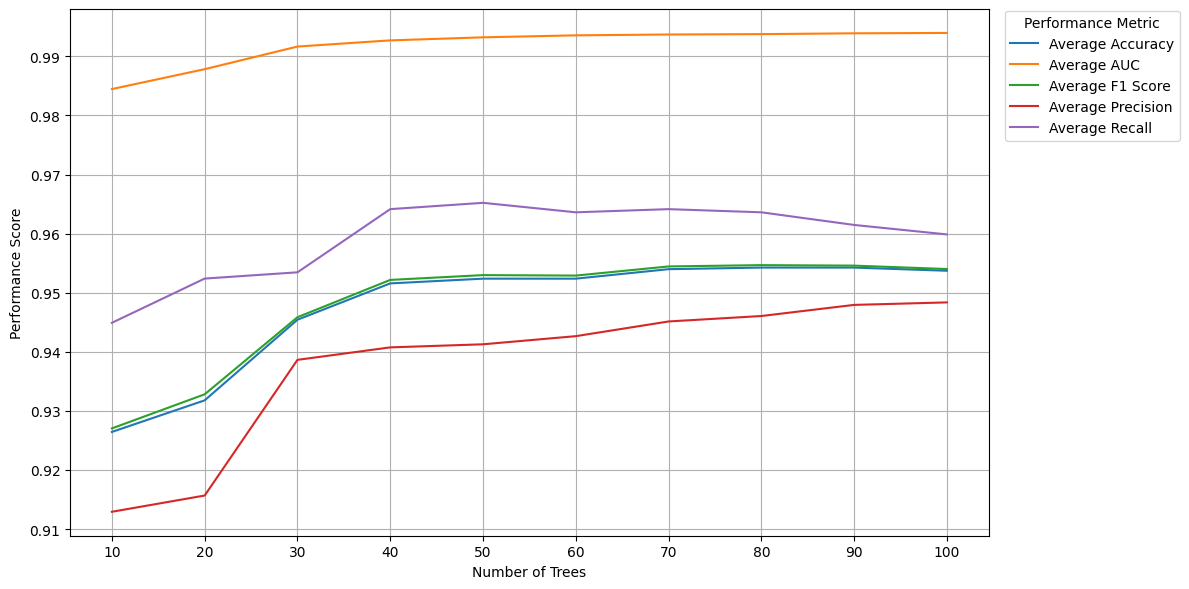

In [68]:
# Creating column names and index for the new dataframe
metric_names = list(results_xgb_classifier[0].keys())[:5]
rows = len(results_xgb_classifier)

# Creating the DataFrame
results_df = pd.DataFrame(index = range(rows), columns = metric_names)

# Filling in values in the DataFrame
for iteration in range(rows):
    
    col_idx = 0  # Starting at the first column for each row

    for val in list(results_xgb_classifier[iteration].values())[:5]:
        
        results_df.iloc[iteration, col_idx] = val
        col_idx += 1

# Creating column with number of estimators
results_df['n_estimators'] = [n for n in range(10, 101, 10)]

# Formatting dataframe for the plot
results_df = results_df.melt(id_vars = 'n_estimators',
                            var_name = 'Performance_Metric',
                            value_name = 'Concatenated_Values'
                           )[['n_estimators', 'Concatenated_Values', 'Performance_Metric']]

# Creating the line plot
plt.figure(figsize = (12, 6))
sns.lineplot(data = results_df, x = 'n_estimators', y = 'Concatenated_Values', hue = 'Performance_Metric')

# Setting x-axis
plt.xticks(range(10, 101, 10))

# Labeling the axes
plt.xlabel('Number of Trees')
plt.ylabel('Performance Score')

# Adding grid
plt.grid(True)

# Placing the legend
plt.legend(title = 'Performance Metric', bbox_to_anchor = (1.01, 1.01), loc = 'upper left')

# Displaying and saving the plot
plt.tight_layout()
plt.savefig('Performance_Scores.png')
plt.show()

#### Displaying predictions on a simple train_test split.

In [75]:
# Splitting the data into training and testing sets
x = telco5_under_fs.drop(columns = ['Churn Label_Yes'])
y = telco5_under_fs['Churn Label_Yes']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

# Initializing the xgboost classifier with best hyperparameters
xgb_model = XGBClassifier(learning_rate = 0.1, n_estimators = 60, max_depth = 3, use_label_encoder = False, eval_metric='logloss')

# Training the model
xgb_model.fit(x_train, y_train)

# Making predictions on the test set
y_pred = xgb_model.predict(x_test)
y_pred_proba = xgb_model.predict_proba(x_test)[:, 1]  # probability estimates for auc

# Calculating evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Looking at the results
print(f'Accuracy: {accuracy:.4f}')
print(f'AUC: {auc:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print('Confusion matrix:')
print(conf_matrix)
print('Predictions:')
print(y_pred)

Accuracy: 0.9425
AUC: 0.9926
F1 Score: 0.9438
Precision: 0.9186
Recall: 0.9704
Confusion matrix:
[[344  32]
 [ 11 361]]
Predictions:
[1 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1 1 0 1 1 0
 0 1 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1
 0 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 0 1 0 0 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1
 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 1 1 0 1 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0 0 0
 0 0 1 1 0 1 1 0 0 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 0 1 1 0 1 1
 0 1 0 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 0 0 0 1 1 0 0 1 1 1 0 0 1 1 1 1 1
 0 0 1 1 1 0 1 1 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1
 0 1 0 0 1 1 0 0 1 0 1 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 0 0 1 0 1
 0 0 0 0 0 1 1 0 0 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 0 0 1 0 0
 1 0 0 1 0 1 0 0 0 1 1 1 1 0 0 0 0 0 1 1 0 0 1 1 0 1 0 1 1 0 0 0 1 1 0 0 1
 1 1 1 1 0 0 0 1 1 1 1 1 1 0 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 0 1 0 1 0 0 0 1
 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 1 0 1 1

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:07:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
